# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/14rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/15rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/16rep_50noiseLevel_GMA_1ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/14rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/15rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/16rep_50noiseLevel_GMA_1ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 1
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.323270        0.200792  0.050435  0.298915  0.017996   
       1.0    0.314750        0.176585  0.071932  0.189340  0.133361   
       2.0    0.307585        0.154357  0.092327  0.171743  0.159756   
       3.0    0.313313        0.119846  0.080972  0.158589  0.177545   
       4.0    0.341446        0.094506  0.061824  0.159940  0.212381   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.201447  0.009249  0.040422  0.048604  0.000000  
       1.0   0.210116  0.007212  0.038360  0.048818  0.003357  
       2.0   0.207801  0.004337  0.035138  0.047719  0.008700  
       3.0   0.239283  0.003208  0.029035  0.043263  0.013358  
       4.0   0.265384  0.003465  0.032810  0.041169  0.017466

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.295315        0.203393  0.049610  0.292473  0.020236   
       1.0    0.314523        0.179589  0.078641  0.187215  0.130772   
       2.0    0.325300        0.140887  0.088427  0.152139  0.167135   
       3.0    0.305541        0.112034  0.070429  0.152127  0.183884   
       4.0    0.357362        0.091606  0.065560  0.162714  0.193155   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.182364  0.009452  0.037824  0.049237  0.000000  
       1.0   0.209903  0.006875  0.039878  0.051088  0.003710  
       2.0   0.198220  0.003905  0.036067  0.051233  0.009263  
       3.0   0.235181  0.003261  0.031134  0.042614  0.015155  
       4.0   0.288752  0.003102  0.030190  0.040274  0.020164

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.301919        0.184715  0.048514  0.300995  0.018765   
       1.0    0.305686        0.180808  0.072830  0.174139  0.132269   
       2.0    0.323136        0.147500  0.089107  0.174317  0.170149   
       3.0    0.312377        0.106049  0.080771  0.175176  0.187713   
       4.0    0.335824        0.092359  0.057670  0.173212  0.201076   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.193786  0.009556  0.040998  0.048033  0.000000  
       1.0   0.222998  0.006837  0.034244  0.046736  0.004183  
       2.0   0.225724  0.004191  0.032718  0.048000  0.008554  
       3.0   0.247792  0.003299  0.030195  0.041751  0.013263  
       4.0   0.290455  0.003499  0.029595  0.042027  0.018482

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.306835        0.196300  0.049520  0.297461  0.018999   
         1.0    0.282697        0.176581  0.087728  0.184113  0.133885   
         2.0    0.254123        0.142941  0.082568  0.194118  0.180057   
         3.0    0.217567        0.105751  0.055444  0.191026  0.221720   
         4.0    0.214458        0.083180  0.035644  0.188577  0.256957   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.192532  0.009419  0.039748  0.048625  0.000000  
         1.0   0.214255  0.007101  0.037460  0.050141  0.002497  
         2.0   0.211037  0.004522  0.034353  0.052155  0.005991  
         3.0   0.246870  0.003805  0.029583  0.047162  0.009623  
         4.0   0.299917  0.004679  0.029792  0.047737  0.013185

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   6.082450e+01  3.899512e+01      36.613773  5.713511e+01   
         1.0   6.146475e+06  4.521988e+06  480888.711008  3.034596e+06   
         2.0   6.357254e+06  5.562650e+06  576741.449844  3.850479e+06   
         3.0   6.741533e+06  6.040231e+06  654641.466513  3.893106e+06   
         4.0   6.607378e+06  5.744616e+06  646943.575807  4.469854e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.526772e+01  5.244708e+01  5.224924e+01  1.857013e+01   
         1.0   9.853482e+05  5.409896e+06  3.937284e+06  8.544349e+05   
         2.0   1.228962e+06  7.389592e+06  4.074265e+06  9.779973e+05   
         3.0   1.205014e+06  8.136914e+06  4.043052e+06  1.092896e+06   
         4.0   1.340911e+06  8.143322e+06  4.197575e+06  1.104371e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          29.506563  
         1.0      404286.707202  
         2.0      493971.358043  
         3.0      536863.547327  
         4.0      580542.731221

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


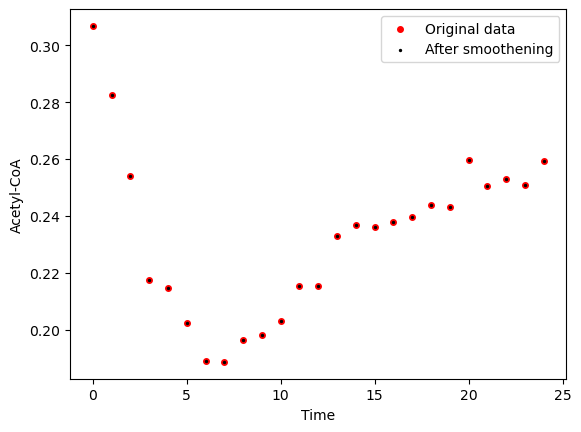

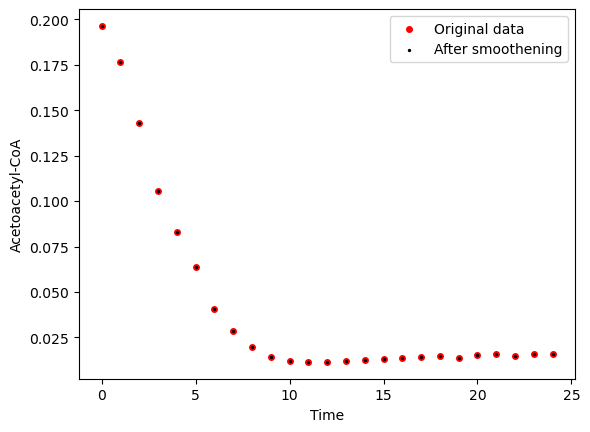

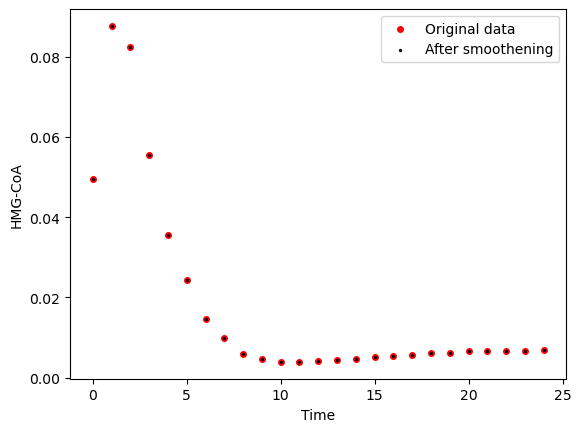

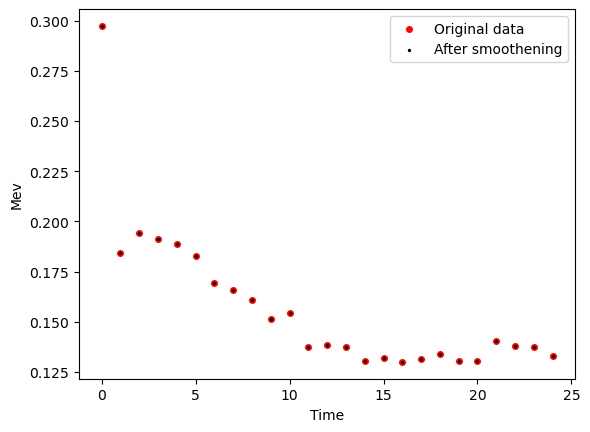

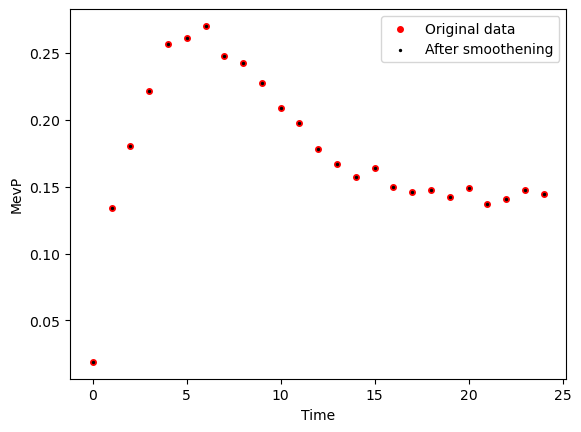

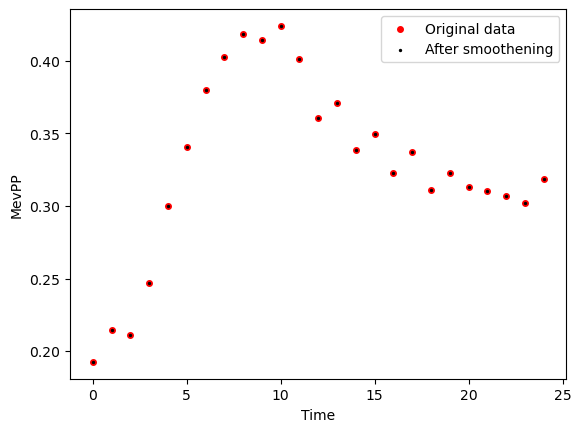

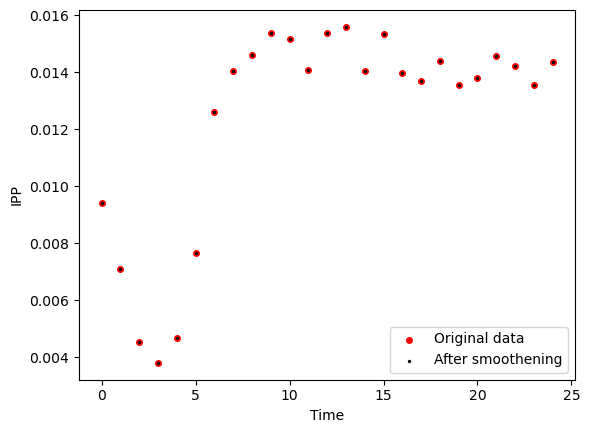

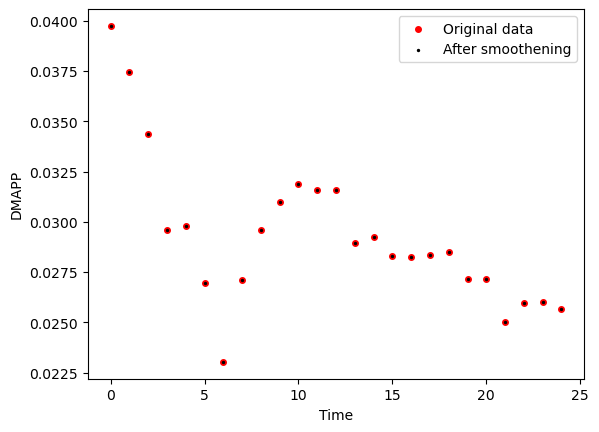

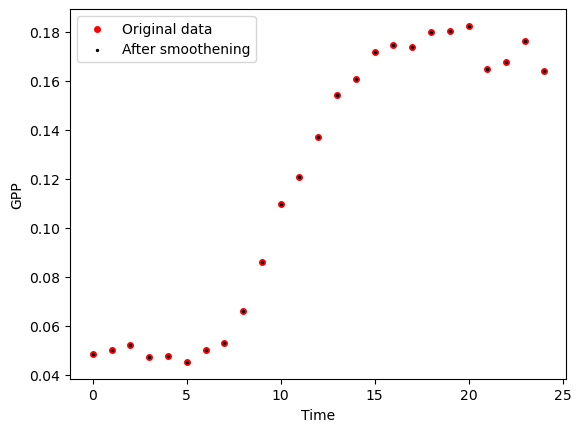

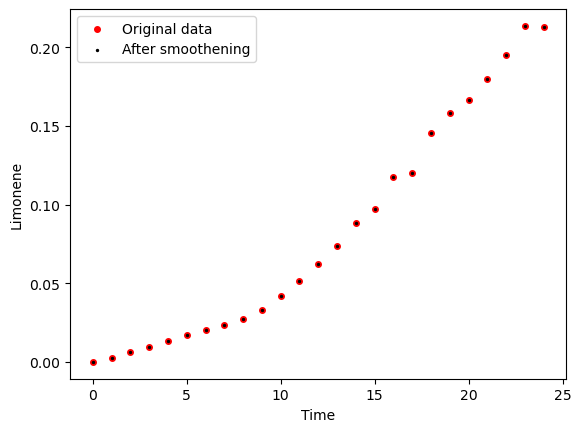

Strain Strain 2


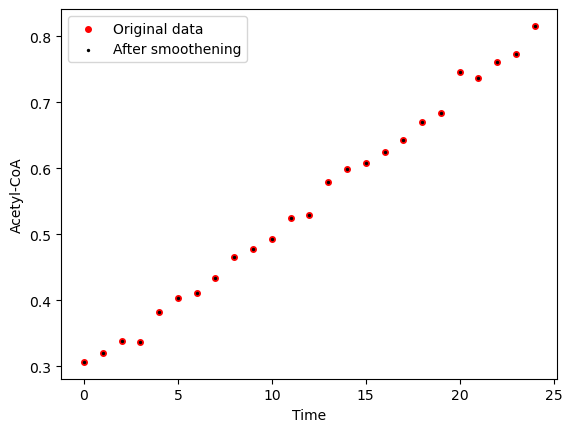

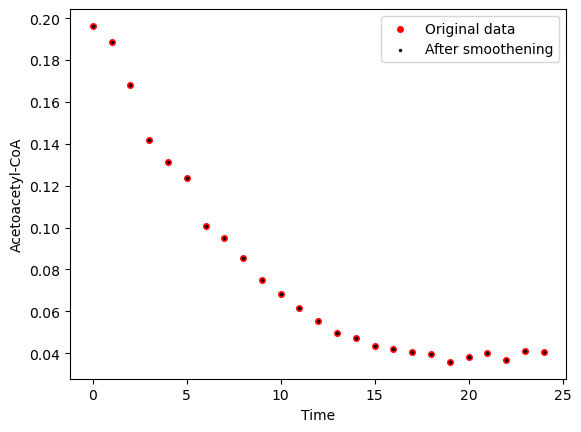

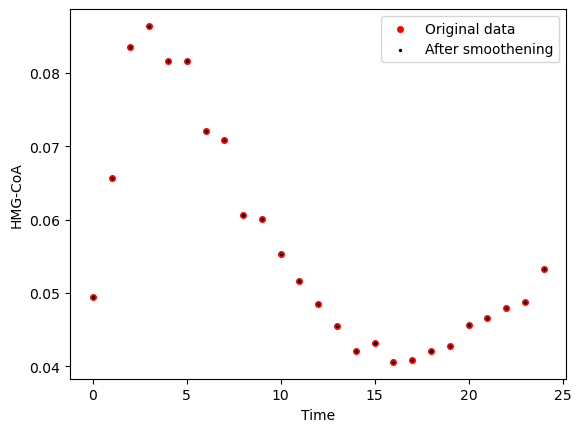

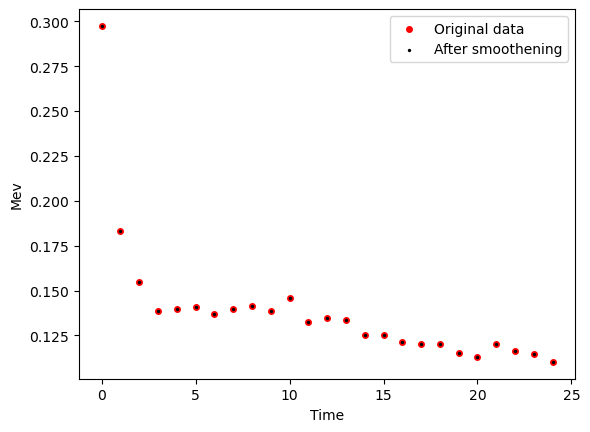

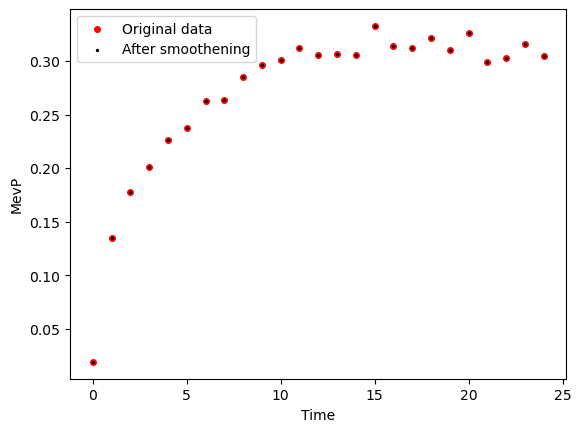

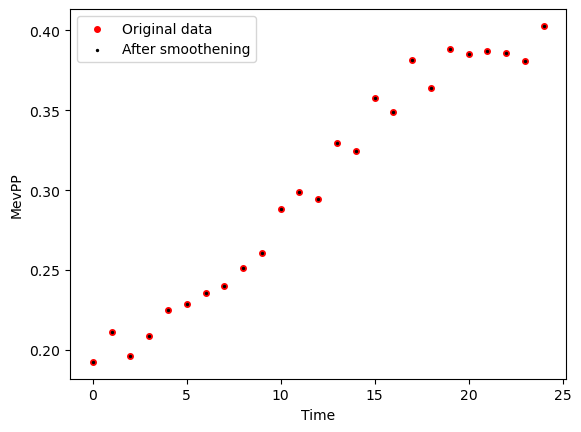

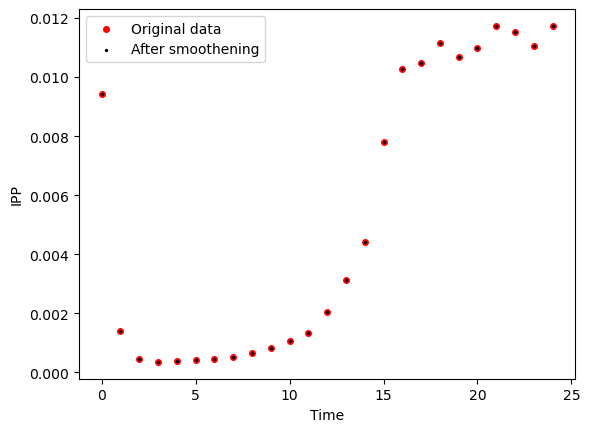

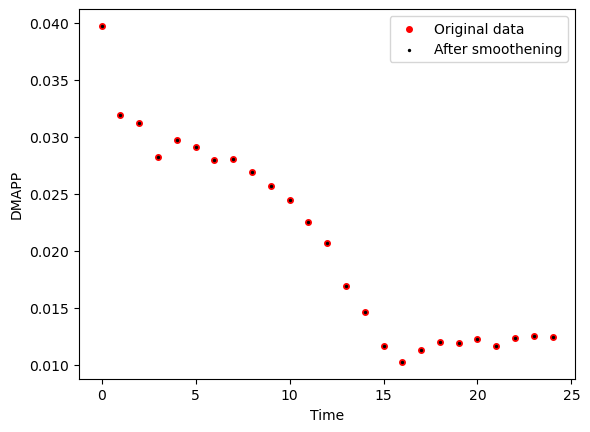

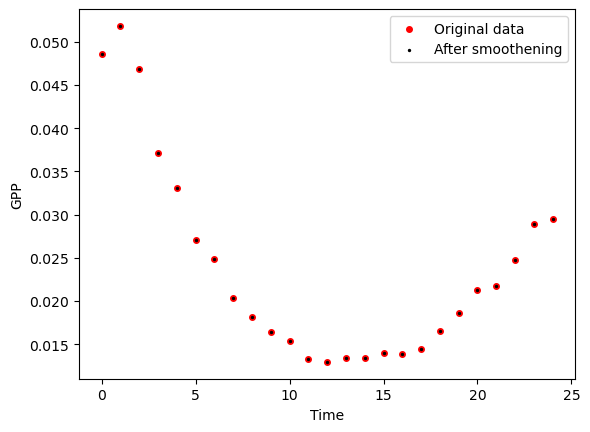

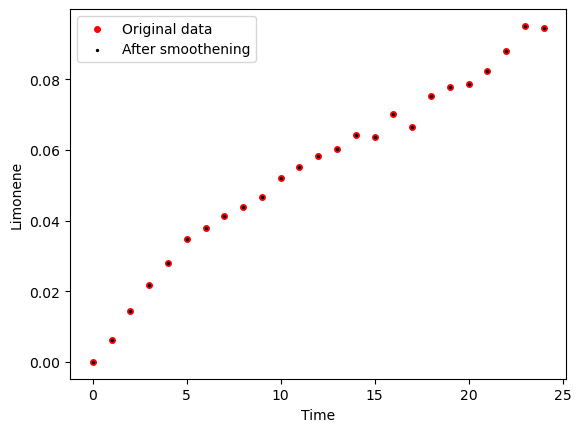

Strain Strain 3


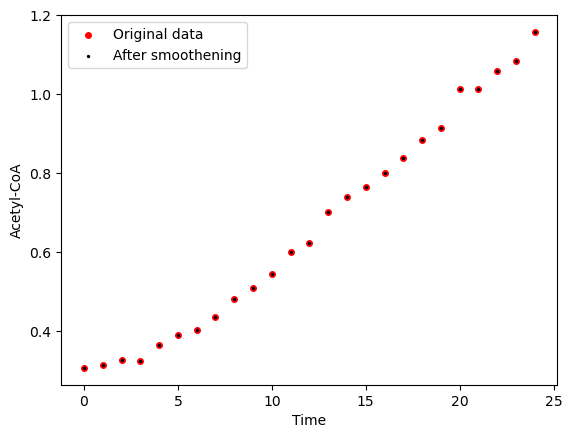

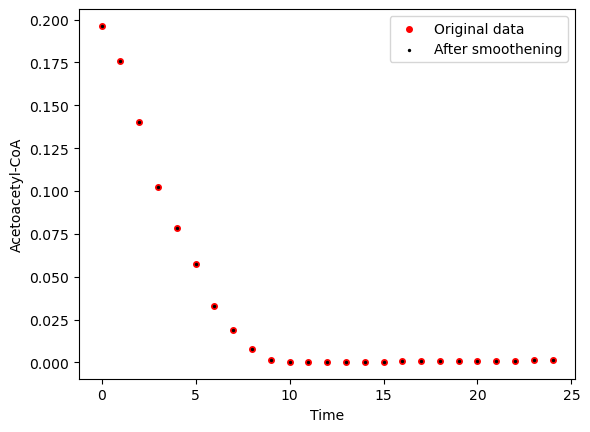

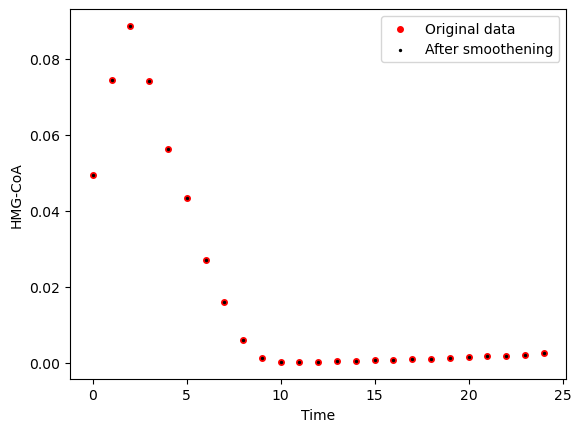

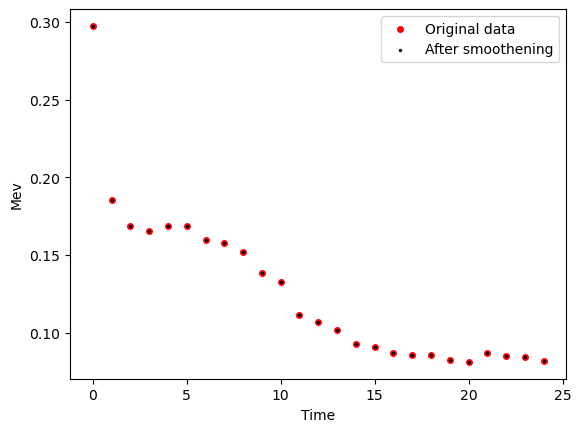

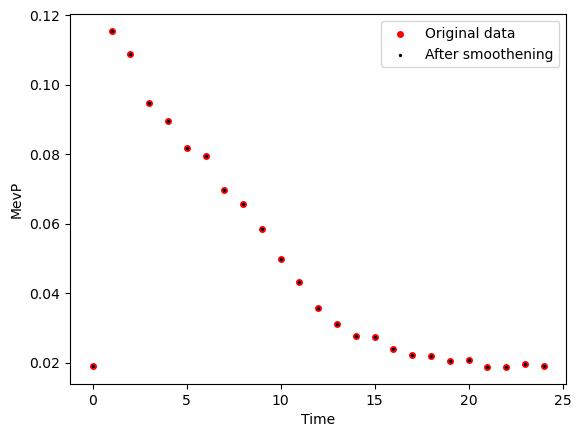

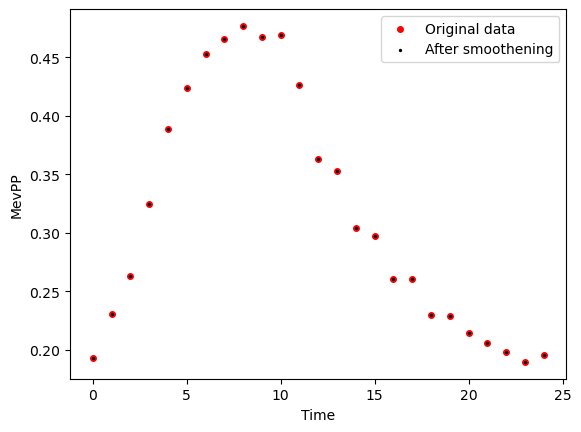

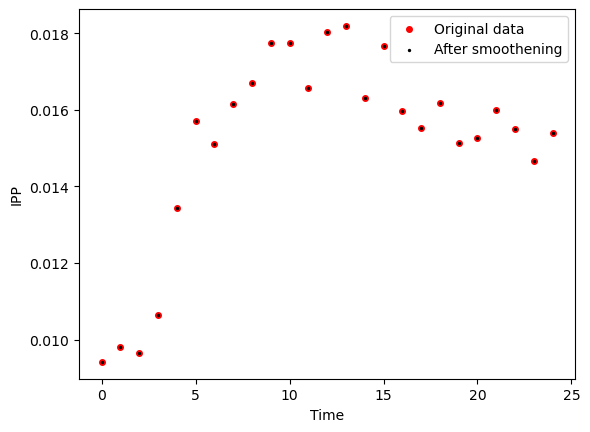

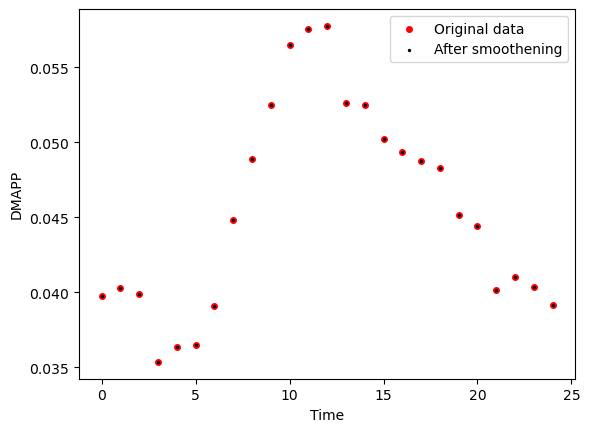

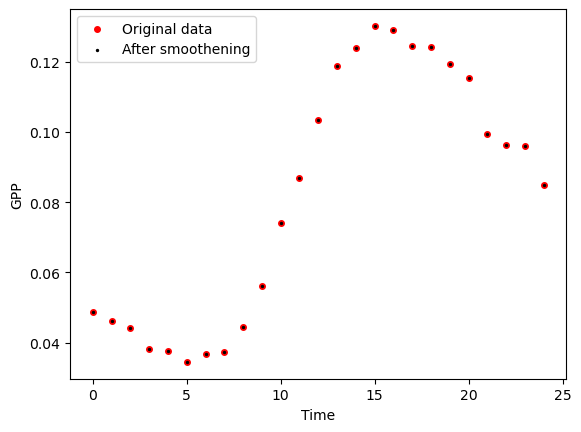

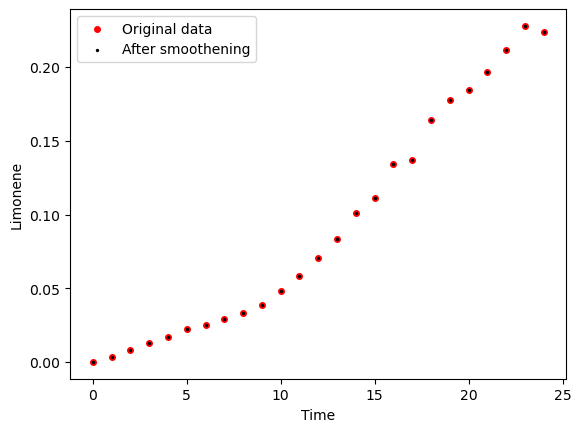

Strain WT


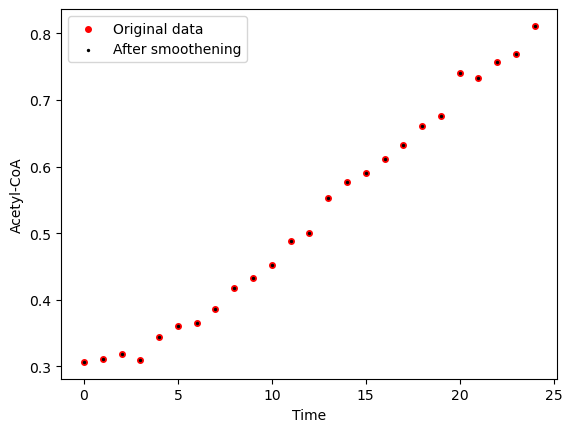

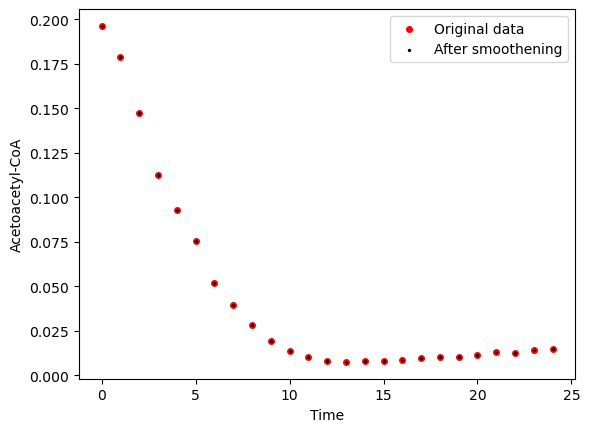

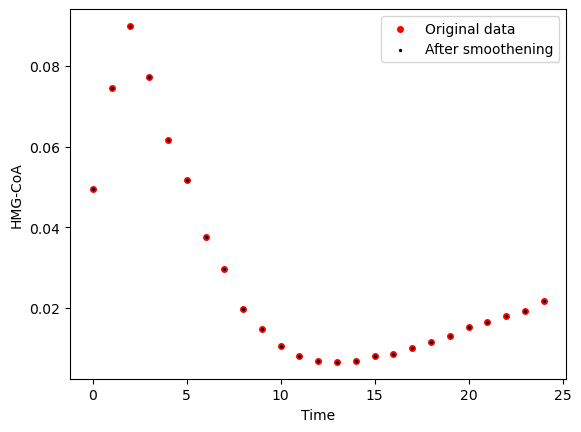

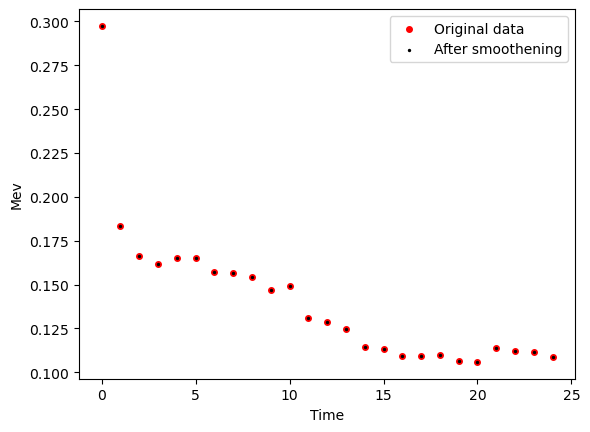

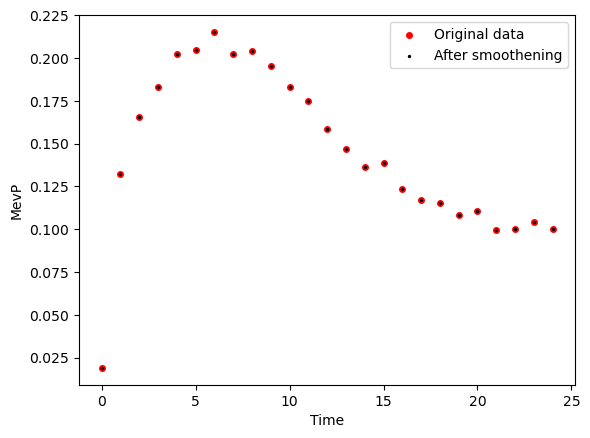

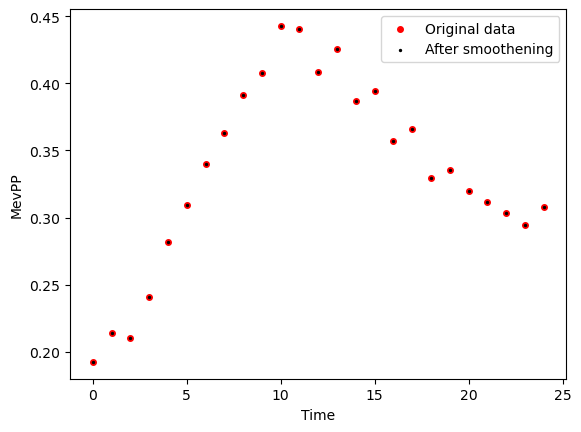

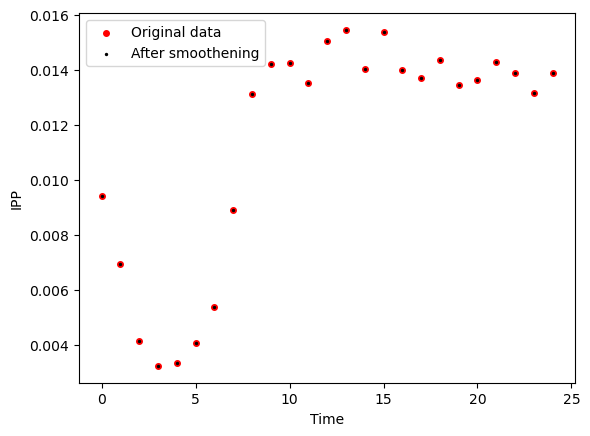

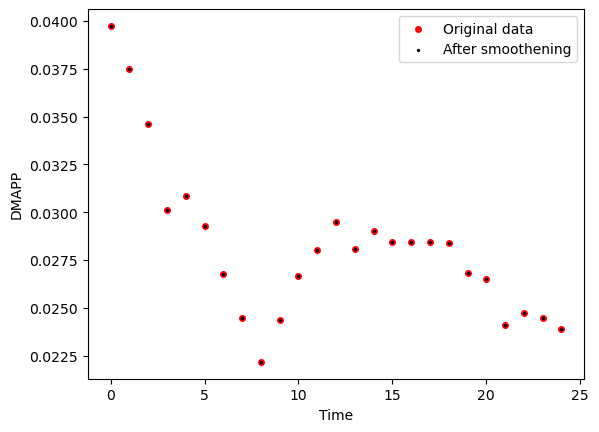

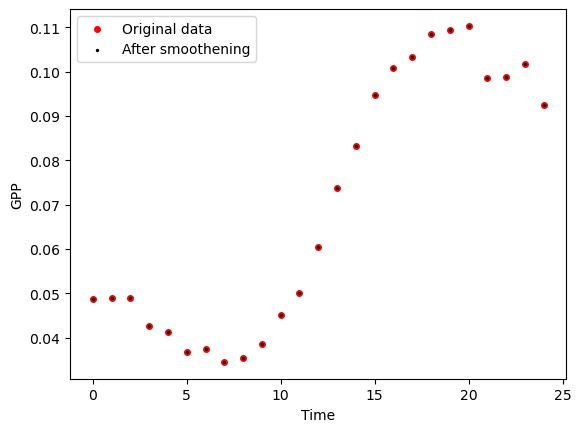

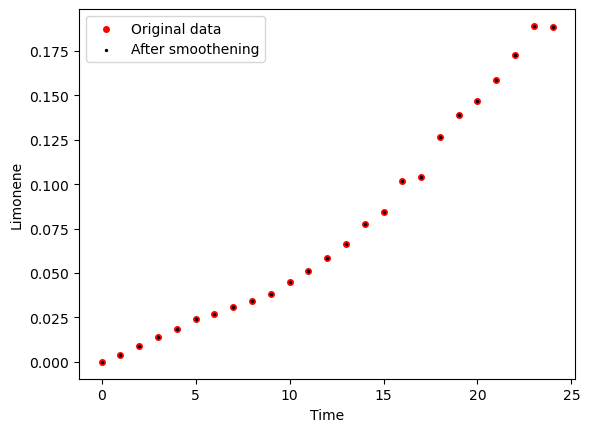

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


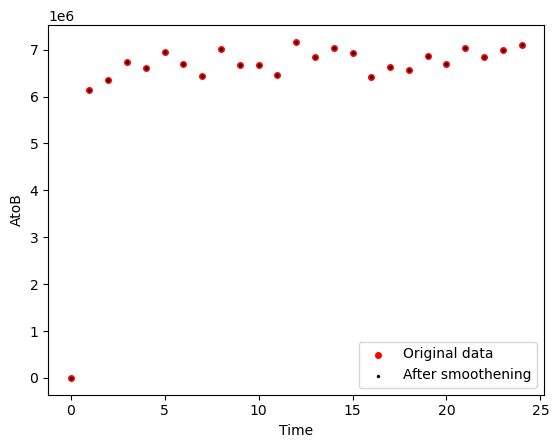

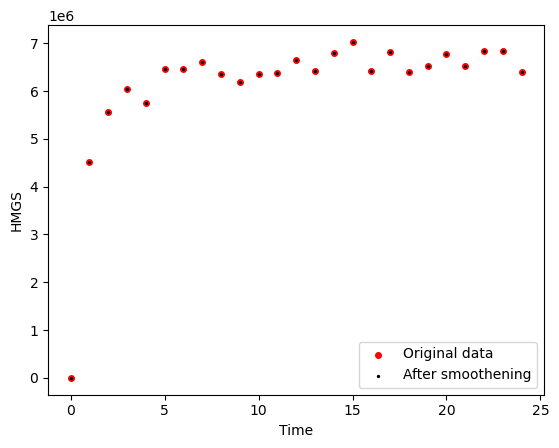

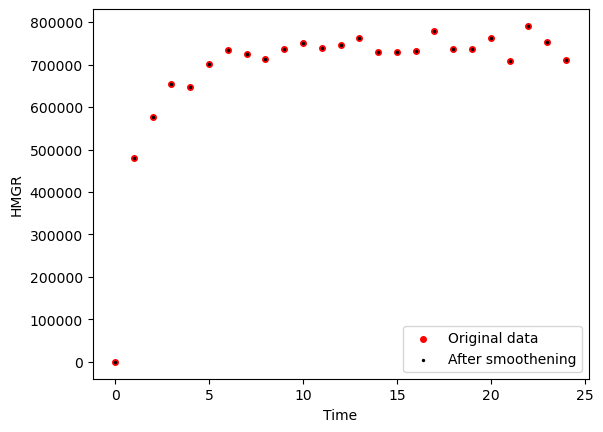

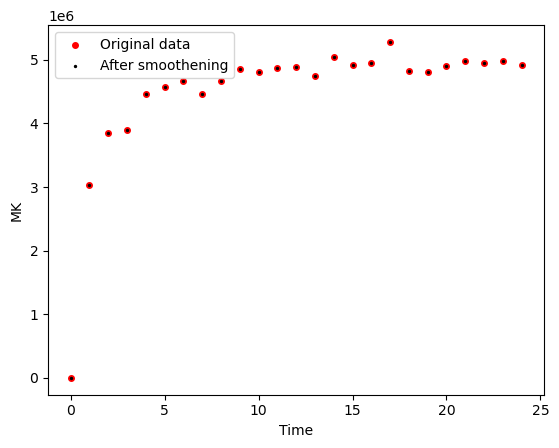

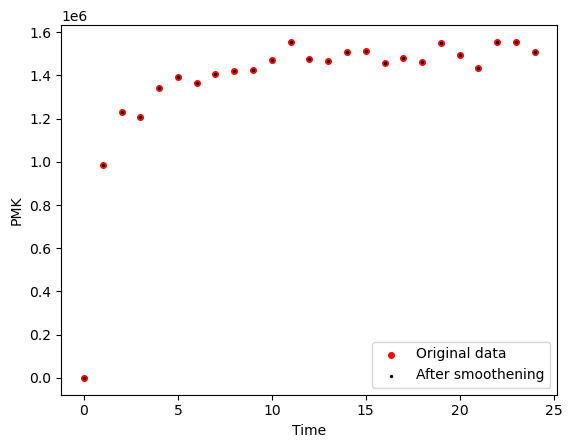

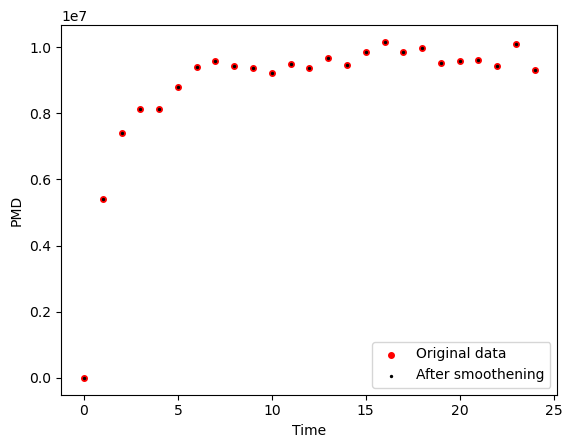

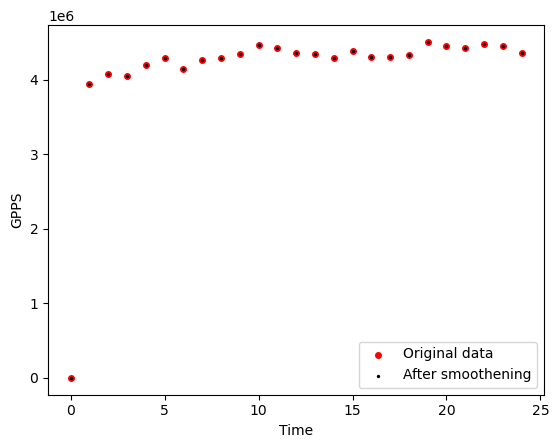

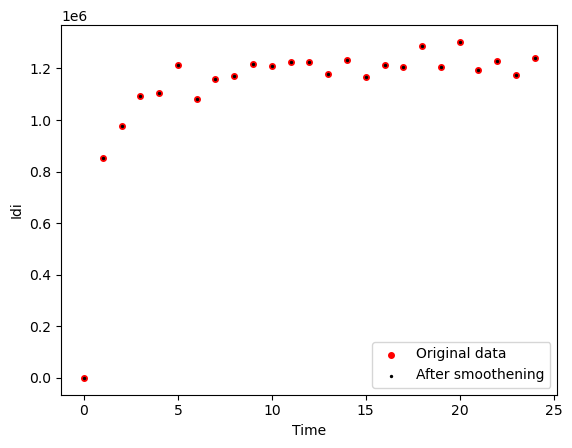

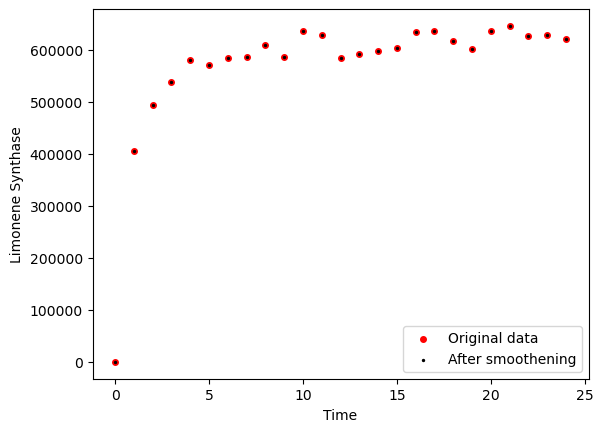

Strain Strain 2


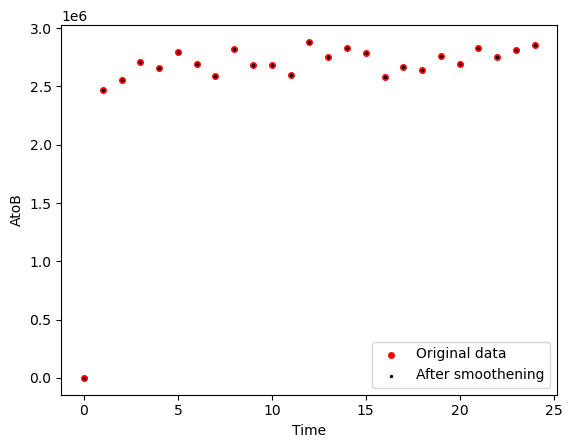

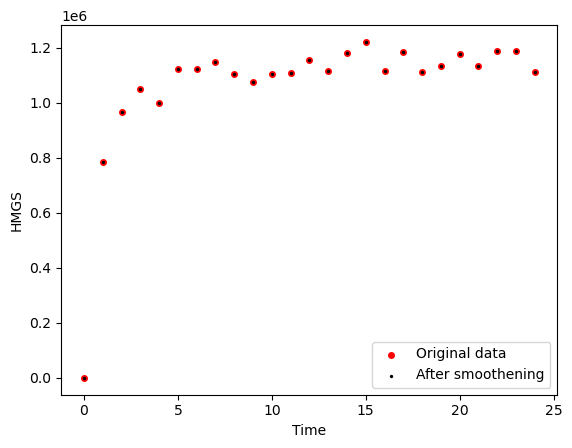

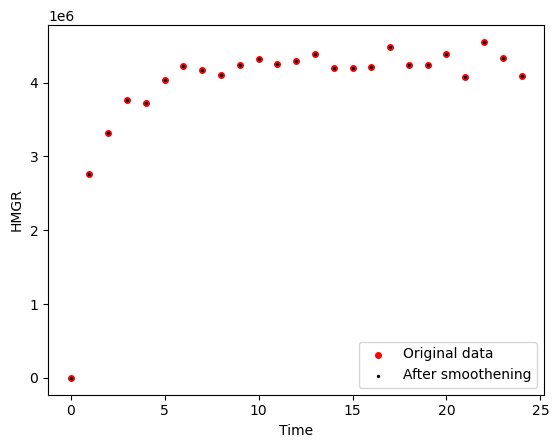

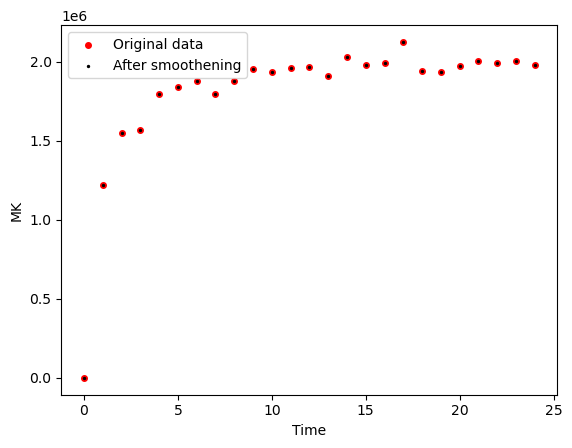

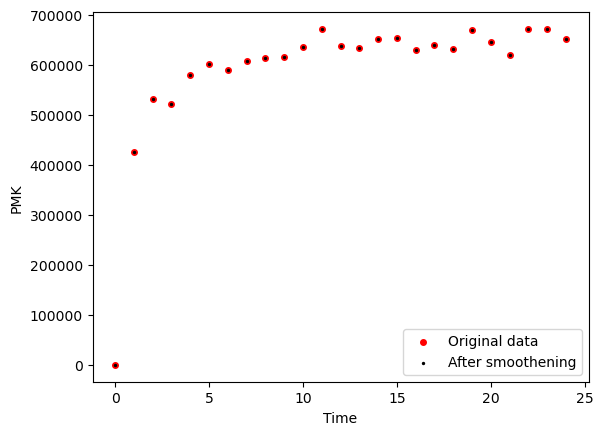

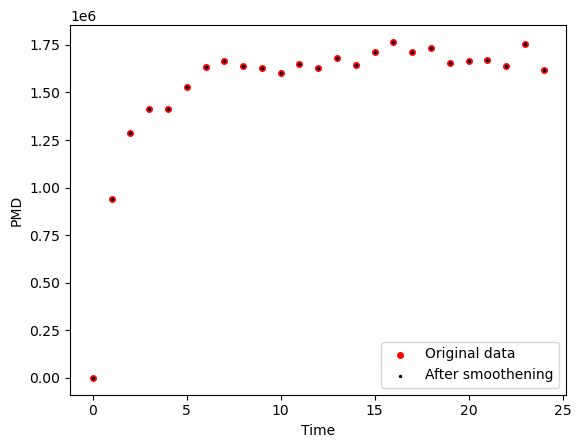

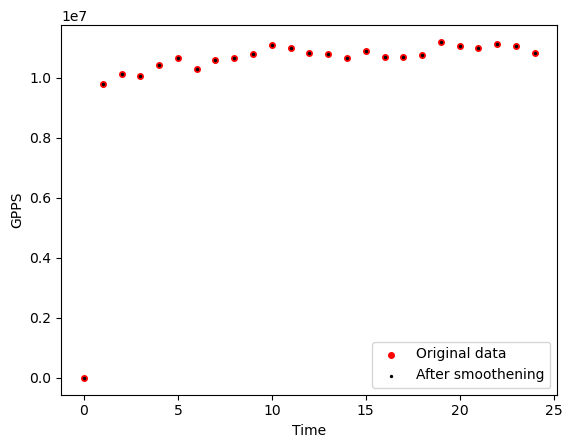

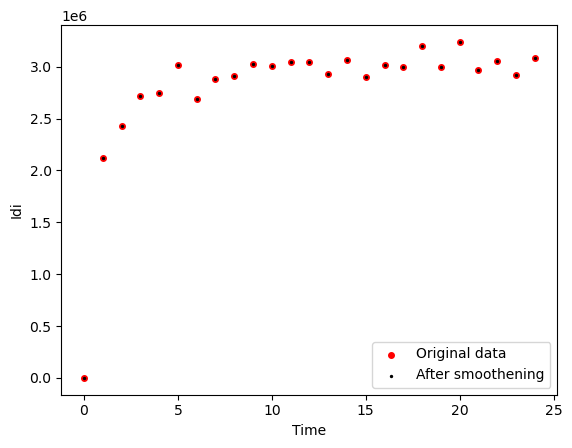

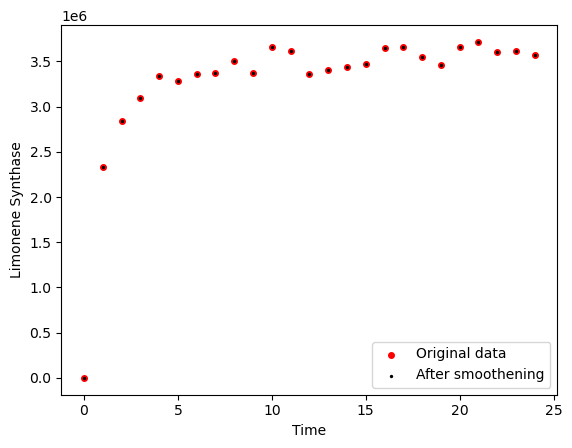

Strain Strain 3


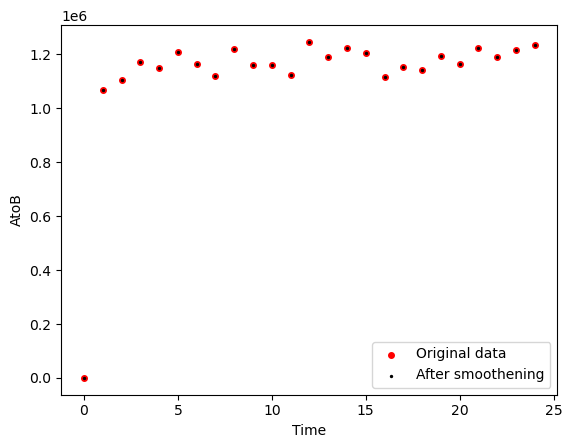

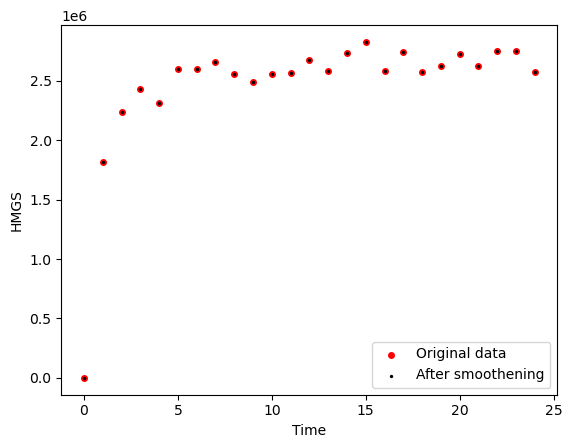

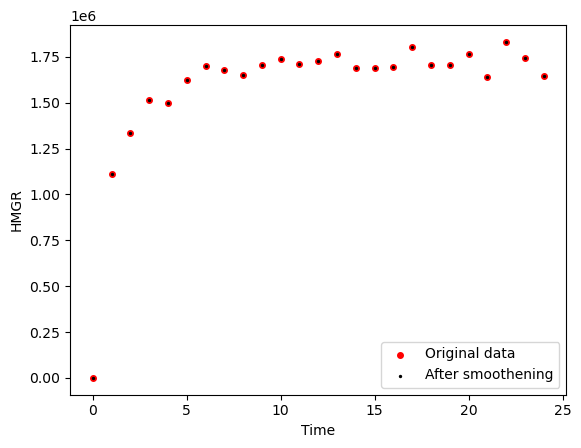

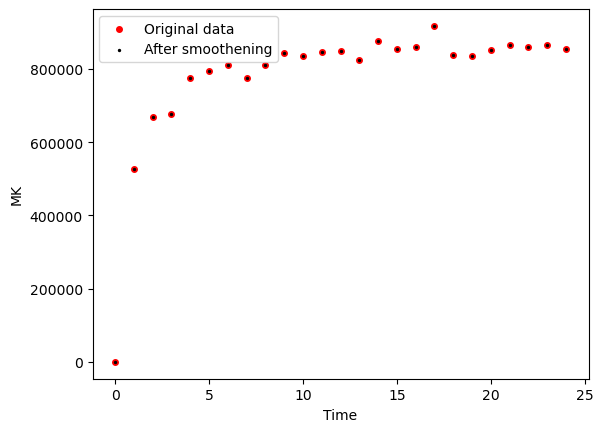

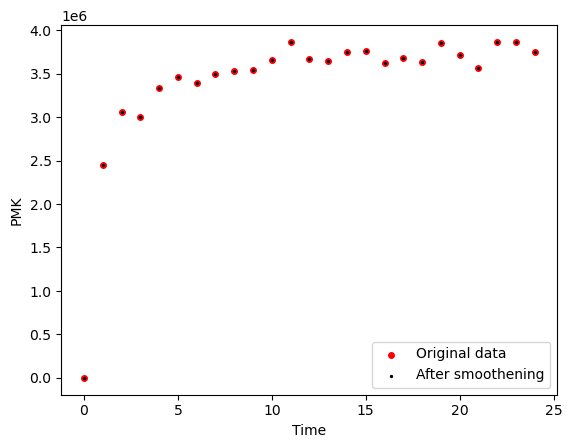

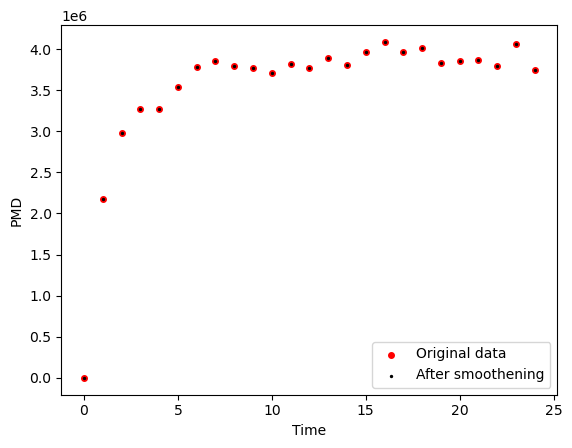

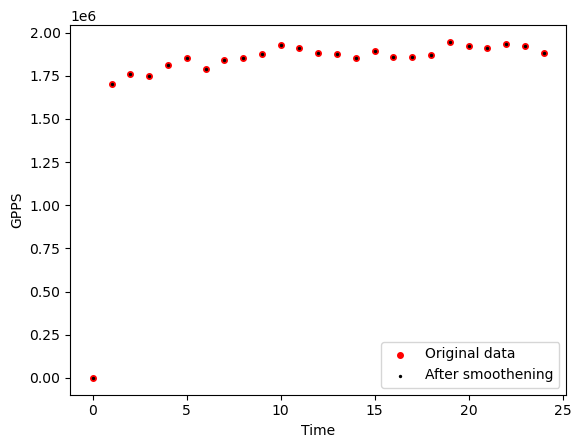

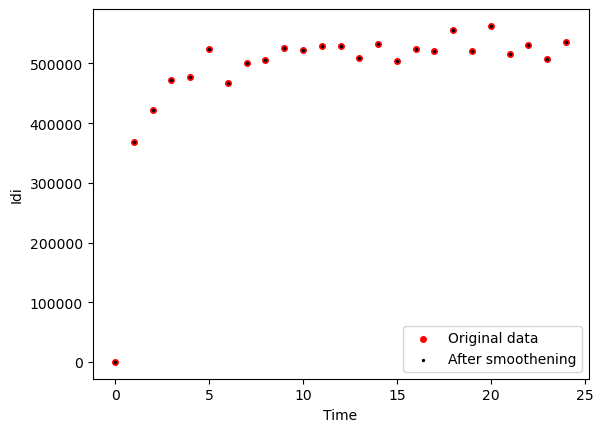

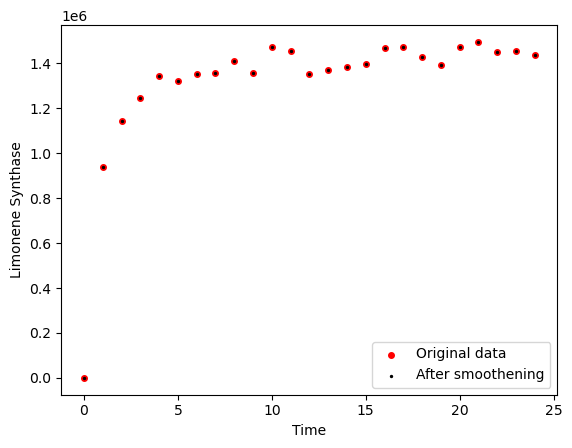

Strain WT


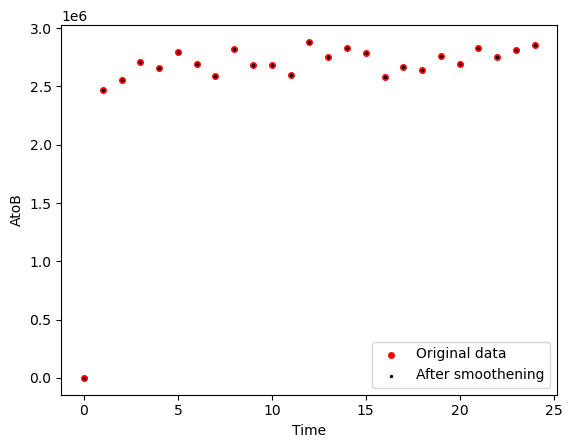

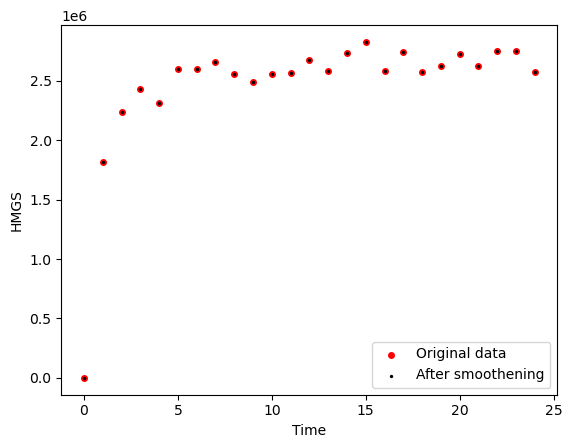

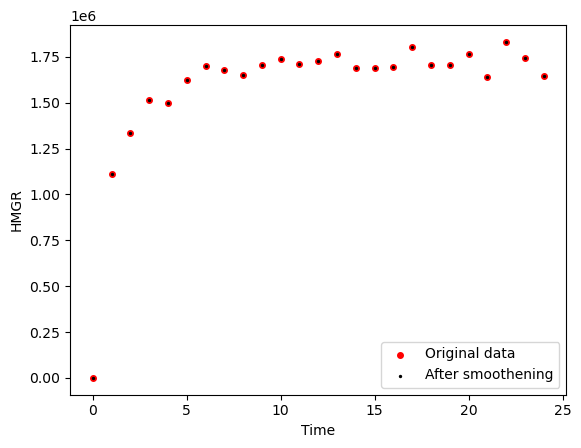

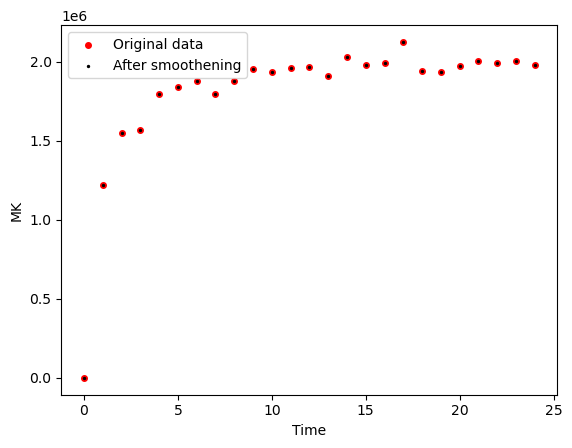

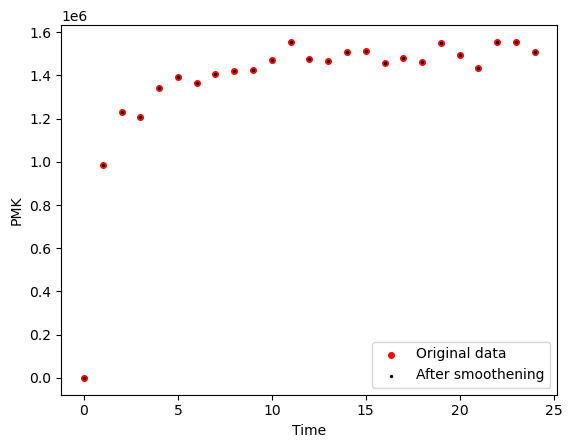

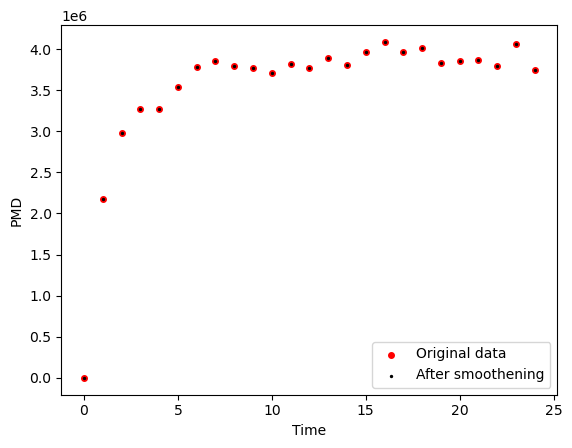

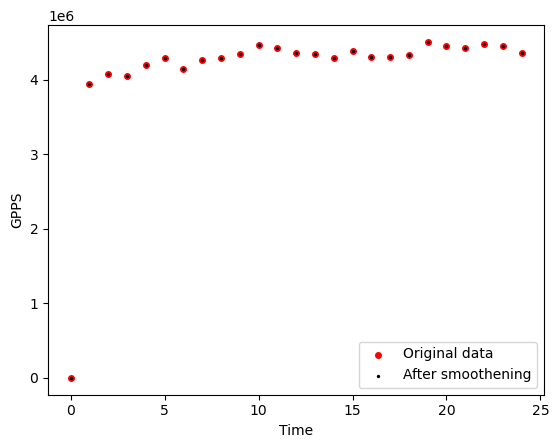

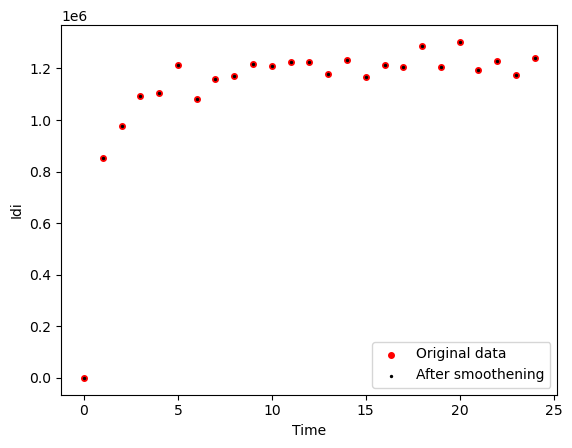

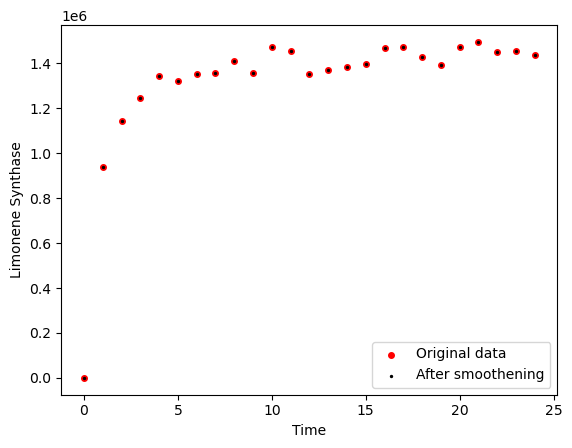

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative

df_allSmooth=estimate_state_derivative(df_allSmooth,5,2)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.306835        0.196300  0.049520  0.297461  0.018999   
         1.0    0.282697        0.176581  0.087728  0.184113  0.133885   
         2.0    0.254123        0.142941  0.082568  0.194118  0.180057   
         3.0    0.217567        0.105751  0.055444  0.191026  0.221720   
         4.0    0.214458        0.083180  0.035644  0.188577  0.256957   
...                  ...             ...       ...       ...       ...   
WT       20.0   0.740142        0.011608  0.015189  0.105922  0.110810   
         21.0   0.732293        0.012957  0.016630  0.113921  0.099820   
         22.0   0.756917        0.012489  0.018118  0.112138  0.100278   
         23.0   0.768320        0.014410  0.019301  0.111857  0.103953   
         24.0   0.810953        0.014772  0.021873  0.108845  0.100400   

                                                                 ...  \
                  MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                    ...   
Strain 1 0.0   0.192532  0.009419  0.039748  0.048625  0.000000  ...   
         1.0   0.214255  0.007101  0.037460  0.050141  0.002497  ...   
         2.0   0.211037  0.004522  0.034353  0.052155  0.005991  ...   
         3.0   0.246870  0.003805  0.029583  0.047162  0.009623  ...   
         4.0   0.299917  0.004679  0.029792  0.047737  0.013185  ...   
...                 ...       ...       ...       ...       ...  ...   
WT       20.0  0.319837  0.013626  0.026497  0.110291  0.146559  ...   
         21.0  0.311421  0.014305  0.024106  0.098546  0.158657  ...   
         22.0  0.303367  0.013895  0.024749  0.098850  0.172738  ...   
         23.0  0.294506  0.013176  0.024490  0.101743  0.189064  ...   
         24.0  0.307787  0.013879  0.023886  0.092547  0.188481  ...   

              derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.034724       -0.027063  0.033419 -0.080714  0.103178   
         1.0    -0.029856       -0.028385  0.013708 -0.050900  0.079776   
         2.0    -0.024988       -0.029707 -0.006003 -0.021085  0.056375   
         3.0    -0.020031       -0.028592 -0.017378 -0.000870  0.033171   
         4.0    -0.014577       -0.024728 -0.016710 -0.005805  0.021969   
...                   ...             ...       ...       ...       ...   
WT       20.0    0.024778        0.000720  0.001651  0.001137 -0.003873   
         21.0    0.020066        0.000941  0.001538  0.001663 -0.001881   
         22.0    0.017765        0.000778  0.001604  0.000378 -0.001669   
         23.0    0.030300        0.000837  0.001884 -0.002553  0.000916   
         24.0    0.042834        0.000897  0.002163 -0.005485  0.003500   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.004319 -0.003634 -0.003731  0.002064  0.002701  
         1.0   0.010210 -0.002456 -0.003255  0.000794  0.003026  
         2.0   0.024738 -0.001278 -0.002779 -0.000475  0.003350  
         3.0   0.034230  0.000125 -0.002558 -0.001410  0.003700  
         4.0   0.043226  0.001999 -0.002528 -0.000608  0.003606  
...                 ...       ...       ...       ...       ...  
WT       20.0 -0.007695 -0.000008 -0.001002 -0.003029  0.011161  
         21.0 -0.009830 -0.000032 -0.000636 -0.002672  0.012648  
         22.0 -0.004101 -0.000062 -0.000484 -0.003229  0.011425  
         23.0  0.001982 -0.000100 -0.000102 -0.002131  0.008123  
         24.0  0.008066 -0.000137  0.000279 -0.001033  0.004820

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

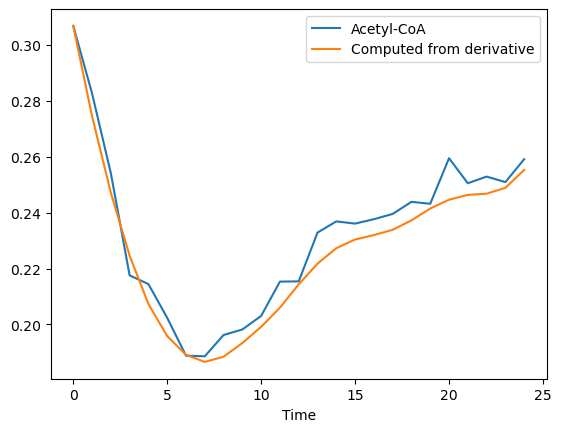

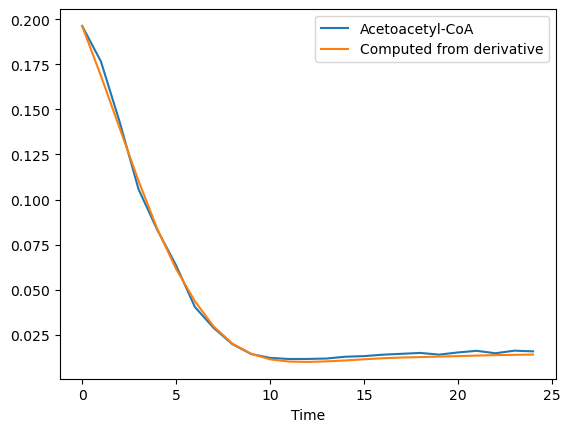

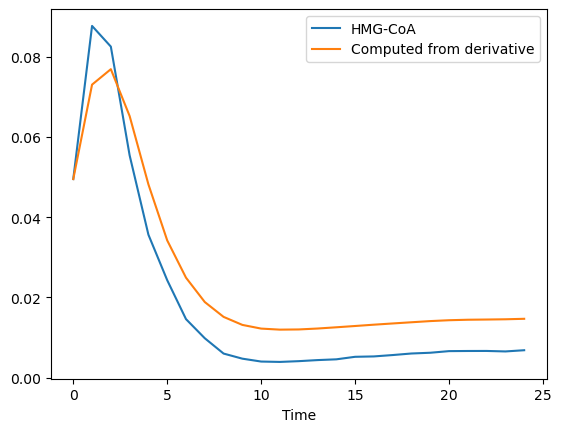

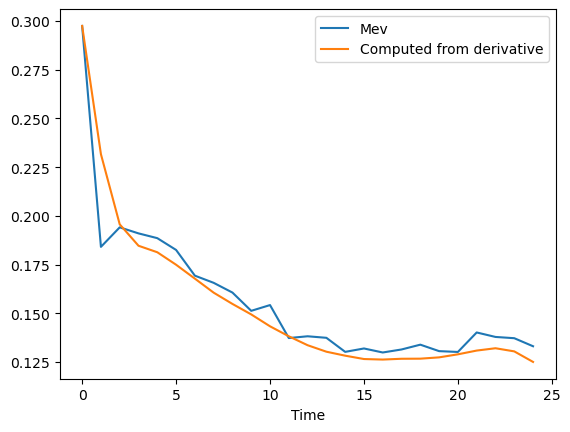

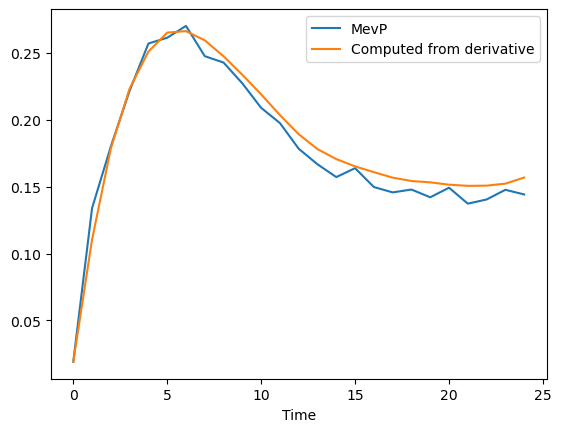

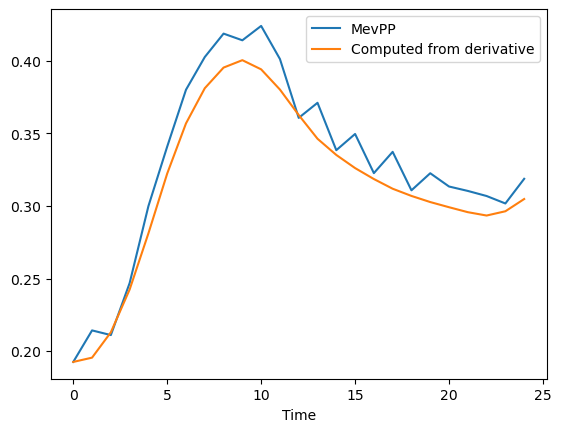

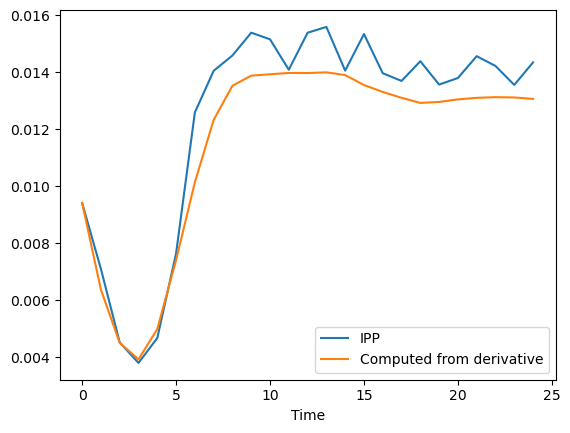

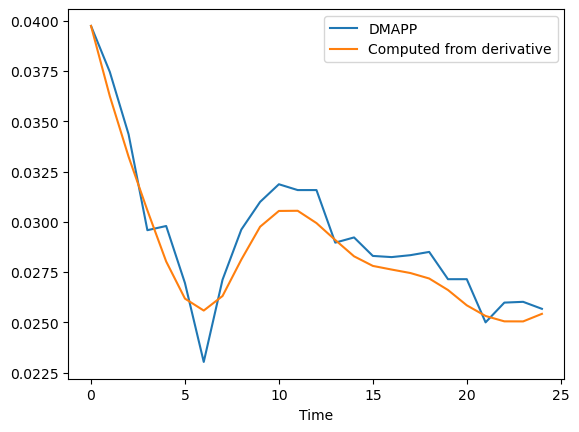

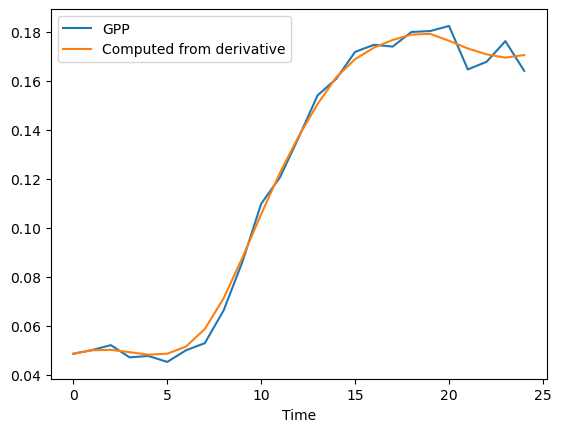

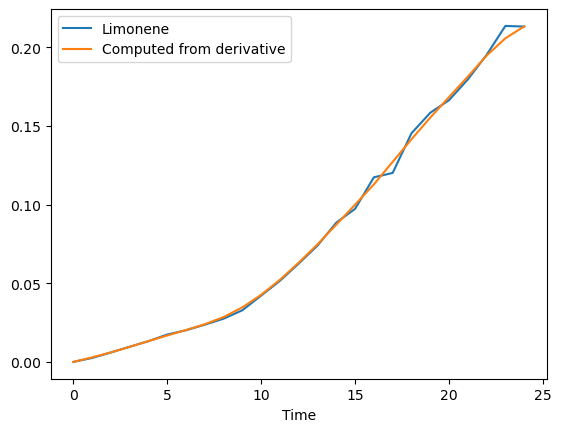

'Time profile from derivative vs. actual profile for Strain 2'

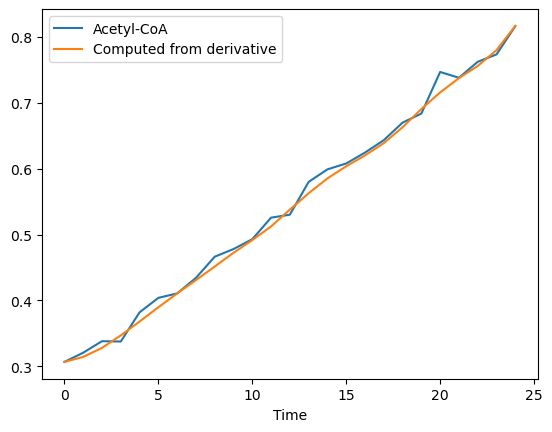

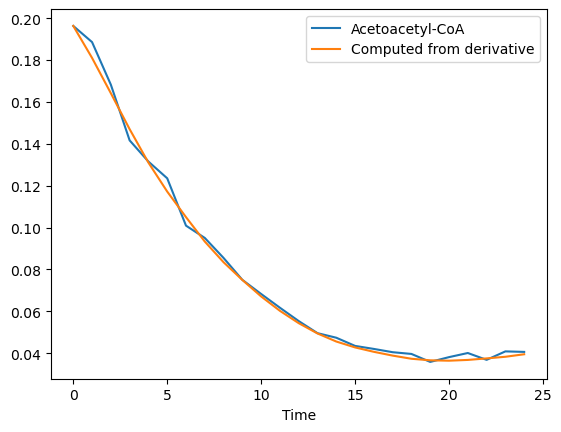

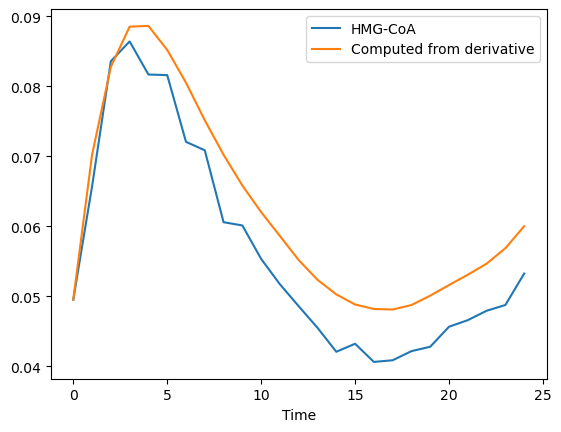

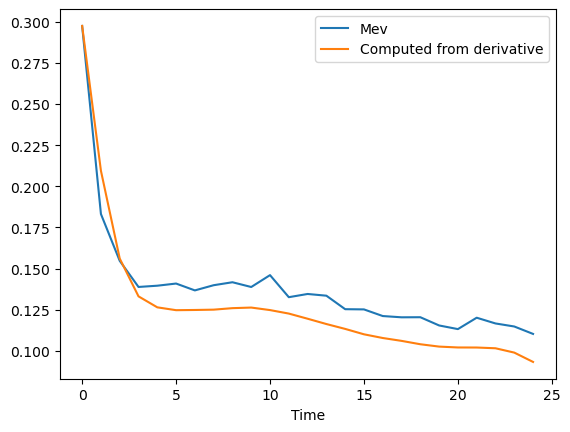

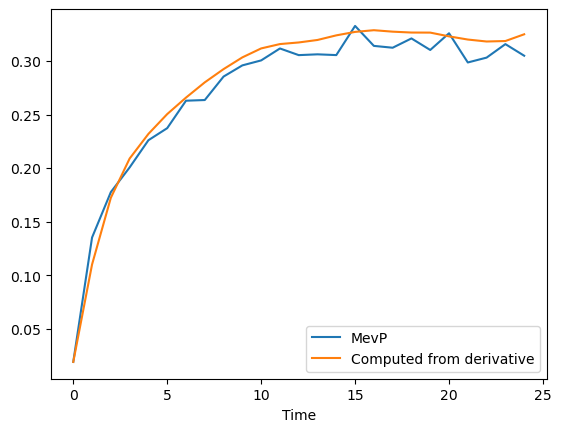

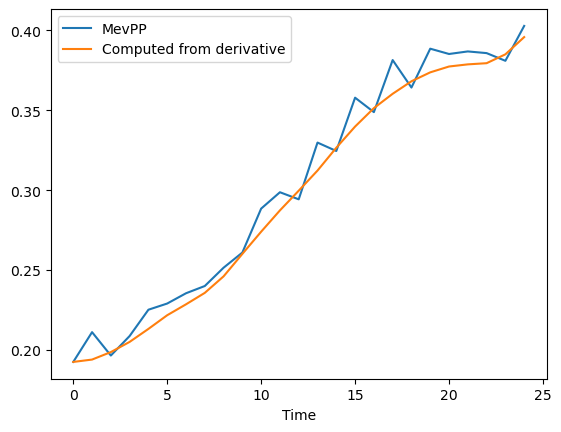

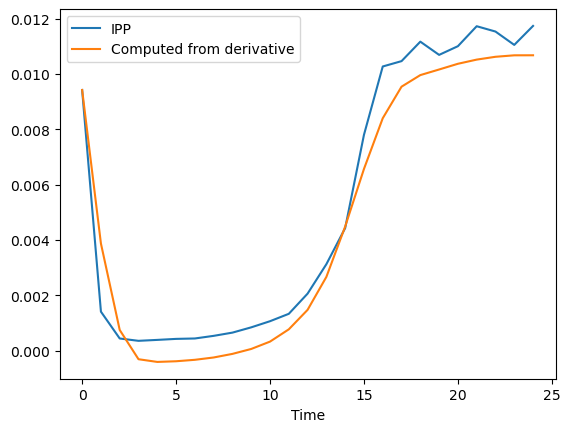

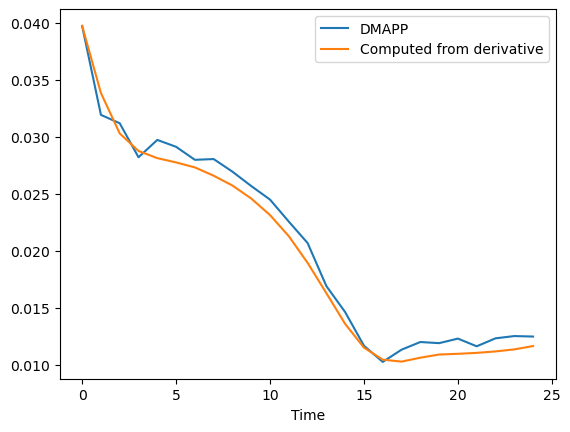

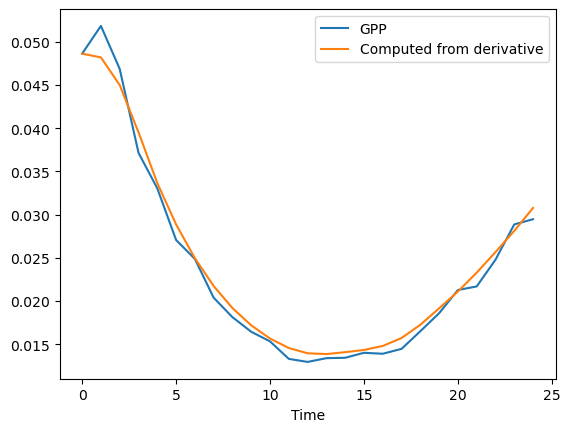

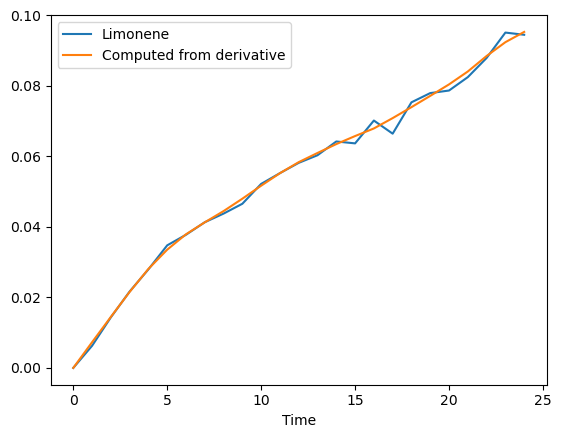

'Time profile from derivative vs. actual profile for Strain 3'

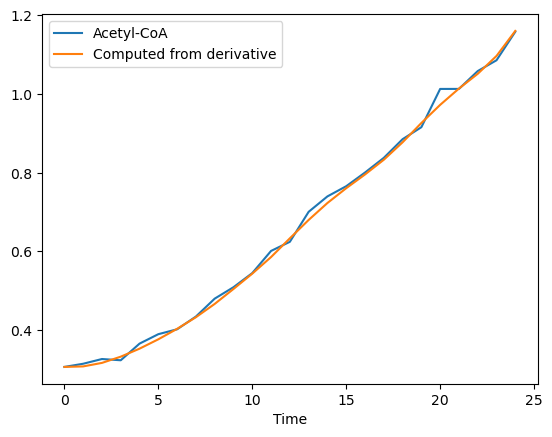

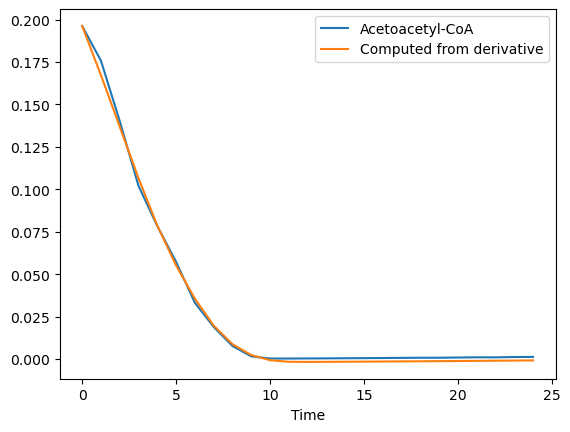

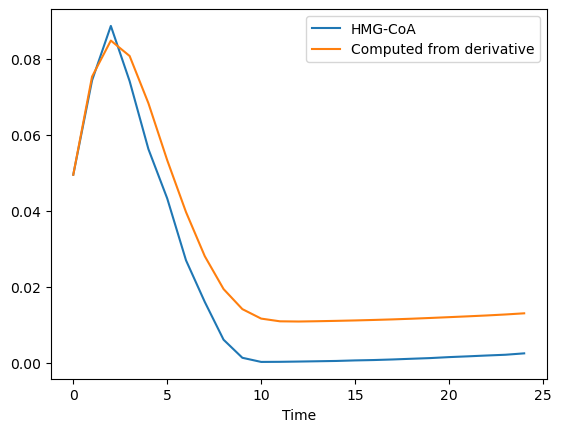

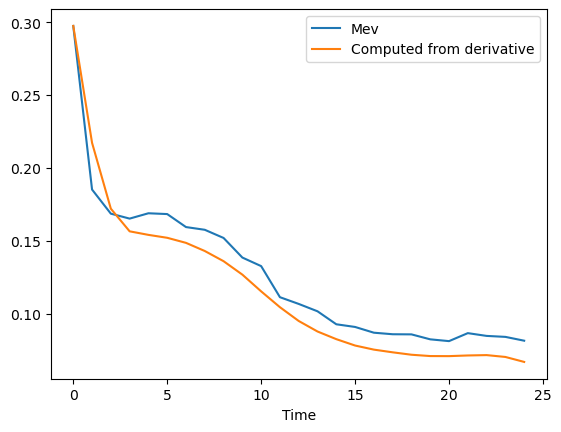

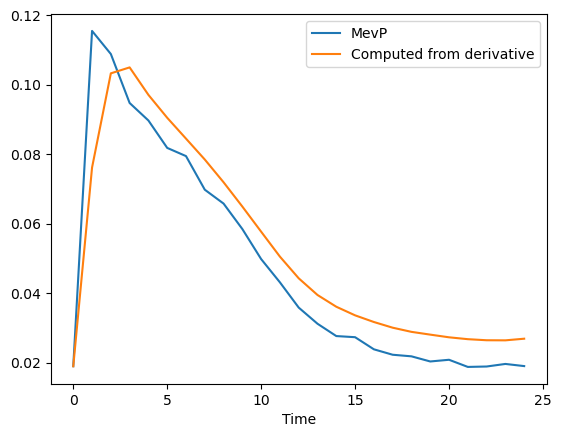

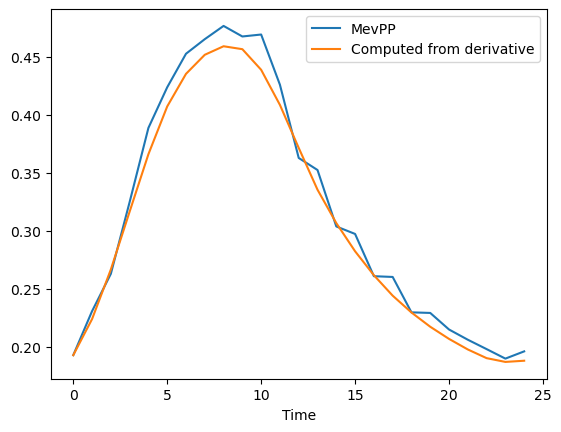

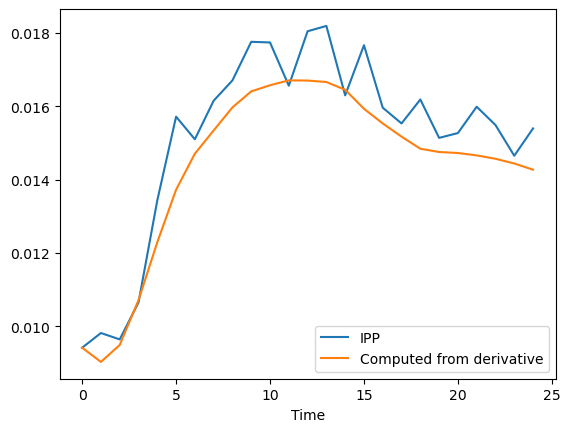

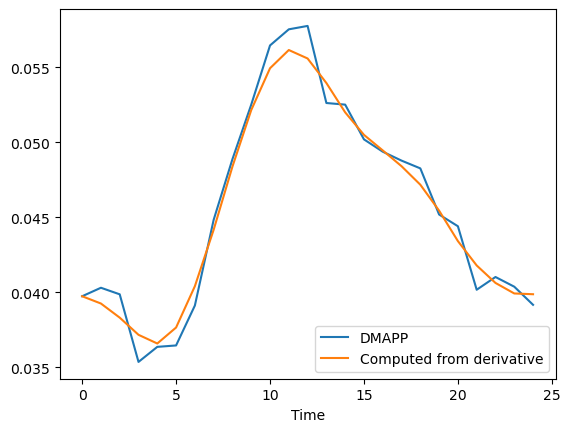

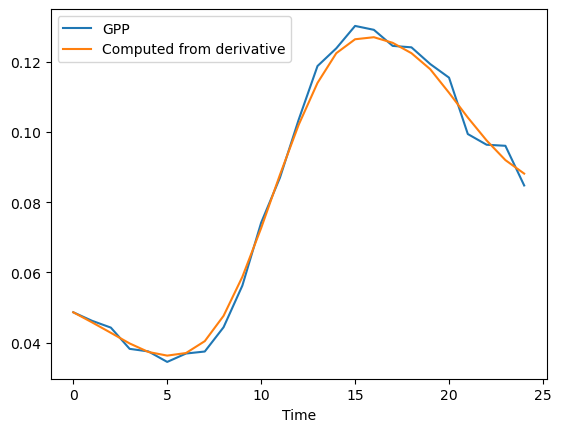

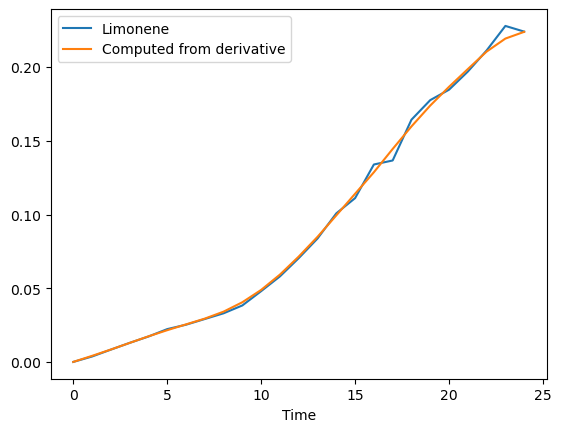

'Time profile from derivative vs. actual profile for WT'

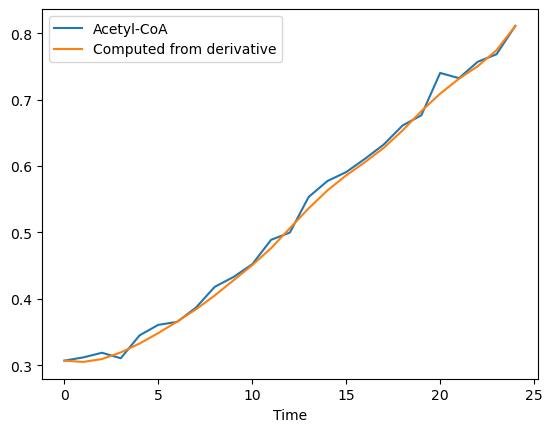

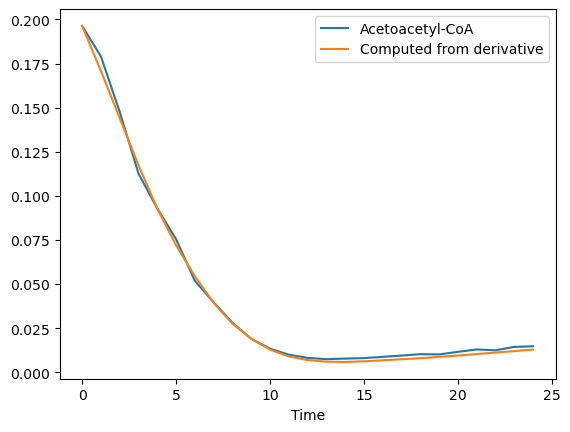

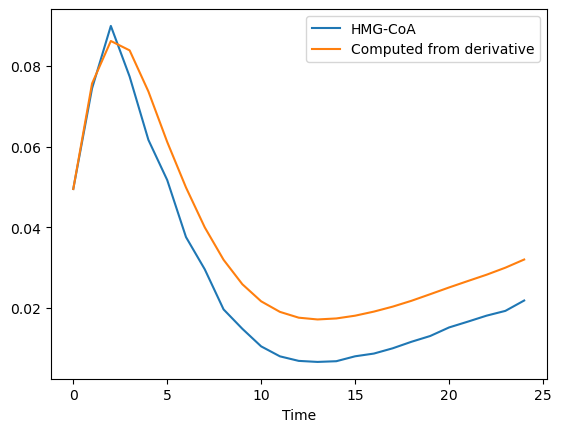

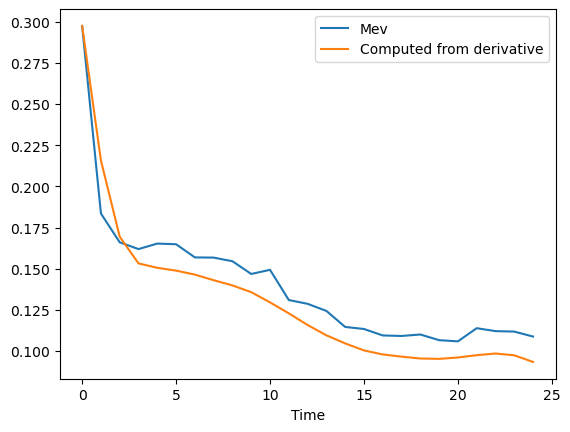

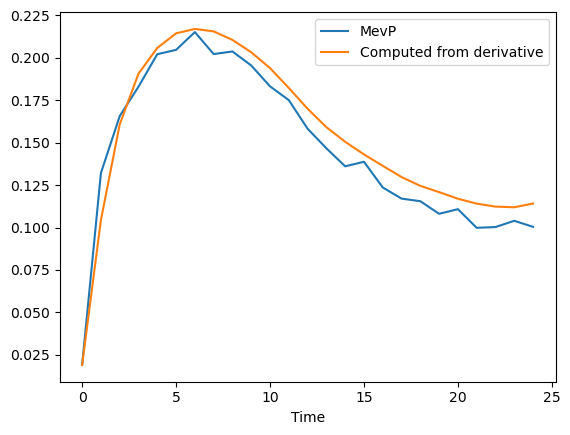

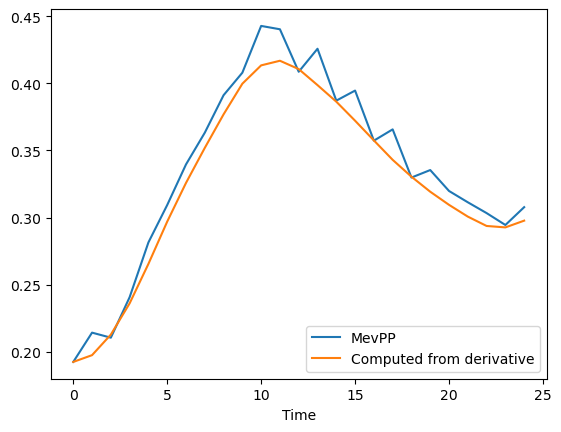

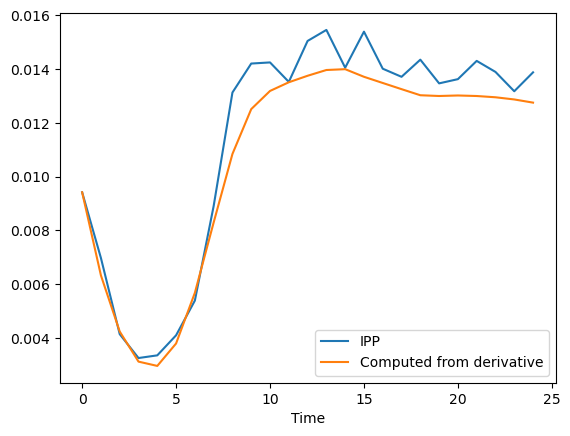

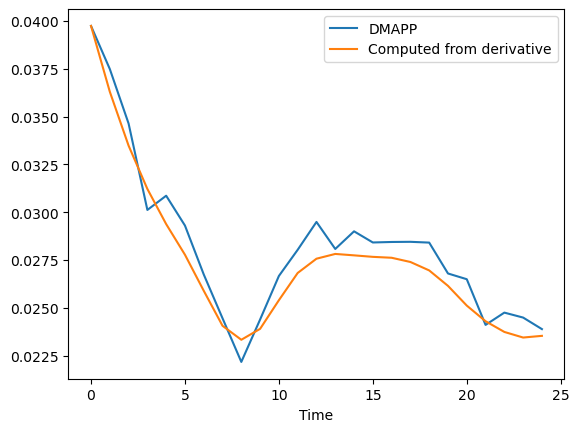

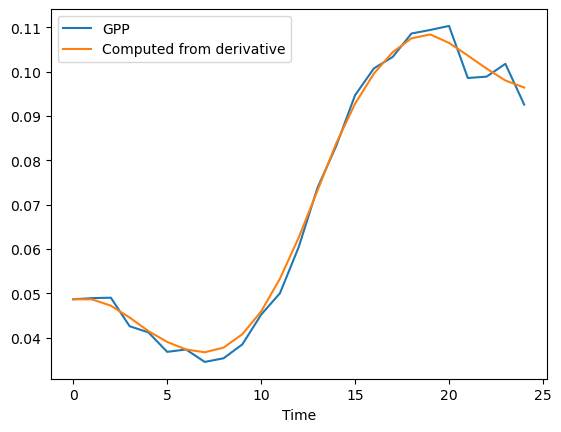

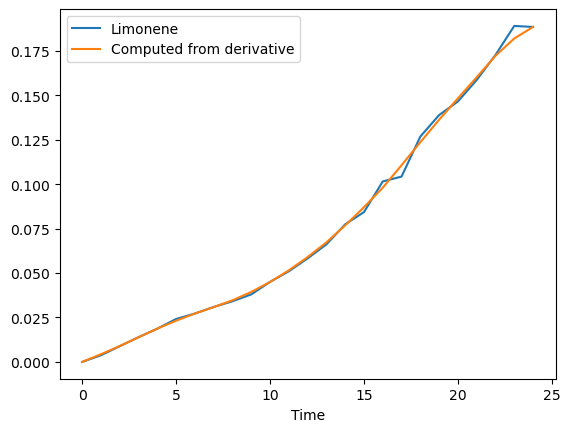

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                       AtoB          HMGS          HMGR            MK   
Strain   Time                                                           
Strain 1 0.0   6.082450e+01  3.899512e+01  3.661377e+01  5.713511e+01   
         1.0   6.146475e+06  4.521988e+06  4.808887e+05  3.034596e+06   
         2.0   6.357254e+06  5.562650e+06  5.767414e+05  3.850479e+06   
         3.0   6.741533e+06  6.040231e+06  6.546415e+05  3.893106e+06   
         4.0   6.607378e+06  5.744616e+06  6.469436e+05  4.469854e+06   
...                     ...           ...           ...           ...   
WT       20.0  2.693777e+06  2.722347e+06  1.766655e+06  1.973350e+06   
         21.0  2.827684e+06  2.619955e+06  1.641191e+06  2.002551e+06   
         22.0  2.749537e+06  2.752221e+06  1.830804e+06  1.990842e+06   
         23.0  2.812875e+06  2.745716e+06  1.744861e+06  2.002287e+06   
         24.0  2.854065e+06  2.570202e+06  1.642897e+06  1.977116e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.526772e+01  5.244708e+01  5.224924e+01  1.857013e+01   
         1.0   9.853482e+05  5.409896e+06  3.937284e+06  8.544349e+05   
         2.0   1.228962e+06  7.389592e+06  4.074265e+06  9.779973e+05   
         3.0   1.205014e+06  8.136914e+06  4.043052e+06  1.092896e+06   
         4.0   1.340911e+06  8.143322e+06  4.197575e+06  1.104371e+06   
...                     ...           ...           ...           ...   
WT       20.0  1.495346e+06  3.848462e+06  4.444885e+06  1.303004e+06   
         21.0  1.435514e+06  3.866720e+06  4.423761e+06  1.193403e+06   
         22.0  1.552444e+06  3.792124e+06  4.481707e+06  1.228084e+06   
         23.0  1.554259e+06  4.058035e+06  4.448439e+06  1.176464e+06   
         24.0  1.506139e+06  3.741661e+06  4.356475e+06  1.238988e+06   

                                    states                            \
              Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                          
Strain 1 0.0       2.950656e+01   0.306835        0.196300  0.049520   
         1.0       4.042867e+05   0.282697        0.176581  0.087728   
         2.0       4.939714e+05   0.254123        0.142941  0.082568   
         3.0       5.368635e+05   0.217567        0.105751  0.055444   
         4.0       5.805427e+05   0.214458        0.083180  0.035644   
...                         ...        ...             ...       ...   
WT       20.0      1.471492e+06   0.740142        0.011608  0.015189   
         21.0      1.494184e+06   0.732293        0.012957  0.016630   
         22.0      1.448535e+06   0.756917        0.012489  0.018118   
         23.0      1.454117e+06   0.768320        0.014410  0.019301   
         24.0      1.435983e+06   0.810953        0.014772  0.021873   

                                                                           \
                    Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                               
Strain 1 0.0   0.297461  0.018999  0.192532  0.009419  0.039748  0.048625   
         1.0   0.184113  0.133885  0.214255  0.007101  0.037460  0.050141   
         2.0   0.194118  0.180057  0.211037  0.004522  0.034353  0.052155   
         3.0   0.191026  0.221720  0.246870  0.003805  0.029583  0.047162   
         4.0   0.188577  0.256957  0.299917  0.004679  0.029792  0.047737   
...                 ...       ...       ...       ...       ...       ...   
WT       20.0  0.105922  0.110810  0.319837  0.013626  0.026497  0.110291   
         21.0  0.113921  0.099820  0.311421  0.014305  0.024106  0.098546   
         22.0  0.112138  0.100278  0.303367  0.013895  0.024749  0.098850   
         23.0  0.111857  0.103953  0.294

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0    -0.034724       -0.027063  0.033419 -0.080714  0.103178   
         1.0    -0.029856       -0.028385  0.013708 -0.050900  0.079776   
         2.0    -0.024988       -0.029707 -0.006003 -0.021085  0.056375   
         3.0    -0.020031       -0.028592 -0.017378 -0.000870  0.033171   
         4.0    -0.014577       -0.024728 -0.016710 -0.005805  0.021969   
...                   ...             ...       ...       ...       ...   
WT       20.0    0.024778        0.000720  0.001651  0.001137 -0.003873   
         21.0    0.020066        0.000941  0.001538  0.001663 -0.001881   
         22.0    0.017765        0.000778  0.001604  0.000378 -0.001669   
         23.0    0.030300        0.000837  0.001884 -0.002553  0.000916   
         24.0    0.042834        0.000897  0.002163 -0.005485  0.003500   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.004319 -0.003634 -0.003731  0.002064  0.002701  
         1.0   0.010210 -0.002456 -0.003255  0.000794  0.003026  
         2.0   0.024738 -0.001278 -0.002779 -0.000475  0.003350  
         3.0   0.034230  0.000125 -0.002558 -0.001410  0.003700  
         4.0   0.043226  0.001999 -0.002528 -0.000608  0.003606  
...                 ...       ...       ...       ...       ...  
WT       20.0 -0.007695 -0.000008 -0.001002 -0.003029  0.011161  
         21.0 -0.009830 -0.000032 -0.000636 -0.002672  0.012648  
         22.0 -0.004101 -0.000062 -0.000484 -0.003229  0.011425  
         23.0  0.001982 -0.000100 -0.000102 -0.002131  0.008123  
         24.0  0.008066 -0.000137  0.000279 -0.001033  0.004820  

[100 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 9.058472E+188 | 1.119490E+114
     2 |       74 | 1.126012E+130 |  5.892428E+84
     3 |      138 |  4.504650E+97 |  1.892252E+82
     4 |      202 |  4.647895E+85 |  2.178747E+71
     5 |      266 |  9.451746E+75 |  1.555886E+55
     6 |      330 |  8.779943E+69 |  1.300968E+53
     7 |      394 |  1.897922E+62 |  1.157355E+48
     8 |      458 |  3.561924E+52 |  1.282593E+44
     9 |      522 |  1.205327E+47 |  1.620711E+34
    10 |      586 |  2.231302E+43 |  8.929083E+33
    11 |      650 |  2.755219E+38 |  9.542455E+29
    12 |      714 |  3.833840E+39 |  9.542455E+29
    13 |      778 |  6.404188E+35 |  2.980521E+21
    14 |      842 |  2.790936E+31 |  2.980521E+21
    15 |      906 |  4.156117E+32 |  6.729437E+19
    16 |      970 |  3.150640E+27 |  6.729437E+19
    17 |     1034 |  5.963631E+27 |  4.545910E+15
    18 |     1098 |  9.043323E+24 |  4.545910E+15
    19 |     1162 |  2.370

   163 |    10378 |  2.228850E+01 |  2.017714E+01
   164 |    10442 |  2.260542E+01 |  2.017714E+01
   165 |    10506 |  2.256525E+01 |  2.017714E+01
   166 |    10570 |  2.255158E+01 |  2.017714E+01
   167 |    10634 |  2.240960E+01 |  2.017714E+01
   168 |    10698 |  2.265836E+01 |  2.017714E+01
   169 |    10762 |  2.249356E+01 |  2.017714E+01
   170 |    10826 |  2.302812E+01 |  2.017714E+01
   171 |    10890 |  2.160073E+01 |  1.963974E+01
   172 |    10954 |  2.344983E+01 |  1.963974E+01
   173 |    11018 |  2.286470E+01 |  1.963974E+01
   174 |    11082 |  2.239852E+01 |  1.963974E+01
   175 |    11146 |  2.158565E+01 |  1.963974E+01
   176 |    11210 |  2.212193E+01 |  1.963974E+01
   177 |    11274 |  2.304482E+01 |  1.963974E+01
   178 |    11338 |  2.147006E+01 |  1.889637E+01
   179 |    11402 |  2.031668E+01 |  1.889637E+01
   180 |    11466 |  2.222800E+01 |  1.889637E+01
   181 |    11530 |  2.107100E+01 |  1.889637E+01
   182 |    11594 |  2.132332E+01 |  1.889637E+01


   327 |    20874 |  1.142898E+01 |  1.070343E+01
   328 |    20938 |  1.154192E+01 |  1.070343E+01
   329 |    21002 |  1.140712E+01 |  1.070343E+01
   330 |    21066 |  1.135801E+01 |  1.070343E+01
   331 |    21130 |  1.109534E+01 |  1.070343E+01
   332 |    21194 |  1.099201E+01 |  1.047660E+01
   333 |    21258 |  1.126273E+01 |  1.047660E+01
   334 |    21322 |  1.101441E+01 |  1.047660E+01
   335 |    21386 |  1.086582E+01 |  1.047660E+01
   336 |    21450 |  1.073699E+01 |  1.047660E+01
   337 |    21514 |  1.079725E+01 |  1.034221E+01
   338 |    21578 |  1.082153E+01 |  1.034221E+01
   339 |    21642 |  1.092411E+01 |  1.034221E+01
   340 |    21706 |  1.102935E+01 |  1.034221E+01
   341 |    21770 |  1.109515E+01 |  1.034221E+01
   342 |    21834 |  1.098576E+01 |  1.034221E+01
   343 |    21898 |  1.082510E+01 |  1.034221E+01
   344 |    21962 |  1.074817E+01 |  1.031731E+01
   345 |    22026 |  1.069949E+01 |  1.024100E+01
   346 |    22090 |  1.062458E+01 |  1.018569E+01


   491 |    31370 |  9.2959023967 |  9.2299141040
   492 |    31434 |  9.2688549646 |  9.2273870656
   493 |    31498 |  9.2546899096 |  9.2175369377
   494 |    31562 |  9.2338899328 |  9.0891622551
   495 |    31626 |  9.1799327464 |  8.9747191554
   496 |    31690 |  9.1638871651 |  8.9592098673
   497 |    31754 |  9.2143015454 |  8.9592098673
   498 |    31818 |  9.1453487981 |  8.9592098673
   499 |    31882 |  9.2022214896 |  8.9592098673
   500 |    31946 |  9.2684151042 |  8.9592098673
   501 |    32010 |  9.1643296054 |  8.8948755738
   502 |    32074 |  9.1461349599 |  8.8948755738
   503 |    32138 |  9.1640129676 |  8.8948755738
   504 |    32202 |  9.0982073584 |  8.8903504655
   505 |    32266 |  9.1351327691 |  8.8903504655
   506 |    32330 |  9.1203252771 |  8.8903504655
   507 |    32394 |  9.0793154455 |  8.8903504655
   508 |    32458 |  9.0702594785 |  8.7662731756
   509 |    32522 |  9.0805257026 |  8.7662731756
   510 |    32586 |  9.0333103828 |  8.7662731756


   655 |    41866 |  7.7855623751 |  7.3354411815
   656 |    41930 |  7.8608758049 |  7.3354411815
   657 |    41994 |  7.7665029240 |  7.2143056301
   658 |    42058 |  7.8985432769 |  7.2143056301
   659 |    42122 |  7.7585170359 |  7.2143056301
   660 |    42186 |  7.6920838063 |  7.2143056301
   661 |    42250 |  7.6639829271 |  7.2143056301
   662 |    42314 |  7.5001700677 |  7.1587823044
   663 |    42378 |  7.4455787000 |  7.1587823044
   664 |    42442 |  7.5130928597 |  7.1587823044
   665 |    42506 |  7.5130795659 |  7.1587823044
   666 |    42570 |  7.4837091028 |  7.1587823044
   667 |    42634 |  7.6122906171 |  7.1587823044
   668 |    42698 |  7.6849709664 |  7.1587823044
   669 |    42762 |  7.6193493876 |  7.1587823044
   670 |    42826 |  7.7356648456 |  7.1587823044
   671 |    42890 |  7.7262656527 |  7.1587823044
   672 |    42954 |  7.7362297119 |  7.1587823044
   673 |    43018 |  7.7786808867 |  7.1587823044
   674 |    43082 |  7.6084478934 |  7.1587823044


   819 |    52362 |  6.5178570766 |  6.5111135708
   820 |    52426 |  6.5150683419 |  6.5069377785
   821 |    52490 |  6.5096917318 |  6.4939199251
   822 |    52554 |  6.5041531288 |  6.4939199251
   823 |    52618 |  6.4964393565 |  6.4886396471
   824 |    52682 |  6.4909084158 |  6.4788316788
   825 |    52746 |  6.4844625123 |  6.4736058070
   826 |    52810 |  6.4823992783 |  6.4734468458
   827 |    52874 |  6.4796582438 |  6.4696538781
   828 |    52938 |  6.4759722757 |  6.4696538781
   829 |    53002 |  6.4738454131 |  6.4548778071
   830 |    53066 |  6.4676992203 |  6.4537360863
   831 |    53130 |  6.4600842139 |  6.4464672963
   832 |    53194 |  6.4553155838 |  6.4462903350
   833 |    53258 |  6.4500903586 |  6.4446818486
   834 |    53322 |  6.4444068455 |  6.4360278386
   835 |    53386 |  6.4428562723 |  6.4337064867
   836 |    53450 |  6.4435318965 |  6.4337064867
   837 |    53514 |  6.4419847509 |  6.4337064867
   838 |    53578 |  6.4395799398 |  6.4337064867


   983 |    62858 |  5.9801235162 |  5.9760185017
   984 |    62922 |  5.9758999103 |  5.9678425391
   985 |    62986 |  5.9735046289 |  5.9678425391
   986 |    63050 |  5.9682158802 |  5.9610460240
   987 |    63114 |  5.9657596661 |  5.9609393419
   988 |    63178 |  5.9618617454 |  5.9554842912
   989 |    63242 |  5.9582000777 |  5.9554842912
   990 |    63306 |  5.9595818374 |  5.9541205926
   991 |    63370 |  5.9556536512 |  5.9504401176
   992 |    63434 |  5.9539397724 |  5.9476025212
   993 |    63498 |  5.9504671843 |  5.9453989494
   994 |    63562 |  5.9498476936 |  5.9433043965
   995 |    63626 |  5.9464112757 |  5.9391653218
   996 |    63690 |  5.9415017779 |  5.9375255060
   997 |    63754 |  5.9412263791 |  5.9342065884
   998 |    63818 |  5.9359738758 |  5.9284707346
   999 |    63882 |  5.9348147604 |  5.9272070124
  1000 |    63946 |  5.9332078157 |  5.9272070124
  1001 |    64010 |  5.9300496652 |  5.9203236109
  1002 |    64074 |  5.9255724571 |  5.9133663070


  1147 |    73354 |  5.5706496901 |  5.5663142660
  1148 |    73418 |  5.5676709613 |  5.5646875218
  1149 |    73482 |  5.5652631616 |  5.5628480456
  1150 |    73546 |  5.5640632587 |  5.5626306330
  1151 |    73610 |  5.5629868080 |  5.5615968201
  1152 |    73674 |  5.5628677104 |  5.5604013298
  1153 |    73738 |  5.5614731366 |  5.5586844248
  1154 |    73802 |  5.5601132394 |  5.5581919550
  1155 |    73866 |  5.5582645870 |  5.5564358067
  1156 |    73930 |  5.5570402978 |  5.5543794626
  1157 |    73994 |  5.5552305002 |  5.5542170949
  1158 |    74058 |  5.5547763753 |  5.5531492495
  1159 |    74122 |  5.5540367982 |  5.5526368526
  1160 |    74186 |  5.5540516325 |  5.5525478509
  1161 |    74250 |  5.5529315523 |  5.5509938384
  1162 |    74314 |  5.5519210367 |  5.5496826501
  1163 |    74378 |  5.5491028562 |  5.5468346926
  1164 |    74442 |  5.5469596089 |  5.5444738847
  1165 |    74506 |  5.5450523921 |  5.5422042713
  1166 |    74570 |  5.5433073210 |  5.5416602974


  1311 |    83850 |  5.2314306413 |  5.2235796520
  1312 |    83914 |  5.2292560141 |  5.2218349572
  1313 |    83978 |  5.2286036699 |  5.2218349572
  1314 |    84042 |  5.2286967647 |  5.2218349572
  1315 |    84106 |  5.2304467926 |  5.2218349572
  1316 |    84170 |  5.2235669889 |  5.2188884724
  1317 |    84234 |  5.2207671125 |  5.2168221132
  1318 |    84298 |  5.2221405163 |  5.2165835061
  1319 |    84362 |  5.2238185698 |  5.2165835061
  1320 |    84426 |  5.2191047652 |  5.2125844671
  1321 |    84490 |  5.2194164413 |  5.2118190430
  1322 |    84554 |  5.2193017157 |  5.2118190430
  1323 |    84618 |  5.2175099668 |  5.2075858576
  1324 |    84682 |  5.2164211091 |  5.2074168125
  1325 |    84746 |  5.2146813184 |  5.2074168125
  1326 |    84810 |  5.2135293925 |  5.2059673280
  1327 |    84874 |  5.2100323770 |  5.1996992618
  1328 |    84938 |  5.2093315454 |  5.1971586694
  1329 |    85002 |  5.2078046056 |  5.1971586694
  1330 |    85066 |  5.2052176396 |  5.1971586694


  1475 |    94346 |  4.9391754256 |  4.9363830433
  1476 |    94410 |  4.9380381904 |  4.9354960488
  1477 |    94474 |  4.9366802223 |  4.9336777617
  1478 |    94538 |  4.9350288634 |  4.9326001628
  1479 |    94602 |  4.9347378087 |  4.9326001628
  1480 |    94666 |  4.9343089490 |  4.9322413244
  1481 |    94730 |  4.9348771026 |  4.9322413244
  1482 |    94794 |  4.9340417191 |  4.9322413244
  1483 |    94858 |  4.9330872500 |  4.9310099238
  1484 |    94922 |  4.9332633530 |  4.9310099238
  1485 |    94986 |  4.9322833784 |  4.9309968993
  1486 |    95050 |  4.9321036085 |  4.9294922346
  1487 |    95114 |  4.9307867743 |  4.9276780930
  1488 |    95178 |  4.9304243424 |  4.9276780930
  1489 |    95242 |  4.9300711044 |  4.9276780930
  1490 |    95306 |  4.9304466059 |  4.9276780930
  1491 |    95370 |  4.9296374206 |  4.9273741024
  1492 |    95434 |  4.9295347615 |  4.9273741024
  1493 |    95498 |  4.9299073085 |  4.9273741024
  1494 |    95562 |  4.9299908014 |  4.9273741024


  1639 |   104842 |  4.8522504629 |  4.8506399781
  1640 |   104906 |  4.8500118003 |  4.8471380465
  1641 |   104970 |  4.8482944197 |  4.8468480266
  1642 |   105034 |  4.8472985654 |  4.8461110489
  1643 |   105098 |  4.8468180765 |  4.8449643056
  1644 |   105162 |  4.8455640531 |  4.8443871940
  1645 |   105226 |  4.8448066551 |  4.8431032310
  1646 |   105290 |  4.8434732355 |  4.8410939218
  1647 |   105354 |  4.8426700681 |  4.8410939218
  1648 |   105418 |  4.8416368452 |  4.8407475684
  1649 |   105482 |  4.8407711465 |  4.8393318200
  1650 |   105546 |  4.8401121243 |  4.8380543615
  1651 |   105610 |  4.8390566751 |  4.8371858355
  1652 |   105674 |  4.8381956457 |  4.8371858355
  1653 |   105738 |  4.8375042786 |  4.8362345059
  1654 |   105802 |  4.8370472435 |  4.8355870468
  1655 |   105866 |  4.8368932539 |  4.8355870468
  1656 |   105930 |  4.8361517372 |  4.8347329580
  1657 |   105994 |  4.8357928021 |  4.8347329580
  1658 |   106058 |  4.8356247994 |  4.8346340105


  1803 |   115338 |  4.7757291653 |  4.7751608243
  1804 |   115402 |  4.7754662077 |  4.7750703918
  1805 |   115466 |  4.7752196680 |  4.7747533930
  1806 |   115530 |  4.7749494183 |  4.7745976988
  1807 |   115594 |  4.7746307786 |  4.7741824263
  1808 |   115658 |  4.7746417874 |  4.7741563565
  1809 |   115722 |  4.7743912333 |  4.7738884676
  1810 |   115786 |  4.7740776289 |  4.7732004410
  1811 |   115850 |  4.7741039202 |  4.7732004410
  1812 |   115914 |  4.7736723868 |  4.7724569494
  1813 |   115978 |  4.7735072839 |  4.7724569494
  1814 |   116042 |  4.7735153150 |  4.7724569494
  1815 |   116106 |  4.7728807116 |  4.7724148515
  1816 |   116170 |  4.7729149256 |  4.7724148515
  1817 |   116234 |  4.7727804085 |  4.7723436394
  1818 |   116298 |  4.7724629037 |  4.7713895722
  1819 |   116362 |  4.7721707225 |  4.7713895722
  1820 |   116426 |  4.7720298274 |  4.7713895722
  1821 |   116490 |  4.7717455823 |  4.7713505658
  1822 |   116554 |  4.7714081163 |  4.7707877331


  1967 |   125834 |  4.7527784814 |  4.7525083010
  1968 |   125898 |  4.7526611418 |  4.7522834528
  1969 |   125962 |  4.7524514815 |  4.7521178650
  1970 |   126026 |  4.7523437601 |  4.7520941291
  1971 |   126090 |  4.7521385668 |  4.7520380429
  1972 |   126154 |  4.7520176376 |  4.7517709141
  1973 |   126218 |  4.7518695909 |  4.7516500300
  1974 |   126282 |  4.7517804227 |  4.7515916151
  1975 |   126346 |  4.7517245123 |  4.7514906956
  1976 |   126410 |  4.7515826574 |  4.7514124431
  1977 |   126474 |  4.7514882716 |  4.7514124431
  1978 |   126538 |  4.7514002855 |  4.7512284721
  1979 |   126602 |  4.7512655951 |  4.7510988474
  1980 |   126666 |  4.7512021530 |  4.7510077162
  1981 |   126730 |  4.7511913496 |  4.7510077162
  1982 |   126794 |  4.7511506564 |  4.7510077162
  1983 |   126858 |  4.7510450919 |  4.7509046439
  1984 |   126922 |  4.7509659784 |  4.7508725851
  1985 |   126986 |  4.7508946173 |  4.7507881108
  1986 |   127050 |  4.7507666548 |  4.7506096723


  2131 |   136330 |  4.7274830025 |  4.7266580674
  2132 |   136394 |  4.7271162577 |  4.7261435844
  2133 |   136458 |  4.7267937010 |  4.7261435844
  2134 |   136522 |  4.7262951089 |  4.7257498976
  2135 |   136586 |  4.7259155599 |  4.7253289645
  2136 |   136650 |  4.7257443691 |  4.7251576283
  2137 |   136714 |  4.7254893934 |  4.7249979908
  2138 |   136778 |  4.7254742473 |  4.7249979908
  2139 |   136842 |  4.7250802709 |  4.7245616629
  2140 |   136906 |  4.7247622825 |  4.7242118272
  2141 |   136970 |  4.7248764993 |  4.7242118272
  2142 |   137034 |  4.7246665135 |  4.7240471915
  2143 |   137098 |  4.7241959092 |  4.7238213115
  2144 |   137162 |  4.7240829337 |  4.7238213115
  2145 |   137226 |  4.7240440727 |  4.7235069028
  2146 |   137290 |  4.7238577082 |  4.7235069028
  2147 |   137354 |  4.7237655345 |  4.7235069028
  2148 |   137418 |  4.7236744482 |  4.7233643685
  2149 |   137482 |  4.7235129834 |  4.7231418015
  2150 |   137546 |  4.7232627479 |  4.7227668380


  2295 |   146826 |  4.7034466425 |  4.7032230430
  2296 |   146890 |  4.7033016627 |  4.7028990978
  2297 |   146954 |  4.7032985348 |  4.7028990978
  2298 |   147018 |  4.7033215415 |  4.7028990978
  2299 |   147082 |  4.7031872023 |  4.7028990978
  2300 |   147146 |  4.7031718962 |  4.7028990978
  2301 |   147210 |  4.7030505289 |  4.7028277828
  2302 |   147274 |  4.7030173673 |  4.7028277828
  2303 |   147338 |  4.7029335772 |  4.7028170729
  2304 |   147402 |  4.7028631395 |  4.7026683302
  2305 |   147466 |  4.7029047040 |  4.7026595000
  2306 |   147530 |  4.7028588521 |  4.7026119417
  2307 |   147594 |  4.7027981803 |  4.7025526775
  2308 |   147658 |  4.7027375383 |  4.7025233804
  2309 |   147722 |  4.7027543300 |  4.7025233804
  2310 |   147786 |  4.7027072926 |  4.7025233804
  2311 |   147850 |  4.7026967362 |  4.7024973374
  2312 |   147914 |  4.7025868859 |  4.7024969249
  2313 |   147978 |  4.7025702495 |  4.7023467998
  2314 |   148042 |  4.7024850054 |  4.7022855343


  2459 |   157322 |  4.6951799025 |  4.6950109479
  2460 |   157386 |  4.6951465938 |  4.6950109479
  2461 |   157450 |  4.6950935716 |  4.6950109479
  2462 |   157514 |  4.6950805250 |  4.6950109479
  2463 |   157578 |  4.6950447153 |  4.6949773873
  2464 |   157642 |  4.6950499677 |  4.6949396540
  2465 |   157706 |  4.6950478697 |  4.6949396540
  2466 |   157770 |  4.6950692273 |  4.6949396540
  2467 |   157834 |  4.6950689293 |  4.6949396540
  2468 |   157898 |  4.6950025866 |  4.6949252379
  2469 |   157962 |  4.6949432947 |  4.6948308015
  2470 |   158026 |  4.6949293703 |  4.6948028838
  2471 |   158090 |  4.6948490736 |  4.6947804762
  2472 |   158154 |  4.6948267648 |  4.6947778105
  2473 |   158218 |  4.6948270248 |  4.6947689088
  2474 |   158282 |  4.6948078906 |  4.6947689088
  2475 |   158346 |  4.6948202608 |  4.6947565426
  2476 |   158410 |  4.6948233895 |  4.6947565426
  2477 |   158474 |  4.6947997464 |  4.6947024848
  2478 |   158538 |  4.6947707202 |  4.6946215544


  2623 |   167818 |  4.6887987306 |  4.6887122546
  2624 |   167882 |  4.6887034897 |  4.6884816934
  2625 |   167946 |  4.6886527684 |  4.6884816934
  2626 |   168010 |  4.6885458043 |  4.6884248480
  2627 |   168074 |  4.6884392691 |  4.6883436735
  2628 |   168138 |  4.6884191917 |  4.6883436735
  2629 |   168202 |  4.6884059687 |  4.6883436735
  2630 |   168266 |  4.6883797198 |  4.6883225701
  2631 |   168330 |  4.6883572881 |  4.6882292245
  2632 |   168394 |  4.6882948766 |  4.6881826220
  2633 |   168458 |  4.6882507958 |  4.6880981176
  2634 |   168522 |  4.6881868511 |  4.6880847403
  2635 |   168586 |  4.6881463085 |  4.6880847403
  2636 |   168650 |  4.6881181231 |  4.6880400760
  2637 |   168714 |  4.6880414378 |  4.6880073159
  2638 |   168778 |  4.6880326823 |  4.6879755954
  2639 |   168842 |  4.6880130876 |  4.6879345866
  2640 |   168906 |  4.6879553604 |  4.6878344669
  2641 |   168970 |  4.6878820751 |  4.6878074359
  2642 |   169034 |  4.6878386447 |  4.6877914324


  2787 |   178314 |  4.6787769307 |  4.6787155059
  2788 |   178378 |  4.6787736584 |  4.6787155059
  2789 |   178442 |  4.6787740718 |  4.6787155059
  2790 |   178506 |  4.6787422415 |  4.6786918935
  2791 |   178570 |  4.6787116694 |  4.6786669164
  2792 |   178634 |  4.6786826494 |  4.6785979227
  2793 |   178698 |  4.6786315109 |  4.6785614775
  2794 |   178762 |  4.6786004814 |  4.6785167550
  2795 |   178826 |  4.6785623156 |  4.6785167550
  2796 |   178890 |  4.6785221340 |  4.6784405252
  2797 |   178954 |  4.6784943094 |  4.6784192893
  2798 |   179018 |  4.6784695469 |  4.6784048610
  2799 |   179082 |  4.6784284842 |  4.6783097789
  2800 |   179146 |  4.6783836946 |  4.6783097789
  2801 |   179210 |  4.6783515061 |  4.6782494650
  2802 |   179274 |  4.6783153436 |  4.6782403676
  2803 |   179338 |  4.6782810541 |  4.6781524165
  2804 |   179402 |  4.6782422508 |  4.6781524165
  2805 |   179466 |  4.6782029239 |  4.6781088447
  2806 |   179530 |  4.6781619100 |  4.6781088447


  2951 |   188810 |  4.6676557705 |  4.6675984578
  2952 |   188874 |  4.6675781969 |  4.6674660384
  2953 |   188938 |  4.6675524965 |  4.6674660384
  2954 |   189002 |  4.6675210651 |  4.6674168688
  2955 |   189066 |  4.6674616839 |  4.6673813937
  2956 |   189130 |  4.6674343611 |  4.6673813937
  2957 |   189194 |  4.6673861967 |  4.6673092285
  2958 |   189258 |  4.6673383581 |  4.6672042426
  2959 |   189322 |  4.6672658971 |  4.6671365018
  2960 |   189386 |  4.6672106042 |  4.6671365018
  2961 |   189450 |  4.6671981097 |  4.6671365018
  2962 |   189514 |  4.6671699649 |  4.6671085510
  2963 |   189578 |  4.6671362357 |  4.6670535318
  2964 |   189642 |  4.6670931031 |  4.6670220565
  2965 |   189706 |  4.6669985830 |  4.6668060785
  2966 |   189770 |  4.6669171950 |  4.6668060785
  2967 |   189834 |  4.6668703327 |  4.6667978647
  2968 |   189898 |  4.6668539423 |  4.6667807756
  2969 |   189962 |  4.6667746797 |  4.6666315757
  2970 |   190026 |  4.6667199591 |  4.6666306067


  3115 |   199306 |  4.6540575767 |  4.6538626912
  3116 |   199370 |  4.6538842974 |  4.6537311770
  3117 |   199434 |  4.6538102506 |  4.6535713804
  3118 |   199498 |  4.6537274984 |  4.6534199269
  3119 |   199562 |  4.6535486574 |  4.6531405686
  3120 |   199626 |  4.6531407407 |  4.6527979072
  3121 |   199690 |  4.6528415260 |  4.6524172777
  3122 |   199754 |  4.6525877673 |  4.6519430746
  3123 |   199818 |  4.6521900229 |  4.6519430746
  3124 |   199882 |  4.6521091203 |  4.6519430746
  3125 |   199946 |  4.6519560184 |  4.6517497382
  3126 |   200010 |  4.6517914081 |  4.6517282131
  3127 |   200074 |  4.6517164391 |  4.6515066703
  3128 |   200138 |  4.6516571555 |  4.6513603364
  3129 |   200202 |  4.6514611100 |  4.6512654126
  3130 |   200266 |  4.6513892734 |  4.6509573632
  3131 |   200330 |  4.6510838311 |  4.6508242121
  3132 |   200394 |  4.6509175834 |  4.6507731561
  3133 |   200458 |  4.6508095857 |  4.6506240149
  3134 |   200522 |  4.6507780416 |  4.6505707006


  3279 |   209802 |  4.6443753902 |  4.6443074354
  3280 |   209866 |  4.6443320508 |  4.6442749812
  3281 |   209930 |  4.6442979790 |  4.6442300867
  3282 |   209994 |  4.6442510502 |  4.6442106001
  3283 |   210058 |  4.6442390070 |  4.6441734012
  3284 |   210122 |  4.6442226360 |  4.6441491505
  3285 |   210186 |  4.6442184246 |  4.6441491505
  3286 |   210250 |  4.6442153123 |  4.6441491505
  3287 |   210314 |  4.6441762829 |  4.6441108270
  3288 |   210378 |  4.6441417381 |  4.6440764956
  3289 |   210442 |  4.6441129451 |  4.6440764956
  3290 |   210506 |  4.6440958291 |  4.6440096034
  3291 |   210570 |  4.6440990584 |  4.6440096034
  3292 |   210634 |  4.6440786870 |  4.6440068848
  3293 |   210698 |  4.6440486251 |  4.6439467344
  3294 |   210762 |  4.6440160767 |  4.6439467344
  3295 |   210826 |  4.6440008882 |  4.6439336857
  3296 |   210890 |  4.6439529276 |  4.6438929993
  3297 |   210954 |  4.6439068487 |  4.6438329194
  3298 |   211018 |  4.6438491189 |  4.6437736886


  3443 |   220298 |  4.6407205895 |  4.6406703637
  3444 |   220362 |  4.6406859263 |  4.6406219225
  3445 |   220426 |  4.6406732735 |  4.6406219225
  3446 |   220490 |  4.6406660951 |  4.6406219225
  3447 |   220554 |  4.6406557923 |  4.6406162659
  3448 |   220618 |  4.6406417951 |  4.6406057174
  3449 |   220682 |  4.6406318990 |  4.6406057174
  3450 |   220746 |  4.6406276505 |  4.6406004686
  3451 |   220810 |  4.6406104093 |  4.6405528664
  3452 |   220874 |  4.6405698707 |  4.6405467358
  3453 |   220938 |  4.6405509750 |  4.6405214497
  3454 |   221002 |  4.6405557627 |  4.6405159321
  3455 |   221066 |  4.6405520409 |  4.6404993142
  3456 |   221130 |  4.6405177380 |  4.6404692918
  3457 |   221194 |  4.6405090317 |  4.6404595184
  3458 |   221258 |  4.6405045878 |  4.6404595184
  3459 |   221322 |  4.6404805529 |  4.6404485181
  3460 |   221386 |  4.6404844885 |  4.6404472300
  3461 |   221450 |  4.6404664281 |  4.6404130499
  3462 |   221514 |  4.6404488500 |  4.6404130499


  3607 |   230794 |  4.6377215315 |  4.6376708354
  3608 |   230858 |  4.6376802696 |  4.6375696674
  3609 |   230922 |  4.6376384950 |  4.6375696674
  3610 |   230986 |  4.6375831262 |  4.6375056528
  3611 |   231050 |  4.6375631282 |  4.6374598315
  3612 |   231114 |  4.6374876011 |  4.6373546942
  3613 |   231178 |  4.6374894958 |  4.6373546942
  3614 |   231242 |  4.6374167171 |  4.6373209730
  3615 |   231306 |  4.6373452718 |  4.6372459750
  3616 |   231370 |  4.6372794154 |  4.6372088056
  3617 |   231434 |  4.6372270681 |  4.6371781547
  3618 |   231498 |  4.6371661973 |  4.6370886418
  3619 |   231562 |  4.6371156676 |  4.6369908340
  3620 |   231626 |  4.6370632104 |  4.6369908340
  3621 |   231690 |  4.6369835684 |  4.6369119936
  3622 |   231754 |  4.6369228551 |  4.6367971618
  3623 |   231818 |  4.6368342538 |  4.6367598963
  3624 |   231882 |  4.6367734953 |  4.6367325469
  3625 |   231946 |  4.6367547765 |  4.6366468008
  3626 |   232010 |  4.6367125755 |  4.6365662882


  3771 |   241290 |  4.6318085948 |  4.6317732209
  3772 |   241354 |  4.6317801229 |  4.6317314641
  3773 |   241418 |  4.6317591056 |  4.6317255795
  3774 |   241482 |  4.6317358187 |  4.6316969810
  3775 |   241546 |  4.6316983100 |  4.6316041688
  3776 |   241610 |  4.6316297223 |  4.6315410740
  3777 |   241674 |  4.6315929103 |  4.6314890432
  3778 |   241738 |  4.6315665006 |  4.6314584771
  3779 |   241802 |  4.6314951066 |  4.6314244956
  3780 |   241866 |  4.6314462511 |  4.6312761998
  3781 |   241930 |  4.6313857520 |  4.6312761998
  3782 |   241994 |  4.6312846883 |  4.6311093135
  3783 |   242058 |  4.6311671615 |  4.6310381477
  3784 |   242122 |  4.6310962788 |  4.6309577385
  3785 |   242186 |  4.6310294116 |  4.6308822757
  3786 |   242250 |  4.6309266167 |  4.6307167107
  3787 |   242314 |  4.6308636142 |  4.6307167107
  3788 |   242378 |  4.6308310340 |  4.6307167107
  3789 |   242442 |  4.6307950838 |  4.6306829511
  3790 |   242506 |  4.6307206245 |  4.6306351317


  3935 |   251786 |  4.6242072637 |  4.6241668179
  3936 |   251850 |  4.6241974190 |  4.6241375100
  3937 |   251914 |  4.6241767802 |  4.6241309135
  3938 |   251978 |  4.6241699100 |  4.6241166109
  3939 |   252042 |  4.6241262001 |  4.6240884322
  3940 |   252106 |  4.6241210085 |  4.6240725371
  3941 |   252170 |  4.6240885346 |  4.6240445438
  3942 |   252234 |  4.6240594878 |  4.6240092217
  3943 |   252298 |  4.6240197432 |  4.6239687049
  3944 |   252362 |  4.6240078112 |  4.6239584672
  3945 |   252426 |  4.6239831088 |  4.6239263192
  3946 |   252490 |  4.6239597536 |  4.6239072545
  3947 |   252554 |  4.6239216891 |  4.6238422198
  3948 |   252618 |  4.6238961809 |  4.6238422198
  3949 |   252682 |  4.6238866688 |  4.6238119112
  3950 |   252746 |  4.6238634100 |  4.6238119112
  3951 |   252810 |  4.6238306231 |  4.6237870231
  3952 |   252874 |  4.6237622772 |  4.6236553048
  3953 |   252938 |  4.6237185581 |  4.6236487197
  3954 |   253002 |  4.6236598706 |  4.6236094115


  4099 |   262282 |  4.6142262351 |  4.6139424216
  4100 |   262346 |  4.6140551267 |  4.6138933558
  4101 |   262410 |  4.6139130258 |  4.6137696668
  4102 |   262474 |  4.6139171634 |  4.6137220879
  4103 |   262538 |  4.6138036913 |  4.6137220879
  4104 |   262602 |  4.6137514561 |  4.6136751824
  4105 |   262666 |  4.6136706200 |  4.6135300544
  4106 |   262730 |  4.6136087548 |  4.6134153856
  4107 |   262794 |  4.6135371958 |  4.6134153856
  4108 |   262858 |  4.6134543595 |  4.6132744433
  4109 |   262922 |  4.6133666257 |  4.6132077522
  4110 |   262986 |  4.6132727044 |  4.6131741944
  4111 |   263050 |  4.6132537710 |  4.6131203308
  4112 |   263114 |  4.6132933270 |  4.6131203308
  4113 |   263178 |  4.6132768094 |  4.6131203308
  4114 |   263242 |  4.6132087969 |  4.6130646170
  4115 |   263306 |  4.6130693581 |  4.6129269870
  4116 |   263370 |  4.6129897066 |  4.6129125996
  4117 |   263434 |  4.6129966746 |  4.6129125996
  4118 |   263498 |  4.6130072525 |  4.6129125996


  4263 |   272778 |  4.6034237073 |  4.6032056425
  4264 |   272842 |  4.6033098794 |  4.6031564908
  4265 |   272906 |  4.6031964334 |  4.6030437984
  4266 |   272970 |  4.6031102203 |  4.6029593298
  4267 |   273034 |  4.6030660103 |  4.6028559824
  4268 |   273098 |  4.6030220007 |  4.6028400222
  4269 |   273162 |  4.6030068555 |  4.6028400222
  4270 |   273226 |  4.6029982637 |  4.6028400222
  4271 |   273290 |  4.6029559498 |  4.6028171797
  4272 |   273354 |  4.6028475198 |  4.6026376258
  4273 |   273418 |  4.6028092301 |  4.6026376258
  4274 |   273482 |  4.6028805825 |  4.6026376258
  4275 |   273546 |  4.6028624836 |  4.6026376258
  4276 |   273610 |  4.6027988372 |  4.6025935933
  4277 |   273674 |  4.6027063590 |  4.6025935933
  4278 |   273738 |  4.6025951352 |  4.6023932073
  4279 |   273802 |  4.6026068917 |  4.6023691928
  4280 |   273866 |  4.6025179666 |  4.6022234630
  4281 |   273930 |  4.6024090244 |  4.6021488701
  4282 |   273994 |  4.6023703374 |  4.6021143461


  4427 |   283274 |  4.5965610603 |  4.5965389955
  4428 |   283338 |  4.5965533012 |  4.5965112198
  4429 |   283402 |  4.5965510526 |  4.5964952363
  4430 |   283466 |  4.5965224403 |  4.5964641509
  4431 |   283530 |  4.5965117365 |  4.5964612120
  4432 |   283594 |  4.5965122660 |  4.5964532944
  4433 |   283658 |  4.5964772068 |  4.5964523313
  4434 |   283722 |  4.5964524701 |  4.5964142237
  4435 |   283786 |  4.5964185081 |  4.5963281170
  4436 |   283850 |  4.5963877097 |  4.5963281170
  4437 |   283914 |  4.5964060635 |  4.5963281170
  4438 |   283978 |  4.5963832334 |  4.5963055123
  4439 |   284042 |  4.5963215402 |  4.5962319693
  4440 |   284106 |  4.5962996171 |  4.5961493548
  4441 |   284170 |  4.5962290532 |  4.5961493548
  4442 |   284234 |  4.5962093836 |  4.5961493548
  4443 |   284298 |  4.5961998443 |  4.5961346894
  4444 |   284362 |  4.5961755483 |  4.5961346894
  4445 |   284426 |  4.5961732703 |  4.5960712935
  4446 |   284490 |  4.5961286697 |  4.5960380965


  4591 |   293770 |  4.5932048180 |  4.5931350989
  4592 |   293834 |  4.5931795237 |  4.5931304081
  4593 |   293898 |  4.5931537458 |  4.5931250793
  4594 |   293962 |  4.5931527418 |  4.5931179621
  4595 |   294026 |  4.5931185754 |  4.5930735778
  4596 |   294090 |  4.5930680140 |  4.5930189058
  4597 |   294154 |  4.5930468137 |  4.5930189058
  4598 |   294218 |  4.5930384630 |  4.5930004971
  4599 |   294282 |  4.5930205453 |  4.5929905098
  4600 |   294346 |  4.5930026682 |  4.5929586120
  4601 |   294410 |  4.5929738759 |  4.5929384116
  4602 |   294474 |  4.5929570062 |  4.5929236713
  4603 |   294538 |  4.5929333946 |  4.5929006154
  4604 |   294602 |  4.5929071469 |  4.5928901130
  4605 |   294666 |  4.5928960495 |  4.5928292358
  4606 |   294730 |  4.5928570703 |  4.5928292358
  4607 |   294794 |  4.5928300934 |  4.5927833443
  4608 |   294858 |  4.5928022352 |  4.5927509475
  4609 |   294922 |  4.5927697835 |  4.5927165287
  4610 |   294986 |  4.5927275987 |  4.5926736027


  4755 |   304266 |  4.5864023705 |  4.5862823880
  4756 |   304330 |  4.5863564765 |  4.5862515316
  4757 |   304394 |  4.5863276174 |  4.5862515316
  4758 |   304458 |  4.5863305513 |  4.5862042148
  4759 |   304522 |  4.5863117569 |  4.5861668367
  4760 |   304586 |  4.5862625135 |  4.5861668367
  4761 |   304650 |  4.5862233700 |  4.5860867139
  4762 |   304714 |  4.5862171613 |  4.5860867139
  4763 |   304778 |  4.5861916717 |  4.5860867139
  4764 |   304842 |  4.5861973441 |  4.5860867139
  4765 |   304906 |  4.5862198067 |  4.5860691041
  4766 |   304970 |  4.5862083274 |  4.5860691041
  4767 |   305034 |  4.5862072313 |  4.5860691041
  4768 |   305098 |  4.5862278004 |  4.5860691041
  4769 |   305162 |  4.5861671238 |  4.5859605016
  4770 |   305226 |  4.5861393631 |  4.5859605016
  4771 |   305290 |  4.5861234883 |  4.5859605016
  4772 |   305354 |  4.5861015771 |  4.5859605016
  4773 |   305418 |  4.5859925481 |  4.5858206345
  4774 |   305482 |  4.5859440640 |  4.5858206345


  4919 |   314762 |  4.5814871669 |  4.5814324150
  4920 |   314826 |  4.5814626401 |  4.5814324150
  4921 |   314890 |  4.5814501689 |  4.5814213574
  4922 |   314954 |  4.5814137881 |  4.5813595598
  4923 |   315018 |  4.5813785001 |  4.5813445644
  4924 |   315082 |  4.5813509412 |  4.5812810805
  4925 |   315146 |  4.5813416509 |  4.5812810805
  4926 |   315210 |  4.5813080822 |  4.5812722536
  4927 |   315274 |  4.5812896039 |  4.5812646381
  4928 |   315338 |  4.5812741432 |  4.5812142946
  4929 |   315402 |  4.5812359841 |  4.5811683764
  4930 |   315466 |  4.5812069684 |  4.5811591028
  4931 |   315530 |  4.5811764804 |  4.5811036646
  4932 |   315594 |  4.5811432565 |  4.5810906582
  4933 |   315658 |  4.5811218281 |  4.5810082114
  4934 |   315722 |  4.5810715428 |  4.5810064245
  4935 |   315786 |  4.5810446781 |  4.5809953552
  4936 |   315850 |  4.5810045291 |  4.5809739599
  4937 |   315914 |  4.5809852861 |  4.5809453189
  4938 |   315978 |  4.5809512632 |  4.5809082379


  5083 |   325258 |  4.5783384209 |  4.5782831109
  5084 |   325322 |  4.5783125285 |  4.5782578334
  5085 |   325386 |  4.5783136874 |  4.5782578334
  5086 |   325450 |  4.5783235659 |  4.5782578334
  5087 |   325514 |  4.5783364822 |  4.5782578334
  5088 |   325578 |  4.5783338806 |  4.5782578334
  5089 |   325642 |  4.5783171377 |  4.5782443578
  5090 |   325706 |  4.5782846989 |  4.5782443578
  5091 |   325770 |  4.5782636520 |  4.5781709139
  5092 |   325834 |  4.5782578504 |  4.5781709139
  5093 |   325898 |  4.5782462445 |  4.5781709139
  5094 |   325962 |  4.5782149459 |  4.5781709139
  5095 |   326026 |  4.5781946700 |  4.5781453522
  5096 |   326090 |  4.5781801727 |  4.5781453522
  5097 |   326154 |  4.5781869612 |  4.5781453522
  5098 |   326218 |  4.5781865375 |  4.5781453522
  5099 |   326282 |  4.5781754872 |  4.5781453522
  5100 |   326346 |  4.5781589888 |  4.5781295238
  5101 |   326410 |  4.5781364043 |  4.5781024260
  5102 |   326474 |  4.5781306948 |  4.5781024260


  5247 |   335754 |  4.5748163610 |  4.5747729460
  5248 |   335818 |  4.5747809202 |  4.5746926738
  5249 |   335882 |  4.5747264314 |  4.5746206211
  5250 |   335946 |  4.5746784833 |  4.5745768009
  5251 |   336010 |  4.5745745361 |  4.5744375699
  5252 |   336074 |  4.5745047214 |  4.5744047600
  5253 |   336138 |  4.5744767278 |  4.5743955633
  5254 |   336202 |  4.5744013840 |  4.5743605619
  5255 |   336266 |  4.5743614119 |  4.5742987915
  5256 |   336330 |  4.5743177305 |  4.5741342928
  5257 |   336394 |  4.5741357334 |  4.5739340839
  5258 |   336458 |  4.5740293680 |  4.5738898426
  5259 |   336522 |  4.5739192964 |  4.5738242148
  5260 |   336586 |  4.5738361321 |  4.5737650838
  5261 |   336650 |  4.5738099876 |  4.5737229756
  5262 |   336714 |  4.5737553853 |  4.5736871123
  5263 |   336778 |  4.5737138603 |  4.5736784924
  5264 |   336842 |  4.5736834670 |  4.5736211856
  5265 |   336906 |  4.5736505690 |  4.5735791483
  5266 |   336970 |  4.5736103206 |  4.5735630747


  5411 |   346250 |  4.5689933615 |  4.5689374874
  5412 |   346314 |  4.5689886780 |  4.5689374874
  5413 |   346378 |  4.5689990219 |  4.5689374874
  5414 |   346442 |  4.5689861164 |  4.5689374874
  5415 |   346506 |  4.5689756872 |  4.5689229929
  5416 |   346570 |  4.5689631388 |  4.5689229929
  5417 |   346634 |  4.5689463835 |  4.5689066482
  5418 |   346698 |  4.5689502048 |  4.5689066482
  5419 |   346762 |  4.5689309510 |  4.5689066482
  5420 |   346826 |  4.5689305377 |  4.5688752517
  5421 |   346890 |  4.5689111527 |  4.5688749012
  5422 |   346954 |  4.5689069887 |  4.5688749012
  5423 |   347018 |  4.5688898384 |  4.5688620406
  5424 |   347082 |  4.5688764120 |  4.5688413884
  5425 |   347146 |  4.5688503024 |  4.5688185561
  5426 |   347210 |  4.5688361563 |  4.5687978260
  5427 |   347274 |  4.5688194526 |  4.5687920599
  5428 |   347338 |  4.5688004595 |  4.5687667899
  5429 |   347402 |  4.5687851815 |  4.5687532930
  5430 |   347466 |  4.5687791486 |  4.5687375102


  5575 |   356746 |  4.5668667078 |  4.5668523437
  5576 |   356810 |  4.5668488703 |  4.5668341934
  5577 |   356874 |  4.5668281395 |  4.5668093141
  5578 |   356938 |  4.5668141592 |  4.5667820250
  5579 |   357002 |  4.5667895753 |  4.5667568407
  5580 |   357066 |  4.5667724234 |  4.5667523797
  5581 |   357130 |  4.5667437737 |  4.5667203370
  5582 |   357194 |  4.5667196246 |  4.5667105727
  5583 |   357258 |  4.5667082030 |  4.5666974644
  5584 |   357322 |  4.5666887829 |  4.5666708143
  5585 |   357386 |  4.5666624619 |  4.5666434922
  5586 |   357450 |  4.5666522265 |  4.5666408845
  5587 |   357514 |  4.5666398565 |  4.5666284112
  5588 |   357578 |  4.5666246021 |  4.5666066605
  5589 |   357642 |  4.5666005820 |  4.5665839344
  5590 |   357706 |  4.5665739275 |  4.5665537687
  5591 |   357770 |  4.5665481090 |  4.5665219040
  5592 |   357834 |  4.5665393997 |  4.5665219040
  5593 |   357898 |  4.5665158478 |  4.5664878705
  5594 |   357962 |  4.5664729017 |  4.5664256291


  5739 |   367242 |  4.5627564553 |  4.5627272667
  5740 |   367306 |  4.5627301119 |  4.5627168858
  5741 |   367370 |  4.5627281090 |  4.5626861850
  5742 |   367434 |  4.5627137149 |  4.5626811501
  5743 |   367498 |  4.5626819801 |  4.5626528897
  5744 |   367562 |  4.5626669813 |  4.5626453540
  5745 |   367626 |  4.5626626884 |  4.5626324531
  5746 |   367690 |  4.5626393982 |  4.5626175477
  5747 |   367754 |  4.5626315717 |  4.5626037733
  5748 |   367818 |  4.5626229286 |  4.5625965495
  5749 |   367882 |  4.5626142511 |  4.5625965495
  5750 |   367946 |  4.5626068524 |  4.5625763031
  5751 |   368010 |  4.5625853839 |  4.5625717584
  5752 |   368074 |  4.5625716169 |  4.5625481949
  5753 |   368138 |  4.5625630937 |  4.5625481949
  5754 |   368202 |  4.5625354198 |  4.5625116513
  5755 |   368266 |  4.5625227177 |  4.5625040583
  5756 |   368330 |  4.5625227520 |  4.5625040583
  5757 |   368394 |  4.5625142355 |  4.5625001126
  5758 |   368458 |  4.5625048545 |  4.5624704778


  5903 |   377738 |  4.5605969892 |  4.5605743662
  5904 |   377802 |  4.5605868650 |  4.5605589692
  5905 |   377866 |  4.5605773125 |  4.5605421706
  5906 |   377930 |  4.5605590305 |  4.5605324811
  5907 |   377994 |  4.5605282268 |  4.5605193111
  5908 |   378058 |  4.5605223051 |  4.5605035250
  5909 |   378122 |  4.5605262686 |  4.5604988207
  5910 |   378186 |  4.5605256522 |  4.5604935103
  5911 |   378250 |  4.5605172950 |  4.5604935103
  5912 |   378314 |  4.5605177835 |  4.5604712344
  5913 |   378378 |  4.5605075532 |  4.5604712344
  5914 |   378442 |  4.5604921074 |  4.5604628726
  5915 |   378506 |  4.5604812790 |  4.5604628726
  5916 |   378570 |  4.5604668160 |  4.5604571921
  5917 |   378634 |  4.5604696193 |  4.5604471370
  5918 |   378698 |  4.5604550227 |  4.5604361646
  5919 |   378762 |  4.5604405798 |  4.5604027425
  5920 |   378826 |  4.5604338400 |  4.5604027425
  5921 |   378890 |  4.5604135062 |  4.5603782500
  5922 |   378954 |  4.5603839010 |  4.5603550858


  6067 |   388234 |  4.5576824765 |  4.5576253782
  6068 |   388298 |  4.5577014770 |  4.5576253782
  6069 |   388362 |  4.5576816155 |  4.5576253782
  6070 |   388426 |  4.5576767259 |  4.5575842643
  6071 |   388490 |  4.5576441680 |  4.5575313805
  6072 |   388554 |  4.5576270947 |  4.5575313805
  6073 |   388618 |  4.5576151416 |  4.5575313805
  6074 |   388682 |  4.5575860903 |  4.5575234671
  6075 |   388746 |  4.5575846178 |  4.5575234671
  6076 |   388810 |  4.5575426077 |  4.5574709933
  6077 |   388874 |  4.5575119953 |  4.5574709933
  6078 |   388938 |  4.5574826822 |  4.5574402942
  6079 |   389002 |  4.5574583974 |  4.5574043814
  6080 |   389066 |  4.5574540854 |  4.5573864391
  6081 |   389130 |  4.5574135574 |  4.5573317299
  6082 |   389194 |  4.5574093205 |  4.5573317299
  6083 |   389258 |  4.5573908744 |  4.5573281198
  6084 |   389322 |  4.5573540052 |  4.5572899347
  6085 |   389386 |  4.5573386141 |  4.5572899347
  6086 |   389450 |  4.5573380553 |  4.5572899347


  6231 |   398730 |  4.5548059670 |  4.5547822569
  6232 |   398794 |  4.5547925428 |  4.5547545807
  6233 |   398858 |  4.5547700873 |  4.5547281074
  6234 |   398922 |  4.5547367198 |  4.5547136923
  6235 |   398986 |  4.5547181903 |  4.5546908080
  6236 |   399050 |  4.5547090034 |  4.5546866956
  6237 |   399114 |  4.5546946268 |  4.5546546115
  6238 |   399178 |  4.5546682624 |  4.5546368361
  6239 |   399242 |  4.5546667734 |  4.5546368361
  6240 |   399306 |  4.5546542564 |  4.5546368361
  6241 |   399370 |  4.5546370873 |  4.5546024244
  6242 |   399434 |  4.5546320206 |  4.5546024244
  6243 |   399498 |  4.5546097467 |  4.5545788196
  6244 |   399562 |  4.5546019926 |  4.5545788196
  6245 |   399626 |  4.5545896232 |  4.5545647943
  6246 |   399690 |  4.5545768710 |  4.5545497294
  6247 |   399754 |  4.5545561151 |  4.5545410882
  6248 |   399818 |  4.5545475648 |  4.5545181262
  6249 |   399882 |  4.5545353686 |  4.5544946091
  6250 |   399946 |  4.5545214644 |  4.5544827822


  6395 |   409226 |  4.5525817607 |  4.5525644474
  6396 |   409290 |  4.5525566486 |  4.5525183946
  6397 |   409354 |  4.5525327760 |  4.5525045462
  6398 |   409418 |  4.5525118973 |  4.5525013903
  6399 |   409482 |  4.5524960746 |  4.5524754556
  6400 |   409546 |  4.5524862605 |  4.5524670778
  6401 |   409610 |  4.5524697481 |  4.5524523622
  6402 |   409674 |  4.5524515720 |  4.5524181680
  6403 |   409738 |  4.5524280485 |  4.5523841375
  6404 |   409802 |  4.5523950637 |  4.5523591517
  6405 |   409866 |  4.5523816147 |  4.5523591517
  6406 |   409930 |  4.5523674297 |  4.5523450286
  6407 |   409994 |  4.5523587503 |  4.5523241252
  6408 |   410058 |  4.5523436316 |  4.5523228284
  6409 |   410122 |  4.5523283320 |  4.5523104145
  6410 |   410186 |  4.5523076283 |  4.5522881137
  6411 |   410250 |  4.5522947101 |  4.5522668627
  6412 |   410314 |  4.5522767992 |  4.5522572534
  6413 |   410378 |  4.5522614925 |  4.5522320733
  6414 |   410442 |  4.5522422607 |  4.5522082270


  6559 |   419722 |  4.5508527844 |  4.5508414936
  6560 |   419786 |  4.5508371522 |  4.5508102480
  6561 |   419850 |  4.5508149783 |  4.5507950339
  6562 |   419914 |  4.5508003245 |  4.5507844127
  6563 |   419978 |  4.5507794099 |  4.5507626596
  6564 |   420042 |  4.5507626464 |  4.5507550215
  6565 |   420106 |  4.5507564628 |  4.5507486568
  6566 |   420170 |  4.5507425579 |  4.5507271082
  6567 |   420234 |  4.5507283130 |  4.5507002344
  6568 |   420298 |  4.5507087342 |  4.5506871807
  6569 |   420362 |  4.5506956303 |  4.5506796809
  6570 |   420426 |  4.5506891877 |  4.5506796809
  6571 |   420490 |  4.5506772837 |  4.5506691252
  6572 |   420554 |  4.5506623061 |  4.5506495009
  6573 |   420618 |  4.5506498857 |  4.5506388946
  6574 |   420682 |  4.5506351182 |  4.5506253113
  6575 |   420746 |  4.5506250626 |  4.5506172000
  6576 |   420810 |  4.5506189680 |  4.5506046342
  6577 |   420874 |  4.5506117027 |  4.5505996900
  6578 |   420938 |  4.5505960139 |  4.5505714970


  6723 |   430218 |  4.5472475427 |  4.5471633764
  6724 |   430282 |  4.5472204326 |  4.5471633764
  6725 |   430346 |  4.5471466706 |  4.5470415568
  6726 |   430410 |  4.5470900395 |  4.5469803519
  6727 |   430474 |  4.5470028591 |  4.5468806270
  6728 |   430538 |  4.5469728400 |  4.5468806270
  6729 |   430602 |  4.5469521148 |  4.5468330463
  6730 |   430666 |  4.5470042274 |  4.5468330463
  6731 |   430730 |  4.5469949799 |  4.5468330463
  6732 |   430794 |  4.5469311074 |  4.5467425539
  6733 |   430858 |  4.5468447323 |  4.5467425539
  6734 |   430922 |  4.5467178535 |  4.5466001013
  6735 |   430986 |  4.5466546494 |  4.5465166419
  6736 |   431050 |  4.5465971993 |  4.5464505182
  6737 |   431114 |  4.5465971897 |  4.5463775022
  6738 |   431178 |  4.5464626684 |  4.5463775022
  6739 |   431242 |  4.5464263044 |  4.5463368030
  6740 |   431306 |  4.5463768114 |  4.5462880277
  6741 |   431370 |  4.5463099213 |  4.5462267541
  6742 |   431434 |  4.5463195443 |  4.5461794811


  6887 |   440714 |  4.5404597255 |  4.5403956528
  6888 |   440778 |  4.5404270494 |  4.5402987854
  6889 |   440842 |  4.5403716803 |  4.5402772542
  6890 |   440906 |  4.5403420393 |  4.5402368800
  6891 |   440970 |  4.5402933446 |  4.5401576643
  6892 |   441034 |  4.5401867524 |  4.5400668278
  6893 |   441098 |  4.5401094212 |  4.5399951717
  6894 |   441162 |  4.5400620748 |  4.5399793655
  6895 |   441226 |  4.5400009204 |  4.5399441554
  6896 |   441290 |  4.5400084321 |  4.5399441554
  6897 |   441354 |  4.5399660020 |  4.5398537809
  6898 |   441418 |  4.5399188676 |  4.5398537809
  6899 |   441482 |  4.5398896996 |  4.5398521003
  6900 |   441546 |  4.5398535977 |  4.5397987796
  6901 |   441610 |  4.5398051724 |  4.5397163155
  6902 |   441674 |  4.5397596695 |  4.5397080267
  6903 |   441738 |  4.5397444334 |  4.5396736250
  6904 |   441802 |  4.5396819867 |  4.5396407038
  6905 |   441866 |  4.5396374334 |  4.5395126752
  6906 |   441930 |  4.5396170486 |  4.5394442896


  7051 |   451210 |  4.5334198174 |  4.5333356505
  7052 |   451274 |  4.5334002932 |  4.5333356505
  7053 |   451338 |  4.5333950299 |  4.5333286865
  7054 |   451402 |  4.5333740391 |  4.5333286865
  7055 |   451466 |  4.5333597271 |  4.5332482637
  7056 |   451530 |  4.5332890042 |  4.5332272147
  7057 |   451594 |  4.5332691439 |  4.5331457118
  7058 |   451658 |  4.5332071393 |  4.5331416905
  7059 |   451722 |  4.5331535726 |  4.5330688564
  7060 |   451786 |  4.5330979495 |  4.5329819454
  7061 |   451850 |  4.5330437378 |  4.5329819454
  7062 |   451914 |  4.5329777075 |  4.5329029949
  7063 |   451978 |  4.5329494072 |  4.5329029949
  7064 |   452042 |  4.5329539203 |  4.5328755530
  7065 |   452106 |  4.5329106100 |  4.5328471409
  7066 |   452170 |  4.5328969704 |  4.5328271227
  7067 |   452234 |  4.5328525455 |  4.5328048464
  7068 |   452298 |  4.5328147245 |  4.5327385338
  7069 |   452362 |  4.5327841894 |  4.5327165049
  7070 |   452426 |  4.5327774966 |  4.5327134012


  7215 |   461706 |  4.5300998472 |  4.5300666298
  7216 |   461770 |  4.5300922036 |  4.5300666298
  7217 |   461834 |  4.5300788691 |  4.5300650547
  7218 |   461898 |  4.5300641788 |  4.5300380794
  7219 |   461962 |  4.5300572819 |  4.5300380794
  7220 |   462026 |  4.5300514160 |  4.5300251993
  7221 |   462090 |  4.5300315464 |  4.5300250639
  7222 |   462154 |  4.5300273650 |  4.5300048563
  7223 |   462218 |  4.5300196703 |  4.5299950968
  7224 |   462282 |  4.5300081570 |  4.5299826172
  7225 |   462346 |  4.5299869598 |  4.5299659843
  7226 |   462410 |  4.5299780221 |  4.5299616653
  7227 |   462474 |  4.5299655479 |  4.5299472058
  7228 |   462538 |  4.5299575698 |  4.5299333384
  7229 |   462602 |  4.5299407544 |  4.5299128431
  7230 |   462666 |  4.5299353611 |  4.5299128431
  7231 |   462730 |  4.5299284640 |  4.5299105336
  7232 |   462794 |  4.5299261346 |  4.5298894267
  7233 |   462858 |  4.5299160595 |  4.5298855560
  7234 |   462922 |  4.5299052011 |  4.5298747458


  7379 |   472202 |  4.5279661515 |  4.5279015015
  7380 |   472266 |  4.5279313026 |  4.5279015015
  7381 |   472330 |  4.5279179762 |  4.5278602212
  7382 |   472394 |  4.5278968050 |  4.5278499689
  7383 |   472458 |  4.5278619064 |  4.5278132326
  7384 |   472522 |  4.5278376299 |  4.5277850961
  7385 |   472586 |  4.5278238925 |  4.5277850961
  7386 |   472650 |  4.5277913361 |  4.5277526188
  7387 |   472714 |  4.5277505797 |  4.5276839432
  7388 |   472778 |  4.5277216690 |  4.5276839432
  7389 |   472842 |  4.5276825733 |  4.5276373070
  7390 |   472906 |  4.5276316893 |  4.5275775910
  7391 |   472970 |  4.5276118366 |  4.5275656560
  7392 |   473034 |  4.5275866051 |  4.5275293772
  7393 |   473098 |  4.5275627492 |  4.5275191066
  7394 |   473162 |  4.5275252746 |  4.5274760868
  7395 |   473226 |  4.5275017817 |  4.5274678245
  7396 |   473290 |  4.5274750899 |  4.5274212364
  7397 |   473354 |  4.5274762635 |  4.5274212364
  7398 |   473418 |  4.5274444752 |  4.5274048848


  7543 |   482698 |  4.5231421712 |  4.5231300354
  7544 |   482762 |  4.5231189789 |  4.5231073078
  7545 |   482826 |  4.5231089423 |  4.5230834475
  7546 |   482890 |  4.5230978220 |  4.5230834475
  7547 |   482954 |  4.5230814483 |  4.5230679501
  7548 |   483018 |  4.5230745284 |  4.5230517208
  7549 |   483082 |  4.5230661367 |  4.5230401824
  7550 |   483146 |  4.5230433509 |  4.5230162633
  7551 |   483210 |  4.5230280796 |  4.5230099904
  7552 |   483274 |  4.5230175824 |  4.5229964302
  7553 |   483338 |  4.5230052713 |  4.5229770722
  7554 |   483402 |  4.5230020118 |  4.5229737690
  7555 |   483466 |  4.5229919456 |  4.5229565445
  7556 |   483530 |  4.5229703703 |  4.5229458241
  7557 |   483594 |  4.5229619154 |  4.5229403623
  7558 |   483658 |  4.5229572873 |  4.5229403623
  7559 |   483722 |  4.5229484230 |  4.5229096816
  7560 |   483786 |  4.5229256292 |  4.5228950767
  7561 |   483850 |  4.5228988086 |  4.5228741620
  7562 |   483914 |  4.5228802454 |  4.5228470114


  7707 |   493194 |  4.5206948094 |  4.5206526832
  7708 |   493258 |  4.5206493369 |  4.5206222082
  7709 |   493322 |  4.5206128959 |  4.5205367563
  7710 |   493386 |  4.5205811662 |  4.5205318597
  7711 |   493450 |  4.5205535218 |  4.5205006914
  7712 |   493514 |  4.5204965140 |  4.5204449341
  7713 |   493578 |  4.5204526182 |  4.5204173111
  7714 |   493642 |  4.5204274971 |  4.5203902577
  7715 |   493706 |  4.5203873919 |  4.5203628745
  7716 |   493770 |  4.5203494348 |  4.5203098543
  7717 |   493834 |  4.5203537619 |  4.5203098543
  7718 |   493898 |  4.5203384557 |  4.5202909609
  7719 |   493962 |  4.5202717351 |  4.5201960280
  7720 |   494026 |  4.5202316243 |  4.5201561678
  7721 |   494090 |  4.5201818409 |  4.5201276790
  7722 |   494154 |  4.5201744788 |  4.5201231491
  7723 |   494218 |  4.5201320751 |  4.5200720495
  7724 |   494282 |  4.5200969821 |  4.5200336755
  7725 |   494346 |  4.5200551300 |  4.5200171330
  7726 |   494410 |  4.5200161542 |  4.5199840248


  7871 |   503690 |  4.5155237530 |  4.5153802683
  7872 |   503754 |  4.5154820225 |  4.5153802683
  7873 |   503818 |  4.5154615484 |  4.5153583583
  7874 |   503882 |  4.5154354657 |  4.5153583583
  7875 |   503946 |  4.5154067255 |  4.5153437761
  7876 |   504010 |  4.5153382592 |  4.5152373234
  7877 |   504074 |  4.5152615619 |  4.5151831539
  7878 |   504138 |  4.5152373101 |  4.5151760715
  7879 |   504202 |  4.5151681483 |  4.5150774126
  7880 |   504266 |  4.5151255808 |  4.5150111366
  7881 |   504330 |  4.5150587081 |  4.5149655889
  7882 |   504394 |  4.5149893484 |  4.5148665474
  7883 |   504458 |  4.5149972371 |  4.5148665474
  7884 |   504522 |  4.5149901975 |  4.5148665474
  7885 |   504586 |  4.5149350419 |  4.5148210897
  7886 |   504650 |  4.5149241877 |  4.5148210897
  7887 |   504714 |  4.5149279108 |  4.5148203155
  7888 |   504778 |  4.5148893036 |  4.5148203155
  7889 |   504842 |  4.5147543779 |  4.5145527182
  7890 |   504906 |  4.5146809711 |  4.5145527182


  8035 |   514186 |  4.5110437655 |  4.5110088867
  8036 |   514250 |  4.5110278288 |  4.5109882796
  8037 |   514314 |  4.5110016727 |  4.5109549977
  8038 |   514378 |  4.5109970924 |  4.5109549977
  8039 |   514442 |  4.5109795985 |  4.5109483104
  8040 |   514506 |  4.5109504459 |  4.5109118152
  8041 |   514570 |  4.5109385869 |  4.5109118152
  8042 |   514634 |  4.5109285993 |  4.5108822156
  8043 |   514698 |  4.5109035559 |  4.5108813917
  8044 |   514762 |  4.5108841722 |  4.5108531379
  8045 |   514826 |  4.5108710291 |  4.5108177894
  8046 |   514890 |  4.5108603353 |  4.5108177894
  8047 |   514954 |  4.5108398220 |  4.5107963981
  8048 |   515018 |  4.5108181839 |  4.5107865503
  8049 |   515082 |  4.5108199187 |  4.5107865503
  8050 |   515146 |  4.5108077225 |  4.5107584253
  8051 |   515210 |  4.5107956656 |  4.5107396376
  8052 |   515274 |  4.5108014900 |  4.5107396376
  8053 |   515338 |  4.5107911937 |  4.5107396376
  8054 |   515402 |  4.5107660534 |  4.5107349044


  8199 |   524682 |  4.5080681574 |  4.5080051352
  8200 |   524746 |  4.5080412657 |  4.5080051352
  8201 |   524810 |  4.5080307140 |  4.5079960803
  8202 |   524874 |  4.5080145804 |  4.5079542042
  8203 |   524938 |  4.5080012798 |  4.5079542042
  8204 |   525002 |  4.5079846755 |  4.5079138012
  8205 |   525066 |  4.5079596930 |  4.5078996768
  8206 |   525130 |  4.5079477064 |  4.5078952694
  8207 |   525194 |  4.5079250089 |  4.5078894192
  8208 |   525258 |  4.5079064953 |  4.5078331764
  8209 |   525322 |  4.5078819148 |  4.5078331764
  8210 |   525386 |  4.5078519334 |  4.5078167805
  8211 |   525450 |  4.5078141358 |  4.5077734483
  8212 |   525514 |  4.5078068517 |  4.5077734483
  8213 |   525578 |  4.5077890126 |  4.5077448441
  8214 |   525642 |  4.5077714578 |  4.5077246908
  8215 |   525706 |  4.5077608645 |  4.5077246908
  8216 |   525770 |  4.5077432099 |  4.5077191916
  8217 |   525834 |  4.5077314478 |  4.5077077575
  8218 |   525898 |  4.5077304940 |  4.5076729909


  8363 |   535178 |  4.5041368302 |  4.5040147882
  8364 |   535242 |  4.5041206252 |  4.5039943596
  8365 |   535306 |  4.5041091278 |  4.5039029853
  8366 |   535370 |  4.5040947957 |  4.5039029853
  8367 |   535434 |  4.5040410693 |  4.5039029853
  8368 |   535498 |  4.5039800167 |  4.5038900097
  8369 |   535562 |  4.5039728516 |  4.5038900097
  8370 |   535626 |  4.5039285592 |  4.5038874155
  8371 |   535690 |  4.5039320327 |  4.5038428571
  8372 |   535754 |  4.5039099142 |  4.5038312785
  8373 |   535818 |  4.5038716830 |  4.5037616761
  8374 |   535882 |  4.5038716523 |  4.5037616761
  8375 |   535946 |  4.5038436417 |  4.5037031328
  8376 |   536010 |  4.5038542249 |  4.5037031328
  8377 |   536074 |  4.5038302506 |  4.5036652777
  8378 |   536138 |  4.5037697048 |  4.5036515738
  8379 |   536202 |  4.5037642290 |  4.5036515738
  8380 |   536266 |  4.5037292036 |  4.5036515738
  8381 |   536330 |  4.5036863195 |  4.5035121459
  8382 |   536394 |  4.5036357331 |  4.5035121459


  8527 |   545674 |  4.5013333264 |  4.5013249762
  8528 |   545738 |  4.5013226392 |  4.5012969952
  8529 |   545802 |  4.5013051280 |  4.5012864198
  8530 |   545866 |  4.5012855839 |  4.5012657657
  8531 |   545930 |  4.5012750421 |  4.5012622695
  8532 |   545994 |  4.5012783985 |  4.5012622695
  8533 |   546058 |  4.5012704455 |  4.5012613673
  8534 |   546122 |  4.5012619334 |  4.5012488314
  8535 |   546186 |  4.5012578390 |  4.5012479118
  8536 |   546250 |  4.5012509920 |  4.5012394452
  8537 |   546314 |  4.5012451518 |  4.5012220593
  8538 |   546378 |  4.5012369599 |  4.5012220593
  8539 |   546442 |  4.5012314514 |  4.5012212845
  8540 |   546506 |  4.5012214726 |  4.5012064828
  8541 |   546570 |  4.5012223626 |  4.5012062012
  8542 |   546634 |  4.5012183852 |  4.5012062012
  8543 |   546698 |  4.5012176609 |  4.5011953343
  8544 |   546762 |  4.5012131118 |  4.5011797787
  8545 |   546826 |  4.5011838922 |  4.5011559990
  8546 |   546890 |  4.5011772355 |  4.5011559990


  8691 |   556170 |  4.4990830810 |  4.4990493804
  8692 |   556234 |  4.4990685835 |  4.4990477024
  8693 |   556298 |  4.4990593058 |  4.4990346010
  8694 |   556362 |  4.4990540399 |  4.4990346010
  8695 |   556426 |  4.4990498758 |  4.4989980077
  8696 |   556490 |  4.4990164709 |  4.4989980077
  8697 |   556554 |  4.4990101840 |  4.4989980077
  8698 |   556618 |  4.4989976789 |  4.4989793934
  8699 |   556682 |  4.4989956577 |  4.4989762309
  8700 |   556746 |  4.4989785055 |  4.4989538018
  8701 |   556810 |  4.4989737396 |  4.4989340016
  8702 |   556874 |  4.4989680625 |  4.4989320577
  8703 |   556938 |  4.4989490509 |  4.4989089317
  8704 |   557002 |  4.4989351826 |  4.4989068488
  8705 |   557066 |  4.4989054554 |  4.4988877616
  8706 |   557130 |  4.4989058848 |  4.4988851047
  8707 |   557194 |  4.4988837087 |  4.4988195284
  8708 |   557258 |  4.4988551533 |  4.4988039202
  8709 |   557322 |  4.4988250909 |  4.4988039202
  8710 |   557386 |  4.4988154962 |  4.4987910471


  8855 |   566666 |  4.4968751353 |  4.4968563937
  8856 |   566730 |  4.4968648468 |  4.4968390348
  8857 |   566794 |  4.4968556251 |  4.4968390348
  8858 |   566858 |  4.4968441329 |  4.4968106309
  8859 |   566922 |  4.4968263605 |  4.4968106309
  8860 |   566986 |  4.4968150559 |  4.4967947319
  8861 |   567050 |  4.4967990821 |  4.4967756583
  8862 |   567114 |  4.4967785440 |  4.4967712460
  8863 |   567178 |  4.4967666477 |  4.4967592125
  8864 |   567242 |  4.4967588424 |  4.4967497298
  8865 |   567306 |  4.4967447095 |  4.4967295345
  8866 |   567370 |  4.4967311473 |  4.4967031473
  8867 |   567434 |  4.4967175109 |  4.4967031473
  8868 |   567498 |  4.4967110507 |  4.4966877223
  8869 |   567562 |  4.4966937703 |  4.4966785744
  8870 |   567626 |  4.4966933023 |  4.4966785744
  8871 |   567690 |  4.4966909577 |  4.4966785744
  8872 |   567754 |  4.4966804982 |  4.4966656191
  8873 |   567818 |  4.4966635352 |  4.4966538871
  8874 |   567882 |  4.4966592255 |  4.4966501679


  9019 |   577162 |  4.4948915359 |  4.4948571935
  9020 |   577226 |  4.4948822550 |  4.4948501632
  9021 |   577290 |  4.4948524595 |  4.4948212095
  9022 |   577354 |  4.4948289005 |  4.4947961335
  9023 |   577418 |  4.4948044450 |  4.4947808924
  9024 |   577482 |  4.4947885501 |  4.4947711376
  9025 |   577546 |  4.4947691109 |  4.4947523821
  9026 |   577610 |  4.4947590044 |  4.4947421448
  9027 |   577674 |  4.4947419095 |  4.4947278216
  9028 |   577738 |  4.4947381208 |  4.4947219938
  9029 |   577802 |  4.4947291421 |  4.4947105163
  9030 |   577866 |  4.4947209392 |  4.4946961435
  9031 |   577930 |  4.4947060082 |  4.4946911856
  9032 |   577994 |  4.4946938002 |  4.4946767516
  9033 |   578058 |  4.4946772616 |  4.4946598917
  9034 |   578122 |  4.4946676488 |  4.4946496155
  9035 |   578186 |  4.4946471659 |  4.4946341926
  9036 |   578250 |  4.4946397512 |  4.4946285985
  9037 |   578314 |  4.4946237663 |  4.4946049073
  9038 |   578378 |  4.4946106298 |  4.4946034282


  9183 |   587658 |  4.4912262115 |  4.4910871113
  9184 |   587722 |  4.4912184344 |  4.4910561538
  9185 |   587786 |  4.4911009953 |  4.4910032543
  9186 |   587850 |  4.4910604255 |  4.4908735533
  9187 |   587914 |  4.4910411296 |  4.4908735533
  9188 |   587978 |  4.4909558846 |  4.4907393133
  9189 |   588042 |  4.4909162107 |  4.4907393133
  9190 |   588106 |  4.4908919809 |  4.4907092725
  9191 |   588170 |  4.4908536042 |  4.4906060951
  9192 |   588234 |  4.4907179877 |  4.4904815633
  9193 |   588298 |  4.4906391525 |  4.4904508112
  9194 |   588362 |  4.4905918919 |  4.4904259380
  9195 |   588426 |  4.4905701944 |  4.4903760602
  9196 |   588490 |  4.4904216020 |  4.4902724549
  9197 |   588554 |  4.4904544180 |  4.4902031680
  9198 |   588618 |  4.4904612834 |  4.4902031680
  9199 |   588682 |  4.4903751108 |  4.4901681302
  9200 |   588746 |  4.4903268262 |  4.4901681302
  9201 |   588810 |  4.4902020444 |  4.4900686165
  9202 |   588874 |  4.4901553381 |  4.4899614389


  9347 |   598154 |  4.4838484714 |  4.4837846518
  9348 |   598218 |  4.4838362909 |  4.4837360528
  9349 |   598282 |  4.4838258804 |  4.4837360528
  9350 |   598346 |  4.4837683991 |  4.4836411214
  9351 |   598410 |  4.4836935163 |  4.4835911008
  9352 |   598474 |  4.4836042111 |  4.4835060925
  9353 |   598538 |  4.4835506363 |  4.4834174950
  9354 |   598602 |  4.4834893529 |  4.4834079798
  9355 |   598666 |  4.4834582018 |  4.4834079798
  9356 |   598730 |  4.4834281343 |  4.4833617773
  9357 |   598794 |  4.4833802438 |  4.4833215619
  9358 |   598858 |  4.4833583967 |  4.4832981664
  9359 |   598922 |  4.4833521927 |  4.4832465351
  9360 |   598986 |  4.4833077035 |  4.4832465351
  9361 |   599050 |  4.4832902329 |  4.4832373285
  9362 |   599114 |  4.4832633240 |  4.4832164341
  9363 |   599178 |  4.4832433058 |  4.4832158107
  9364 |   599242 |  4.4832220084 |  4.4831497136
  9365 |   599306 |  4.4832202022 |  4.4831497136
  9366 |   599370 |  4.4832018682 |  4.4831157893


  9511 |   608650 |  4.4798961186 |  4.4797459781
  9512 |   608714 |  4.4798235926 |  4.4797127622
  9513 |   608778 |  4.4798093494 |  4.4797127622
  9514 |   608842 |  4.4797823753 |  4.4797127622
  9515 |   608906 |  4.4797271190 |  4.4796733228
  9516 |   608970 |  4.4796745699 |  4.4796374983
  9517 |   609034 |  4.4796258787 |  4.4795634776
  9518 |   609098 |  4.4796008198 |  4.4795634776
  9519 |   609162 |  4.4795869849 |  4.4795462872
  9520 |   609226 |  4.4796121790 |  4.4795462872
  9521 |   609290 |  4.4795813677 |  4.4795462872
  9522 |   609354 |  4.4795720377 |  4.4795415182
  9523 |   609418 |  4.4795767583 |  4.4794948539
  9524 |   609482 |  4.4795127419 |  4.4794446367
  9525 |   609546 |  4.4795024414 |  4.4794446367
  9526 |   609610 |  4.4794896715 |  4.4794166399
  9527 |   609674 |  4.4794619938 |  4.4794166399
  9528 |   609738 |  4.4794357521 |  4.4793584060
  9529 |   609802 |  4.4794202374 |  4.4793584060
  9530 |   609866 |  4.4793969960 |  4.4793150535


  9675 |   619146 |  4.4758763799 |  4.4758526140
  9676 |   619210 |  4.4758530897 |  4.4758185974
  9677 |   619274 |  4.4758353454 |  4.4758167491
  9678 |   619338 |  4.4758210846 |  4.4758001641
  9679 |   619402 |  4.4758176151 |  4.4757888180
  9680 |   619466 |  4.4757984691 |  4.4757792667
  9681 |   619530 |  4.4757847212 |  4.4757651479
  9682 |   619594 |  4.4757764202 |  4.4757625168
  9683 |   619658 |  4.4757572387 |  4.4757380065
  9684 |   619722 |  4.4757495038 |  4.4757187262
  9685 |   619786 |  4.4757228235 |  4.4756963232
  9686 |   619850 |  4.4757099257 |  4.4756784456
  9687 |   619914 |  4.4756916410 |  4.4756666719
  9688 |   619978 |  4.4756932207 |  4.4756666719
  9689 |   620042 |  4.4756851362 |  4.4756583331
  9690 |   620106 |  4.4756624654 |  4.4756376988
  9691 |   620170 |  4.4756369033 |  4.4756123132
  9692 |   620234 |  4.4756156836 |  4.4755955956
  9693 |   620298 |  4.4756138200 |  4.4755926754
  9694 |   620362 |  4.4755735291 |  4.4755205253


  9839 |   629642 |  4.4732150952 |  4.4731483354
  9840 |   629706 |  4.4731764951 |  4.4731199690
  9841 |   629770 |  4.4731628344 |  4.4731199690
  9842 |   629834 |  4.4731594334 |  4.4730100199
  9843 |   629898 |  4.4731068021 |  4.4730100199
  9844 |   629962 |  4.4730587183 |  4.4730100199
  9845 |   630026 |  4.4730435179 |  4.4729764297
  9846 |   630090 |  4.4730602400 |  4.4729764297
  9847 |   630154 |  4.4730598334 |  4.4729764297
  9848 |   630218 |  4.4730464246 |  4.4729562405
  9849 |   630282 |  4.4730188254 |  4.4728665058
  9850 |   630346 |  4.4729584449 |  4.4728595348
  9851 |   630410 |  4.4729582496 |  4.4728595348
  9852 |   630474 |  4.4728905039 |  4.4728126332
  9853 |   630538 |  4.4728646428 |  4.4727954314
  9854 |   630602 |  4.4728140992 |  4.4727535754
  9855 |   630666 |  4.4727873037 |  4.4727310647
  9856 |   630730 |  4.4727469330 |  4.4726865902
  9857 |   630794 |  4.4727266554 |  4.4726848430
  9858 |   630858 |  4.4726844334 |  4.4726245240


 10003 |   640138 |  4.4701492568 |  4.4701224751
 10004 |   640202 |  4.4701416826 |  4.4701024090
 10005 |   640266 |  4.4701137675 |  4.4700810384
 10006 |   640330 |  4.4700950700 |  4.4700766718
 10007 |   640394 |  4.4700798836 |  4.4700336850
 10008 |   640458 |  4.4700509772 |  4.4700078414
 10009 |   640522 |  4.4700262768 |  4.4699945498
 10010 |   640586 |  4.4700029953 |  4.4699856489
 10011 |   640650 |  4.4699791850 |  4.4699556961
 10012 |   640714 |  4.4699576955 |  4.4699205096
 10013 |   640778 |  4.4699463338 |  4.4699199430
 10014 |   640842 |  4.4699364182 |  4.4699144499
 10015 |   640906 |  4.4699327696 |  4.4699128229
 10016 |   640970 |  4.4699373461 |  4.4699128229
 10017 |   641034 |  4.4699256835 |  4.4698996565
 10018 |   641098 |  4.4699188300 |  4.4698866750
 10019 |   641162 |  4.4699186850 |  4.4698865837
 10020 |   641226 |  4.4699046230 |  4.4698214163
 10021 |   641290 |  4.4698810757 |  4.4697935316
 10022 |   641354 |  4.4698402274 |  4.4697935316


 10167 |   650634 |  4.4658802315 |  4.4658370877
 10168 |   650698 |  4.4658795796 |  4.4658301237
 10169 |   650762 |  4.4658512076 |  4.4658107684
 10170 |   650826 |  4.4658442833 |  4.4658107684
 10171 |   650890 |  4.4658345797 |  4.4657958201
 10172 |   650954 |  4.4658020809 |  4.4657734719
 10173 |   651018 |  4.4657908399 |  4.4657533556
 10174 |   651082 |  4.4657621295 |  4.4657198498
 10175 |   651146 |  4.4657552529 |  4.4657198498
 10176 |   651210 |  4.4657310330 |  4.4656915414
 10177 |   651274 |  4.4657270933 |  4.4656548316
 10178 |   651338 |  4.4656928790 |  4.4656480769
 10179 |   651402 |  4.4656758346 |  4.4656477491
 10180 |   651466 |  4.4656558401 |  4.4656344932
 10181 |   651530 |  4.4656479280 |  4.4656256295
 10182 |   651594 |  4.4656424881 |  4.4656253366
 10183 |   651658 |  4.4656341393 |  4.4656241469
 10184 |   651722 |  4.4656224630 |  4.4656084165
 10185 |   651786 |  4.4656158208 |  4.4656000443
 10186 |   651850 |  4.4655994312 |  4.4655562513


 10331 |   661130 |  4.4641419488 |  4.4641275530
 10332 |   661194 |  4.4641162235 |  4.4641003815
 10333 |   661258 |  4.4641143302 |  4.4640949139
 10334 |   661322 |  4.4640976899 |  4.4640673625
 10335 |   661386 |  4.4640973446 |  4.4640673625
 10336 |   661450 |  4.4640759203 |  4.4640397112
 10337 |   661514 |  4.4640435077 |  4.4639996195
 10338 |   661578 |  4.4640144431 |  4.4639906309
 10339 |   661642 |  4.4640097036 |  4.4639845345
 10340 |   661706 |  4.4640016516 |  4.4639843981
 10341 |   661770 |  4.4639747635 |  4.4639429906
 10342 |   661834 |  4.4639580580 |  4.4639123860
 10343 |   661898 |  4.4639358830 |  4.4638734528
 10344 |   661962 |  4.4639348676 |  4.4638734528
 10345 |   662026 |  4.4639272957 |  4.4638734528
 10346 |   662090 |  4.4639252191 |  4.4638734528
 10347 |   662154 |  4.4639163848 |  4.4638734528
 10348 |   662218 |  4.4638945977 |  4.4638734528
 10349 |   662282 |  4.4638840488 |  4.4638577705
 10350 |   662346 |  4.4638641982 |  4.4638419955


 10495 |   671626 |  4.4601943001 |  4.4601706117
 10496 |   671690 |  4.4601726286 |  4.4601507423
 10497 |   671754 |  4.4601679466 |  4.4601472750
 10498 |   671818 |  4.4601418599 |  4.4600828591
 10499 |   671882 |  4.4600983380 |  4.4600744402
 10500 |   671946 |  4.4600848547 |  4.4600603974
 10501 |   672010 |  4.4600739199 |  4.4600594263
 10502 |   672074 |  4.4600586194 |  4.4600272297
 10503 |   672138 |  4.4600390023 |  4.4600197861
 10504 |   672202 |  4.4600276786 |  4.4600099099
 10505 |   672266 |  4.4599968331 |  4.4599670006
 10506 |   672330 |  4.4599835931 |  4.4599222143
 10507 |   672394 |  4.4599555043 |  4.4599222143
 10508 |   672458 |  4.4599501560 |  4.4598922417
 10509 |   672522 |  4.4599245621 |  4.4598922417
 10510 |   672586 |  4.4599096501 |  4.4598539905
 10511 |   672650 |  4.4598833159 |  4.4598525260
 10512 |   672714 |  4.4598497682 |  4.4598213902
 10513 |   672778 |  4.4598169239 |  4.4597220934
 10514 |   672842 |  4.4597692614 |  4.4597099944


 10659 |   682122 |  4.4563651318 |  4.4563469181
 10660 |   682186 |  4.4563538897 |  4.4563384821
 10661 |   682250 |  4.4563456134 |  4.4563345993
 10662 |   682314 |  4.4563390975 |  4.4563218487
 10663 |   682378 |  4.4563297105 |  4.4563105146
 10664 |   682442 |  4.4563254397 |  4.4563105146
 10665 |   682506 |  4.4563201220 |  4.4563019745
 10666 |   682570 |  4.4563173327 |  4.4563019745
 10667 |   682634 |  4.4563111911 |  4.4563019745
 10668 |   682698 |  4.4563052192 |  4.4562971503
 10669 |   682762 |  4.4563001288 |  4.4562945789
 10670 |   682826 |  4.4562908634 |  4.4562819742
 10671 |   682890 |  4.4562863153 |  4.4562632518
 10672 |   682954 |  4.4562770670 |  4.4562632518
 10673 |   683018 |  4.4562692248 |  4.4562609982
 10674 |   683082 |  4.4562645275 |  4.4562609982
 10675 |   683146 |  4.4562577559 |  4.4562446639
 10676 |   683210 |  4.4562499821 |  4.4562414655
 10677 |   683274 |  4.4562465143 |  4.4562339965
 10678 |   683338 |  4.4562420145 |  4.4562339965


 10823 |   692618 |  4.4549293617 |  4.4549044465
 10824 |   692682 |  4.4549209659 |  4.4549044465
 10825 |   692746 |  4.4549105371 |  4.4548943261
 10826 |   692810 |  4.4549096493 |  4.4548937283
 10827 |   692874 |  4.4549016563 |  4.4548672607
 10828 |   692938 |  4.4548905863 |  4.4548617638
 10829 |   693002 |  4.4548858360 |  4.4548617638
 10830 |   693066 |  4.4548588483 |  4.4548277384
 10831 |   693130 |  4.4548309370 |  4.4547807568
 10832 |   693194 |  4.4548134281 |  4.4547690110
 10833 |   693258 |  4.4547825946 |  4.4547493965
 10834 |   693322 |  4.4547656410 |  4.4547227724
 10835 |   693386 |  4.4547664313 |  4.4547227724
 10836 |   693450 |  4.4547546784 |  4.4547035530
 10837 |   693514 |  4.4547436825 |  4.4547013050
 10838 |   693578 |  4.4547173560 |  4.4546946141
 10839 |   693642 |  4.4547038242 |  4.4546777260
 10840 |   693706 |  4.4546929244 |  4.4546620090
 10841 |   693770 |  4.4546855683 |  4.4546620090
 10842 |   693834 |  4.4546808750 |  4.4546620090


 10987 |   703114 |  4.4527769795 |  4.4527419806
 10988 |   703178 |  4.4527658355 |  4.4527112668
 10989 |   703242 |  4.4527524531 |  4.4527112668
 10990 |   703306 |  4.4527382864 |  4.4527087738
 10991 |   703370 |  4.4527293015 |  4.4526867579
 10992 |   703434 |  4.4527196723 |  4.4526867579
 10993 |   703498 |  4.4527257546 |  4.4526867579
 10994 |   703562 |  4.4527043156 |  4.4526800701
 10995 |   703626 |  4.4526950768 |  4.4526514589
 10996 |   703690 |  4.4526777983 |  4.4526203894
 10997 |   703754 |  4.4526441108 |  4.4526186418
 10998 |   703818 |  4.4526243981 |  4.4525869499
 10999 |   703882 |  4.4526092408 |  4.4525714602
 11000 |   703946 |  4.4525777645 |  4.4525311370
 11001 |   704010 |  4.4525498181 |  4.4525189374
 11002 |   704074 |  4.4525386907 |  4.4525040420
 11003 |   704138 |  4.4525362155 |  4.4525040420
 11004 |   704202 |  4.4525343207 |  4.4525040420
 11005 |   704266 |  4.4525259504 |  4.4524951928
 11006 |   704330 |  4.4525124900 |  4.4524804907


 11151 |   713610 |  4.4508544739 |  4.4508089768
 11152 |   713674 |  4.4508198891 |  4.4508030150
 11153 |   713738 |  4.4507935049 |  4.4507375629
 11154 |   713802 |  4.4507527464 |  4.4507190942
 11155 |   713866 |  4.4507390542 |  4.4507190942
 11156 |   713930 |  4.4507263005 |  4.4506949917
 11157 |   713994 |  4.4507058302 |  4.4506889197
 11158 |   714058 |  4.4506841154 |  4.4506423138
 11159 |   714122 |  4.4506548777 |  4.4506359603
 11160 |   714186 |  4.4506462096 |  4.4506270264
 11161 |   714250 |  4.4506221312 |  4.4505898707
 11162 |   714314 |  4.4505909311 |  4.4505651238
 11163 |   714378 |  4.4505667618 |  4.4505487410
 11164 |   714442 |  4.4505477525 |  4.4505022748
 11165 |   714506 |  4.4505254078 |  4.4505009212
 11166 |   714570 |  4.4504923870 |  4.4504753592
 11167 |   714634 |  4.4504725255 |  4.4504503131
 11168 |   714698 |  4.4504537262 |  4.4504254904
 11169 |   714762 |  4.4504269008 |  4.4504069587
 11170 |   714826 |  4.4504045740 |  4.4503593853


 11315 |   724106 |  4.4469212010 |  4.4468667949
 11316 |   724170 |  4.4468879880 |  4.4468461941
 11317 |   724234 |  4.4468855796 |  4.4468454808
 11318 |   724298 |  4.4468800254 |  4.4468396543
 11319 |   724362 |  4.4468588280 |  4.4468196623
 11320 |   724426 |  4.4468305140 |  4.4467954956
 11321 |   724490 |  4.4468027036 |  4.4467654680
 11322 |   724554 |  4.4467819159 |  4.4467382305
 11323 |   724618 |  4.4467376668 |  4.4467066121
 11324 |   724682 |  4.4467313615 |  4.4466910567
 11325 |   724746 |  4.4467228818 |  4.4466659919
 11326 |   724810 |  4.4467229749 |  4.4466659919
 11327 |   724874 |  4.4467215019 |  4.4466659919
 11328 |   724938 |  4.4466895446 |  4.4466326473
 11329 |   725002 |  4.4466485799 |  4.4466148857
 11330 |   725066 |  4.4466269979 |  4.4465786796
 11331 |   725130 |  4.4466112083 |  4.4465786796
 11332 |   725194 |  4.4466162824 |  4.4465566420
 11333 |   725258 |  4.4466003725 |  4.4465566420
 11334 |   725322 |  4.4466128419 |  4.4465566420


 11479 |   734602 |  4.4436020677 |  4.4435652209
 11480 |   734666 |  4.4435880996 |  4.4435601291
 11481 |   734730 |  4.4435677758 |  4.4435440513
 11482 |   734794 |  4.4435715153 |  4.4435440513
 11483 |   734858 |  4.4435579437 |  4.4435137353
 11484 |   734922 |  4.4435348883 |  4.4434897701
 11485 |   734986 |  4.4435105971 |  4.4434582630
 11486 |   735050 |  4.4434915381 |  4.4434582630
 11487 |   735114 |  4.4434748426 |  4.4434403509
 11488 |   735178 |  4.4434738429 |  4.4434403509
 11489 |   735242 |  4.4434656350 |  4.4434403509
 11490 |   735306 |  4.4434598946 |  4.4434403509
 11491 |   735370 |  4.4434521281 |  4.4434228954
 11492 |   735434 |  4.4434424902 |  4.4434228954
 11493 |   735498 |  4.4434333789 |  4.4433940291
 11494 |   735562 |  4.4434089673 |  4.4433929487
 11495 |   735626 |  4.4434047057 |  4.4433919526
 11496 |   735690 |  4.4434010183 |  4.4433807482
 11497 |   735754 |  4.4433911435 |  4.4433510162
 11498 |   735818 |  4.4433751938 |  4.4433510162


 11643 |   745098 |  4.4419797932 |  4.4419466529
 11644 |   745162 |  4.4419695321 |  4.4419466529
 11645 |   745226 |  4.4419696736 |  4.4419466529
 11646 |   745290 |  4.4419523757 |  4.4419379971
 11647 |   745354 |  4.4419418900 |  4.4419249510
 11648 |   745418 |  4.4419327776 |  4.4418999482
 11649 |   745482 |  4.4419191648 |  4.4418872387
 11650 |   745546 |  4.4419094441 |  4.4418872387
 11651 |   745610 |  4.4418947461 |  4.4418672593
 11652 |   745674 |  4.4418972532 |  4.4418672593
 11653 |   745738 |  4.4418793202 |  4.4418539992
 11654 |   745802 |  4.4418593205 |  4.4418407816
 11655 |   745866 |  4.4418457713 |  4.4418165049
 11656 |   745930 |  4.4418315387 |  4.4418025341
 11657 |   745994 |  4.4418109759 |  4.4417874883
 11658 |   746058 |  4.4417846762 |  4.4417188776
 11659 |   746122 |  4.4417657354 |  4.4417188776
 11660 |   746186 |  4.4417396332 |  4.4417024472
 11661 |   746250 |  4.4417279951 |  4.4416962844
 11662 |   746314 |  4.4417231206 |  4.4416962844


 11807 |   755594 |  4.4395666692 |  4.4395407756
 11808 |   755658 |  4.4395601269 |  4.4394836004
 11809 |   755722 |  4.4395093858 |  4.4394670295
 11810 |   755786 |  4.4395079453 |  4.4394670295
 11811 |   755850 |  4.4395021161 |  4.4394637994
 11812 |   755914 |  4.4394786869 |  4.4394344370
 11813 |   755978 |  4.4394569885 |  4.4394188619
 11814 |   756042 |  4.4394336234 |  4.4393926838
 11815 |   756106 |  4.4393847367 |  4.4392812191
 11816 |   756170 |  4.4393555607 |  4.4392812191
 11817 |   756234 |  4.4393060811 |  4.4392710160
 11818 |   756298 |  4.4392693855 |  4.4392235746
 11819 |   756362 |  4.4391787547 |  4.4390811649
 11820 |   756426 |  4.4391057767 |  4.4390592353
 11821 |   756490 |  4.4390673360 |  4.4390371238
 11822 |   756554 |  4.4390348691 |  4.4389933860
 11823 |   756618 |  4.4390151751 |  4.4389933860
 11824 |   756682 |  4.4390106713 |  4.4389833238
 11825 |   756746 |  4.4390145485 |  4.4389833238
 11826 |   756810 |  4.4390002203 |  4.4389785247


 11971 |   766090 |  4.4364948232 |  4.4364851219
 11972 |   766154 |  4.4364863228 |  4.4364717607
 11973 |   766218 |  4.4364767169 |  4.4364693945
 11974 |   766282 |  4.4364748507 |  4.4364571195
 11975 |   766346 |  4.4364647887 |  4.4364550929
 11976 |   766410 |  4.4364620723 |  4.4364453942
 11977 |   766474 |  4.4364566213 |  4.4364453942
 11978 |   766538 |  4.4364517466 |  4.4364405926
 11979 |   766602 |  4.4364409875 |  4.4364240388
 11980 |   766666 |  4.4364291775 |  4.4364173965
 11981 |   766730 |  4.4364248818 |  4.4364095808
 11982 |   766794 |  4.4364159908 |  4.4364069141
 11983 |   766858 |  4.4364103954 |  4.4364032741
 11984 |   766922 |  4.4364055996 |  4.4363955998
 11985 |   766986 |  4.4363995463 |  4.4363927360
 11986 |   767050 |  4.4363963198 |  4.4363835122
 11987 |   767114 |  4.4363904515 |  4.4363829496
 11988 |   767178 |  4.4363828114 |  4.4363710276
 11989 |   767242 |  4.4363777158 |  4.4363701531
 11990 |   767306 |  4.4363705335 |  4.4363636649


 12135 |   776586 |  4.4350092797 |  4.4350014034
 12136 |   776650 |  4.4349951024 |  4.4349889428
 12137 |   776714 |  4.4349841723 |  4.4349785065
 12138 |   776778 |  4.4349791036 |  4.4349710081
 12139 |   776842 |  4.4349709744 |  4.4349575089
 12140 |   776906 |  4.4349654315 |  4.4349504751
 12141 |   776970 |  4.4349569493 |  4.4349384759
 12142 |   777034 |  4.4349453556 |  4.4349346154
 12143 |   777098 |  4.4349387037 |  4.4349267044
 12144 |   777162 |  4.4349313719 |  4.4349230323
 12145 |   777226 |  4.4349268562 |  4.4349163444
 12146 |   777290 |  4.4349210797 |  4.4349102585
 12147 |   777354 |  4.4349103539 |  4.4349037752
 12148 |   777418 |  4.4349069145 |  4.4348989192
 12149 |   777482 |  4.4349009353 |  4.4348916799
 12150 |   777546 |  4.4348949074 |  4.4348819999
 12151 |   777610 |  4.4348883841 |  4.4348767449
 12152 |   777674 |  4.4348831415 |  4.4348764850
 12153 |   777738 |  4.4348772069 |  4.4348732702
 12154 |   777802 |  4.4348733696 |  4.4348641576


 12299 |   787082 |  4.4330690387 |  4.4330419221
 12300 |   787146 |  4.4330464277 |  4.4330308503
 12301 |   787210 |  4.4330189453 |  4.4329999436
 12302 |   787274 |  4.4330078482 |  4.4329737395
 12303 |   787338 |  4.4329918983 |  4.4329661796
 12304 |   787402 |  4.4329841257 |  4.4329659209
 12305 |   787466 |  4.4329717934 |  4.4329494513
 12306 |   787530 |  4.4329580935 |  4.4329004549
 12307 |   787594 |  4.4329123523 |  4.4328818271
 12308 |   787658 |  4.4328792702 |  4.4328394275
 12309 |   787722 |  4.4328633608 |  4.4328394275
 12310 |   787786 |  4.4328528435 |  4.4328176702
 12311 |   787850 |  4.4328365762 |  4.4328066869
 12312 |   787914 |  4.4328276422 |  4.4327972509
 12313 |   787978 |  4.4328170015 |  4.4327854559
 12314 |   788042 |  4.4328057059 |  4.4327760376
 12315 |   788106 |  4.4327914675 |  4.4327737238
 12316 |   788170 |  4.4327778381 |  4.4327339370
 12317 |   788234 |  4.4327627584 |  4.4327339370
 12318 |   788298 |  4.4327510346 |  4.4327166596


 12463 |   797578 |  4.4314419755 |  4.4314220241
 12464 |   797642 |  4.4314346693 |  4.4314213406
 12465 |   797706 |  4.4314285848 |  4.4314213406
 12466 |   797770 |  4.4314205224 |  4.4313877595
 12467 |   797834 |  4.4314073888 |  4.4313777778
 12468 |   797898 |  4.4313788268 |  4.4313603988
 12469 |   797962 |  4.4313661999 |  4.4313486953
 12470 |   798026 |  4.4313573315 |  4.4313403097
 12471 |   798090 |  4.4313539703 |  4.4313403097
 12472 |   798154 |  4.4313492922 |  4.4313297986
 12473 |   798218 |  4.4313355500 |  4.4313179591
 12474 |   798282 |  4.4313208255 |  4.4313049094
 12475 |   798346 |  4.4313161760 |  4.4312956818
 12476 |   798410 |  4.4313040450 |  4.4312600896
 12477 |   798474 |  4.4312744470 |  4.4312600896
 12478 |   798538 |  4.4312558310 |  4.4312362549
 12479 |   798602 |  4.4312491015 |  4.4312351981
 12480 |   798666 |  4.4312348125 |  4.4312138236
 12481 |   798730 |  4.4312257867 |  4.4312120221
 12482 |   798794 |  4.4312102676 |  4.4311995930


 12627 |   808074 |  4.4266589983 |  4.4265939983
 12628 |   808138 |  4.4266423039 |  4.4265803696
 12629 |   808202 |  4.4266164760 |  4.4265743632
 12630 |   808266 |  4.4265738694 |  4.4264658574
 12631 |   808330 |  4.4265418644 |  4.4264658574
 12632 |   808394 |  4.4265186288 |  4.4264291246
 12633 |   808458 |  4.4264921993 |  4.4264204081
 12634 |   808522 |  4.4264496720 |  4.4263828965
 12635 |   808586 |  4.4264105225 |  4.4263215641
 12636 |   808650 |  4.4263545723 |  4.4263215641
 12637 |   808714 |  4.4263267603 |  4.4262679562
 12638 |   808778 |  4.4263651391 |  4.4262679562
 12639 |   808842 |  4.4263090351 |  4.4262679562
 12640 |   808906 |  4.4262987186 |  4.4262365508
 12641 |   808970 |  4.4262884126 |  4.4262225411
 12642 |   809034 |  4.4262869168 |  4.4262225411
 12643 |   809098 |  4.4262839990 |  4.4261660030
 12644 |   809162 |  4.4262306716 |  4.4261634161
 12645 |   809226 |  4.4262327611 |  4.4261634161
 12646 |   809290 |  4.4261826802 |  4.4260796431


 12791 |   818570 |  4.4221413739 |  4.4220487419
 12792 |   818634 |  4.4220903934 |  4.4219996240
 12793 |   818698 |  4.4220194765 |  4.4219019915
 12794 |   818762 |  4.4219792778 |  4.4218485708
 12795 |   818826 |  4.4219048977 |  4.4218046011
 12796 |   818890 |  4.4218524482 |  4.4217523409
 12797 |   818954 |  4.4218252037 |  4.4216950608
 12798 |   819018 |  4.4217908191 |  4.4216950608
 12799 |   819082 |  4.4217749738 |  4.4216849142
 12800 |   819146 |  4.4217465085 |  4.4216245374
 12801 |   819210 |  4.4217532709 |  4.4216245374
 12802 |   819274 |  4.4217148497 |  4.4216045485
 12803 |   819338 |  4.4217077641 |  4.4216045485
 12804 |   819402 |  4.4217233384 |  4.4216045485
 12805 |   819466 |  4.4216871141 |  4.4215730701
 12806 |   819530 |  4.4216790399 |  4.4214624945
 12807 |   819594 |  4.4215892314 |  4.4214409553
 12808 |   819658 |  4.4215823968 |  4.4214409553
 12809 |   819722 |  4.4215665426 |  4.4214291584
 12810 |   819786 |  4.4214714664 |  4.4213072134


 12955 |   829066 |  4.4175318852 |  4.4174740473
 12956 |   829130 |  4.4174965109 |  4.4174090595
 12957 |   829194 |  4.4174453590 |  4.4173871327
 12958 |   829258 |  4.4173974755 |  4.4173686483
 12959 |   829322 |  4.4173910573 |  4.4173599726
 12960 |   829386 |  4.4173338554 |  4.4172340068
 12961 |   829450 |  4.4172826831 |  4.4172340068
 12962 |   829514 |  4.4172576837 |  4.4172067803
 12963 |   829578 |  4.4172327976 |  4.4171753500
 12964 |   829642 |  4.4171958200 |  4.4171326739
 12965 |   829706 |  4.4171614346 |  4.4170782108
 12966 |   829770 |  4.4171208187 |  4.4170293439
 12967 |   829834 |  4.4170747650 |  4.4170231076
 12968 |   829898 |  4.4170527171 |  4.4169770301
 12969 |   829962 |  4.4170151364 |  4.4169770301
 12970 |   830026 |  4.4170060166 |  4.4169402372
 12971 |   830090 |  4.4169626597 |  4.4168992268
 12972 |   830154 |  4.4169258429 |  4.4168355499
 12973 |   830218 |  4.4168750464 |  4.4167773517
 12974 |   830282 |  4.4168444217 |  4.4167707482


 13119 |   839562 |  4.4113890560 |  4.4113000251
 13120 |   839626 |  4.4113501718 |  4.4113000251
 13121 |   839690 |  4.4113132286 |  4.4112761218
 13122 |   839754 |  4.4113057719 |  4.4112464092
 13123 |   839818 |  4.4112759307 |  4.4112250786
 13124 |   839882 |  4.4112541635 |  4.4111528071
 13125 |   839946 |  4.4112301040 |  4.4111501358
 13126 |   840010 |  4.4112372720 |  4.4111501358
 13127 |   840074 |  4.4112255048 |  4.4111501358
 13128 |   840138 |  4.4112107649 |  4.4111501358
 13129 |   840202 |  4.4111845309 |  4.4111322879
 13130 |   840266 |  4.4111852994 |  4.4111322879
 13131 |   840330 |  4.4111574046 |  4.4111176017
 13132 |   840394 |  4.4111484934 |  4.4111041725
 13133 |   840458 |  4.4111199364 |  4.4110764193
 13134 |   840522 |  4.4110910145 |  4.4110000476
 13135 |   840586 |  4.4110699651 |  4.4109727148
 13136 |   840650 |  4.4110438293 |  4.4109727148
 13137 |   840714 |  4.4110026907 |  4.4109453670
 13138 |   840778 |  4.4109959788 |  4.4109171138


 13283 |   850058 |  4.4069065368 |  4.4068473873
 13284 |   850122 |  4.4068906639 |  4.4068076776
 13285 |   850186 |  4.4068603092 |  4.4067910660
 13286 |   850250 |  4.4068742399 |  4.4067910660
 13287 |   850314 |  4.4068725192 |  4.4067910660
 13288 |   850378 |  4.4068332845 |  4.4067910660
 13289 |   850442 |  4.4068018916 |  4.4067116642
 13290 |   850506 |  4.4067762174 |  4.4066329369
 13291 |   850570 |  4.4067362898 |  4.4065882552
 13292 |   850634 |  4.4066928729 |  4.4065882552
 13293 |   850698 |  4.4066642973 |  4.4065882552
 13294 |   850762 |  4.4066461119 |  4.4065863341
 13295 |   850826 |  4.4066431545 |  4.4065863341
 13296 |   850890 |  4.4066128647 |  4.4065663842
 13297 |   850954 |  4.4065953319 |  4.4065381641
 13298 |   851018 |  4.4065792027 |  4.4065163496
 13299 |   851082 |  4.4065571067 |  4.4065163496
 13300 |   851146 |  4.4065417110 |  4.4065043932
 13301 |   851210 |  4.4065374256 |  4.4065043932
 13302 |   851274 |  4.4065327966 |  4.4064860318


 13447 |   860554 |  4.4044211185 |  4.4043722399
 13448 |   860618 |  4.4044064622 |  4.4043562262
 13449 |   860682 |  4.4043739119 |  4.4043514175
 13450 |   860746 |  4.4043648041 |  4.4043366430
 13451 |   860810 |  4.4043558019 |  4.4043179920
 13452 |   860874 |  4.4043309246 |  4.4042964137
 13453 |   860938 |  4.4043118301 |  4.4042685692
 13454 |   861002 |  4.4042813822 |  4.4042381157
 13455 |   861066 |  4.4042893031 |  4.4042381157
 13456 |   861130 |  4.4042855237 |  4.4042262655
 13457 |   861194 |  4.4042596647 |  4.4042153879
 13458 |   861258 |  4.4042382725 |  4.4041830990
 13459 |   861322 |  4.4041922077 |  4.4041234323
 13460 |   861386 |  4.4041906589 |  4.4041234323
 13461 |   861450 |  4.4041737201 |  4.4041234323
 13462 |   861514 |  4.4041469623 |  4.4041059602
 13463 |   861578 |  4.4041249520 |  4.4040914438
 13464 |   861642 |  4.4041157496 |  4.4040553547
 13465 |   861706 |  4.4040800363 |  4.4040477170
 13466 |   861770 |  4.4040822758 |  4.4040332638


 13611 |   871050 |  4.4019731883 |  4.4019651460
 13612 |   871114 |  4.4019667041 |  4.4019555988
 13613 |   871178 |  4.4019566570 |  4.4019313668
 13614 |   871242 |  4.4019474554 |  4.4019249963
 13615 |   871306 |  4.4019332055 |  4.4019147637
 13616 |   871370 |  4.4019295712 |  4.4019147637
 13617 |   871434 |  4.4019174541 |  4.4018782569
 13618 |   871498 |  4.4019081735 |  4.4018782569
 13619 |   871562 |  4.4019046596 |  4.4018782569
 13620 |   871626 |  4.4019005756 |  4.4018782569
 13621 |   871690 |  4.4018967494 |  4.4018747765
 13622 |   871754 |  4.4018936989 |  4.4018747765
 13623 |   871818 |  4.4018889440 |  4.4018733960
 13624 |   871882 |  4.4018807832 |  4.4018594039
 13625 |   871946 |  4.4018675616 |  4.4018583634
 13626 |   872010 |  4.4018596432 |  4.4018236131
 13627 |   872074 |  4.4018415617 |  4.4018210689
 13628 |   872138 |  4.4018336238 |  4.4018206032
 13629 |   872202 |  4.4018250784 |  4.4018140512
 13630 |   872266 |  4.4018251075 |  4.4018102765


 13775 |   881546 |  4.4008060295 |  4.4007908994
 13776 |   881610 |  4.4007972611 |  4.4007864241
 13777 |   881674 |  4.4007878305 |  4.4007785816
 13778 |   881738 |  4.4007809417 |  4.4007617022
 13779 |   881802 |  4.4007710392 |  4.4007577658
 13780 |   881866 |  4.4007683119 |  4.4007577658
 13781 |   881930 |  4.4007644600 |  4.4007527026
 13782 |   881994 |  4.4007594906 |  4.4007459679
 13783 |   882058 |  4.4007523671 |  4.4007445065
 13784 |   882122 |  4.4007392331 |  4.4007193427
 13785 |   882186 |  4.4007315825 |  4.4007145911
 13786 |   882250 |  4.4007249951 |  4.4007145911
 13787 |   882314 |  4.4007230270 |  4.4007145911
 13788 |   882378 |  4.4007191330 |  4.4007044400
 13789 |   882442 |  4.4007120198 |  4.4006909748
 13790 |   882506 |  4.4007050541 |  4.4006909748
 13791 |   882570 |  4.4006955110 |  4.4006824486
 13792 |   882634 |  4.4006922329 |  4.4006824486
 13793 |   882698 |  4.4006857526 |  4.4006739611
 13794 |   882762 |  4.4006773471 |  4.4006707852


 13939 |   892042 |  4.3997383542 |  4.3997269079
 13940 |   892106 |  4.3997299904 |  4.3997192534
 13941 |   892170 |  4.3997239930 |  4.3997192534
 13942 |   892234 |  4.3997144175 |  4.3997068450
 13943 |   892298 |  4.3997097177 |  4.3997065442
 13944 |   892362 |  4.3997062527 |  4.3997009777
 13945 |   892426 |  4.3997017741 |  4.3996968036
 13946 |   892490 |  4.3996979366 |  4.3996907151
 13947 |   892554 |  4.3996914769 |  4.3996854769
 13948 |   892618 |  4.3996873558 |  4.3996791896
 13949 |   892682 |  4.3996811386 |  4.3996771896
 13950 |   892746 |  4.3996791752 |  4.3996759175
 13951 |   892810 |  4.3996751910 |  4.3996722713
 13952 |   892874 |  4.3996725679 |  4.3996621130
 13953 |   892938 |  4.3996632593 |  4.3996573995
 13954 |   893002 |  4.3996560996 |  4.3996469608
 13955 |   893066 |  4.3996526286 |  4.3996464115
 13956 |   893130 |  4.3996488152 |  4.3996419422
 13957 |   893194 |  4.3996437746 |  4.3996387905
 13958 |   893258 |  4.3996385217 |  4.3996278850


 14103 |   902538 |  4.3982617509 |  4.3982352500
 14104 |   902602 |  4.3982365066 |  4.3982061403
 14105 |   902666 |  4.3982115785 |  4.3981766518
 14106 |   902730 |  4.3981953417 |  4.3981689911
 14107 |   902794 |  4.3981732607 |  4.3981251233
 14108 |   902858 |  4.3981473032 |  4.3981099997
 14109 |   902922 |  4.3981271609 |  4.3981047907
 14110 |   902986 |  4.3981313754 |  4.3981035314
 14111 |   903050 |  4.3981152774 |  4.3980761066
 14112 |   903114 |  4.3980876579 |  4.3980247016
 14113 |   903178 |  4.3980427253 |  4.3980171654
 14114 |   903242 |  4.3980237586 |  4.3979873300
 14115 |   903306 |  4.3980034163 |  4.3979828349
 14116 |   903370 |  4.3979914340 |  4.3979616333
 14117 |   903434 |  4.3979849723 |  4.3979599939
 14118 |   903498 |  4.3979585439 |  4.3979149137
 14119 |   903562 |  4.3979525877 |  4.3979089028
 14120 |   903626 |  4.3979374927 |  4.3979089028
 14121 |   903690 |  4.3979102982 |  4.3978674398
 14122 |   903754 |  4.3978996911 |  4.3978636389


 14267 |   913034 |  4.3946903076 |  4.3946152107
 14268 |   913098 |  4.3946603832 |  4.3946152107
 14269 |   913162 |  4.3946285437 |  4.3945426470
 14270 |   913226 |  4.3945740741 |  4.3945426470
 14271 |   913290 |  4.3945964400 |  4.3945426470
 14272 |   913354 |  4.3945824025 |  4.3945227226
 14273 |   913418 |  4.3945449764 |  4.3944486034
 14274 |   913482 |  4.3944661953 |  4.3944164146
 14275 |   913546 |  4.3944130308 |  4.3943695984
 14276 |   913610 |  4.3943944872 |  4.3943145735
 14277 |   913674 |  4.3943599962 |  4.3943145735
 14278 |   913738 |  4.3943271665 |  4.3942418472
 14279 |   913802 |  4.3942760377 |  4.3942383259
 14280 |   913866 |  4.3942628839 |  4.3942281107
 14281 |   913930 |  4.3942552357 |  4.3941987144
 14282 |   913994 |  4.3942393935 |  4.3941987144
 14283 |   914058 |  4.3942372084 |  4.3941723616
 14284 |   914122 |  4.3942256644 |  4.3941723616
 14285 |   914186 |  4.3941897828 |  4.3941517071
 14286 |   914250 |  4.3941464535 |  4.3941096492


 14431 |   923530 |  4.3909633393 |  4.3909362067
 14432 |   923594 |  4.3909557632 |  4.3909362067
 14433 |   923658 |  4.3909493837 |  4.3909218047
 14434 |   923722 |  4.3909469757 |  4.3909218047
 14435 |   923786 |  4.3909406275 |  4.3909208866
 14436 |   923850 |  4.3909183732 |  4.3908677870
 14437 |   923914 |  4.3909083938 |  4.3908654285
 14438 |   923978 |  4.3908830771 |  4.3908555063
 14439 |   924042 |  4.3908633299 |  4.3908399034
 14440 |   924106 |  4.3908553120 |  4.3908396804
 14441 |   924170 |  4.3908463858 |  4.3908205980
 14442 |   924234 |  4.3908410262 |  4.3908185023
 14443 |   924298 |  4.3908331041 |  4.3908142117
 14444 |   924362 |  4.3908217315 |  4.3907908888
 14445 |   924426 |  4.3908279880 |  4.3907908888
 14446 |   924490 |  4.3908236184 |  4.3907908888
 14447 |   924554 |  4.3908076465 |  4.3907778922
 14448 |   924618 |  4.3907958018 |  4.3907778922
 14449 |   924682 |  4.3907893705 |  4.3907757531
 14450 |   924746 |  4.3907822940 |  4.3907603603


 14595 |   934026 |  4.3897066031 |  4.3897010314
 14596 |   934090 |  4.3896916942 |  4.3896787024
 14597 |   934154 |  4.3896763737 |  4.3896617267
 14598 |   934218 |  4.3896649372 |  4.3896548631
 14599 |   934282 |  4.3896568313 |  4.3896499198
 14600 |   934346 |  4.3896517524 |  4.3896432853
 14601 |   934410 |  4.3896464101 |  4.3896432853
 14602 |   934474 |  4.3896444343 |  4.3896381482
 14603 |   934538 |  4.3896370727 |  4.3896329602
 14604 |   934602 |  4.3896296725 |  4.3896195740
 14605 |   934666 |  4.3896238733 |  4.3896163902
 14606 |   934730 |  4.3896177699 |  4.3896081574
 14607 |   934794 |  4.3896115713 |  4.3896040957
 14608 |   934858 |  4.3896042281 |  4.3895934679
 14609 |   934922 |  4.3895973135 |  4.3895934679
 14610 |   934986 |  4.3895932139 |  4.3895816664
 14611 |   935050 |  4.3895836117 |  4.3895726066
 14612 |   935114 |  4.3895736567 |  4.3895679114
 14613 |   935178 |  4.3895675545 |  4.3895608790
 14614 |   935242 |  4.3895591399 |  4.3895439078


 14759 |   944522 |  4.3876014478 |  4.3875813206
 14760 |   944586 |  4.3876037272 |  4.3875571393
 14761 |   944650 |  4.3875636667 |  4.3875421997
 14762 |   944714 |  4.3875516549 |  4.3874785682
 14763 |   944778 |  4.3875416999 |  4.3874785682
 14764 |   944842 |  4.3875185997 |  4.3874785682
 14765 |   944906 |  4.3875070399 |  4.3874785682
 14766 |   944970 |  4.3874985037 |  4.3874732717
 14767 |   945034 |  4.3874984029 |  4.3874732717
 14768 |   945098 |  4.3874886449 |  4.3874587072
 14769 |   945162 |  4.3874727270 |  4.3874581685
 14770 |   945226 |  4.3874634563 |  4.3874324967
 14771 |   945290 |  4.3874414924 |  4.3874135624
 14772 |   945354 |  4.3874231111 |  4.3873440061
 14773 |   945418 |  4.3873876256 |  4.3873412982
 14774 |   945482 |  4.3873683174 |  4.3873362530
 14775 |   945546 |  4.3873398963 |  4.3873216705
 14776 |   945610 |  4.3873169925 |  4.3872991562
 14777 |   945674 |  4.3873172251 |  4.3872769018
 14778 |   945738 |  4.3873044920 |  4.3872619045


 14923 |   955018 |  4.3843424659 |  4.3842665704
 14924 |   955082 |  4.3842830447 |  4.3842154180
 14925 |   955146 |  4.3842648666 |  4.3842074845
 14926 |   955210 |  4.3842518182 |  4.3841801482
 14927 |   955274 |  4.3842224035 |  4.3841514194
 14928 |   955338 |  4.3841841267 |  4.3841320037
 14929 |   955402 |  4.3841240551 |  4.3840709765
 14930 |   955466 |  4.3840898677 |  4.3840196438
 14931 |   955530 |  4.3840545118 |  4.3840175932
 14932 |   955594 |  4.3840190411 |  4.3839539277
 14933 |   955658 |  4.3839862087 |  4.3839229394
 14934 |   955722 |  4.3839795013 |  4.3839229394
 14935 |   955786 |  4.3839568747 |  4.3838724815
 14936 |   955850 |  4.3839222636 |  4.3838724815
 14937 |   955914 |  4.3839050918 |  4.3838196400
 14938 |   955978 |  4.3838736047 |  4.3838191280
 14939 |   956042 |  4.3838748857 |  4.3838191280
 14940 |   956106 |  4.3838910603 |  4.3838191280
 14941 |   956170 |  4.3838478636 |  4.3837407673
 14942 |   956234 |  4.3838391973 |  4.3837407673


 15087 |   965514 |  4.3811103134 |  4.3810822511
 15088 |   965578 |  4.3810976991 |  4.3810565716
 15089 |   965642 |  4.3810676137 |  4.3810374616
 15090 |   965706 |  4.3810524180 |  4.3810306240
 15091 |   965770 |  4.3810457206 |  4.3810119293
 15092 |   965834 |  4.3810079429 |  4.3809496484
 15093 |   965898 |  4.3809729329 |  4.3809251669
 15094 |   965962 |  4.3809409938 |  4.3809062934
 15095 |   966026 |  4.3809403515 |  4.3809062934
 15096 |   966090 |  4.3809105438 |  4.3808721210
 15097 |   966154 |  4.3808705005 |  4.3808156836
 15098 |   966218 |  4.3808617149 |  4.3808156836
 15099 |   966282 |  4.3808674647 |  4.3807890600
 15100 |   966346 |  4.3808331871 |  4.3807746349
 15101 |   966410 |  4.3808181886 |  4.3807519953
 15102 |   966474 |  4.3807975175 |  4.3807502787
 15103 |   966538 |  4.3807679868 |  4.3807412907
 15104 |   966602 |  4.3807694692 |  4.3807412907
 15105 |   966666 |  4.3807643314 |  4.3807197858
 15106 |   966730 |  4.3807381992 |  4.3806791378


 15251 |   976010 |  4.3779199976 |  4.3778933460
 15252 |   976074 |  4.3779120553 |  4.3778925503
 15253 |   976138 |  4.3779004074 |  4.3778692282
 15254 |   976202 |  4.3778876332 |  4.3778671391
 15255 |   976266 |  4.3778853164 |  4.3778664953
 15256 |   976330 |  4.3778772514 |  4.3778500277
 15257 |   976394 |  4.3778693155 |  4.3778414324
 15258 |   976458 |  4.3778421617 |  4.3777933572
 15259 |   976522 |  4.3778234406 |  4.3777933572
 15260 |   976586 |  4.3778106915 |  4.3777929348
 15261 |   976650 |  4.3778045087 |  4.3777777886
 15262 |   976714 |  4.3778067539 |  4.3777777886
 15263 |   976778 |  4.3777890807 |  4.3777577667
 15264 |   976842 |  4.3777659334 |  4.3777384013
 15265 |   976906 |  4.3777505089 |  4.3777147106
 15266 |   976970 |  4.3777428932 |  4.3776995475
 15267 |   977034 |  4.3777225505 |  4.3776875211
 15268 |   977098 |  4.3777066472 |  4.3776791182
 15269 |   977162 |  4.3776947334 |  4.3776661531
 15270 |   977226 |  4.3776790295 |  4.3776373295


 15415 |   986506 |  4.3750404544 |  4.3749898638
 15416 |   986570 |  4.3750126882 |  4.3749838337
 15417 |   986634 |  4.3750020189 |  4.3749838337
 15418 |   986698 |  4.3749800374 |  4.3749479257
 15419 |   986762 |  4.3749689987 |  4.3749388697
 15420 |   986826 |  4.3749695233 |  4.3749388697
 15421 |   986890 |  4.3749574518 |  4.3749388697
 15422 |   986954 |  4.3749555404 |  4.3749262746
 15423 |   987018 |  4.3749426778 |  4.3749155195
 15424 |   987082 |  4.3749228070 |  4.3748948997
 15425 |   987146 |  4.3749137655 |  4.3748881178
 15426 |   987210 |  4.3748895117 |  4.3748248195
 15427 |   987274 |  4.3748585907 |  4.3748151450
 15428 |   987338 |  4.3748644211 |  4.3748151450
 15429 |   987402 |  4.3748508716 |  4.3748151450
 15430 |   987466 |  4.3748317320 |  4.3747910130
 15431 |   987530 |  4.3748256901 |  4.3747910130
 15432 |   987594 |  4.3748182715 |  4.3747816886
 15433 |   987658 |  4.3748132150 |  4.3747721485
 15434 |   987722 |  4.3748114874 |  4.3747721485


 15579 |   997002 |  4.3729301003 |  4.3728824984
 15580 |   997066 |  4.3729289040 |  4.3728824984
 15581 |   997130 |  4.3728986152 |  4.3728407976
 15582 |   997194 |  4.3728830410 |  4.3728407976
 15583 |   997258 |  4.3728590784 |  4.3727806708
 15584 |   997322 |  4.3728320694 |  4.3727806708
 15585 |   997386 |  4.3728280715 |  4.3727806708
 15586 |   997450 |  4.3728087374 |  4.3727806708
 15587 |   997514 |  4.3727918020 |  4.3727461034
 15588 |   997578 |  4.3727800646 |  4.3727461034
 15589 |   997642 |  4.3727652011 |  4.3727448699
 15590 |   997706 |  4.3727602046 |  4.3727448699
 15591 |   997770 |  4.3727451757 |  4.3727248244
 15592 |   997834 |  4.3727317611 |  4.3727134691
 15593 |   997898 |  4.3727216359 |  4.3726805165
 15594 |   997962 |  4.3727055689 |  4.3726680211
 15595 |   998026 |  4.3727019562 |  4.3726680211
 15596 |   998090 |  4.3726893130 |  4.3726680211
 15597 |   998154 |  4.3726787457 |  4.3726383430
 15598 |   998218 |  4.3726545041 |  4.3726306895


 15743 |  1007498 |  4.3714869942 |  4.3714571427
 15744 |  1007562 |  4.3714887018 |  4.3714265099
 15745 |  1007626 |  4.3714588225 |  4.3714265099
 15746 |  1007690 |  4.3714438873 |  4.3714201699
 15747 |  1007754 |  4.3714378666 |  4.3714129989
 15748 |  1007818 |  4.3714246087 |  4.3714033942
 15749 |  1007882 |  4.3714174709 |  4.3713826069
 15750 |  1007946 |  4.3714018760 |  4.3713826069
 15751 |  1008010 |  4.3713944854 |  4.3713589913
 15752 |  1008074 |  4.3713850241 |  4.3713510034
 15753 |  1008138 |  4.3713553584 |  4.3713256111
 15754 |  1008202 |  4.3713481881 |  4.3713073292
 15755 |  1008266 |  4.3713321344 |  4.3712912901
 15756 |  1008330 |  4.3713142535 |  4.3712677577
 15757 |  1008394 |  4.3712928940 |  4.3712583415
 15758 |  1008458 |  4.3712960630 |  4.3712583415
 15759 |  1008522 |  4.3712968073 |  4.3712583415
 15760 |  1008586 |  4.3712713455 |  4.3712157811
 15761 |  1008650 |  4.3712478474 |  4.3712088784
 15762 |  1008714 |  4.3712501255 |  4.3712060321


 15907 |  1017994 |  4.3695234971 |  4.3694891725
 15908 |  1018058 |  4.3695075573 |  4.3694752648
 15909 |  1018122 |  4.3694915552 |  4.3694628609
 15910 |  1018186 |  4.3694674999 |  4.3694443315
 15911 |  1018250 |  4.3694627517 |  4.3694443315
 15912 |  1018314 |  4.3694510067 |  4.3694405244
 15913 |  1018378 |  4.3694415187 |  4.3694115727
 15914 |  1018442 |  4.3694308160 |  4.3694067841
 15915 |  1018506 |  4.3694024048 |  4.3693766946
 15916 |  1018570 |  4.3694010985 |  4.3693670259
 15917 |  1018634 |  4.3693799694 |  4.3693348494
 15918 |  1018698 |  4.3693605181 |  4.3693348494
 15919 |  1018762 |  4.3693507808 |  4.3693139491
 15920 |  1018826 |  4.3693230488 |  4.3692846819
 15921 |  1018890 |  4.3693240595 |  4.3692846819
 15922 |  1018954 |  4.3693086969 |  4.3692745977
 15923 |  1019018 |  4.3693001877 |  4.3692622091
 15924 |  1019082 |  4.3692754014 |  4.3692365580
 15925 |  1019146 |  4.3692585283 |  4.3692365580
 15926 |  1019210 |  4.3692413553 |  4.3692170158


 16071 |  1028490 |  4.3671007347 |  4.3670638174
 16072 |  1028554 |  4.3670808594 |  4.3670570616
 16073 |  1028618 |  4.3670752600 |  4.3670439151
 16074 |  1028682 |  4.3670449786 |  4.3670149508
 16075 |  1028746 |  4.3670271030 |  4.3669904624
 16076 |  1028810 |  4.3670142152 |  4.3669904624
 16077 |  1028874 |  4.3670070473 |  4.3669687413
 16078 |  1028938 |  4.3669960997 |  4.3669593624
 16079 |  1029002 |  4.3669795341 |  4.3669405581
 16080 |  1029066 |  4.3669671404 |  4.3669405581
 16081 |  1029130 |  4.3669668145 |  4.3668953786
 16082 |  1029194 |  4.3669501254 |  4.3668841949
 16083 |  1029258 |  4.3669395508 |  4.3668841949
 16084 |  1029322 |  4.3669007017 |  4.3668435758
 16085 |  1029386 |  4.3668912349 |  4.3668435758
 16086 |  1029450 |  4.3668811335 |  4.3668435758
 16087 |  1029514 |  4.3668711673 |  4.3668435758
 16088 |  1029578 |  4.3668791000 |  4.3668435758
 16089 |  1029642 |  4.3668556889 |  4.3668228903
 16090 |  1029706 |  4.3668471037 |  4.3668198531


 16235 |  1038986 |  4.3657710665 |  4.3657519771
 16236 |  1039050 |  4.3657620271 |  4.3657497295
 16237 |  1039114 |  4.3657489073 |  4.3657113031
 16238 |  1039178 |  4.3657423393 |  4.3657113031
 16239 |  1039242 |  4.3657299171 |  4.3656995214
 16240 |  1039306 |  4.3657173493 |  4.3656820019
 16241 |  1039370 |  4.3657106881 |  4.3656820019
 16242 |  1039434 |  4.3656936318 |  4.3656631766
 16243 |  1039498 |  4.3656827346 |  4.3656583349
 16244 |  1039562 |  4.3656603286 |  4.3656413126
 16245 |  1039626 |  4.3656398837 |  4.3656205678
 16246 |  1039690 |  4.3656219728 |  4.3656069101
 16247 |  1039754 |  4.3655978547 |  4.3655724867
 16248 |  1039818 |  4.3655743355 |  4.3655394716
 16249 |  1039882 |  4.3655504264 |  4.3655321453
 16250 |  1039946 |  4.3655273708 |  4.3655017710
 16251 |  1040010 |  4.3655046365 |  4.3654887028
 16252 |  1040074 |  4.3654904797 |  4.3654618308
 16253 |  1040138 |  4.3654618532 |  4.3654211704
 16254 |  1040202 |  4.3654533815 |  4.3654211704


 16399 |  1049482 |  4.3624024438 |  4.3623774734
 16400 |  1049546 |  4.3624045832 |  4.3623636191
 16401 |  1049610 |  4.3624051111 |  4.3623636191
 16402 |  1049674 |  4.3623858697 |  4.3623415954
 16403 |  1049738 |  4.3623760359 |  4.3623360198
 16404 |  1049802 |  4.3623509699 |  4.3623300342
 16405 |  1049866 |  4.3623350425 |  4.3623105450
 16406 |  1049930 |  4.3623243513 |  4.3622885277
 16407 |  1049994 |  4.3623164836 |  4.3622737535
 16408 |  1050058 |  4.3623188054 |  4.3622737535
 16409 |  1050122 |  4.3623213105 |  4.3622737535
 16410 |  1050186 |  4.3622899309 |  4.3622267103
 16411 |  1050250 |  4.3622659884 |  4.3622267103
 16412 |  1050314 |  4.3622413916 |  4.3621871471
 16413 |  1050378 |  4.3622174196 |  4.3621840579
 16414 |  1050442 |  4.3622004542 |  4.3621704486
 16415 |  1050506 |  4.3621873618 |  4.3621501288
 16416 |  1050570 |  4.3621662919 |  4.3621281033
 16417 |  1050634 |  4.3621484361 |  4.3621106391
 16418 |  1050698 |  4.3621466601 |  4.3621106391


 16563 |  1059978 |  4.3605774080 |  4.3605424581
 16564 |  1060042 |  4.3605595512 |  4.3605401969
 16565 |  1060106 |  4.3605396685 |  4.3605164713
 16566 |  1060170 |  4.3605125614 |  4.3604977539
 16567 |  1060234 |  4.3605112226 |  4.3604871830
 16568 |  1060298 |  4.3604900206 |  4.3604726071
 16569 |  1060362 |  4.3604795132 |  4.3604609052
 16570 |  1060426 |  4.3604734123 |  4.3604308103
 16571 |  1060490 |  4.3604536262 |  4.3604167618
 16572 |  1060554 |  4.3604296846 |  4.3604048864
 16573 |  1060618 |  4.3604351449 |  4.3604048864
 16574 |  1060682 |  4.3604223181 |  4.3604048864
 16575 |  1060746 |  4.3604155222 |  4.3603779356
 16576 |  1060810 |  4.3604058706 |  4.3603581956
 16577 |  1060874 |  4.3603758914 |  4.3603468704
 16578 |  1060938 |  4.3603743134 |  4.3603468704
 16579 |  1061002 |  4.3603658045 |  4.3603468704
 16580 |  1061066 |  4.3603506045 |  4.3603277321
 16581 |  1061130 |  4.3603305086 |  4.3602919323
 16582 |  1061194 |  4.3603095704 |  4.3602785872


 16727 |  1070474 |  4.3588091009 |  4.3587851297
 16728 |  1070538 |  4.3587993603 |  4.3587758502
 16729 |  1070602 |  4.3587808686 |  4.3587566166
 16730 |  1070666 |  4.3587732756 |  4.3587452918
 16731 |  1070730 |  4.3587572871 |  4.3587271230
 16732 |  1070794 |  4.3587503683 |  4.3587271230
 16733 |  1070858 |  4.3587424154 |  4.3587230377
 16734 |  1070922 |  4.3587424884 |  4.3587112217
 16735 |  1070986 |  4.3587362145 |  4.3587112217
 16736 |  1071050 |  4.3587126346 |  4.3586889089
 16737 |  1071114 |  4.3587064939 |  4.3586889089
 16738 |  1071178 |  4.3586992592 |  4.3586732895
 16739 |  1071242 |  4.3586770080 |  4.3586422633
 16740 |  1071306 |  4.3586496583 |  4.3585880503
 16741 |  1071370 |  4.3586180040 |  4.3585880503
 16742 |  1071434 |  4.3585909278 |  4.3585625996
 16743 |  1071498 |  4.3585850409 |  4.3585625996
 16744 |  1071562 |  4.3585773570 |  4.3585251303
 16745 |  1071626 |  4.3585433405 |  4.3585106431
 16746 |  1071690 |  4.3585219356 |  4.3585078283


 16891 |  1080970 |  4.3574987209 |  4.3574897504
 16892 |  1081034 |  4.3574917728 |  4.3574867139
 16893 |  1081098 |  4.3574875128 |  4.3574711700
 16894 |  1081162 |  4.3574790445 |  4.3574696124
 16895 |  1081226 |  4.3574677752 |  4.3574576368
 16896 |  1081290 |  4.3574638316 |  4.3574544510
 16897 |  1081354 |  4.3574564438 |  4.3574474400
 16898 |  1081418 |  4.3574505747 |  4.3574395245
 16899 |  1081482 |  4.3574456236 |  4.3574380954
 16900 |  1081546 |  4.3574389028 |  4.3574286447
 16901 |  1081610 |  4.3574343915 |  4.3574096565
 16902 |  1081674 |  4.3574217719 |  4.3574096565
 16903 |  1081738 |  4.3574151569 |  4.3574057077
 16904 |  1081802 |  4.3574133350 |  4.3573999879
 16905 |  1081866 |  4.3574022215 |  4.3573850936
 16906 |  1081930 |  4.3573920084 |  4.3573827587
 16907 |  1081994 |  4.3573856638 |  4.3573742638
 16908 |  1082058 |  4.3573723841 |  4.3573614268
 16909 |  1082122 |  4.3573651142 |  4.3573454862
 16910 |  1082186 |  4.3573537095 |  4.3573437588


 17055 |  1091466 |  4.3556855733 |  4.3556539271
 17056 |  1091530 |  4.3556745283 |  4.3556434195
 17057 |  1091594 |  4.3556836598 |  4.3556434195
 17058 |  1091658 |  4.3556740443 |  4.3556152202
 17059 |  1091722 |  4.3556575406 |  4.3556152202
 17060 |  1091786 |  4.3556426666 |  4.3556152202
 17061 |  1091850 |  4.3556463083 |  4.3556152202
 17062 |  1091914 |  4.3556527108 |  4.3556152202
 17063 |  1091978 |  4.3556515394 |  4.3556152202
 17064 |  1092042 |  4.3556297710 |  4.3555866609
 17065 |  1092106 |  4.3555979664 |  4.3555848890
 17066 |  1092170 |  4.3555975564 |  4.3555747213
 17067 |  1092234 |  4.3556134953 |  4.3555747213
 17068 |  1092298 |  4.3555979950 |  4.3555733091
 17069 |  1092362 |  4.3555707937 |  4.3555377553
 17070 |  1092426 |  4.3555545047 |  4.3555206007
 17071 |  1092490 |  4.3555499968 |  4.3555206007
 17072 |  1092554 |  4.3555362163 |  4.3554844058
 17073 |  1092618 |  4.3555221225 |  4.3554789139
 17074 |  1092682 |  4.3555176079 |  4.3554789139


 17219 |  1101962 |  4.3541593748 |  4.3541312989
 17220 |  1102026 |  4.3541508275 |  4.3541245225
 17221 |  1102090 |  4.3541498267 |  4.3541230646
 17222 |  1102154 |  4.3541430264 |  4.3541083142
 17223 |  1102218 |  4.3541286641 |  4.3541008750
 17224 |  1102282 |  4.3541272928 |  4.3540884869
 17225 |  1102346 |  4.3541161868 |  4.3540732480
 17226 |  1102410 |  4.3541051557 |  4.3540667766
 17227 |  1102474 |  4.3540898542 |  4.3540667766
 17228 |  1102538 |  4.3540876367 |  4.3540667766
 17229 |  1102602 |  4.3540873586 |  4.3540591617
 17230 |  1102666 |  4.3540791962 |  4.3540525429
 17231 |  1102730 |  4.3540760538 |  4.3540525429
 17232 |  1102794 |  4.3540787591 |  4.3540525429
 17233 |  1102858 |  4.3540723171 |  4.3540420248
 17234 |  1102922 |  4.3540605230 |  4.3540370039
 17235 |  1102986 |  4.3540586205 |  4.3540370039
 17236 |  1103050 |  4.3540493867 |  4.3540225466
 17237 |  1103114 |  4.3540326799 |  4.3539948411
 17238 |  1103178 |  4.3540184189 |  4.3539818252


 17383 |  1112458 |  4.3527085396 |  4.3526921928
 17384 |  1112522 |  4.3527014621 |  4.3526859958
 17385 |  1112586 |  4.3526887492 |  4.3526636743
 17386 |  1112650 |  4.3526712046 |  4.3526527717
 17387 |  1112714 |  4.3526659708 |  4.3526527717
 17388 |  1112778 |  4.3526545905 |  4.3526390958
 17389 |  1112842 |  4.3526405228 |  4.3526263643
 17390 |  1112906 |  4.3526399735 |  4.3526112651
 17391 |  1112970 |  4.3526304636 |  4.3525975888
 17392 |  1113034 |  4.3526198079 |  4.3525975888
 17393 |  1113098 |  4.3526201517 |  4.3525975888
 17394 |  1113162 |  4.3526111746 |  4.3525842109
 17395 |  1113226 |  4.3526076960 |  4.3525842109
 17396 |  1113290 |  4.3526051413 |  4.3525842109
 17397 |  1113354 |  4.3525991538 |  4.3525724567
 17398 |  1113418 |  4.3525886177 |  4.3525652592
 17399 |  1113482 |  4.3525846881 |  4.3525630017
 17400 |  1113546 |  4.3525764342 |  4.3525524089
 17401 |  1113610 |  4.3525747323 |  4.3525524089
 17402 |  1113674 |  4.3525799260 |  4.3525524089


 17547 |  1122954 |  4.3516325497 |  4.3516083349
 17548 |  1123018 |  4.3516201743 |  4.3516083349
 17549 |  1123082 |  4.3516105983 |  4.3515988859
 17550 |  1123146 |  4.3516045506 |  4.3515982220
 17551 |  1123210 |  4.3516034112 |  4.3515909114
 17552 |  1123274 |  4.3516011778 |  4.3515705342
 17553 |  1123338 |  4.3515776743 |  4.3515631015
 17554 |  1123402 |  4.3515702576 |  4.3515438867
 17555 |  1123466 |  4.3515593974 |  4.3515438867
 17556 |  1123530 |  4.3515476401 |  4.3515381487
 17557 |  1123594 |  4.3515418353 |  4.3515099032
 17558 |  1123658 |  4.3515232365 |  4.3514938596
 17559 |  1123722 |  4.3515119987 |  4.3514836628
 17560 |  1123786 |  4.3514774373 |  4.3514485454
 17561 |  1123850 |  4.3514640811 |  4.3514466489
 17562 |  1123914 |  4.3514417553 |  4.3514162126
 17563 |  1123978 |  4.3514295252 |  4.3514162126
 17564 |  1124042 |  4.3514209218 |  4.3514126736
 17565 |  1124106 |  4.3514086339 |  4.3513876698
 17566 |  1124170 |  4.3514015304 |  4.3513876698


 17711 |  1133450 |  4.3493710972 |  4.3493429082
 17712 |  1133514 |  4.3493472389 |  4.3493219698
 17713 |  1133578 |  4.3493300551 |  4.3493171175
 17714 |  1133642 |  4.3493160608 |  4.3493087032
 17715 |  1133706 |  4.3493136953 |  4.3492961067
 17716 |  1133770 |  4.3493062173 |  4.3492961067
 17717 |  1133834 |  4.3492826188 |  4.3492581609
 17718 |  1133898 |  4.3492729659 |  4.3492581609
 17719 |  1133962 |  4.3492532620 |  4.3492325258
 17720 |  1134026 |  4.3492380374 |  4.3492273920
 17721 |  1134090 |  4.3492253538 |  4.3491921812
 17722 |  1134154 |  4.3492074766 |  4.3491921735
 17723 |  1134218 |  4.3491986233 |  4.3491826453
 17724 |  1134282 |  4.3491921498 |  4.3491826453
 17725 |  1134346 |  4.3491856952 |  4.3491718393
 17726 |  1134410 |  4.3491818201 |  4.3491718393
 17727 |  1134474 |  4.3491800291 |  4.3491636062
 17728 |  1134538 |  4.3491701381 |  4.3491606077
 17729 |  1134602 |  4.3491607591 |  4.3491497698
 17730 |  1134666 |  4.3491529181 |  4.3491385839


 17875 |  1143946 |  4.3477033421 |  4.3476762740
 17876 |  1144010 |  4.3476990649 |  4.3476610750
 17877 |  1144074 |  4.3476807468 |  4.3476352827
 17878 |  1144138 |  4.3476597111 |  4.3476209588
 17879 |  1144202 |  4.3476387597 |  4.3476209588
 17880 |  1144266 |  4.3476284127 |  4.3475899248
 17881 |  1144330 |  4.3476137232 |  4.3475899248
 17882 |  1144394 |  4.3476100646 |  4.3475765122
 17883 |  1144458 |  4.3475869338 |  4.3475681269
 17884 |  1144522 |  4.3475741525 |  4.3475621157
 17885 |  1144586 |  4.3475635072 |  4.3475470099
 17886 |  1144650 |  4.3475474182 |  4.3475058864
 17887 |  1144714 |  4.3475311240 |  4.3475058864
 17888 |  1144778 |  4.3475142965 |  4.3474770597
 17889 |  1144842 |  4.3474987043 |  4.3474587642
 17890 |  1144906 |  4.3474826490 |  4.3474587642
 17891 |  1144970 |  4.3474775335 |  4.3474539746
 17892 |  1145034 |  4.3474591525 |  4.3474296166
 17893 |  1145098 |  4.3474592693 |  4.3474296166
 17894 |  1145162 |  4.3474462573 |  4.3474296166


 18039 |  1154442 |  4.3464714163 |  4.3464577924
 18040 |  1154506 |  4.3464618069 |  4.3464531010
 18041 |  1154570 |  4.3464605564 |  4.3464472047
 18042 |  1154634 |  4.3464539863 |  4.3464465505
 18043 |  1154698 |  4.3464530117 |  4.3464465505
 18044 |  1154762 |  4.3464467287 |  4.3464315173
 18045 |  1154826 |  4.3464443912 |  4.3464291886
 18046 |  1154890 |  4.3464315897 |  4.3464216646
 18047 |  1154954 |  4.3464259114 |  4.3464179890
 18048 |  1155018 |  4.3464168824 |  4.3464005442
 18049 |  1155082 |  4.3464000828 |  4.3463791357
 18050 |  1155146 |  4.3463934300 |  4.3463791357
 18051 |  1155210 |  4.3463858375 |  4.3463717345
 18052 |  1155274 |  4.3463780051 |  4.3463584988
 18053 |  1155338 |  4.3463733605 |  4.3463562709
 18054 |  1155402 |  4.3463693712 |  4.3463487513
 18055 |  1155466 |  4.3463617141 |  4.3463487513
 18056 |  1155530 |  4.3463634035 |  4.3463429237
 18057 |  1155594 |  4.3463632202 |  4.3463429237
 18058 |  1155658 |  4.3463575942 |  4.3463429237


 18203 |  1164938 |  4.3444578925 |  4.3444340530
 18204 |  1165002 |  4.3444573995 |  4.3444285852
 18205 |  1165066 |  4.3444393367 |  4.3444198265
 18206 |  1165130 |  4.3444211385 |  4.3444001808
 18207 |  1165194 |  4.3444129766 |  4.3443824632
 18208 |  1165258 |  4.3444001864 |  4.3443614571
 18209 |  1165322 |  4.3443833613 |  4.3443561368
 18210 |  1165386 |  4.3443544085 |  4.3442896945
 18211 |  1165450 |  4.3443422389 |  4.3442896945
 18212 |  1165514 |  4.3443215857 |  4.3442896945
 18213 |  1165578 |  4.3443054671 |  4.3442734960
 18214 |  1165642 |  4.3442812050 |  4.3442443565
 18215 |  1165706 |  4.3442610326 |  4.3442443565
 18216 |  1165770 |  4.3442592585 |  4.3442443565
 18217 |  1165834 |  4.3442529138 |  4.3442291586
 18218 |  1165898 |  4.3442385785 |  4.3442278043
 18219 |  1165962 |  4.3442222541 |  4.3441908118
 18220 |  1166026 |  4.3442026057 |  4.3441838340
 18221 |  1166090 |  4.3441839766 |  4.3441661155
 18222 |  1166154 |  4.3441649150 |  4.3441493807


 18367 |  1175434 |  4.3421929276 |  4.3421824640
 18368 |  1175498 |  4.3421826530 |  4.3421620498
 18369 |  1175562 |  4.3421791235 |  4.3421522081
 18370 |  1175626 |  4.3421739559 |  4.3421230531
 18371 |  1175690 |  4.3421457455 |  4.3421230531
 18372 |  1175754 |  4.3421374328 |  4.3421230531
 18373 |  1175818 |  4.3421223720 |  4.3421068345
 18374 |  1175882 |  4.3421157076 |  4.3420861062
 18375 |  1175946 |  4.3421076283 |  4.3420836477
 18376 |  1176010 |  4.3421050613 |  4.3420763115
 18377 |  1176074 |  4.3420931692 |  4.3420708659
 18378 |  1176138 |  4.3420895023 |  4.3420708659
 18379 |  1176202 |  4.3420860719 |  4.3420694823
 18380 |  1176266 |  4.3420788500 |  4.3420562906
 18381 |  1176330 |  4.3420741318 |  4.3420562906
 18382 |  1176394 |  4.3420675586 |  4.3420544569
 18383 |  1176458 |  4.3420544267 |  4.3420442309
 18384 |  1176522 |  4.3420486365 |  4.3420310221
 18385 |  1176586 |  4.3420362297 |  4.3420270123
 18386 |  1176650 |  4.3420274510 |  4.3420075516


 18531 |  1185930 |  4.3413116630 |  4.3413046803
 18532 |  1185994 |  4.3413121737 |  4.3413046803
 18533 |  1186058 |  4.3413141554 |  4.3413046803
 18534 |  1186122 |  4.3413128325 |  4.3413046803
 18535 |  1186186 |  4.3413105284 |  4.3413046803
 18536 |  1186250 |  4.3413073285 |  4.3413019814
 18537 |  1186314 |  4.3413056757 |  4.3412940855
 18538 |  1186378 |  4.3412959543 |  4.3412840793
 18539 |  1186442 |  4.3412872372 |  4.3412752535
 18540 |  1186506 |  4.3412804405 |  4.3412749290
 18541 |  1186570 |  4.3412780780 |  4.3412709810
 18542 |  1186634 |  4.3412746896 |  4.3412649462
 18543 |  1186698 |  4.3412733863 |  4.3412617936
 18544 |  1186762 |  4.3412677309 |  4.3412617936
 18545 |  1186826 |  4.3412680020 |  4.3412616791
 18546 |  1186890 |  4.3412660855 |  4.3412579874
 18547 |  1186954 |  4.3412570858 |  4.3412503023
 18548 |  1187018 |  4.3412578682 |  4.3412503023
 18549 |  1187082 |  4.3412558105 |  4.3412449248
 18550 |  1187146 |  4.3412511171 |  4.3412441040


 18695 |  1196426 |  4.3408988950 |  4.3408971459
 18696 |  1196490 |  4.3408972444 |  4.3408961214
 18697 |  1196554 |  4.3408964041 |  4.3408949396
 18698 |  1196618 |  4.3408955242 |  4.3408928070
 18699 |  1196682 |  4.3408933595 |  4.3408905493
 18700 |  1196746 |  4.3408914233 |  4.3408888701
 18701 |  1196810 |  4.3408899061 |  4.3408870961
 18702 |  1196874 |  4.3408882670 |  4.3408865489
 18703 |  1196938 |  4.3408864074 |  4.3408820035
 18704 |  1197002 |  4.3408827540 |  4.3408811791
 18705 |  1197066 |  4.3408810324 |  4.3408781649
 18706 |  1197130 |  4.3408808343 |  4.3408771129
 18707 |  1197194 |  4.3408787251 |  4.3408756796
 18708 |  1197258 |  4.3408748140 |  4.3408651087
 18709 |  1197322 |  4.3408699106 |  4.3408598614
 18710 |  1197386 |  4.3408632802 |  4.3408598614
 18711 |  1197450 |  4.3408588673 |  4.3408528769
 18712 |  1197514 |  4.3408557668 |  4.3408526275
 18713 |  1197578 |  4.3408528066 |  4.3408492045
 18714 |  1197642 |  4.3408495220 |  4.3408471521


 18859 |  1206922 |  4.3402357717 |  4.3402257967
 18860 |  1206986 |  4.3402303137 |  4.3402206780
 18861 |  1207050 |  4.3402212263 |  4.3402154942
 18862 |  1207114 |  4.3402171335 |  4.3402113278
 18863 |  1207178 |  4.3402133417 |  4.3402097067
 18864 |  1207242 |  4.3402117044 |  4.3402077093
 18865 |  1207306 |  4.3402085233 |  4.3402035655
 18866 |  1207370 |  4.3402042503 |  4.3402005080
 18867 |  1207434 |  4.3401989831 |  4.3401916134
 18868 |  1207498 |  4.3401946645 |  4.3401892384
 18869 |  1207562 |  4.3401919535 |  4.3401890796
 18870 |  1207626 |  4.3401901801 |  4.3401830630
 18871 |  1207690 |  4.3401851633 |  4.3401825655
 18872 |  1207754 |  4.3401822301 |  4.3401792215
 18873 |  1207818 |  4.3401798920 |  4.3401760351
 18874 |  1207882 |  4.3401752460 |  4.3401694446
 18875 |  1207946 |  4.3401689797 |  4.3401621993
 18876 |  1208010 |  4.3401659755 |  4.3401616201
 18877 |  1208074 |  4.3401609674 |  4.3401549941
 18878 |  1208138 |  4.3401536887 |  4.3401408339


 19023 |  1217418 |  4.3396327325 |  4.3396211979
 19024 |  1217482 |  4.3396282330 |  4.3396156489
 19025 |  1217546 |  4.3396249158 |  4.3396134631
 19026 |  1217610 |  4.3396192717 |  4.3396075206
 19027 |  1217674 |  4.3396197113 |  4.3396075206
 19028 |  1217738 |  4.3396196106 |  4.3396075206
 19029 |  1217802 |  4.3396160570 |  4.3396062003
 19030 |  1217866 |  4.3396170736 |  4.3396056740
 19031 |  1217930 |  4.3396053697 |  4.3396018632
 19032 |  1217994 |  4.3396005494 |  4.3395932514
 19033 |  1218058 |  4.3396013972 |  4.3395928876
 19034 |  1218122 |  4.3395927454 |  4.3395850720
 19035 |  1218186 |  4.3395862194 |  4.3395780136
 19036 |  1218250 |  4.3395857603 |  4.3395780136
 19037 |  1218314 |  4.3395858812 |  4.3395769272
 19038 |  1218378 |  4.3395848166 |  4.3395769272
 19039 |  1218442 |  4.3395849906 |  4.3395769272
 19040 |  1218506 |  4.3395888645 |  4.3395769272
 19041 |  1218570 |  4.3395846095 |  4.3395767389
 19042 |  1218634 |  4.3395915305 |  4.3395767389


 19187 |  1227914 |  4.3388618471 |  4.3388527497
 19188 |  1227978 |  4.3388641060 |  4.3388498106
 19189 |  1228042 |  4.3388511315 |  4.3388376485
 19190 |  1228106 |  4.3388425678 |  4.3388287472
 19191 |  1228170 |  4.3388352674 |  4.3388205756
 19192 |  1228234 |  4.3388249261 |  4.3388021674
 19193 |  1228298 |  4.3388129583 |  4.3387972000
 19194 |  1228362 |  4.3388029869 |  4.3387852565
 19195 |  1228426 |  4.3387939948 |  4.3387769341
 19196 |  1228490 |  4.3387887316 |  4.3387769341
 19197 |  1228554 |  4.3387838921 |  4.3387740480
 19198 |  1228618 |  4.3387760770 |  4.3387652992
 19199 |  1228682 |  4.3387764473 |  4.3387652992
 19200 |  1228746 |  4.3387677630 |  4.3387544799
 19201 |  1228810 |  4.3387679573 |  4.3387544799
 19202 |  1228874 |  4.3387634242 |  4.3387473605
 19203 |  1228938 |  4.3387570732 |  4.3387415519
 19204 |  1229002 |  4.3387507325 |  4.3387386885
 19205 |  1229066 |  4.3387481559 |  4.3387261031
 19206 |  1229130 |  4.3387395870 |  4.3387261031


 19351 |  1238410 |  4.3379262538 |  4.3379024106
 19352 |  1238474 |  4.3379317358 |  4.3379024106
 19353 |  1238538 |  4.3379115701 |  4.3378858326
 19354 |  1238602 |  4.3378976468 |  4.3378634933
 19355 |  1238666 |  4.3378835052 |  4.3378634933
 19356 |  1238730 |  4.3378692825 |  4.3378610454
 19357 |  1238794 |  4.3378709900 |  4.3378441250
 19358 |  1238858 |  4.3378668388 |  4.3378382094
 19359 |  1238922 |  4.3378576752 |  4.3378360288
 19360 |  1238986 |  4.3378367050 |  4.3378155078
 19361 |  1239050 |  4.3378282544 |  4.3378121456
 19362 |  1239114 |  4.3378224140 |  4.3378055028
 19363 |  1239178 |  4.3378157214 |  4.3377893087
 19364 |  1239242 |  4.3378038168 |  4.3377836344
 19365 |  1239306 |  4.3377978813 |  4.3377827681
 19366 |  1239370 |  4.3377977206 |  4.3377827681
 19367 |  1239434 |  4.3377810399 |  4.3377546630
 19368 |  1239498 |  4.3377716221 |  4.3377477396
 19369 |  1239562 |  4.3377619397 |  4.3377404197
 19370 |  1239626 |  4.3377550412 |  4.3377264917


 19515 |  1248906 |  4.3368372113 |  4.3368314636
 19516 |  1248970 |  4.3368323343 |  4.3368246298
 19517 |  1249034 |  4.3368258181 |  4.3368164180
 19518 |  1249098 |  4.3368192148 |  4.3368052413
 19519 |  1249162 |  4.3368138375 |  4.3368052413
 19520 |  1249226 |  4.3368084092 |  4.3368049240
 19521 |  1249290 |  4.3367991559 |  4.3367915144
 19522 |  1249354 |  4.3367962620 |  4.3367915144
 19523 |  1249418 |  4.3367937086 |  4.3367886841
 19524 |  1249482 |  4.3367897057 |  4.3367782083
 19525 |  1249546 |  4.3367826164 |  4.3367715683
 19526 |  1249610 |  4.3367763756 |  4.3367665595
 19527 |  1249674 |  4.3367720885 |  4.3367661237
 19528 |  1249738 |  4.3367659951 |  4.3367612491
 19529 |  1249802 |  4.3367602598 |  4.3367523289
 19530 |  1249866 |  4.3367538261 |  4.3367398125
 19531 |  1249930 |  4.3367474733 |  4.3367383848
 19532 |  1249994 |  4.3367446668 |  4.3367383848
 19533 |  1250058 |  4.3367400673 |  4.3367365725
 19534 |  1250122 |  4.3367350176 |  4.3367272209


 19679 |  1259402 |  4.3360333453 |  4.3360119643
 19680 |  1259466 |  4.3360278172 |  4.3360096831
 19681 |  1259530 |  4.3360251150 |  4.3360015235
 19682 |  1259594 |  4.3360152296 |  4.3360015235
 19683 |  1259658 |  4.3360050103 |  4.3359762987
 19684 |  1259722 |  4.3359925287 |  4.3359762987
 19685 |  1259786 |  4.3359901487 |  4.3359741986
 19686 |  1259850 |  4.3359875413 |  4.3359740376
 19687 |  1259914 |  4.3359861540 |  4.3359740376
 19688 |  1259978 |  4.3359794699 |  4.3359690072
 19689 |  1260042 |  4.3359759864 |  4.3359609364
 19690 |  1260106 |  4.3359682798 |  4.3359550630
 19691 |  1260170 |  4.3359626088 |  4.3359550630
 19692 |  1260234 |  4.3359587871 |  4.3359450302
 19693 |  1260298 |  4.3359487278 |  4.3359344423
 19694 |  1260362 |  4.3359439921 |  4.3359284192
 19695 |  1260426 |  4.3359408892 |  4.3359284192
 19696 |  1260490 |  4.3359373011 |  4.3359284192
 19697 |  1260554 |  4.3359335168 |  4.3359250127
 19698 |  1260618 |  4.3359271940 |  4.3359140405


 19843 |  1269898 |  4.3353974671 |  4.3353895722
 19844 |  1269962 |  4.3353922829 |  4.3353866482
 19845 |  1270026 |  4.3353895189 |  4.3353846138
 19846 |  1270090 |  4.3353831701 |  4.3353789072
 19847 |  1270154 |  4.3353798454 |  4.3353707097
 19848 |  1270218 |  4.3353774228 |  4.3353674387
 19849 |  1270282 |  4.3353689532 |  4.3353626628
 19850 |  1270346 |  4.3353646018 |  4.3353625319
 19851 |  1270410 |  4.3353626666 |  4.3353575006
 19852 |  1270474 |  4.3353609993 |  4.3353563211
 19853 |  1270538 |  4.3353577572 |  4.3353541239
 19854 |  1270602 |  4.3353549719 |  4.3353508001
 19855 |  1270666 |  4.3353510142 |  4.3353442064
 19856 |  1270730 |  4.3353489415 |  4.3353439262
 19857 |  1270794 |  4.3353477826 |  4.3353422250
 19858 |  1270858 |  4.3353442791 |  4.3353422250
 19859 |  1270922 |  4.3353415960 |  4.3353377888
 19860 |  1270986 |  4.3353405467 |  4.3353377444
 19861 |  1271050 |  4.3353368895 |  4.3353318831
 19862 |  1271114 |  4.3353324715 |  4.3353256509


 20007 |  1280394 |  4.3347400681 |  4.3347340310
 20008 |  1280458 |  4.3347366704 |  4.3347316813
 20009 |  1280522 |  4.3347336680 |  4.3347192082
 20010 |  1280586 |  4.3347263102 |  4.3347178373
 20011 |  1280650 |  4.3347228018 |  4.3347162131
 20012 |  1280714 |  4.3347173580 |  4.3347108164
 20013 |  1280778 |  4.3347161870 |  4.3347092015
 20014 |  1280842 |  4.3347138032 |  4.3347092015
 20015 |  1280906 |  4.3347074058 |  4.3346969150
 20016 |  1280970 |  4.3347044327 |  4.3346969150
 20017 |  1281034 |  4.3346997199 |  4.3346931270
 20018 |  1281098 |  4.3346963333 |  4.3346931270
 20019 |  1281162 |  4.3346935651 |  4.3346902936
 20020 |  1281226 |  4.3346929234 |  4.3346882908
 20021 |  1281290 |  4.3346924680 |  4.3346882908
 20022 |  1281354 |  4.3346889512 |  4.3346846309
 20023 |  1281418 |  4.3346872194 |  4.3346804154
 20024 |  1281482 |  4.3346841509 |  4.3346804154
 20025 |  1281546 |  4.3346802145 |  4.3346768734
 20026 |  1281610 |  4.3346767933 |  4.3346655602


 20171 |  1290890 |  4.3337539168 |  4.3337386371
 20172 |  1290954 |  4.3337391539 |  4.3337177876
 20173 |  1291018 |  4.3337280647 |  4.3337157010
 20174 |  1291082 |  4.3337170178 |  4.3337090176
 20175 |  1291146 |  4.3337090166 |  4.3336979342
 20176 |  1291210 |  4.3336940412 |  4.3336772301
 20177 |  1291274 |  4.3336770757 |  4.3336589026
 20178 |  1291338 |  4.3336683532 |  4.3336574828
 20179 |  1291402 |  4.3336561983 |  4.3336276402
 20180 |  1291466 |  4.3336429634 |  4.3336213871
 20181 |  1291530 |  4.3336349831 |  4.3336166764
 20182 |  1291594 |  4.3336215101 |  4.3336029369
 20183 |  1291658 |  4.3336073055 |  4.3335938543
 20184 |  1291722 |  4.3335992237 |  4.3335872720
 20185 |  1291786 |  4.3335949813 |  4.3335784654
 20186 |  1291850 |  4.3335905160 |  4.3335784654
 20187 |  1291914 |  4.3335834256 |  4.3335695513
 20188 |  1291978 |  4.3335799539 |  4.3335695513
 20189 |  1292042 |  4.3335715574 |  4.3335606520
 20190 |  1292106 |  4.3335575710 |  4.3335335403


 20335 |  1301386 |  4.3325841311 |  4.3325740760
 20336 |  1301450 |  4.3325744959 |  4.3325566247
 20337 |  1301514 |  4.3325611580 |  4.3325519025
 20338 |  1301578 |  4.3325521290 |  4.3325314532
 20339 |  1301642 |  4.3325402016 |  4.3325246016
 20340 |  1301706 |  4.3325341343 |  4.3325185858
 20341 |  1301770 |  4.3325228567 |  4.3325085676
 20342 |  1301834 |  4.3325244279 |  4.3325085676
 20343 |  1301898 |  4.3325174417 |  4.3325085676
 20344 |  1301962 |  4.3325143304 |  4.3325048442
 20345 |  1302026 |  4.3325127320 |  4.3325008369
 20346 |  1302090 |  4.3325089385 |  4.3324961740
 20347 |  1302154 |  4.3325015528 |  4.3324869844
 20348 |  1302218 |  4.3324989899 |  4.3324869844
 20349 |  1302282 |  4.3324953677 |  4.3324869844
 20350 |  1302346 |  4.3324868195 |  4.3324737403
 20351 |  1302410 |  4.3324784235 |  4.3324704880
 20352 |  1302474 |  4.3324739705 |  4.3324669517
 20353 |  1302538 |  4.3324775076 |  4.3324669517
 20354 |  1302602 |  4.3324703015 |  4.3324606562


 20499 |  1311882 |  4.3311428777 |  4.3311175434
 20500 |  1311946 |  4.3311249743 |  4.3311138285
 20501 |  1312010 |  4.3311166588 |  4.3311052240
 20502 |  1312074 |  4.3311128862 |  4.3311052240
 20503 |  1312138 |  4.3311081340 |  4.3311008075
 20504 |  1312202 |  4.3311040416 |  4.3310876570
 20505 |  1312266 |  4.3311030269 |  4.3310876570
 20506 |  1312330 |  4.3311000630 |  4.3310876570
 20507 |  1312394 |  4.3310976203 |  4.3310876570
 20508 |  1312458 |  4.3310898691 |  4.3310733610
 20509 |  1312522 |  4.3310863829 |  4.3310733610
 20510 |  1312586 |  4.3310832093 |  4.3310733610
 20511 |  1312650 |  4.3310775840 |  4.3310681259
 20512 |  1312714 |  4.3310731436 |  4.3310630726
 20513 |  1312778 |  4.3310699040 |  4.3310630726
 20514 |  1312842 |  4.3310726058 |  4.3310597333
 20515 |  1312906 |  4.3310695734 |  4.3310595754
 20516 |  1312970 |  4.3310669740 |  4.3310485486
 20517 |  1313034 |  4.3310622532 |  4.3310485486
 20518 |  1313098 |  4.3310617742 |  4.3310443604


 20663 |  1322378 |  4.3303842742 |  4.3303758563
 20664 |  1322442 |  4.3303802497 |  4.3303735602
 20665 |  1322506 |  4.3303755016 |  4.3303712401
 20666 |  1322570 |  4.3303740955 |  4.3303695185
 20667 |  1322634 |  4.3303697250 |  4.3303638537
 20668 |  1322698 |  4.3303655872 |  4.3303621469
 20669 |  1322762 |  4.3303615225 |  4.3303520331
 20670 |  1322826 |  4.3303574750 |  4.3303520331
 20671 |  1322890 |  4.3303539303 |  4.3303515014
 20672 |  1322954 |  4.3303511196 |  4.3303466065
 20673 |  1323018 |  4.3303446057 |  4.3303372176
 20674 |  1323082 |  4.3303398018 |  4.3303331913
 20675 |  1323146 |  4.3303356358 |  4.3303325427
 20676 |  1323210 |  4.3303303473 |  4.3303210715
 20677 |  1323274 |  4.3303272494 |  4.3303210715
 20678 |  1323338 |  4.3303240008 |  4.3303153801
 20679 |  1323402 |  4.3303190049 |  4.3303113685
 20680 |  1323466 |  4.3303138303 |  4.3303084721
 20681 |  1323530 |  4.3303086275 |  4.3302999591
 20682 |  1323594 |  4.3303044157 |  4.3302965262


 20827 |  1332874 |  4.3296811123 |  4.3296713499
 20828 |  1332938 |  4.3296727819 |  4.3296630165
 20829 |  1333002 |  4.3296705720 |  4.3296576507
 20830 |  1333066 |  4.3296657479 |  4.3296567149
 20831 |  1333130 |  4.3296620725 |  4.3296567149
 20832 |  1333194 |  4.3296565664 |  4.3296518758
 20833 |  1333258 |  4.3296529988 |  4.3296467780
 20834 |  1333322 |  4.3296471911 |  4.3296410956
 20835 |  1333386 |  4.3296467154 |  4.3296404632
 20836 |  1333450 |  4.3296437588 |  4.3296307999
 20837 |  1333514 |  4.3296390277 |  4.3296307999
 20838 |  1333578 |  4.3296342454 |  4.3296297637
 20839 |  1333642 |  4.3296326375 |  4.3296270795
 20840 |  1333706 |  4.3296324494 |  4.3296244983
 20841 |  1333770 |  4.3296311492 |  4.3296244983
 20842 |  1333834 |  4.3296316352 |  4.3296244983
 20843 |  1333898 |  4.3296342355 |  4.3296244983
 20844 |  1333962 |  4.3296346339 |  4.3296244983
 20845 |  1334026 |  4.3296299005 |  4.3296163340
 20846 |  1334090 |  4.3296295256 |  4.3296163340


 20991 |  1343370 |  4.3289967828 |  4.3289886546
 20992 |  1343434 |  4.3289925470 |  4.3289852169
 20993 |  1343498 |  4.3289895660 |  4.3289852169
 20994 |  1343562 |  4.3289878574 |  4.3289839805
 20995 |  1343626 |  4.3289823410 |  4.3289771924
 20996 |  1343690 |  4.3289774303 |  4.3289690048
 20997 |  1343754 |  4.3289727606 |  4.3289687606
 20998 |  1343818 |  4.3289695929 |  4.3289602336
 20999 |  1343882 |  4.3289664733 |  4.3289574612
 21000 |  1343946 |  4.3289590033 |  4.3289538209
 21001 |  1344010 |  4.3289547749 |  4.3289502363
 21002 |  1344074 |  4.3289499066 |  4.3289444561
 21003 |  1344138 |  4.3289486139 |  4.3289441138
 21004 |  1344202 |  4.3289476048 |  4.3289426217
 21005 |  1344266 |  4.3289428477 |  4.3289405110
 21006 |  1344330 |  4.3289391809 |  4.3289341867
 21007 |  1344394 |  4.3289369763 |  4.3289341867
 21008 |  1344458 |  4.3289334298 |  4.3289303831
 21009 |  1344522 |  4.3289313597 |  4.3289276154
 21010 |  1344586 |  4.3289296805 |  4.3289254073


 21155 |  1353866 |  4.3274686554 |  4.3274380780
 21156 |  1353930 |  4.3274554617 |  4.3274078281
 21157 |  1353994 |  4.3274135994 |  4.3273557741
 21158 |  1354058 |  4.3273932216 |  4.3273306561
 21159 |  1354122 |  4.3273615979 |  4.3273246672
 21160 |  1354186 |  4.3273571829 |  4.3273220804
 21161 |  1354250 |  4.3273308261 |  4.3272576390
 21162 |  1354314 |  4.3272856375 |  4.3272237401
 21163 |  1354378 |  4.3272724292 |  4.3272237401
 21164 |  1354442 |  4.3272637349 |  4.3272237401
 21165 |  1354506 |  4.3272303011 |  4.3271873288
 21166 |  1354570 |  4.3272215928 |  4.3271805039
 21167 |  1354634 |  4.3272020432 |  4.3271801226
 21168 |  1354698 |  4.3272038459 |  4.3271788200
 21169 |  1354762 |  4.3271883004 |  4.3271593052
 21170 |  1354826 |  4.3271741314 |  4.3271422954
 21171 |  1354890 |  4.3271537000 |  4.3271302959
 21172 |  1354954 |  4.3271514792 |  4.3271302959
 21173 |  1355018 |  4.3271437742 |  4.3271161289
 21174 |  1355082 |  4.3271315865 |  4.3271054833


 21319 |  1364362 |  4.3260105418 |  4.3259942560
 21320 |  1364426 |  4.3259976968 |  4.3259914557
 21321 |  1364490 |  4.3259931833 |  4.3259839434
 21322 |  1364554 |  4.3259910873 |  4.3259832976
 21323 |  1364618 |  4.3259828888 |  4.3259731691
 21324 |  1364682 |  4.3259753484 |  4.3259664092
 21325 |  1364746 |  4.3259694022 |  4.3259613044
 21326 |  1364810 |  4.3259653683 |  4.3259590811
 21327 |  1364874 |  4.3259625039 |  4.3259567838
 21328 |  1364938 |  4.3259571555 |  4.3259492773
 21329 |  1365002 |  4.3259511987 |  4.3259424338
 21330 |  1365066 |  4.3259446296 |  4.3259339303
 21331 |  1365130 |  4.3259381726 |  4.3259304524
 21332 |  1365194 |  4.3259350710 |  4.3259304524
 21333 |  1365258 |  4.3259322038 |  4.3259262192
 21334 |  1365322 |  4.3259229791 |  4.3259116586
 21335 |  1365386 |  4.3259171280 |  4.3259116586
 21336 |  1365450 |  4.3259115431 |  4.3259052937
 21337 |  1365514 |  4.3259083496 |  4.3259052698
 21338 |  1365578 |  4.3259047829 |  4.3259017016


 21483 |  1374858 |  4.3248184191 |  4.3248038730
 21484 |  1374922 |  4.3248222657 |  4.3248012825
 21485 |  1374986 |  4.3248092234 |  4.3247977604
 21486 |  1375050 |  4.3248031880 |  4.3247920217
 21487 |  1375114 |  4.3248047080 |  4.3247917851
 21488 |  1375178 |  4.3248084421 |  4.3247917851
 21489 |  1375242 |  4.3248059998 |  4.3247917851
 21490 |  1375306 |  4.3247986130 |  4.3247850429
 21491 |  1375370 |  4.3247957021 |  4.3247845109
 21492 |  1375434 |  4.3247928993 |  4.3247789932
 21493 |  1375498 |  4.3247866177 |  4.3247706812
 21494 |  1375562 |  4.3247840904 |  4.3247625966
 21495 |  1375626 |  4.3247785660 |  4.3247625966
 21496 |  1375690 |  4.3247773439 |  4.3247625966
 21497 |  1375754 |  4.3247746633 |  4.3247600425
 21498 |  1375818 |  4.3247665035 |  4.3247557184
 21499 |  1375882 |  4.3247629997 |  4.3247557184
 21500 |  1375946 |  4.3247618254 |  4.3247557184
 21501 |  1376010 |  4.3247601033 |  4.3247557184
 21502 |  1376074 |  4.3247589601 |  4.3247555573


 21647 |  1385354 |  4.3243809428 |  4.3243754130
 21648 |  1385418 |  4.3243795526 |  4.3243739229
 21649 |  1385482 |  4.3243743384 |  4.3243710921
 21650 |  1385546 |  4.3243715313 |  4.3243681995
 21651 |  1385610 |  4.3243705826 |  4.3243647702
 21652 |  1385674 |  4.3243698336 |  4.3243630204
 21653 |  1385738 |  4.3243645832 |  4.3243578453
 21654 |  1385802 |  4.3243592297 |  4.3243522866
 21655 |  1385866 |  4.3243586767 |  4.3243499763
 21656 |  1385930 |  4.3243519666 |  4.3243430755
 21657 |  1385994 |  4.3243499609 |  4.3243421584
 21658 |  1386058 |  4.3243435180 |  4.3243363883
 21659 |  1386122 |  4.3243367284 |  4.3243242814
 21660 |  1386186 |  4.3243311480 |  4.3243207956
 21661 |  1386250 |  4.3243329968 |  4.3243207956
 21662 |  1386314 |  4.3243307983 |  4.3243207956
 21663 |  1386378 |  4.3243278385 |  4.3243157568
 21664 |  1386442 |  4.3243229690 |  4.3243155129
 21665 |  1386506 |  4.3243205919 |  4.3243146440
 21666 |  1386570 |  4.3243146350 |  4.3243031090


 21811 |  1395850 |  4.3236249968 |  4.3236134875
 21812 |  1395914 |  4.3236128234 |  4.3235992612
 21813 |  1395978 |  4.3236003173 |  4.3235861712
 21814 |  1396042 |  4.3235912407 |  4.3235802331
 21815 |  1396106 |  4.3235861309 |  4.3235765795
 21816 |  1396170 |  4.3235825476 |  4.3235755560
 21817 |  1396234 |  4.3235762694 |  4.3235592752
 21818 |  1396298 |  4.3235689057 |  4.3235569914
 21819 |  1396362 |  4.3235613697 |  4.3235515929
 21820 |  1396426 |  4.3235597787 |  4.3235442650
 21821 |  1396490 |  4.3235489457 |  4.3235390582
 21822 |  1396554 |  4.3235433509 |  4.3235345446
 21823 |  1396618 |  4.3235400901 |  4.3235286535
 21824 |  1396682 |  4.3235338576 |  4.3235212148
 21825 |  1396746 |  4.3235293706 |  4.3235212148
 21826 |  1396810 |  4.3235279840 |  4.3235212148
 21827 |  1396874 |  4.3235243071 |  4.3235178137
 21828 |  1396938 |  4.3235226008 |  4.3235153560
 21829 |  1397002 |  4.3235176276 |  4.3235133051
 21830 |  1397066 |  4.3235146501 |  4.3235026828


 21975 |  1406346 |  4.3222658950 |  4.3222563653
 21976 |  1406410 |  4.3222666791 |  4.3222563653
 21977 |  1406474 |  4.3222632094 |  4.3222525028
 21978 |  1406538 |  4.3222615729 |  4.3222525028
 21979 |  1406602 |  4.3222500995 |  4.3222242585
 21980 |  1406666 |  4.3222433825 |  4.3222242585
 21981 |  1406730 |  4.3222339087 |  4.3222242585
 21982 |  1406794 |  4.3222219078 |  4.3222100427
 21983 |  1406858 |  4.3222041270 |  4.3221782222
 21984 |  1406922 |  4.3221930639 |  4.3221782222
 21985 |  1406986 |  4.3221816535 |  4.3221701787
 21986 |  1407050 |  4.3221768328 |  4.3221671292
 21987 |  1407114 |  4.3221691361 |  4.3221433050
 21988 |  1407178 |  4.3221554546 |  4.3221395477
 21989 |  1407242 |  4.3221393044 |  4.3221129389
 21990 |  1407306 |  4.3221236058 |  4.3220881667
 21991 |  1407370 |  4.3220956071 |  4.3220781573
 21992 |  1407434 |  4.3220804131 |  4.3220448557
 21993 |  1407498 |  4.3220623121 |  4.3220309046
 21994 |  1407562 |  4.3220317594 |  4.3220105930


 22139 |  1416842 |  4.3198925242 |  4.3198191432
 22140 |  1416906 |  4.3198881613 |  4.3198191432
 22141 |  1416970 |  4.3198994202 |  4.3198191432
 22142 |  1417034 |  4.3198996779 |  4.3198191432
 22143 |  1417098 |  4.3198914218 |  4.3198191432
 22144 |  1417162 |  4.3198871157 |  4.3198191432
 22145 |  1417226 |  4.3198651130 |  4.3198191432
 22146 |  1417290 |  4.3198461592 |  4.3198140847
 22147 |  1417354 |  4.3198356942 |  4.3198010789
 22148 |  1417418 |  4.3198192078 |  4.3197885238
 22149 |  1417482 |  4.3198273944 |  4.3197885238
 22150 |  1417546 |  4.3197992714 |  4.3197649213
 22151 |  1417610 |  4.3197960091 |  4.3197453337
 22152 |  1417674 |  4.3197808677 |  4.3197453337
 22153 |  1417738 |  4.3197667045 |  4.3197388002
 22154 |  1417802 |  4.3197716700 |  4.3197388002
 22155 |  1417866 |  4.3197720800 |  4.3197388002
 22156 |  1417930 |  4.3197711286 |  4.3197323371
 22157 |  1417994 |  4.3197580338 |  4.3197230585
 22158 |  1418058 |  4.3197529596 |  4.3197230585


 22303 |  1427338 |  4.3191514596 |  4.3191461317
 22304 |  1427402 |  4.3191491713 |  4.3191365167
 22305 |  1427466 |  4.3191392462 |  4.3191315034
 22306 |  1427530 |  4.3191332355 |  4.3191254615
 22307 |  1427594 |  4.3191311703 |  4.3191233437
 22308 |  1427658 |  4.3191272982 |  4.3191188694
 22309 |  1427722 |  4.3191273415 |  4.3191157852
 22310 |  1427786 |  4.3191215431 |  4.3191124662
 22311 |  1427850 |  4.3191192769 |  4.3191122337
 22312 |  1427914 |  4.3191130741 |  4.3191008005
 22313 |  1427978 |  4.3191090499 |  4.3190997464
 22314 |  1428042 |  4.3191045066 |  4.3190997464
 22315 |  1428106 |  4.3191035034 |  4.3190963908
 22316 |  1428170 |  4.3190985764 |  4.3190924198
 22317 |  1428234 |  4.3190934663 |  4.3190907847
 22318 |  1428298 |  4.3190924872 |  4.3190862943
 22319 |  1428362 |  4.3190885782 |  4.3190750034
 22320 |  1428426 |  4.3190855782 |  4.3190750034
 22321 |  1428490 |  4.3190771812 |  4.3190695851
 22322 |  1428554 |  4.3190745161 |  4.3190695851


 22467 |  1437834 |  4.3183736650 |  4.3183625588
 22468 |  1437898 |  4.3183718698 |  4.3183625588
 22469 |  1437962 |  4.3183686645 |  4.3183625588
 22470 |  1438026 |  4.3183662434 |  4.3183625226
 22471 |  1438090 |  4.3183659178 |  4.3183555311
 22472 |  1438154 |  4.3183610259 |  4.3183523704
 22473 |  1438218 |  4.3183592718 |  4.3183523704
 22474 |  1438282 |  4.3183590830 |  4.3183492988
 22475 |  1438346 |  4.3183569801 |  4.3183460560
 22476 |  1438410 |  4.3183532976 |  4.3183413520
 22477 |  1438474 |  4.3183480916 |  4.3183391020
 22478 |  1438538 |  4.3183424814 |  4.3183384644
 22479 |  1438602 |  4.3183429919 |  4.3183355681
 22480 |  1438666 |  4.3183362722 |  4.3183280959
 22481 |  1438730 |  4.3183324114 |  4.3183236815
 22482 |  1438794 |  4.3183305777 |  4.3183134307
 22483 |  1438858 |  4.3183218263 |  4.3183134307
 22484 |  1438922 |  4.3183188867 |  4.3183134307
 22485 |  1438986 |  4.3183173157 |  4.3183122976
 22486 |  1439050 |  4.3183115805 |  4.3182960033


 22631 |  1448330 |  4.3177071206 |  4.3176874701
 22632 |  1448394 |  4.3176988290 |  4.3176846716
 22633 |  1448458 |  4.3176912596 |  4.3176712770
 22634 |  1448522 |  4.3176833079 |  4.3176641139
 22635 |  1448586 |  4.3176746929 |  4.3176617361
 22636 |  1448650 |  4.3176734349 |  4.3176617361
 22637 |  1448714 |  4.3176653557 |  4.3176604814
 22638 |  1448778 |  4.3176610508 |  4.3176512551
 22639 |  1448842 |  4.3176578349 |  4.3176419889
 22640 |  1448906 |  4.3176529517 |  4.3176419889
 22641 |  1448970 |  4.3176520936 |  4.3176415990
 22642 |  1449034 |  4.3176528328 |  4.3176387141
 22643 |  1449098 |  4.3176501924 |  4.3176387141
 22644 |  1449162 |  4.3176484552 |  4.3176267574
 22645 |  1449226 |  4.3176363254 |  4.3176101231
 22646 |  1449290 |  4.3176186440 |  4.3175988519
 22647 |  1449354 |  4.3176134720 |  4.3175988519
 22648 |  1449418 |  4.3176113118 |  4.3175988519
 22649 |  1449482 |  4.3176111765 |  4.3175988519
 22650 |  1449546 |  4.3176064850 |  4.3175984042


 22795 |  1458826 |  4.3170242894 |  4.3170195926
 22796 |  1458890 |  4.3170228529 |  4.3170178880
 22797 |  1458954 |  4.3170209661 |  4.3170178880
 22798 |  1459018 |  4.3170185501 |  4.3170150558
 22799 |  1459082 |  4.3170171771 |  4.3170134282
 22800 |  1459146 |  4.3170142077 |  4.3170081144
 22801 |  1459210 |  4.3170123069 |  4.3170071068
 22802 |  1459274 |  4.3170081736 |  4.3170014975
 22803 |  1459338 |  4.3170039144 |  4.3169998225
 22804 |  1459402 |  4.3170010922 |  4.3169951590
 22805 |  1459466 |  4.3169969575 |  4.3169891121
 22806 |  1459530 |  4.3169956053 |  4.3169890028
 22807 |  1459594 |  4.3169936584 |  4.3169858502
 22808 |  1459658 |  4.3169885269 |  4.3169858502
 22809 |  1459722 |  4.3169877994 |  4.3169833404
 22810 |  1459786 |  4.3169851245 |  4.3169726280
 22811 |  1459850 |  4.3169787589 |  4.3169666041
 22812 |  1459914 |  4.3169748523 |  4.3169666041
 22813 |  1459978 |  4.3169705001 |  4.3169656233
 22814 |  1460042 |  4.3169686392 |  4.3169656233


 22959 |  1469322 |  4.3159999431 |  4.3159907413
 22960 |  1469386 |  4.3159953402 |  4.3159907413
 22961 |  1469450 |  4.3159908675 |  4.3159817587
 22962 |  1469514 |  4.3159858944 |  4.3159812986
 22963 |  1469578 |  4.3159824150 |  4.3159753635
 22964 |  1469642 |  4.3159807408 |  4.3159720310
 22965 |  1469706 |  4.3159749775 |  4.3159598730
 22966 |  1469770 |  4.3159673536 |  4.3159598730
 22967 |  1469834 |  4.3159613211 |  4.3159538159
 22968 |  1469898 |  4.3159570814 |  4.3159499399
 22969 |  1469962 |  4.3159532109 |  4.3159468194
 22970 |  1470026 |  4.3159514289 |  4.3159468194
 22971 |  1470090 |  4.3159465993 |  4.3159390353
 22972 |  1470154 |  4.3159433527 |  4.3159362598
 22973 |  1470218 |  4.3159374578 |  4.3159328747
 22974 |  1470282 |  4.3159280674 |  4.3159229450
 22975 |  1470346 |  4.3159248656 |  4.3159211682
 22976 |  1470410 |  4.3159209668 |  4.3159135660
 22977 |  1470474 |  4.3159158574 |  4.3159113306
 22978 |  1470538 |  4.3159127197 |  4.3159062672


 23123 |  1479818 |  4.3143393347 |  4.3143237050
 23124 |  1479882 |  4.3143331222 |  4.3143189307
 23125 |  1479946 |  4.3143276482 |  4.3143138056
 23126 |  1480010 |  4.3143269278 |  4.3143106736
 23127 |  1480074 |  4.3143226103 |  4.3142965320
 23128 |  1480138 |  4.3143135384 |  4.3142949123
 23129 |  1480202 |  4.3143046625 |  4.3142855100
 23130 |  1480266 |  4.3142954196 |  4.3142697024
 23131 |  1480330 |  4.3142896515 |  4.3142697024
 23132 |  1480394 |  4.3142822083 |  4.3142697024
 23133 |  1480458 |  4.3142800446 |  4.3142697024
 23134 |  1480522 |  4.3142733452 |  4.3142599850
 23135 |  1480586 |  4.3142675053 |  4.3142430895
 23136 |  1480650 |  4.3142565194 |  4.3142377661
 23137 |  1480714 |  4.3142534849 |  4.3142362843
 23138 |  1480778 |  4.3142424522 |  4.3142229467
 23139 |  1480842 |  4.3142343970 |  4.3142191519
 23140 |  1480906 |  4.3142228573 |  4.3142141503
 23141 |  1480970 |  4.3142110159 |  4.3141987276
 23142 |  1481034 |  4.3142051796 |  4.3141952339


 23287 |  1490314 |  4.3129600466 |  4.3129201243
 23288 |  1490378 |  4.3129275683 |  4.3128976947
 23289 |  1490442 |  4.3129095639 |  4.3128869198
 23290 |  1490506 |  4.3129029760 |  4.3128822752
 23291 |  1490570 |  4.3128895234 |  4.3128748271
 23292 |  1490634 |  4.3128759355 |  4.3128630009
 23293 |  1490698 |  4.3128666178 |  4.3128417638
 23294 |  1490762 |  4.3128506563 |  4.3128407411
 23295 |  1490826 |  4.3128468483 |  4.3128353297
 23296 |  1490890 |  4.3128389192 |  4.3128272113
 23297 |  1490954 |  4.3128337298 |  4.3128226829
 23298 |  1491018 |  4.3128306078 |  4.3128226829
 23299 |  1491082 |  4.3128238502 |  4.3128117391
 23300 |  1491146 |  4.3128145026 |  4.3128052594
 23301 |  1491210 |  4.3128088756 |  4.3127987607
 23302 |  1491274 |  4.3128040707 |  4.3127918553
 23303 |  1491338 |  4.3128024597 |  4.3127824168
 23304 |  1491402 |  4.3127930016 |  4.3127771890
 23305 |  1491466 |  4.3127904184 |  4.3127770761
 23306 |  1491530 |  4.3127885512 |  4.3127745102


 23451 |  1500810 |  4.3120777069 |  4.3120665621
 23452 |  1500874 |  4.3120700432 |  4.3120576226
 23453 |  1500938 |  4.3120658053 |  4.3120571794
 23454 |  1501002 |  4.3120577085 |  4.3120395236
 23455 |  1501066 |  4.3120454685 |  4.3120339096
 23456 |  1501130 |  4.3120367790 |  4.3120305673
 23457 |  1501194 |  4.3120290132 |  4.3120217058
 23458 |  1501258 |  4.3120279311 |  4.3120144631
 23459 |  1501322 |  4.3120181334 |  4.3120089225
 23460 |  1501386 |  4.3120138781 |  4.3120084536
 23461 |  1501450 |  4.3120159783 |  4.3120084536
 23462 |  1501514 |  4.3120103506 |  4.3119931361
 23463 |  1501578 |  4.3120067819 |  4.3119879798
 23464 |  1501642 |  4.3120073466 |  4.3119879798
 23465 |  1501706 |  4.3119975653 |  4.3119828902
 23466 |  1501770 |  4.3119938077 |  4.3119828902
 23467 |  1501834 |  4.3119852849 |  4.3119768119
 23468 |  1501898 |  4.3119839860 |  4.3119721031
 23469 |  1501962 |  4.3119827011 |  4.3119721031
 23470 |  1502026 |  4.3119833900 |  4.3119719997


 23615 |  1511306 |  4.3113503498 |  4.3113400088
 23616 |  1511370 |  4.3113435948 |  4.3113332746
 23617 |  1511434 |  4.3113338347 |  4.3113226423
 23618 |  1511498 |  4.3113290300 |  4.3113213266
 23619 |  1511562 |  4.3113242426 |  4.3113141913
 23620 |  1511626 |  4.3113181342 |  4.3113113062
 23621 |  1511690 |  4.3113172235 |  4.3113063432
 23622 |  1511754 |  4.3113160841 |  4.3113063432
 23623 |  1511818 |  4.3113146023 |  4.3113059673
 23624 |  1511882 |  4.3113135102 |  4.3112943898
 23625 |  1511946 |  4.3113099562 |  4.3112943898
 23626 |  1512010 |  4.3113009841 |  4.3112914550
 23627 |  1512074 |  4.3112944531 |  4.3112863655
 23628 |  1512138 |  4.3112901236 |  4.3112828564
 23629 |  1512202 |  4.3112839457 |  4.3112758636
 23630 |  1512266 |  4.3112809556 |  4.3112740274
 23631 |  1512330 |  4.3112747591 |  4.3112673607
 23632 |  1512394 |  4.3112700416 |  4.3112631840
 23633 |  1512458 |  4.3112677185 |  4.3112602558
 23634 |  1512522 |  4.3112588981 |  4.3112517336


 23779 |  1521802 |  4.3097224637 |  4.3096665455
 23780 |  1521866 |  4.3097015296 |  4.3096665455
 23781 |  1521930 |  4.3096992115 |  4.3096180709
 23782 |  1521994 |  4.3096986934 |  4.3096180709
 23783 |  1522058 |  4.3096548566 |  4.3095939004
 23784 |  1522122 |  4.3096411325 |  4.3095476179
 23785 |  1522186 |  4.3096119576 |  4.3095476179
 23786 |  1522250 |  4.3095977689 |  4.3095132850
 23787 |  1522314 |  4.3095748535 |  4.3095132850
 23788 |  1522378 |  4.3095726481 |  4.3095132850
 23789 |  1522442 |  4.3095095450 |  4.3094529604
 23790 |  1522506 |  4.3094709343 |  4.3094272667
 23791 |  1522570 |  4.3094841861 |  4.3094272667
 23792 |  1522634 |  4.3094505186 |  4.3094086368
 23793 |  1522698 |  4.3094403198 |  4.3094086368
 23794 |  1522762 |  4.3094362792 |  4.3093921817
 23795 |  1522826 |  4.3094043366 |  4.3093830557
 23796 |  1522890 |  4.3094013619 |  4.3093727595
 23797 |  1522954 |  4.3093777353 |  4.3093413447
 23798 |  1523018 |  4.3093685803 |  4.3093207144


 23943 |  1532298 |  4.3084263915 |  4.3084176443
 23944 |  1532362 |  4.3084249495 |  4.3084176443
 23945 |  1532426 |  4.3084202457 |  4.3084134158
 23946 |  1532490 |  4.3084171072 |  4.3084067766
 23947 |  1532554 |  4.3084126801 |  4.3084000786
 23948 |  1532618 |  4.3084092786 |  4.3083989474
 23949 |  1532682 |  4.3084015123 |  4.3083924312
 23950 |  1532746 |  4.3083941319 |  4.3083862072
 23951 |  1532810 |  4.3083888610 |  4.3083807872
 23952 |  1532874 |  4.3083818272 |  4.3083735736
 23953 |  1532938 |  4.3083751159 |  4.3083683345
 23954 |  1533002 |  4.3083713824 |  4.3083661850
 23955 |  1533066 |  4.3083676105 |  4.3083625726
 23956 |  1533130 |  4.3083621841 |  4.3083565301
 23957 |  1533194 |  4.3083551604 |  4.3083489193
 23958 |  1533258 |  4.3083483466 |  4.3083431387
 23959 |  1533322 |  4.3083415290 |  4.3083318286
 23960 |  1533386 |  4.3083373828 |  4.3083274312
 23961 |  1533450 |  4.3083364698 |  4.3083274312
 23962 |  1533514 |  4.3083337701 |  4.3083241327


 24107 |  1542794 |  4.3065416118 |  4.3065166995
 24108 |  1542858 |  4.3065346766 |  4.3064973896
 24109 |  1542922 |  4.3065235982 |  4.3064973896
 24110 |  1542986 |  4.3065131981 |  4.3064757389
 24111 |  1543050 |  4.3065018454 |  4.3064757389
 24112 |  1543114 |  4.3064951077 |  4.3064757389
 24113 |  1543178 |  4.3064835081 |  4.3064505027
 24114 |  1543242 |  4.3064770070 |  4.3064505027
 24115 |  1543306 |  4.3064743477 |  4.3064505027
 24116 |  1543370 |  4.3064592095 |  4.3064424256
 24117 |  1543434 |  4.3064520323 |  4.3064270502
 24118 |  1543498 |  4.3064359052 |  4.3064270502
 24119 |  1543562 |  4.3064223502 |  4.3064097380
 24120 |  1543626 |  4.3064104789 |  4.3063924216
 24121 |  1543690 |  4.3064003578 |  4.3063885421
 24122 |  1543754 |  4.3064033127 |  4.3063885421
 24123 |  1543818 |  4.3063925304 |  4.3063624601
 24124 |  1543882 |  4.3063793543 |  4.3063376306
 24125 |  1543946 |  4.3063675042 |  4.3063376306
 24126 |  1544010 |  4.3063578748 |  4.3063376306


 24271 |  1553290 |  4.3054616282 |  4.3054448091
 24272 |  1553354 |  4.3054536779 |  4.3054312179
 24273 |  1553418 |  4.3054373185 |  4.3054107859
 24274 |  1553482 |  4.3054265638 |  4.3054107859
 24275 |  1553546 |  4.3054194904 |  4.3054053562
 24276 |  1553610 |  4.3054129410 |  4.3054008545
 24277 |  1553674 |  4.3054131005 |  4.3053904551
 24278 |  1553738 |  4.3054095872 |  4.3053904551
 24279 |  1553802 |  4.3054023773 |  4.3053885010
 24280 |  1553866 |  4.3053970009 |  4.3053692122
 24281 |  1553930 |  4.3053905114 |  4.3053692122
 24282 |  1553994 |  4.3053830633 |  4.3053664942
 24283 |  1554058 |  4.3053795327 |  4.3053630747
 24284 |  1554122 |  4.3053771313 |  4.3053561353
 24285 |  1554186 |  4.3053665891 |  4.3053475820
 24286 |  1554250 |  4.3053577273 |  4.3053431803
 24287 |  1554314 |  4.3053538811 |  4.3053431803
 24288 |  1554378 |  4.3053516779 |  4.3053402998
 24289 |  1554442 |  4.3053528328 |  4.3053318552
 24290 |  1554506 |  4.3053438804 |  4.3053125985


 24435 |  1563786 |  4.3045136803 |  4.3044998788
 24436 |  1563850 |  4.3045089004 |  4.3044988365
 24437 |  1563914 |  4.3045053317 |  4.3044892542
 24438 |  1563978 |  4.3044934900 |  4.3044783728
 24439 |  1564042 |  4.3044883268 |  4.3044736740
 24440 |  1564106 |  4.3044832193 |  4.3044685942
 24441 |  1564170 |  4.3044662089 |  4.3044544907
 24442 |  1564234 |  4.3044629885 |  4.3044414637
 24443 |  1564298 |  4.3044618833 |  4.3044414637
 24444 |  1564362 |  4.3044497279 |  4.3044260724
 24445 |  1564426 |  4.3044497278 |  4.3044260724
 24446 |  1564490 |  4.3044508725 |  4.3044260724
 24447 |  1564554 |  4.3044490177 |  4.3044260724
 24448 |  1564618 |  4.3044504015 |  4.3044241606
 24449 |  1564682 |  4.3044402275 |  4.3044177530
 24450 |  1564746 |  4.3044224540 |  4.3043932982
 24451 |  1564810 |  4.3044130796 |  4.3043932982
 24452 |  1564874 |  4.3043965717 |  4.3043800739
 24453 |  1564938 |  4.3043905216 |  4.3043521982
 24454 |  1565002 |  4.3043788847 |  4.3043521982


 24599 |  1574282 |  4.3029169110 |  4.3028938776
 24600 |  1574346 |  4.3028961617 |  4.3028614175
 24601 |  1574410 |  4.3028784295 |  4.3028540039
 24602 |  1574474 |  4.3028735677 |  4.3028393017
 24603 |  1574538 |  4.3028482784 |  4.3028142527
 24604 |  1574602 |  4.3028264292 |  4.3027963888
 24605 |  1574666 |  4.3028099487 |  4.3027838084
 24606 |  1574730 |  4.3028002063 |  4.3027680253
 24607 |  1574794 |  4.3027799446 |  4.3027382952
 24608 |  1574858 |  4.3027595428 |  4.3027382952
 24609 |  1574922 |  4.3027515722 |  4.3027382952
 24610 |  1574986 |  4.3027472088 |  4.3027114853
 24611 |  1575050 |  4.3027332860 |  4.3026943046
 24612 |  1575114 |  4.3027219592 |  4.3026708136
 24613 |  1575178 |  4.3027002948 |  4.3026483501
 24614 |  1575242 |  4.3026811936 |  4.3026472653
 24615 |  1575306 |  4.3026604761 |  4.3026472653
 24616 |  1575370 |  4.3026556631 |  4.3026431540
 24617 |  1575434 |  4.3026490721 |  4.3026297055
 24618 |  1575498 |  4.3026356610 |  4.3026164387


 24763 |  1584778 |  4.3013054681 |  4.3012811074
 24764 |  1584842 |  4.3012977201 |  4.3012811074
 24765 |  1584906 |  4.3013003610 |  4.3012811074
 24766 |  1584970 |  4.3013020666 |  4.3012679673
 24767 |  1585034 |  4.3012879438 |  4.3012679673
 24768 |  1585098 |  4.3012953991 |  4.3012679673
 24769 |  1585162 |  4.3012825584 |  4.3012578536
 24770 |  1585226 |  4.3012766264 |  4.3012482768
 24771 |  1585290 |  4.3012723236 |  4.3012482768
 24772 |  1585354 |  4.3012655720 |  4.3012411171
 24773 |  1585418 |  4.3012554462 |  4.3012363751
 24774 |  1585482 |  4.3012329683 |  4.3012104008
 24775 |  1585546 |  4.3012271279 |  4.3012025735
 24776 |  1585610 |  4.3012292111 |  4.3012025735
 24777 |  1585674 |  4.3012165921 |  4.3012005693
 24778 |  1585738 |  4.3012067600 |  4.3011856752
 24779 |  1585802 |  4.3011994355 |  4.3011792298
 24780 |  1585866 |  4.3011876103 |  4.3011716019
 24781 |  1585930 |  4.3011813433 |  4.3011706605
 24782 |  1585994 |  4.3011732854 |  4.3011517550


 24927 |  1595274 |  4.3001337116 |  4.3001236076
 24928 |  1595338 |  4.3001295924 |  4.3001202689
 24929 |  1595402 |  4.3001258779 |  4.3001152977
 24930 |  1595466 |  4.3001160502 |  4.3001039920
 24931 |  1595530 |  4.3001025311 |  4.3000864743
 24932 |  1595594 |  4.3001025839 |  4.3000864743
 24933 |  1595658 |  4.3000966671 |  4.3000863361
 24934 |  1595722 |  4.3000866074 |  4.3000745421
 24935 |  1595786 |  4.3000859570 |  4.3000745421
 24936 |  1595850 |  4.3000809443 |  4.3000702514
 24937 |  1595914 |  4.3000788245 |  4.3000702514
 24938 |  1595978 |  4.3000765638 |  4.3000406453
 24939 |  1596042 |  4.3000613611 |  4.3000406453
 24940 |  1596106 |  4.3000542011 |  4.3000359601
 24941 |  1596170 |  4.3000508628 |  4.3000326007
 24942 |  1596234 |  4.3000340819 |  4.3000246914
 24943 |  1596298 |  4.3000296661 |  4.3000136996
 24944 |  1596362 |  4.3000222022 |  4.3000136349
 24945 |  1596426 |  4.3000151158 |  4.3000087904
 24946 |  1596490 |  4.3000120895 |  4.3000000196


 25091 |  1605770 |  4.2993728780 |  4.2993624894
 25092 |  1605834 |  4.2993708485 |  4.2993600502
 25093 |  1605898 |  4.2993609055 |  4.2993453618
 25094 |  1605962 |  4.2993535132 |  4.2993453618
 25095 |  1606026 |  4.2993476984 |  4.2993344178
 25096 |  1606090 |  4.2993377161 |  4.2993254719
 25097 |  1606154 |  4.2993305436 |  4.2993234412
 25098 |  1606218 |  4.2993267739 |  4.2993202131
 25099 |  1606282 |  4.2993166921 |  4.2992982498
 25100 |  1606346 |  4.2993071418 |  4.2992971657
 25101 |  1606410 |  4.2992926697 |  4.2992869174
 25102 |  1606474 |  4.2992797820 |  4.2992667583
 25103 |  1606538 |  4.2992718523 |  4.2992646589
 25104 |  1606602 |  4.2992679600 |  4.2992627140
 25105 |  1606666 |  4.2992581310 |  4.2992437046
 25106 |  1606730 |  4.2992486140 |  4.2992404687
 25107 |  1606794 |  4.2992406156 |  4.2992202147
 25108 |  1606858 |  4.2992318636 |  4.2992202147
 25109 |  1606922 |  4.2992222449 |  4.2992117310
 25110 |  1606986 |  4.2992097916 |  4.2991844954


 25255 |  1616266 |  4.2976339427 |  4.2975959220
 25256 |  1616330 |  4.2976334228 |  4.2975917566
 25257 |  1616394 |  4.2976366378 |  4.2975917566
 25258 |  1616458 |  4.2976184533 |  4.2975913716
 25259 |  1616522 |  4.2976046459 |  4.2975873153
 25260 |  1616586 |  4.2975973336 |  4.2975670732
 25261 |  1616650 |  4.2975858644 |  4.2975523196
 25262 |  1616714 |  4.2975709684 |  4.2975523196
 25263 |  1616778 |  4.2975637720 |  4.2975368884
 25264 |  1616842 |  4.2975514574 |  4.2975330385
 25265 |  1616906 |  4.2975553918 |  4.2975330385
 25266 |  1616970 |  4.2975462795 |  4.2975330385
 25267 |  1617034 |  4.2975480485 |  4.2975267767
 25268 |  1617098 |  4.2975332656 |  4.2975106581
 25269 |  1617162 |  4.2975289749 |  4.2975106581
 25270 |  1617226 |  4.2975230441 |  4.2974900218
 25271 |  1617290 |  4.2975087389 |  4.2974900218
 25272 |  1617354 |  4.2974924869 |  4.2974759094
 25273 |  1617418 |  4.2974859852 |  4.2974558054
 25274 |  1617482 |  4.2974706082 |  4.2974436895


 25419 |  1626762 |  4.2966482736 |  4.2966362141
 25420 |  1626826 |  4.2966481623 |  4.2966362141
 25421 |  1626890 |  4.2966451514 |  4.2966351521
 25422 |  1626954 |  4.2966444141 |  4.2966333043
 25423 |  1627018 |  4.2966462380 |  4.2966333043
 25424 |  1627082 |  4.2966440574 |  4.2966333043
 25425 |  1627146 |  4.2966441847 |  4.2966303327
 25426 |  1627210 |  4.2966349596 |  4.2966301753
 25427 |  1627274 |  4.2966327945 |  4.2966212348
 25428 |  1627338 |  4.2966271604 |  4.2966014597
 25429 |  1627402 |  4.2966249392 |  4.2966014597
 25430 |  1627466 |  4.2966185381 |  4.2965949353
 25431 |  1627530 |  4.2966133801 |  4.2965949353
 25432 |  1627594 |  4.2966069452 |  4.2965940429
 25433 |  1627658 |  4.2965973089 |  4.2965859637
 25434 |  1627722 |  4.2965884492 |  4.2965816817
 25435 |  1627786 |  4.2965902126 |  4.2965816817
 25436 |  1627850 |  4.2965871181 |  4.2965777647
 25437 |  1627914 |  4.2965829683 |  4.2965694327
 25438 |  1627978 |  4.2965814811 |  4.2965694327


 25583 |  1637258 |  4.2960507453 |  4.2960419193
 25584 |  1637322 |  4.2960420274 |  4.2960327776
 25585 |  1637386 |  4.2960361899 |  4.2960297380
 25586 |  1637450 |  4.2960336312 |  4.2960247625
 25587 |  1637514 |  4.2960261454 |  4.2960069412
 25588 |  1637578 |  4.2960206421 |  4.2960066749
 25589 |  1637642 |  4.2960097123 |  4.2960010069
 25590 |  1637706 |  4.2960021793 |  4.2959926069
 25591 |  1637770 |  4.2959982982 |  4.2959898863
 25592 |  1637834 |  4.2959869853 |  4.2959749402
 25593 |  1637898 |  4.2959784740 |  4.2959677276
 25594 |  1637962 |  4.2959650887 |  4.2959561543
 25595 |  1638026 |  4.2959560284 |  4.2959477334
 25596 |  1638090 |  4.2959449224 |  4.2959395269
 25597 |  1638154 |  4.2959426329 |  4.2959362527
 25598 |  1638218 |  4.2959399086 |  4.2959340683
 25599 |  1638282 |  4.2959406788 |  4.2959323037
 25600 |  1638346 |  4.2959346570 |  4.2959165690
 25601 |  1638410 |  4.2959253273 |  4.2959095117
 25602 |  1638474 |  4.2959217473 |  4.2959073123


 25747 |  1647754 |  4.2953143396 |  4.2953107152
 25748 |  1647818 |  4.2953121171 |  4.2952996319
 25749 |  1647882 |  4.2953083557 |  4.2952925330
 25750 |  1647946 |  4.2953002137 |  4.2952925330
 25751 |  1648010 |  4.2952968890 |  4.2952925330
 25752 |  1648074 |  4.2952941765 |  4.2952884304
 25753 |  1648138 |  4.2952966282 |  4.2952884304
 25754 |  1648202 |  4.2952943277 |  4.2952884304
 25755 |  1648266 |  4.2952902087 |  4.2952855293
 25756 |  1648330 |  4.2952879256 |  4.2952855293
 25757 |  1648394 |  4.2952883444 |  4.2952854368
 25758 |  1648458 |  4.2952862983 |  4.2952806682
 25759 |  1648522 |  4.2952831348 |  4.2952782959
 25760 |  1648586 |  4.2952829089 |  4.2952782959
 25761 |  1648650 |  4.2952803173 |  4.2952763324
 25762 |  1648714 |  4.2952795348 |  4.2952719045
 25763 |  1648778 |  4.2952778587 |  4.2952719045
 25764 |  1648842 |  4.2952754160 |  4.2952683983
 25765 |  1648906 |  4.2952740013 |  4.2952683983
 25766 |  1648970 |  4.2952715407 |  4.2952662552


 25911 |  1658250 |  4.2944848611 |  4.2944816459
 25912 |  1658314 |  4.2944816151 |  4.2944771922
 25913 |  1658378 |  4.2944740021 |  4.2944670595
 25914 |  1658442 |  4.2944704980 |  4.2944631962
 25915 |  1658506 |  4.2944657741 |  4.2944571007
 25916 |  1658570 |  4.2944617949 |  4.2944560943
 25917 |  1658634 |  4.2944577275 |  4.2944481387
 25918 |  1658698 |  4.2944504780 |  4.2944448537
 25919 |  1658762 |  4.2944445235 |  4.2944407989
 25920 |  1658826 |  4.2944394499 |  4.2944316402
 25921 |  1658890 |  4.2944343264 |  4.2944301010
 25922 |  1658954 |  4.2944280420 |  4.2944203692
 25923 |  1659018 |  4.2944230203 |  4.2944152122
 25924 |  1659082 |  4.2944195050 |  4.2944152122
 25925 |  1659146 |  4.2944180118 |  4.2944145547
 25926 |  1659210 |  4.2944155134 |  4.2944093597
 25927 |  1659274 |  4.2944124583 |  4.2944093597
 25928 |  1659338 |  4.2944056925 |  4.2944026695
 25929 |  1659402 |  4.2944007233 |  4.2943944386
 25930 |  1659466 |  4.2943909777 |  4.2943800408


 26075 |  1668746 |  4.2938009963 |  4.2937778996
 26076 |  1668810 |  4.2937945758 |  4.2937778996
 26077 |  1668874 |  4.2937958577 |  4.2937778996
 26078 |  1668938 |  4.2937965791 |  4.2937652730
 26079 |  1669002 |  4.2937841820 |  4.2937607618
 26080 |  1669066 |  4.2937721455 |  4.2937557005
 26081 |  1669130 |  4.2937648534 |  4.2937537076
 26082 |  1669194 |  4.2937615151 |  4.2937505747
 26083 |  1669258 |  4.2937575162 |  4.2937356130
 26084 |  1669322 |  4.2937432548 |  4.2937230871
 26085 |  1669386 |  4.2937332892 |  4.2937114434
 26086 |  1669450 |  4.2937292897 |  4.2937114434
 26087 |  1669514 |  4.2937374726 |  4.2937114434
 26088 |  1669578 |  4.2937354336 |  4.2936967883
 26089 |  1669642 |  4.2937155842 |  4.2936589457
 26090 |  1669706 |  4.2936957878 |  4.2936579386
 26091 |  1669770 |  4.2936810714 |  4.2936577486
 26092 |  1669834 |  4.2936599685 |  4.2936336006
 26093 |  1669898 |  4.2936477826 |  4.2936242620
 26094 |  1669962 |  4.2936418713 |  4.2936172353


 26239 |  1679242 |  4.2929279579 |  4.2929204619
 26240 |  1679306 |  4.2929225416 |  4.2929119461
 26241 |  1679370 |  4.2929197824 |  4.2929119461
 26242 |  1679434 |  4.2929194033 |  4.2929119461
 26243 |  1679498 |  4.2929169516 |  4.2929078791
 26244 |  1679562 |  4.2929129246 |  4.2929055746
 26245 |  1679626 |  4.2929094394 |  4.2929019199
 26246 |  1679690 |  4.2929069257 |  4.2929019199
 26247 |  1679754 |  4.2929054142 |  4.2928937357
 26248 |  1679818 |  4.2929040608 |  4.2928937357
 26249 |  1679882 |  4.2928974417 |  4.2928839332
 26250 |  1679946 |  4.2928912410 |  4.2928839332
 26251 |  1680010 |  4.2928889478 |  4.2928830264
 26252 |  1680074 |  4.2928873101 |  4.2928830264
 26253 |  1680138 |  4.2928870135 |  4.2928761336
 26254 |  1680202 |  4.2928832055 |  4.2928761336
 26255 |  1680266 |  4.2928820196 |  4.2928761336
 26256 |  1680330 |  4.2928775690 |  4.2928726708
 26257 |  1680394 |  4.2928773162 |  4.2928726708
 26258 |  1680458 |  4.2928743734 |  4.2928655916


 26403 |  1689738 |  4.2926253892 |  4.2926238706
 26404 |  1689802 |  4.2926247754 |  4.2926227007
 26405 |  1689866 |  4.2926235426 |  4.2926212234
 26406 |  1689930 |  4.2926226408 |  4.2926212234
 26407 |  1689994 |  4.2926215351 |  4.2926203409
 26408 |  1690058 |  4.2926199568 |  4.2926190414
 26409 |  1690122 |  4.2926186590 |  4.2926165118
 26410 |  1690186 |  4.2926170046 |  4.2926141458
 26411 |  1690250 |  4.2926155717 |  4.2926140381
 26412 |  1690314 |  4.2926136409 |  4.2926108963
 26413 |  1690378 |  4.2926118465 |  4.2926103676
 26414 |  1690442 |  4.2926108929 |  4.2926084933
 26415 |  1690506 |  4.2926089772 |  4.2926064185
 26416 |  1690570 |  4.2926077839 |  4.2926049150
 26417 |  1690634 |  4.2926060281 |  4.2926043846
 26418 |  1690698 |  4.2926048787 |  4.2926036922
 26419 |  1690762 |  4.2926027648 |  4.2926005830
 26420 |  1690826 |  4.2926022714 |  4.2926002923
 26421 |  1690890 |  4.2926007914 |  4.2925980361
 26422 |  1690954 |  4.2925995064 |  4.2925962501


 26567 |  1700234 |  4.2921949782 |  4.2921792498
 26568 |  1700298 |  4.2921873489 |  4.2921712089
 26569 |  1700362 |  4.2921824801 |  4.2921712089
 26570 |  1700426 |  4.2921782091 |  4.2921712089
 26571 |  1700490 |  4.2921753033 |  4.2921672373
 26572 |  1700554 |  4.2921729846 |  4.2921639816
 26573 |  1700618 |  4.2921624677 |  4.2921450501
 26574 |  1700682 |  4.2921591505 |  4.2921431751
 26575 |  1700746 |  4.2921523323 |  4.2921431751
 26576 |  1700810 |  4.2921538981 |  4.2921377316
 26577 |  1700874 |  4.2921433162 |  4.2921358118
 26578 |  1700938 |  4.2921372203 |  4.2921291985
 26579 |  1701002 |  4.2921311295 |  4.2921265323
 26580 |  1701066 |  4.2921284240 |  4.2921127763
 26581 |  1701130 |  4.2921246191 |  4.2921127763
 26582 |  1701194 |  4.2921234069 |  4.2921127763
 26583 |  1701258 |  4.2921208369 |  4.2921123414
 26584 |  1701322 |  4.2921169842 |  4.2921088774
 26585 |  1701386 |  4.2921103057 |  4.2921025231
 26586 |  1701450 |  4.2921034602 |  4.2920938718


 26731 |  1710730 |  4.2916367997 |  4.2916246348
 26732 |  1710794 |  4.2916323500 |  4.2916240412
 26733 |  1710858 |  4.2916277466 |  4.2916212250
 26734 |  1710922 |  4.2916231027 |  4.2916073190
 26735 |  1710986 |  4.2916149720 |  4.2915903657
 26736 |  1711050 |  4.2915987260 |  4.2915856080
 26737 |  1711114 |  4.2915950594 |  4.2915828692
 26738 |  1711178 |  4.2915891939 |  4.2915825898
 26739 |  1711242 |  4.2915813973 |  4.2915700791
 26740 |  1711306 |  4.2915814623 |  4.2915700791
 26741 |  1711370 |  4.2915777381 |  4.2915681274
 26742 |  1711434 |  4.2915718232 |  4.2915601341
 26743 |  1711498 |  4.2915599884 |  4.2915443674
 26744 |  1711562 |  4.2915546563 |  4.2915385992
 26745 |  1711626 |  4.2915566914 |  4.2915385992
 26746 |  1711690 |  4.2915482186 |  4.2915385992
 26747 |  1711754 |  4.2915409420 |  4.2915309053
 26748 |  1711818 |  4.2915357110 |  4.2915288831
 26749 |  1711882 |  4.2915314027 |  4.2915254305
 26750 |  1711946 |  4.2915235833 |  4.2914970012


 26895 |  1721226 |  4.2910734681 |  4.2910680004
 26896 |  1721290 |  4.2910707902 |  4.2910672978
 26897 |  1721354 |  4.2910681022 |  4.2910642074
 26898 |  1721418 |  4.2910652080 |  4.2910603508
 26899 |  1721482 |  4.2910603880 |  4.2910545547
 26900 |  1721546 |  4.2910566992 |  4.2910513514
 26901 |  1721610 |  4.2910544196 |  4.2910508044
 26902 |  1721674 |  4.2910526026 |  4.2910485892
 26903 |  1721738 |  4.2910499277 |  4.2910464922
 26904 |  1721802 |  4.2910467363 |  4.2910427873
 26905 |  1721866 |  4.2910448672 |  4.2910422376
 26906 |  1721930 |  4.2910426007 |  4.2910388158
 26907 |  1721994 |  4.2910394398 |  4.2910272993
 26908 |  1722058 |  4.2910355657 |  4.2910272993
 26909 |  1722122 |  4.2910345639 |  4.2910272993
 26910 |  1722186 |  4.2910341017 |  4.2910272993
 26911 |  1722250 |  4.2910322430 |  4.2910272993
 26912 |  1722314 |  4.2910312744 |  4.2910272993
 26913 |  1722378 |  4.2910293882 |  4.2910196037
 26914 |  1722442 |  4.2910231580 |  4.2910162784


 27059 |  1731722 |  4.2905609295 |  4.2905507884
 27060 |  1731786 |  4.2905565049 |  4.2905390897
 27061 |  1731850 |  4.2905515831 |  4.2905390897
 27062 |  1731914 |  4.2905470978 |  4.2905390897
 27063 |  1731978 |  4.2905439473 |  4.2905364986
 27064 |  1732042 |  4.2905420292 |  4.2905364986
 27065 |  1732106 |  4.2905370689 |  4.2905328624
 27066 |  1732170 |  4.2905327113 |  4.2905277584
 27067 |  1732234 |  4.2905328042 |  4.2905231529
 27068 |  1732298 |  4.2905289652 |  4.2905231529
 27069 |  1732362 |  4.2905287397 |  4.2905231529
 27070 |  1732426 |  4.2905247577 |  4.2905191900
 27071 |  1732490 |  4.2905190647 |  4.2905126294
 27072 |  1732554 |  4.2905154446 |  4.2905099561
 27073 |  1732618 |  4.2905113878 |  4.2905059732
 27074 |  1732682 |  4.2905064437 |  4.2905001758
 27075 |  1732746 |  4.2905034222 |  4.2905000270
 27076 |  1732810 |  4.2905027471 |  4.2904980506
 27077 |  1732874 |  4.2905031609 |  4.2904975775
 27078 |  1732938 |  4.2905028621 |  4.2904927130


 27223 |  1742218 |  4.2901383546 |  4.2901373184
 27224 |  1742282 |  4.2901368678 |  4.2901313286
 27225 |  1742346 |  4.2901335829 |  4.2901283956
 27226 |  1742410 |  4.2901301907 |  4.2901272787
 27227 |  1742474 |  4.2901290832 |  4.2901240833
 27228 |  1742538 |  4.2901258050 |  4.2901199532
 27229 |  1742602 |  4.2901219604 |  4.2901158201
 27230 |  1742666 |  4.2901175640 |  4.2901108132
 27231 |  1742730 |  4.2901156120 |  4.2901108132
 27232 |  1742794 |  4.2901125758 |  4.2901096788
 27233 |  1742858 |  4.2901110911 |  4.2901073863
 27234 |  1742922 |  4.2901100484 |  4.2901049238
 27235 |  1742986 |  4.2901049564 |  4.2900971273
 27236 |  1743050 |  4.2901011548 |  4.2900967011
 27237 |  1743114 |  4.2900977094 |  4.2900941602
 27238 |  1743178 |  4.2900933916 |  4.2900878916
 27239 |  1743242 |  4.2900901802 |  4.2900878916
 27240 |  1743306 |  4.2900894095 |  4.2900871903
 27241 |  1743370 |  4.2900875384 |  4.2900820857
 27242 |  1743434 |  4.2900881017 |  4.2900820857


 27387 |  1752714 |  4.2893648125 |  4.2893524632
 27388 |  1752778 |  4.2893572688 |  4.2893495065
 27389 |  1752842 |  4.2893539936 |  4.2893471502
 27390 |  1752906 |  4.2893506465 |  4.2893426883
 27391 |  1752970 |  4.2893481544 |  4.2893426883
 27392 |  1753034 |  4.2893454304 |  4.2893419373
 27393 |  1753098 |  4.2893427769 |  4.2893366792
 27394 |  1753162 |  4.2893347370 |  4.2893265999
 27395 |  1753226 |  4.2893302053 |  4.2893265999
 27396 |  1753290 |  4.2893244715 |  4.2893202539
 27397 |  1753354 |  4.2893207128 |  4.2893148046
 27398 |  1753418 |  4.2893167108 |  4.2893132563
 27399 |  1753482 |  4.2893150631 |  4.2893081466
 27400 |  1753546 |  4.2893111538 |  4.2892969162
 27401 |  1753610 |  4.2893026918 |  4.2892961028
 27402 |  1753674 |  4.2892968919 |  4.2892917409
 27403 |  1753738 |  4.2892946344 |  4.2892897461
 27404 |  1753802 |  4.2892886894 |  4.2892836869
 27405 |  1753866 |  4.2892856636 |  4.2892791395
 27406 |  1753930 |  4.2892821828 |  4.2892777367


 27551 |  1763210 |  4.2887691575 |  4.2887596349
 27552 |  1763274 |  4.2887658925 |  4.2887596349
 27553 |  1763338 |  4.2887632396 |  4.2887579133
 27554 |  1763402 |  4.2887604594 |  4.2887553485
 27555 |  1763466 |  4.2887580413 |  4.2887553485
 27556 |  1763530 |  4.2887558902 |  4.2887531299
 27557 |  1763594 |  4.2887537148 |  4.2887498894
 27558 |  1763658 |  4.2887503693 |  4.2887383235
 27559 |  1763722 |  4.2887460930 |  4.2887383235
 27560 |  1763786 |  4.2887456218 |  4.2887383235
 27561 |  1763850 |  4.2887439573 |  4.2887383235
 27562 |  1763914 |  4.2887426588 |  4.2887383235
 27563 |  1763978 |  4.2887396234 |  4.2887321058
 27564 |  1764042 |  4.2887346462 |  4.2887294166
 27565 |  1764106 |  4.2887309527 |  4.2887248782
 27566 |  1764170 |  4.2887296866 |  4.2887218645
 27567 |  1764234 |  4.2887248787 |  4.2887170239
 27568 |  1764298 |  4.2887225562 |  4.2887170239
 27569 |  1764362 |  4.2887175614 |  4.2887132038
 27570 |  1764426 |  4.2887150985 |  4.2887079294


 27715 |  1773706 |  4.2878207967 |  4.2878082432
 27716 |  1773770 |  4.2878132990 |  4.2877996948
 27717 |  1773834 |  4.2878076450 |  4.2877996948
 27718 |  1773898 |  4.2878023156 |  4.2877925182
 27719 |  1773962 |  4.2877977573 |  4.2877925182
 27720 |  1774026 |  4.2877946857 |  4.2877770433
 27721 |  1774090 |  4.2877916552 |  4.2877770433
 27722 |  1774154 |  4.2877887971 |  4.2877770433
 27723 |  1774218 |  4.2877868090 |  4.2877770433
 27724 |  1774282 |  4.2877843005 |  4.2877685727
 27725 |  1774346 |  4.2877758239 |  4.2877632190
 27726 |  1774410 |  4.2877727677 |  4.2877632190
 27727 |  1774474 |  4.2877661829 |  4.2877541636
 27728 |  1774538 |  4.2877619734 |  4.2877541636
 27729 |  1774602 |  4.2877585025 |  4.2877537348
 27730 |  1774666 |  4.2877557651 |  4.2877418144
 27731 |  1774730 |  4.2877533737 |  4.2877418144
 27732 |  1774794 |  4.2877511885 |  4.2877418144
 27733 |  1774858 |  4.2877517682 |  4.2877418144
 27734 |  1774922 |  4.2877528948 |  4.2877418144


 27879 |  1784202 |  4.2873582057 |  4.2873499072
 27880 |  1784266 |  4.2873520999 |  4.2873483033
 27881 |  1784330 |  4.2873517351 |  4.2873483033
 27882 |  1784394 |  4.2873497127 |  4.2873455953
 27883 |  1784458 |  4.2873485128 |  4.2873455953
 27884 |  1784522 |  4.2873473049 |  4.2873436488
 27885 |  1784586 |  4.2873460065 |  4.2873424938
 27886 |  1784650 |  4.2873450036 |  4.2873424938
 27887 |  1784714 |  4.2873450841 |  4.2873424938
 27888 |  1784778 |  4.2873437040 |  4.2873398188
 27889 |  1784842 |  4.2873408905 |  4.2873357809
 27890 |  1784906 |  4.2873359079 |  4.2873302352
 27891 |  1784970 |  4.2873321445 |  4.2873289068
 27892 |  1785034 |  4.2873296674 |  4.2873259018
 27893 |  1785098 |  4.2873282584 |  4.2873247675
 27894 |  1785162 |  4.2873262695 |  4.2873209470
 27895 |  1785226 |  4.2873280251 |  4.2873209470
 27896 |  1785290 |  4.2873233817 |  4.2873174690
 27897 |  1785354 |  4.2873195526 |  4.2873136970
 27898 |  1785418 |  4.2873170300 |  4.2873111877


 28043 |  1794698 |  4.2871462189 |  4.2871437442
 28044 |  1794762 |  4.2871450522 |  4.2871437442
 28045 |  1794826 |  4.2871457166 |  4.2871437442
 28046 |  1794890 |  4.2871444728 |  4.2871414555
 28047 |  1794954 |  4.2871426949 |  4.2871405211
 28048 |  1795018 |  4.2871414422 |  4.2871392987
 28049 |  1795082 |  4.2871409288 |  4.2871392987
 28050 |  1795146 |  4.2871388937 |  4.2871353035
 28051 |  1795210 |  4.2871366152 |  4.2871337624
 28052 |  1795274 |  4.2871339148 |  4.2871322585
 28053 |  1795338 |  4.2871332005 |  4.2871322585
 28054 |  1795402 |  4.2871327824 |  4.2871305738
 28055 |  1795466 |  4.2871318281 |  4.2871305738
 28056 |  1795530 |  4.2871310727 |  4.2871298869
 28057 |  1795594 |  4.2871297798 |  4.2871283149
 28058 |  1795658 |  4.2871274762 |  4.2871265095
 28059 |  1795722 |  4.2871258327 |  4.2871237679
 28060 |  1795786 |  4.2871236484 |  4.2871208238
 28061 |  1795850 |  4.2871218430 |  4.2871179958
 28062 |  1795914 |  4.2871183790 |  4.2871163131


 28207 |  1805194 |  4.2865067974 |  4.2865004852
 28208 |  1805258 |  4.2864988214 |  4.2864902948
 28209 |  1805322 |  4.2864985261 |  4.2864902948
 28210 |  1805386 |  4.2864968774 |  4.2864902948
 28211 |  1805450 |  4.2864932248 |  4.2864878932
 28212 |  1805514 |  4.2864902400 |  4.2864825386
 28213 |  1805578 |  4.2864838414 |  4.2864743673
 28214 |  1805642 |  4.2864802875 |  4.2864743673
 28215 |  1805706 |  4.2864781189 |  4.2864743673
 28216 |  1805770 |  4.2864767607 |  4.2864710147
 28217 |  1805834 |  4.2864738235 |  4.2864661642
 28218 |  1805898 |  4.2864722496 |  4.2864661642
 28219 |  1805962 |  4.2864730654 |  4.2864661642
 28220 |  1806026 |  4.2864688770 |  4.2864654169
 28221 |  1806090 |  4.2864678386 |  4.2864587819
 28222 |  1806154 |  4.2864637705 |  4.2864579563
 28223 |  1806218 |  4.2864610938 |  4.2864562166
 28224 |  1806282 |  4.2864581403 |  4.2864536190
 28225 |  1806346 |  4.2864589790 |  4.2864536190
 28226 |  1806410 |  4.2864590474 |  4.2864536190


 28371 |  1815690 |  4.2861560637 |  4.2861494150
 28372 |  1815754 |  4.2861576944 |  4.2861494150
 28373 |  1815818 |  4.2861569669 |  4.2861494150
 28374 |  1815882 |  4.2861538159 |  4.2861494150
 28375 |  1815946 |  4.2861554144 |  4.2861494150
 28376 |  1816010 |  4.2861538734 |  4.2861471326
 28377 |  1816074 |  4.2861507060 |  4.2861457577
 28378 |  1816138 |  4.2861470833 |  4.2861419987
 28379 |  1816202 |  4.2861418750 |  4.2861373697
 28380 |  1816266 |  4.2861395626 |  4.2861352737
 28381 |  1816330 |  4.2861373810 |  4.2861314263
 28382 |  1816394 |  4.2861353441 |  4.2861314263
 28383 |  1816458 |  4.2861336112 |  4.2861292493
 28384 |  1816522 |  4.2861285209 |  4.2861201253
 28385 |  1816586 |  4.2861241822 |  4.2861191937
 28386 |  1816650 |  4.2861235026 |  4.2861191937
 28387 |  1816714 |  4.2861244970 |  4.2861191937
 28388 |  1816778 |  4.2861209241 |  4.2861174758
 28389 |  1816842 |  4.2861188901 |  4.2861091565
 28390 |  1816906 |  4.2861135006 |  4.2861079252


 28535 |  1826186 |  4.2856804890 |  4.2856724567
 28536 |  1826250 |  4.2856765871 |  4.2856710893
 28537 |  1826314 |  4.2856736782 |  4.2856677518
 28538 |  1826378 |  4.2856769259 |  4.2856677518
 28539 |  1826442 |  4.2856718533 |  4.2856656467
 28540 |  1826506 |  4.2856669642 |  4.2856604789
 28541 |  1826570 |  4.2856587587 |  4.2856536147
 28542 |  1826634 |  4.2856547086 |  4.2856447373
 28543 |  1826698 |  4.2856520625 |  4.2856447373
 28544 |  1826762 |  4.2856492573 |  4.2856441110
 28545 |  1826826 |  4.2856472989 |  4.2856441110
 28546 |  1826890 |  4.2856417528 |  4.2856366020
 28547 |  1826954 |  4.2856373648 |  4.2856345345
 28548 |  1827018 |  4.2856346427 |  4.2856303885
 28549 |  1827082 |  4.2856307428 |  4.2856276312
 28550 |  1827146 |  4.2856326202 |  4.2856276312
 28551 |  1827210 |  4.2856307191 |  4.2856263660
 28552 |  1827274 |  4.2856307467 |  4.2856255588
 28553 |  1827338 |  4.2856266694 |  4.2856225117
 28554 |  1827402 |  4.2856238295 |  4.2856193849


 28699 |  1836682 |  4.2852227408 |  4.2852128793
 28700 |  1836746 |  4.2852157928 |  4.2852004786
 28701 |  1836810 |  4.2852132925 |  4.2852004786
 28702 |  1836874 |  4.2852037748 |  4.2851918237
 28703 |  1836938 |  4.2852006292 |  4.2851918237
 28704 |  1837002 |  4.2851933182 |  4.2851824027
 28705 |  1837066 |  4.2851822998 |  4.2851626238
 28706 |  1837130 |  4.2851686199 |  4.2851559831
 28707 |  1837194 |  4.2851602892 |  4.2851530297
 28708 |  1837258 |  4.2851502974 |  4.2851311729
 28709 |  1837322 |  4.2851376764 |  4.2851259159
 28710 |  1837386 |  4.2851281044 |  4.2851088864
 28711 |  1837450 |  4.2851216582 |  4.2851088864
 28712 |  1837514 |  4.2851240257 |  4.2851068238
 28713 |  1837578 |  4.2851163159 |  4.2851037867
 28714 |  1837642 |  4.2851000356 |  4.2850877196
 28715 |  1837706 |  4.2850933042 |  4.2850831830
 28716 |  1837770 |  4.2850784581 |  4.2850651323
 28717 |  1837834 |  4.2850736928 |  4.2850651157
 28718 |  1837898 |  4.2850695569 |  4.2850614146


 28863 |  1847178 |  4.2836843268 |  4.2836734651
 28864 |  1847242 |  4.2836829266 |  4.2836734651
 28865 |  1847306 |  4.2836792108 |  4.2836718875
 28866 |  1847370 |  4.2836753335 |  4.2836709040
 28867 |  1847434 |  4.2836706314 |  4.2836638522
 28868 |  1847498 |  4.2836657618 |  4.2836612284
 28869 |  1847562 |  4.2836664993 |  4.2836612284
 28870 |  1847626 |  4.2836643877 |  4.2836587444
 28871 |  1847690 |  4.2836615623 |  4.2836541937
 28872 |  1847754 |  4.2836600075 |  4.2836485815
 28873 |  1847818 |  4.2836560407 |  4.2836485815
 28874 |  1847882 |  4.2836515084 |  4.2836424566
 28875 |  1847946 |  4.2836534874 |  4.2836424566
 28876 |  1848010 |  4.2836447937 |  4.2836385583
 28877 |  1848074 |  4.2836398329 |  4.2836289143
 28878 |  1848138 |  4.2836347044 |  4.2836289143
 28879 |  1848202 |  4.2836316950 |  4.2836202283
 28880 |  1848266 |  4.2836263822 |  4.2836187209
 28881 |  1848330 |  4.2836251426 |  4.2836166113
 28882 |  1848394 |  4.2836193297 |  4.2836147511


 29027 |  1857674 |  4.2833596962 |  4.2833547307
 29028 |  1857738 |  4.2833571019 |  4.2833536429
 29029 |  1857802 |  4.2833557940 |  4.2833493437
 29030 |  1857866 |  4.2833510717 |  4.2833468844
 29031 |  1857930 |  4.2833498593 |  4.2833461510
 29032 |  1857994 |  4.2833472633 |  4.2833447635
 29033 |  1858058 |  4.2833456910 |  4.2833411662
 29034 |  1858122 |  4.2833436118 |  4.2833398392
 29035 |  1858186 |  4.2833426170 |  4.2833374437
 29036 |  1858250 |  4.2833406927 |  4.2833374437
 29037 |  1858314 |  4.2833383195 |  4.2833332739
 29038 |  1858378 |  4.2833354424 |  4.2833301149
 29039 |  1858442 |  4.2833350583 |  4.2833301149
 29040 |  1858506 |  4.2833319511 |  4.2833296073
 29041 |  1858570 |  4.2833307579 |  4.2833272224
 29042 |  1858634 |  4.2833276967 |  4.2833224745
 29043 |  1858698 |  4.2833250370 |  4.2833149768
 29044 |  1858762 |  4.2833217926 |  4.2833149768
 29045 |  1858826 |  4.2833182776 |  4.2833141118
 29046 |  1858890 |  4.2833167401 |  4.2833141118


 29191 |  1868170 |  4.2828930519 |  4.2828876131
 29192 |  1868234 |  4.2828907618 |  4.2828827784
 29193 |  1868298 |  4.2828821356 |  4.2828770330
 29194 |  1868362 |  4.2828809973 |  4.2828736228
 29195 |  1868426 |  4.2828766603 |  4.2828680518
 29196 |  1868490 |  4.2828710603 |  4.2828658750
 29197 |  1868554 |  4.2828689055 |  4.2828629905
 29198 |  1868618 |  4.2828655918 |  4.2828584219
 29199 |  1868682 |  4.2828620327 |  4.2828498235
 29200 |  1868746 |  4.2828591514 |  4.2828498235
 29201 |  1868810 |  4.2828573997 |  4.2828498235
 29202 |  1868874 |  4.2828530633 |  4.2828471448
 29203 |  1868938 |  4.2828504031 |  4.2828429742
 29204 |  1869002 |  4.2828482388 |  4.2828429742
 29205 |  1869066 |  4.2828451293 |  4.2828408847
 29206 |  1869130 |  4.2828427585 |  4.2828385630
 29207 |  1869194 |  4.2828426792 |  4.2828336266
 29208 |  1869258 |  4.2828425692 |  4.2828336266
 29209 |  1869322 |  4.2828403852 |  4.2828336266
 29210 |  1869386 |  4.2828355913 |  4.2828308229


 29355 |  1878666 |  4.2824897548 |  4.2824806941
 29356 |  1878730 |  4.2824827863 |  4.2824769320
 29357 |  1878794 |  4.2824804234 |  4.2824713028
 29358 |  1878858 |  4.2824774195 |  4.2824701257
 29359 |  1878922 |  4.2824732688 |  4.2824638983
 29360 |  1878986 |  4.2824679084 |  4.2824590650
 29361 |  1879050 |  4.2824660924 |  4.2824590650
 29362 |  1879114 |  4.2824650014 |  4.2824590650
 29363 |  1879178 |  4.2824605734 |  4.2824539835
 29364 |  1879242 |  4.2824567390 |  4.2824457761
 29365 |  1879306 |  4.2824522514 |  4.2824457761
 29366 |  1879370 |  4.2824491939 |  4.2824439254
 29367 |  1879434 |  4.2824473619 |  4.2824413457
 29368 |  1879498 |  4.2824461635 |  4.2824375622
 29369 |  1879562 |  4.2824431708 |  4.2824330091
 29370 |  1879626 |  4.2824404648 |  4.2824330091
 29371 |  1879690 |  4.2824356630 |  4.2824330091
 29372 |  1879754 |  4.2824385968 |  4.2824330091
 29373 |  1879818 |  4.2824361443 |  4.2824297105
 29374 |  1879882 |  4.2824312657 |  4.2824249659


 29519 |  1889162 |  4.2818972321 |  4.2818678482
 29520 |  1889226 |  4.2818895197 |  4.2818678482
 29521 |  1889290 |  4.2818881810 |  4.2818678482
 29522 |  1889354 |  4.2818862323 |  4.2818678482
 29523 |  1889418 |  4.2818831255 |  4.2818678482
 29524 |  1889482 |  4.2818798177 |  4.2818678482
 29525 |  1889546 |  4.2818789289 |  4.2818678482
 29526 |  1889610 |  4.2818761398 |  4.2818678202
 29527 |  1889674 |  4.2818726440 |  4.2818570110
 29528 |  1889738 |  4.2818712994 |  4.2818550183
 29529 |  1889802 |  4.2818696248 |  4.2818550183
 29530 |  1889866 |  4.2818668789 |  4.2818550183
 29531 |  1889930 |  4.2818637855 |  4.2818508301
 29532 |  1889994 |  4.2818565380 |  4.2818442414
 29533 |  1890058 |  4.2818510611 |  4.2818413280
 29534 |  1890122 |  4.2818497261 |  4.2818413280
 29535 |  1890186 |  4.2818467504 |  4.2818372869
 29536 |  1890250 |  4.2818444541 |  4.2818292194
 29537 |  1890314 |  4.2818386400 |  4.2818292194
 29538 |  1890378 |  4.2818325923 |  4.2818245702


 29683 |  1899658 |  4.2814473051 |  4.2814428863
 29684 |  1899722 |  4.2814461542 |  4.2814428863
 29685 |  1899786 |  4.2814441251 |  4.2814367223
 29686 |  1899850 |  4.2814419068 |  4.2814341103
 29687 |  1899914 |  4.2814390380 |  4.2814329620
 29688 |  1899978 |  4.2814380969 |  4.2814329620
 29689 |  1900042 |  4.2814356354 |  4.2814296803
 29690 |  1900106 |  4.2814332389 |  4.2814259721
 29691 |  1900170 |  4.2814319139 |  4.2814206180
 29692 |  1900234 |  4.2814250736 |  4.2814150395
 29693 |  1900298 |  4.2814194861 |  4.2814146863
 29694 |  1900362 |  4.2814162407 |  4.2814104057
 29695 |  1900426 |  4.2814117179 |  4.2814073242
 29696 |  1900490 |  4.2814093011 |  4.2814064106
 29697 |  1900554 |  4.2814053033 |  4.2814003404
 29698 |  1900618 |  4.2814018761 |  4.2813983884
 29699 |  1900682 |  4.2814003068 |  4.2813954689
 29700 |  1900746 |  4.2813982254 |  4.2813926383
 29701 |  1900810 |  4.2813957208 |  4.2813886300
 29702 |  1900874 |  4.2813943207 |  4.2813875035


 29847 |  1910154 |  4.2811073296 |  4.2811041355
 29848 |  1910218 |  4.2811058889 |  4.2811041355
 29849 |  1910282 |  4.2811048051 |  4.2811033402
 29850 |  1910346 |  4.2811037207 |  4.2811026079
 29851 |  1910410 |  4.2811028260 |  4.2811008572
 29852 |  1910474 |  4.2811024016 |  4.2811006004
 29853 |  1910538 |  4.2811013260 |  4.2810984715
 29854 |  1910602 |  4.2810999443 |  4.2810977289
 29855 |  1910666 |  4.2810982771 |  4.2810958981
 29856 |  1910730 |  4.2810963105 |  4.2810934901
 29857 |  1910794 |  4.2810939722 |  4.2810899312
 29858 |  1910858 |  4.2810911415 |  4.2810885138
 29859 |  1910922 |  4.2810888929 |  4.2810848474
 29860 |  1910986 |  4.2810862941 |  4.2810816305
 29861 |  1911050 |  4.2810835674 |  4.2810806215
 29862 |  1911114 |  4.2810818211 |  4.2810792525
 29863 |  1911178 |  4.2810812519 |  4.2810770546
 29864 |  1911242 |  4.2810790343 |  4.2810720728
 29865 |  1911306 |  4.2810749811 |  4.2810706520
 29866 |  1911370 |  4.2810726823 |  4.2810681797


 30011 |  1920650 |  4.2807347499 |  4.2807267114
 30012 |  1920714 |  4.2807301514 |  4.2807247902
 30013 |  1920778 |  4.2807270658 |  4.2807203249
 30014 |  1920842 |  4.2807221079 |  4.2807175361
 30015 |  1920906 |  4.2807180273 |  4.2807103274
 30016 |  1920970 |  4.2807141819 |  4.2807082971
 30017 |  1921034 |  4.2807111411 |  4.2807080943
 30018 |  1921098 |  4.2807035764 |  4.2806937287
 30019 |  1921162 |  4.2806997590 |  4.2806937287
 30020 |  1921226 |  4.2806973280 |  4.2806937287
 30021 |  1921290 |  4.2806947233 |  4.2806909031
 30022 |  1921354 |  4.2806904855 |  4.2806878385
 30023 |  1921418 |  4.2806865730 |  4.2806828362
 30024 |  1921482 |  4.2806839552 |  4.2806794100
 30025 |  1921546 |  4.2806811383 |  4.2806767726
 30026 |  1921610 |  4.2806803321 |  4.2806767726
 30027 |  1921674 |  4.2806784127 |  4.2806723592
 30028 |  1921738 |  4.2806769062 |  4.2806723592
 30029 |  1921802 |  4.2806761125 |  4.2806723592
 30030 |  1921866 |  4.2806751956 |  4.2806722242


 30175 |  1931146 |  4.2803463883 |  4.2803406020
 30176 |  1931210 |  4.2803453968 |  4.2803406020
 30177 |  1931274 |  4.2803424518 |  4.2803398730
 30178 |  1931338 |  4.2803393490 |  4.2803366760
 30179 |  1931402 |  4.2803382342 |  4.2803312445
 30180 |  1931466 |  4.2803372400 |  4.2803281602
 30181 |  1931530 |  4.2803351819 |  4.2803281602
 30182 |  1931594 |  4.2803316153 |  4.2803244897
 30183 |  1931658 |  4.2803292823 |  4.2803244897
 30184 |  1931722 |  4.2803284295 |  4.2803244897
 30185 |  1931786 |  4.2803274046 |  4.2803238370
 30186 |  1931850 |  4.2803260426 |  4.2803209665
 30187 |  1931914 |  4.2803238719 |  4.2803209049
 30188 |  1931978 |  4.2803223217 |  4.2803166623
 30189 |  1932042 |  4.2803200092 |  4.2803141143
 30190 |  1932106 |  4.2803189310 |  4.2803141143
 30191 |  1932170 |  4.2803203489 |  4.2803141143
 30192 |  1932234 |  4.2803183101 |  4.2803111000
 30193 |  1932298 |  4.2803176453 |  4.2803111000
 30194 |  1932362 |  4.2803135670 |  4.2803054417


 30339 |  1941642 |  4.2799597049 |  4.2799532543
 30340 |  1941706 |  4.2799561442 |  4.2799532543
 30341 |  1941770 |  4.2799545813 |  4.2799519895
 30342 |  1941834 |  4.2799532713 |  4.2799514258
 30343 |  1941898 |  4.2799517799 |  4.2799485706
 30344 |  1941962 |  4.2799498962 |  4.2799452139
 30345 |  1942026 |  4.2799491871 |  4.2799452139
 30346 |  1942090 |  4.2799474086 |  4.2799428818
 30347 |  1942154 |  4.2799471251 |  4.2799428818
 30348 |  1942218 |  4.2799470339 |  4.2799428818
 30349 |  1942282 |  4.2799462648 |  4.2799428818
 30350 |  1942346 |  4.2799443319 |  4.2799420382
 30351 |  1942410 |  4.2799420808 |  4.2799405108
 30352 |  1942474 |  4.2799405474 |  4.2799371042
 30353 |  1942538 |  4.2799381330 |  4.2799352431
 30354 |  1942602 |  4.2799364446 |  4.2799326269
 30355 |  1942666 |  4.2799350615 |  4.2799326269
 30356 |  1942730 |  4.2799334398 |  4.2799279767
 30357 |  1942794 |  4.2799328374 |  4.2799279767
 30358 |  1942858 |  4.2799300457 |  4.2799268426


 30503 |  1952138 |  4.2794866114 |  4.2794811621
 30504 |  1952202 |  4.2794835157 |  4.2794778638
 30505 |  1952266 |  4.2794800024 |  4.2794744084
 30506 |  1952330 |  4.2794766010 |  4.2794728260
 30507 |  1952394 |  4.2794734058 |  4.2794699647
 30508 |  1952458 |  4.2794715046 |  4.2794678916
 30509 |  1952522 |  4.2794694247 |  4.2794642522
 30510 |  1952586 |  4.2794647531 |  4.2794565411
 30511 |  1952650 |  4.2794598113 |  4.2794549298
 30512 |  1952714 |  4.2794586495 |  4.2794543810
 30513 |  1952778 |  4.2794541358 |  4.2794409268
 30514 |  1952842 |  4.2794494051 |  4.2794409268
 30515 |  1952906 |  4.2794475619 |  4.2794409268
 30516 |  1952970 |  4.2794464794 |  4.2794409268
 30517 |  1953034 |  4.2794435029 |  4.2794387722
 30518 |  1953098 |  4.2794413051 |  4.2794369231
 30519 |  1953162 |  4.2794413311 |  4.2794369231
 30520 |  1953226 |  4.2794384771 |  4.2794317200
 30521 |  1953290 |  4.2794366771 |  4.2794317200
 30522 |  1953354 |  4.2794347756 |  4.2794300055


 30667 |  1962634 |  4.2787019594 |  4.2786845061
 30668 |  1962698 |  4.2786931963 |  4.2786770605
 30669 |  1962762 |  4.2786891326 |  4.2786770605
 30670 |  1962826 |  4.2786804202 |  4.2786699415
 30671 |  1962890 |  4.2786747994 |  4.2786627084
 30672 |  1962954 |  4.2786731975 |  4.2786627084
 30673 |  1963018 |  4.2786674769 |  4.2786516532
 30674 |  1963082 |  4.2786603396 |  4.2786405656
 30675 |  1963146 |  4.2786546100 |  4.2786405656
 30676 |  1963210 |  4.2786476608 |  4.2786326210
 30677 |  1963274 |  4.2786396664 |  4.2786274250
 30678 |  1963338 |  4.2786321702 |  4.2786136614
 30679 |  1963402 |  4.2786246251 |  4.2786093460
 30680 |  1963466 |  4.2786202297 |  4.2786093460
 30681 |  1963530 |  4.2786132979 |  4.2786026070
 30682 |  1963594 |  4.2786080444 |  4.2785949653
 30683 |  1963658 |  4.2786043338 |  4.2785949653
 30684 |  1963722 |  4.2786038692 |  4.2785949653
 30685 |  1963786 |  4.2785995004 |  4.2785903816
 30686 |  1963850 |  4.2785965983 |  4.2785848043


 30831 |  1973130 |  4.2779117580 |  4.2779035636
 30832 |  1973194 |  4.2779142650 |  4.2779035636
 30833 |  1973258 |  4.2779120280 |  4.2779035636
 30834 |  1973322 |  4.2779083718 |  4.2778993895
 30835 |  1973386 |  4.2779049978 |  4.2778984208
 30836 |  1973450 |  4.2779022629 |  4.2778956891
 30837 |  1973514 |  4.2779006053 |  4.2778934266
 30838 |  1973578 |  4.2778965097 |  4.2778896488
 30839 |  1973642 |  4.2778925205 |  4.2778853264
 30840 |  1973706 |  4.2778879447 |  4.2778834876
 30841 |  1973770 |  4.2778831228 |  4.2778784143
 30842 |  1973834 |  4.2778788231 |  4.2778729292
 30843 |  1973898 |  4.2778752890 |  4.2778694769
 30844 |  1973962 |  4.2778729140 |  4.2778686504
 30845 |  1974026 |  4.2778691178 |  4.2778654285
 30846 |  1974090 |  4.2778663357 |  4.2778585298
 30847 |  1974154 |  4.2778649849 |  4.2778585298
 30848 |  1974218 |  4.2778649755 |  4.2778585298
 30849 |  1974282 |  4.2778631439 |  4.2778585298
 30850 |  1974346 |  4.2778619546 |  4.2778585297


 30995 |  1983626 |  4.2776274604 |  4.2776246349
 30996 |  1983690 |  4.2776278930 |  4.2776246349
 30997 |  1983754 |  4.2776268029 |  4.2776232114
 30998 |  1983818 |  4.2776255978 |  4.2776219307
 30999 |  1983882 |  4.2776225361 |  4.2776183255
 31000 |  1983946 |  4.2776200501 |  4.2776174100
 31001 |  1984010 |  4.2776186526 |  4.2776147129
 31002 |  1984074 |  4.2776166466 |  4.2776136438
 31003 |  1984138 |  4.2776153420 |  4.2776111569
 31004 |  1984202 |  4.2776130826 |  4.2776076041
 31005 |  1984266 |  4.2776099489 |  4.2776076041
 31006 |  1984330 |  4.2776088093 |  4.2776059023
 31007 |  1984394 |  4.2776086598 |  4.2776059023
 31008 |  1984458 |  4.2776073204 |  4.2776038200
 31009 |  1984522 |  4.2776071117 |  4.2776038200
 31010 |  1984586 |  4.2776059190 |  4.2776037369
 31011 |  1984650 |  4.2776031467 |  4.2776005109
 31012 |  1984714 |  4.2776004663 |  4.2775957600
 31013 |  1984778 |  4.2775976799 |  4.2775953999
 31014 |  1984842 |  4.2775964482 |  4.2775939473


 31159 |  1994122 |  4.2770614544 |  4.2770479350
 31160 |  1994186 |  4.2770614525 |  4.2770470309
 31161 |  1994250 |  4.2770563611 |  4.2770470309
 31162 |  1994314 |  4.2770493545 |  4.2770345282
 31163 |  1994378 |  4.2770408814 |  4.2770249265
 31164 |  1994442 |  4.2770371058 |  4.2770219339
 31165 |  1994506 |  4.2770336245 |  4.2770160938
 31166 |  1994570 |  4.2770202093 |  4.2770012230
 31167 |  1994634 |  4.2770215823 |  4.2770012230
 31168 |  1994698 |  4.2770178036 |  4.2769968386
 31169 |  1994762 |  4.2770095147 |  4.2769968386
 31170 |  1994826 |  4.2770058047 |  4.2769888247
 31171 |  1994890 |  4.2770058588 |  4.2769888247
 31172 |  1994954 |  4.2770016795 |  4.2769888247
 31173 |  1995018 |  4.2769953056 |  4.2769834579
 31174 |  1995082 |  4.2769948374 |  4.2769834579
 31175 |  1995146 |  4.2769908548 |  4.2769793658
 31176 |  1995210 |  4.2769856749 |  4.2769793658
 31177 |  1995274 |  4.2769838040 |  4.2769721946
 31178 |  1995338 |  4.2769850777 |  4.2769558362


 31323 |  2004618 |  4.2765723262 |  4.2765702944
 31324 |  2004682 |  4.2765710750 |  4.2765656426
 31325 |  2004746 |  4.2765696109 |  4.2765646533
 31326 |  2004810 |  4.2765673408 |  4.2765616472
 31327 |  2004874 |  4.2765627897 |  4.2765586165
 31328 |  2004938 |  4.2765606130 |  4.2765528482
 31329 |  2005002 |  4.2765537389 |  4.2765464490
 31330 |  2005066 |  4.2765496557 |  4.2765415659
 31331 |  2005130 |  4.2765460845 |  4.2765415659
 31332 |  2005194 |  4.2765427427 |  4.2765412422
 31333 |  2005258 |  4.2765400393 |  4.2765339257
 31334 |  2005322 |  4.2765368613 |  4.2765331511
 31335 |  2005386 |  4.2765331325 |  4.2765298721
 31336 |  2005450 |  4.2765309025 |  4.2765267197
 31337 |  2005514 |  4.2765264445 |  4.2765179746
 31338 |  2005578 |  4.2765234247 |  4.2765179746
 31339 |  2005642 |  4.2765180205 |  4.2765059977
 31340 |  2005706 |  4.2765097184 |  4.2765009994
 31341 |  2005770 |  4.2765035240 |  4.2764989211
 31342 |  2005834 |  4.2764982280 |  4.2764919985


 31487 |  2015114 |  4.2759295863 |  4.2759243191
 31488 |  2015178 |  4.2759280909 |  4.2759203490
 31489 |  2015242 |  4.2759238411 |  4.2759170149
 31490 |  2015306 |  4.2759176915 |  4.2759129440
 31491 |  2015370 |  4.2759167075 |  4.2759123589
 31492 |  2015434 |  4.2759141591 |  4.2759073888
 31493 |  2015498 |  4.2759121414 |  4.2759073888
 31494 |  2015562 |  4.2759099459 |  4.2759073888
 31495 |  2015626 |  4.2759092696 |  4.2759058116
 31496 |  2015690 |  4.2759072134 |  4.2759030334
 31497 |  2015754 |  4.2759070921 |  4.2759030334
 31498 |  2015818 |  4.2759044825 |  4.2759005072
 31499 |  2015882 |  4.2759013479 |  4.2758968323
 31500 |  2015946 |  4.2758995166 |  4.2758846887
 31501 |  2016010 |  4.2758927924 |  4.2758806181
 31502 |  2016074 |  4.2758847526 |  4.2758752255
 31503 |  2016138 |  4.2758827798 |  4.2758752255
 31504 |  2016202 |  4.2758774816 |  4.2758690891
 31505 |  2016266 |  4.2758696872 |  4.2758610423
 31506 |  2016330 |  4.2758630386 |  4.2758593208


 31651 |  2025610 |  4.2754712553 |  4.2754652289
 31652 |  2025674 |  4.2754684293 |  4.2754627211
 31653 |  2025738 |  4.2754646976 |  4.2754623135
 31654 |  2025802 |  4.2754622115 |  4.2754559660
 31655 |  2025866 |  4.2754555534 |  4.2754501893
 31656 |  2025930 |  4.2754541228 |  4.2754449342
 31657 |  2025994 |  4.2754516232 |  4.2754443224
 31658 |  2026058 |  4.2754503287 |  4.2754360061
 31659 |  2026122 |  4.2754434092 |  4.2754351622
 31660 |  2026186 |  4.2754416913 |  4.2754337892
 31661 |  2026250 |  4.2754406652 |  4.2754337892
 31662 |  2026314 |  4.2754357570 |  4.2754277118
 31663 |  2026378 |  4.2754339936 |  4.2754230492
 31664 |  2026442 |  4.2754320430 |  4.2754230492
 31665 |  2026506 |  4.2754297226 |  4.2754230492
 31666 |  2026570 |  4.2754256333 |  4.2754189983
 31667 |  2026634 |  4.2754233497 |  4.2754188164
 31668 |  2026698 |  4.2754230511 |  4.2754169808
 31669 |  2026762 |  4.2754177096 |  4.2754117230
 31670 |  2026826 |  4.2754124341 |  4.2754063616


 31815 |  2036106 |  4.2751403928 |  4.2751371149
 31816 |  2036170 |  4.2751374971 |  4.2751353443
 31817 |  2036234 |  4.2751361838 |  4.2751340103
 31818 |  2036298 |  4.2751350561 |  4.2751318981
 31819 |  2036362 |  4.2751330236 |  4.2751285859
 31820 |  2036426 |  4.2751313008 |  4.2751284497
 31821 |  2036490 |  4.2751297056 |  4.2751279326
 31822 |  2036554 |  4.2751271188 |  4.2751238031
 31823 |  2036618 |  4.2751260918 |  4.2751238031
 31824 |  2036682 |  4.2751248088 |  4.2751222498
 31825 |  2036746 |  4.2751234350 |  4.2751211039
 31826 |  2036810 |  4.2751225903 |  4.2751209921
 31827 |  2036874 |  4.2751215023 |  4.2751174595
 31828 |  2036938 |  4.2751198106 |  4.2751158386
 31829 |  2037002 |  4.2751178474 |  4.2751146184
 31830 |  2037066 |  4.2751157650 |  4.2751135006
 31831 |  2037130 |  4.2751146884 |  4.2751120190
 31832 |  2037194 |  4.2751134935 |  4.2751120190
 31833 |  2037258 |  4.2751128362 |  4.2751092532
 31834 |  2037322 |  4.2751116042 |  4.2751081439


 31979 |  2046602 |  4.2748777489 |  4.2748740819
 31980 |  2046666 |  4.2748744311 |  4.2748702522
 31981 |  2046730 |  4.2748722222 |  4.2748660760
 31982 |  2046794 |  4.2748673428 |  4.2748643967
 31983 |  2046858 |  4.2748643018 |  4.2748596956
 31984 |  2046922 |  4.2748617023 |  4.2748585821
 31985 |  2046986 |  4.2748591289 |  4.2748541136
 31986 |  2047050 |  4.2748555253 |  4.2748514580
 31987 |  2047114 |  4.2748506892 |  4.2748482311
 31988 |  2047178 |  4.2748496260 |  4.2748474672
 31989 |  2047242 |  4.2748487463 |  4.2748464405
 31990 |  2047306 |  4.2748472169 |  4.2748435538
 31991 |  2047370 |  4.2748461459 |  4.2748427809
 31992 |  2047434 |  4.2748450100 |  4.2748424832
 31993 |  2047498 |  4.2748423682 |  4.2748389849
 31994 |  2047562 |  4.2748392436 |  4.2748353332
 31995 |  2047626 |  4.2748350764 |  4.2748289659
 31996 |  2047690 |  4.2748318739 |  4.2748260070
 31997 |  2047754 |  4.2748286316 |  4.2748257240
 31998 |  2047818 |  4.2748266428 |  4.2748219721


 32143 |  2057098 |  4.2746542167 |  4.2746531299
 32144 |  2057162 |  4.2746538816 |  4.2746531299
 32145 |  2057226 |  4.2746535918 |  4.2746528481
 32146 |  2057290 |  4.2746529559 |  4.2746524539
 32147 |  2057354 |  4.2746525934 |  4.2746519185
 32148 |  2057418 |  4.2746521330 |  4.2746515909
 32149 |  2057482 |  4.2746514292 |  4.2746506719
 32150 |  2057546 |  4.2746509115 |  4.2746501222
 32151 |  2057610 |  4.2746503839 |  4.2746498621
 32152 |  2057674 |  4.2746501548 |  4.2746494629
 32153 |  2057738 |  4.2746495524 |  4.2746486850
 32154 |  2057802 |  4.2746489369 |  4.2746480210
 32155 |  2057866 |  4.2746482039 |  4.2746476866
 32156 |  2057930 |  4.2746477483 |  4.2746467544
 32157 |  2057994 |  4.2746470585 |  4.2746461411
 32158 |  2058058 |  4.2746461734 |  4.2746455717
 32159 |  2058122 |  4.2746456525 |  4.2746453682
 32160 |  2058186 |  4.2746451974 |  4.2746445979
 32161 |  2058250 |  4.2746446860 |  4.2746439723
 32162 |  2058314 |  4.2746440634 |  4.2746433593


 32307 |  2067594 |  4.2745562137 |  4.2745557789
 32308 |  2067658 |  4.2745563296 |  4.2745555807
 32309 |  2067722 |  4.2745554908 |  4.2745536526
 32310 |  2067786 |  4.2745546149 |  4.2745536526
 32311 |  2067850 |  4.2745539894 |  4.2745536526
 32312 |  2067914 |  4.2745536860 |  4.2745532504
 32313 |  2067978 |  4.2745531384 |  4.2745525551
 32314 |  2068042 |  4.2745521631 |  4.2745515037
 32315 |  2068106 |  4.2745515745 |  4.2745508411
 32316 |  2068170 |  4.2745504004 |  4.2745488327
 32317 |  2068234 |  4.2745492432 |  4.2745485579
 32318 |  2068298 |  4.2745483070 |  4.2745469837
 32319 |  2068362 |  4.2745476515 |  4.2745466179
 32320 |  2068426 |  4.2745468015 |  4.2745458396
 32321 |  2068490 |  4.2745462096 |  4.2745456403
 32322 |  2068554 |  4.2745448271 |  4.2745440230
 32323 |  2068618 |  4.2745437050 |  4.2745427433
 32324 |  2068682 |  4.2745429609 |  4.2745425995
 32325 |  2068746 |  4.2745429752 |  4.2745413519
 32326 |  2068810 |  4.2745420532 |  4.2745409148


 32471 |  2078090 |  4.2743142278 |  4.2743111380
 32472 |  2078154 |  4.2743134052 |  4.2743094324
 32473 |  2078218 |  4.2743134256 |  4.2743090663
 32474 |  2078282 |  4.2743138719 |  4.2743090663
 32475 |  2078346 |  4.2743123178 |  4.2743090663
 32476 |  2078410 |  4.2743119570 |  4.2743055778
 32477 |  2078474 |  4.2743106762 |  4.2743055778
 32478 |  2078538 |  4.2743094734 |  4.2743042634
 32479 |  2078602 |  4.2743083359 |  4.2743023361
 32480 |  2078666 |  4.2743057762 |  4.2743023361
 32481 |  2078730 |  4.2743049607 |  4.2743023361
 32482 |  2078794 |  4.2743038890 |  4.2743019717
 32483 |  2078858 |  4.2743029556 |  4.2743006904
 32484 |  2078922 |  4.2743009029 |  4.2742978576
 32485 |  2078986 |  4.2742980077 |  4.2742934263
 32486 |  2079050 |  4.2742970085 |  4.2742933033
 32487 |  2079114 |  4.2742958517 |  4.2742933033
 32488 |  2079178 |  4.2742944311 |  4.2742878612
 32489 |  2079242 |  4.2742928244 |  4.2742878612
 32490 |  2079306 |  4.2742914833 |  4.2742878612


 32635 |  2088586 |  4.2740431400 |  4.2740406327
 32636 |  2088650 |  4.2740412480 |  4.2740380866
 32637 |  2088714 |  4.2740377890 |  4.2740334514
 32638 |  2088778 |  4.2740361490 |  4.2740323713
 32639 |  2088842 |  4.2740332028 |  4.2740295244
 32640 |  2088906 |  4.2740306802 |  4.2740283721
 32641 |  2088970 |  4.2740271996 |  4.2740241333
 32642 |  2089034 |  4.2740245776 |  4.2740214203
 32643 |  2089098 |  4.2740232652 |  4.2740204613
 32644 |  2089162 |  4.2740192576 |  4.2740158797
 32645 |  2089226 |  4.2740171523 |  4.2740128133
 32646 |  2089290 |  4.2740147669 |  4.2740127226
 32647 |  2089354 |  4.2740123243 |  4.2740102391
 32648 |  2089418 |  4.2740112995 |  4.2740102391
 32649 |  2089482 |  4.2740094649 |  4.2740071538
 32650 |  2089546 |  4.2740087379 |  4.2740067911
 32651 |  2089610 |  4.2740068046 |  4.2740025751
 32652 |  2089674 |  4.2740053214 |  4.2740005075
 32653 |  2089738 |  4.2740027503 |  4.2739981130
 32654 |  2089802 |  4.2740001000 |  4.2739974372


 32799 |  2099082 |  4.2737595763 |  4.2737520451
 32800 |  2099146 |  4.2737585258 |  4.2737519657
 32801 |  2099210 |  4.2737539369 |  4.2737491917
 32802 |  2099274 |  4.2737517785 |  4.2737489821
 32803 |  2099338 |  4.2737481072 |  4.2737452210
 32804 |  2099402 |  4.2737472800 |  4.2737418887
 32805 |  2099466 |  4.2737465662 |  4.2737418887
 32806 |  2099530 |  4.2737442442 |  4.2737418887
 32807 |  2099594 |  4.2737415693 |  4.2737384013
 32808 |  2099658 |  4.2737401269 |  4.2737378065
 32809 |  2099722 |  4.2737380180 |  4.2737334177
 32810 |  2099786 |  4.2737376592 |  4.2737334177
 32811 |  2099850 |  4.2737364983 |  4.2737334177
 32812 |  2099914 |  4.2737366046 |  4.2737334177
 32813 |  2099978 |  4.2737346182 |  4.2737293874
 32814 |  2100042 |  4.2737316846 |  4.2737280729
 32815 |  2100106 |  4.2737310738 |  4.2737275749
 32816 |  2100170 |  4.2737275013 |  4.2737232770
 32817 |  2100234 |  4.2737263336 |  4.2737230691
 32818 |  2100298 |  4.2737248856 |  4.2737226783


 32963 |  2109578 |  4.2735570887 |  4.2735548921
 32964 |  2109642 |  4.2735551305 |  4.2735536767
 32965 |  2109706 |  4.2735536109 |  4.2735510966
 32966 |  2109770 |  4.2735525568 |  4.2735492079
 32967 |  2109834 |  4.2735505352 |  4.2735488514
 32968 |  2109898 |  4.2735491618 |  4.2735485472
 32969 |  2109962 |  4.2735483868 |  4.2735468196
 32970 |  2110026 |  4.2735477044 |  4.2735460843
 32971 |  2110090 |  4.2735456639 |  4.2735394730
 32972 |  2110154 |  4.2735415488 |  4.2735365810
 32973 |  2110218 |  4.2735371514 |  4.2735347475
 32974 |  2110282 |  4.2735336736 |  4.2735288572
 32975 |  2110346 |  4.2735301100 |  4.2735236448
 32976 |  2110410 |  4.2735255907 |  4.2735202217
 32977 |  2110474 |  4.2735221188 |  4.2735188805
 32978 |  2110538 |  4.2735194783 |  4.2735160462
 32979 |  2110602 |  4.2735172977 |  4.2735135077
 32980 |  2110666 |  4.2735159173 |  4.2735134944
 32981 |  2110730 |  4.2735123394 |  4.2735097944
 32982 |  2110794 |  4.2735101674 |  4.2735071511


 33127 |  2120074 |  4.2730925206 |  4.2730879474
 33128 |  2120138 |  4.2730893707 |  4.2730856763
 33129 |  2120202 |  4.2730885010 |  4.2730847656
 33130 |  2120266 |  4.2730862166 |  4.2730820045
 33131 |  2120330 |  4.2730859326 |  4.2730784142
 33132 |  2120394 |  4.2730842151 |  4.2730780601
 33133 |  2120458 |  4.2730842986 |  4.2730778591
 33134 |  2120522 |  4.2730831917 |  4.2730778591
 33135 |  2120586 |  4.2730850193 |  4.2730778591
 33136 |  2120650 |  4.2730824512 |  4.2730763160
 33137 |  2120714 |  4.2730770608 |  4.2730686156
 33138 |  2120778 |  4.2730747008 |  4.2730686156
 33139 |  2120842 |  4.2730716933 |  4.2730630202
 33140 |  2120906 |  4.2730671093 |  4.2730630202
 33141 |  2120970 |  4.2730657947 |  4.2730621615
 33142 |  2121034 |  4.2730667530 |  4.2730606407
 33143 |  2121098 |  4.2730651613 |  4.2730585398
 33144 |  2121162 |  4.2730633334 |  4.2730563690
 33145 |  2121226 |  4.2730606734 |  4.2730544120
 33146 |  2121290 |  4.2730596202 |  4.2730544120


 33291 |  2130570 |  4.2728911210 |  4.2728895809
 33292 |  2130634 |  4.2728897230 |  4.2728876287
 33293 |  2130698 |  4.2728884316 |  4.2728865981
 33294 |  2130762 |  4.2728883555 |  4.2728857418
 33295 |  2130826 |  4.2728888204 |  4.2728857418
 33296 |  2130890 |  4.2728883983 |  4.2728857418
 33297 |  2130954 |  4.2728882886 |  4.2728857418
 33298 |  2131018 |  4.2728879096 |  4.2728854546
 33299 |  2131082 |  4.2728870121 |  4.2728848250
 33300 |  2131146 |  4.2728862534 |  4.2728831029
 33301 |  2131210 |  4.2728857884 |  4.2728831007
 33302 |  2131274 |  4.2728854834 |  4.2728803453
 33303 |  2131338 |  4.2728839861 |  4.2728803442
 33304 |  2131402 |  4.2728818905 |  4.2728787973
 33305 |  2131466 |  4.2728815521 |  4.2728787973
 33306 |  2131530 |  4.2728814870 |  4.2728787973
 33307 |  2131594 |  4.2728802445 |  4.2728783507
 33308 |  2131658 |  4.2728793022 |  4.2728782257
 33309 |  2131722 |  4.2728800066 |  4.2728782118
 33310 |  2131786 |  4.2728784394 |  4.2728771542


 33455 |  2141066 |  4.2727122540 |  4.2727091122
 33456 |  2141130 |  4.2727114880 |  4.2727091122
 33457 |  2141194 |  4.2727100745 |  4.2727083391
 33458 |  2141258 |  4.2727089814 |  4.2727073945
 33459 |  2141322 |  4.2727080531 |  4.2727051650
 33460 |  2141386 |  4.2727067699 |  4.2727043074
 33461 |  2141450 |  4.2727047743 |  4.2727025190
 33462 |  2141514 |  4.2727033856 |  4.2727008105
 33463 |  2141578 |  4.2727012614 |  4.2726978301
 33464 |  2141642 |  4.2726989044 |  4.2726969682
 33465 |  2141706 |  4.2726983694 |  4.2726969682
 33466 |  2141770 |  4.2726974265 |  4.2726957480
 33467 |  2141834 |  4.2726959155 |  4.2726922843
 33468 |  2141898 |  4.2726942136 |  4.2726917148
 33469 |  2141962 |  4.2726923389 |  4.2726906212
 33470 |  2142026 |  4.2726914858 |  4.2726884867
 33471 |  2142090 |  4.2726895518 |  4.2726879556
 33472 |  2142154 |  4.2726889757 |  4.2726874803
 33473 |  2142218 |  4.2726887976 |  4.2726874803
 33474 |  2142282 |  4.2726877675 |  4.2726865929


 33619 |  2151562 |  4.2725456898 |  4.2725439157
 33620 |  2151626 |  4.2725443126 |  4.2725426997
 33621 |  2151690 |  4.2725435654 |  4.2725423580
 33622 |  2151754 |  4.2725426104 |  4.2725399982
 33623 |  2151818 |  4.2725413278 |  4.2725399982
 33624 |  2151882 |  4.2725399946 |  4.2725356756
 33625 |  2151946 |  4.2725377535 |  4.2725356756
 33626 |  2152010 |  4.2725346446 |  4.2725292199
 33627 |  2152074 |  4.2725319388 |  4.2725276794
 33628 |  2152138 |  4.2725294836 |  4.2725271203
 33629 |  2152202 |  4.2725277278 |  4.2725214706
 33630 |  2152266 |  4.2725253753 |  4.2725214706
 33631 |  2152330 |  4.2725231990 |  4.2725194208
 33632 |  2152394 |  4.2725209282 |  4.2725175014
 33633 |  2152458 |  4.2725183653 |  4.2725157789
 33634 |  2152522 |  4.2725169261 |  4.2725128875
 33635 |  2152586 |  4.2725139680 |  4.2725109015
 33636 |  2152650 |  4.2725114837 |  4.2725095590
 33637 |  2152714 |  4.2725086996 |  4.2725046834
 33638 |  2152778 |  4.2725053775 |  4.2725026577


 33783 |  2162058 |  4.2721539031 |  4.2721466226
 33784 |  2162122 |  4.2721518807 |  4.2721459802
 33785 |  2162186 |  4.2721502626 |  4.2721459802
 33786 |  2162250 |  4.2721495613 |  4.2721459802
 33787 |  2162314 |  4.2721475869 |  4.2721434007
 33788 |  2162378 |  4.2721453405 |  4.2721397795
 33789 |  2162442 |  4.2721430864 |  4.2721288107
 33790 |  2162506 |  4.2721397238 |  4.2721288107
 33791 |  2162570 |  4.2721370627 |  4.2721288107
 33792 |  2162634 |  4.2721364223 |  4.2721288107
 33793 |  2162698 |  4.2721341196 |  4.2721288107
 33794 |  2162762 |  4.2721330367 |  4.2721288107
 33795 |  2162826 |  4.2721334282 |  4.2721288107
 33796 |  2162890 |  4.2721344450 |  4.2721288107
 33797 |  2162954 |  4.2721330939 |  4.2721288107
 33798 |  2163018 |  4.2721322585 |  4.2721270281
 33799 |  2163082 |  4.2721325106 |  4.2721270281
 33800 |  2163146 |  4.2721323210 |  4.2721251847
 33801 |  2163210 |  4.2721322883 |  4.2721251847
 33802 |  2163274 |  4.2721338448 |  4.2721251847


 33947 |  2172554 |  4.2718153744 |  4.2718054470
 33948 |  2172618 |  4.2718086560 |  4.2718024109
 33949 |  2172682 |  4.2718065518 |  4.2718001286
 33950 |  2172746 |  4.2718076438 |  4.2717991637
 33951 |  2172810 |  4.2718043336 |  4.2717991637
 33952 |  2172874 |  4.2718002399 |  4.2717903542
 33953 |  2172938 |  4.2717970605 |  4.2717903542
 33954 |  2173002 |  4.2717931417 |  4.2717834735
 33955 |  2173066 |  4.2717909531 |  4.2717813871
 33956 |  2173130 |  4.2717897251 |  4.2717813871
 33957 |  2173194 |  4.2717889502 |  4.2717813871
 33958 |  2173258 |  4.2717865305 |  4.2717786620
 33959 |  2173322 |  4.2717805662 |  4.2717751831
 33960 |  2173386 |  4.2717797685 |  4.2717749899
 33961 |  2173450 |  4.2717787017 |  4.2717713676
 33962 |  2173514 |  4.2717772420 |  4.2717713676
 33963 |  2173578 |  4.2717789991 |  4.2717700984
 33964 |  2173642 |  4.2717777631 |  4.2717682760
 33965 |  2173706 |  4.2717707781 |  4.2717546668
 33966 |  2173770 |  4.2717662869 |  4.2717546668


 34111 |  2183050 |  4.2714461462 |  4.2714434199
 34112 |  2183114 |  4.2714446901 |  4.2714426495
 34113 |  2183178 |  4.2714438336 |  4.2714407755
 34114 |  2183242 |  4.2714411971 |  4.2714388416
 34115 |  2183306 |  4.2714400466 |  4.2714373308
 34116 |  2183370 |  4.2714384820 |  4.2714323018
 34117 |  2183434 |  4.2714356613 |  4.2714323018
 34118 |  2183498 |  4.2714338196 |  4.2714309629
 34119 |  2183562 |  4.2714309986 |  4.2714279862
 34120 |  2183626 |  4.2714296802 |  4.2714279862
 34121 |  2183690 |  4.2714290458 |  4.2714233902
 34122 |  2183754 |  4.2714274679 |  4.2714223954
 34123 |  2183818 |  4.2714262378 |  4.2714221761
 34124 |  2183882 |  4.2714238622 |  4.2714183944
 34125 |  2183946 |  4.2714201396 |  4.2714172894
 34126 |  2184010 |  4.2714163165 |  4.2714131015
 34127 |  2184074 |  4.2714135667 |  4.2714121011
 34128 |  2184138 |  4.2714118651 |  4.2714107751
 34129 |  2184202 |  4.2714112251 |  4.2714044534
 34130 |  2184266 |  4.2714076497 |  4.2714044534


 34275 |  2193546 |  4.2710387268 |  4.2710354685
 34276 |  2193610 |  4.2710322469 |  4.2710271186
 34277 |  2193674 |  4.2710323494 |  4.2710268330
 34278 |  2193738 |  4.2710307537 |  4.2710222639
 34279 |  2193802 |  4.2710312871 |  4.2710222639
 34280 |  2193866 |  4.2710242973 |  4.2710181039
 34281 |  2193930 |  4.2710218530 |  4.2710124042
 34282 |  2193994 |  4.2710171120 |  4.2710094640
 34283 |  2194058 |  4.2710162962 |  4.2710094640
 34284 |  2194122 |  4.2710135567 |  4.2710061321
 34285 |  2194186 |  4.2710133779 |  4.2710061321
 34286 |  2194250 |  4.2710094396 |  4.2709996442
 34287 |  2194314 |  4.2710033356 |  4.2709978262
 34288 |  2194378 |  4.2709987452 |  4.2709944739
 34289 |  2194442 |  4.2709974746 |  4.2709927682
 34290 |  2194506 |  4.2709972284 |  4.2709874082
 34291 |  2194570 |  4.2709973533 |  4.2709874082
 34292 |  2194634 |  4.2709921325 |  4.2709861616
 34293 |  2194698 |  4.2709886775 |  4.2709793740
 34294 |  2194762 |  4.2709832314 |  4.2709790688


 34439 |  2204042 |  4.2706055429 |  4.2705795547
 34440 |  2204106 |  4.2705993534 |  4.2705795547
 34441 |  2204170 |  4.2706096668 |  4.2705795547
 34442 |  2204234 |  4.2706033325 |  4.2705795547
 34443 |  2204298 |  4.2706024144 |  4.2705692019
 34444 |  2204362 |  4.2705875856 |  4.2705613783
 34445 |  2204426 |  4.2705870124 |  4.2705473558
 34446 |  2204490 |  4.2705882756 |  4.2705469731
 34447 |  2204554 |  4.2705881016 |  4.2705469731
 34448 |  2204618 |  4.2705812182 |  4.2705456201
 34449 |  2204682 |  4.2705613883 |  4.2705261208
 34450 |  2204746 |  4.2705589550 |  4.2705261208
 34451 |  2204810 |  4.2705542571 |  4.2705249714
 34452 |  2204874 |  4.2705284107 |  4.2704965498
 34453 |  2204938 |  4.2705233053 |  4.2704965498
 34454 |  2205002 |  4.2705192395 |  4.2704855643
 34455 |  2205066 |  4.2705022346 |  4.2704850620
 34456 |  2205130 |  4.2704928210 |  4.2704797243
 34457 |  2205194 |  4.2704943188 |  4.2704487062
 34458 |  2205258 |  4.2704772127 |  4.2704487062


 34603 |  2214538 |  4.2697881492 |  4.2697770970
 34604 |  2214602 |  4.2697888763 |  4.2697770970
 34605 |  2214666 |  4.2697848651 |  4.2697706243
 34606 |  2214730 |  4.2697819678 |  4.2697706243
 34607 |  2214794 |  4.2697796297 |  4.2697669738
 34608 |  2214858 |  4.2697774501 |  4.2697669738
 34609 |  2214922 |  4.2697743350 |  4.2697669738
 34610 |  2214986 |  4.2697710362 |  4.2697669475
 34611 |  2215050 |  4.2697717204 |  4.2697630477
 34612 |  2215114 |  4.2697696438 |  4.2697630477
 34613 |  2215178 |  4.2697695279 |  4.2697610063
 34614 |  2215242 |  4.2697689487 |  4.2697507256
 34615 |  2215306 |  4.2697595940 |  4.2697496324
 34616 |  2215370 |  4.2697561038 |  4.2697473362
 34617 |  2215434 |  4.2697526269 |  4.2697459770
 34618 |  2215498 |  4.2697576300 |  4.2697459770
 34619 |  2215562 |  4.2697558340 |  4.2697459770
 34620 |  2215626 |  4.2697517650 |  4.2697417611
 34621 |  2215690 |  4.2697468984 |  4.2697366655
 34622 |  2215754 |  4.2697429023 |  4.2697362055


 34767 |  2225034 |  4.2695687428 |  4.2695670510
 34768 |  2225098 |  4.2695680322 |  4.2695654228
 34769 |  2225162 |  4.2695683253 |  4.2695626455
 34770 |  2225226 |  4.2695661033 |  4.2695626455
 34771 |  2225290 |  4.2695651619 |  4.2695626455
 34772 |  2225354 |  4.2695641986 |  4.2695619448
 34773 |  2225418 |  4.2695638603 |  4.2695619448
 34774 |  2225482 |  4.2695622291 |  4.2695585841
 34775 |  2225546 |  4.2695607351 |  4.2695585841
 34776 |  2225610 |  4.2695590169 |  4.2695560139
 34777 |  2225674 |  4.2695582099 |  4.2695529477
 34778 |  2225738 |  4.2695558507 |  4.2695529477
 34779 |  2225802 |  4.2695548181 |  4.2695529477
 34780 |  2225866 |  4.2695543260 |  4.2695502038
 34781 |  2225930 |  4.2695523188 |  4.2695477232
 34782 |  2225994 |  4.2695509874 |  4.2695477232
 34783 |  2226058 |  4.2695512327 |  4.2695477232
 34784 |  2226122 |  4.2695497795 |  4.2695475498
 34785 |  2226186 |  4.2695487529 |  4.2695434440
 34786 |  2226250 |  4.2695451557 |  4.2695430155


 34931 |  2235530 |  4.2693711223 |  4.2693685017
 34932 |  2235594 |  4.2693706338 |  4.2693652004
 34933 |  2235658 |  4.2693686735 |  4.2693652004
 34934 |  2235722 |  4.2693675786 |  4.2693622741
 34935 |  2235786 |  4.2693656307 |  4.2693608762
 34936 |  2235850 |  4.2693666870 |  4.2693591512
 34937 |  2235914 |  4.2693645874 |  4.2693586111
 34938 |  2235978 |  4.2693607735 |  4.2693560231
 34939 |  2236042 |  4.2693592802 |  4.2693545782
 34940 |  2236106 |  4.2693570068 |  4.2693537404
 34941 |  2236170 |  4.2693572588 |  4.2693475076
 34942 |  2236234 |  4.2693571432 |  4.2693460547
 34943 |  2236298 |  4.2693585101 |  4.2693460547
 34944 |  2236362 |  4.2693533222 |  4.2693422145
 34945 |  2236426 |  4.2693488150 |  4.2693422145
 34946 |  2236490 |  4.2693472656 |  4.2693393062
 34947 |  2236554 |  4.2693454447 |  4.2693362997
 34948 |  2236618 |  4.2693437043 |  4.2693348282
 34949 |  2236682 |  4.2693427148 |  4.2693348229
 34950 |  2236746 |  4.2693422117 |  4.2693233012


 35095 |  2246026 |  4.2690466250 |  4.2690436572
 35096 |  2246090 |  4.2690456400 |  4.2690428846
 35097 |  2246154 |  4.2690446345 |  4.2690422599
 35098 |  2246218 |  4.2690424540 |  4.2690407256
 35099 |  2246282 |  4.2690418132 |  4.2690400666
 35100 |  2246346 |  4.2690399628 |  4.2690362416
 35101 |  2246410 |  4.2690388762 |  4.2690362416
 35102 |  2246474 |  4.2690379337 |  4.2690346420
 35103 |  2246538 |  4.2690374561 |  4.2690344120
 35104 |  2246602 |  4.2690348009 |  4.2690321688
 35105 |  2246666 |  4.2690341536 |  4.2690321688
 35106 |  2246730 |  4.2690324511 |  4.2690295972
 35107 |  2246794 |  4.2690304322 |  4.2690263614
 35108 |  2246858 |  4.2690303632 |  4.2690263614
 35109 |  2246922 |  4.2690277694 |  4.2690233447
 35110 |  2246986 |  4.2690253081 |  4.2690230143
 35111 |  2247050 |  4.2690242591 |  4.2690214522
 35112 |  2247114 |  4.2690239159 |  4.2690211202
 35113 |  2247178 |  4.2690225273 |  4.2690191171
 35114 |  2247242 |  4.2690198644 |  4.2690183339


 35259 |  2256522 |  4.2684825057 |  4.2684737589
 35260 |  2256586 |  4.2684774592 |  4.2684721894
 35261 |  2256650 |  4.2684708621 |  4.2684667858
 35262 |  2256714 |  4.2684669317 |  4.2684587772
 35263 |  2256778 |  4.2684642034 |  4.2684587772
 35264 |  2256842 |  4.2684607435 |  4.2684533689
 35265 |  2256906 |  4.2684562633 |  4.2684509088
 35266 |  2256970 |  4.2684532239 |  4.2684481464
 35267 |  2257034 |  4.2684522818 |  4.2684439646
 35268 |  2257098 |  4.2684519417 |  4.2684439646
 35269 |  2257162 |  4.2684451648 |  4.2684382344
 35270 |  2257226 |  4.2684403317 |  4.2684332729
 35271 |  2257290 |  4.2684364079 |  4.2684317341
 35272 |  2257354 |  4.2684340311 |  4.2684300808
 35273 |  2257418 |  4.2684311644 |  4.2684262131
 35274 |  2257482 |  4.2684280038 |  4.2684231241
 35275 |  2257546 |  4.2684277172 |  4.2684197161
 35276 |  2257610 |  4.2684247593 |  4.2684190943
 35277 |  2257674 |  4.2684200951 |  4.2684145329
 35278 |  2257738 |  4.2684140174 |  4.2684036416


 35423 |  2267018 |  4.2678825899 |  4.2678777528
 35424 |  2267082 |  4.2678811136 |  4.2678736544
 35425 |  2267146 |  4.2678777545 |  4.2678714704
 35426 |  2267210 |  4.2678749222 |  4.2678714704
 35427 |  2267274 |  4.2678741865 |  4.2678701058
 35428 |  2267338 |  4.2678732043 |  4.2678694851
 35429 |  2267402 |  4.2678689765 |  4.2678658851
 35430 |  2267466 |  4.2678653193 |  4.2678611952
 35431 |  2267530 |  4.2678642868 |  4.2678610907
 35432 |  2267594 |  4.2678626484 |  4.2678594019
 35433 |  2267658 |  4.2678600475 |  4.2678566189
 35434 |  2267722 |  4.2678583087 |  4.2678555267
 35435 |  2267786 |  4.2678570139 |  4.2678522173
 35436 |  2267850 |  4.2678557468 |  4.2678522173
 35437 |  2267914 |  4.2678545383 |  4.2678522173
 35438 |  2267978 |  4.2678549525 |  4.2678507235
 35439 |  2268042 |  4.2678521516 |  4.2678507235
 35440 |  2268106 |  4.2678506591 |  4.2678485778
 35441 |  2268170 |  4.2678505166 |  4.2678484285
 35442 |  2268234 |  4.2678498337 |  4.2678484187


 35587 |  2277514 |  4.2674679225 |  4.2674619475
 35588 |  2277578 |  4.2674617505 |  4.2674526926
 35589 |  2277642 |  4.2674542018 |  4.2674454187
 35590 |  2277706 |  4.2674518208 |  4.2674378652
 35591 |  2277770 |  4.2674435565 |  4.2674276785
 35592 |  2277834 |  4.2674402059 |  4.2674276785
 35593 |  2277898 |  4.2674344575 |  4.2674213879
 35594 |  2277962 |  4.2674280062 |  4.2674175967
 35595 |  2278026 |  4.2674222057 |  4.2674137006
 35596 |  2278090 |  4.2674180772 |  4.2674102478
 35597 |  2278154 |  4.2674156982 |  4.2673934199
 35598 |  2278218 |  4.2674011548 |  4.2673861212
 35599 |  2278282 |  4.2673880232 |  4.2673812467
 35600 |  2278346 |  4.2673828154 |  4.2673795549
 35601 |  2278410 |  4.2673810874 |  4.2673726651
 35602 |  2278474 |  4.2673751860 |  4.2673614308
 35603 |  2278538 |  4.2673635777 |  4.2673496673
 35604 |  2278602 |  4.2673579491 |  4.2673476662
 35605 |  2278666 |  4.2673520182 |  4.2673296699
 35606 |  2278730 |  4.2673418745 |  4.2673100393


 35751 |  2288010 |  4.2670345121 |  4.2670337816
 35752 |  2288074 |  4.2670340623 |  4.2670332939
 35753 |  2288138 |  4.2670334103 |  4.2670331612
 35754 |  2288202 |  4.2670328186 |  4.2670320258
 35755 |  2288266 |  4.2670324332 |  4.2670317515
 35756 |  2288330 |  4.2670321258 |  4.2670311807
 35757 |  2288394 |  4.2670315196 |  4.2670306422
 35758 |  2288458 |  4.2670308108 |  4.2670296820
 35759 |  2288522 |  4.2670300875 |  4.2670293195
 35760 |  2288586 |  4.2670297341 |  4.2670289754
 35761 |  2288650 |  4.2670291675 |  4.2670284939
 35762 |  2288714 |  4.2670286318 |  4.2670278307
 35763 |  2288778 |  4.2670282007 |  4.2670277095
 35764 |  2288842 |  4.2670279219 |  4.2670268351
 35765 |  2288906 |  4.2670275049 |  4.2670264175
 35766 |  2288970 |  4.2670275761 |  4.2670264175
 35767 |  2289034 |  4.2670279179 |  4.2670264175
 35768 |  2289098 |  4.2670278231 |  4.2670264175
 35769 |  2289162 |  4.2670274171 |  4.2670264175
 35770 |  2289226 |  4.2670270207 |  4.2670264175


 35915 |  2298506 |  4.2668296028 |  4.2668232333
 35916 |  2298570 |  4.2668283847 |  4.2668232333
 35917 |  2298634 |  4.2668257086 |  4.2668189296
 35918 |  2298698 |  4.2668255264 |  4.2668189296
 35919 |  2298762 |  4.2668245453 |  4.2668161751
 35920 |  2298826 |  4.2668254401 |  4.2668161751
 35921 |  2298890 |  4.2668232990 |  4.2668101705
 35922 |  2298954 |  4.2668197223 |  4.2668101705
 35923 |  2299018 |  4.2668159275 |  4.2668040269
 35924 |  2299082 |  4.2668127110 |  4.2668040269
 35925 |  2299146 |  4.2668093512 |  4.2668010112
 35926 |  2299210 |  4.2668055495 |  4.2667931218
 35927 |  2299274 |  4.2667987598 |  4.2667894694
 35928 |  2299338 |  4.2667952088 |  4.2667894694
 35929 |  2299402 |  4.2667949791 |  4.2667877153
 35930 |  2299466 |  4.2667931063 |  4.2667877153
 35931 |  2299530 |  4.2667913380 |  4.2667861333
 35932 |  2299594 |  4.2667894619 |  4.2667827333
 35933 |  2299658 |  4.2667868711 |  4.2667732632
 35934 |  2299722 |  4.2667855864 |  4.2667732632


 36079 |  2309002 |  4.2665109175 |  4.2665082634
 36080 |  2309066 |  4.2665096025 |  4.2665077428
 36081 |  2309130 |  4.2665088125 |  4.2665061603
 36082 |  2309194 |  4.2665084652 |  4.2665061603
 36083 |  2309258 |  4.2665077973 |  4.2665061603
 36084 |  2309322 |  4.2665070076 |  4.2665047577
 36085 |  2309386 |  4.2665069400 |  4.2665047577
 36086 |  2309450 |  4.2665055715 |  4.2665043360
 36087 |  2309514 |  4.2665045999 |  4.2665029941
 36088 |  2309578 |  4.2665033921 |  4.2665017992
 36089 |  2309642 |  4.2665015633 |  4.2664976109
 36090 |  2309706 |  4.2665002758 |  4.2664975146
 36091 |  2309770 |  4.2664990220 |  4.2664973987
 36092 |  2309834 |  4.2664974620 |  4.2664960663
 36093 |  2309898 |  4.2664970693 |  4.2664936908
 36094 |  2309962 |  4.2664963712 |  4.2664936908
 36095 |  2310026 |  4.2664957707 |  4.2664936908
 36096 |  2310090 |  4.2664947681 |  4.2664914066
 36097 |  2310154 |  4.2664928607 |  4.2664914066
 36098 |  2310218 |  4.2664924611 |  4.2664906400


 36243 |  2319498 |  4.2663560043 |  4.2663531650
 36244 |  2319562 |  4.2663553819 |  4.2663530289
 36245 |  2319626 |  4.2663542730 |  4.2663526694
 36246 |  2319690 |  4.2663538638 |  4.2663507727
 36247 |  2319754 |  4.2663542369 |  4.2663506374
 36248 |  2319818 |  4.2663546735 |  4.2663506374
 36249 |  2319882 |  4.2663537717 |  4.2663488850
 36250 |  2319946 |  4.2663543622 |  4.2663488850
 36251 |  2320010 |  4.2663526433 |  4.2663488850
 36252 |  2320074 |  4.2663526136 |  4.2663488850
 36253 |  2320138 |  4.2663503723 |  4.2663457584
 36254 |  2320202 |  4.2663490387 |  4.2663457584
 36255 |  2320266 |  4.2663476692 |  4.2663457584
 36256 |  2320330 |  4.2663473894 |  4.2663453552
 36257 |  2320394 |  4.2663464247 |  4.2663452885
 36258 |  2320458 |  4.2663457917 |  4.2663435985
 36259 |  2320522 |  4.2663447296 |  4.2663405917
 36260 |  2320586 |  4.2663431137 |  4.2663402496
 36261 |  2320650 |  4.2663413414 |  4.2663385320
 36262 |  2320714 |  4.2663408321 |  4.2663385320


 36407 |  2329994 |  4.2660627454 |  4.2660552818
 36408 |  2330058 |  4.2660581432 |  4.2660530924
 36409 |  2330122 |  4.2660582368 |  4.2660530924
 36410 |  2330186 |  4.2660560742 |  4.2660527166
 36411 |  2330250 |  4.2660527220 |  4.2660500211
 36412 |  2330314 |  4.2660500926 |  4.2660439980
 36413 |  2330378 |  4.2660492509 |  4.2660439980
 36414 |  2330442 |  4.2660479022 |  4.2660434750
 36415 |  2330506 |  4.2660439019 |  4.2660391609
 36416 |  2330570 |  4.2660398124 |  4.2660368163
 36417 |  2330634 |  4.2660398160 |  4.2660330360
 36418 |  2330698 |  4.2660362553 |  4.2660316724
 36419 |  2330762 |  4.2660305572 |  4.2660249881
 36420 |  2330826 |  4.2660276150 |  4.2660240136
 36421 |  2330890 |  4.2660264735 |  4.2660205833
 36422 |  2330954 |  4.2660236111 |  4.2660161875
 36423 |  2331018 |  4.2660220472 |  4.2660161875
 36424 |  2331082 |  4.2660201369 |  4.2660112364
 36425 |  2331146 |  4.2660167042 |  4.2660102298
 36426 |  2331210 |  4.2660148927 |  4.2660069601


 36571 |  2340490 |  4.2657987380 |  4.2657969316
 36572 |  2340554 |  4.2657979692 |  4.2657960358
 36573 |  2340618 |  4.2657975439 |  4.2657952605
 36574 |  2340682 |  4.2657970686 |  4.2657952605
 36575 |  2340746 |  4.2657955439 |  4.2657936332
 36576 |  2340810 |  4.2657949453 |  4.2657936332
 36577 |  2340874 |  4.2657952317 |  4.2657936332
 36578 |  2340938 |  4.2657940702 |  4.2657925822
 36579 |  2341002 |  4.2657933975 |  4.2657910554
 36580 |  2341066 |  4.2657928376 |  4.2657910554
 36581 |  2341130 |  4.2657924302 |  4.2657910554
 36582 |  2341194 |  4.2657918309 |  4.2657905546
 36583 |  2341258 |  4.2657914443 |  4.2657897551
 36584 |  2341322 |  4.2657903882 |  4.2657891708
 36585 |  2341386 |  4.2657900588 |  4.2657891708
 36586 |  2341450 |  4.2657896064 |  4.2657888748
 36587 |  2341514 |  4.2657894281 |  4.2657881897
 36588 |  2341578 |  4.2657897480 |  4.2657881897
 36589 |  2341642 |  4.2657893432 |  4.2657876545
 36590 |  2341706 |  4.2657883666 |  4.2657862388


 36735 |  2350986 |  4.2656142345 |  4.2656127732
 36736 |  2351050 |  4.2656134068 |  4.2656115086
 36737 |  2351114 |  4.2656118305 |  4.2656085205
 36738 |  2351178 |  4.2656109104 |  4.2656071458
 36739 |  2351242 |  4.2656092865 |  4.2656065891
 36740 |  2351306 |  4.2656084800 |  4.2656065891
 36741 |  2351370 |  4.2656069507 |  4.2656056078
 36742 |  2351434 |  4.2656069867 |  4.2656055723
 36743 |  2351498 |  4.2656052552 |  4.2655996234
 36744 |  2351562 |  4.2656022185 |  4.2655975967
 36745 |  2351626 |  4.2656000215 |  4.2655975967
 36746 |  2351690 |  4.2655977380 |  4.2655945319
 36747 |  2351754 |  4.2655958428 |  4.2655930847
 36748 |  2351818 |  4.2655958480 |  4.2655913860
 36749 |  2351882 |  4.2655949076 |  4.2655909067
 36750 |  2351946 |  4.2655940057 |  4.2655909067
 36751 |  2352010 |  4.2655922940 |  4.2655882653
 36752 |  2352074 |  4.2655907391 |  4.2655875000
 36753 |  2352138 |  4.2655876380 |  4.2655862334
 36754 |  2352202 |  4.2655868075 |  4.2655836664


 36899 |  2361482 |  4.2653936037 |  4.2653908518
 36900 |  2361546 |  4.2653916129 |  4.2653894115
 36901 |  2361610 |  4.2653897010 |  4.2653875789
 36902 |  2361674 |  4.2653881143 |  4.2653861464
 36903 |  2361738 |  4.2653880774 |  4.2653861464
 36904 |  2361802 |  4.2653875431 |  4.2653852124
 36905 |  2361866 |  4.2653862848 |  4.2653852124
 36906 |  2361930 |  4.2653859155 |  4.2653835020
 36907 |  2361994 |  4.2653837015 |  4.2653821714
 36908 |  2362058 |  4.2653817762 |  4.2653799798
 36909 |  2362122 |  4.2653807340 |  4.2653773681
 36910 |  2362186 |  4.2653798223 |  4.2653759754
 36911 |  2362250 |  4.2653768423 |  4.2653733283
 36912 |  2362314 |  4.2653745161 |  4.2653733246
 36913 |  2362378 |  4.2653733965 |  4.2653720594
 36914 |  2362442 |  4.2653720237 |  4.2653700825
 36915 |  2362506 |  4.2653710418 |  4.2653698037
 36916 |  2362570 |  4.2653699676 |  4.2653665031
 36917 |  2362634 |  4.2653679087 |  4.2653650865
 36918 |  2362698 |  4.2653662041 |  4.2653612866


 37063 |  2371978 |  4.2649161104 |  4.2649084509
 37064 |  2372042 |  4.2649132721 |  4.2649063460
 37065 |  2372106 |  4.2649083784 |  4.2649005635
 37066 |  2372170 |  4.2649053713 |  4.2648984269
 37067 |  2372234 |  4.2649027027 |  4.2648984269
 37068 |  2372298 |  4.2649004611 |  4.2648963251
 37069 |  2372362 |  4.2648989118 |  4.2648946940
 37070 |  2372426 |  4.2648973485 |  4.2648899433
 37071 |  2372490 |  4.2648944223 |  4.2648899433
 37072 |  2372554 |  4.2648929473 |  4.2648857563
 37073 |  2372618 |  4.2648875984 |  4.2648798041
 37074 |  2372682 |  4.2648863236 |  4.2648777626
 37075 |  2372746 |  4.2648834097 |  4.2648777626
 37076 |  2372810 |  4.2648770253 |  4.2648711263
 37077 |  2372874 |  4.2648730670 |  4.2648672766
 37078 |  2372938 |  4.2648692434 |  4.2648600053
 37079 |  2373002 |  4.2648638696 |  4.2648551778
 37080 |  2373066 |  4.2648603214 |  4.2648551778
 37081 |  2373130 |  4.2648579316 |  4.2648533137
 37082 |  2373194 |  4.2648571278 |  4.2648533137


 37227 |  2382474 |  4.2643385303 |  4.2643359765
 37228 |  2382538 |  4.2643360515 |  4.2643335851
 37229 |  2382602 |  4.2643345422 |  4.2643316004
 37230 |  2382666 |  4.2643324033 |  4.2643304271
 37231 |  2382730 |  4.2643321954 |  4.2643294473
 37232 |  2382794 |  4.2643307987 |  4.2643292441
 37233 |  2382858 |  4.2643274399 |  4.2643261417
 37234 |  2382922 |  4.2643260206 |  4.2643246691
 37235 |  2382986 |  4.2643229600 |  4.2643185567
 37236 |  2383050 |  4.2643219603 |  4.2643185567
 37237 |  2383114 |  4.2643189041 |  4.2643135227
 37238 |  2383178 |  4.2643165244 |  4.2643135227
 37239 |  2383242 |  4.2643155553 |  4.2643091023
 37240 |  2383306 |  4.2643115629 |  4.2643070838
 37241 |  2383370 |  4.2643102140 |  4.2643070838
 37242 |  2383434 |  4.2643076816 |  4.2643051610
 37243 |  2383498 |  4.2643075466 |  4.2643042392
 37244 |  2383562 |  4.2643057190 |  4.2643030349
 37245 |  2383626 |  4.2643047870 |  4.2643029455
 37246 |  2383690 |  4.2643028033 |  4.2642961807


 37391 |  2392970 |  4.2639821873 |  4.2639789874
 37392 |  2393034 |  4.2639809589 |  4.2639784178
 37393 |  2393098 |  4.2639783347 |  4.2639756906
 37394 |  2393162 |  4.2639770989 |  4.2639755318
 37395 |  2393226 |  4.2639762853 |  4.2639736261
 37396 |  2393290 |  4.2639727843 |  4.2639687221
 37397 |  2393354 |  4.2639704628 |  4.2639680874
 37398 |  2393418 |  4.2639689720 |  4.2639644528
 37399 |  2393482 |  4.2639695606 |  4.2639644528
 37400 |  2393546 |  4.2639651217 |  4.2639635496
 37401 |  2393610 |  4.2639636259 |  4.2639607167
 37402 |  2393674 |  4.2639613820 |  4.2639581079
 37403 |  2393738 |  4.2639608717 |  4.2639565005
 37404 |  2393802 |  4.2639593284 |  4.2639552115
 37405 |  2393866 |  4.2639557911 |  4.2639485390
 37406 |  2393930 |  4.2639532933 |  4.2639485390
 37407 |  2393994 |  4.2639485579 |  4.2639420251
 37408 |  2394058 |  4.2639438724 |  4.2639374284
 37409 |  2394122 |  4.2639427360 |  4.2639374284
 37410 |  2394186 |  4.2639405612 |  4.2639374284


 37555 |  2403466 |  4.2636573433 |  4.2636526616
 37556 |  2403530 |  4.2636534517 |  4.2636480719
 37557 |  2403594 |  4.2636510156 |  4.2636470777
 37558 |  2403658 |  4.2636496281 |  4.2636470777
 37559 |  2403722 |  4.2636464762 |  4.2636421323
 37560 |  2403786 |  4.2636435547 |  4.2636399837
 37561 |  2403850 |  4.2636414950 |  4.2636394206
 37562 |  2403914 |  4.2636401846 |  4.2636362991
 37563 |  2403978 |  4.2636381984 |  4.2636357790
 37564 |  2404042 |  4.2636377186 |  4.2636329885
 37565 |  2404106 |  4.2636339356 |  4.2636309957
 37566 |  2404170 |  4.2636325990 |  4.2636280892
 37567 |  2404234 |  4.2636306719 |  4.2636278238
 37568 |  2404298 |  4.2636281553 |  4.2636246562
 37569 |  2404362 |  4.2636274328 |  4.2636246562
 37570 |  2404426 |  4.2636274406 |  4.2636246562
 37571 |  2404490 |  4.2636249418 |  4.2636200213
 37572 |  2404554 |  4.2636218354 |  4.2636158822
 37573 |  2404618 |  4.2636154958 |  4.2636111744
 37574 |  2404682 |  4.2636120088 |  4.2636048776


 37719 |  2413962 |  4.2634530685 |  4.2634524799
 37720 |  2414026 |  4.2634525309 |  4.2634515807
 37721 |  2414090 |  4.2634520971 |  4.2634512061
 37722 |  2414154 |  4.2634521957 |  4.2634512061
 37723 |  2414218 |  4.2634518345 |  4.2634510135
 37724 |  2414282 |  4.2634516024 |  4.2634493715
 37725 |  2414346 |  4.2634510868 |  4.2634493715
 37726 |  2414410 |  4.2634506868 |  4.2634493715
 37727 |  2414474 |  4.2634497430 |  4.2634490112
 37728 |  2414538 |  4.2634489836 |  4.2634480786
 37729 |  2414602 |  4.2634489995 |  4.2634480786
 37730 |  2414666 |  4.2634483609 |  4.2634468517
 37731 |  2414730 |  4.2634473397 |  4.2634460785
 37732 |  2414794 |  4.2634470946 |  4.2634460785
 37733 |  2414858 |  4.2634467949 |  4.2634457326
 37734 |  2414922 |  4.2634464355 |  4.2634457326
 37735 |  2414986 |  4.2634462238 |  4.2634450287
 37736 |  2415050 |  4.2634463622 |  4.2634450287
 37737 |  2415114 |  4.2634464522 |  4.2634450287
 37738 |  2415178 |  4.2634469086 |  4.2634450287


 37883 |  2424458 |  4.2634028288 |  4.2634019185
 37884 |  2424522 |  4.2634026006 |  4.2634019185
 37885 |  2424586 |  4.2634023932 |  4.2634018232
 37886 |  2424650 |  4.2634024662 |  4.2634013522
 37887 |  2424714 |  4.2634019154 |  4.2634013522
 37888 |  2424778 |  4.2634019159 |  4.2634010337
 37889 |  2424842 |  4.2634018148 |  4.2634001783
 37890 |  2424906 |  4.2634012623 |  4.2634001783
 37891 |  2424970 |  4.2634011516 |  4.2634000887
 37892 |  2425034 |  4.2634009099 |  4.2634000431
 37893 |  2425098 |  4.2634002747 |  4.2633996881
 37894 |  2425162 |  4.2633999702 |  4.2633994773
 37895 |  2425226 |  4.2633994990 |  4.2633989881
 37896 |  2425290 |  4.2633993234 |  4.2633986229
 37897 |  2425354 |  4.2633990389 |  4.2633985292
 37898 |  2425418 |  4.2633989648 |  4.2633985076
 37899 |  2425482 |  4.2633985966 |  4.2633983052
 37900 |  2425546 |  4.2633982713 |  4.2633977586
 37901 |  2425610 |  4.2633979794 |  4.2633976211
 37902 |  2425674 |  4.2633977194 |  4.2633972452


 38047 |  2434954 |  4.2633460661 |  4.2633453914
 38048 |  2435018 |  4.2633458533 |  4.2633453914
 38049 |  2435082 |  4.2633453795 |  4.2633447439
 38050 |  2435146 |  4.2633450268 |  4.2633444372
 38051 |  2435210 |  4.2633447234 |  4.2633441472
 38052 |  2435274 |  4.2633446381 |  4.2633441472
 38053 |  2435338 |  4.2633444370 |  4.2633438114
 38054 |  2435402 |  4.2633444006 |  4.2633435563
 38055 |  2435466 |  4.2633443365 |  4.2633435563
 38056 |  2435530 |  4.2633439534 |  4.2633428667
 38057 |  2435594 |  4.2633432304 |  4.2633425168
 38058 |  2435658 |  4.2633430256 |  4.2633425168
 38059 |  2435722 |  4.2633426191 |  4.2633418106
 38060 |  2435786 |  4.2633424951 |  4.2633418106
 38061 |  2435850 |  4.2633421052 |  4.2633409024
 38062 |  2435914 |  4.2633416812 |  4.2633408130
 38063 |  2435978 |  4.2633411695 |  4.2633398686
 38064 |  2436042 |  4.2633402736 |  4.2633393301
 38065 |  2436106 |  4.2633403604 |  4.2633391004
 38066 |  2436170 |  4.2633398953 |  4.2633385810


 38211 |  2445450 |  4.2632624518 |  4.2632613686
 38212 |  2445514 |  4.2632621592 |  4.2632611540
 38213 |  2445578 |  4.2632613912 |  4.2632597636
 38214 |  2445642 |  4.2632607594 |  4.2632596816
 38215 |  2445706 |  4.2632604874 |  4.2632595107
 38216 |  2445770 |  4.2632594192 |  4.2632580464
 38217 |  2445834 |  4.2632587723 |  4.2632580120
 38218 |  2445898 |  4.2632584822 |  4.2632574038
 38219 |  2445962 |  4.2632576679 |  4.2632562713
 38220 |  2446026 |  4.2632573054 |  4.2632562713
 38221 |  2446090 |  4.2632573280 |  4.2632562713
 38222 |  2446154 |  4.2632570130 |  4.2632560032
 38223 |  2446218 |  4.2632561875 |  4.2632548409
 38224 |  2446282 |  4.2632558774 |  4.2632548409
 38225 |  2446346 |  4.2632558038 |  4.2632544019
 38226 |  2446410 |  4.2632546633 |  4.2632536244
 38227 |  2446474 |  4.2632537661 |  4.2632530806
 38228 |  2446538 |  4.2632533698 |  4.2632522120
 38229 |  2446602 |  4.2632532403 |  4.2632521336
 38230 |  2446666 |  4.2632528360 |  4.2632512255


 38375 |  2455946 |  4.2630510084 |  4.2630500706
 38376 |  2456010 |  4.2630498110 |  4.2630468372
 38377 |  2456074 |  4.2630474144 |  4.2630459629
 38378 |  2456138 |  4.2630461593 |  4.2630441997
 38379 |  2456202 |  4.2630456056 |  4.2630435620
 38380 |  2456266 |  4.2630442058 |  4.2630417206
 38381 |  2456330 |  4.2630432729 |  4.2630413844
 38382 |  2456394 |  4.2630425221 |  4.2630413844
 38383 |  2456458 |  4.2630415379 |  4.2630388463
 38384 |  2456522 |  4.2630410192 |  4.2630384436
 38385 |  2456586 |  4.2630405911 |  4.2630384436
 38386 |  2456650 |  4.2630395433 |  4.2630372417
 38387 |  2456714 |  4.2630386320 |  4.2630368831
 38388 |  2456778 |  4.2630385322 |  4.2630352177
 38389 |  2456842 |  4.2630375379 |  4.2630345037
 38390 |  2456906 |  4.2630362646 |  4.2630345037
 38391 |  2456970 |  4.2630347958 |  4.2630329072
 38392 |  2457034 |  4.2630332394 |  4.2630314235
 38393 |  2457098 |  4.2630327509 |  4.2630308712
 38394 |  2457162 |  4.2630313764 |  4.2630297665


 38539 |  2466442 |  4.2629461639 |  4.2629444646
 38540 |  2466506 |  4.2629456045 |  4.2629444646
 38541 |  2466570 |  4.2629445979 |  4.2629437472
 38542 |  2466634 |  4.2629435980 |  4.2629414587
 38543 |  2466698 |  4.2629417653 |  4.2629394156
 38544 |  2466762 |  4.2629407429 |  4.2629388809
 38545 |  2466826 |  4.2629397915 |  4.2629388712
 38546 |  2466890 |  4.2629385886 |  4.2629373513
 38547 |  2466954 |  4.2629374512 |  4.2629360110
 38548 |  2467018 |  4.2629371301 |  4.2629349291
 38549 |  2467082 |  4.2629356307 |  4.2629348115
 38550 |  2467146 |  4.2629352298 |  4.2629343094
 38551 |  2467210 |  4.2629341982 |  4.2629332817
 38552 |  2467274 |  4.2629336933 |  4.2629331619
 38553 |  2467338 |  4.2629331193 |  4.2629321795
 38554 |  2467402 |  4.2629325368 |  4.2629312351
 38555 |  2467466 |  4.2629316032 |  4.2629295365
 38556 |  2467530 |  4.2629297353 |  4.2629277865
 38557 |  2467594 |  4.2629285628 |  4.2629271692
 38558 |  2467658 |  4.2629272804 |  4.2629254999


 38703 |  2476938 |  4.2628219322 |  4.2628215569
 38704 |  2477002 |  4.2628215478 |  4.2628208236
 38705 |  2477066 |  4.2628208748 |  4.2628202751
 38706 |  2477130 |  4.2628205785 |  4.2628197236
 38707 |  2477194 |  4.2628203276 |  4.2628197236
 38708 |  2477258 |  4.2628198603 |  4.2628193111
 38709 |  2477322 |  4.2628200022 |  4.2628193111
 38710 |  2477386 |  4.2628195483 |  4.2628184425
 38711 |  2477450 |  4.2628190524 |  4.2628184425
 38712 |  2477514 |  4.2628192673 |  4.2628183531
 38713 |  2477578 |  4.2628190691 |  4.2628180492
 38714 |  2477642 |  4.2628190470 |  4.2628180492
 38715 |  2477706 |  4.2628190907 |  4.2628180492
 38716 |  2477770 |  4.2628185446 |  4.2628174555
 38717 |  2477834 |  4.2628179747 |  4.2628174555
 38718 |  2477898 |  4.2628172387 |  4.2628166305
 38719 |  2477962 |  4.2628167392 |  4.2628157916
 38720 |  2478026 |  4.2628163451 |  4.2628157916
 38721 |  2478090 |  4.2628162570 |  4.2628157916
 38722 |  2478154 |  4.2628161865 |  4.2628149639


 38867 |  2487434 |  4.2627487258 |  4.2627484215
 38868 |  2487498 |  4.2627484421 |  4.2627480275
 38869 |  2487562 |  4.2627482275 |  4.2627478530
 38870 |  2487626 |  4.2627480439 |  4.2627476594
 38871 |  2487690 |  4.2627479015 |  4.2627473082
 38872 |  2487754 |  4.2627473898 |  4.2627470692
 38873 |  2487818 |  4.2627471833 |  4.2627468706
 38874 |  2487882 |  4.2627468781 |  4.2627462672
 38875 |  2487946 |  4.2627465266 |  4.2627457451
 38876 |  2488010 |  4.2627461118 |  4.2627457219
 38877 |  2488074 |  4.2627457959 |  4.2627454402
 38878 |  2488138 |  4.2627455311 |  4.2627446498
 38879 |  2488202 |  4.2627452265 |  4.2627446498
 38880 |  2488266 |  4.2627449981 |  4.2627444802
 38881 |  2488330 |  4.2627445816 |  4.2627441011
 38882 |  2488394 |  4.2627442131 |  4.2627439166
 38883 |  2488458 |  4.2627438445 |  4.2627435850
 38884 |  2488522 |  4.2627435886 |  4.2627426206
 38885 |  2488586 |  4.2627431576 |  4.2627426112
 38886 |  2488650 |  4.2627428285 |  4.2627424421


 39031 |  2497930 |  4.2625772466 |  4.2625755908
 39032 |  2497994 |  4.2625763354 |  4.2625744350
 39033 |  2498058 |  4.2625755848 |  4.2625737588
 39034 |  2498122 |  4.2625725949 |  4.2625695712
 39035 |  2498186 |  4.2625711840 |  4.2625693737
 39036 |  2498250 |  4.2625708096 |  4.2625689609
 39037 |  2498314 |  4.2625692131 |  4.2625679656
 39038 |  2498378 |  4.2625677804 |  4.2625656256
 39039 |  2498442 |  4.2625671323 |  4.2625646689
 39040 |  2498506 |  4.2625664406 |  4.2625646689
 39041 |  2498570 |  4.2625665026 |  4.2625646689
 39042 |  2498634 |  4.2625653334 |  4.2625640257
 39043 |  2498698 |  4.2625648056 |  4.2625630991
 39044 |  2498762 |  4.2625639572 |  4.2625626036
 39045 |  2498826 |  4.2625634284 |  4.2625623983
 39046 |  2498890 |  4.2625625693 |  4.2625606020
 39047 |  2498954 |  4.2625615842 |  4.2625598541
 39048 |  2499018 |  4.2625602257 |  4.2625589070
 39049 |  2499082 |  4.2625593914 |  4.2625575482
 39050 |  2499146 |  4.2625587485 |  4.2625575482


 39195 |  2508426 |  4.2624002646 |  4.2623944418
 39196 |  2508490 |  4.2623996761 |  4.2623944418
 39197 |  2508554 |  4.2623978656 |  4.2623944418
 39198 |  2508618 |  4.2623964284 |  4.2623928881
 39199 |  2508682 |  4.2623968511 |  4.2623928881
 39200 |  2508746 |  4.2623972094 |  4.2623901917
 39201 |  2508810 |  4.2623946376 |  4.2623894794
 39202 |  2508874 |  4.2623939922 |  4.2623894794
 39203 |  2508938 |  4.2623935367 |  4.2623894794
 39204 |  2509002 |  4.2623929289 |  4.2623877683
 39205 |  2509066 |  4.2623933633 |  4.2623877683
 39206 |  2509130 |  4.2623920536 |  4.2623877683
 39207 |  2509194 |  4.2623925826 |  4.2623851855
 39208 |  2509258 |  4.2623908444 |  4.2623851855
 39209 |  2509322 |  4.2623888064 |  4.2623851855
 39210 |  2509386 |  4.2623881665 |  4.2623851855
 39211 |  2509450 |  4.2623875165 |  4.2623851855
 39212 |  2509514 |  4.2623867332 |  4.2623821798
 39213 |  2509578 |  4.2623861992 |  4.2623821798
 39214 |  2509642 |  4.2623855956 |  4.2623818400


 39359 |  2518922 |  4.2622245486 |  4.2622209010
 39360 |  2518986 |  4.2622231931 |  4.2622209010
 39361 |  2519050 |  4.2622235479 |  4.2622209010
 39362 |  2519114 |  4.2622227454 |  4.2622194104
 39363 |  2519178 |  4.2622229451 |  4.2622194104
 39364 |  2519242 |  4.2622224191 |  4.2622194104
 39365 |  2519306 |  4.2622209665 |  4.2622178055
 39366 |  2519370 |  4.2622198264 |  4.2622178055
 39367 |  2519434 |  4.2622196567 |  4.2622173980
 39368 |  2519498 |  4.2622188097 |  4.2622164589
 39369 |  2519562 |  4.2622177491 |  4.2622151705
 39370 |  2519626 |  4.2622162645 |  4.2622135668
 39371 |  2519690 |  4.2622146912 |  4.2622135502
 39372 |  2519754 |  4.2622140869 |  4.2622129394
 39373 |  2519818 |  4.2622149796 |  4.2622129394
 39374 |  2519882 |  4.2622141058 |  4.2622125655
 39375 |  2519946 |  4.2622130657 |  4.2622113415
 39376 |  2520010 |  4.2622125459 |  4.2622097386
 39377 |  2520074 |  4.2622113281 |  4.2622097386
 39378 |  2520138 |  4.2622107196 |  4.2622079973


 39523 |  2529418 |  4.2621236458 |  4.2621218005
 39524 |  2529482 |  4.2621231534 |  4.2621218005
 39525 |  2529546 |  4.2621223571 |  4.2621197119
 39526 |  2529610 |  4.2621214496 |  4.2621197119
 39527 |  2529674 |  4.2621206060 |  4.2621197119
 39528 |  2529738 |  4.2621212004 |  4.2621193556
 39529 |  2529802 |  4.2621207813 |  4.2621192477
 39530 |  2529866 |  4.2621200134 |  4.2621179984
 39531 |  2529930 |  4.2621194052 |  4.2621179984
 39532 |  2529994 |  4.2621193973 |  4.2621166246
 39533 |  2530058 |  4.2621176863 |  4.2621153040
 39534 |  2530122 |  4.2621161090 |  4.2621139993
 39535 |  2530186 |  4.2621138879 |  4.2621117833
 39536 |  2530250 |  4.2621118817 |  4.2621101515
 39537 |  2530314 |  4.2621104772 |  4.2621091486
 39538 |  2530378 |  4.2621099406 |  4.2621080283
 39539 |  2530442 |  4.2621087520 |  4.2621070291
 39540 |  2530506 |  4.2621075755 |  4.2621063975
 39541 |  2530570 |  4.2621075037 |  4.2621053308
 39542 |  2530634 |  4.2621071097 |  4.2621044959


 39687 |  2539914 |  4.2618875745 |  4.2618865493
 39688 |  2539978 |  4.2618874619 |  4.2618859866
 39689 |  2540042 |  4.2618874533 |  4.2618859866
 39690 |  2540106 |  4.2618870310 |  4.2618839674
 39691 |  2540170 |  4.2618867892 |  4.2618839674
 39692 |  2540234 |  4.2618857598 |  4.2618839674
 39693 |  2540298 |  4.2618849620 |  4.2618833333
 39694 |  2540362 |  4.2618848177 |  4.2618829526
 39695 |  2540426 |  4.2618843550 |  4.2618823114
 39696 |  2540490 |  4.2618835145 |  4.2618820410
 39697 |  2540554 |  4.2618829263 |  4.2618813198
 39698 |  2540618 |  4.2618820292 |  4.2618806064
 39699 |  2540682 |  4.2618814566 |  4.2618802170
 39700 |  2540746 |  4.2618809078 |  4.2618800846
 39701 |  2540810 |  4.2618806598 |  4.2618791345
 39702 |  2540874 |  4.2618799266 |  4.2618789821
 39703 |  2540938 |  4.2618797984 |  4.2618788796
 39704 |  2541002 |  4.2618795717 |  4.2618783261
 39705 |  2541066 |  4.2618791089 |  4.2618773927
 39706 |  2541130 |  4.2618786328 |  4.2618768604


 39851 |  2550410 |  4.2618293863 |  4.2618288485
 39852 |  2550474 |  4.2618289302 |  4.2618283958
 39853 |  2550538 |  4.2618285698 |  4.2618281870
 39854 |  2550602 |  4.2618286616 |  4.2618281870
 39855 |  2550666 |  4.2618284313 |  4.2618281094
 39856 |  2550730 |  4.2618280379 |  4.2618276076
 39857 |  2550794 |  4.2618275497 |  4.2618272684
 39858 |  2550858 |  4.2618271420 |  4.2618262813
 39859 |  2550922 |  4.2618268302 |  4.2618262813
 39860 |  2550986 |  4.2618268037 |  4.2618262813
 39861 |  2551050 |  4.2618264122 |  4.2618261037
 39862 |  2551114 |  4.2618263644 |  4.2618259206
 39863 |  2551178 |  4.2618261272 |  4.2618255984
 39864 |  2551242 |  4.2618258597 |  4.2618254506
 39865 |  2551306 |  4.2618256188 |  4.2618252770
 39866 |  2551370 |  4.2618253763 |  4.2618250918
 39867 |  2551434 |  4.2618252082 |  4.2618247268
 39868 |  2551498 |  4.2618246515 |  4.2618239306
 39869 |  2551562 |  4.2618245094 |  4.2618238499
 39870 |  2551626 |  4.2618240656 |  4.2618235420


 40015 |  2560906 |  4.2616730461 |  4.2616673737
 40016 |  2560970 |  4.2616742558 |  4.2616673737
 40017 |  2561034 |  4.2616724155 |  4.2616673737
 40018 |  2561098 |  4.2616725277 |  4.2616673737
 40019 |  2561162 |  4.2616707572 |  4.2616673737
 40020 |  2561226 |  4.2616685028 |  4.2616648462
 40021 |  2561290 |  4.2616680916 |  4.2616648462
 40022 |  2561354 |  4.2616682375 |  4.2616648462
 40023 |  2561418 |  4.2616681739 |  4.2616648462
 40024 |  2561482 |  4.2616669784 |  4.2616648462
 40025 |  2561546 |  4.2616666079 |  4.2616589442
 40026 |  2561610 |  4.2616644000 |  4.2616589442
 40027 |  2561674 |  4.2616650023 |  4.2616578545
 40028 |  2561738 |  4.2616639209 |  4.2616578545
 40029 |  2561802 |  4.2616619892 |  4.2616578545
 40030 |  2561866 |  4.2616614893 |  4.2616565731
 40031 |  2561930 |  4.2616604813 |  4.2616557728
 40032 |  2561994 |  4.2616561315 |  4.2616531004
 40033 |  2562058 |  4.2616535695 |  4.2616492184
 40034 |  2562122 |  4.2616529858 |  4.2616492184


 40179 |  2571402 |  4.2613807415 |  4.2613762141
 40180 |  2571466 |  4.2613797250 |  4.2613756276
 40181 |  2571530 |  4.2613785222 |  4.2613745373
 40182 |  2571594 |  4.2613776822 |  4.2613727500
 40183 |  2571658 |  4.2613761092 |  4.2613727500
 40184 |  2571722 |  4.2613759373 |  4.2613724213
 40185 |  2571786 |  4.2613750078 |  4.2613724213
 40186 |  2571850 |  4.2613743397 |  4.2613712900
 40187 |  2571914 |  4.2613738196 |  4.2613711314
 40188 |  2571978 |  4.2613716490 |  4.2613678427
 40189 |  2572042 |  4.2613700467 |  4.2613661978
 40190 |  2572106 |  4.2613679784 |  4.2613626261
 40191 |  2572170 |  4.2613675192 |  4.2613623848
 40192 |  2572234 |  4.2613668368 |  4.2613623848
 40193 |  2572298 |  4.2613676076 |  4.2613612397
 40194 |  2572362 |  4.2613658501 |  4.2613594407
 40195 |  2572426 |  4.2613619564 |  4.2613566785
 40196 |  2572490 |  4.2613592228 |  4.2613566785
 40197 |  2572554 |  4.2613575604 |  4.2613549914
 40198 |  2572618 |  4.2613552933 |  4.2613519741


 40343 |  2581898 |  4.2611387709 |  4.2611353554
 40344 |  2581962 |  4.2611393318 |  4.2611353086
 40345 |  2582026 |  4.2611370588 |  4.2611343255
 40346 |  2582090 |  4.2611358240 |  4.2611341884
 40347 |  2582154 |  4.2611339506 |  4.2611313335
 40348 |  2582218 |  4.2611323755 |  4.2611288172
 40349 |  2582282 |  4.2611296854 |  4.2611265297
 40350 |  2582346 |  4.2611268423 |  4.2611229143
 40351 |  2582410 |  4.2611259564 |  4.2611228050
 40352 |  2582474 |  4.2611223598 |  4.2611172441
 40353 |  2582538 |  4.2611183366 |  4.2611168176
 40354 |  2582602 |  4.2611181221 |  4.2611154715
 40355 |  2582666 |  4.2611154358 |  4.2611108968
 40356 |  2582730 |  4.2611136668 |  4.2611108740
 40357 |  2582794 |  4.2611116153 |  4.2611076262
 40358 |  2582858 |  4.2611093283 |  4.2611032268
 40359 |  2582922 |  4.2611080287 |  4.2611018123
 40360 |  2582986 |  4.2611065079 |  4.2611018123
 40361 |  2583050 |  4.2611032415 |  4.2610981756
 40362 |  2583114 |  4.2611014363 |  4.2610981756


 40507 |  2592394 |  4.2609830183 |  4.2609798445
 40508 |  2592458 |  4.2609814582 |  4.2609798445
 40509 |  2592522 |  4.2609795957 |  4.2609762104
 40510 |  2592586 |  4.2609764214 |  4.2609734510
 40511 |  2592650 |  4.2609756983 |  4.2609734510
 40512 |  2592714 |  4.2609731968 |  4.2609691806
 40513 |  2592778 |  4.2609707494 |  4.2609664867
 40514 |  2592842 |  4.2609691032 |  4.2609664867
 40515 |  2592906 |  4.2609673390 |  4.2609657522
 40516 |  2592970 |  4.2609651969 |  4.2609625609
 40517 |  2593034 |  4.2609630282 |  4.2609611649
 40518 |  2593098 |  4.2609610884 |  4.2609574690
 40519 |  2593162 |  4.2609590300 |  4.2609553677
 40520 |  2593226 |  4.2609572810 |  4.2609553677
 40521 |  2593290 |  4.2609552280 |  4.2609524119
 40522 |  2593354 |  4.2609526583 |  4.2609496848
 40523 |  2593418 |  4.2609498780 |  4.2609475499
 40524 |  2593482 |  4.2609477301 |  4.2609444553
 40525 |  2593546 |  4.2609440995 |  4.2609383895
 40526 |  2593610 |  4.2609408054 |  4.2609381450


 40671 |  2602890 |  4.2605701976 |  4.2605637580
 40672 |  2602954 |  4.2605688552 |  4.2605637580
 40673 |  2603018 |  4.2605667199 |  4.2605619934
 40674 |  2603082 |  4.2605666584 |  4.2605599818
 40675 |  2603146 |  4.2605664160 |  4.2605597827
 40676 |  2603210 |  4.2605631355 |  4.2605570788
 40677 |  2603274 |  4.2605613387 |  4.2605538485
 40678 |  2603338 |  4.2605574129 |  4.2605530674
 40679 |  2603402 |  4.2605557704 |  4.2605518845
 40680 |  2603466 |  4.2605537660 |  4.2605486755
 40681 |  2603530 |  4.2605524288 |  4.2605486110
 40682 |  2603594 |  4.2605525822 |  4.2605478504
 40683 |  2603658 |  4.2605499784 |  4.2605423036
 40684 |  2603722 |  4.2605470377 |  4.2605423036
 40685 |  2603786 |  4.2605450802 |  4.2605423036
 40686 |  2603850 |  4.2605423426 |  4.2605391719
 40687 |  2603914 |  4.2605422096 |  4.2605388563
 40688 |  2603978 |  4.2605403041 |  4.2605350613
 40689 |  2604042 |  4.2605367835 |  4.2605333430
 40690 |  2604106 |  4.2605346718 |  4.2605300907


 40835 |  2613386 |  4.2603217091 |  4.2603203415
 40836 |  2613450 |  4.2603208204 |  4.2603192939
 40837 |  2613514 |  4.2603202036 |  4.2603175545
 40838 |  2613578 |  4.2603183825 |  4.2603173382
 40839 |  2613642 |  4.2603170161 |  4.2603145442
 40840 |  2613706 |  4.2603159217 |  4.2603134376
 40841 |  2613770 |  4.2603152483 |  4.2603134376
 40842 |  2613834 |  4.2603132090 |  4.2603123255
 40843 |  2613898 |  4.2603123272 |  4.2603100422
 40844 |  2613962 |  4.2603111276 |  4.2603077852
 40845 |  2614026 |  4.2603107174 |  4.2603077852
 40846 |  2614090 |  4.2603104234 |  4.2603077852
 40847 |  2614154 |  4.2603091293 |  4.2603072011
 40848 |  2614218 |  4.2603086236 |  4.2603071312
 40849 |  2614282 |  4.2603078360 |  4.2603056548
 40850 |  2614346 |  4.2603058523 |  4.2603044301
 40851 |  2614410 |  4.2603053273 |  4.2603040911
 40852 |  2614474 |  4.2603046432 |  4.2603033425
 40853 |  2614538 |  4.2603052453 |  4.2603016609
 40854 |  2614602 |  4.2603041937 |  4.2603016609


 40999 |  2623882 |  4.2601862013 |  4.2601857111
 41000 |  2623946 |  4.2601862755 |  4.2601857111
 41001 |  2624010 |  4.2601852096 |  4.2601840317
 41002 |  2624074 |  4.2601844876 |  4.2601835777
 41003 |  2624138 |  4.2601841239 |  4.2601830138
 41004 |  2624202 |  4.2601825307 |  4.2601815421
 41005 |  2624266 |  4.2601816996 |  4.2601809049
 41006 |  2624330 |  4.2601808419 |  4.2601795240
 41007 |  2624394 |  4.2601800752 |  4.2601787424
 41008 |  2624458 |  4.2601793335 |  4.2601777667
 41009 |  2624522 |  4.2601785804 |  4.2601771331
 41010 |  2624586 |  4.2601774371 |  4.2601749178
 41011 |  2624650 |  4.2601758269 |  4.2601745291
 41012 |  2624714 |  4.2601738623 |  4.2601710414
 41013 |  2624778 |  4.2601722078 |  4.2601708752
 41014 |  2624842 |  4.2601704194 |  4.2601693579
 41015 |  2624906 |  4.2601696690 |  4.2601687189
 41016 |  2624970 |  4.2601683985 |  4.2601667522
 41017 |  2625034 |  4.2601667163 |  4.2601648069
 41018 |  2625098 |  4.2601654271 |  4.2601641991


 41163 |  2634378 |  4.2598447271 |  4.2598426690
 41164 |  2634442 |  4.2598429388 |  4.2598388614
 41165 |  2634506 |  4.2598391263 |  4.2598303047
 41166 |  2634570 |  4.2598356247 |  4.2598303047
 41167 |  2634634 |  4.2598300289 |  4.2598261540
 41168 |  2634698 |  4.2598283535 |  4.2598249710
 41169 |  2634762 |  4.2598260447 |  4.2598211650
 41170 |  2634826 |  4.2598250196 |  4.2598211650
 41171 |  2634890 |  4.2598234536 |  4.2598211650
 41172 |  2634954 |  4.2598217928 |  4.2598183101
 41173 |  2635018 |  4.2598201459 |  4.2598183101
 41174 |  2635082 |  4.2598180335 |  4.2598140105
 41175 |  2635146 |  4.2598160399 |  4.2598117785
 41176 |  2635210 |  4.2598153383 |  4.2598116470
 41177 |  2635274 |  4.2598122463 |  4.2598071524
 41178 |  2635338 |  4.2598104022 |  4.2598071524
 41179 |  2635402 |  4.2598077220 |  4.2598017880
 41180 |  2635466 |  4.2598051580 |  4.2598017880
 41181 |  2635530 |  4.2598028275 |  4.2597972252
 41182 |  2635594 |  4.2597978170 |  4.2597937423


 41327 |  2644874 |  4.2595042669 |  4.2595005699
 41328 |  2644938 |  4.2595023283 |  4.2594990822
 41329 |  2645002 |  4.2595004759 |  4.2594978719
 41330 |  2645066 |  4.2594994764 |  4.2594978719
 41331 |  2645130 |  4.2594980929 |  4.2594957620
 41332 |  2645194 |  4.2594974446 |  4.2594943069
 41333 |  2645258 |  4.2594964487 |  4.2594931336
 41334 |  2645322 |  4.2594933307 |  4.2594899554
 41335 |  2645386 |  4.2594920116 |  4.2594899554
 41336 |  2645450 |  4.2594905119 |  4.2594872881
 41337 |  2645514 |  4.2594893178 |  4.2594872881
 41338 |  2645578 |  4.2594886664 |  4.2594864785
 41339 |  2645642 |  4.2594874473 |  4.2594861597
 41340 |  2645706 |  4.2594879080 |  4.2594861597
 41341 |  2645770 |  4.2594879500 |  4.2594861597
 41342 |  2645834 |  4.2594869842 |  4.2594840992
 41343 |  2645898 |  4.2594850393 |  4.2594824066
 41344 |  2645962 |  4.2594831290 |  4.2594813552
 41345 |  2646026 |  4.2594827776 |  4.2594812836
 41346 |  2646090 |  4.2594817361 |  4.2594786058


 41491 |  2655370 |  4.2593587094 |  4.2593568826
 41492 |  2655434 |  4.2593575916 |  4.2593550154
 41493 |  2655498 |  4.2593575046 |  4.2593550154
 41494 |  2655562 |  4.2593563726 |  4.2593540134
 41495 |  2655626 |  4.2593559823 |  4.2593532725
 41496 |  2655690 |  4.2593549070 |  4.2593532725
 41497 |  2655754 |  4.2593521096 |  4.2593498508
 41498 |  2655818 |  4.2593512661 |  4.2593492565
 41499 |  2655882 |  4.2593502122 |  4.2593476268
 41500 |  2655946 |  4.2593499537 |  4.2593476268
 41501 |  2656010 |  4.2593506210 |  4.2593476268
 41502 |  2656074 |  4.2593497120 |  4.2593476268
 41503 |  2656138 |  4.2593486871 |  4.2593464480
 41504 |  2656202 |  4.2593474164 |  4.2593464246
 41505 |  2656266 |  4.2593469639 |  4.2593458840
 41506 |  2656330 |  4.2593452275 |  4.2593441022
 41507 |  2656394 |  4.2593443320 |  4.2593430905
 41508 |  2656458 |  4.2593438177 |  4.2593426186
 41509 |  2656522 |  4.2593429677 |  4.2593407827
 41510 |  2656586 |  4.2593420718 |  4.2593406828


 41655 |  2665866 |  4.2592140386 |  4.2592120729
 41656 |  2665930 |  4.2592136327 |  4.2592111448
 41657 |  2665994 |  4.2592124189 |  4.2592095597
 41658 |  2666058 |  4.2592114857 |  4.2592093552
 41659 |  2666122 |  4.2592103421 |  4.2592093552
 41660 |  2666186 |  4.2592082099 |  4.2592061310
 41661 |  2666250 |  4.2592062475 |  4.2592033119
 41662 |  2666314 |  4.2592048758 |  4.2592032389
 41663 |  2666378 |  4.2592036713 |  4.2592010730
 41664 |  2666442 |  4.2592034880 |  4.2592004530
 41665 |  2666506 |  4.2592018766 |  4.2591993745
 41666 |  2666570 |  4.2592011277 |  4.2591992899
 41667 |  2666634 |  4.2591998827 |  4.2591975121
 41668 |  2666698 |  4.2592005575 |  4.2591975121
 41669 |  2666762 |  4.2591997734 |  4.2591975121
 41670 |  2666826 |  4.2591978586 |  4.2591944054
 41671 |  2666890 |  4.2591954365 |  4.2591924757
 41672 |  2666954 |  4.2591927947 |  4.2591884088
 41673 |  2667018 |  4.2591897538 |  4.2591874331
 41674 |  2667082 |  4.2591878983 |  4.2591849044


 41819 |  2676362 |  4.2590091693 |  4.2590077628
 41820 |  2676426 |  4.2590080036 |  4.2590056794
 41821 |  2676490 |  4.2590065776 |  4.2590041232
 41822 |  2676554 |  4.2590057317 |  4.2590041232
 41823 |  2676618 |  4.2590050729 |  4.2590022192
 41824 |  2676682 |  4.2590042097 |  4.2590022192
 41825 |  2676746 |  4.2590035181 |  4.2590022192
 41826 |  2676810 |  4.2590026745 |  4.2590021645
 41827 |  2676874 |  4.2590017903 |  4.2590001788
 41828 |  2676938 |  4.2590006960 |  4.2589998954
 41829 |  2677002 |  4.2589998425 |  4.2589976490
 41830 |  2677066 |  4.2589983849 |  4.2589973372
 41831 |  2677130 |  4.2589974958 |  4.2589968113
 41832 |  2677194 |  4.2589965369 |  4.2589957184
 41833 |  2677258 |  4.2589956388 |  4.2589947560
 41834 |  2677322 |  4.2589946148 |  4.2589928880
 41835 |  2677386 |  4.2589933717 |  4.2589909657
 41836 |  2677450 |  4.2589919854 |  4.2589908443
 41837 |  2677514 |  4.2589911665 |  4.2589893347
 41838 |  2677578 |  4.2589907437 |  4.2589893347


 41983 |  2686858 |  4.2587910331 |  4.2587820464
 41984 |  2686922 |  4.2587877537 |  4.2587820464
 41985 |  2686986 |  4.2587865413 |  4.2587820464
 41986 |  2687050 |  4.2587845295 |  4.2587784302
 41987 |  2687114 |  4.2587820388 |  4.2587784302
 41988 |  2687178 |  4.2587820825 |  4.2587784302
 41989 |  2687242 |  4.2587809340 |  4.2587773529
 41990 |  2687306 |  4.2587802569 |  4.2587741182
 41991 |  2687370 |  4.2587798067 |  4.2587741182
 41992 |  2687434 |  4.2587772755 |  4.2587721864
 41993 |  2687498 |  4.2587751327 |  4.2587696094
 41994 |  2687562 |  4.2587726407 |  4.2587662554
 41995 |  2687626 |  4.2587717976 |  4.2587662554
 41996 |  2687690 |  4.2587699963 |  4.2587662554
 41997 |  2687754 |  4.2587702113 |  4.2587662554
 41998 |  2687818 |  4.2587701401 |  4.2587662554
 41999 |  2687882 |  4.2587671230 |  4.2587638227
 42000 |  2687946 |  4.2587657638 |  4.2587631239
 42001 |  2688010 |  4.2587637261 |  4.2587591680
 42002 |  2688074 |  4.2587615882 |  4.2587584276


 42147 |  2697354 |  4.2586380152 |  4.2586359839
 42148 |  2697418 |  4.2586365898 |  4.2586344596
 42149 |  2697482 |  4.2586355665 |  4.2586344596
 42150 |  2697546 |  4.2586344458 |  4.2586332355
 42151 |  2697610 |  4.2586341674 |  4.2586316103
 42152 |  2697674 |  4.2586328052 |  4.2586316103
 42153 |  2697738 |  4.2586315858 |  4.2586299377
 42154 |  2697802 |  4.2586309567 |  4.2586291585
 42155 |  2697866 |  4.2586276111 |  4.2586236220
 42156 |  2697930 |  4.2586266894 |  4.2586218602
 42157 |  2697994 |  4.2586230998 |  4.2586186889
 42158 |  2698058 |  4.2586200132 |  4.2586163508
 42159 |  2698122 |  4.2586200231 |  4.2586163508
 42160 |  2698186 |  4.2586179757 |  4.2586143335
 42161 |  2698250 |  4.2586139052 |  4.2586101937
 42162 |  2698314 |  4.2586125441 |  4.2586096775
 42163 |  2698378 |  4.2586095400 |  4.2586039003
 42164 |  2698442 |  4.2586072721 |  4.2586039003
 42165 |  2698506 |  4.2586015092 |  4.2585968759
 42166 |  2698570 |  4.2585975153 |  4.2585915883


 42311 |  2707850 |  4.2583528314 |  4.2583516745
 42312 |  2707914 |  4.2583524566 |  4.2583507578
 42313 |  2707978 |  4.2583509458 |  4.2583496516
 42314 |  2708042 |  4.2583497273 |  4.2583472657
 42315 |  2708106 |  4.2583490947 |  4.2583472657
 42316 |  2708170 |  4.2583479560 |  4.2583465184
 42317 |  2708234 |  4.2583468779 |  4.2583439514
 42318 |  2708298 |  4.2583452493 |  4.2583427876
 42319 |  2708362 |  4.2583435733 |  4.2583412332
 42320 |  2708426 |  4.2583414632 |  4.2583379840
 42321 |  2708490 |  4.2583390165 |  4.2583372054
 42322 |  2708554 |  4.2583375953 |  4.2583363512
 42323 |  2708618 |  4.2583368230 |  4.2583351188
 42324 |  2708682 |  4.2583353806 |  4.2583330756
 42325 |  2708746 |  4.2583335549 |  4.2583297637
 42326 |  2708810 |  4.2583310943 |  4.2583291678
 42327 |  2708874 |  4.2583289528 |  4.2583266419
 42328 |  2708938 |  4.2583274175 |  4.2583251035
 42329 |  2709002 |  4.2583248401 |  4.2583208900
 42330 |  2709066 |  4.2583230312 |  4.2583207463


 42475 |  2718346 |  4.2580517776 |  4.2580500856
 42476 |  2718410 |  4.2580511034 |  4.2580489272
 42477 |  2718474 |  4.2580506048 |  4.2580475220
 42478 |  2718538 |  4.2580496531 |  4.2580469583
 42479 |  2718602 |  4.2580478048 |  4.2580441003
 42480 |  2718666 |  4.2580463767 |  4.2580433274
 42481 |  2718730 |  4.2580453029 |  4.2580432534
 42482 |  2718794 |  4.2580445285 |  4.2580428868
 42483 |  2718858 |  4.2580436113 |  4.2580390685
 42484 |  2718922 |  4.2580427080 |  4.2580390685
 42485 |  2718986 |  4.2580422476 |  4.2580382479
 42486 |  2719050 |  4.2580412411 |  4.2580382479
 42487 |  2719114 |  4.2580391350 |  4.2580356999
 42488 |  2719178 |  4.2580385956 |  4.2580352923
 42489 |  2719242 |  4.2580375889 |  4.2580333823
 42490 |  2719306 |  4.2580342987 |  4.2580317765
 42491 |  2719370 |  4.2580324193 |  4.2580304281
 42492 |  2719434 |  4.2580315158 |  4.2580293869
 42493 |  2719498 |  4.2580297426 |  4.2580281801
 42494 |  2719562 |  4.2580296425 |  4.2580276285


 42639 |  2728842 |  4.2578695403 |  4.2578684216
 42640 |  2728906 |  4.2578682253 |  4.2578658788
 42641 |  2728970 |  4.2578673453 |  4.2578658788
 42642 |  2729034 |  4.2578662045 |  4.2578654065
 42643 |  2729098 |  4.2578660325 |  4.2578651018
 42644 |  2729162 |  4.2578654563 |  4.2578646021
 42645 |  2729226 |  4.2578654135 |  4.2578642788
 42646 |  2729290 |  4.2578646847 |  4.2578639667
 42647 |  2729354 |  4.2578642769 |  4.2578630621
 42648 |  2729418 |  4.2578631331 |  4.2578619600
 42649 |  2729482 |  4.2578620511 |  4.2578608107
 42650 |  2729546 |  4.2578612952 |  4.2578604080
 42651 |  2729610 |  4.2578610174 |  4.2578602416
 42652 |  2729674 |  4.2578604820 |  4.2578601509
 42653 |  2729738 |  4.2578600503 |  4.2578590986
 42654 |  2729802 |  4.2578596391 |  4.2578586652
 42655 |  2729866 |  4.2578589952 |  4.2578582276
 42656 |  2729930 |  4.2578589042 |  4.2578576033
 42657 |  2729994 |  4.2578581956 |  4.2578573847
 42658 |  2730058 |  4.2578578278 |  4.2578573300


 42803 |  2739338 |  4.2577425990 |  4.2577376824
 42804 |  2739402 |  4.2577408194 |  4.2577373590
 42805 |  2739466 |  4.2577394116 |  4.2577348564
 42806 |  2739530 |  4.2577390367 |  4.2577348564
 42807 |  2739594 |  4.2577399621 |  4.2577348564
 42808 |  2739658 |  4.2577375408 |  4.2577326953
 42809 |  2739722 |  4.2577350332 |  4.2577304184
 42810 |  2739786 |  4.2577332012 |  4.2577304184
 42811 |  2739850 |  4.2577307831 |  4.2577276716
 42812 |  2739914 |  4.2577293966 |  4.2577245052
 42813 |  2739978 |  4.2577282894 |  4.2577245052
 42814 |  2740042 |  4.2577275112 |  4.2577245052
 42815 |  2740106 |  4.2577264568 |  4.2577243915
 42816 |  2740170 |  4.2577257501 |  4.2577236068
 42817 |  2740234 |  4.2577240298 |  4.2577221789
 42818 |  2740298 |  4.2577233546 |  4.2577219481
 42819 |  2740362 |  4.2577236565 |  4.2577207738
 42820 |  2740426 |  4.2577222206 |  4.2577207380
 42821 |  2740490 |  4.2577210774 |  4.2577180069
 42822 |  2740554 |  4.2577218580 |  4.2577180069


 42967 |  2749834 |  4.2576410901 |  4.2576401110
 42968 |  2749898 |  4.2576406479 |  4.2576400873
 42969 |  2749962 |  4.2576396382 |  4.2576388474
 42970 |  2750026 |  4.2576387282 |  4.2576376536
 42971 |  2750090 |  4.2576374752 |  4.2576363843
 42972 |  2750154 |  4.2576358034 |  4.2576335285
 42973 |  2750218 |  4.2576344694 |  4.2576331291
 42974 |  2750282 |  4.2576327879 |  4.2576307328
 42975 |  2750346 |  4.2576314429 |  4.2576296606
 42976 |  2750410 |  4.2576307683 |  4.2576282904
 42977 |  2750474 |  4.2576291275 |  4.2576273063
 42978 |  2750538 |  4.2576279470 |  4.2576267791
 42979 |  2750602 |  4.2576269186 |  4.2576262595
 42980 |  2750666 |  4.2576256749 |  4.2576244270
 42981 |  2750730 |  4.2576241546 |  4.2576234347
 42982 |  2750794 |  4.2576229668 |  4.2576220319
 42983 |  2750858 |  4.2576220273 |  4.2576195117
 42984 |  2750922 |  4.2576212553 |  4.2576195117
 42985 |  2750986 |  4.2576203087 |  4.2576185620
 42986 |  2751050 |  4.2576192496 |  4.2576175378


 43131 |  2760330 |  4.2574704484 |  4.2574684527
 43132 |  2760394 |  4.2574682989 |  4.2574661558
 43133 |  2760458 |  4.2574665312 |  4.2574645316
 43134 |  2760522 |  4.2574652596 |  4.2574625025
 43135 |  2760586 |  4.2574638306 |  4.2574613523
 43136 |  2760650 |  4.2574620485 |  4.2574609003
 43137 |  2760714 |  4.2574609719 |  4.2574586317
 43138 |  2760778 |  4.2574600049 |  4.2574575992
 43139 |  2760842 |  4.2574586421 |  4.2574567699
 43140 |  2760906 |  4.2574585481 |  4.2574567699
 43141 |  2760970 |  4.2574573638 |  4.2574557347
 43142 |  2761034 |  4.2574571083 |  4.2574545396
 43143 |  2761098 |  4.2574561875 |  4.2574529928
 43144 |  2761162 |  4.2574548565 |  4.2574511362
 43145 |  2761226 |  4.2574527860 |  4.2574474217
 43146 |  2761290 |  4.2574511298 |  4.2574474217
 43147 |  2761354 |  4.2574492548 |  4.2574420957
 43148 |  2761418 |  4.2574473380 |  4.2574420957
 43149 |  2761482 |  4.2574456825 |  4.2574397094
 43150 |  2761546 |  4.2574413230 |  4.2574364174


 43295 |  2770826 |  4.2572850892 |  4.2572837065
 43296 |  2770890 |  4.2572850318 |  4.2572837065
 43297 |  2770954 |  4.2572845451 |  4.2572837065
 43298 |  2771018 |  4.2572840279 |  4.2572830225
 43299 |  2771082 |  4.2572835737 |  4.2572826007
 43300 |  2771146 |  4.2572829692 |  4.2572817402
 43301 |  2771210 |  4.2572819728 |  4.2572814448
 43302 |  2771274 |  4.2572817819 |  4.2572806154
 43303 |  2771338 |  4.2572816110 |  4.2572805921
 43304 |  2771402 |  4.2572818146 |  4.2572805921
 43305 |  2771466 |  4.2572816596 |  4.2572805921
 43306 |  2771530 |  4.2572806717 |  4.2572799434
 43307 |  2771594 |  4.2572808414 |  4.2572799434
 43308 |  2771658 |  4.2572806915 |  4.2572799434
 43309 |  2771722 |  4.2572804888 |  4.2572795609
 43310 |  2771786 |  4.2572799667 |  4.2572794334
 43311 |  2771850 |  4.2572794120 |  4.2572774871
 43312 |  2771914 |  4.2572785576 |  4.2572774871
 43313 |  2771978 |  4.2572784485 |  4.2572767108
 43314 |  2772042 |  4.2572777213 |  4.2572761416


 43459 |  2781322 |  4.2570651671 |  4.2570637933
 43460 |  2781386 |  4.2570648048 |  4.2570633102
 43461 |  2781450 |  4.2570638115 |  4.2570613386
 43462 |  2781514 |  4.2570633275 |  4.2570613386
 43463 |  2781578 |  4.2570621230 |  4.2570602581
 43464 |  2781642 |  4.2570610089 |  4.2570580155
 43465 |  2781706 |  4.2570578203 |  4.2570562666
 43466 |  2781770 |  4.2570572676 |  4.2570558741
 43467 |  2781834 |  4.2570568621 |  4.2570521643
 43468 |  2781898 |  4.2570559419 |  4.2570521643
 43469 |  2781962 |  4.2570546967 |  4.2570508179
 43470 |  2782026 |  4.2570532247 |  4.2570508179
 43471 |  2782090 |  4.2570526866 |  4.2570487865
 43472 |  2782154 |  4.2570504774 |  4.2570486548
 43473 |  2782218 |  4.2570502936 |  4.2570468134
 43474 |  2782282 |  4.2570487507 |  4.2570465356
 43475 |  2782346 |  4.2570494750 |  4.2570465356
 43476 |  2782410 |  4.2570492934 |  4.2570448348
 43477 |  2782474 |  4.2570469562 |  4.2570425118
 43478 |  2782538 |  4.2570457568 |  4.2570425118


 43623 |  2791818 |  4.2569290482 |  4.2569284894
 43624 |  2791882 |  4.2569285357 |  4.2569272596
 43625 |  2791946 |  4.2569278373 |  4.2569261385
 43626 |  2792010 |  4.2569269881 |  4.2569261385
 43627 |  2792074 |  4.2569270376 |  4.2569261385
 43628 |  2792138 |  4.2569269000 |  4.2569259235
 43629 |  2792202 |  4.2569260172 |  4.2569246089
 43630 |  2792266 |  4.2569248412 |  4.2569231299
 43631 |  2792330 |  4.2569243721 |  4.2569231299
 43632 |  2792394 |  4.2569236560 |  4.2569225184
 43633 |  2792458 |  4.2569228819 |  4.2569213904
 43634 |  2792522 |  4.2569211371 |  4.2569186968
 43635 |  2792586 |  4.2569201254 |  4.2569186968
 43636 |  2792650 |  4.2569194968 |  4.2569178516
 43637 |  2792714 |  4.2569189191 |  4.2569175856
 43638 |  2792778 |  4.2569185090 |  4.2569175754
 43639 |  2792842 |  4.2569185627 |  4.2569174833
 43640 |  2792906 |  4.2569174292 |  4.2569160412
 43641 |  2792970 |  4.2569168580 |  4.2569154021
 43642 |  2793034 |  4.2569161802 |  4.2569142414


 43787 |  2802314 |  4.2567450132 |  4.2567443302
 43788 |  2802378 |  4.2567442291 |  4.2567432613
 43789 |  2802442 |  4.2567437236 |  4.2567425353
 43790 |  2802506 |  4.2567425189 |  4.2567411909
 43791 |  2802570 |  4.2567411008 |  4.2567399000
 43792 |  2802634 |  4.2567401541 |  4.2567390460
 43793 |  2802698 |  4.2567394151 |  4.2567388154
 43794 |  2802762 |  4.2567388588 |  4.2567382934
 43795 |  2802826 |  4.2567380368 |  4.2567360588
 43796 |  2802890 |  4.2567370543 |  4.2567357014
 43797 |  2802954 |  4.2567361985 |  4.2567351280
 43798 |  2803018 |  4.2567348083 |  4.2567339414
 43799 |  2803082 |  4.2567340068 |  4.2567322747
 43800 |  2803146 |  4.2567332701 |  4.2567322747
 43801 |  2803210 |  4.2567326077 |  4.2567318591
 43802 |  2803274 |  4.2567322588 |  4.2567312902
 43803 |  2803338 |  4.2567318629 |  4.2567299914
 43804 |  2803402 |  4.2567310831 |  4.2567299914
 43805 |  2803466 |  4.2567305474 |  4.2567293942
 43806 |  2803530 |  4.2567292619 |  4.2567278850


 43951 |  2812810 |  4.2566035345 |  4.2566027160
 43952 |  2812874 |  4.2566031177 |  4.2565998663
 43953 |  2812938 |  4.2566019644 |  4.2565991794
 43954 |  2813002 |  4.2566005393 |  4.2565986988
 43955 |  2813066 |  4.2565997154 |  4.2565977136
 43956 |  2813130 |  4.2565993032 |  4.2565975524
 43957 |  2813194 |  4.2565988781 |  4.2565954889
 43958 |  2813258 |  4.2565976188 |  4.2565954889
 43959 |  2813322 |  4.2565968242 |  4.2565954889
 43960 |  2813386 |  4.2565961379 |  4.2565944766
 43961 |  2813450 |  4.2565954120 |  4.2565941081
 43962 |  2813514 |  4.2565950456 |  4.2565941081
 43963 |  2813578 |  4.2565951072 |  4.2565934881
 43964 |  2813642 |  4.2565947896 |  4.2565934881
 43965 |  2813706 |  4.2565934228 |  4.2565903676
 43966 |  2813770 |  4.2565920423 |  4.2565898765
 43967 |  2813834 |  4.2565913664 |  4.2565880229
 43968 |  2813898 |  4.2565905942 |  4.2565878426
 43969 |  2813962 |  4.2565884358 |  4.2565859494
 43970 |  2814026 |  4.2565865037 |  4.2565844698


 44115 |  2823306 |  4.2563562175 |  4.2563538922
 44116 |  2823370 |  4.2563553857 |  4.2563538922
 44117 |  2823434 |  4.2563556488 |  4.2563538922
 44118 |  2823498 |  4.2563550387 |  4.2563537678
 44119 |  2823562 |  4.2563542545 |  4.2563531782
 44120 |  2823626 |  4.2563539333 |  4.2563526556
 44121 |  2823690 |  4.2563532613 |  4.2563524882
 44122 |  2823754 |  4.2563529209 |  4.2563518299
 44123 |  2823818 |  4.2563523422 |  4.2563513028
 44124 |  2823882 |  4.2563519740 |  4.2563506964
 44125 |  2823946 |  4.2563516479 |  4.2563505860
 44126 |  2824010 |  4.2563511401 |  4.2563505860
 44127 |  2824074 |  4.2563509050 |  4.2563504187
 44128 |  2824138 |  4.2563503883 |  4.2563493992
 44129 |  2824202 |  4.2563499554 |  4.2563485532
 44130 |  2824266 |  4.2563493072 |  4.2563481072
 44131 |  2824330 |  4.2563492939 |  4.2563480356
 44132 |  2824394 |  4.2563489523 |  4.2563472173
 44133 |  2824458 |  4.2563490771 |  4.2563472173
 44134 |  2824522 |  4.2563485779 |  4.2563472173


 44279 |  2833802 |  4.2562589135 |  4.2562576414
 44280 |  2833866 |  4.2562585199 |  4.2562570510
 44281 |  2833930 |  4.2562571078 |  4.2562551756
 44282 |  2833994 |  4.2562561654 |  4.2562550584
 44283 |  2834058 |  4.2562550488 |  4.2562543060
 44284 |  2834122 |  4.2562543294 |  4.2562536344
 44285 |  2834186 |  4.2562530135 |  4.2562496894
 44286 |  2834250 |  4.2562504700 |  4.2562480171
 44287 |  2834314 |  4.2562492835 |  4.2562475783
 44288 |  2834378 |  4.2562470640 |  4.2562456224
 44289 |  2834442 |  4.2562463691 |  4.2562450400
 44290 |  2834506 |  4.2562452365 |  4.2562441233
 44291 |  2834570 |  4.2562448550 |  4.2562435388
 44292 |  2834634 |  4.2562447833 |  4.2562427433
 44293 |  2834698 |  4.2562439568 |  4.2562422224
 44294 |  2834762 |  4.2562431813 |  4.2562419830
 44295 |  2834826 |  4.2562427886 |  4.2562419830
 44296 |  2834890 |  4.2562431039 |  4.2562419830
 44297 |  2834954 |  4.2562425210 |  4.2562410119
 44298 |  2835018 |  4.2562413636 |  4.2562391417


 44443 |  2844298 |  4.2561702968 |  4.2561696538
 44444 |  2844362 |  4.2561696772 |  4.2561693244
 44445 |  2844426 |  4.2561693021 |  4.2561687072
 44446 |  2844490 |  4.2561690258 |  4.2561682898
 44447 |  2844554 |  4.2561682745 |  4.2561674575
 44448 |  2844618 |  4.2561678159 |  4.2561673342
 44449 |  2844682 |  4.2561674138 |  4.2561669298
 44450 |  2844746 |  4.2561668903 |  4.2561662734
 44451 |  2844810 |  4.2561663668 |  4.2561657695
 44452 |  2844874 |  4.2561657720 |  4.2561645471
 44453 |  2844938 |  4.2561650723 |  4.2561628171
 44454 |  2845002 |  4.2561635186 |  4.2561618792
 44455 |  2845066 |  4.2561620984 |  4.2561615589
 44456 |  2845130 |  4.2561611461 |  4.2561596393
 44457 |  2845194 |  4.2561602899 |  4.2561596393
 44458 |  2845258 |  4.2561598197 |  4.2561585268
 44459 |  2845322 |  4.2561589790 |  4.2561583126
 44460 |  2845386 |  4.2561586845 |  4.2561580599
 44461 |  2845450 |  4.2561579749 |  4.2561574349
 44462 |  2845514 |  4.2561575542 |  4.2561571905


 44607 |  2854794 |  4.2560367541 |  4.2560355137
 44608 |  2854858 |  4.2560357897 |  4.2560341345
 44609 |  2854922 |  4.2560341499 |  4.2560322041
 44610 |  2854986 |  4.2560319573 |  4.2560292100
 44611 |  2855050 |  4.2560299708 |  4.2560261096
 44612 |  2855114 |  4.2560279213 |  4.2560254183
 44613 |  2855178 |  4.2560261450 |  4.2560233007
 44614 |  2855242 |  4.2560251153 |  4.2560233007
 44615 |  2855306 |  4.2560234523 |  4.2560210445
 44616 |  2855370 |  4.2560222331 |  4.2560205083
 44617 |  2855434 |  4.2560219239 |  4.2560205083
 44618 |  2855498 |  4.2560202473 |  4.2560156778
 44619 |  2855562 |  4.2560194689 |  4.2560156778
 44620 |  2855626 |  4.2560166735 |  4.2560131931
 44621 |  2855690 |  4.2560149689 |  4.2560114568
 44622 |  2855754 |  4.2560131174 |  4.2560108655
 44623 |  2855818 |  4.2560100558 |  4.2560081405
 44624 |  2855882 |  4.2560088218 |  4.2560075478
 44625 |  2855946 |  4.2560082418 |  4.2560057525
 44626 |  2856010 |  4.2560078086 |  4.2560057525


 44771 |  2865290 |  4.2557202278 |  4.2557196339
 44772 |  2865354 |  4.2557193429 |  4.2557188224
 44773 |  2865418 |  4.2557184769 |  4.2557175362
 44774 |  2865482 |  4.2557180924 |  4.2557174937
 44775 |  2865546 |  4.2557177316 |  4.2557171063
 44776 |  2865610 |  4.2557172706 |  4.2557165000
 44777 |  2865674 |  4.2557167756 |  4.2557157318
 44778 |  2865738 |  4.2557161721 |  4.2557157165
 44779 |  2865802 |  4.2557157047 |  4.2557146423
 44780 |  2865866 |  4.2557152514 |  4.2557146423
 44781 |  2865930 |  4.2557146756 |  4.2557138905
 44782 |  2865994 |  4.2557144547 |  4.2557138041
 44783 |  2866058 |  4.2557142849 |  4.2557138041
 44784 |  2866122 |  4.2557139266 |  4.2557129593
 44785 |  2866186 |  4.2557130573 |  4.2557113590
 44786 |  2866250 |  4.2557116722 |  4.2557104089
 44787 |  2866314 |  4.2557107910 |  4.2557093057
 44788 |  2866378 |  4.2557101233 |  4.2557088852
 44789 |  2866442 |  4.2557097227 |  4.2557082610
 44790 |  2866506 |  4.2557090493 |  4.2557077049


 44935 |  2875786 |  4.2555448114 |  4.2555436671
 44936 |  2875850 |  4.2555439089 |  4.2555423799
 44937 |  2875914 |  4.2555431276 |  4.2555421372
 44938 |  2875978 |  4.2555430457 |  4.2555401131
 44939 |  2876042 |  4.2555414781 |  4.2555401131
 44940 |  2876106 |  4.2555407848 |  4.2555389268
 44941 |  2876170 |  4.2555407432 |  4.2555385798
 44942 |  2876234 |  4.2555396939 |  4.2555375690
 44943 |  2876298 |  4.2555383837 |  4.2555353713
 44944 |  2876362 |  4.2555374871 |  4.2555351298
 44945 |  2876426 |  4.2555364068 |  4.2555349114
 44946 |  2876490 |  4.2555351801 |  4.2555339483
 44947 |  2876554 |  4.2555351904 |  4.2555327476
 44948 |  2876618 |  4.2555340587 |  4.2555327476
 44949 |  2876682 |  4.2555331861 |  4.2555312961
 44950 |  2876746 |  4.2555319087 |  4.2555304026
 44951 |  2876810 |  4.2555300759 |  4.2555280218
 44952 |  2876874 |  4.2555286729 |  4.2555249834
 44953 |  2876938 |  4.2555273994 |  4.2555249834
 44954 |  2877002 |  4.2555263793 |  4.2555249834


 45099 |  2886282 |  4.2554213392 |  4.2554193662
 45100 |  2886346 |  4.2554198361 |  4.2554174217
 45101 |  2886410 |  4.2554194078 |  4.2554171342
 45102 |  2886474 |  4.2554193499 |  4.2554169598
 45103 |  2886538 |  4.2554188901 |  4.2554169598
 45104 |  2886602 |  4.2554182916 |  4.2554169598
 45105 |  2886666 |  4.2554166406 |  4.2554149536
 45106 |  2886730 |  4.2554145045 |  4.2554117404
 45107 |  2886794 |  4.2554125178 |  4.2554117404
 45108 |  2886858 |  4.2554111277 |  4.2554106171
 45109 |  2886922 |  4.2554094582 |  4.2554076282
 45110 |  2886986 |  4.2554065531 |  4.2554042918
 45111 |  2887050 |  4.2554051026 |  4.2554006801
 45112 |  2887114 |  4.2554017735 |  4.2553993519
 45113 |  2887178 |  4.2553997464 |  4.2553971965
 45114 |  2887242 |  4.2553985802 |  4.2553964573
 45115 |  2887306 |  4.2553969520 |  4.2553949860
 45116 |  2887370 |  4.2553953613 |  4.2553903404
 45117 |  2887434 |  4.2553931668 |  4.2553902279
 45118 |  2887498 |  4.2553920042 |  4.2553896165


 45263 |  2896778 |  4.2552979574 |  4.2552961934
 45264 |  2896842 |  4.2552972048 |  4.2552961934
 45265 |  2896906 |  4.2552974915 |  4.2552953759
 45266 |  2896970 |  4.2552957917 |  4.2552937089
 45267 |  2897034 |  4.2552956749 |  4.2552937089
 45268 |  2897098 |  4.2552949481 |  4.2552921465
 45269 |  2897162 |  4.2552941662 |  4.2552921465
 45270 |  2897226 |  4.2552938323 |  4.2552921465
 45271 |  2897290 |  4.2552939300 |  4.2552921465
 45272 |  2897354 |  4.2552947679 |  4.2552921465
 45273 |  2897418 |  4.2552935510 |  4.2552921465
 45274 |  2897482 |  4.2552927570 |  4.2552898132
 45275 |  2897546 |  4.2552932549 |  4.2552898132
 45276 |  2897610 |  4.2552921376 |  4.2552898132
 45277 |  2897674 |  4.2552923075 |  4.2552898132
 45278 |  2897738 |  4.2552913663 |  4.2552893460
 45279 |  2897802 |  4.2552909688 |  4.2552893460
 45280 |  2897866 |  4.2552908857 |  4.2552893460
 45281 |  2897930 |  4.2552899615 |  4.2552890292
 45282 |  2897994 |  4.2552895161 |  4.2552879844


 45427 |  2907274 |  4.2552130859 |  4.2552124084
 45428 |  2907338 |  4.2552128658 |  4.2552122462
 45429 |  2907402 |  4.2552127358 |  4.2552122462
 45430 |  2907466 |  4.2552126832 |  4.2552118227
 45431 |  2907530 |  4.2552123646 |  4.2552114081
 45432 |  2907594 |  4.2552116527 |  4.2552101933
 45433 |  2907658 |  4.2552112726 |  4.2552101933
 45434 |  2907722 |  4.2552106606 |  4.2552098197
 45435 |  2907786 |  4.2552103383 |  4.2552097721
 45436 |  2907850 |  4.2552102037 |  4.2552097721
 45437 |  2907914 |  4.2552096432 |  4.2552084762
 45438 |  2907978 |  4.2552091234 |  4.2552079529
 45439 |  2908042 |  4.2552084887 |  4.2552074823
 45440 |  2908106 |  4.2552082270 |  4.2552074289
 45441 |  2908170 |  4.2552081537 |  4.2552074289
 45442 |  2908234 |  4.2552080180 |  4.2552074047
 45443 |  2908298 |  4.2552074237 |  4.2552067378
 45444 |  2908362 |  4.2552070689 |  4.2552058314
 45445 |  2908426 |  4.2552066951 |  4.2552052897
 45446 |  2908490 |  4.2552059322 |  4.2552051530


 45591 |  2917770 |  4.2550939278 |  4.2550918075
 45592 |  2917834 |  4.2550932530 |  4.2550908891
 45593 |  2917898 |  4.2550909212 |  4.2550867015
 45594 |  2917962 |  4.2550900624 |  4.2550867015
 45595 |  2918026 |  4.2550879839 |  4.2550846465
 45596 |  2918090 |  4.2550853249 |  4.2550816210
 45597 |  2918154 |  4.2550830016 |  4.2550789725
 45598 |  2918218 |  4.2550797590 |  4.2550765772
 45599 |  2918282 |  4.2550771419 |  4.2550744503
 45600 |  2918346 |  4.2550748748 |  4.2550737340
 45601 |  2918410 |  4.2550745837 |  4.2550720494
 45602 |  2918474 |  4.2550732330 |  4.2550711833
 45603 |  2918538 |  4.2550703829 |  4.2550661833
 45604 |  2918602 |  4.2550671397 |  4.2550642261
 45605 |  2918666 |  4.2550652876 |  4.2550625967
 45606 |  2918730 |  4.2550635481 |  4.2550606888
 45607 |  2918794 |  4.2550620592 |  4.2550589133
 45608 |  2918858 |  4.2550602360 |  4.2550579707
 45609 |  2918922 |  4.2550569359 |  4.2550538705
 45610 |  2918986 |  4.2550558908 |  4.2550518981


 45755 |  2928266 |  4.2547795719 |  4.2547782547
 45756 |  2928330 |  4.2547791823 |  4.2547782547
 45757 |  2928394 |  4.2547784252 |  4.2547780600
 45758 |  2928458 |  4.2547784234 |  4.2547772708
 45759 |  2928522 |  4.2547782513 |  4.2547772603
 45760 |  2928586 |  4.2547781459 |  4.2547768918
 45761 |  2928650 |  4.2547782615 |  4.2547766303
 45762 |  2928714 |  4.2547782882 |  4.2547766303
 45763 |  2928778 |  4.2547778929 |  4.2547752267
 45764 |  2928842 |  4.2547772493 |  4.2547752267
 45765 |  2928906 |  4.2547771047 |  4.2547747812
 45766 |  2928970 |  4.2547763188 |  4.2547747812
 45767 |  2929034 |  4.2547768160 |  4.2547747812
 45768 |  2929098 |  4.2547765426 |  4.2547747812
 45769 |  2929162 |  4.2547761701 |  4.2547742591
 45770 |  2929226 |  4.2547751477 |  4.2547734866
 45771 |  2929290 |  4.2547748325 |  4.2547733583
 45772 |  2929354 |  4.2547742803 |  4.2547729636
 45773 |  2929418 |  4.2547736615 |  4.2547726040
 45774 |  2929482 |  4.2547733047 |  4.2547715393


 45919 |  2938762 |  4.2546829533 |  4.2546819920
 45920 |  2938826 |  4.2546827059 |  4.2546819920
 45921 |  2938890 |  4.2546821633 |  4.2546809470
 45922 |  2938954 |  4.2546817532 |  4.2546809470
 45923 |  2939018 |  4.2546817433 |  4.2546809470
 45924 |  2939082 |  4.2546818584 |  4.2546809470
 45925 |  2939146 |  4.2546806443 |  4.2546797317
 45926 |  2939210 |  4.2546804622 |  4.2546795985
 45927 |  2939274 |  4.2546798503 |  4.2546792665
 45928 |  2939338 |  4.2546798465 |  4.2546788734
 45929 |  2939402 |  4.2546791769 |  4.2546782254
 45930 |  2939466 |  4.2546789441 |  4.2546776925
 45931 |  2939530 |  4.2546785180 |  4.2546772514
 45932 |  2939594 |  4.2546779165 |  4.2546764391
 45933 |  2939658 |  4.2546769387 |  4.2546762651
 45934 |  2939722 |  4.2546766622 |  4.2546759722
 45935 |  2939786 |  4.2546763411 |  4.2546753820
 45936 |  2939850 |  4.2546757735 |  4.2546738032
 45937 |  2939914 |  4.2546755562 |  4.2546738032
 45938 |  2939978 |  4.2546746753 |  4.2546734813


 46083 |  2949258 |  4.2545952541 |  4.2545943643
 46084 |  2949322 |  4.2545946607 |  4.2545937047
 46085 |  2949386 |  4.2545940265 |  4.2545935166
 46086 |  2949450 |  4.2545935767 |  4.2545923729
 46087 |  2949514 |  4.2545926163 |  4.2545919292
 46088 |  2949578 |  4.2545917487 |  4.2545911975
 46089 |  2949642 |  4.2545913305 |  4.2545903203
 46090 |  2949706 |  4.2545912088 |  4.2545903203
 46091 |  2949770 |  4.2545904233 |  4.2545898567
 46092 |  2949834 |  4.2545897723 |  4.2545889305
 46093 |  2949898 |  4.2545891065 |  4.2545877070
 46094 |  2949962 |  4.2545882700 |  4.2545867458
 46095 |  2950026 |  4.2545874516 |  4.2545862999
 46096 |  2950090 |  4.2545867328 |  4.2545855250
 46097 |  2950154 |  4.2545863081 |  4.2545848429
 46098 |  2950218 |  4.2545858241 |  4.2545848429
 46099 |  2950282 |  4.2545855869 |  4.2545842695
 46100 |  2950346 |  4.2545851401 |  4.2545837550
 46101 |  2950410 |  4.2545843282 |  4.2545833704
 46102 |  2950474 |  4.2545834051 |  4.2545824286


 46247 |  2959754 |  4.2544871316 |  4.2544859416
 46248 |  2959818 |  4.2544868967 |  4.2544859416
 46249 |  2959882 |  4.2544870207 |  4.2544859416
 46250 |  2959946 |  4.2544869454 |  4.2544859416
 46251 |  2960010 |  4.2544865829 |  4.2544850799
 46252 |  2960074 |  4.2544866388 |  4.2544850799
 46253 |  2960138 |  4.2544862849 |  4.2544846087
 46254 |  2960202 |  4.2544847245 |  4.2544835794
 46255 |  2960266 |  4.2544844877 |  4.2544830380
 46256 |  2960330 |  4.2544839463 |  4.2544824351
 46257 |  2960394 |  4.2544836354 |  4.2544824351
 46258 |  2960458 |  4.2544833756 |  4.2544823047
 46259 |  2960522 |  4.2544831218 |  4.2544813286
 46260 |  2960586 |  4.2544822559 |  4.2544804986
 46261 |  2960650 |  4.2544823343 |  4.2544804986
 46262 |  2960714 |  4.2544812313 |  4.2544791227
 46263 |  2960778 |  4.2544803756 |  4.2544790709
 46264 |  2960842 |  4.2544794864 |  4.2544786278
 46265 |  2960906 |  4.2544787177 |  4.2544772891
 46266 |  2960970 |  4.2544784295 |  4.2544766277


 46411 |  2970250 |  4.2543725457 |  4.2543714383
 46412 |  2970314 |  4.2543718587 |  4.2543705682
 46413 |  2970378 |  4.2543716662 |  4.2543705682
 46414 |  2970442 |  4.2543712367 |  4.2543697880
 46415 |  2970506 |  4.2543710554 |  4.2543697880
 46416 |  2970570 |  4.2543700860 |  4.2543691912
 46417 |  2970634 |  4.2543693970 |  4.2543677408
 46418 |  2970698 |  4.2543688065 |  4.2543677408
 46419 |  2970762 |  4.2543684529 |  4.2543676316
 46420 |  2970826 |  4.2543682777 |  4.2543673401
 46421 |  2970890 |  4.2543679067 |  4.2543671356
 46422 |  2970954 |  4.2543665936 |  4.2543650103
 46423 |  2971018 |  4.2543659651 |  4.2543642046
 46424 |  2971082 |  4.2543651565 |  4.2543642046
 46425 |  2971146 |  4.2543643757 |  4.2543628817
 46426 |  2971210 |  4.2543642000 |  4.2543623369
 46427 |  2971274 |  4.2543627934 |  4.2543606002
 46428 |  2971338 |  4.2543612789 |  4.2543582984
 46429 |  2971402 |  4.2543602965 |  4.2543559762
 46430 |  2971466 |  4.2543578121 |  4.2543554344


 46575 |  2980746 |  4.2542505520 |  4.2542483288
 46576 |  2980810 |  4.2542496411 |  4.2542483288
 46577 |  2980874 |  4.2542487145 |  4.2542479447
 46578 |  2980938 |  4.2542487662 |  4.2542478657
 46579 |  2981002 |  4.2542479274 |  4.2542458731
 46580 |  2981066 |  4.2542468652 |  4.2542456080
 46581 |  2981130 |  4.2542453388 |  4.2542439410
 46582 |  2981194 |  4.2542445026 |  4.2542433708
 46583 |  2981258 |  4.2542431637 |  4.2542407752
 46584 |  2981322 |  4.2542420121 |  4.2542407752
 46585 |  2981386 |  4.2542416849 |  4.2542403006
 46586 |  2981450 |  4.2542414661 |  4.2542403006
 46587 |  2981514 |  4.2542404860 |  4.2542388146
 46588 |  2981578 |  4.2542398475 |  4.2542388146
 46589 |  2981642 |  4.2542396623 |  4.2542388146
 46590 |  2981706 |  4.2542391747 |  4.2542376025
 46591 |  2981770 |  4.2542386049 |  4.2542375208
 46592 |  2981834 |  4.2542378499 |  4.2542361979
 46593 |  2981898 |  4.2542378958 |  4.2542361979
 46594 |  2981962 |  4.2542365100 |  4.2542341732


 46739 |  2991242 |  4.2541296833 |  4.2541279991
 46740 |  2991306 |  4.2541292435 |  4.2541279991
 46741 |  2991370 |  4.2541288845 |  4.2541274069
 46742 |  2991434 |  4.2541280436 |  4.2541265939
 46743 |  2991498 |  4.2541282103 |  4.2541265939
 46744 |  2991562 |  4.2541265940 |  4.2541248161
 46745 |  2991626 |  4.2541261888 |  4.2541236602
 46746 |  2991690 |  4.2541250407 |  4.2541212957
 46747 |  2991754 |  4.2541237691 |  4.2541210496
 46748 |  2991818 |  4.2541231298 |  4.2541204802
 46749 |  2991882 |  4.2541221449 |  4.2541198207
 46750 |  2991946 |  4.2541207664 |  4.2541198207
 46751 |  2992010 |  4.2541196634 |  4.2541177260
 46752 |  2992074 |  4.2541186451 |  4.2541170672
 46753 |  2992138 |  4.2541178923 |  4.2541154524
 46754 |  2992202 |  4.2541163363 |  4.2541152769
 46755 |  2992266 |  4.2541153069 |  4.2541141468
 46756 |  2992330 |  4.2541140640 |  4.2541118547
 46757 |  2992394 |  4.2541128982 |  4.2541113904
 46758 |  2992458 |  4.2541120317 |  4.2541113323


 46903 |  3001738 |  4.2539541845 |  4.2539518043
 46904 |  3001802 |  4.2539537806 |  4.2539499562
 46905 |  3001866 |  4.2539539809 |  4.2539499562
 46906 |  3001930 |  4.2539535306 |  4.2539499562
 46907 |  3001994 |  4.2539530381 |  4.2539499562
 46908 |  3002058 |  4.2539522853 |  4.2539499562
 46909 |  3002122 |  4.2539526199 |  4.2539493566
 46910 |  3002186 |  4.2539518863 |  4.2539487829
 46911 |  3002250 |  4.2539511166 |  4.2539476279
 46912 |  3002314 |  4.2539509424 |  4.2539471690
 46913 |  3002378 |  4.2539499249 |  4.2539471690
 46914 |  3002442 |  4.2539487368 |  4.2539454210
 46915 |  3002506 |  4.2539473667 |  4.2539446769
 46916 |  3002570 |  4.2539458657 |  4.2539446769
 46917 |  3002634 |  4.2539454515 |  4.2539438682
 46918 |  3002698 |  4.2539451561 |  4.2539430901
 46919 |  3002762 |  4.2539445019 |  4.2539418301
 46920 |  3002826 |  4.2539434321 |  4.2539417061
 46921 |  3002890 |  4.2539424254 |  4.2539410152
 46922 |  3002954 |  4.2539427368 |  4.2539402502


 47067 |  3012234 |  4.2538858569 |  4.2538855433
 47068 |  3012298 |  4.2538856600 |  4.2538853887
 47069 |  3012362 |  4.2538855562 |  4.2538849405
 47070 |  3012426 |  4.2538853460 |  4.2538847935
 47071 |  3012490 |  4.2538849668 |  4.2538840587
 47072 |  3012554 |  4.2538842688 |  4.2538834413
 47073 |  3012618 |  4.2538837860 |  4.2538832162
 47074 |  3012682 |  4.2538835959 |  4.2538830730
 47075 |  3012746 |  4.2538830789 |  4.2538824008
 47076 |  3012810 |  4.2538825801 |  4.2538814021
 47077 |  3012874 |  4.2538822846 |  4.2538814021
 47078 |  3012938 |  4.2538816990 |  4.2538813700
 47079 |  3013002 |  4.2538814142 |  4.2538811165
 47080 |  3013066 |  4.2538811924 |  4.2538805244
 47081 |  3013130 |  4.2538809383 |  4.2538802392
 47082 |  3013194 |  4.2538803313 |  4.2538795848
 47083 |  3013258 |  4.2538792478 |  4.2538778371
 47084 |  3013322 |  4.2538783890 |  4.2538778371
 47085 |  3013386 |  4.2538779059 |  4.2538771414
 47086 |  3013450 |  4.2538778533 |  4.2538770777


 47231 |  3022730 |  4.2537553082 |  4.2537518287
 47232 |  3022794 |  4.2537538711 |  4.2537518287
 47233 |  3022858 |  4.2537538500 |  4.2537518287
 47234 |  3022922 |  4.2537526038 |  4.2537514181
 47235 |  3022986 |  4.2537528858 |  4.2537514181
 47236 |  3023050 |  4.2537528209 |  4.2537513846
 47237 |  3023114 |  4.2537533653 |  4.2537513846
 47238 |  3023178 |  4.2537533644 |  4.2537513846
 47239 |  3023242 |  4.2537526626 |  4.2537508456
 47240 |  3023306 |  4.2537519570 |  4.2537508158
 47241 |  3023370 |  4.2537516185 |  4.2537508158
 47242 |  3023434 |  4.2537511699 |  4.2537502597
 47243 |  3023498 |  4.2537509026 |  4.2537495922
 47244 |  3023562 |  4.2537506822 |  4.2537486694
 47245 |  3023626 |  4.2537502701 |  4.2537486694
 47246 |  3023690 |  4.2537498068 |  4.2537474196
 47247 |  3023754 |  4.2537498423 |  4.2537474196
 47248 |  3023818 |  4.2537496673 |  4.2537474196
 47249 |  3023882 |  4.2537482671 |  4.2537463672
 47250 |  3023946 |  4.2537474888 |  4.2537461127


 47395 |  3033226 |  4.2536677083 |  4.2536666207
 47396 |  3033290 |  4.2536671380 |  4.2536658810
 47397 |  3033354 |  4.2536675881 |  4.2536658810
 47398 |  3033418 |  4.2536675377 |  4.2536658810
 47399 |  3033482 |  4.2536672141 |  4.2536658810
 47400 |  3033546 |  4.2536666235 |  4.2536638530
 47401 |  3033610 |  4.2536658690 |  4.2536638530
 47402 |  3033674 |  4.2536651705 |  4.2536638530
 47403 |  3033738 |  4.2536643033 |  4.2536613920
 47404 |  3033802 |  4.2536635288 |  4.2536613920
 47405 |  3033866 |  4.2536629366 |  4.2536613920
 47406 |  3033930 |  4.2536612851 |  4.2536597687
 47407 |  3033994 |  4.2536605858 |  4.2536594306
 47408 |  3034058 |  4.2536604356 |  4.2536594306
 47409 |  3034122 |  4.2536603395 |  4.2536594306
 47410 |  3034186 |  4.2536606101 |  4.2536593682
 47411 |  3034250 |  4.2536602150 |  4.2536591801
 47412 |  3034314 |  4.2536597434 |  4.2536565798
 47413 |  3034378 |  4.2536593703 |  4.2536565798
 47414 |  3034442 |  4.2536588720 |  4.2536565798


 47559 |  3043722 |  4.2536164870 |  4.2536159738
 47560 |  3043786 |  4.2536163701 |  4.2536157913
 47561 |  3043850 |  4.2536161750 |  4.2536157913
 47562 |  3043914 |  4.2536160422 |  4.2536157913
 47563 |  3043978 |  4.2536158547 |  4.2536156637
 47564 |  3044042 |  4.2536158776 |  4.2536156637
 47565 |  3044106 |  4.2536157878 |  4.2536155167
 47566 |  3044170 |  4.2536158078 |  4.2536155167
 47567 |  3044234 |  4.2536155922 |  4.2536149888
 47568 |  3044298 |  4.2536151080 |  4.2536145287
 47569 |  3044362 |  4.2536148816 |  4.2536141775
 47570 |  3044426 |  4.2536145331 |  4.2536141775
 47571 |  3044490 |  4.2536143375 |  4.2536137926
 47572 |  3044554 |  4.2536140983 |  4.2536136544
 47573 |  3044618 |  4.2536140309 |  4.2536136544
 47574 |  3044682 |  4.2536140230 |  4.2536135821
 47575 |  3044746 |  4.2536139928 |  4.2536135821
 47576 |  3044810 |  4.2536138501 |  4.2536135821
 47577 |  3044874 |  4.2536136170 |  4.2536130718
 47578 |  3044938 |  4.2536133144 |  4.2536128390


 47723 |  3054218 |  4.2535466022 |  4.2535458874
 47724 |  3054282 |  4.2535463481 |  4.2535457736
 47725 |  3054346 |  4.2535460254 |  4.2535451107
 47726 |  3054410 |  4.2535455777 |  4.2535449994
 47727 |  3054474 |  4.2535449715 |  4.2535438224
 47728 |  3054538 |  4.2535447075 |  4.2535433953
 47729 |  3054602 |  4.2535440694 |  4.2535429927
 47730 |  3054666 |  4.2535435662 |  4.2535429927
 47731 |  3054730 |  4.2535435383 |  4.2535429927
 47732 |  3054794 |  4.2535432481 |  4.2535427357
 47733 |  3054858 |  4.2535425782 |  4.2535417609
 47734 |  3054922 |  4.2535421718 |  4.2535413438
 47735 |  3054986 |  4.2535417123 |  4.2535407994
 47736 |  3055050 |  4.2535412898 |  4.2535404331
 47737 |  3055114 |  4.2535410237 |  4.2535404331
 47738 |  3055178 |  4.2535407147 |  4.2535401175
 47739 |  3055242 |  4.2535404854 |  4.2535401175
 47740 |  3055306 |  4.2535407247 |  4.2535401175
 47741 |  3055370 |  4.2535404269 |  4.2535398278
 47742 |  3055434 |  4.2535400557 |  4.2535393929


 47887 |  3064714 |  4.2534815136 |  4.2534805871
 47888 |  3064778 |  4.2534810186 |  4.2534800778
 47889 |  3064842 |  4.2534798352 |  4.2534761600
 47890 |  3064906 |  4.2534771842 |  4.2534753204
 47891 |  3064970 |  4.2534764766 |  4.2534749865
 47892 |  3065034 |  4.2534750355 |  4.2534733980
 47893 |  3065098 |  4.2534739334 |  4.2534715793
 47894 |  3065162 |  4.2534734647 |  4.2534710614
 47895 |  3065226 |  4.2534723698 |  4.2534710614
 47896 |  3065290 |  4.2534708267 |  4.2534668545
 47897 |  3065354 |  4.2534678535 |  4.2534657141
 47898 |  3065418 |  4.2534670946 |  4.2534657141
 47899 |  3065482 |  4.2534669407 |  4.2534655494
 47900 |  3065546 |  4.2534666892 |  4.2534655373
 47901 |  3065610 |  4.2534651469 |  4.2534633105
 47902 |  3065674 |  4.2534637360 |  4.2534629929
 47903 |  3065738 |  4.2534628692 |  4.2534614334
 47904 |  3065802 |  4.2534610099 |  4.2534571171
 47905 |  3065866 |  4.2534584005 |  4.2534569630
 47906 |  3065930 |  4.2534576205 |  4.2534556965


 48051 |  3075210 |  4.2533113901 |  4.2533099333
 48052 |  3075274 |  4.2533111944 |  4.2533099333
 48053 |  3075338 |  4.2533119100 |  4.2533099333
 48054 |  3075402 |  4.2533120274 |  4.2533099333
 48055 |  3075466 |  4.2533119807 |  4.2533099333
 48056 |  3075530 |  4.2533110819 |  4.2533099333
 48057 |  3075594 |  4.2533115231 |  4.2533099333
 48058 |  3075658 |  4.2533102056 |  4.2533091291
 48059 |  3075722 |  4.2533094653 |  4.2533078700
 48060 |  3075786 |  4.2533088829 |  4.2533073238
 48061 |  3075850 |  4.2533087992 |  4.2533071691
 48062 |  3075914 |  4.2533081255 |  4.2533066762
 48063 |  3075978 |  4.2533075876 |  4.2533065620
 48064 |  3076042 |  4.2533073050 |  4.2533061073
 48065 |  3076106 |  4.2533071138 |  4.2533050498
 48066 |  3076170 |  4.2533069751 |  4.2533050498
 48067 |  3076234 |  4.2533060125 |  4.2533050498
 48068 |  3076298 |  4.2533054192 |  4.2533043166
 48069 |  3076362 |  4.2533056478 |  4.2533043166
 48070 |  3076426 |  4.2533047740 |  4.2533035569


 48215 |  3085706 |  4.2532350252 |  4.2532344936
 48216 |  3085770 |  4.2532340337 |  4.2532330875
 48217 |  3085834 |  4.2532333699 |  4.2532316300
 48218 |  3085898 |  4.2532327224 |  4.2532310141
 48219 |  3085962 |  4.2532318712 |  4.2532305647
 48220 |  3086026 |  4.2532313028 |  4.2532288912
 48221 |  3086090 |  4.2532298701 |  4.2532281197
 48222 |  3086154 |  4.2532288770 |  4.2532274718
 48223 |  3086218 |  4.2532284702 |  4.2532273408
 48224 |  3086282 |  4.2532279182 |  4.2532271759
 48225 |  3086346 |  4.2532278219 |  4.2532270897
 48226 |  3086410 |  4.2532271938 |  4.2532267087
 48227 |  3086474 |  4.2532268735 |  4.2532252643
 48228 |  3086538 |  4.2532257707 |  4.2532252643
 48229 |  3086602 |  4.2532253524 |  4.2532243672
 48230 |  3086666 |  4.2532248013 |  4.2532230088
 48231 |  3086730 |  4.2532240389 |  4.2532224644
 48232 |  3086794 |  4.2532237393 |  4.2532224644
 48233 |  3086858 |  4.2532233810 |  4.2532224644
 48234 |  3086922 |  4.2532229875 |  4.2532223660


 48379 |  3096202 |  4.2531418019 |  4.2531371732
 48380 |  3096266 |  4.2531386766 |  4.2531358284
 48381 |  3096330 |  4.2531359859 |  4.2531327021
 48382 |  3096394 |  4.2531327956 |  4.2531300608
 48383 |  3096458 |  4.2531306087 |  4.2531258619
 48384 |  3096522 |  4.2531283745 |  4.2531253368
 48385 |  3096586 |  4.2531272854 |  4.2531231370
 48386 |  3096650 |  4.2531235611 |  4.2531208566
 48387 |  3096714 |  4.2531210750 |  4.2531181298
 48388 |  3096778 |  4.2531187056 |  4.2531162177
 48389 |  3096842 |  4.2531162794 |  4.2531119498
 48390 |  3096906 |  4.2531137052 |  4.2531115019
 48391 |  3096970 |  4.2531119180 |  4.2531102767
 48392 |  3097034 |  4.2531105095 |  4.2531089727
 48393 |  3097098 |  4.2531091411 |  4.2531065194
 48394 |  3097162 |  4.2531084735 |  4.2531065194
 48395 |  3097226 |  4.2531058625 |  4.2531044593
 48396 |  3097290 |  4.2531044415 |  4.2531026616
 48397 |  3097354 |  4.2531027555 |  4.2530999933
 48398 |  3097418 |  4.2531009472 |  4.2530995221


 48543 |  3106698 |  4.2527711179 |  4.2527684104
 48544 |  3106762 |  4.2527688532 |  4.2527658488
 48545 |  3106826 |  4.2527664867 |  4.2527634208
 48546 |  3106890 |  4.2527654879 |  4.2527634208
 48547 |  3106954 |  4.2527649948 |  4.2527634208
 48548 |  3107018 |  4.2527629310 |  4.2527611959
 48549 |  3107082 |  4.2527623739 |  4.2527593883
 48550 |  3107146 |  4.2527620374 |  4.2527580370
 48551 |  3107210 |  4.2527599066 |  4.2527569289
 48552 |  3107274 |  4.2527598929 |  4.2527569289
 48553 |  3107338 |  4.2527581288 |  4.2527546500
 48554 |  3107402 |  4.2527565295 |  4.2527546500
 48555 |  3107466 |  4.2527554654 |  4.2527523523
 48556 |  3107530 |  4.2527546014 |  4.2527523523
 48557 |  3107594 |  4.2527544300 |  4.2527518338
 48558 |  3107658 |  4.2527526894 |  4.2527495072
 48559 |  3107722 |  4.2527522677 |  4.2527479827
 48560 |  3107786 |  4.2527491479 |  4.2527427617
 48561 |  3107850 |  4.2527469379 |  4.2527427617
 48562 |  3107914 |  4.2527444498 |  4.2527410357


 48707 |  3117194 |  4.2525921339 |  4.2525913097
 48708 |  3117258 |  4.2525918099 |  4.2525911117
 48709 |  3117322 |  4.2525912979 |  4.2525903557
 48710 |  3117386 |  4.2525911505 |  4.2525899911
 48711 |  3117450 |  4.2525911915 |  4.2525899911
 48712 |  3117514 |  4.2525913314 |  4.2525899911
 48713 |  3117578 |  4.2525908568 |  4.2525899911
 48714 |  3117642 |  4.2525904096 |  4.2525895773
 48715 |  3117706 |  4.2525901012 |  4.2525894165
 48716 |  3117770 |  4.2525900553 |  4.2525894165
 48717 |  3117834 |  4.2525896303 |  4.2525889014
 48718 |  3117898 |  4.2525895644 |  4.2525886100
 48719 |  3117962 |  4.2525891546 |  4.2525883101
 48720 |  3118026 |  4.2525888732 |  4.2525883101
 48721 |  3118090 |  4.2525886476 |  4.2525877934
 48722 |  3118154 |  4.2525888963 |  4.2525877934
 48723 |  3118218 |  4.2525886792 |  4.2525877934
 48724 |  3118282 |  4.2525886886 |  4.2525877934
 48725 |  3118346 |  4.2525884449 |  4.2525877904
 48726 |  3118410 |  4.2525879315 |  4.2525871748


 48871 |  3127690 |  4.2525655109 |  4.2525652879
 48872 |  3127754 |  4.2525652037 |  4.2525649169
 48873 |  3127818 |  4.2525651696 |  4.2525649084
 48874 |  3127882 |  4.2525650520 |  4.2525647837
 48875 |  3127946 |  4.2525649833 |  4.2525645970
 48876 |  3128010 |  4.2525646809 |  4.2525643969
 48877 |  3128074 |  4.2525645161 |  4.2525643969
 48878 |  3128138 |  4.2525645454 |  4.2525641870
 48879 |  3128202 |  4.2525643540 |  4.2525641248
 48880 |  3128266 |  4.2525643899 |  4.2525641248
 48881 |  3128330 |  4.2525642038 |  4.2525635398
 48882 |  3128394 |  4.2525641611 |  4.2525635398
 48883 |  3128458 |  4.2525637993 |  4.2525633748
 48884 |  3128522 |  4.2525635935 |  4.2525633748
 48885 |  3128586 |  4.2525633442 |  4.2525628595
 48886 |  3128650 |  4.2525632740 |  4.2525628595
 48887 |  3128714 |  4.2525631159 |  4.2525627539
 48888 |  3128778 |  4.2525629258 |  4.2525626460
 48889 |  3128842 |  4.2525627996 |  4.2525624837
 48890 |  3128906 |  4.2525627554 |  4.2525624060


 49035 |  3138186 |  4.2525022819 |  4.2525019231
 49036 |  3138250 |  4.2525021653 |  4.2525013794
 49037 |  3138314 |  4.2525018503 |  4.2525013794
 49038 |  3138378 |  4.2525018285 |  4.2525013794
 49039 |  3138442 |  4.2525015417 |  4.2525012876
 49040 |  3138506 |  4.2525013780 |  4.2525011050
 49041 |  3138570 |  4.2525013281 |  4.2525011050
 49042 |  3138634 |  4.2525012571 |  4.2525009985
 49043 |  3138698 |  4.2525011114 |  4.2525007469
 49044 |  3138762 |  4.2525008802 |  4.2525005518
 49045 |  3138826 |  4.2525007541 |  4.2525005518
 49046 |  3138890 |  4.2525004443 |  4.2525000106
 49047 |  3138954 |  4.2525001783 |  4.2524998388
 49048 |  3139018 |  4.2524999766 |  4.2524992937
 49049 |  3139082 |  4.2524997302 |  4.2524992937
 49050 |  3139146 |  4.2524995570 |  4.2524992295
 49051 |  3139210 |  4.2524993746 |  4.2524989975
 49052 |  3139274 |  4.2524990721 |  4.2524986017
 49053 |  3139338 |  4.2524987148 |  4.2524983659
 49054 |  3139402 |  4.2524984315 |  4.2524980294


 49199 |  3148682 |  4.2524803086 |  4.2524800579
 49200 |  3148746 |  4.2524800149 |  4.2524796793
 49201 |  3148810 |  4.2524796607 |  4.2524792505
 49202 |  3148874 |  4.2524793278 |  4.2524791161
 49203 |  3148938 |  4.2524791405 |  4.2524786783
 49204 |  3149002 |  4.2524789101 |  4.2524785484
 49205 |  3149066 |  4.2524785674 |  4.2524784335
 49206 |  3149130 |  4.2524780991 |  4.2524772762
 49207 |  3149194 |  4.2524773447 |  4.2524769173
 49208 |  3149258 |  4.2524769542 |  4.2524764920
 49209 |  3149322 |  4.2524764978 |  4.2524761070
 49210 |  3149386 |  4.2524759179 |  4.2524754462
 49211 |  3149450 |  4.2524750304 |  4.2524742726
 49212 |  3149514 |  4.2524742110 |  4.2524733933
 49213 |  3149578 |  4.2524737214 |  4.2524730975
 49214 |  3149642 |  4.2524729136 |  4.2524720010
 49215 |  3149706 |  4.2524718215 |  4.2524704375
 49216 |  3149770 |  4.2524713705 |  4.2524704375
 49217 |  3149834 |  4.2524704472 |  4.2524686431
 49218 |  3149898 |  4.2524691761 |  4.2524683401


 49363 |  3159178 |  4.2523621651 |  4.2523609393
 49364 |  3159242 |  4.2523615413 |  4.2523605142
 49365 |  3159306 |  4.2523609982 |  4.2523604302
 49366 |  3159370 |  4.2523606722 |  4.2523601896
 49367 |  3159434 |  4.2523601945 |  4.2523599779
 49368 |  3159498 |  4.2523597032 |  4.2523594848
 49369 |  3159562 |  4.2523592924 |  4.2523581421
 49370 |  3159626 |  4.2523583756 |  4.2523576709
 49371 |  3159690 |  4.2523577704 |  4.2523572050
 49372 |  3159754 |  4.2523570539 |  4.2523556807
 49373 |  3159818 |  4.2523562609 |  4.2523556349
 49374 |  3159882 |  4.2523556082 |  4.2523546742
 49375 |  3159946 |  4.2523550133 |  4.2523546613
 49376 |  3160010 |  4.2523543955 |  4.2523537179
 49377 |  3160074 |  4.2523539750 |  4.2523530760
 49378 |  3160138 |  4.2523534021 |  4.2523529197
 49379 |  3160202 |  4.2523533088 |  4.2523527010
 49380 |  3160266 |  4.2523525473 |  4.2523520372
 49381 |  3160330 |  4.2523521037 |  4.2523517722
 49382 |  3160394 |  4.2523512629 |  4.2523496850


 49527 |  3169674 |  4.2522283080 |  4.2522268961
 49528 |  3169738 |  4.2522283691 |  4.2522268419
 49529 |  3169802 |  4.2522283842 |  4.2522268419
 49530 |  3169866 |  4.2522278255 |  4.2522265489
 49531 |  3169930 |  4.2522272212 |  4.2522265489
 49532 |  3169994 |  4.2522271843 |  4.2522260690
 49533 |  3170058 |  4.2522262817 |  4.2522246118
 49534 |  3170122 |  4.2522254537 |  4.2522242742
 49535 |  3170186 |  4.2522248975 |  4.2522238156
 49536 |  3170250 |  4.2522243714 |  4.2522230056
 49537 |  3170314 |  4.2522240616 |  4.2522225244
 49538 |  3170378 |  4.2522234563 |  4.2522224076
 49539 |  3170442 |  4.2522230780 |  4.2522218924
 49540 |  3170506 |  4.2522226082 |  4.2522211634
 49541 |  3170570 |  4.2522217020 |  4.2522206111
 49542 |  3170634 |  4.2522206555 |  4.2522196214
 49543 |  3170698 |  4.2522202908 |  4.2522193705
 49544 |  3170762 |  4.2522204137 |  4.2522193219
 49545 |  3170826 |  4.2522199573 |  4.2522189091
 49546 |  3170890 |  4.2522196850 |  4.2522186155


 49691 |  3180170 |  4.2521368605 |  4.2521357249
 49692 |  3180234 |  4.2521366299 |  4.2521357249
 49693 |  3180298 |  4.2521362935 |  4.2521357249
 49694 |  3180362 |  4.2521363082 |  4.2521356318
 49695 |  3180426 |  4.2521361473 |  4.2521354240
 49696 |  3180490 |  4.2521355808 |  4.2521349878
 49697 |  3180554 |  4.2521349039 |  4.2521345485
 49698 |  3180618 |  4.2521339707 |  4.2521322445
 49699 |  3180682 |  4.2521328701 |  4.2521320817
 49700 |  3180746 |  4.2521327169 |  4.2521320817
 49701 |  3180810 |  4.2521326986 |  4.2521314851
 49702 |  3180874 |  4.2521320430 |  4.2521306426
 49703 |  3180938 |  4.2521316977 |  4.2521306426
 49704 |  3181002 |  4.2521320044 |  4.2521306426
 49705 |  3181066 |  4.2521317197 |  4.2521306426
 49706 |  3181130 |  4.2521317030 |  4.2521306426
 49707 |  3181194 |  4.2521308450 |  4.2521298164
 49708 |  3181258 |  4.2521304086 |  4.2521283290
 49709 |  3181322 |  4.2521285044 |  4.2521272781
 49710 |  3181386 |  4.2521279818 |  4.2521265851


 49855 |  3190666 |  4.2520522430 |  4.2520511665
 49856 |  3190730 |  4.2520516175 |  4.2520508569
 49857 |  3190794 |  4.2520508198 |  4.2520497086
 49858 |  3190858 |  4.2520503316 |  4.2520495216
 49859 |  3190922 |  4.2520503562 |  4.2520494681
 49860 |  3190986 |  4.2520496806 |  4.2520484281
 49861 |  3191050 |  4.2520490909 |  4.2520479204
 49862 |  3191114 |  4.2520489897 |  4.2520479204
 49863 |  3191178 |  4.2520486149 |  4.2520477880
 49864 |  3191242 |  4.2520482714 |  4.2520475048
 49865 |  3191306 |  4.2520480928 |  4.2520470122
 49866 |  3191370 |  4.2520472960 |  4.2520461517
 49867 |  3191434 |  4.2520468669 |  4.2520458343
 49868 |  3191498 |  4.2520465945 |  4.2520457356
 49869 |  3191562 |  4.2520465673 |  4.2520457356
 49870 |  3191626 |  4.2520466794 |  4.2520457356
 49871 |  3191690 |  4.2520464123 |  4.2520455329
 49872 |  3191754 |  4.2520460631 |  4.2520454787
 49873 |  3191818 |  4.2520457209 |  4.2520442976
 49874 |  3191882 |  4.2520453036 |  4.2520442513


 50019 |  3201162 |  4.2520057084 |  4.2520052469
 50020 |  3201226 |  4.2520054023 |  4.2520047069
 50021 |  3201290 |  4.2520051813 |  4.2520047069
 50022 |  3201354 |  4.2520049256 |  4.2520047069
 50023 |  3201418 |  4.2520049052 |  4.2520041775
 50024 |  3201482 |  4.2520045611 |  4.2520040956
 50025 |  3201546 |  4.2520043316 |  4.2520039506
 50026 |  3201610 |  4.2520039582 |  4.2520034521
 50027 |  3201674 |  4.2520036374 |  4.2520028847
 50028 |  3201738 |  4.2520032415 |  4.2520027233
 50029 |  3201802 |  4.2520030114 |  4.2520024734
 50030 |  3201866 |  4.2520025704 |  4.2520019430
 50031 |  3201930 |  4.2520025184 |  4.2520017738
 50032 |  3201994 |  4.2520024400 |  4.2520017738
 50033 |  3202058 |  4.2520021175 |  4.2520012300
 50034 |  3202122 |  4.2520016510 |  4.2520011614
 50035 |  3202186 |  4.2520013929 |  4.2520011614
 50036 |  3202250 |  4.2520009108 |  4.2519999276
 50037 |  3202314 |  4.2520006052 |  4.2519996368
 50038 |  3202378 |  4.2519998733 |  4.2519986566


 50183 |  3211658 |  4.2519269237 |  4.2519258268
 50184 |  3211722 |  4.2519260367 |  4.2519248137
 50185 |  3211786 |  4.2519248011 |  4.2519237362
 50186 |  3211850 |  4.2519243757 |  4.2519225885
 50187 |  3211914 |  4.2519240320 |  4.2519225885
 50188 |  3211978 |  4.2519237904 |  4.2519225297
 50189 |  3212042 |  4.2519230372 |  4.2519208985
 50190 |  3212106 |  4.2519218683 |  4.2519208985
 50191 |  3212170 |  4.2519218638 |  4.2519204419
 50192 |  3212234 |  4.2519219909 |  4.2519204419
 50193 |  3212298 |  4.2519213902 |  4.2519200933
 50194 |  3212362 |  4.2519201898 |  4.2519192802
 50195 |  3212426 |  4.2519199516 |  4.2519192558
 50196 |  3212490 |  4.2519200795 |  4.2519192469
 50197 |  3212554 |  4.2519197927 |  4.2519180339
 50198 |  3212618 |  4.2519183222 |  4.2519174756
 50199 |  3212682 |  4.2519180600 |  4.2519149220
 50200 |  3212746 |  4.2519167991 |  4.2519145178
 50201 |  3212810 |  4.2519149667 |  4.2519133495
 50202 |  3212874 |  4.2519145074 |  4.2519123758


 50347 |  3222154 |  4.2518576064 |  4.2518570879
 50348 |  3222218 |  4.2518572391 |  4.2518568876
 50349 |  3222282 |  4.2518571460 |  4.2518568876
 50350 |  3222346 |  4.2518569309 |  4.2518564687
 50351 |  3222410 |  4.2518566767 |  4.2518558192
 50352 |  3222474 |  4.2518565083 |  4.2518558192
 50353 |  3222538 |  4.2518563257 |  4.2518558192
 50354 |  3222602 |  4.2518563344 |  4.2518558192
 50355 |  3222666 |  4.2518560988 |  4.2518557517
 50356 |  3222730 |  4.2518558733 |  4.2518553617
 50357 |  3222794 |  4.2518557715 |  4.2518551955
 50358 |  3222858 |  4.2518553890 |  4.2518551443
 50359 |  3222922 |  4.2518550117 |  4.2518544215
 50360 |  3222986 |  4.2518548171 |  4.2518542283
 50361 |  3223050 |  4.2518544517 |  4.2518539539
 50362 |  3223114 |  4.2518542583 |  4.2518539370
 50363 |  3223178 |  4.2518540234 |  4.2518536728
 50364 |  3223242 |  4.2518539666 |  4.2518535334
 50365 |  3223306 |  4.2518535687 |  4.2518533470
 50366 |  3223370 |  4.2518533576 |  4.2518528559


 50511 |  3232650 |  4.2518345464 |  4.2518343294
 50512 |  3232714 |  4.2518344820 |  4.2518341978
 50513 |  3232778 |  4.2518344439 |  4.2518340070
 50514 |  3232842 |  4.2518341872 |  4.2518339183
 50515 |  3232906 |  4.2518340806 |  4.2518339180
 50516 |  3232970 |  4.2518339362 |  4.2518337362
 50517 |  3233034 |  4.2518338808 |  4.2518337245
 50518 |  3233098 |  4.2518337496 |  4.2518334987
 50519 |  3233162 |  4.2518336680 |  4.2518334566
 50520 |  3233226 |  4.2518335528 |  4.2518331296
 50521 |  3233290 |  4.2518333315 |  4.2518330166
 50522 |  3233354 |  4.2518331249 |  4.2518329547
 50523 |  3233418 |  4.2518329855 |  4.2518328412
 50524 |  3233482 |  4.2518328714 |  4.2518326343
 50525 |  3233546 |  4.2518327604 |  4.2518326343
 50526 |  3233610 |  4.2518327460 |  4.2518326253
 50527 |  3233674 |  4.2518327189 |  4.2518324992
 50528 |  3233738 |  4.2518325776 |  4.2518324162
 50529 |  3233802 |  4.2518325180 |  4.2518323533
 50530 |  3233866 |  4.2518323448 |  4.2518319322


 50675 |  3243146 |  4.2517805136 |  4.2517797891
 50676 |  3243210 |  4.2517804401 |  4.2517796695
 50677 |  3243274 |  4.2517805653 |  4.2517795788
 50678 |  3243338 |  4.2517803177 |  4.2517794244
 50679 |  3243402 |  4.2517799776 |  4.2517791947
 50680 |  3243466 |  4.2517800747 |  4.2517791947
 50681 |  3243530 |  4.2517800249 |  4.2517788620
 50682 |  3243594 |  4.2517792952 |  4.2517785277
 50683 |  3243658 |  4.2517788717 |  4.2517771212
 50684 |  3243722 |  4.2517773673 |  4.2517767731
 50685 |  3243786 |  4.2517770686 |  4.2517758825
 50686 |  3243850 |  4.2517762110 |  4.2517754383
 50687 |  3243914 |  4.2517759085 |  4.2517752931
 50688 |  3243978 |  4.2517761279 |  4.2517752165
 50689 |  3244042 |  4.2517761236 |  4.2517752165
 50690 |  3244106 |  4.2517757711 |  4.2517740371
 50691 |  3244170 |  4.2517746681 |  4.2517737433
 50692 |  3244234 |  4.2517741863 |  4.2517735232
 50693 |  3244298 |  4.2517735108 |  4.2517730706
 50694 |  3244362 |  4.2517737003 |  4.2517730706


 50839 |  3253642 |  4.2516782938 |  4.2516763829
 50840 |  3253706 |  4.2516777516 |  4.2516763829
 50841 |  3253770 |  4.2516770115 |  4.2516757266
 50842 |  3253834 |  4.2516757979 |  4.2516743468
 50843 |  3253898 |  4.2516754634 |  4.2516743468
 50844 |  3253962 |  4.2516744312 |  4.2516719942
 50845 |  3254026 |  4.2516742883 |  4.2516719942
 50846 |  3254090 |  4.2516743113 |  4.2516719942
 50847 |  3254154 |  4.2516733439 |  4.2516719942
 50848 |  3254218 |  4.2516728947 |  4.2516713598
 50849 |  3254282 |  4.2516718975 |  4.2516701133
 50850 |  3254346 |  4.2516714120 |  4.2516691592
 50851 |  3254410 |  4.2516706025 |  4.2516676216
 50852 |  3254474 |  4.2516694166 |  4.2516676216
 50853 |  3254538 |  4.2516688718 |  4.2516665832
 50854 |  3254602 |  4.2516683295 |  4.2516665832
 50855 |  3254666 |  4.2516678468 |  4.2516665832
 50856 |  3254730 |  4.2516675065 |  4.2516661285
 50857 |  3254794 |  4.2516675222 |  4.2516658387
 50858 |  3254858 |  4.2516665282 |  4.2516648397


 51003 |  3264138 |  4.2515838822 |  4.2515828879
 51004 |  3264202 |  4.2515836817 |  4.2515827589
 51005 |  3264266 |  4.2515833837 |  4.2515821859
 51006 |  3264330 |  4.2515826762 |  4.2515811257
 51007 |  3264394 |  4.2515819782 |  4.2515811257
 51008 |  3264458 |  4.2515813358 |  4.2515807817
 51009 |  3264522 |  4.2515807286 |  4.2515803018
 51010 |  3264586 |  4.2515801446 |  4.2515791621
 51011 |  3264650 |  4.2515798345 |  4.2515791621
 51012 |  3264714 |  4.2515790665 |  4.2515778912
 51013 |  3264778 |  4.2515780438 |  4.2515770294
 51014 |  3264842 |  4.2515775278 |  4.2515769587
 51015 |  3264906 |  4.2515768499 |  4.2515757022
 51016 |  3264970 |  4.2515759655 |  4.2515742047
 51017 |  3265034 |  4.2515750102 |  4.2515736513
 51018 |  3265098 |  4.2515741993 |  4.2515736513
 51019 |  3265162 |  4.2515734261 |  4.2515726100
 51020 |  3265226 |  4.2515730654 |  4.2515717755
 51021 |  3265290 |  4.2515722009 |  4.2515717755
 51022 |  3265354 |  4.2515716540 |  4.2515709450


 51167 |  3274634 |  4.2515148443 |  4.2515145188
 51168 |  3274698 |  4.2515147959 |  4.2515145188
 51169 |  3274762 |  4.2515147213 |  4.2515145188
 51170 |  3274826 |  4.2515144876 |  4.2515143044
 51171 |  3274890 |  4.2515143072 |  4.2515140368
 51172 |  3274954 |  4.2515138372 |  4.2515134764
 51173 |  3275018 |  4.2515137542 |  4.2515134454
 51174 |  3275082 |  4.2515132898 |  4.2515128681
 51175 |  3275146 |  4.2515128767 |  4.2515124761
 51176 |  3275210 |  4.2515125366 |  4.2515121603
 51177 |  3275274 |  4.2515122409 |  4.2515118047
 51178 |  3275338 |  4.2515119441 |  4.2515117352
 51179 |  3275402 |  4.2515117632 |  4.2515114496
 51180 |  3275466 |  4.2515114983 |  4.2515112496
 51181 |  3275530 |  4.2515114168 |  4.2515110820
 51182 |  3275594 |  4.2515113323 |  4.2515110820
 51183 |  3275658 |  4.2515111744 |  4.2515109583
 51184 |  3275722 |  4.2515110274 |  4.2515107251
 51185 |  3275786 |  4.2515108381 |  4.2515106220
 51186 |  3275850 |  4.2515106001 |  4.2515103302


 51331 |  3285130 |  4.2514377727 |  4.2514368218
 51332 |  3285194 |  4.2514372090 |  4.2514362022
 51333 |  3285258 |  4.2514365242 |  4.2514356541
 51334 |  3285322 |  4.2514361265 |  4.2514355909
 51335 |  3285386 |  4.2514355652 |  4.2514345118
 51336 |  3285450 |  4.2514350275 |  4.2514335915
 51337 |  3285514 |  4.2514341283 |  4.2514333117
 51338 |  3285578 |  4.2514335682 |  4.2514327501
 51339 |  3285642 |  4.2514333289 |  4.2514327501
 51340 |  3285706 |  4.2514330454 |  4.2514326175
 51341 |  3285770 |  4.2514327509 |  4.2514318854
 51342 |  3285834 |  4.2514320848 |  4.2514309826
 51343 |  3285898 |  4.2514308034 |  4.2514281599
 51344 |  3285962 |  4.2514290061 |  4.2514281599
 51345 |  3286026 |  4.2514285117 |  4.2514281599
 51346 |  3286090 |  4.2514284172 |  4.2514277965
 51347 |  3286154 |  4.2514275905 |  4.2514265844
 51348 |  3286218 |  4.2514266600 |  4.2514259125
 51349 |  3286282 |  4.2514260317 |  4.2514253861
 51350 |  3286346 |  4.2514258995 |  4.2514250697


 51495 |  3295626 |  4.2513528505 |  4.2513509516
 51496 |  3295690 |  4.2513519144 |  4.2513503133
 51497 |  3295754 |  4.2513517521 |  4.2513500802
 51498 |  3295818 |  4.2513511341 |  4.2513495756
 51499 |  3295882 |  4.2513500458 |  4.2513488092
 51500 |  3295946 |  4.2513498455 |  4.2513480070
 51501 |  3296010 |  4.2513501623 |  4.2513478171
 51502 |  3296074 |  4.2513496131 |  4.2513478171
 51503 |  3296138 |  4.2513485781 |  4.2513472610
 51504 |  3296202 |  4.2513482847 |  4.2513467976
 51505 |  3296266 |  4.2513469940 |  4.2513455018
 51506 |  3296330 |  4.2513462296 |  4.2513451228
 51507 |  3296394 |  4.2513460130 |  4.2513448601
 51508 |  3296458 |  4.2513453852 |  4.2513444188
 51509 |  3296522 |  4.2513453375 |  4.2513437979
 51510 |  3296586 |  4.2513450062 |  4.2513437979
 51511 |  3296650 |  4.2513449993 |  4.2513432413
 51512 |  3296714 |  4.2513442976 |  4.2513432413
 51513 |  3296778 |  4.2513431147 |  4.2513419932
 51514 |  3296842 |  4.2513424616 |  4.2513414914


 51659 |  3306122 |  4.2512539983 |  4.2512528000
 51660 |  3306186 |  4.2512534260 |  4.2512518699
 51661 |  3306250 |  4.2512524890 |  4.2512517493
 51662 |  3306314 |  4.2512524377 |  4.2512517493
 51663 |  3306378 |  4.2512514959 |  4.2512503874
 51664 |  3306442 |  4.2512509388 |  4.2512496246
 51665 |  3306506 |  4.2512505328 |  4.2512496246
 51666 |  3306570 |  4.2512504413 |  4.2512490477
 51667 |  3306634 |  4.2512499886 |  4.2512490477
 51668 |  3306698 |  4.2512500286 |  4.2512490477
 51669 |  3306762 |  4.2512498888 |  4.2512490477
 51670 |  3306826 |  4.2512496225 |  4.2512490477
 51671 |  3306890 |  4.2512492817 |  4.2512489532
 51672 |  3306954 |  4.2512491180 |  4.2512487501
 51673 |  3307018 |  4.2512490921 |  4.2512481840
 51674 |  3307082 |  4.2512488929 |  4.2512479076
 51675 |  3307146 |  4.2512479261 |  4.2512469131
 51676 |  3307210 |  4.2512471138 |  4.2512460135
 51677 |  3307274 |  4.2512466140 |  4.2512454184
 51678 |  3307338 |  4.2512457676 |  4.2512448486


 51823 |  3316618 |  4.2511924571 |  4.2511917662
 51824 |  3316682 |  4.2511922184 |  4.2511917662
 51825 |  3316746 |  4.2511921953 |  4.2511916123
 51826 |  3316810 |  4.2511917085 |  4.2511915325
 51827 |  3316874 |  4.2511914033 |  4.2511911292
 51828 |  3316938 |  4.2511909361 |  4.2511901205
 51829 |  3317002 |  4.2511903454 |  4.2511897042
 51830 |  3317066 |  4.2511900137 |  4.2511894409
 51831 |  3317130 |  4.2511900056 |  4.2511890769
 51832 |  3317194 |  4.2511899094 |  4.2511887384
 51833 |  3317258 |  4.2511898692 |  4.2511887384
 51834 |  3317322 |  4.2511896290 |  4.2511887384
 51835 |  3317386 |  4.2511892090 |  4.2511884632
 51836 |  3317450 |  4.2511886470 |  4.2511880752
 51837 |  3317514 |  4.2511885536 |  4.2511879889
 51838 |  3317578 |  4.2511880076 |  4.2511873495
 51839 |  3317642 |  4.2511874549 |  4.2511869281
 51840 |  3317706 |  4.2511867894 |  4.2511862710
 51841 |  3317770 |  4.2511864309 |  4.2511860858
 51842 |  3317834 |  4.2511861114 |  4.2511853977


 51987 |  3327114 |  4.2511299037 |  4.2511287111
 51988 |  3327178 |  4.2511288526 |  4.2511262881
 51989 |  3327242 |  4.2511275995 |  4.2511257204
 51990 |  3327306 |  4.2511276785 |  4.2511257014
 51991 |  3327370 |  4.2511261292 |  4.2511240806
 51992 |  3327434 |  4.2511250148 |  4.2511240321
 51993 |  3327498 |  4.2511248784 |  4.2511236379
 51994 |  3327562 |  4.2511246622 |  4.2511235060
 51995 |  3327626 |  4.2511238205 |  4.2511225097
 51996 |  3327690 |  4.2511227868 |  4.2511215363
 51997 |  3327754 |  4.2511212081 |  4.2511190259
 51998 |  3327818 |  4.2511212129 |  4.2511184137
 51999 |  3327882 |  4.2511204768 |  4.2511184137
 52000 |  3327946 |  4.2511205083 |  4.2511184137
 52001 |  3328010 |  4.2511210279 |  4.2511184137
 52002 |  3328074 |  4.2511198136 |  4.2511174968
 52003 |  3328138 |  4.2511201334 |  4.2511168383
 52004 |  3328202 |  4.2511198939 |  4.2511168383
 52005 |  3328266 |  4.2511186113 |  4.2511168383
 52006 |  3328330 |  4.2511180168 |  4.2511163394


 52151 |  3337610 |  4.2510123172 |  4.2510111497
 52152 |  3337674 |  4.2510118923 |  4.2510108668
 52153 |  3337738 |  4.2510109184 |  4.2510087806
 52154 |  3337802 |  4.2510105889 |  4.2510087806
 52155 |  3337866 |  4.2510097137 |  4.2510078686
 52156 |  3337930 |  4.2510086392 |  4.2510078686
 52157 |  3337994 |  4.2510081091 |  4.2510073538
 52158 |  3338058 |  4.2510078856 |  4.2510064738
 52159 |  3338122 |  4.2510066281 |  4.2510055047
 52160 |  3338186 |  4.2510063184 |  4.2510053253
 52161 |  3338250 |  4.2510057713 |  4.2510041153
 52162 |  3338314 |  4.2510056891 |  4.2510041153
 52163 |  3338378 |  4.2510056108 |  4.2510041153
 52164 |  3338442 |  4.2510049105 |  4.2510032885
 52165 |  3338506 |  4.2510048407 |  4.2510032885
 52166 |  3338570 |  4.2510045904 |  4.2510032885
 52167 |  3338634 |  4.2510044738 |  4.2510032885
 52168 |  3338698 |  4.2510036475 |  4.2510019606
 52169 |  3338762 |  4.2510030338 |  4.2510019606
 52170 |  3338826 |  4.2510027099 |  4.2510019606


 52315 |  3348106 |  4.2509217507 |  4.2509206127
 52316 |  3348170 |  4.2509207516 |  4.2509195486
 52317 |  3348234 |  4.2509201203 |  4.2509194997
 52318 |  3348298 |  4.2509197049 |  4.2509189744
 52319 |  3348362 |  4.2509191527 |  4.2509177976
 52320 |  3348426 |  4.2509184687 |  4.2509170928
 52321 |  3348490 |  4.2509173904 |  4.2509162960
 52322 |  3348554 |  4.2509169334 |  4.2509161764
 52323 |  3348618 |  4.2509162422 |  4.2509151009
 52324 |  3348682 |  4.2509154834 |  4.2509132883
 52325 |  3348746 |  4.2509148124 |  4.2509132883
 52326 |  3348810 |  4.2509144285 |  4.2509132883
 52327 |  3348874 |  4.2509134876 |  4.2509129255
 52328 |  3348938 |  4.2509130687 |  4.2509118608
 52329 |  3349002 |  4.2509117321 |  4.2509100816
 52330 |  3349066 |  4.2509111953 |  4.2509100816
 52331 |  3349130 |  4.2509109055 |  4.2509095566
 52332 |  3349194 |  4.2509100528 |  4.2509095555
 52333 |  3349258 |  4.2509093838 |  4.2509078613
 52334 |  3349322 |  4.2509083163 |  4.2509071868


 52479 |  3358602 |  4.2508213282 |  4.2508201116
 52480 |  3358666 |  4.2508204690 |  4.2508196620
 52481 |  3358730 |  4.2508201858 |  4.2508193579
 52482 |  3358794 |  4.2508198040 |  4.2508192931
 52483 |  3358858 |  4.2508195027 |  4.2508185366
 52484 |  3358922 |  4.2508192180 |  4.2508184961
 52485 |  3358986 |  4.2508188424 |  4.2508183395
 52486 |  3359050 |  4.2508184410 |  4.2508174096
 52487 |  3359114 |  4.2508179861 |  4.2508171877
 52488 |  3359178 |  4.2508172345 |  4.2508166387
 52489 |  3359242 |  4.2508166159 |  4.2508158711
 52490 |  3359306 |  4.2508160785 |  4.2508156064
 52491 |  3359370 |  4.2508159898 |  4.2508150400
 52492 |  3359434 |  4.2508155446 |  4.2508149464
 52493 |  3359498 |  4.2508149302 |  4.2508138883
 52494 |  3359562 |  4.2508145069 |  4.2508138883
 52495 |  3359626 |  4.2508139830 |  4.2508134727
 52496 |  3359690 |  4.2508135029 |  4.2508128712
 52497 |  3359754 |  4.2508131469 |  4.2508127512
 52498 |  3359818 |  4.2508128794 |  4.2508123585


 52643 |  3369098 |  4.2507727660 |  4.2507721180
 52644 |  3369162 |  4.2507726577 |  4.2507721180
 52645 |  3369226 |  4.2507722424 |  4.2507716391
 52646 |  3369290 |  4.2507719071 |  4.2507708746
 52647 |  3369354 |  4.2507719568 |  4.2507708746
 52648 |  3369418 |  4.2507716178 |  4.2507697587
 52649 |  3369482 |  4.2507711175 |  4.2507697587
 52650 |  3369546 |  4.2507710129 |  4.2507697587
 52651 |  3369610 |  4.2507708017 |  4.2507697587
 52652 |  3369674 |  4.2507704948 |  4.2507693263
 52653 |  3369738 |  4.2507700556 |  4.2507693263
 52654 |  3369802 |  4.2507697017 |  4.2507684188
 52655 |  3369866 |  4.2507693713 |  4.2507684188
 52656 |  3369930 |  4.2507688424 |  4.2507679289
 52657 |  3369994 |  4.2507678158 |  4.2507671437
 52658 |  3370058 |  4.2507674601 |  4.2507668630
 52659 |  3370122 |  4.2507672688 |  4.2507666649
 52660 |  3370186 |  4.2507669891 |  4.2507664449
 52661 |  3370250 |  4.2507668413 |  4.2507657162
 52662 |  3370314 |  4.2507667145 |  4.2507656916


 52807 |  3379594 |  4.2506910454 |  4.2506903303
 52808 |  3379658 |  4.2506901737 |  4.2506891899
 52809 |  3379722 |  4.2506897992 |  4.2506891899
 52810 |  3379786 |  4.2506897504 |  4.2506884791
 52811 |  3379850 |  4.2506894833 |  4.2506883447
 52812 |  3379914 |  4.2506885164 |  4.2506867777
 52813 |  3379978 |  4.2506885990 |  4.2506865405
 52814 |  3380042 |  4.2506878185 |  4.2506865405
 52815 |  3380106 |  4.2506882245 |  4.2506865405
 52816 |  3380170 |  4.2506881065 |  4.2506860997
 52817 |  3380234 |  4.2506872997 |  4.2506860997
 52818 |  3380298 |  4.2506874822 |  4.2506860997
 52819 |  3380362 |  4.2506871577 |  4.2506853487
 52820 |  3380426 |  4.2506866726 |  4.2506853487
 52821 |  3380490 |  4.2506868064 |  4.2506853487
 52822 |  3380554 |  4.2506866410 |  4.2506853487
 52823 |  3380618 |  4.2506864336 |  4.2506849360
 52824 |  3380682 |  4.2506856275 |  4.2506848903
 52825 |  3380746 |  4.2506852888 |  4.2506848903
 52826 |  3380810 |  4.2506849551 |  4.2506833757


 52971 |  3390090 |  4.2506577344 |  4.2506573840
 52972 |  3390154 |  4.2506576167 |  4.2506573840
 52973 |  3390218 |  4.2506575422 |  4.2506573840
 52974 |  3390282 |  4.2506575056 |  4.2506569302
 52975 |  3390346 |  4.2506573958 |  4.2506569302
 52976 |  3390410 |  4.2506572318 |  4.2506568161
 52977 |  3390474 |  4.2506570486 |  4.2506568004
 52978 |  3390538 |  4.2506569413 |  4.2506564084
 52979 |  3390602 |  4.2506564852 |  4.2506560692
 52980 |  3390666 |  4.2506564679 |  4.2506560692
 52981 |  3390730 |  4.2506565265 |  4.2506560692
 52982 |  3390794 |  4.2506563061 |  4.2506558397
 52983 |  3390858 |  4.2506560586 |  4.2506556987
 52984 |  3390922 |  4.2506559766 |  4.2506556987
 52985 |  3390986 |  4.2506557970 |  4.2506555382
 52986 |  3391050 |  4.2506556256 |  4.2506547459
 52987 |  3391114 |  4.2506554493 |  4.2506547459
 52988 |  3391178 |  4.2506553338 |  4.2506547459
 52989 |  3391242 |  4.2506551990 |  4.2506546489
 52990 |  3391306 |  4.2506553217 |  4.2506546489


 53135 |  3400586 |  4.2505958729 |  4.2505951185
 53136 |  3400650 |  4.2505953971 |  4.2505948037
 53137 |  3400714 |  4.2505951008 |  4.2505946834
 53138 |  3400778 |  4.2505947483 |  4.2505938635
 53139 |  3400842 |  4.2505944825 |  4.2505938476
 53140 |  3400906 |  4.2505940691 |  4.2505935461
 53141 |  3400970 |  4.2505936099 |  4.2505929807
 53142 |  3401034 |  4.2505930644 |  4.2505924280
 53143 |  3401098 |  4.2505927245 |  4.2505922391
 53144 |  3401162 |  4.2505924643 |  4.2505920623
 53145 |  3401226 |  4.2505921609 |  4.2505915455
 53146 |  3401290 |  4.2505916932 |  4.2505913737
 53147 |  3401354 |  4.2505911944 |  4.2505904109
 53148 |  3401418 |  4.2505908156 |  4.2505904109
 53149 |  3401482 |  4.2505903953 |  4.2505900579
 53150 |  3401546 |  4.2505898317 |  4.2505889012
 53151 |  3401610 |  4.2505892021 |  4.2505880159
 53152 |  3401674 |  4.2505884162 |  4.2505879435
 53153 |  3401738 |  4.2505878496 |  4.2505869523
 53154 |  3401802 |  4.2505873272 |  4.2505868399


 53299 |  3411082 |  4.2504999978 |  4.2504995218
 53300 |  3411146 |  4.2504998448 |  4.2504994042
 53301 |  3411210 |  4.2504996078 |  4.2504983357
 53302 |  3411274 |  4.2504993387 |  4.2504983357
 53303 |  3411338 |  4.2504996036 |  4.2504983357
 53304 |  3411402 |  4.2504989103 |  4.2504979597
 53305 |  3411466 |  4.2504985528 |  4.2504978650
 53306 |  3411530 |  4.2504981771 |  4.2504976542
 53307 |  3411594 |  4.2504977832 |  4.2504969147
 53308 |  3411658 |  4.2504974736 |  4.2504965076
 53309 |  3411722 |  4.2504967459 |  4.2504962861
 53310 |  3411786 |  4.2504965550 |  4.2504959511
 53311 |  3411850 |  4.2504962279 |  4.2504956451
 53312 |  3411914 |  4.2504960042 |  4.2504955647
 53313 |  3411978 |  4.2504958846 |  4.2504955600
 53314 |  3412042 |  4.2504955183 |  4.2504949023
 53315 |  3412106 |  4.2504950909 |  4.2504948334
 53316 |  3412170 |  4.2504948760 |  4.2504946774
 53317 |  3412234 |  4.2504946278 |  4.2504942525
 53318 |  3412298 |  4.2504943618 |  4.2504940255


 53463 |  3421578 |  4.2504421344 |  4.2504412558
 53464 |  3421642 |  4.2504412107 |  4.2504403105
 53465 |  3421706 |  4.2504405846 |  4.2504390033
 53466 |  3421770 |  4.2504400303 |  4.2504390033
 53467 |  3421834 |  4.2504393289 |  4.2504374200
 53468 |  3421898 |  4.2504386194 |  4.2504374200
 53469 |  3421962 |  4.2504377937 |  4.2504369727
 53470 |  3422026 |  4.2504372287 |  4.2504361753
 53471 |  3422090 |  4.2504369195 |  4.2504361753
 53472 |  3422154 |  4.2504358032 |  4.2504345214
 53473 |  3422218 |  4.2504354575 |  4.2504342556
 53474 |  3422282 |  4.2504347035 |  4.2504335846
 53475 |  3422346 |  4.2504337663 |  4.2504327217
 53476 |  3422410 |  4.2504325318 |  4.2504315226
 53477 |  3422474 |  4.2504315758 |  4.2504310655
 53478 |  3422538 |  4.2504313069 |  4.2504296506
 53479 |  3422602 |  4.2504307684 |  4.2504295245
 53480 |  3422666 |  4.2504303605 |  4.2504295245
 53481 |  3422730 |  4.2504298146 |  4.2504290143
 53482 |  3422794 |  4.2504291406 |  4.2504278455


 53627 |  3432074 |  4.2503793973 |  4.2503789019
 53628 |  3432138 |  4.2503790675 |  4.2503784554
 53629 |  3432202 |  4.2503786022 |  4.2503779818
 53630 |  3432266 |  4.2503781463 |  4.2503775300
 53631 |  3432330 |  4.2503778793 |  4.2503775300
 53632 |  3432394 |  4.2503777555 |  4.2503774438
 53633 |  3432458 |  4.2503774994 |  4.2503771136
 53634 |  3432522 |  4.2503774627 |  4.2503769644
 53635 |  3432586 |  4.2503770125 |  4.2503766302
 53636 |  3432650 |  4.2503767565 |  4.2503763125
 53637 |  3432714 |  4.2503764047 |  4.2503760038
 53638 |  3432778 |  4.2503762831 |  4.2503759847
 53639 |  3432842 |  4.2503761247 |  4.2503756500
 53640 |  3432906 |  4.2503758754 |  4.2503752280
 53641 |  3432970 |  4.2503755156 |  4.2503752232
 53642 |  3433034 |  4.2503751837 |  4.2503748928
 53643 |  3433098 |  4.2503751458 |  4.2503748598
 53644 |  3433162 |  4.2503749597 |  4.2503745901
 53645 |  3433226 |  4.2503749182 |  4.2503744537
 53646 |  3433290 |  4.2503747085 |  4.2503744537


 53791 |  3442570 |  4.2503489783 |  4.2503488262
 53792 |  3442634 |  4.2503489276 |  4.2503487480
 53793 |  3442698 |  4.2503488127 |  4.2503486556
 53794 |  3442762 |  4.2503486114 |  4.2503483800
 53795 |  3442826 |  4.2503485112 |  4.2503482778
 53796 |  3442890 |  4.2503483854 |  4.2503481609
 53797 |  3442954 |  4.2503481047 |  4.2503476460
 53798 |  3443018 |  4.2503479203 |  4.2503475841
 53799 |  3443082 |  4.2503476673 |  4.2503471230
 53800 |  3443146 |  4.2503474018 |  4.2503471230
 53801 |  3443210 |  4.2503472756 |  4.2503470318
 53802 |  3443274 |  4.2503470581 |  4.2503464825
 53803 |  3443338 |  4.2503467559 |  4.2503462047
 53804 |  3443402 |  4.2503463592 |  4.2503460103
 53805 |  3443466 |  4.2503462193 |  4.2503459368
 53806 |  3443530 |  4.2503461225 |  4.2503459362
 53807 |  3443594 |  4.2503458394 |  4.2503456206
 53808 |  3443658 |  4.2503456201 |  4.2503454410
 53809 |  3443722 |  4.2503455111 |  4.2503452574
 53810 |  3443786 |  4.2503454278 |  4.2503452280


 53955 |  3453066 |  4.2502933591 |  4.2502926990
 53956 |  3453130 |  4.2502932786 |  4.2502925710
 53957 |  3453194 |  4.2502927535 |  4.2502916962
 53958 |  3453258 |  4.2502919142 |  4.2502908999
 53959 |  3453322 |  4.2502915461 |  4.2502907816
 53960 |  3453386 |  4.2502910859 |  4.2502897496
 53961 |  3453450 |  4.2502904618 |  4.2502892194
 53962 |  3453514 |  4.2502894020 |  4.2502886725
 53963 |  3453578 |  4.2502887188 |  4.2502870791
 53964 |  3453642 |  4.2502877628 |  4.2502857907
 53965 |  3453706 |  4.2502868433 |  4.2502855453
 53966 |  3453770 |  4.2502862626 |  4.2502853200
 53967 |  3453834 |  4.2502858457 |  4.2502850030
 53968 |  3453898 |  4.2502852971 |  4.2502842086
 53969 |  3453962 |  4.2502848166 |  4.2502836074
 53970 |  3454026 |  4.2502843510 |  4.2502829005
 53971 |  3454090 |  4.2502839267 |  4.2502828982
 53972 |  3454154 |  4.2502831801 |  4.2502808517
 53973 |  3454218 |  4.2502820584 |  4.2502804059
 53974 |  3454282 |  4.2502810057 |  4.2502798019


 54119 |  3463562 |  4.2502302293 |  4.2502293501
 54120 |  3463626 |  4.2502299019 |  4.2502291567
 54121 |  3463690 |  4.2502293477 |  4.2502290917
 54122 |  3463754 |  4.2502289849 |  4.2502281428
 54123 |  3463818 |  4.2502284286 |  4.2502279102
 54124 |  3463882 |  4.2502278752 |  4.2502269173
 54125 |  3463946 |  4.2502270957 |  4.2502263631
 54126 |  3464010 |  4.2502266371 |  4.2502258295
 54127 |  3464074 |  4.2502261133 |  4.2502252846
 54128 |  3464138 |  4.2502257313 |  4.2502252846
 54129 |  3464202 |  4.2502256366 |  4.2502245996
 54130 |  3464266 |  4.2502253490 |  4.2502245996
 54131 |  3464330 |  4.2502252963 |  4.2502239564
 54132 |  3464394 |  4.2502240441 |  4.2502232459
 54133 |  3464458 |  4.2502236485 |  4.2502228577
 54134 |  3464522 |  4.2502235163 |  4.2502226890
 54135 |  3464586 |  4.2502230890 |  4.2502224087
 54136 |  3464650 |  4.2502224881 |  4.2502214147
 54137 |  3464714 |  4.2502223046 |  4.2502209404
 54138 |  3464778 |  4.2502210918 |  4.2502200207


 54283 |  3474058 |  4.2501723694 |  4.2501717992
 54284 |  3474122 |  4.2501719436 |  4.2501716080
 54285 |  3474186 |  4.2501717004 |  4.2501714195
 54286 |  3474250 |  4.2501714107 |  4.2501708685
 54287 |  3474314 |  4.2501713352 |  4.2501708685
 54288 |  3474378 |  4.2501711497 |  4.2501708685
 54289 |  3474442 |  4.2501708930 |  4.2501707480
 54290 |  3474506 |  4.2501707432 |  4.2501705008
 54291 |  3474570 |  4.2501705658 |  4.2501704322
 54292 |  3474634 |  4.2501703340 |  4.2501700748
 54293 |  3474698 |  4.2501701925 |  4.2501699392
 54294 |  3474762 |  4.2501700722 |  4.2501699300
 54295 |  3474826 |  4.2501700114 |  4.2501698451
 54296 |  3474890 |  4.2501698875 |  4.2501697229
 54297 |  3474954 |  4.2501698240 |  4.2501694634
 54298 |  3475018 |  4.2501697414 |  4.2501694634
 54299 |  3475082 |  4.2501696880 |  4.2501694634
 54300 |  3475146 |  4.2501695526 |  4.2501694617
 54301 |  3475210 |  4.2501695124 |  4.2501692880
 54302 |  3475274 |  4.2501694931 |  4.2501692880


 54447 |  3484554 |  4.2501252942 |  4.2501246534
 54448 |  3484618 |  4.2501244790 |  4.2501229361
 54449 |  3484682 |  4.2501239378 |  4.2501229361
 54450 |  3484746 |  4.2501241485 |  4.2501229361
 54451 |  3484810 |  4.2501235171 |  4.2501226045
 54452 |  3484874 |  4.2501230117 |  4.2501217095
 54453 |  3484938 |  4.2501229772 |  4.2501217095
 54454 |  3485002 |  4.2501222984 |  4.2501214676
 54455 |  3485066 |  4.2501214365 |  4.2501205069
 54456 |  3485130 |  4.2501207334 |  4.2501188332
 54457 |  3485194 |  4.2501196699 |  4.2501188247
 54458 |  3485258 |  4.2501190610 |  4.2501181861
 54459 |  3485322 |  4.2501185258 |  4.2501173757
 54460 |  3485386 |  4.2501173298 |  4.2501168120
 54461 |  3485450 |  4.2501166115 |  4.2501157666
 54462 |  3485514 |  4.2501164286 |  4.2501148047
 54463 |  3485578 |  4.2501158620 |  4.2501146286
 54464 |  3485642 |  4.2501152647 |  4.2501146286
 54465 |  3485706 |  4.2501150110 |  4.2501142884
 54466 |  3485770 |  4.2501141635 |  4.2501128527


 54611 |  3495050 |  4.2500103124 |  4.2500095498
 54612 |  3495114 |  4.2500100975 |  4.2500085884
 54613 |  3495178 |  4.2500095585 |  4.2500082217
 54614 |  3495242 |  4.2500095789 |  4.2500082217
 54615 |  3495306 |  4.2500091379 |  4.2500082217
 54616 |  3495370 |  4.2500089198 |  4.2500082217
 54617 |  3495434 |  4.2500085144 |  4.2500078793
 54618 |  3495498 |  4.2500082160 |  4.2500072183
 54619 |  3495562 |  4.2500078787 |  4.2500072183
 54620 |  3495626 |  4.2500074983 |  4.2500065674
 54621 |  3495690 |  4.2500071803 |  4.2500064856
 54622 |  3495754 |  4.2500071812 |  4.2500064856
 54623 |  3495818 |  4.2500071497 |  4.2500063297
 54624 |  3495882 |  4.2500067158 |  4.2500061770
 54625 |  3495946 |  4.2500068011 |  4.2500061770
 54626 |  3496010 |  4.2500063039 |  4.2500056895
 54627 |  3496074 |  4.2500059336 |  4.2500054447
 54628 |  3496138 |  4.2500057464 |  4.2500054002
 54629 |  3496202 |  4.2500056607 |  4.2500049335
 54630 |  3496266 |  4.2500055734 |  4.2500048929


 54775 |  3505546 |  4.2499618929 |  4.2499610127
 54776 |  3505610 |  4.2499612015 |  4.2499603516
 54777 |  3505674 |  4.2499605965 |  4.2499602543
 54778 |  3505738 |  4.2499603262 |  4.2499590770
 54779 |  3505802 |  4.2499601098 |  4.2499590770
 54780 |  3505866 |  4.2499595466 |  4.2499590770
 54781 |  3505930 |  4.2499590139 |  4.2499584356
 54782 |  3505994 |  4.2499587111 |  4.2499581800
 54783 |  3506058 |  4.2499584971 |  4.2499574533
 54784 |  3506122 |  4.2499580425 |  4.2499574533
 54785 |  3506186 |  4.2499576212 |  4.2499565684
 54786 |  3506250 |  4.2499568575 |  4.2499560283
 54787 |  3506314 |  4.2499565495 |  4.2499553218
 54788 |  3506378 |  4.2499560147 |  4.2499551527
 54789 |  3506442 |  4.2499553647 |  4.2499549616
 54790 |  3506506 |  4.2499546758 |  4.2499538331
 54791 |  3506570 |  4.2499537508 |  4.2499528328
 54792 |  3506634 |  4.2499531450 |  4.2499522572
 54793 |  3506698 |  4.2499529034 |  4.2499517974
 54794 |  3506762 |  4.2499517007 |  4.2499506523


 54939 |  3516042 |  4.2498645554 |  4.2498629042
 54940 |  3516106 |  4.2498631028 |  4.2498617785
 54941 |  3516170 |  4.2498625570 |  4.2498617785
 54942 |  3516234 |  4.2498619397 |  4.2498607852
 54943 |  3516298 |  4.2498609782 |  4.2498599179
 54944 |  3516362 |  4.2498602186 |  4.2498596666
 54945 |  3516426 |  4.2498600069 |  4.2498593321
 54946 |  3516490 |  4.2498594198 |  4.2498585621
 54947 |  3516554 |  4.2498588339 |  4.2498577680
 54948 |  3516618 |  4.2498581054 |  4.2498577390
 54949 |  3516682 |  4.2498575429 |  4.2498569238
 54950 |  3516746 |  4.2498566906 |  4.2498559146
 54951 |  3516810 |  4.2498564431 |  4.2498559146
 54952 |  3516874 |  4.2498561324 |  4.2498556148
 54953 |  3516938 |  4.2498556611 |  4.2498551140
 54954 |  3517002 |  4.2498554103 |  4.2498547226
 54955 |  3517066 |  4.2498550470 |  4.2498544285
 54956 |  3517130 |  4.2498549500 |  4.2498540723
 54957 |  3517194 |  4.2498544194 |  4.2498535692
 54958 |  3517258 |  4.2498543821 |  4.2498535692


 55103 |  3526538 |  4.2498056781 |  4.2498048719
 55104 |  3526602 |  4.2498049943 |  4.2498032241
 55105 |  3526666 |  4.2498038219 |  4.2498029748
 55106 |  3526730 |  4.2498033294 |  4.2498028719
 55107 |  3526794 |  4.2498030556 |  4.2498023663
 55108 |  3526858 |  4.2498028333 |  4.2498021096
 55109 |  3526922 |  4.2498026644 |  4.2498020469
 55110 |  3526986 |  4.2498022046 |  4.2498018877
 55111 |  3527050 |  4.2498020893 |  4.2498012414
 55112 |  3527114 |  4.2498016368 |  4.2498006917
 55113 |  3527178 |  4.2498013542 |  4.2498006917
 55114 |  3527242 |  4.2498009799 |  4.2498004501
 55115 |  3527306 |  4.2498008039 |  4.2498004308
 55116 |  3527370 |  4.2498007543 |  4.2498002908
 55117 |  3527434 |  4.2498003112 |  4.2497997838
 55118 |  3527498 |  4.2498000907 |  4.2497995595
 55119 |  3527562 |  4.2497999862 |  4.2497994425
 55120 |  3527626 |  4.2497996527 |  4.2497992618
 55121 |  3527690 |  4.2497993542 |  4.2497980315
 55122 |  3527754 |  4.2497990457 |  4.2497976540


 55267 |  3537034 |  4.2497341255 |  4.2497331550
 55268 |  3537098 |  4.2497335295 |  4.2497330316
 55269 |  3537162 |  4.2497328921 |  4.2497305875
 55270 |  3537226 |  4.2497313935 |  4.2497303731
 55271 |  3537290 |  4.2497306092 |  4.2497298636
 55272 |  3537354 |  4.2497301306 |  4.2497290375
 55273 |  3537418 |  4.2497297967 |  4.2497285589
 55274 |  3537482 |  4.2497291854 |  4.2497285589
 55275 |  3537546 |  4.2497287030 |  4.2497281167
 55276 |  3537610 |  4.2497284126 |  4.2497279961
 55277 |  3537674 |  4.2497281321 |  4.2497268588
 55278 |  3537738 |  4.2497277136 |  4.2497268588
 55279 |  3537802 |  4.2497274423 |  4.2497268588
 55280 |  3537866 |  4.2497272812 |  4.2497264112
 55281 |  3537930 |  4.2497268032 |  4.2497258122
 55282 |  3537994 |  4.2497263782 |  4.2497258122
 55283 |  3538058 |  4.2497259739 |  4.2497253907
 55284 |  3538122 |  4.2497260916 |  4.2497253907
 55285 |  3538186 |  4.2497261045 |  4.2497253907
 55286 |  3538250 |  4.2497260023 |  4.2497248399


 55431 |  3547530 |  4.2496775484 |  4.2496771202
 55432 |  3547594 |  4.2496774366 |  4.2496771202
 55433 |  3547658 |  4.2496772754 |  4.2496769551
 55434 |  3547722 |  4.2496771697 |  4.2496769490
 55435 |  3547786 |  4.2496773350 |  4.2496769490
 55436 |  3547850 |  4.2496770761 |  4.2496769262
 55437 |  3547914 |  4.2496771970 |  4.2496768717
 55438 |  3547978 |  4.2496770303 |  4.2496761894
 55439 |  3548042 |  4.2496768561 |  4.2496761894
 55440 |  3548106 |  4.2496769429 |  4.2496761894
 55441 |  3548170 |  4.2496768197 |  4.2496761894
 55442 |  3548234 |  4.2496767406 |  4.2496761894
 55443 |  3548298 |  4.2496767923 |  4.2496761894
 55444 |  3548362 |  4.2496765130 |  4.2496761894
 55445 |  3548426 |  4.2496762764 |  4.2496760077
 55446 |  3548490 |  4.2496763209 |  4.2496760077
 55447 |  3548554 |  4.2496760795 |  4.2496755623
 55448 |  3548618 |  4.2496757224 |  4.2496754663
 55449 |  3548682 |  4.2496755270 |  4.2496754182
 55450 |  3548746 |  4.2496754905 |  4.2496751297


 55595 |  3558026 |  4.2496172774 |  4.2496163289
 55596 |  3558090 |  4.2496168844 |  4.2496162611
 55597 |  3558154 |  4.2496166149 |  4.2496161647
 55598 |  3558218 |  4.2496165623 |  4.2496161647
 55599 |  3558282 |  4.2496165562 |  4.2496158192
 55600 |  3558346 |  4.2496158547 |  4.2496146284
 55601 |  3558410 |  4.2496152682 |  4.2496146284
 55602 |  3558474 |  4.2496150024 |  4.2496144835
 55603 |  3558538 |  4.2496146756 |  4.2496138584
 55604 |  3558602 |  4.2496141007 |  4.2496133263
 55605 |  3558666 |  4.2496140714 |  4.2496133263
 55606 |  3558730 |  4.2496140981 |  4.2496133263
 55607 |  3558794 |  4.2496136789 |  4.2496132506
 55608 |  3558858 |  4.2496136104 |  4.2496129988
 55609 |  3558922 |  4.2496133568 |  4.2496122379
 55610 |  3558986 |  4.2496129015 |  4.2496122137
 55611 |  3559050 |  4.2496124418 |  4.2496117490
 55612 |  3559114 |  4.2496119751 |  4.2496106714
 55613 |  3559178 |  4.2496111808 |  4.2496102093
 55614 |  3559242 |  4.2496106474 |  4.2496101101


 55759 |  3568522 |  4.2495419494 |  4.2495413064
 55760 |  3568586 |  4.2495415695 |  4.2495406670
 55761 |  3568650 |  4.2495413146 |  4.2495401056
 55762 |  3568714 |  4.2495406827 |  4.2495401056
 55763 |  3568778 |  4.2495402672 |  4.2495395526
 55764 |  3568842 |  4.2495393225 |  4.2495372245
 55765 |  3568906 |  4.2495378841 |  4.2495366421
 55766 |  3568970 |  4.2495374658 |  4.2495351210
 55767 |  3569034 |  4.2495366208 |  4.2495351210
 55768 |  3569098 |  4.2495363192 |  4.2495346216
 55769 |  3569162 |  4.2495358687 |  4.2495346216
 55770 |  3569226 |  4.2495347899 |  4.2495336260
 55771 |  3569290 |  4.2495330969 |  4.2495316829
 55772 |  3569354 |  4.2495323784 |  4.2495312797
 55773 |  3569418 |  4.2495319397 |  4.2495306159
 55774 |  3569482 |  4.2495311256 |  4.2495303360
 55775 |  3569546 |  4.2495293341 |  4.2495277640
 55776 |  3569610 |  4.2495279754 |  4.2495267176
 55777 |  3569674 |  4.2495269629 |  4.2495257408
 55778 |  3569738 |  4.2495261882 |  4.2495255070


 55923 |  3579018 |  4.2494434210 |  4.2494420252
 55924 |  3579082 |  4.2494436103 |  4.2494420252
 55925 |  3579146 |  4.2494431908 |  4.2494420252
 55926 |  3579210 |  4.2494426389 |  4.2494415092
 55927 |  3579274 |  4.2494421375 |  4.2494412837
 55928 |  3579338 |  4.2494418929 |  4.2494407504
 55929 |  3579402 |  4.2494418619 |  4.2494405961
 55930 |  3579466 |  4.2494407728 |  4.2494402213
 55931 |  3579530 |  4.2494402198 |  4.2494390602
 55932 |  3579594 |  4.2494396934 |  4.2494389665
 55933 |  3579658 |  4.2494391727 |  4.2494383624
 55934 |  3579722 |  4.2494389300 |  4.2494383624
 55935 |  3579786 |  4.2494390209 |  4.2494383624
 55936 |  3579850 |  4.2494387981 |  4.2494383624
 55937 |  3579914 |  4.2494383516 |  4.2494379114
 55938 |  3579978 |  4.2494381360 |  4.2494377270
 55939 |  3580042 |  4.2494380779 |  4.2494372344
 55940 |  3580106 |  4.2494380054 |  4.2494371145
 55941 |  3580170 |  4.2494379596 |  4.2494371145
 55942 |  3580234 |  4.2494375564 |  4.2494367391


 56087 |  3589514 |  4.2494015976 |  4.2494013632
 56088 |  3589578 |  4.2494014694 |  4.2494013235
 56089 |  3589642 |  4.2494013629 |  4.2494009811
 56090 |  3589706 |  4.2494011251 |  4.2494008194
 56091 |  3589770 |  4.2494009581 |  4.2494008194
 56092 |  3589834 |  4.2494008017 |  4.2494005215
 56093 |  3589898 |  4.2494005245 |  4.2494004257
 56094 |  3589962 |  4.2494004585 |  4.2494001650
 56095 |  3590026 |  4.2494003391 |  4.2494001650
 56096 |  3590090 |  4.2494003555 |  4.2494001650
 56097 |  3590154 |  4.2493999668 |  4.2493996407
 56098 |  3590218 |  4.2493996504 |  4.2493993903
 56099 |  3590282 |  4.2493994533 |  4.2493992623
 56100 |  3590346 |  4.2493990201 |  4.2493986270
 56101 |  3590410 |  4.2493988972 |  4.2493986270
 56102 |  3590474 |  4.2493987242 |  4.2493984859
 56103 |  3590538 |  4.2493986544 |  4.2493984080
 56104 |  3590602 |  4.2493983444 |  4.2493980573
 56105 |  3590666 |  4.2493979605 |  4.2493977266
 56106 |  3590730 |  4.2493978296 |  4.2493975018


 56251 |  3600010 |  4.2493527232 |  4.2493498870
 56252 |  3600074 |  4.2493527899 |  4.2493498870
 56253 |  3600138 |  4.2493526026 |  4.2493498870
 56254 |  3600202 |  4.2493521233 |  4.2493498870
 56255 |  3600266 |  4.2493515255 |  4.2493489212
 56256 |  3600330 |  4.2493509072 |  4.2493487221
 56257 |  3600394 |  4.2493504993 |  4.2493481791
 56258 |  3600458 |  4.2493503769 |  4.2493481791
 56259 |  3600522 |  4.2493500150 |  4.2493481791
 56260 |  3600586 |  4.2493495443 |  4.2493481791
 56261 |  3600650 |  4.2493496878 |  4.2493481791
 56262 |  3600714 |  4.2493490477 |  4.2493481791
 56263 |  3600778 |  4.2493489187 |  4.2493479676
 56264 |  3600842 |  4.2493487145 |  4.2493468936
 56265 |  3600906 |  4.2493482594 |  4.2493468936
 56266 |  3600970 |  4.2493477395 |  4.2493464890
 56267 |  3601034 |  4.2493466708 |  4.2493451733
 56268 |  3601098 |  4.2493458240 |  4.2493437758
 56269 |  3601162 |  4.2493452338 |  4.2493437758
 56270 |  3601226 |  4.2493454826 |  4.2493437694


 56415 |  3610506 |  4.2492957147 |  4.2492949466
 56416 |  3610570 |  4.2492955594 |  4.2492947067
 56417 |  3610634 |  4.2492952634 |  4.2492946450
 56418 |  3610698 |  4.2492951782 |  4.2492933499
 56419 |  3610762 |  4.2492949688 |  4.2492933499
 56420 |  3610826 |  4.2492945443 |  4.2492933404
 56421 |  3610890 |  4.2492945138 |  4.2492930968
 56422 |  3610954 |  4.2492943771 |  4.2492930968
 56423 |  3611018 |  4.2492937393 |  4.2492921708
 56424 |  3611082 |  4.2492931182 |  4.2492920919
 56425 |  3611146 |  4.2492926700 |  4.2492919915
 56426 |  3611210 |  4.2492924280 |  4.2492915195
 56427 |  3611274 |  4.2492919712 |  4.2492914311
 56428 |  3611338 |  4.2492918372 |  4.2492909410
 56429 |  3611402 |  4.2492915730 |  4.2492909410
 56430 |  3611466 |  4.2492912029 |  4.2492908400
 56431 |  3611530 |  4.2492910751 |  4.2492905097
 56432 |  3611594 |  4.2492908268 |  4.2492900196
 56433 |  3611658 |  4.2492903870 |  4.2492897338
 56434 |  3611722 |  4.2492901699 |  4.2492894799


 56579 |  3621002 |  4.2492578951 |  4.2492576854
 56580 |  3621066 |  4.2492577840 |  4.2492576335
 56581 |  3621130 |  4.2492576944 |  4.2492575644
 56582 |  3621194 |  4.2492575352 |  4.2492572472
 56583 |  3621258 |  4.2492573229 |  4.2492570749
 56584 |  3621322 |  4.2492571497 |  4.2492568392
 56585 |  3621386 |  4.2492570538 |  4.2492568392
 56586 |  3621450 |  4.2492569440 |  4.2492568392
 56587 |  3621514 |  4.2492568349 |  4.2492565999
 56588 |  3621578 |  4.2492566343 |  4.2492564508
 56589 |  3621642 |  4.2492564590 |  4.2492561568
 56590 |  3621706 |  4.2492563556 |  4.2492561568
 56591 |  3621770 |  4.2492563329 |  4.2492561568
 56592 |  3621834 |  4.2492562408 |  4.2492561511
 56593 |  3621898 |  4.2492562179 |  4.2492560746
 56594 |  3621962 |  4.2492561751 |  4.2492559059
 56595 |  3622026 |  4.2492560310 |  4.2492558414
 56596 |  3622090 |  4.2492559645 |  4.2492558078
 56597 |  3622154 |  4.2492559439 |  4.2492557363
 56598 |  3622218 |  4.2492558315 |  4.2492555242


 56743 |  3631498 |  4.2492312005 |  4.2492305727
 56744 |  3631562 |  4.2492307599 |  4.2492305090
 56745 |  3631626 |  4.2492304418 |  4.2492299950
 56746 |  3631690 |  4.2492300886 |  4.2492297241
 56747 |  3631754 |  4.2492298382 |  4.2492296433
 56748 |  3631818 |  4.2492296439 |  4.2492295064
 56749 |  3631882 |  4.2492294845 |  4.2492292063
 56750 |  3631946 |  4.2492291940 |  4.2492287582
 56751 |  3632010 |  4.2492288942 |  4.2492286245
 56752 |  3632074 |  4.2492287329 |  4.2492285468
 56753 |  3632138 |  4.2492286230 |  4.2492284522
 56754 |  3632202 |  4.2492283921 |  4.2492280318
 56755 |  3632266 |  4.2492279938 |  4.2492277460
 56756 |  3632330 |  4.2492278371 |  4.2492275477
 56757 |  3632394 |  4.2492274798 |  4.2492270637
 56758 |  3632458 |  4.2492271021 |  4.2492267742
 56759 |  3632522 |  4.2492269236 |  4.2492265496
 56760 |  3632586 |  4.2492268040 |  4.2492264789
 56761 |  3632650 |  4.2492263712 |  4.2492258178
 56762 |  3632714 |  4.2492259994 |  4.2492251557


 56907 |  3641994 |  4.2491785396 |  4.2491772798
 56908 |  3642058 |  4.2491781579 |  4.2491772798
 56909 |  3642122 |  4.2491773379 |  4.2491763344
 56910 |  3642186 |  4.2491764971 |  4.2491758564
 56911 |  3642250 |  4.2491759834 |  4.2491749570
 56912 |  3642314 |  4.2491748592 |  4.2491729126
 56913 |  3642378 |  4.2491737684 |  4.2491725891
 56914 |  3642442 |  4.2491733543 |  4.2491725891
 56915 |  3642506 |  4.2491734400 |  4.2491725891
 56916 |  3642570 |  4.2491729211 |  4.2491717357
 56917 |  3642634 |  4.2491722664 |  4.2491709959
 56918 |  3642698 |  4.2491719984 |  4.2491709959
 56919 |  3642762 |  4.2491713069 |  4.2491704128
 56920 |  3642826 |  4.2491710208 |  4.2491704128
 56921 |  3642890 |  4.2491711148 |  4.2491699577
 56922 |  3642954 |  4.2491711485 |  4.2491699577
 56923 |  3643018 |  4.2491703145 |  4.2491689121
 56924 |  3643082 |  4.2491698774 |  4.2491689121
 56925 |  3643146 |  4.2491693838 |  4.2491680187
 56926 |  3643210 |  4.2491684487 |  4.2491667378


 57071 |  3652490 |  4.2491294999 |  4.2491286372
 57072 |  3652554 |  4.2491289446 |  4.2491277147
 57073 |  3652618 |  4.2491280182 |  4.2491271792
 57074 |  3652682 |  4.2491275878 |  4.2491263938
 57075 |  3652746 |  4.2491270941 |  4.2491263322
 57076 |  3652810 |  4.2491265312 |  4.2491255255
 57077 |  3652874 |  4.2491261134 |  4.2491252218
 57078 |  3652938 |  4.2491256693 |  4.2491242954
 57079 |  3653002 |  4.2491248160 |  4.2491236588
 57080 |  3653066 |  4.2491241671 |  4.2491236588
 57081 |  3653130 |  4.2491235389 |  4.2491226914
 57082 |  3653194 |  4.2491228949 |  4.2491215903
 57083 |  3653258 |  4.2491224241 |  4.2491214596
 57084 |  3653322 |  4.2491220098 |  4.2491211703
 57085 |  3653386 |  4.2491214787 |  4.2491208362
 57086 |  3653450 |  4.2491212299 |  4.2491208198
 57087 |  3653514 |  4.2491205197 |  4.2491195104
 57088 |  3653578 |  4.2491197884 |  4.2491191275
 57089 |  3653642 |  4.2491197565 |  4.2491184395
 57090 |  3653706 |  4.2491193563 |  4.2491181468


 57235 |  3662986 |  4.2490708482 |  4.2490700644
 57236 |  3663050 |  4.2490705640 |  4.2490700644
 57237 |  3663114 |  4.2490706082 |  4.2490700644
 57238 |  3663178 |  4.2490702360 |  4.2490698609
 57239 |  3663242 |  4.2490700628 |  4.2490697331
 57240 |  3663306 |  4.2490697573 |  4.2490694126
 57241 |  3663370 |  4.2490695430 |  4.2490689565
 57242 |  3663434 |  4.2490693218 |  4.2490685365
 57243 |  3663498 |  4.2490690583 |  4.2490685365
 57244 |  3663562 |  4.2490690141 |  4.2490684925
 57245 |  3663626 |  4.2490687217 |  4.2490683126
 57246 |  3663690 |  4.2490686590 |  4.2490680816
 57247 |  3663754 |  4.2490685948 |  4.2490680816
 57248 |  3663818 |  4.2490688559 |  4.2490680816
 57249 |  3663882 |  4.2490688448 |  4.2490680816
 57250 |  3663946 |  4.2490687599 |  4.2490680816
 57251 |  3664010 |  4.2490688166 |  4.2490680816
 57252 |  3664074 |  4.2490682963 |  4.2490675823
 57253 |  3664138 |  4.2490677986 |  4.2490673377
 57254 |  3664202 |  4.2490676728 |  4.2490672178


 57399 |  3673482 |  4.2490389061 |  4.2490387631
 57400 |  3673546 |  4.2490388797 |  4.2490386794
 57401 |  3673610 |  4.2490388828 |  4.2490386794
 57402 |  3673674 |  4.2490387811 |  4.2490386023
 57403 |  3673738 |  4.2490385869 |  4.2490380727
 57404 |  3673802 |  4.2490384507 |  4.2490380727
 57405 |  3673866 |  4.2490382517 |  4.2490378635
 57406 |  3673930 |  4.2490380270 |  4.2490378116
 57407 |  3673994 |  4.2490378345 |  4.2490376788
 57408 |  3674058 |  4.2490377015 |  4.2490375949
 57409 |  3674122 |  4.2490376367 |  4.2490372300
 57410 |  3674186 |  4.2490374416 |  4.2490371802
 57411 |  3674250 |  4.2490372082 |  4.2490369506
 57412 |  3674314 |  4.2490371257 |  4.2490369506
 57413 |  3674378 |  4.2490371045 |  4.2490369506
 57414 |  3674442 |  4.2490370441 |  4.2490369367
 57415 |  3674506 |  4.2490369283 |  4.2490367330
 57416 |  3674570 |  4.2490368529 |  4.2490367330
 57417 |  3674634 |  4.2490367674 |  4.2490365683
 57418 |  3674698 |  4.2490365847 |  4.2490364042


 57563 |  3683978 |  4.2489981023 |  4.2489977459
 57564 |  3684042 |  4.2489979914 |  4.2489975759
 57565 |  3684106 |  4.2489977498 |  4.2489972651
 57566 |  3684170 |  4.2489975401 |  4.2489970397
 57567 |  3684234 |  4.2489972480 |  4.2489966937
 57568 |  3684298 |  4.2489968013 |  4.2489962056
 57569 |  3684362 |  4.2489965679 |  4.2489961484
 57570 |  3684426 |  4.2489963944 |  4.2489961484
 57571 |  3684490 |  4.2489962085 |  4.2489958265
 57572 |  3684554 |  4.2489961183 |  4.2489958237
 57573 |  3684618 |  4.2489958698 |  4.2489953037
 57574 |  3684682 |  4.2489955683 |  4.2489952016
 57575 |  3684746 |  4.2489953851 |  4.2489951659
 57576 |  3684810 |  4.2489951664 |  4.2489948480
 57577 |  3684874 |  4.2489950913 |  4.2489946499
 57578 |  3684938 |  4.2489949142 |  4.2489944095
 57579 |  3685002 |  4.2489946461 |  4.2489941684
 57580 |  3685066 |  4.2489942642 |  4.2489939453
 57581 |  3685130 |  4.2489940413 |  4.2489938082
 57582 |  3685194 |  4.2489939470 |  4.2489934953


 57727 |  3694474 |  4.2488976246 |  4.2488952269
 57728 |  3694538 |  4.2488955468 |  4.2488939202
 57729 |  3694602 |  4.2488941493 |  4.2488912129
 57730 |  3694666 |  4.2488935518 |  4.2488911199
 57731 |  3694730 |  4.2488926557 |  4.2488906909
 57732 |  3694794 |  4.2488909479 |  4.2488886597
 57733 |  3694858 |  4.2488899580 |  4.2488882665
 57734 |  3694922 |  4.2488901506 |  4.2488882665
 57735 |  3694986 |  4.2488893815 |  4.2488879786
 57736 |  3695050 |  4.2488890812 |  4.2488879640
 57737 |  3695114 |  4.2488888014 |  4.2488877876
 57738 |  3695178 |  4.2488889686 |  4.2488869874
 57739 |  3695242 |  4.2488885338 |  4.2488869874
 57740 |  3695306 |  4.2488873401 |  4.2488857762
 57741 |  3695370 |  4.2488859749 |  4.2488848906
 57742 |  3695434 |  4.2488854850 |  4.2488844871
 57743 |  3695498 |  4.2488843884 |  4.2488826802
 57744 |  3695562 |  4.2488840195 |  4.2488826802
 57745 |  3695626 |  4.2488836558 |  4.2488823292
 57746 |  3695690 |  4.2488831401 |  4.2488808486


 57891 |  3704970 |  4.2488181092 |  4.2488169725
 57892 |  3705034 |  4.2488178060 |  4.2488162835
 57893 |  3705098 |  4.2488171471 |  4.2488157030
 57894 |  3705162 |  4.2488165184 |  4.2488146285
 57895 |  3705226 |  4.2488160327 |  4.2488146285
 57896 |  3705290 |  4.2488162297 |  4.2488146285
 57897 |  3705354 |  4.2488157704 |  4.2488143656
 57898 |  3705418 |  4.2488144397 |  4.2488128818
 57899 |  3705482 |  4.2488141635 |  4.2488128818
 57900 |  3705546 |  4.2488135644 |  4.2488123035
 57901 |  3705610 |  4.2488127304 |  4.2488119291
 57902 |  3705674 |  4.2488128519 |  4.2488117526
 57903 |  3705738 |  4.2488123892 |  4.2488115836
 57904 |  3705802 |  4.2488126011 |  4.2488109821
 57905 |  3705866 |  4.2488117243 |  4.2488108282
 57906 |  3705930 |  4.2488118050 |  4.2488108282
 57907 |  3705994 |  4.2488114091 |  4.2488108204
 57908 |  3706058 |  4.2488110131 |  4.2488098926
 57909 |  3706122 |  4.2488106914 |  4.2488096661
 57910 |  3706186 |  4.2488101154 |  4.2488086375


 58055 |  3715466 |  4.2487839018 |  4.2487835610
 58056 |  3715530 |  4.2487836188 |  4.2487832468
 58057 |  3715594 |  4.2487834410 |  4.2487832468
 58058 |  3715658 |  4.2487833263 |  4.2487828652
 58059 |  3715722 |  4.2487826702 |  4.2487818043
 58060 |  3715786 |  4.2487823279 |  4.2487817901
 58061 |  3715850 |  4.2487822572 |  4.2487817901
 58062 |  3715914 |  4.2487823636 |  4.2487817901
 58063 |  3715978 |  4.2487823781 |  4.2487817901
 58064 |  3716042 |  4.2487821178 |  4.2487816590
 58065 |  3716106 |  4.2487820592 |  4.2487814848
 58066 |  3716170 |  4.2487816634 |  4.2487810069
 58067 |  3716234 |  4.2487817573 |  4.2487810069
 58068 |  3716298 |  4.2487817700 |  4.2487809087
 58069 |  3716362 |  4.2487813128 |  4.2487807982
 58070 |  3716426 |  4.2487811220 |  4.2487806076
 58071 |  3716490 |  4.2487808943 |  4.2487805524
 58072 |  3716554 |  4.2487808027 |  4.2487805524
 58073 |  3716618 |  4.2487807343 |  4.2487804411
 58074 |  3716682 |  4.2487809181 |  4.2487804411


 58219 |  3725962 |  4.2487585075 |  4.2487582839
 58220 |  3726026 |  4.2487584786 |  4.2487581900
 58221 |  3726090 |  4.2487583660 |  4.2487580693
 58222 |  3726154 |  4.2487582767 |  4.2487580627
 58223 |  3726218 |  4.2487582356 |  4.2487579696
 58224 |  3726282 |  4.2487579474 |  4.2487576635
 58225 |  3726346 |  4.2487576885 |  4.2487574794
 58226 |  3726410 |  4.2487576014 |  4.2487572965
 58227 |  3726474 |  4.2487575178 |  4.2487572315
 58228 |  3726538 |  4.2487574830 |  4.2487572107
 58229 |  3726602 |  4.2487574495 |  4.2487572107
 58230 |  3726666 |  4.2487573437 |  4.2487571680
 58231 |  3726730 |  4.2487572317 |  4.2487571208
 58232 |  3726794 |  4.2487572686 |  4.2487570805
 58233 |  3726858 |  4.2487571983 |  4.2487570510
 58234 |  3726922 |  4.2487569135 |  4.2487564215
 58235 |  3726986 |  4.2487566913 |  4.2487564215
 58236 |  3727050 |  4.2487564862 |  4.2487563577
 58237 |  3727114 |  4.2487563574 |  4.2487562292
 58238 |  3727178 |  4.2487562272 |  4.2487557882


 58383 |  3736458 |  4.2487366227 |  4.2487361584
 58384 |  3736522 |  4.2487366463 |  4.2487361584
 58385 |  3736586 |  4.2487363715 |  4.2487361584
 58386 |  3736650 |  4.2487362305 |  4.2487356072
 58387 |  3736714 |  4.2487361191 |  4.2487356072
 58388 |  3736778 |  4.2487360122 |  4.2487355361
 58389 |  3736842 |  4.2487358726 |  4.2487355361
 58390 |  3736906 |  4.2487357547 |  4.2487354891
 58391 |  3736970 |  4.2487357459 |  4.2487354891
 58392 |  3737034 |  4.2487358839 |  4.2487354891
 58393 |  3737098 |  4.2487358698 |  4.2487354517
 58394 |  3737162 |  4.2487356682 |  4.2487354517
 58395 |  3737226 |  4.2487354392 |  4.2487349451
 58396 |  3737290 |  4.2487353547 |  4.2487349451
 58397 |  3737354 |  4.2487351770 |  4.2487348830
 58398 |  3737418 |  4.2487351057 |  4.2487348830
 58399 |  3737482 |  4.2487351570 |  4.2487348830
 58400 |  3737546 |  4.2487349699 |  4.2487346777
 58401 |  3737610 |  4.2487348717 |  4.2487346067
 58402 |  3737674 |  4.2487346297 |  4.2487342601


 58547 |  3746954 |  4.2487135833 |  4.2487130957
 58548 |  3747018 |  4.2487132337 |  4.2487128325
 58549 |  3747082 |  4.2487129372 |  4.2487126240
 58550 |  3747146 |  4.2487128959 |  4.2487126240
 58551 |  3747210 |  4.2487128681 |  4.2487124515
 58552 |  3747274 |  4.2487125449 |  4.2487122496
 58553 |  3747338 |  4.2487123425 |  4.2487121521
 58554 |  3747402 |  4.2487122290 |  4.2487118622
 58555 |  3747466 |  4.2487121106 |  4.2487116170
 58556 |  3747530 |  4.2487118867 |  4.2487115763
 58557 |  3747594 |  4.2487117163 |  4.2487114647
 58558 |  3747658 |  4.2487115003 |  4.2487113050
 58559 |  3747722 |  4.2487113760 |  4.2487112138
 58560 |  3747786 |  4.2487111628 |  4.2487105213
 58561 |  3747850 |  4.2487109126 |  4.2487104498
 58562 |  3747914 |  4.2487106974 |  4.2487104498
 58563 |  3747978 |  4.2487105444 |  4.2487103293
 58564 |  3748042 |  4.2487104824 |  4.2487102264
 58565 |  3748106 |  4.2487103009 |  4.2487100609
 58566 |  3748170 |  4.2487102166 |  4.2487100481


 58711 |  3757450 |  4.2486935736 |  4.2486931708
 58712 |  3757514 |  4.2486934482 |  4.2486928342
 58713 |  3757578 |  4.2486934719 |  4.2486928342
 58714 |  3757642 |  4.2486933361 |  4.2486928342
 58715 |  3757706 |  4.2486930537 |  4.2486923862
 58716 |  3757770 |  4.2486926762 |  4.2486923147
 58717 |  3757834 |  4.2486927222 |  4.2486923147
 58718 |  3757898 |  4.2486927435 |  4.2486923147
 58719 |  3757962 |  4.2486928868 |  4.2486923147
 58720 |  3758026 |  4.2486927967 |  4.2486922427
 58721 |  3758090 |  4.2486925546 |  4.2486922427
 58722 |  3758154 |  4.2486923738 |  4.2486920156
 58723 |  3758218 |  4.2486922574 |  4.2486918854
 58724 |  3758282 |  4.2486920002 |  4.2486915612
 58725 |  3758346 |  4.2486918874 |  4.2486915612
 58726 |  3758410 |  4.2486916545 |  4.2486914133
 58727 |  3758474 |  4.2486915708 |  4.2486913182
 58728 |  3758538 |  4.2486915542 |  4.2486913182
 58729 |  3758602 |  4.2486914785 |  4.2486912640
 58730 |  3758666 |  4.2486914432 |  4.2486912640


 58875 |  3767946 |  4.2486745347 |  4.2486737973
 58876 |  3768010 |  4.2486739520 |  4.2486733133
 58877 |  3768074 |  4.2486732841 |  4.2486723726
 58878 |  3768138 |  4.2486725834 |  4.2486720169
 58879 |  3768202 |  4.2486721879 |  4.2486719803
 58880 |  3768266 |  4.2486720809 |  4.2486717594
 58881 |  3768330 |  4.2486721219 |  4.2486717594
 58882 |  3768394 |  4.2486716861 |  4.2486713898
 58883 |  3768458 |  4.2486714833 |  4.2486712154
 58884 |  3768522 |  4.2486712033 |  4.2486705962
 58885 |  3768586 |  4.2486706413 |  4.2486700423
 58886 |  3768650 |  4.2486704266 |  4.2486696309
 58887 |  3768714 |  4.2486699740 |  4.2486691500
 58888 |  3768778 |  4.2486696851 |  4.2486689923
 58889 |  3768842 |  4.2486692477 |  4.2486689923
 58890 |  3768906 |  4.2486693852 |  4.2486689923
 58891 |  3768970 |  4.2486690760 |  4.2486685371
 58892 |  3769034 |  4.2486687352 |  4.2486679693
 58893 |  3769098 |  4.2486683421 |  4.2486678141
 58894 |  3769162 |  4.2486680813 |  4.2486677611


 59039 |  3778442 |  4.2486294407 |  4.2486290244
 59040 |  3778506 |  4.2486290606 |  4.2486285569
 59041 |  3778570 |  4.2486287107 |  4.2486284957
 59042 |  3778634 |  4.2486286804 |  4.2486284957
 59043 |  3778698 |  4.2486285504 |  4.2486283391
 59044 |  3778762 |  4.2486283334 |  4.2486281519
 59045 |  3778826 |  4.2486283050 |  4.2486281519
 59046 |  3778890 |  4.2486282795 |  4.2486281519
 59047 |  3778954 |  4.2486281999 |  4.2486279446
 59048 |  3779018 |  4.2486280761 |  4.2486279446
 59049 |  3779082 |  4.2486279794 |  4.2486276848
 59050 |  3779146 |  4.2486279246 |  4.2486276362
 59051 |  3779210 |  4.2486278473 |  4.2486275143
 59052 |  3779274 |  4.2486277637 |  4.2486275143
 59053 |  3779338 |  4.2486275856 |  4.2486274117
 59054 |  3779402 |  4.2486273293 |  4.2486269834
 59055 |  3779466 |  4.2486270692 |  4.2486268143
 59056 |  3779530 |  4.2486269792 |  4.2486265442
 59057 |  3779594 |  4.2486266866 |  4.2486260887
 59058 |  3779658 |  4.2486264948 |  4.2486260887


 59203 |  3788938 |  4.2486014444 |  4.2486012208
 59204 |  3789002 |  4.2486012632 |  4.2486009185
 59205 |  3789066 |  4.2486012964 |  4.2486009185
 59206 |  3789130 |  4.2486012033 |  4.2486009185
 59207 |  3789194 |  4.2486013656 |  4.2486009185
 59208 |  3789258 |  4.2486015142 |  4.2486009185
 59209 |  3789322 |  4.2486011915 |  4.2486007897
 59210 |  3789386 |  4.2486009852 |  4.2486006830
 59211 |  3789450 |  4.2486011036 |  4.2486006458
 59212 |  3789514 |  4.2486009932 |  4.2486006458
 59213 |  3789578 |  4.2486008450 |  4.2486003374
 59214 |  3789642 |  4.2486008049 |  4.2486003374
 59215 |  3789706 |  4.2486007629 |  4.2486003374
 59216 |  3789770 |  4.2486006114 |  4.2486003374
 59217 |  3789834 |  4.2486004317 |  4.2486002465
 59218 |  3789898 |  4.2486003468 |  4.2486000005
 59219 |  3789962 |  4.2486003499 |  4.2486000005
 59220 |  3790026 |  4.2486002596 |  4.2485999647
 59221 |  3790090 |  4.2486002393 |  4.2485998686
 59222 |  3790154 |  4.2486001337 |  4.2485998686


 59367 |  3799434 |  4.2485875858 |  4.2485874175
 59368 |  3799498 |  4.2485875007 |  4.2485871500
 59369 |  3799562 |  4.2485873307 |  4.2485867425
 59370 |  3799626 |  4.2485869843 |  4.2485865885
 59371 |  3799690 |  4.2485866940 |  4.2485858771
 59372 |  3799754 |  4.2485862005 |  4.2485855506
 59373 |  3799818 |  4.2485857148 |  4.2485853192
 59374 |  3799882 |  4.2485853496 |  4.2485843908
 59375 |  3799946 |  4.2485848230 |  4.2485841193
 59376 |  3800010 |  4.2485844449 |  4.2485839862
 59377 |  3800074 |  4.2485840331 |  4.2485835383
 59378 |  3800138 |  4.2485837932 |  4.2485829343
 59379 |  3800202 |  4.2485833129 |  4.2485829343
 59380 |  3800266 |  4.2485831553 |  4.2485821749
 59381 |  3800330 |  4.2485826380 |  4.2485816662
 59382 |  3800394 |  4.2485822779 |  4.2485816662
 59383 |  3800458 |  4.2485818856 |  4.2485812710
 59384 |  3800522 |  4.2485815574 |  4.2485811081
 59385 |  3800586 |  4.2485811886 |  4.2485805453
 59386 |  3800650 |  4.2485813394 |  4.2485805453


 59531 |  3809930 |  4.2485303394 |  4.2485297614
 59532 |  3809994 |  4.2485298272 |  4.2485291692
 59533 |  3810058 |  4.2485296122 |  4.2485291233
 59534 |  3810122 |  4.2485293157 |  4.2485286056
 59535 |  3810186 |  4.2485293485 |  4.2485286056
 59536 |  3810250 |  4.2485292709 |  4.2485282280
 59537 |  3810314 |  4.2485291510 |  4.2485282280
 59538 |  3810378 |  4.2485290689 |  4.2485282280
 59539 |  3810442 |  4.2485289245 |  4.2485282069
 59540 |  3810506 |  4.2485290332 |  4.2485282069
 59541 |  3810570 |  4.2485288018 |  4.2485282069
 59542 |  3810634 |  4.2485284939 |  4.2485279872
 59543 |  3810698 |  4.2485283338 |  4.2485273003
 59544 |  3810762 |  4.2485280758 |  4.2485273003
 59545 |  3810826 |  4.2485278882 |  4.2485273003
 59546 |  3810890 |  4.2485280217 |  4.2485270514
 59547 |  3810954 |  4.2485278742 |  4.2485270230
 59548 |  3811018 |  4.2485274948 |  4.2485267658
 59549 |  3811082 |  4.2485272632 |  4.2485266528
 59550 |  3811146 |  4.2485270505 |  4.2485262100


 59695 |  3820426 |  4.2484959321 |  4.2484957803
 59696 |  3820490 |  4.2484958107 |  4.2484956889
 59697 |  3820554 |  4.2484956951 |  4.2484954814
 59698 |  3820618 |  4.2484954760 |  4.2484951444
 59699 |  3820682 |  4.2484952252 |  4.2484949521
 59700 |  3820746 |  4.2484949697 |  4.2484947275
 59701 |  3820810 |  4.2484948419 |  4.2484946096
 59702 |  3820874 |  4.2484946651 |  4.2484944606
 59703 |  3820938 |  4.2484944286 |  4.2484940997
 59704 |  3821002 |  4.2484943167 |  4.2484940973
 59705 |  3821066 |  4.2484941336 |  4.2484940012
 59706 |  3821130 |  4.2484940381 |  4.2484937009
 59707 |  3821194 |  4.2484936717 |  4.2484934878
 59708 |  3821258 |  4.2484934908 |  4.2484932825
 59709 |  3821322 |  4.2484933713 |  4.2484932138
 59710 |  3821386 |  4.2484932827 |  4.2484929489
 59711 |  3821450 |  4.2484930727 |  4.2484928964
 59712 |  3821514 |  4.2484929020 |  4.2484926423
 59713 |  3821578 |  4.2484928362 |  4.2484925133
 59714 |  3821642 |  4.2484925575 |  4.2484922528


 59859 |  3830922 |  4.2484412454 |  4.2484408524
 59860 |  3830986 |  4.2484410835 |  4.2484408252
 59861 |  3831050 |  4.2484409286 |  4.2484406111
 59862 |  3831114 |  4.2484406369 |  4.2484399801
 59863 |  3831178 |  4.2484403121 |  4.2484399699
 59864 |  3831242 |  4.2484401182 |  4.2484394837
 59865 |  3831306 |  4.2484398628 |  4.2484394837
 59866 |  3831370 |  4.2484398454 |  4.2484392483
 59867 |  3831434 |  4.2484395134 |  4.2484391724
 59868 |  3831498 |  4.2484392582 |  4.2484388212
 59869 |  3831562 |  4.2484390949 |  4.2484383650
 59870 |  3831626 |  4.2484389118 |  4.2484383650
 59871 |  3831690 |  4.2484387409 |  4.2484382099
 59872 |  3831754 |  4.2484384520 |  4.2484377891
 59873 |  3831818 |  4.2484382122 |  4.2484377891
 59874 |  3831882 |  4.2484379002 |  4.2484375234
 59875 |  3831946 |  4.2484376375 |  4.2484372930
 59876 |  3832010 |  4.2484372966 |  4.2484369257
 59877 |  3832074 |  4.2484368320 |  4.2484365877
 59878 |  3832138 |  4.2484368909 |  4.2484365877


 60023 |  3841418 |  4.2484161326 |  4.2484157413
 60024 |  3841482 |  4.2484159786 |  4.2484157225
 60025 |  3841546 |  4.2484159595 |  4.2484157119
 60026 |  3841610 |  4.2484159690 |  4.2484157119
 60027 |  3841674 |  4.2484158239 |  4.2484157119
 60028 |  3841738 |  4.2484157168 |  4.2484155045
 60029 |  3841802 |  4.2484156957 |  4.2484155045
 60030 |  3841866 |  4.2484155530 |  4.2484153844
 60031 |  3841930 |  4.2484154468 |  4.2484152783
 60032 |  3841994 |  4.2484153760 |  4.2484152396
 60033 |  3842058 |  4.2484152948 |  4.2484151628
 60034 |  3842122 |  4.2484152638 |  4.2484150613
 60035 |  3842186 |  4.2484151998 |  4.2484150310
 60036 |  3842250 |  4.2484151558 |  4.2484150310
 60037 |  3842314 |  4.2484151564 |  4.2484149430
 60038 |  3842378 |  4.2484150244 |  4.2484149167
 60039 |  3842442 |  4.2484149970 |  4.2484149136
 60040 |  3842506 |  4.2484148896 |  4.2484146843
 60041 |  3842570 |  4.2484148029 |  4.2484146260
 60042 |  3842634 |  4.2484147396 |  4.2484145480


 60187 |  3851914 |  4.2484070855 |  4.2484069325
 60188 |  3851978 |  4.2484070226 |  4.2484069325
 60189 |  3852042 |  4.2484069679 |  4.2484068706
 60190 |  3852106 |  4.2484069324 |  4.2484068695
 60191 |  3852170 |  4.2484069013 |  4.2484068263
 60192 |  3852234 |  4.2484068529 |  4.2484066980
 60193 |  3852298 |  4.2484067369 |  4.2484066381
 60194 |  3852362 |  4.2484066950 |  4.2484065865
 60195 |  3852426 |  4.2484066473 |  4.2484065761
 60196 |  3852490 |  4.2484065386 |  4.2484064354
 60197 |  3852554 |  4.2484065290 |  4.2484064354
 60198 |  3852618 |  4.2484065003 |  4.2484064354
 60199 |  3852682 |  4.2484064444 |  4.2484063444
 60200 |  3852746 |  4.2484063892 |  4.2484063407
 60201 |  3852810 |  4.2484063000 |  4.2484062327
 60202 |  3852874 |  4.2484062291 |  4.2484061664
 60203 |  3852938 |  4.2484061280 |  4.2484060726
 60204 |  3853002 |  4.2484060778 |  4.2484060186
 60205 |  3853066 |  4.2484059962 |  4.2484058477
 60206 |  3853130 |  4.2484058705 |  4.2484057878


 60351 |  3862410 |  4.2483784247 |  4.2483779724
 60352 |  3862474 |  4.2483781275 |  4.2483775642
 60353 |  3862538 |  4.2483777034 |  4.2483773315
 60354 |  3862602 |  4.2483774206 |  4.2483770127
 60355 |  3862666 |  4.2483773369 |  4.2483768325
 60356 |  3862730 |  4.2483771556 |  4.2483767261
 60357 |  3862794 |  4.2483770856 |  4.2483764826
 60358 |  3862858 |  4.2483770165 |  4.2483764826
 60359 |  3862922 |  4.2483769655 |  4.2483764826
 60360 |  3862986 |  4.2483768703 |  4.2483764826
 60361 |  3863050 |  4.2483765784 |  4.2483759465
 60362 |  3863114 |  4.2483762391 |  4.2483754508
 60363 |  3863178 |  4.2483759260 |  4.2483754508
 60364 |  3863242 |  4.2483756863 |  4.2483752263
 60365 |  3863306 |  4.2483755804 |  4.2483751221
 60366 |  3863370 |  4.2483753335 |  4.2483750030
 60367 |  3863434 |  4.2483750981 |  4.2483746037
 60368 |  3863498 |  4.2483748424 |  4.2483742353
 60369 |  3863562 |  4.2483744459 |  4.2483739373
 60370 |  3863626 |  4.2483742035 |  4.2483735208


 60515 |  3872906 |  4.2483324531 |  4.2483321126
 60516 |  3872970 |  4.2483321833 |  4.2483318466
 60517 |  3873034 |  4.2483321040 |  4.2483316729
 60518 |  3873098 |  4.2483321220 |  4.2483313528
 60519 |  3873162 |  4.2483313558 |  4.2483302362
 60520 |  3873226 |  4.2483310403 |  4.2483302362
 60521 |  3873290 |  4.2483307010 |  4.2483297043
 60522 |  3873354 |  4.2483300470 |  4.2483293889
 60523 |  3873418 |  4.2483298940 |  4.2483292567
 60524 |  3873482 |  4.2483292953 |  4.2483284780
 60525 |  3873546 |  4.2483290791 |  4.2483282921
 60526 |  3873610 |  4.2483286461 |  4.2483281191
 60527 |  3873674 |  4.2483286209 |  4.2483281191
 60528 |  3873738 |  4.2483285806 |  4.2483275449
 60529 |  3873802 |  4.2483282160 |  4.2483275449
 60530 |  3873866 |  4.2483281172 |  4.2483275449
 60531 |  3873930 |  4.2483282411 |  4.2483275159
 60532 |  3873994 |  4.2483278524 |  4.2483274279
 60533 |  3874058 |  4.2483278799 |  4.2483273811
 60534 |  3874122 |  4.2483274704 |  4.2483270558


 60679 |  3883402 |  4.2483117578 |  4.2483115681
 60680 |  3883466 |  4.2483116503 |  4.2483113574
 60681 |  3883530 |  4.2483116138 |  4.2483113574
 60682 |  3883594 |  4.2483115939 |  4.2483113574
 60683 |  3883658 |  4.2483115562 |  4.2483113574
 60684 |  3883722 |  4.2483115153 |  4.2483113574
 60685 |  3883786 |  4.2483113558 |  4.2483109571
 60686 |  3883850 |  4.2483111759 |  4.2483109093
 60687 |  3883914 |  4.2483110026 |  4.2483106942
 60688 |  3883978 |  4.2483109599 |  4.2483106942
 60689 |  3884042 |  4.2483108367 |  4.2483106844
 60690 |  3884106 |  4.2483108280 |  4.2483106520
 60691 |  3884170 |  4.2483107591 |  4.2483106520
 60692 |  3884234 |  4.2483105459 |  4.2483103851
 60693 |  3884298 |  4.2483103442 |  4.2483101998
 60694 |  3884362 |  4.2483103240 |  4.2483101268
 60695 |  3884426 |  4.2483102754 |  4.2483100527
 60696 |  3884490 |  4.2483103471 |  4.2483100120
 60697 |  3884554 |  4.2483102086 |  4.2483099075
 60698 |  3884618 |  4.2483098267 |  4.2483094886


 60843 |  3893898 |  4.2482893141 |  4.2482889708
 60844 |  3893962 |  4.2482891821 |  4.2482888741
 60845 |  3894026 |  4.2482887264 |  4.2482884051
 60846 |  3894090 |  4.2482882895 |  4.2482878407
 60847 |  3894154 |  4.2482879896 |  4.2482873694
 60848 |  3894218 |  4.2482876021 |  4.2482870343
 60849 |  3894282 |  4.2482872489 |  4.2482869121
 60850 |  3894346 |  4.2482869849 |  4.2482864797
 60851 |  3894410 |  4.2482867400 |  4.2482864463
 60852 |  3894474 |  4.2482863934 |  4.2482858236
 60853 |  3894538 |  4.2482859678 |  4.2482857145
 60854 |  3894602 |  4.2482858742 |  4.2482856040
 60855 |  3894666 |  4.2482855761 |  4.2482853024
 60856 |  3894730 |  4.2482853561 |  4.2482849165
 60857 |  3894794 |  4.2482849021 |  4.2482840490
 60858 |  3894858 |  4.2482843287 |  4.2482835396
 60859 |  3894922 |  4.2482836912 |  4.2482833100
 60860 |  3894986 |  4.2482832281 |  4.2482827949
 60861 |  3895050 |  4.2482828417 |  4.2482825614
 60862 |  3895114 |  4.2482827934 |  4.2482825184


 61007 |  3904394 |  4.2482187348 |  4.2482181269
 61008 |  3904458 |  4.2482185705 |  4.2482181269
 61009 |  3904522 |  4.2482185296 |  4.2482180825
 61010 |  3904586 |  4.2482185243 |  4.2482180825
 61011 |  3904650 |  4.2482185697 |  4.2482180825
 61012 |  3904714 |  4.2482187010 |  4.2482180825
 61013 |  3904778 |  4.2482184502 |  4.2482180825
 61014 |  3904842 |  4.2482183877 |  4.2482178609
 61015 |  3904906 |  4.2482184528 |  4.2482178609
 61016 |  3904970 |  4.2482184714 |  4.2482178609
 61017 |  3905034 |  4.2482182869 |  4.2482178609
 61018 |  3905098 |  4.2482184095 |  4.2482178609
 61019 |  3905162 |  4.2482185669 |  4.2482177895
 61020 |  3905226 |  4.2482184395 |  4.2482177895
 61021 |  3905290 |  4.2482182833 |  4.2482177791
 61022 |  3905354 |  4.2482183637 |  4.2482177791
 61023 |  3905418 |  4.2482180803 |  4.2482176202
 61024 |  3905482 |  4.2482179125 |  4.2482170768
 61025 |  3905546 |  4.2482176590 |  4.2482170768
 61026 |  3905610 |  4.2482175496 |  4.2482167318


 61171 |  3914890 |  4.2481901870 |  4.2481893741
 61172 |  3914954 |  4.2481894511 |  4.2481889738
 61173 |  3915018 |  4.2481892515 |  4.2481884735
 61174 |  3915082 |  4.2481888967 |  4.2481881861
 61175 |  3915146 |  4.2481885890 |  4.2481881537
 61176 |  3915210 |  4.2481883676 |  4.2481871149
 61177 |  3915274 |  4.2481878877 |  4.2481871149
 61178 |  3915338 |  4.2481877388 |  4.2481867924
 61179 |  3915402 |  4.2481870970 |  4.2481861438
 61180 |  3915466 |  4.2481863290 |  4.2481858966
 61181 |  3915530 |  4.2481860119 |  4.2481845861
 61182 |  3915594 |  4.2481856407 |  4.2481844713
 61183 |  3915658 |  4.2481848536 |  4.2481839803
 61184 |  3915722 |  4.2481846300 |  4.2481839803
 61185 |  3915786 |  4.2481843315 |  4.2481838889
 61186 |  3915850 |  4.2481842497 |  4.2481837213
 61187 |  3915914 |  4.2481842600 |  4.2481837014
 61188 |  3915978 |  4.2481842656 |  4.2481833978
 61189 |  3916042 |  4.2481839285 |  4.2481833771
 61190 |  3916106 |  4.2481831828 |  4.2481821074


 61335 |  3925386 |  4.2481576119 |  4.2481570009
 61336 |  3925450 |  4.2481571773 |  4.2481564581
 61337 |  3925514 |  4.2481569512 |  4.2481564581
 61338 |  3925578 |  4.2481565913 |  4.2481560941
 61339 |  3925642 |  4.2481562280 |  4.2481556759
 61340 |  3925706 |  4.2481559318 |  4.2481554196
 61341 |  3925770 |  4.2481557254 |  4.2481552919
 61342 |  3925834 |  4.2481554952 |  4.2481551722
 61343 |  3925898 |  4.2481556777 |  4.2481551722
 61344 |  3925962 |  4.2481555017 |  4.2481551722
 61345 |  3926026 |  4.2481551099 |  4.2481544370
 61346 |  3926090 |  4.2481546725 |  4.2481541770
 61347 |  3926154 |  4.2481546440 |  4.2481541770
 61348 |  3926218 |  4.2481544045 |  4.2481540333
 61349 |  3926282 |  4.2481542805 |  4.2481537632
 61350 |  3926346 |  4.2481540554 |  4.2481535524
 61351 |  3926410 |  4.2481539716 |  4.2481532921
 61352 |  3926474 |  4.2481536904 |  4.2481532296
 61353 |  3926538 |  4.2481532578 |  4.2481530032
 61354 |  3926602 |  4.2481529266 |  4.2481527588


 61499 |  3935882 |  4.2481145855 |  4.2481141290
 61500 |  3935946 |  4.2481141982 |  4.2481136428
 61501 |  3936010 |  4.2481136658 |  4.2481130615
 61502 |  3936074 |  4.2481135420 |  4.2481130615
 61503 |  3936138 |  4.2481134554 |  4.2481127707
 61504 |  3936202 |  4.2481133793 |  4.2481127707
 61505 |  3936266 |  4.2481132561 |  4.2481127707
 61506 |  3936330 |  4.2481128179 |  4.2481123921
 61507 |  3936394 |  4.2481125978 |  4.2481122339
 61508 |  3936458 |  4.2481124228 |  4.2481119272
 61509 |  3936522 |  4.2481121504 |  4.2481113608
 61510 |  3936586 |  4.2481121368 |  4.2481113608
 61511 |  3936650 |  4.2481121167 |  4.2481113608
 61512 |  3936714 |  4.2481121035 |  4.2481113451
 61513 |  3936778 |  4.2481120112 |  4.2481113451
 61514 |  3936842 |  4.2481117087 |  4.2481111777
 61515 |  3936906 |  4.2481114195 |  4.2481110699
 61516 |  3936970 |  4.2481112157 |  4.2481105002
 61517 |  3937034 |  4.2481109572 |  4.2481105002
 61518 |  3937098 |  4.2481107792 |  4.2481104278


 61663 |  3946378 |  4.2480808063 |  4.2480804403
 61664 |  3946442 |  4.2480807014 |  4.2480801851
 61665 |  3946506 |  4.2480805552 |  4.2480801138
 61666 |  3946570 |  4.2480806158 |  4.2480801138
 61667 |  3946634 |  4.2480805056 |  4.2480799446
 61668 |  3946698 |  4.2480804400 |  4.2480796728
 61669 |  3946762 |  4.2480801856 |  4.2480796728
 61670 |  3946826 |  4.2480803571 |  4.2480796728
 61671 |  3946890 |  4.2480801428 |  4.2480796728
 61672 |  3946954 |  4.2480799594 |  4.2480796145
 61673 |  3947018 |  4.2480799405 |  4.2480791365
 61674 |  3947082 |  4.2480798157 |  4.2480790914
 61675 |  3947146 |  4.2480795594 |  4.2480790914
 61676 |  3947210 |  4.2480793662 |  4.2480788666
 61677 |  3947274 |  4.2480791750 |  4.2480786284
 61678 |  3947338 |  4.2480788529 |  4.2480781984
 61679 |  3947402 |  4.2480786928 |  4.2480781984
 61680 |  3947466 |  4.2480785182 |  4.2480781984
 61681 |  3947530 |  4.2480784193 |  4.2480779313
 61682 |  3947594 |  4.2480782346 |  4.2480779313


 61827 |  3956874 |  4.2480492220 |  4.2480489392
 61828 |  3956938 |  4.2480491176 |  4.2480488957
 61829 |  3957002 |  4.2480490539 |  4.2480486162
 61830 |  3957066 |  4.2480488659 |  4.2480484721
 61831 |  3957130 |  4.2480487456 |  4.2480484721
 61832 |  3957194 |  4.2480485199 |  4.2480480592
 61833 |  3957258 |  4.2480482176 |  4.2480480186
 61834 |  3957322 |  4.2480478732 |  4.2480475552
 61835 |  3957386 |  4.2480477156 |  4.2480473673
 61836 |  3957450 |  4.2480474134 |  4.2480468655
 61837 |  3957514 |  4.2480473033 |  4.2480468655
 61838 |  3957578 |  4.2480471443 |  4.2480466884
 61839 |  3957642 |  4.2480470280 |  4.2480466884
 61840 |  3957706 |  4.2480466835 |  4.2480463071
 61841 |  3957770 |  4.2480464084 |  4.2480459785
 61842 |  3957834 |  4.2480461297 |  4.2480456861
 61843 |  3957898 |  4.2480458290 |  4.2480452510
 61844 |  3957962 |  4.2480456032 |  4.2480451673
 61845 |  3958026 |  4.2480451883 |  4.2480445337
 61846 |  3958090 |  4.2480448459 |  4.2480440586


 61991 |  3967370 |  4.2479898126 |  4.2479888551
 61992 |  3967434 |  4.2479897070 |  4.2479888551
 61993 |  3967498 |  4.2479894822 |  4.2479888551
 61994 |  3967562 |  4.2479893789 |  4.2479886293
 61995 |  3967626 |  4.2479890762 |  4.2479881293
 61996 |  3967690 |  4.2479885750 |  4.2479876005
 61997 |  3967754 |  4.2479878709 |  4.2479873309
 61998 |  3967818 |  4.2479875556 |  4.2479869908
 61999 |  3967882 |  4.2479875784 |  4.2479869908
 62000 |  3967946 |  4.2479873777 |  4.2479869906
 62001 |  3968010 |  4.2479873252 |  4.2479869040
 62002 |  3968074 |  4.2479864174 |  4.2479854946
 62003 |  3968138 |  4.2479862706 |  4.2479853953
 62004 |  3968202 |  4.2479860546 |  4.2479852665
 62005 |  3968266 |  4.2479857965 |  4.2479852665
 62006 |  3968330 |  4.2479858527 |  4.2479849660
 62007 |  3968394 |  4.2479851959 |  4.2479843214
 62008 |  3968458 |  4.2479850595 |  4.2479843214
 62009 |  3968522 |  4.2479853707 |  4.2479843214
 62010 |  3968586 |  4.2479854919 |  4.2479843214


 62155 |  3977866 |  4.2479637658 |  4.2479636641
 62156 |  3977930 |  4.2479637580 |  4.2479636641
 62157 |  3977994 |  4.2479637209 |  4.2479636234
 62158 |  3978058 |  4.2479636358 |  4.2479634779
 62159 |  3978122 |  4.2479635902 |  4.2479634511
 62160 |  3978186 |  4.2479635681 |  4.2479634511
 62161 |  3978250 |  4.2479635660 |  4.2479634187
 62162 |  3978314 |  4.2479635082 |  4.2479634169
 62163 |  3978378 |  4.2479634506 |  4.2479633426
 62164 |  3978442 |  4.2479633880 |  4.2479633206
 62165 |  3978506 |  4.2479632850 |  4.2479631506
 62166 |  3978570 |  4.2479632601 |  4.2479631506
 62167 |  3978634 |  4.2479632401 |  4.2479631255
 62168 |  3978698 |  4.2479631086 |  4.2479629611
 62169 |  3978762 |  4.2479630782 |  4.2479629611
 62170 |  3978826 |  4.2479629826 |  4.2479627933
 62171 |  3978890 |  4.2479628891 |  4.2479627933
 62172 |  3978954 |  4.2479628774 |  4.2479627580
 62173 |  3979018 |  4.2479628362 |  4.2479627298
 62174 |  3979082 |  4.2479627719 |  4.2479626485


 62319 |  3988362 |  4.2479418633 |  4.2479415398
 62320 |  3988426 |  4.2479416741 |  4.2479414300
 62321 |  3988490 |  4.2479416369 |  4.2479414062
 62322 |  3988554 |  4.2479415311 |  4.2479413865
 62323 |  3988618 |  4.2479414035 |  4.2479412008
 62324 |  3988682 |  4.2479413267 |  4.2479411292
 62325 |  3988746 |  4.2479412942 |  4.2479410657
 62326 |  3988810 |  4.2479411382 |  4.2479408418
 62327 |  3988874 |  4.2479409722 |  4.2479407628
 62328 |  3988938 |  4.2479408648 |  4.2479406389
 62329 |  3989002 |  4.2479407620 |  4.2479405561
 62330 |  3989066 |  4.2479407146 |  4.2479404202
 62331 |  3989130 |  4.2479406354 |  4.2479404202
 62332 |  3989194 |  4.2479405441 |  4.2479403872
 62333 |  3989258 |  4.2479403549 |  4.2479400219
 62334 |  3989322 |  4.2479401616 |  4.2479398445
 62335 |  3989386 |  4.2479400738 |  4.2479398077
 62336 |  3989450 |  4.2479399750 |  4.2479396721
 62337 |  3989514 |  4.2479399578 |  4.2479396721
 62338 |  3989578 |  4.2479397575 |  4.2479395138


 62483 |  3998858 |  4.2479036301 |  4.2479033805
 62484 |  3998922 |  4.2479032992 |  4.2479028504
 62485 |  3998986 |  4.2479029754 |  4.2479026647
 62486 |  3999050 |  4.2479028559 |  4.2479026486
 62487 |  3999114 |  4.2479025620 |  4.2479020206
 62488 |  3999178 |  4.2479023586 |  4.2479020063
 62489 |  3999242 |  4.2479021977 |  4.2479020063
 62490 |  3999306 |  4.2479021257 |  4.2479018616
 62491 |  3999370 |  4.2479019454 |  4.2479016067
 62492 |  3999434 |  4.2479016012 |  4.2479010168
 62493 |  3999498 |  4.2479013984 |  4.2479010168
 62494 |  3999562 |  4.2479013746 |  4.2479010168
 62495 |  3999626 |  4.2479013253 |  4.2479010168
 62496 |  3999690 |  4.2479012553 |  4.2479008989
 62497 |  3999754 |  4.2479011020 |  4.2479008639
 62498 |  3999818 |  4.2479009960 |  4.2479002479
 62499 |  3999882 |  4.2479004758 |  4.2478997250
 62500 |  3999946 |  4.2479001965 |  4.2478997250
 62501 |  4000010 |  4.2479000533 |  4.2478994872
 62502 |  4000074 |  4.2478996960 |  4.2478992949


 62647 |  4009354 |  4.2478801195 |  4.2478796047
 62648 |  4009418 |  4.2478799256 |  4.2478796047
 62649 |  4009482 |  4.2478797201 |  4.2478794227
 62650 |  4009546 |  4.2478795638 |  4.2478792984
 62651 |  4009610 |  4.2478794415 |  4.2478792984
 62652 |  4009674 |  4.2478792366 |  4.2478790500
 62653 |  4009738 |  4.2478790226 |  4.2478787398
 62654 |  4009802 |  4.2478788555 |  4.2478784224
 62655 |  4009866 |  4.2478786586 |  4.2478784224
 62656 |  4009930 |  4.2478785474 |  4.2478781641
 62657 |  4009994 |  4.2478784720 |  4.2478781285
 62658 |  4010058 |  4.2478782332 |  4.2478777889
 62659 |  4010122 |  4.2478780197 |  4.2478776679
 62660 |  4010186 |  4.2478777138 |  4.2478773510
 62661 |  4010250 |  4.2478774069 |  4.2478770619
 62662 |  4010314 |  4.2478772784 |  4.2478770619
 62663 |  4010378 |  4.2478769407 |  4.2478767129
 62664 |  4010442 |  4.2478768294 |  4.2478761885
 62665 |  4010506 |  4.2478765667 |  4.2478760449
 62666 |  4010570 |  4.2478763529 |  4.2478757746


 62811 |  4019850 |  4.2478479719 |  4.2478476444
 62812 |  4019914 |  4.2478478494 |  4.2478475990
 62813 |  4019978 |  4.2478477141 |  4.2478473480
 62814 |  4020042 |  4.2478475179 |  4.2478470381
 62815 |  4020106 |  4.2478474454 |  4.2478470131
 62816 |  4020170 |  4.2478472098 |  4.2478469570
 62817 |  4020234 |  4.2478471831 |  4.2478466731
 62818 |  4020298 |  4.2478470573 |  4.2478464083
 62819 |  4020362 |  4.2478468353 |  4.2478464083
 62820 |  4020426 |  4.2478465310 |  4.2478461921
 62821 |  4020490 |  4.2478464760 |  4.2478460693
 62822 |  4020554 |  4.2478462570 |  4.2478457621
 62823 |  4020618 |  4.2478460227 |  4.2478455389
 62824 |  4020682 |  4.2478457037 |  4.2478454131
 62825 |  4020746 |  4.2478454125 |  4.2478450987
 62826 |  4020810 |  4.2478452425 |  4.2478449586
 62827 |  4020874 |  4.2478452235 |  4.2478449586
 62828 |  4020938 |  4.2478451870 |  4.2478448617
 62829 |  4021002 |  4.2478450366 |  4.2478447408
 62830 |  4021066 |  4.2478450017 |  4.2478445232


 62975 |  4030346 |  4.2478223221 |  4.2478221024
 62976 |  4030410 |  4.2478221271 |  4.2478218852
 62977 |  4030474 |  4.2478220731 |  4.2478218535
 62978 |  4030538 |  4.2478218999 |  4.2478217396
 62979 |  4030602 |  4.2478218628 |  4.2478215534
 62980 |  4030666 |  4.2478218601 |  4.2478215228
 62981 |  4030730 |  4.2478218392 |  4.2478215228
 62982 |  4030794 |  4.2478217768 |  4.2478215228
 62983 |  4030858 |  4.2478217364 |  4.2478214466
 62984 |  4030922 |  4.2478216946 |  4.2478214466
 62985 |  4030986 |  4.2478215170 |  4.2478212339
 62986 |  4031050 |  4.2478214984 |  4.2478211520
 62987 |  4031114 |  4.2478213915 |  4.2478211520
 62988 |  4031178 |  4.2478213124 |  4.2478210691
 62989 |  4031242 |  4.2478212152 |  4.2478208945
 62990 |  4031306 |  4.2478210356 |  4.2478206625
 62991 |  4031370 |  4.2478207618 |  4.2478206625
 62992 |  4031434 |  4.2478206701 |  4.2478204830
 62993 |  4031498 |  4.2478205124 |  4.2478203531
 62994 |  4031562 |  4.2478203503 |  4.2478200607


 63139 |  4040842 |  4.2477985025 |  4.2477983726
 63140 |  4040906 |  4.2477982493 |  4.2477974856
 63141 |  4040970 |  4.2477978257 |  4.2477972687
 63142 |  4041034 |  4.2477975931 |  4.2477970868
 63143 |  4041098 |  4.2477973937 |  4.2477970731
 63144 |  4041162 |  4.2477973255 |  4.2477968383
 63145 |  4041226 |  4.2477971081 |  4.2477967125
 63146 |  4041290 |  4.2477969297 |  4.2477964772
 63147 |  4041354 |  4.2477968932 |  4.2477964374
 63148 |  4041418 |  4.2477968691 |  4.2477963360
 63149 |  4041482 |  4.2477965236 |  4.2477960869
 63150 |  4041546 |  4.2477964560 |  4.2477960869
 63151 |  4041610 |  4.2477960896 |  4.2477956048
 63152 |  4041674 |  4.2477957865 |  4.2477955023
 63153 |  4041738 |  4.2477957537 |  4.2477951469
 63154 |  4041802 |  4.2477953391 |  4.2477949821
 63155 |  4041866 |  4.2477949402 |  4.2477947235
 63156 |  4041930 |  4.2477947832 |  4.2477943601
 63157 |  4041994 |  4.2477945079 |  4.2477943375
 63158 |  4042058 |  4.2477943014 |  4.2477939091


 63303 |  4051338 |  4.2477512916 |  4.2477508094
 63304 |  4051402 |  4.2477510455 |  4.2477505247
 63305 |  4051466 |  4.2477508860 |  4.2477504203
 63306 |  4051530 |  4.2477505764 |  4.2477501387
 63307 |  4051594 |  4.2477502259 |  4.2477497972
 63308 |  4051658 |  4.2477500506 |  4.2477495557
 63309 |  4051722 |  4.2477497409 |  4.2477493104
 63310 |  4051786 |  4.2477495981 |  4.2477491631
 63311 |  4051850 |  4.2477493892 |  4.2477490134
 63312 |  4051914 |  4.2477492755 |  4.2477490134
 63313 |  4051978 |  4.2477493442 |  4.2477488764
 63314 |  4052042 |  4.2477491135 |  4.2477487974
 63315 |  4052106 |  4.2477488273 |  4.2477485107
 63316 |  4052170 |  4.2477484926 |  4.2477479755
 63317 |  4052234 |  4.2477482388 |  4.2477477116
 63318 |  4052298 |  4.2477479341 |  4.2477477027
 63319 |  4052362 |  4.2477476003 |  4.2477470436
 63320 |  4052426 |  4.2477472903 |  4.2477467734
 63321 |  4052490 |  4.2477468224 |  4.2477464678
 63322 |  4052554 |  4.2477466930 |  4.2477463782


 63467 |  4061834 |  4.2477135693 |  4.2477131082
 63468 |  4061898 |  4.2477134776 |  4.2477130297
 63469 |  4061962 |  4.2477133181 |  4.2477128797
 63470 |  4062026 |  4.2477132460 |  4.2477127744
 63471 |  4062090 |  4.2477132180 |  4.2477127149
 63472 |  4062154 |  4.2477129980 |  4.2477126945
 63473 |  4062218 |  4.2477128962 |  4.2477126945
 63474 |  4062282 |  4.2477129386 |  4.2477125308
 63475 |  4062346 |  4.2477127627 |  4.2477122205
 63476 |  4062410 |  4.2477125363 |  4.2477116348
 63477 |  4062474 |  4.2477121718 |  4.2477116348
 63478 |  4062538 |  4.2477121357 |  4.2477116348
 63479 |  4062602 |  4.2477119706 |  4.2477111488
 63480 |  4062666 |  4.2477116752 |  4.2477108091
 63481 |  4062730 |  4.2477112498 |  4.2477107461
 63482 |  4062794 |  4.2477111785 |  4.2477106116
 63483 |  4062858 |  4.2477109750 |  4.2477106116
 63484 |  4062922 |  4.2477109386 |  4.2477106116
 63485 |  4062986 |  4.2477107742 |  4.2477104982
 63486 |  4063050 |  4.2477106764 |  4.2477103004


 63631 |  4072330 |  4.2476868635 |  4.2476864891
 63632 |  4072394 |  4.2476867151 |  4.2476864891
 63633 |  4072458 |  4.2476866386 |  4.2476862732
 63634 |  4072522 |  4.2476864888 |  4.2476859836
 63635 |  4072586 |  4.2476862747 |  4.2476858856
 63636 |  4072650 |  4.2476860343 |  4.2476858856
 63637 |  4072714 |  4.2476861535 |  4.2476857644
 63638 |  4072778 |  4.2476857809 |  4.2476854353
 63639 |  4072842 |  4.2476857497 |  4.2476854142
 63640 |  4072906 |  4.2476853348 |  4.2476847559
 63641 |  4072970 |  4.2476849361 |  4.2476840729
 63642 |  4073034 |  4.2476847666 |  4.2476840729
 63643 |  4073098 |  4.2476844738 |  4.2476840729
 63644 |  4073162 |  4.2476841761 |  4.2476838058
 63645 |  4073226 |  4.2476838793 |  4.2476836252
 63646 |  4073290 |  4.2476837174 |  4.2476834818
 63647 |  4073354 |  4.2476836717 |  4.2476833533
 63648 |  4073418 |  4.2476834941 |  4.2476832394
 63649 |  4073482 |  4.2476833361 |  4.2476830390
 63650 |  4073546 |  4.2476831062 |  4.2476828743


 63795 |  4082826 |  4.2476523161 |  4.2476519133
 63796 |  4082890 |  4.2476522273 |  4.2476519133
 63797 |  4082954 |  4.2476520501 |  4.2476518548
 63798 |  4083018 |  4.2476517886 |  4.2476514714
 63799 |  4083082 |  4.2476516567 |  4.2476514236
 63800 |  4083146 |  4.2476514449 |  4.2476508624
 63801 |  4083210 |  4.2476511843 |  4.2476505680
 63802 |  4083274 |  4.2476509078 |  4.2476504239
 63803 |  4083338 |  4.2476507818 |  4.2476504239
 63804 |  4083402 |  4.2476504161 |  4.2476499941
 63805 |  4083466 |  4.2476503103 |  4.2476499941
 63806 |  4083530 |  4.2476500336 |  4.2476495670
 63807 |  4083594 |  4.2476498031 |  4.2476494781
 63808 |  4083658 |  4.2476495737 |  4.2476489533
 63809 |  4083722 |  4.2476493649 |  4.2476487676
 63810 |  4083786 |  4.2476490583 |  4.2476486647
 63811 |  4083850 |  4.2476486554 |  4.2476483496
 63812 |  4083914 |  4.2476484806 |  4.2476482388
 63813 |  4083978 |  4.2476484198 |  4.2476481761
 63814 |  4084042 |  4.2476482174 |  4.2476480548


 63959 |  4093322 |  4.2476186718 |  4.2476182411
 63960 |  4093386 |  4.2476182845 |  4.2476180346
 63961 |  4093450 |  4.2476182619 |  4.2476179193
 63962 |  4093514 |  4.2476181341 |  4.2476179193
 63963 |  4093578 |  4.2476179948 |  4.2476176944
 63964 |  4093642 |  4.2476179892 |  4.2476176944
 63965 |  4093706 |  4.2476179508 |  4.2476176056
 63966 |  4093770 |  4.2476176714 |  4.2476173353
 63967 |  4093834 |  4.2476175854 |  4.2476173353
 63968 |  4093898 |  4.2476174339 |  4.2476172119
 63969 |  4093962 |  4.2476172257 |  4.2476169272
 63970 |  4094026 |  4.2476170265 |  4.2476168286
 63971 |  4094090 |  4.2476168978 |  4.2476167231
 63972 |  4094154 |  4.2476167450 |  4.2476165722
 63973 |  4094218 |  4.2476166504 |  4.2476163579
 63974 |  4094282 |  4.2476165054 |  4.2476162572
 63975 |  4094346 |  4.2476163981 |  4.2476161751
 63976 |  4094410 |  4.2476162198 |  4.2476160424
 63977 |  4094474 |  4.2476161778 |  4.2476159389
 63978 |  4094538 |  4.2476160032 |  4.2476158831


 64123 |  4103818 |  4.2476010179 |  4.2476008285
 64124 |  4103882 |  4.2476008308 |  4.2476006204
 64125 |  4103946 |  4.2476006742 |  4.2476003730
 64126 |  4104010 |  4.2476004499 |  4.2476003297
 64127 |  4104074 |  4.2476002610 |  4.2476000573
 64128 |  4104138 |  4.2475999894 |  4.2475997627
 64129 |  4104202 |  4.2475998044 |  4.2475995471
 64130 |  4104266 |  4.2475996131 |  4.2475992253
 64131 |  4104330 |  4.2475994376 |  4.2475990242
 64132 |  4104394 |  4.2475992632 |  4.2475989739
 64133 |  4104458 |  4.2475990758 |  4.2475985751
 64134 |  4104522 |  4.2475988946 |  4.2475985751
 64135 |  4104586 |  4.2475987567 |  4.2475985751
 64136 |  4104650 |  4.2475986151 |  4.2475983031
 64137 |  4104714 |  4.2475983331 |  4.2475981034
 64138 |  4104778 |  4.2475981631 |  4.2475979447
 64139 |  4104842 |  4.2475979867 |  4.2475976845
 64140 |  4104906 |  4.2475978944 |  4.2475974874
 64141 |  4104970 |  4.2475976602 |  4.2475971639
 64142 |  4105034 |  4.2475974674 |  4.2475971639


 64287 |  4114314 |  4.2475761473 |  4.2475758778
 64288 |  4114378 |  4.2475759215 |  4.2475757256
 64289 |  4114442 |  4.2475757268 |  4.2475753380
 64290 |  4114506 |  4.2475755170 |  4.2475751199
 64291 |  4114570 |  4.2475753032 |  4.2475751060
 64292 |  4114634 |  4.2475751346 |  4.2475748033
 64293 |  4114698 |  4.2475749817 |  4.2475747800
 64294 |  4114762 |  4.2475748751 |  4.2475746405
 64295 |  4114826 |  4.2475746521 |  4.2475743290
 64296 |  4114890 |  4.2475745326 |  4.2475742970
 64297 |  4114954 |  4.2475744085 |  4.2475740199
 64298 |  4115018 |  4.2475741482 |  4.2475737440
 64299 |  4115082 |  4.2475739730 |  4.2475737440
 64300 |  4115146 |  4.2475737857 |  4.2475733575
 64301 |  4115210 |  4.2475733532 |  4.2475729528
 64302 |  4115274 |  4.2475729896 |  4.2475727558
 64303 |  4115338 |  4.2475728700 |  4.2475726380
 64304 |  4115402 |  4.2475726048 |  4.2475723167
 64305 |  4115466 |  4.2475723121 |  4.2475721222
 64306 |  4115530 |  4.2475719483 |  4.2475716844


 64451 |  4124810 |  4.2475455290 |  4.2475450676
 64452 |  4124874 |  4.2475453552 |  4.2475450676
 64453 |  4124938 |  4.2475450291 |  4.2475445403
 64454 |  4125002 |  4.2475449550 |  4.2475445177
 64455 |  4125066 |  4.2475449247 |  4.2475444666
 64456 |  4125130 |  4.2475446417 |  4.2475442621
 64457 |  4125194 |  4.2475443766 |  4.2475436032
 64458 |  4125258 |  4.2475440378 |  4.2475436032
 64459 |  4125322 |  4.2475438794 |  4.2475436032
 64460 |  4125386 |  4.2475436395 |  4.2475432592
 64461 |  4125450 |  4.2475434787 |  4.2475432592
 64462 |  4125514 |  4.2475433785 |  4.2475431649
 64463 |  4125578 |  4.2475431815 |  4.2475429198
 64464 |  4125642 |  4.2475429788 |  4.2475427545
 64465 |  4125706 |  4.2475429310 |  4.2475426182
 64466 |  4125770 |  4.2475427079 |  4.2475423708
 64467 |  4125834 |  4.2475424638 |  4.2475422018
 64468 |  4125898 |  4.2475423300 |  4.2475421903
 64469 |  4125962 |  4.2475422355 |  4.2475420657
 64470 |  4126026 |  4.2475419938 |  4.2475417146


 64615 |  4135306 |  4.2475109699 |  4.2475102732
 64616 |  4135370 |  4.2475106256 |  4.2475102230
 64617 |  4135434 |  4.2475105452 |  4.2475102230
 64618 |  4135498 |  4.2475104083 |  4.2475098715
 64619 |  4135562 |  4.2475099898 |  4.2475092122
 64620 |  4135626 |  4.2475098726 |  4.2475091747
 64621 |  4135690 |  4.2475096299 |  4.2475088315
 64622 |  4135754 |  4.2475095715 |  4.2475086979
 64623 |  4135818 |  4.2475094668 |  4.2475081704
 64624 |  4135882 |  4.2475090908 |  4.2475081704
 64625 |  4135946 |  4.2475086107 |  4.2475080693
 64626 |  4136010 |  4.2475084841 |  4.2475079223
 64627 |  4136074 |  4.2475081231 |  4.2475074447
 64628 |  4136138 |  4.2475080068 |  4.2475074447
 64629 |  4136202 |  4.2475077525 |  4.2475071834
 64630 |  4136266 |  4.2475076535 |  4.2475071834
 64631 |  4136330 |  4.2475077170 |  4.2475071834
 64632 |  4136394 |  4.2475077314 |  4.2475070417
 64633 |  4136458 |  4.2475076390 |  4.2475064513
 64634 |  4136522 |  4.2475073766 |  4.2475064513


 64779 |  4145802 |  4.2474697887 |  4.2474690920
 64780 |  4145866 |  4.2474696163 |  4.2474690080
 64781 |  4145930 |  4.2474694870 |  4.2474684435
 64782 |  4145994 |  4.2474685286 |  4.2474672656
 64783 |  4146058 |  4.2474678407 |  4.2474672656
 64784 |  4146122 |  4.2474675107 |  4.2474671112
 64785 |  4146186 |  4.2474674682 |  4.2474671112
 64786 |  4146250 |  4.2474674273 |  4.2474666464
 64787 |  4146314 |  4.2474671480 |  4.2474663927
 64788 |  4146378 |  4.2474670079 |  4.2474663927
 64789 |  4146442 |  4.2474668767 |  4.2474662126
 64790 |  4146506 |  4.2474666121 |  4.2474660461
 64791 |  4146570 |  4.2474663540 |  4.2474658571
 64792 |  4146634 |  4.2474662565 |  4.2474658571
 64793 |  4146698 |  4.2474659521 |  4.2474656300
 64794 |  4146762 |  4.2474658087 |  4.2474655046
 64795 |  4146826 |  4.2474656781 |  4.2474655046
 64796 |  4146890 |  4.2474656514 |  4.2474649795
 64797 |  4146954 |  4.2474653417 |  4.2474649493
 64798 |  4147018 |  4.2474653404 |  4.2474649493


 64943 |  4156298 |  4.2474500391 |  4.2474498771
 64944 |  4156362 |  4.2474498980 |  4.2474493695
 64945 |  4156426 |  4.2474496754 |  4.2474493690
 64946 |  4156490 |  4.2474494153 |  4.2474490356
 64947 |  4156554 |  4.2474491460 |  4.2474488410
 64948 |  4156618 |  4.2474487488 |  4.2474480742
 64949 |  4156682 |  4.2474483952 |  4.2474480703
 64950 |  4156746 |  4.2474482020 |  4.2474478222
 64951 |  4156810 |  4.2474478912 |  4.2474475707
 64952 |  4156874 |  4.2474476674 |  4.2474469859
 64953 |  4156938 |  4.2474473220 |  4.2474469859
 64954 |  4157002 |  4.2474470284 |  4.2474468210
 64955 |  4157066 |  4.2474466726 |  4.2474457766
 64956 |  4157130 |  4.2474462929 |  4.2474455084
 64957 |  4157194 |  4.2474458693 |  4.2474452237
 64958 |  4157258 |  4.2474454118 |  4.2474450155
 64959 |  4157322 |  4.2474450832 |  4.2474443735
 64960 |  4157386 |  4.2474446595 |  4.2474443293
 64961 |  4157450 |  4.2474444859 |  4.2474441369
 64962 |  4157514 |  4.2474440744 |  4.2474436843


 65107 |  4166794 |  4.2473915549 |  4.2473912922
 65108 |  4166858 |  4.2473913320 |  4.2473909173
 65109 |  4166922 |  4.2473911529 |  4.2473905892
 65110 |  4166986 |  4.2473906665 |  4.2473903250
 65111 |  4167050 |  4.2473904111 |  4.2473897376
 65112 |  4167114 |  4.2473900389 |  4.2473897376
 65113 |  4167178 |  4.2473899758 |  4.2473896431
 65114 |  4167242 |  4.2473897613 |  4.2473892636
 65115 |  4167306 |  4.2473895878 |  4.2473890555
 65116 |  4167370 |  4.2473894917 |  4.2473890555
 65117 |  4167434 |  4.2473891926 |  4.2473888823
 65118 |  4167498 |  4.2473891252 |  4.2473886511
 65119 |  4167562 |  4.2473890452 |  4.2473886511
 65120 |  4167626 |  4.2473889288 |  4.2473884542
 65121 |  4167690 |  4.2473887499 |  4.2473884500
 65122 |  4167754 |  4.2473887147 |  4.2473881286
 65123 |  4167818 |  4.2473885153 |  4.2473880354
 65124 |  4167882 |  4.2473882922 |  4.2473878296
 65125 |  4167946 |  4.2473881413 |  4.2473875735
 65126 |  4168010 |  4.2473879922 |  4.2473875735


 65271 |  4177290 |  4.2473614216 |  4.2473608872
 65272 |  4177354 |  4.2473613382 |  4.2473608872
 65273 |  4177418 |  4.2473611858 |  4.2473608743
 65274 |  4177482 |  4.2473610473 |  4.2473608668
 65275 |  4177546 |  4.2473610026 |  4.2473607941
 65276 |  4177610 |  4.2473609455 |  4.2473606114
 65277 |  4177674 |  4.2473608070 |  4.2473604202
 65278 |  4177738 |  4.2473607536 |  4.2473604202
 65279 |  4177802 |  4.2473606706 |  4.2473603841
 65280 |  4177866 |  4.2473606229 |  4.2473602232
 65281 |  4177930 |  4.2473603621 |  4.2473597883
 65282 |  4177994 |  4.2473602178 |  4.2473596315
 65283 |  4178058 |  4.2473600093 |  4.2473595589
 65284 |  4178122 |  4.2473598216 |  4.2473595076
 65285 |  4178186 |  4.2473600284 |  4.2473595076
 65286 |  4178250 |  4.2473598706 |  4.2473593509
 65287 |  4178314 |  4.2473599043 |  4.2473592048
 65288 |  4178378 |  4.2473598687 |  4.2473592048
 65289 |  4178442 |  4.2473597933 |  4.2473591057
 65290 |  4178506 |  4.2473597249 |  4.2473591057


 65435 |  4187786 |  4.2473311103 |  4.2473308232
 65436 |  4187850 |  4.2473311631 |  4.2473308232
 65437 |  4187914 |  4.2473312306 |  4.2473308232
 65438 |  4187978 |  4.2473312154 |  4.2473308232
 65439 |  4188042 |  4.2473311779 |  4.2473307439
 65440 |  4188106 |  4.2473310571 |  4.2473306956
 65441 |  4188170 |  4.2473309540 |  4.2473306956
 65442 |  4188234 |  4.2473310052 |  4.2473306956
 65443 |  4188298 |  4.2473307417 |  4.2473301365
 65444 |  4188362 |  4.2473304418 |  4.2473300693
 65445 |  4188426 |  4.2473301248 |  4.2473295348
 65446 |  4188490 |  4.2473297029 |  4.2473294905
 65447 |  4188554 |  4.2473297117 |  4.2473294905
 65448 |  4188618 |  4.2473296464 |  4.2473292952
 65449 |  4188682 |  4.2473294410 |  4.2473292202
 65450 |  4188746 |  4.2473294089 |  4.2473292202
 65451 |  4188810 |  4.2473293928 |  4.2473287886
 65452 |  4188874 |  4.2473291660 |  4.2473286827
 65453 |  4188938 |  4.2473291342 |  4.2473286827
 65454 |  4189002 |  4.2473290248 |  4.2473286827


 65599 |  4198282 |  4.2473036187 |  4.2473031525
 65600 |  4198346 |  4.2473035838 |  4.2473031525
 65601 |  4198410 |  4.2473035657 |  4.2473031525
 65602 |  4198474 |  4.2473035616 |  4.2473031525
 65603 |  4198538 |  4.2473033446 |  4.2473030606
 65604 |  4198602 |  4.2473032343 |  4.2473029125
 65605 |  4198666 |  4.2473029919 |  4.2473026757
 65606 |  4198730 |  4.2473029041 |  4.2473026019
 65607 |  4198794 |  4.2473029086 |  4.2473024574
 65608 |  4198858 |  4.2473027577 |  4.2473022312
 65609 |  4198922 |  4.2473026494 |  4.2473022309
 65610 |  4198986 |  4.2473022436 |  4.2473018658
 65611 |  4199050 |  4.2473021323 |  4.2473014185
 65612 |  4199114 |  4.2473018365 |  4.2473013991
 65613 |  4199178 |  4.2473015851 |  4.2473010985
 65614 |  4199242 |  4.2473013716 |  4.2473010985
 65615 |  4199306 |  4.2473009940 |  4.2472999553
 65616 |  4199370 |  4.2473003139 |  4.2472995743
 65617 |  4199434 |  4.2473000080 |  4.2472991523
 65618 |  4199498 |  4.2472997088 |  4.2472991523


 65763 |  4208778 |  4.2472689025 |  4.2472685924
 65764 |  4208842 |  4.2472686484 |  4.2472684655
 65765 |  4208906 |  4.2472685163 |  4.2472681934
 65766 |  4208970 |  4.2472682514 |  4.2472681010
 65767 |  4209034 |  4.2472681604 |  4.2472680602
 65768 |  4209098 |  4.2472679978 |  4.2472676787
 65769 |  4209162 |  4.2472678542 |  4.2472676250
 65770 |  4209226 |  4.2472676900 |  4.2472675175
 65771 |  4209290 |  4.2472675759 |  4.2472672983
 65772 |  4209354 |  4.2472673832 |  4.2472671576
 65773 |  4209418 |  4.2472671504 |  4.2472667666
 65774 |  4209482 |  4.2472669857 |  4.2472666008
 65775 |  4209546 |  4.2472666940 |  4.2472661688
 65776 |  4209610 |  4.2472663527 |  4.2472658614
 65777 |  4209674 |  4.2472660980 |  4.2472655752
 65778 |  4209738 |  4.2472657629 |  4.2472654886
 65779 |  4209802 |  4.2472656239 |  4.2472652208
 65780 |  4209866 |  4.2472656374 |  4.2472652059
 65781 |  4209930 |  4.2472654353 |  4.2472649481
 65782 |  4209994 |  4.2472651490 |  4.2472648886


 65927 |  4219274 |  4.2472335839 |  4.2472322635
 65928 |  4219338 |  4.2472328172 |  4.2472322171
 65929 |  4219402 |  4.2472323878 |  4.2472319160
 65930 |  4219466 |  4.2472321529 |  4.2472314768
 65931 |  4219530 |  4.2472319668 |  4.2472307822
 65932 |  4219594 |  4.2472313493 |  4.2472307631
 65933 |  4219658 |  4.2472310312 |  4.2472305165
 65934 |  4219722 |  4.2472309197 |  4.2472302504
 65935 |  4219786 |  4.2472309297 |  4.2472301977
 65936 |  4219850 |  4.2472304958 |  4.2472301453
 65937 |  4219914 |  4.2472304122 |  4.2472297034
 65938 |  4219978 |  4.2472301731 |  4.2472297034
 65939 |  4220042 |  4.2472299317 |  4.2472294259
 65940 |  4220106 |  4.2472299855 |  4.2472291757
 65941 |  4220170 |  4.2472296077 |  4.2472287354
 65942 |  4220234 |  4.2472294149 |  4.2472287354
 65943 |  4220298 |  4.2472293239 |  4.2472287354
 65944 |  4220362 |  4.2472291433 |  4.2472287354
 65945 |  4220426 |  4.2472290344 |  4.2472282872
 65946 |  4220490 |  4.2472287398 |  4.2472282140


 66091 |  4229770 |  4.2472083291 |  4.2472080573
 66092 |  4229834 |  4.2472082321 |  4.2472079172
 66093 |  4229898 |  4.2472081194 |  4.2472077999
 66094 |  4229962 |  4.2472079176 |  4.2472071680
 66095 |  4230026 |  4.2472075446 |  4.2472070901
 66096 |  4230090 |  4.2472073254 |  4.2472070901
 66097 |  4230154 |  4.2472069894 |  4.2472068044
 66098 |  4230218 |  4.2472070256 |  4.2472066425
 66099 |  4230282 |  4.2472068999 |  4.2472065279
 66100 |  4230346 |  4.2472066776 |  4.2472064179
 66101 |  4230410 |  4.2472065573 |  4.2472062450
 66102 |  4230474 |  4.2472063667 |  4.2472062450
 66103 |  4230538 |  4.2472063179 |  4.2472061337
 66104 |  4230602 |  4.2472063355 |  4.2472059218
 66105 |  4230666 |  4.2472060227 |  4.2472057784
 66106 |  4230730 |  4.2472057996 |  4.2472053506
 66107 |  4230794 |  4.2472055255 |  4.2472052381
 66108 |  4230858 |  4.2472053786 |  4.2472051505
 66109 |  4230922 |  4.2472051287 |  4.2472049574
 66110 |  4230986 |  4.2472050136 |  4.2472046093


 66255 |  4240266 |  4.2471912896 |  4.2471911058
 66256 |  4240330 |  4.2471912186 |  4.2471910378
 66257 |  4240394 |  4.2471911607 |  4.2471910258
 66258 |  4240458 |  4.2471911419 |  4.2471909754
 66259 |  4240522 |  4.2471910781 |  4.2471909642
 66260 |  4240586 |  4.2471910576 |  4.2471907546
 66261 |  4240650 |  4.2471909616 |  4.2471907546
 66262 |  4240714 |  4.2471908395 |  4.2471906434
 66263 |  4240778 |  4.2471907111 |  4.2471906186
 66264 |  4240842 |  4.2471907119 |  4.2471905686
 66265 |  4240906 |  4.2471906477 |  4.2471905032
 66266 |  4240970 |  4.2471906045 |  4.2471903152
 66267 |  4241034 |  4.2471904709 |  4.2471903016
 66268 |  4241098 |  4.2471904519 |  4.2471901588
 66269 |  4241162 |  4.2471903453 |  4.2471901588
 66270 |  4241226 |  4.2471903249 |  4.2471901088
 66271 |  4241290 |  4.2471901238 |  4.2471899894
 66272 |  4241354 |  4.2471900633 |  4.2471898756
 66273 |  4241418 |  4.2471899349 |  4.2471898630
 66274 |  4241482 |  4.2471899705 |  4.2471898630


 66419 |  4250762 |  4.2471664537 |  4.2471663006
 66420 |  4250826 |  4.2471662740 |  4.2471660794
 66421 |  4250890 |  4.2471662071 |  4.2471660259
 66422 |  4250954 |  4.2471661331 |  4.2471660259
 66423 |  4251018 |  4.2471661258 |  4.2471659274
 66424 |  4251082 |  4.2471659928 |  4.2471658228
 66425 |  4251146 |  4.2471659220 |  4.2471657308
 66426 |  4251210 |  4.2471658074 |  4.2471656291
 66427 |  4251274 |  4.2471658501 |  4.2471656291
 66428 |  4251338 |  4.2471656661 |  4.2471655481
 66429 |  4251402 |  4.2471655938 |  4.2471652635
 66430 |  4251466 |  4.2471654325 |  4.2471652635
 66431 |  4251530 |  4.2471654578 |  4.2471652635
 66432 |  4251594 |  4.2471653865 |  4.2471651835
 66433 |  4251658 |  4.2471653124 |  4.2471651232
 66434 |  4251722 |  4.2471651603 |  4.2471650116
 66435 |  4251786 |  4.2471651068 |  4.2471649764
 66436 |  4251850 |  4.2471649808 |  4.2471648311
 66437 |  4251914 |  4.2471648481 |  4.2471645877
 66438 |  4251978 |  4.2471647499 |  4.2471645626


 66583 |  4261258 |  4.2471449219 |  4.2471447853
 66584 |  4261322 |  4.2471447228 |  4.2471444557
 66585 |  4261386 |  4.2471447095 |  4.2471444457
 66586 |  4261450 |  4.2471444866 |  4.2471442958
 66587 |  4261514 |  4.2471443308 |  4.2471441579
 66588 |  4261578 |  4.2471441660 |  4.2471437878
 66589 |  4261642 |  4.2471439655 |  4.2471436215
 66590 |  4261706 |  4.2471437380 |  4.2471433362
 66591 |  4261770 |  4.2471435814 |  4.2471433362
 66592 |  4261834 |  4.2471433413 |  4.2471429227
 66593 |  4261898 |  4.2471432479 |  4.2471426811
 66594 |  4261962 |  4.2471428358 |  4.2471424449
 66595 |  4262026 |  4.2471426064 |  4.2471424272
 66596 |  4262090 |  4.2471423817 |  4.2471417459
 66597 |  4262154 |  4.2471420670 |  4.2471417459
 66598 |  4262218 |  4.2471417144 |  4.2471414760
 66599 |  4262282 |  4.2471416205 |  4.2471414682
 66600 |  4262346 |  4.2471416195 |  4.2471412778
 66601 |  4262410 |  4.2471413569 |  4.2471411731
 66602 |  4262474 |  4.2471413049 |  4.2471410337


 66747 |  4271754 |  4.2471173219 |  4.2471170487
 66748 |  4271818 |  4.2471173140 |  4.2471170487
 66749 |  4271882 |  4.2471170464 |  4.2471168339
 66750 |  4271946 |  4.2471169426 |  4.2471167698
 66751 |  4272010 |  4.2471167485 |  4.2471165103
 66752 |  4272074 |  4.2471165850 |  4.2471161624
 66753 |  4272138 |  4.2471163692 |  4.2471161116
 66754 |  4272202 |  4.2471162291 |  4.2471159247
 66755 |  4272266 |  4.2471162157 |  4.2471158131
 66756 |  4272330 |  4.2471160829 |  4.2471158131
 66757 |  4272394 |  4.2471160447 |  4.2471158131
 66758 |  4272458 |  4.2471157882 |  4.2471156380
 66759 |  4272522 |  4.2471155980 |  4.2471153030
 66760 |  4272586 |  4.2471154004 |  4.2471151226
 66761 |  4272650 |  4.2471152198 |  4.2471149916
 66762 |  4272714 |  4.2471149846 |  4.2471145081
 66763 |  4272778 |  4.2471145761 |  4.2471143889
 66764 |  4272842 |  4.2471145364 |  4.2471141018
 66765 |  4272906 |  4.2471144071 |  4.2471141018
 66766 |  4272970 |  4.2471144248 |  4.2471141018


 66911 |  4282250 |  4.2470966208 |  4.2470965104
 66912 |  4282314 |  4.2470966252 |  4.2470962451
 66913 |  4282378 |  4.2470963058 |  4.2470960396
 66914 |  4282442 |  4.2470961545 |  4.2470959804
 66915 |  4282506 |  4.2470960175 |  4.2470958636
 66916 |  4282570 |  4.2470958434 |  4.2470957009
 66917 |  4282634 |  4.2470957903 |  4.2470955240
 66918 |  4282698 |  4.2470955892 |  4.2470953147
 66919 |  4282762 |  4.2470954597 |  4.2470949529
 66920 |  4282826 |  4.2470952860 |  4.2470948608
 66921 |  4282890 |  4.2470949993 |  4.2470944942
 66922 |  4282954 |  4.2470946801 |  4.2470942910
 66923 |  4283018 |  4.2470944222 |  4.2470942567
 66924 |  4283082 |  4.2470942796 |  4.2470941352
 66925 |  4283146 |  4.2470941171 |  4.2470937929
 66926 |  4283210 |  4.2470938305 |  4.2470933907
 66927 |  4283274 |  4.2470936302 |  4.2470933570
 66928 |  4283338 |  4.2470935719 |  4.2470931452
 66929 |  4283402 |  4.2470933349 |  4.2470931452
 66930 |  4283466 |  4.2470930299 |  4.2470926315


 67075 |  4292746 |  4.2470554348 |  4.2470551174
 67076 |  4292810 |  4.2470551913 |  4.2470548812
 67077 |  4292874 |  4.2470550235 |  4.2470547149
 67078 |  4292938 |  4.2470547736 |  4.2470543123
 67079 |  4293002 |  4.2470545491 |  4.2470543123
 67080 |  4293066 |  4.2470543658 |  4.2470540440
 67081 |  4293130 |  4.2470542719 |  4.2470540440
 67082 |  4293194 |  4.2470541744 |  4.2470540224
 67083 |  4293258 |  4.2470540389 |  4.2470538168
 67084 |  4293322 |  4.2470537743 |  4.2470536011
 67085 |  4293386 |  4.2470535347 |  4.2470529265
 67086 |  4293450 |  4.2470533130 |  4.2470529265
 67087 |  4293514 |  4.2470531005 |  4.2470527225
 67088 |  4293578 |  4.2470529417 |  4.2470526239
 67089 |  4293642 |  4.2470527447 |  4.2470526239
 67090 |  4293706 |  4.2470525066 |  4.2470516859
 67091 |  4293770 |  4.2470521395 |  4.2470516859
 67092 |  4293834 |  4.2470521977 |  4.2470516859
 67093 |  4293898 |  4.2470520981 |  4.2470515765
 67094 |  4293962 |  4.2470517546 |  4.2470513932


 67239 |  4303242 |  4.2470290561 |  4.2470287372
 67240 |  4303306 |  4.2470288606 |  4.2470284644
 67241 |  4303370 |  4.2470287005 |  4.2470282586
 67242 |  4303434 |  4.2470284105 |  4.2470280720
 67243 |  4303498 |  4.2470282523 |  4.2470280720
 67244 |  4303562 |  4.2470282137 |  4.2470280678
 67245 |  4303626 |  4.2470280294 |  4.2470274769
 67246 |  4303690 |  4.2470278100 |  4.2470274769
 67247 |  4303754 |  4.2470276505 |  4.2470274053
 67248 |  4303818 |  4.2470276777 |  4.2470273767
 67249 |  4303882 |  4.2470276104 |  4.2470273767
 67250 |  4303946 |  4.2470274902 |  4.2470269910
 67251 |  4304010 |  4.2470273420 |  4.2470269910
 67252 |  4304074 |  4.2470272802 |  4.2470269910
 67253 |  4304138 |  4.2470271590 |  4.2470268474
 67254 |  4304202 |  4.2470270157 |  4.2470268474
 67255 |  4304266 |  4.2470268071 |  4.2470266993
 67256 |  4304330 |  4.2470265518 |  4.2470260713
 67257 |  4304394 |  4.2470262624 |  4.2470260376
 67258 |  4304458 |  4.2470263074 |  4.2470259478


 67403 |  4313738 |  4.2470143322 |  4.2470142507
 67404 |  4313802 |  4.2470142657 |  4.2470142345
 67405 |  4313866 |  4.2470141734 |  4.2470140811
 67406 |  4313930 |  4.2470140692 |  4.2470139215
 67407 |  4313994 |  4.2470139816 |  4.2470138366
 67408 |  4314058 |  4.2470138734 |  4.2470137862
 67409 |  4314122 |  4.2470138057 |  4.2470137094
 67410 |  4314186 |  4.2470137381 |  4.2470136435
 67411 |  4314250 |  4.2470136652 |  4.2470135782
 67412 |  4314314 |  4.2470136261 |  4.2470135782
 67413 |  4314378 |  4.2470135627 |  4.2470134766
 67414 |  4314442 |  4.2470134957 |  4.2470134424
 67415 |  4314506 |  4.2470134387 |  4.2470133414
 67416 |  4314570 |  4.2470133642 |  4.2470133043
 67417 |  4314634 |  4.2470133227 |  4.2470132578
 67418 |  4314698 |  4.2470132628 |  4.2470132154
 67419 |  4314762 |  4.2470131878 |  4.2470131069
 67420 |  4314826 |  4.2470131414 |  4.2470131026
 67421 |  4314890 |  4.2470130870 |  4.2470129363
 67422 |  4314954 |  4.2470130151 |  4.2470129083


 67567 |  4324234 |  4.2470019294 |  4.2470018018
 67568 |  4324298 |  4.2470017949 |  4.2470016108
 67569 |  4324362 |  4.2470016530 |  4.2470015421
 67570 |  4324426 |  4.2470015230 |  4.2470012065
 67571 |  4324490 |  4.2470013439 |  4.2470011448
 67572 |  4324554 |  4.2470012629 |  4.2470010516
 67573 |  4324618 |  4.2470011747 |  4.2470009333
 67574 |  4324682 |  4.2470010441 |  4.2470006559
 67575 |  4324746 |  4.2470008493 |  4.2470006559
 67576 |  4324810 |  4.2470007354 |  4.2470004783
 67577 |  4324874 |  4.2470006639 |  4.2470004783
 67578 |  4324938 |  4.2470006173 |  4.2470004054
 67579 |  4325002 |  4.2470004851 |  4.2470003560
 67580 |  4325066 |  4.2470004538 |  4.2470002422
 67581 |  4325130 |  4.2470002781 |  4.2469999264
 67582 |  4325194 |  4.2470001428 |  4.2469998554
 67583 |  4325258 |  4.2469999279 |  4.2469992904
 67584 |  4325322 |  4.2469996024 |  4.2469992904
 67585 |  4325386 |  4.2469994298 |  4.2469992484
 67586 |  4325450 |  4.2469993448 |  4.2469991507


 67732 |  4334794 |  4.2469761907 |  4.2469759396
 67733 |  4334858 |  4.2469759969 |  4.2469758010
 67734 |  4334922 |  4.2469759469 |  4.2469758010
 67735 |  4334986 |  4.2469758893 |  4.2469756185
 67736 |  4335050 |  4.2469757585 |  4.2469754315
 67737 |  4335114 |  4.2469754587 |  4.2469751105
 67738 |  4335178 |  4.2469753614 |  4.2469751105
 67739 |  4335242 |  4.2469753530 |  4.2469751105
 67740 |  4335306 |  4.2469752056 |  4.2469749611
 67741 |  4335370 |  4.2469750794 |  4.2469748115
 67742 |  4335434 |  4.2469749560 |  4.2469748115
 67743 |  4335498 |  4.2469749773 |  4.2469748115
 67744 |  4335562 |  4.2469748563 |  4.2469746631
 67745 |  4335626 |  4.2469747570 |  4.2469744921
 67746 |  4335690 |  4.2469745712 |  4.2469743475
 67747 |  4335754 |  4.2469744327 |  4.2469742287
 67748 |  4335818 |  4.2469743499 |  4.2469742287
 67749 |  4335882 |  4.2469742278 |  4.2469740172
 67750 |  4335946 |  4.2469741359 |  4.2469738606
 67751 |  4336010 |  4.2469740207 |  4.2469738606


 67896 |  4345290 |  4.2469597118 |  4.2469593861
 67897 |  4345354 |  4.2469596976 |  4.2469593861
 67898 |  4345418 |  4.2469596790 |  4.2469593861
 67899 |  4345482 |  4.2469594588 |  4.2469590697
 67900 |  4345546 |  4.2469592919 |  4.2469589032
 67901 |  4345610 |  4.2469591955 |  4.2469585901
 67902 |  4345674 |  4.2469589071 |  4.2469585901
 67903 |  4345738 |  4.2469587323 |  4.2469583312
 67904 |  4345802 |  4.2469584720 |  4.2469581797
 67905 |  4345866 |  4.2469583190 |  4.2469581089
 67906 |  4345930 |  4.2469582169 |  4.2469578928
 67907 |  4345994 |  4.2469579672 |  4.2469575486
 67908 |  4346058 |  4.2469577334 |  4.2469575486
 67909 |  4346122 |  4.2469576179 |  4.2469571003
 67910 |  4346186 |  4.2469573390 |  4.2469569950
 67911 |  4346250 |  4.2469572665 |  4.2469568647
 67912 |  4346314 |  4.2469572941 |  4.2469568647
 67913 |  4346378 |  4.2469572800 |  4.2469568402
 67914 |  4346442 |  4.2469570760 |  4.2469567562
 67915 |  4346506 |  4.2469571410 |  4.2469567562


 68060 |  4355786 |  4.2469337231 |  4.2469335403
 68061 |  4355850 |  4.2469335536 |  4.2469330725
 68062 |  4355914 |  4.2469334313 |  4.2469330725
 68063 |  4355978 |  4.2469332460 |  4.2469324440
 68064 |  4356042 |  4.2469330666 |  4.2469324440
 68065 |  4356106 |  4.2469328500 |  4.2469324127
 68066 |  4356170 |  4.2469328214 |  4.2469320484
 68067 |  4356234 |  4.2469326852 |  4.2469320484
 68068 |  4356298 |  4.2469322073 |  4.2469314571
 68069 |  4356362 |  4.2469318240 |  4.2469314571
 68070 |  4356426 |  4.2469315336 |  4.2469313234
 68071 |  4356490 |  4.2469315450 |  4.2469312880
 68072 |  4356554 |  4.2469312179 |  4.2469310216
 68073 |  4356618 |  4.2469310407 |  4.2469306610
 68074 |  4356682 |  4.2469307657 |  4.2469305730
 68075 |  4356746 |  4.2469306228 |  4.2469303060
 68076 |  4356810 |  4.2469302989 |  4.2469300042
 68077 |  4356874 |  4.2469301688 |  4.2469299394
 68078 |  4356938 |  4.2469299091 |  4.2469295426
 68079 |  4357002 |  4.2469296907 |  4.2469294788


 68224 |  4366282 |  4.2469016710 |  4.2469009044
 68225 |  4366346 |  4.2469012566 |  4.2469008865
 68226 |  4366410 |  4.2469010751 |  4.2469007880
 68227 |  4366474 |  4.2469006614 |  4.2469000891
 68228 |  4366538 |  4.2469003815 |  4.2468998142
 68229 |  4366602 |  4.2468999602 |  4.2468991868
 68230 |  4366666 |  4.2468996434 |  4.2468991868
 68231 |  4366730 |  4.2468995594 |  4.2468989226
 68232 |  4366794 |  4.2468992941 |  4.2468988429
 68233 |  4366858 |  4.2468990159 |  4.2468979035
 68234 |  4366922 |  4.2468985189 |  4.2468977052
 68235 |  4366986 |  4.2468979629 |  4.2468976556
 68236 |  4367050 |  4.2468977930 |  4.2468969595
 68237 |  4367114 |  4.2468974350 |  4.2468969440
 68238 |  4367178 |  4.2468971080 |  4.2468969440
 68239 |  4367242 |  4.2468970800 |  4.2468968297
 68240 |  4367306 |  4.2468969265 |  4.2468964976
 68241 |  4367370 |  4.2468967190 |  4.2468957838
 68242 |  4367434 |  4.2468962711 |  4.2468957838
 68243 |  4367498 |  4.2468962022 |  4.2468957513


 68388 |  4376778 |  4.2468638185 |  4.2468628929
 68389 |  4376842 |  4.2468639016 |  4.2468627090
 68390 |  4376906 |  4.2468638041 |  4.2468627090
 68391 |  4376970 |  4.2468639121 |  4.2468627090
 68392 |  4377034 |  4.2468631751 |  4.2468626725
 68393 |  4377098 |  4.2468631014 |  4.2468620672
 68394 |  4377162 |  4.2468628814 |  4.2468620672
 68395 |  4377226 |  4.2468627995 |  4.2468620672
 68396 |  4377290 |  4.2468626108 |  4.2468620672
 68397 |  4377354 |  4.2468624322 |  4.2468614345
 68398 |  4377418 |  4.2468618644 |  4.2468614345
 68399 |  4377482 |  4.2468618033 |  4.2468612031
 68400 |  4377546 |  4.2468615900 |  4.2468609121
 68401 |  4377610 |  4.2468613736 |  4.2468609121
 68402 |  4377674 |  4.2468612239 |  4.2468607132
 68403 |  4377738 |  4.2468609217 |  4.2468605829
 68404 |  4377802 |  4.2468607802 |  4.2468601073
 68405 |  4377866 |  4.2468606013 |  4.2468601073
 68406 |  4377930 |  4.2468608457 |  4.2468601073
 68407 |  4377994 |  4.2468606643 |  4.2468599540


 68552 |  4387274 |  4.2468434891 |  4.2468432296
 68553 |  4387338 |  4.2468433483 |  4.2468432296
 68554 |  4387402 |  4.2468433146 |  4.2468432247
 68555 |  4387466 |  4.2468431836 |  4.2468429347
 68556 |  4387530 |  4.2468428939 |  4.2468427745
 68557 |  4387594 |  4.2468427595 |  4.2468424280
 68558 |  4387658 |  4.2468426533 |  4.2468424280
 68559 |  4387722 |  4.2468425088 |  4.2468422997
 68560 |  4387786 |  4.2468423430 |  4.2468420461
 68561 |  4387850 |  4.2468422953 |  4.2468420461
 68562 |  4387914 |  4.2468421889 |  4.2468420023
 68563 |  4387978 |  4.2468422212 |  4.2468420023
 68564 |  4388042 |  4.2468418535 |  4.2468415487
 68565 |  4388106 |  4.2468417883 |  4.2468415487
 68566 |  4388170 |  4.2468418352 |  4.2468415487
 68567 |  4388234 |  4.2468416033 |  4.2468412724
 68568 |  4388298 |  4.2468415654 |  4.2468412724
 68569 |  4388362 |  4.2468415916 |  4.2468412724
 68570 |  4388426 |  4.2468414371 |  4.2468412328
 68571 |  4388490 |  4.2468414518 |  4.2468411952


 68716 |  4397770 |  4.2468278797 |  4.2468275767
 68717 |  4397834 |  4.2468277627 |  4.2468275767
 68718 |  4397898 |  4.2468276183 |  4.2468274355
 68719 |  4397962 |  4.2468274861 |  4.2468272061
 68720 |  4398026 |  4.2468273726 |  4.2468270524
 68721 |  4398090 |  4.2468270684 |  4.2468268600
 68722 |  4398154 |  4.2468268972 |  4.2468267907
 68723 |  4398218 |  4.2468268391 |  4.2468266065
 68724 |  4398282 |  4.2468266910 |  4.2468265638
 68725 |  4398346 |  4.2468265297 |  4.2468263255
 68726 |  4398410 |  4.2468262906 |  4.2468260502
 68727 |  4398474 |  4.2468261145 |  4.2468259245
 68728 |  4398538 |  4.2468258947 |  4.2468256491
 68729 |  4398602 |  4.2468258049 |  4.2468255750
 68730 |  4398666 |  4.2468255583 |  4.2468254046
 68731 |  4398730 |  4.2468254332 |  4.2468251522
 68732 |  4398794 |  4.2468253321 |  4.2468251522
 68733 |  4398858 |  4.2468251460 |  4.2468248979
 68734 |  4398922 |  4.2468250251 |  4.2468248194
 68735 |  4398986 |  4.2468248273 |  4.2468247287


 68880 |  4408266 |  4.2467977522 |  4.2467975002
 68881 |  4408330 |  4.2467976413 |  4.2467974837
 68882 |  4408394 |  4.2467975356 |  4.2467974081
 68883 |  4408458 |  4.2467974541 |  4.2467972682
 68884 |  4408522 |  4.2467974004 |  4.2467972682
 68885 |  4408586 |  4.2467972833 |  4.2467970877
 68886 |  4408650 |  4.2467971101 |  4.2467969187
 68887 |  4408714 |  4.2467970117 |  4.2467969187
 68888 |  4408778 |  4.2467969561 |  4.2467967428
 68889 |  4408842 |  4.2467969233 |  4.2467966440
 68890 |  4408906 |  4.2467967911 |  4.2467965569
 68891 |  4408970 |  4.2467965953 |  4.2467963539
 68892 |  4409034 |  4.2467963832 |  4.2467962399
 68893 |  4409098 |  4.2467963532 |  4.2467962075
 68894 |  4409162 |  4.2467963058 |  4.2467961900
 68895 |  4409226 |  4.2467962996 |  4.2467960828
 68896 |  4409290 |  4.2467962053 |  4.2467959869
 68897 |  4409354 |  4.2467961106 |  4.2467959532
 68898 |  4409418 |  4.2467960965 |  4.2467959095
 68899 |  4409482 |  4.2467960098 |  4.2467958905


 69044 |  4418762 |  4.2467742697 |  4.2467740608
 69045 |  4418826 |  4.2467741538 |  4.2467739755
 69046 |  4418890 |  4.2467740364 |  4.2467737420
 69047 |  4418954 |  4.2467737997 |  4.2467734214
 69048 |  4419018 |  4.2467735339 |  4.2467731987
 69049 |  4419082 |  4.2467734134 |  4.2467731987
 69050 |  4419146 |  4.2467731837 |  4.2467729936
 69051 |  4419210 |  4.2467727575 |  4.2467725344
 69052 |  4419274 |  4.2467724827 |  4.2467720883
 69053 |  4419338 |  4.2467722121 |  4.2467718469
 69054 |  4419402 |  4.2467720469 |  4.2467716795
 69055 |  4419466 |  4.2467717130 |  4.2467714967
 69056 |  4419530 |  4.2467714964 |  4.2467712361
 69057 |  4419594 |  4.2467711950 |  4.2467707986
 69058 |  4419658 |  4.2467710563 |  4.2467707986
 69059 |  4419722 |  4.2467708196 |  4.2467704749
 69060 |  4419786 |  4.2467706831 |  4.2467700595
 69061 |  4419850 |  4.2467705172 |  4.2467700595
 69062 |  4419914 |  4.2467701749 |  4.2467697739
 69063 |  4419978 |  4.2467699840 |  4.2467697739


 69208 |  4429258 |  4.2467497688 |  4.2467492891
 69209 |  4429322 |  4.2467497447 |  4.2467492891
 69210 |  4429386 |  4.2467496323 |  4.2467492481
 69211 |  4429450 |  4.2467492562 |  4.2467489662
 69212 |  4429514 |  4.2467490579 |  4.2467488749
 69213 |  4429578 |  4.2467488922 |  4.2467486456
 69214 |  4429642 |  4.2467488479 |  4.2467483861
 69215 |  4429706 |  4.2467486797 |  4.2467483861
 69216 |  4429770 |  4.2467486114 |  4.2467482268
 69217 |  4429834 |  4.2467484644 |  4.2467480480
 69218 |  4429898 |  4.2467482958 |  4.2467477380
 69219 |  4429962 |  4.2467482332 |  4.2467477380
 69220 |  4430026 |  4.2467480954 |  4.2467477380
 69221 |  4430090 |  4.2467480220 |  4.2467477380
 69222 |  4430154 |  4.2467477192 |  4.2467475362
 69223 |  4430218 |  4.2467475561 |  4.2467473711
 69224 |  4430282 |  4.2467473766 |  4.2467471331
 69225 |  4430346 |  4.2467471586 |  4.2467470048
 69226 |  4430410 |  4.2467470753 |  4.2467469256
 69227 |  4430474 |  4.2467470159 |  4.2467468036


 69372 |  4439754 |  4.2467305969 |  4.2467299687
 69373 |  4439818 |  4.2467304869 |  4.2467299687
 69374 |  4439882 |  4.2467302041 |  4.2467299059
 69375 |  4439946 |  4.2467301425 |  4.2467297423
 69376 |  4440010 |  4.2467299440 |  4.2467295726
 69377 |  4440074 |  4.2467297512 |  4.2467293611
 69378 |  4440138 |  4.2467295906 |  4.2467292768
 69379 |  4440202 |  4.2467295297 |  4.2467292768
 69380 |  4440266 |  4.2467294963 |  4.2467292144
 69381 |  4440330 |  4.2467296066 |  4.2467292144
 69382 |  4440394 |  4.2467293376 |  4.2467288831
 69383 |  4440458 |  4.2467291824 |  4.2467288831
 69384 |  4440522 |  4.2467290062 |  4.2467287471
 69385 |  4440586 |  4.2467290110 |  4.2467285802
 69386 |  4440650 |  4.2467288634 |  4.2467283221
 69387 |  4440714 |  4.2467286242 |  4.2467282982
 69388 |  4440778 |  4.2467285697 |  4.2467282982
 69389 |  4440842 |  4.2467282277 |  4.2467278819
 69390 |  4440906 |  4.2467281129 |  4.2467278390
 69391 |  4440970 |  4.2467278461 |  4.2467274173


 69536 |  4450250 |  4.2467165996 |  4.2467164675
 69537 |  4450314 |  4.2467165573 |  4.2467164504
 69538 |  4450378 |  4.2467164899 |  4.2467163986
 69539 |  4450442 |  4.2467164362 |  4.2467163330
 69540 |  4450506 |  4.2467163802 |  4.2467162897
 69541 |  4450570 |  4.2467163630 |  4.2467162880
 69542 |  4450634 |  4.2467163293 |  4.2467162503
 69543 |  4450698 |  4.2467163215 |  4.2467162236
 69544 |  4450762 |  4.2467162155 |  4.2467160936
 69545 |  4450826 |  4.2467161411 |  4.2467160057
 69546 |  4450890 |  4.2467161225 |  4.2467160057
 69547 |  4450954 |  4.2467160854 |  4.2467160057
 69548 |  4451018 |  4.2467160823 |  4.2467159438
 69549 |  4451082 |  4.2467160373 |  4.2467159237
 69550 |  4451146 |  4.2467160267 |  4.2467159221
 69551 |  4451210 |  4.2467159840 |  4.2467158741
 69552 |  4451274 |  4.2467159312 |  4.2467158328
 69553 |  4451338 |  4.2467158347 |  4.2467157915
 69554 |  4451402 |  4.2467157972 |  4.2467157220
 69555 |  4451466 |  4.2467157671 |  4.2467156073


 69700 |  4460746 |  4.2467028060 |  4.2467024649
 69701 |  4460810 |  4.2467026642 |  4.2467024649
 69702 |  4460874 |  4.2467025409 |  4.2467024043
 69703 |  4460938 |  4.2467024337 |  4.2467021715
 69704 |  4461002 |  4.2467023399 |  4.2467021715
 69705 |  4461066 |  4.2467022024 |  4.2467020845
 69706 |  4461130 |  4.2467020407 |  4.2467019384
 69707 |  4461194 |  4.2467019040 |  4.2467017742
 69708 |  4461258 |  4.2467018350 |  4.2467017612
 69709 |  4461322 |  4.2467017476 |  4.2467016719
 69710 |  4461386 |  4.2467016779 |  4.2467015499
 69711 |  4461450 |  4.2467015993 |  4.2467014884
 69712 |  4461514 |  4.2467014629 |  4.2467012867
 69713 |  4461578 |  4.2467013971 |  4.2467012867
 69714 |  4461642 |  4.2467012334 |  4.2467009857
 69715 |  4461706 |  4.2467010690 |  4.2467009614
 69716 |  4461770 |  4.2467009985 |  4.2467008820
 69717 |  4461834 |  4.2467009562 |  4.2467006809
 69718 |  4461898 |  4.2467007572 |  4.2467003309
 69719 |  4461962 |  4.2467005708 |  4.2467002350


 69864 |  4471242 |  4.2466910091 |  4.2466909053
 69865 |  4471306 |  4.2466909452 |  4.2466907973
 69866 |  4471370 |  4.2466908962 |  4.2466907973
 69867 |  4471434 |  4.2466908548 |  4.2466907380
 69868 |  4471498 |  4.2466907742 |  4.2466906731
 69869 |  4471562 |  4.2466906498 |  4.2466905584
 69870 |  4471626 |  4.2466906037 |  4.2466904718
 69871 |  4471690 |  4.2466906231 |  4.2466904718
 69872 |  4471754 |  4.2466905869 |  4.2466904689
 69873 |  4471818 |  4.2466904723 |  4.2466903618
 69874 |  4471882 |  4.2466904037 |  4.2466902541
 69875 |  4471946 |  4.2466903412 |  4.2466901970
 69876 |  4472010 |  4.2466902730 |  4.2466901209
 69877 |  4472074 |  4.2466902041 |  4.2466901099
 69878 |  4472138 |  4.2466901108 |  4.2466899960
 69879 |  4472202 |  4.2466900649 |  4.2466899700
 69880 |  4472266 |  4.2466900309 |  4.2466899700
 69881 |  4472330 |  4.2466899456 |  4.2466898428
 69882 |  4472394 |  4.2466898720 |  4.2466898077
 69883 |  4472458 |  4.2466898947 |  4.2466898077


 70028 |  4481738 |  4.2466769827 |  4.2466768043
 70029 |  4481802 |  4.2466769105 |  4.2466766900
 70030 |  4481866 |  4.2466768216 |  4.2466766900
 70031 |  4481930 |  4.2466767976 |  4.2466766900
 70032 |  4481994 |  4.2466766533 |  4.2466764546
 70033 |  4482058 |  4.2466765401 |  4.2466764123
 70034 |  4482122 |  4.2466765215 |  4.2466763514
 70035 |  4482186 |  4.2466764642 |  4.2466762966
 70036 |  4482250 |  4.2466763777 |  4.2466761490
 70037 |  4482314 |  4.2466762631 |  4.2466761490
 70038 |  4482378 |  4.2466761279 |  4.2466758909
 70039 |  4482442 |  4.2466760654 |  4.2466758909
 70040 |  4482506 |  4.2466759778 |  4.2466758553
 70041 |  4482570 |  4.2466758040 |  4.2466756177
 70042 |  4482634 |  4.2466757062 |  4.2466755879
 70043 |  4482698 |  4.2466756324 |  4.2466755342
 70044 |  4482762 |  4.2466755540 |  4.2466754223
 70045 |  4482826 |  4.2466755542 |  4.2466753630
 70046 |  4482890 |  4.2466754970 |  4.2466753604
 70047 |  4482954 |  4.2466753918 |  4.2466752172


 70192 |  4492234 |  4.2466637720 |  4.2466635229
 70193 |  4492298 |  4.2466636619 |  4.2466634788
 70194 |  4492362 |  4.2466635233 |  4.2466633377
 70195 |  4492426 |  4.2466633450 |  4.2466631358
 70196 |  4492490 |  4.2466631816 |  4.2466629411
 70197 |  4492554 |  4.2466630074 |  4.2466628928
 70198 |  4492618 |  4.2466629229 |  4.2466626532
 70199 |  4492682 |  4.2466627555 |  4.2466625824
 70200 |  4492746 |  4.2466626647 |  4.2466624459
 70201 |  4492810 |  4.2466625879 |  4.2466624459
 70202 |  4492874 |  4.2466624969 |  4.2466623433
 70203 |  4492938 |  4.2466624189 |  4.2466622768
 70204 |  4493002 |  4.2466622364 |  4.2466619398
 70205 |  4493066 |  4.2466620120 |  4.2466618338
 70206 |  4493130 |  4.2466618858 |  4.2466617066
 70207 |  4493194 |  4.2466617355 |  4.2466615647
 70208 |  4493258 |  4.2466616129 |  4.2466614800
 70209 |  4493322 |  4.2466615370 |  4.2466613030
 70210 |  4493386 |  4.2466614948 |  4.2466613030
 70211 |  4493450 |  4.2466614160 |  4.2466612228


 70356 |  4502730 |  4.2466495343 |  4.2466491245
 70357 |  4502794 |  4.2466492733 |  4.2466490573
 70358 |  4502858 |  4.2466492481 |  4.2466490408
 70359 |  4502922 |  4.2466491767 |  4.2466489279
 70360 |  4502986 |  4.2466490016 |  4.2466487183
 70361 |  4503050 |  4.2466487772 |  4.2466483854
 70362 |  4503114 |  4.2466485466 |  4.2466483591
 70363 |  4503178 |  4.2466483746 |  4.2466480533
 70364 |  4503242 |  4.2466482405 |  4.2466480069
 70365 |  4503306 |  4.2466481777 |  4.2466480069
 70366 |  4503370 |  4.2466479861 |  4.2466477897
 70367 |  4503434 |  4.2466479044 |  4.2466477241
 70368 |  4503498 |  4.2466477024 |  4.2466475416
 70369 |  4503562 |  4.2466475150 |  4.2466474541
 70370 |  4503626 |  4.2466475143 |  4.2466472578
 70371 |  4503690 |  4.2466474957 |  4.2466472474
 70372 |  4503754 |  4.2466472444 |  4.2466467571
 70373 |  4503818 |  4.2466469246 |  4.2466466379
 70374 |  4503882 |  4.2466467779 |  4.2466466379
 70375 |  4503946 |  4.2466465983 |  4.2466463375


 70520 |  4513226 |  4.2465987019 |  4.2465974618
 70521 |  4513290 |  4.2465981252 |  4.2465973946
 70522 |  4513354 |  4.2465980578 |  4.2465973946
 70523 |  4513418 |  4.2465981114 |  4.2465973946
 70524 |  4513482 |  4.2465977109 |  4.2465970012
 70525 |  4513546 |  4.2465973731 |  4.2465967192
 70526 |  4513610 |  4.2465971125 |  4.2465964773
 70527 |  4513674 |  4.2465972791 |  4.2465964773
 70528 |  4513738 |  4.2465969853 |  4.2465957336
 70529 |  4513802 |  4.2465962739 |  4.2465956951
 70530 |  4513866 |  4.2465961880 |  4.2465956951
 70531 |  4513930 |  4.2465958623 |  4.2465950237
 70532 |  4513994 |  4.2465956284 |  4.2465950237
 70533 |  4514058 |  4.2465953048 |  4.2465949948
 70534 |  4514122 |  4.2465951249 |  4.2465948675
 70535 |  4514186 |  4.2465949895 |  4.2465944925
 70536 |  4514250 |  4.2465948284 |  4.2465944925
 70537 |  4514314 |  4.2465947172 |  4.2465944234
 70538 |  4514378 |  4.2465946529 |  4.2465941332
 70539 |  4514442 |  4.2465944862 |  4.2465939903


 70685 |  4523786 |  4.2465796080 |  4.2465794377
 70686 |  4523850 |  4.2465795259 |  4.2465793985
 70687 |  4523914 |  4.2465794688 |  4.2465793204
 70688 |  4523978 |  4.2465793754 |  4.2465792327
 70689 |  4524042 |  4.2465792883 |  4.2465792153
 70690 |  4524106 |  4.2465792213 |  4.2465791420
 70691 |  4524170 |  4.2465792533 |  4.2465791397
 70692 |  4524234 |  4.2465792353 |  4.2465790893
 70693 |  4524298 |  4.2465791317 |  4.2465789490
 70694 |  4524362 |  4.2465790775 |  4.2465789490
 70695 |  4524426 |  4.2465789855 |  4.2465789283
 70696 |  4524490 |  4.2465789201 |  4.2465788328
 70697 |  4524554 |  4.2465788722 |  4.2465786772
 70698 |  4524618 |  4.2465787425 |  4.2465785728
 70699 |  4524682 |  4.2465787097 |  4.2465784679
 70700 |  4524746 |  4.2465785445 |  4.2465783540
 70701 |  4524810 |  4.2465785018 |  4.2465783540
 70702 |  4524874 |  4.2465784702 |  4.2465783540
 70703 |  4524938 |  4.2465784076 |  4.2465782384
 70704 |  4525002 |  4.2465783233 |  4.2465781636


 70849 |  4534282 |  4.2465633769 |  4.2465632046
 70850 |  4534346 |  4.2465632841 |  4.2465630255
 70851 |  4534410 |  4.2465631999 |  4.2465629208
 70852 |  4534474 |  4.2465631494 |  4.2465629169
 70853 |  4534538 |  4.2465630155 |  4.2465627094
 70854 |  4534602 |  4.2465629404 |  4.2465627094
 70855 |  4534666 |  4.2465628941 |  4.2465623491
 70856 |  4534730 |  4.2465627075 |  4.2465623491
 70857 |  4534794 |  4.2465625816 |  4.2465621840
 70858 |  4534858 |  4.2465623456 |  4.2465619132
 70859 |  4534922 |  4.2465621914 |  4.2465618643
 70860 |  4534986 |  4.2465619267 |  4.2465616728
 70861 |  4535050 |  4.2465618242 |  4.2465616075
 70862 |  4535114 |  4.2465617442 |  4.2465614471
 70863 |  4535178 |  4.2465616231 |  4.2465611070
 70864 |  4535242 |  4.2465614712 |  4.2465611070
 70865 |  4535306 |  4.2465612276 |  4.2465610203
 70866 |  4535370 |  4.2465612479 |  4.2465610203
 70867 |  4535434 |  4.2465611422 |  4.2465610109
 70868 |  4535498 |  4.2465610318 |  4.2465607680


 71013 |  4544778 |  4.2465466247 |  4.2465464794
 71014 |  4544842 |  4.2465465314 |  4.2465464034
 71015 |  4544906 |  4.2465464180 |  4.2465462615
 71016 |  4544970 |  4.2465463338 |  4.2465461553
 71017 |  4545034 |  4.2465462135 |  4.2465460980
 71018 |  4545098 |  4.2465460888 |  4.2465458794
 71019 |  4545162 |  4.2465459617 |  4.2465457217
 71020 |  4545226 |  4.2465457753 |  4.2465456236
 71021 |  4545290 |  4.2465456961 |  4.2465455785
 71022 |  4545354 |  4.2465456432 |  4.2465454099
 71023 |  4545418 |  4.2465454837 |  4.2465452537
 71024 |  4545482 |  4.2465453853 |  4.2465451580
 71025 |  4545546 |  4.2465452225 |  4.2465449340
 71026 |  4545610 |  4.2465450013 |  4.2465447132
 71027 |  4545674 |  4.2465448361 |  4.2465446626
 71028 |  4545738 |  4.2465447337 |  4.2465445698
 71029 |  4545802 |  4.2465446989 |  4.2465445101
 71030 |  4545866 |  4.2465445856 |  4.2465444804
 71031 |  4545930 |  4.2465445032 |  4.2465443377
 71032 |  4545994 |  4.2465444266 |  4.2465443377


 71177 |  4555274 |  4.2465297820 |  4.2465296178
 71178 |  4555338 |  4.2465296447 |  4.2465295749
 71179 |  4555402 |  4.2465295641 |  4.2465295188
 71180 |  4555466 |  4.2465294659 |  4.2465294213
 71181 |  4555530 |  4.2465293953 |  4.2465293318
 71182 |  4555594 |  4.2465293367 |  4.2465291103
 71183 |  4555658 |  4.2465292769 |  4.2465290694
 71184 |  4555722 |  4.2465290625 |  4.2465289538
 71185 |  4555786 |  4.2465289527 |  4.2465288477
 71186 |  4555850 |  4.2465288762 |  4.2465286484
 71187 |  4555914 |  4.2465287605 |  4.2465286484
 71188 |  4555978 |  4.2465285987 |  4.2465282354
 71189 |  4556042 |  4.2465283210 |  4.2465282085
 71190 |  4556106 |  4.2465282593 |  4.2465281258
 71191 |  4556170 |  4.2465280563 |  4.2465277984
 71192 |  4556234 |  4.2465278566 |  4.2465277378
 71193 |  4556298 |  4.2465277159 |  4.2465275088
 71194 |  4556362 |  4.2465275660 |  4.2465273011
 71195 |  4556426 |  4.2465274989 |  4.2465273011
 71196 |  4556490 |  4.2465274603 |  4.2465273011


 71341 |  4565770 |  4.2465054462 |  4.2465049784
 71342 |  4565834 |  4.2465051582 |  4.2465046942
 71343 |  4565898 |  4.2465048957 |  4.2465042139
 71344 |  4565962 |  4.2465046965 |  4.2465041705
 71345 |  4566026 |  4.2465045319 |  4.2465040823
 71346 |  4566090 |  4.2465044118 |  4.2465040823
 71347 |  4566154 |  4.2465043937 |  4.2465040823
 71348 |  4566218 |  4.2465040876 |  4.2465036423
 71349 |  4566282 |  4.2465043378 |  4.2465036423
 71350 |  4566346 |  4.2465041854 |  4.2465036423
 71351 |  4566410 |  4.2465040247 |  4.2465036423
 71352 |  4566474 |  4.2465041444 |  4.2465036423
 71353 |  4566538 |  4.2465040902 |  4.2465036423
 71354 |  4566602 |  4.2465041156 |  4.2465036423
 71355 |  4566666 |  4.2465041013 |  4.2465033749
 71356 |  4566730 |  4.2465038067 |  4.2465032728
 71357 |  4566794 |  4.2465036135 |  4.2465031054
 71358 |  4566858 |  4.2465033143 |  4.2465028495
 71359 |  4566922 |  4.2465032157 |  4.2465025810
 71360 |  4566986 |  4.2465029806 |  4.2465024992


 71505 |  4576266 |  4.2464840570 |  4.2464838650
 71506 |  4576330 |  4.2464839832 |  4.2464838594
 71507 |  4576394 |  4.2464838546 |  4.2464836501
 71508 |  4576458 |  4.2464837527 |  4.2464834707
 71509 |  4576522 |  4.2464836635 |  4.2464834517
 71510 |  4576586 |  4.2464834716 |  4.2464832986
 71511 |  4576650 |  4.2464833564 |  4.2464831819
 71512 |  4576714 |  4.2464833345 |  4.2464830983
 71513 |  4576778 |  4.2464831784 |  4.2464829053
 71514 |  4576842 |  4.2464831314 |  4.2464827930
 71515 |  4576906 |  4.2464830198 |  4.2464827441
 71516 |  4576970 |  4.2464829154 |  4.2464826114
 71517 |  4577034 |  4.2464826964 |  4.2464825005
 71518 |  4577098 |  4.2464826176 |  4.2464824523
 71519 |  4577162 |  4.2464826354 |  4.2464822876
 71520 |  4577226 |  4.2464826480 |  4.2464822876
 71521 |  4577290 |  4.2464825278 |  4.2464822876
 71522 |  4577354 |  4.2464824644 |  4.2464822513
 71523 |  4577418 |  4.2464823243 |  4.2464820336
 71524 |  4577482 |  4.2464820897 |  4.2464818583


 71669 |  4586762 |  4.2464748777 |  4.2464748173
 71670 |  4586826 |  4.2464748755 |  4.2464748173
 71671 |  4586890 |  4.2464748279 |  4.2464747077
 71672 |  4586954 |  4.2464748080 |  4.2464747077
 71673 |  4587018 |  4.2464747629 |  4.2464746438
 71674 |  4587082 |  4.2464747200 |  4.2464746438
 71675 |  4587146 |  4.2464747047 |  4.2464746438
 71676 |  4587210 |  4.2464747190 |  4.2464746438
 71677 |  4587274 |  4.2464746952 |  4.2464746438
 71678 |  4587338 |  4.2464746492 |  4.2464746227
 71679 |  4587402 |  4.2464746223 |  4.2464745463
 71680 |  4587466 |  4.2464746356 |  4.2464744898
 71681 |  4587530 |  4.2464745669 |  4.2464743932
 71682 |  4587594 |  4.2464745260 |  4.2464743932
 71683 |  4587658 |  4.2464744619 |  4.2464743900
 71684 |  4587722 |  4.2464744401 |  4.2464743900
 71685 |  4587786 |  4.2464744164 |  4.2464743507
 71686 |  4587850 |  4.2464743893 |  4.2464742967
 71687 |  4587914 |  4.2464743508 |  4.2464742741
 71688 |  4587978 |  4.2464742923 |  4.2464741999


 71833 |  4597258 |  4.2464678087 |  4.2464675282
 71834 |  4597322 |  4.2464675846 |  4.2464674018
 71835 |  4597386 |  4.2464674179 |  4.2464672917
 71836 |  4597450 |  4.2464673669 |  4.2464672153
 71837 |  4597514 |  4.2464673301 |  4.2464670968
 71838 |  4597578 |  4.2464671923 |  4.2464669368
 71839 |  4597642 |  4.2464671064 |  4.2464669368
 71840 |  4597706 |  4.2464670617 |  4.2464669115
 71841 |  4597770 |  4.2464670072 |  4.2464669115
 71842 |  4597834 |  4.2464669502 |  4.2464667917
 71843 |  4597898 |  4.2464668703 |  4.2464667374
 71844 |  4597962 |  4.2464668331 |  4.2464667053
 71845 |  4598026 |  4.2464667770 |  4.2464666283
 71846 |  4598090 |  4.2464667039 |  4.2464666283
 71847 |  4598154 |  4.2464666700 |  4.2464665447
 71848 |  4598218 |  4.2464666219 |  4.2464665447
 71849 |  4598282 |  4.2464665337 |  4.2464664560
 71850 |  4598346 |  4.2464665181 |  4.2464664276
 71851 |  4598410 |  4.2464664796 |  4.2464663551
 71852 |  4598474 |  4.2464663915 |  4.2464662889


 71997 |  4607754 |  4.2464548120 |  4.2464546269
 71998 |  4607818 |  4.2464547251 |  4.2464545790
 71999 |  4607882 |  4.2464546985 |  4.2464545790
 72000 |  4607946 |  4.2464546536 |  4.2464544529
 72001 |  4608010 |  4.2464545945 |  4.2464544529
 72002 |  4608074 |  4.2464546329 |  4.2464544529
 72003 |  4608138 |  4.2464545651 |  4.2464543887
 72004 |  4608202 |  4.2464544992 |  4.2464543887
 72005 |  4608266 |  4.2464544274 |  4.2464540848
 72006 |  4608330 |  4.2464543205 |  4.2464540848
 72007 |  4608394 |  4.2464542883 |  4.2464540848
 72008 |  4608458 |  4.2464542268 |  4.2464540310
 72009 |  4608522 |  4.2464541756 |  4.2464539794
 72010 |  4608586 |  4.2464541180 |  4.2464539794
 72011 |  4608650 |  4.2464540797 |  4.2464539794
 72012 |  4608714 |  4.2464540238 |  4.2464538644
 72013 |  4608778 |  4.2464538522 |  4.2464536111
 72014 |  4608842 |  4.2464536769 |  4.2464534837
 72015 |  4608906 |  4.2464535939 |  4.2464534837
 72016 |  4608970 |  4.2464535528 |  4.2464534432


 72161 |  4618250 |  4.2464452112 |  4.2464451683
 72162 |  4618314 |  4.2464451573 |  4.2464451264
 72163 |  4618378 |  4.2464451422 |  4.2464450178
 72164 |  4618442 |  4.2464450443 |  4.2464449348
 72165 |  4618506 |  4.2464449738 |  4.2464448403
 72166 |  4618570 |  4.2464449052 |  4.2464448289
 72167 |  4618634 |  4.2464448814 |  4.2464447380
 72168 |  4618698 |  4.2464448038 |  4.2464447009
 72169 |  4618762 |  4.2464447601 |  4.2464446836
 72170 |  4618826 |  4.2464446884 |  4.2464446202
 72171 |  4618890 |  4.2464446208 |  4.2464445155
 72172 |  4618954 |  4.2464445780 |  4.2464445027
 72173 |  4619018 |  4.2464445151 |  4.2464444538
 72174 |  4619082 |  4.2464444667 |  4.2464444356
 72175 |  4619146 |  4.2464444589 |  4.2464442366
 72176 |  4619210 |  4.2464443258 |  4.2464441186
 72177 |  4619274 |  4.2464442355 |  4.2464441124
 72178 |  4619338 |  4.2464441599 |  4.2464441003
 72179 |  4619402 |  4.2464440722 |  4.2464439516
 72180 |  4619466 |  4.2464439799 |  4.2464437710


 72325 |  4628746 |  4.2464170677 |  4.2464166328
 72326 |  4628810 |  4.2464168114 |  4.2464159076
 72327 |  4628874 |  4.2464163354 |  4.2464155464
 72328 |  4628938 |  4.2464160746 |  4.2464154145
 72329 |  4629002 |  4.2464157204 |  4.2464152756
 72330 |  4629066 |  4.2464156754 |  4.2464149147
 72331 |  4629130 |  4.2464154288 |  4.2464149147
 72332 |  4629194 |  4.2464150936 |  4.2464144914
 72333 |  4629258 |  4.2464146655 |  4.2464143416
 72334 |  4629322 |  4.2464145265 |  4.2464142927
 72335 |  4629386 |  4.2464144929 |  4.2464142369
 72336 |  4629450 |  4.2464143157 |  4.2464139295
 72337 |  4629514 |  4.2464142103 |  4.2464138074
 72338 |  4629578 |  4.2464139448 |  4.2464137434
 72339 |  4629642 |  4.2464138656 |  4.2464132859
 72340 |  4629706 |  4.2464135765 |  4.2464132859
 72341 |  4629770 |  4.2464133841 |  4.2464132127
 72342 |  4629834 |  4.2464133417 |  4.2464131024
 72343 |  4629898 |  4.2464131334 |  4.2464126738
 72344 |  4629962 |  4.2464129925 |  4.2464126738


 72489 |  4639242 |  4.2463971704 |  4.2463970731
 72490 |  4639306 |  4.2463971789 |  4.2463969635
 72491 |  4639370 |  4.2463971157 |  4.2463969115
 72492 |  4639434 |  4.2463970857 |  4.2463968692
 72493 |  4639498 |  4.2463969744 |  4.2463967239
 72494 |  4639562 |  4.2463968205 |  4.2463966096
 72495 |  4639626 |  4.2463967399 |  4.2463965476
 72496 |  4639690 |  4.2463966081 |  4.2463963887
 72497 |  4639754 |  4.2463964864 |  4.2463961023
 72498 |  4639818 |  4.2463963844 |  4.2463961023
 72499 |  4639882 |  4.2463962668 |  4.2463959375
 72500 |  4639946 |  4.2463960979 |  4.2463958529
 72501 |  4640010 |  4.2463959944 |  4.2463958529
 72502 |  4640074 |  4.2463959194 |  4.2463958429
 72503 |  4640138 |  4.2463958802 |  4.2463957623
 72504 |  4640202 |  4.2463958213 |  4.2463956035
 72505 |  4640266 |  4.2463957667 |  4.2463955816
 72506 |  4640330 |  4.2463956419 |  4.2463954940
 72507 |  4640394 |  4.2463955784 |  4.2463953917
 72508 |  4640458 |  4.2463954803 |  4.2463953743


 72653 |  4649738 |  4.2463785073 |  4.2463781830
 72654 |  4649802 |  4.2463782833 |  4.2463780131
 72655 |  4649866 |  4.2463779358 |  4.2463774590
 72656 |  4649930 |  4.2463777254 |  4.2463774590
 72657 |  4649994 |  4.2463775956 |  4.2463774022
 72658 |  4650058 |  4.2463775528 |  4.2463773084
 72659 |  4650122 |  4.2463772778 |  4.2463768668
 72660 |  4650186 |  4.2463770903 |  4.2463768668
 72661 |  4650250 |  4.2463770732 |  4.2463768668
 72662 |  4650314 |  4.2463769068 |  4.2463764738
 72663 |  4650378 |  4.2463766520 |  4.2463764192
 72664 |  4650442 |  4.2463765176 |  4.2463762283
 72665 |  4650506 |  4.2463764055 |  4.2463761829
 72666 |  4650570 |  4.2463763660 |  4.2463758402
 72667 |  4650634 |  4.2463760493 |  4.2463754614
 72668 |  4650698 |  4.2463755863 |  4.2463752906
 72669 |  4650762 |  4.2463754338 |  4.2463751073
 72670 |  4650826 |  4.2463753502 |  4.2463750929
 72671 |  4650890 |  4.2463751747 |  4.2463744588
 72672 |  4650954 |  4.2463750238 |  4.2463744588


 72817 |  4660234 |  4.2463497282 |  4.2463494697
 72818 |  4660298 |  4.2463496101 |  4.2463494194
 72819 |  4660362 |  4.2463494151 |  4.2463491298
 72820 |  4660426 |  4.2463491514 |  4.2463489010
 72821 |  4660490 |  4.2463491191 |  4.2463487887
 72822 |  4660554 |  4.2463489244 |  4.2463487286
 72823 |  4660618 |  4.2463488514 |  4.2463484663
 72824 |  4660682 |  4.2463485292 |  4.2463482321
 72825 |  4660746 |  4.2463484969 |  4.2463482321
 72826 |  4660810 |  4.2463484288 |  4.2463482321
 72827 |  4660874 |  4.2463483467 |  4.2463480561
 72828 |  4660938 |  4.2463481847 |  4.2463480146
 72829 |  4661002 |  4.2463479982 |  4.2463478972
 72830 |  4661066 |  4.2463478603 |  4.2463476147
 72831 |  4661130 |  4.2463476797 |  4.2463475508
 72832 |  4661194 |  4.2463476483 |  4.2463473728
 72833 |  4661258 |  4.2463474520 |  4.2463472567
 72834 |  4661322 |  4.2463473630 |  4.2463471411
 72835 |  4661386 |  4.2463472109 |  4.2463469833
 72836 |  4661450 |  4.2463469763 |  4.2463465903


 72981 |  4670730 |  4.2463206777 |  4.2463203880
 72982 |  4670794 |  4.2463206085 |  4.2463201696
 72983 |  4670858 |  4.2463206340 |  4.2463201696
 72984 |  4670922 |  4.2463205117 |  4.2463200663
 72985 |  4670986 |  4.2463202314 |  4.2463198381
 72986 |  4671050 |  4.2463200696 |  4.2463197193
 72987 |  4671114 |  4.2463200661 |  4.2463195653
 72988 |  4671178 |  4.2463200676 |  4.2463195653
 72989 |  4671242 |  4.2463200593 |  4.2463195653
 72990 |  4671306 |  4.2463199392 |  4.2463194561
 72991 |  4671370 |  4.2463197749 |  4.2463194558
 72992 |  4671434 |  4.2463196526 |  4.2463193992
 72993 |  4671498 |  4.2463196866 |  4.2463192532
 72994 |  4671562 |  4.2463194696 |  4.2463191428
 72995 |  4671626 |  4.2463194114 |  4.2463191428
 72996 |  4671690 |  4.2463193783 |  4.2463190218
 72997 |  4671754 |  4.2463191494 |  4.2463188514
 72998 |  4671818 |  4.2463189628 |  4.2463187799
 72999 |  4671882 |  4.2463188389 |  4.2463184230
 73000 |  4671946 |  4.2463185725 |  4.2463182948


 73145 |  4681226 |  4.2462915146 |  4.2462912437
 73146 |  4681290 |  4.2462914300 |  4.2462911881
 73147 |  4681354 |  4.2462912310 |  4.2462909453
 73148 |  4681418 |  4.2462911243 |  4.2462904017
 73149 |  4681482 |  4.2462907586 |  4.2462902837
 73150 |  4681546 |  4.2462905895 |  4.2462902837
 73151 |  4681610 |  4.2462904830 |  4.2462902296
 73152 |  4681674 |  4.2462903634 |  4.2462900446
 73153 |  4681738 |  4.2462902798 |  4.2462899485
 73154 |  4681802 |  4.2462901621 |  4.2462899158
 73155 |  4681866 |  4.2462900129 |  4.2462895121
 73156 |  4681930 |  4.2462895401 |  4.2462892477
 73157 |  4681994 |  4.2462893348 |  4.2462889417
 73158 |  4682058 |  4.2462890261 |  4.2462887470
 73159 |  4682122 |  4.2462887476 |  4.2462883638
 73160 |  4682186 |  4.2462886816 |  4.2462883638
 73161 |  4682250 |  4.2462884600 |  4.2462881930
 73162 |  4682314 |  4.2462883041 |  4.2462880283
 73163 |  4682378 |  4.2462882293 |  4.2462880015
 73164 |  4682442 |  4.2462882755 |  4.2462878196


 73309 |  4691722 |  4.2462587579 |  4.2462575017
 73310 |  4691786 |  4.2462584876 |  4.2462575017
 73311 |  4691850 |  4.2462578322 |  4.2462572461
 73312 |  4691914 |  4.2462572991 |  4.2462569794
 73313 |  4691978 |  4.2462571571 |  4.2462566725
 73314 |  4692042 |  4.2462568744 |  4.2462564760
 73315 |  4692106 |  4.2462567487 |  4.2462562606
 73316 |  4692170 |  4.2462564106 |  4.2462557724
 73317 |  4692234 |  4.2462563602 |  4.2462557724
 73318 |  4692298 |  4.2462560195 |  4.2462547964
 73319 |  4692362 |  4.2462555293 |  4.2462547964
 73320 |  4692426 |  4.2462549080 |  4.2462541242
 73321 |  4692490 |  4.2462546407 |  4.2462538303
 73322 |  4692554 |  4.2462542252 |  4.2462534223
 73323 |  4692618 |  4.2462539610 |  4.2462534223
 73324 |  4692682 |  4.2462537059 |  4.2462532808
 73325 |  4692746 |  4.2462536122 |  4.2462532468
 73326 |  4692810 |  4.2462535003 |  4.2462529585
 73327 |  4692874 |  4.2462530449 |  4.2462519231
 73328 |  4692938 |  4.2462526571 |  4.2462519231


 73473 |  4702218 |  4.2462175178 |  4.2462173399
 73474 |  4702282 |  4.2462173533 |  4.2462172053
 73475 |  4702346 |  4.2462171596 |  4.2462169564
 73476 |  4702410 |  4.2462170775 |  4.2462168832
 73477 |  4702474 |  4.2462169212 |  4.2462165073
 73478 |  4702538 |  4.2462166433 |  4.2462162226
 73479 |  4702602 |  4.2462165087 |  4.2462162226
 73480 |  4702666 |  4.2462164881 |  4.2462162226
 73481 |  4702730 |  4.2462162770 |  4.2462157398
 73482 |  4702794 |  4.2462158628 |  4.2462153542
 73483 |  4702858 |  4.2462154123 |  4.2462150136
 73484 |  4702922 |  4.2462150797 |  4.2462147982
 73485 |  4702986 |  4.2462148926 |  4.2462145739
 73486 |  4703050 |  4.2462149654 |  4.2462143526
 73487 |  4703114 |  4.2462145617 |  4.2462143203
 73488 |  4703178 |  4.2462146184 |  4.2462143203
 73489 |  4703242 |  4.2462147643 |  4.2462143203
 73490 |  4703306 |  4.2462144853 |  4.2462142972
 73491 |  4703370 |  4.2462142829 |  4.2462139951
 73492 |  4703434 |  4.2462141462 |  4.2462137922


 73637 |  4712714 |  4.2461960811 |  4.2461958661
 73638 |  4712778 |  4.2461959442 |  4.2461957015
 73639 |  4712842 |  4.2461958060 |  4.2461955187
 73640 |  4712906 |  4.2461956541 |  4.2461951699
 73641 |  4712970 |  4.2461954385 |  4.2461951637
 73642 |  4713034 |  4.2461953289 |  4.2461951637
 73643 |  4713098 |  4.2461952934 |  4.2461951637
 73644 |  4713162 |  4.2461951580 |  4.2461948972
 73645 |  4713226 |  4.2461949295 |  4.2461945974
 73646 |  4713290 |  4.2461947512 |  4.2461944936
 73647 |  4713354 |  4.2461946764 |  4.2461944540
 73648 |  4713418 |  4.2461945709 |  4.2461942709
 73649 |  4713482 |  4.2461943909 |  4.2461942709
 73650 |  4713546 |  4.2461943767 |  4.2461941697
 73651 |  4713610 |  4.2461941637 |  4.2461938486
 73652 |  4713674 |  4.2461939911 |  4.2461935371
 73653 |  4713738 |  4.2461937956 |  4.2461934259
 73654 |  4713802 |  4.2461935779 |  4.2461932824
 73655 |  4713866 |  4.2461934132 |  4.2461932215
 73656 |  4713930 |  4.2461931920 |  4.2461929461


 73801 |  4723210 |  4.2461816897 |  4.2461816031
 73802 |  4723274 |  4.2461816554 |  4.2461815609
 73803 |  4723338 |  4.2461816183 |  4.2461815219
 73804 |  4723402 |  4.2461815761 |  4.2461814917
 73805 |  4723466 |  4.2461815686 |  4.2461814746
 73806 |  4723530 |  4.2461815057 |  4.2461814383
 73807 |  4723594 |  4.2461814723 |  4.2461814370
 73808 |  4723658 |  4.2461815060 |  4.2461814276
 73809 |  4723722 |  4.2461814661 |  4.2461813075
 73810 |  4723786 |  4.2461814483 |  4.2461813075
 73811 |  4723850 |  4.2461814403 |  4.2461813075
 73812 |  4723914 |  4.2461814148 |  4.2461813075
 73813 |  4723978 |  4.2461814254 |  4.2461813075
 73814 |  4724042 |  4.2461814197 |  4.2461813075
 73815 |  4724106 |  4.2461813802 |  4.2461813075
 73816 |  4724170 |  4.2461813731 |  4.2461813046
 73817 |  4724234 |  4.2461813532 |  4.2461813046
 73818 |  4724298 |  4.2461813157 |  4.2461812729
 73819 |  4724362 |  4.2461812650 |  4.2461812208
 73820 |  4724426 |  4.2461812860 |  4.2461812115


 73965 |  4733706 |  4.2461783251 |  4.2461782743
 73966 |  4733770 |  4.2461782831 |  4.2461782447
 73967 |  4733834 |  4.2461782694 |  4.2461782254
 73968 |  4733898 |  4.2461782416 |  4.2461782110
 73969 |  4733962 |  4.2461782213 |  4.2461781988
 73970 |  4734026 |  4.2461782070 |  4.2461781787
 73971 |  4734090 |  4.2461782080 |  4.2461781787
 73972 |  4734154 |  4.2461781905 |  4.2461781537
 73973 |  4734218 |  4.2461781790 |  4.2461781479
 73974 |  4734282 |  4.2461781606 |  4.2461781192
 73975 |  4734346 |  4.2461781346 |  4.2461781000
 73976 |  4734410 |  4.2461781039 |  4.2461780536
 73977 |  4734474 |  4.2461780701 |  4.2461779961
 73978 |  4734538 |  4.2461780321 |  4.2461779877
 73979 |  4734602 |  4.2461780031 |  4.2461779480
 73980 |  4734666 |  4.2461779700 |  4.2461779128
 73981 |  4734730 |  4.2461779541 |  4.2461779128
 73982 |  4734794 |  4.2461779494 |  4.2461779128
 73983 |  4734858 |  4.2461779310 |  4.2461778995
 73984 |  4734922 |  4.2461779147 |  4.2461778484


 74129 |  4744202 |  4.2461636692 |  4.2461634553
 74130 |  4744266 |  4.2461635681 |  4.2461634553
 74131 |  4744330 |  4.2461635294 |  4.2461634319
 74132 |  4744394 |  4.2461635026 |  4.2461634319
 74133 |  4744458 |  4.2461634387 |  4.2461633757
 74134 |  4744522 |  4.2461633966 |  4.2461632734
 74135 |  4744586 |  4.2461633653 |  4.2461632734
 74136 |  4744650 |  4.2461633199 |  4.2461632467
 74137 |  4744714 |  4.2461632617 |  4.2461631352
 74138 |  4744778 |  4.2461632220 |  4.2461631352
 74139 |  4744842 |  4.2461632320 |  4.2461631352
 74140 |  4744906 |  4.2461632313 |  4.2461631056
 74141 |  4744970 |  4.2461631862 |  4.2461630783
 74142 |  4745034 |  4.2461631130 |  4.2461629954
 74143 |  4745098 |  4.2461630728 |  4.2461629954
 74144 |  4745162 |  4.2461630283 |  4.2461629148
 74145 |  4745226 |  4.2461629388 |  4.2461627774
 74146 |  4745290 |  4.2461628666 |  4.2461627774
 74147 |  4745354 |  4.2461628054 |  4.2461626965
 74148 |  4745418 |  4.2461627509 |  4.2461626611


 74293 |  4754698 |  4.2461498111 |  4.2461496226
 74294 |  4754762 |  4.2461497340 |  4.2461495795
 74295 |  4754826 |  4.2461496758 |  4.2461495531
 74296 |  4754890 |  4.2461496265 |  4.2461495218
 74297 |  4754954 |  4.2461495730 |  4.2461494393
 74298 |  4755018 |  4.2461495112 |  4.2461494063
 74299 |  4755082 |  4.2461494532 |  4.2461493169
 74300 |  4755146 |  4.2461493873 |  4.2461493169
 74301 |  4755210 |  4.2461493341 |  4.2461492289
 74302 |  4755274 |  4.2461492469 |  4.2461491682
 74303 |  4755338 |  4.2461491926 |  4.2461490269
 74304 |  4755402 |  4.2461490619 |  4.2461489923
 74305 |  4755466 |  4.2461490091 |  4.2461489275
 74306 |  4755530 |  4.2461489140 |  4.2461488004
 74307 |  4755594 |  4.2461488054 |  4.2461486631
 74308 |  4755658 |  4.2461486541 |  4.2461485968
 74309 |  4755722 |  4.2461485994 |  4.2461485016
 74310 |  4755786 |  4.2461485401 |  4.2461484952
 74311 |  4755850 |  4.2461484712 |  4.2461483434
 74312 |  4755914 |  4.2461483956 |  4.2461482932


 74457 |  4765194 |  4.2461382202 |  4.2461379567
 74458 |  4765258 |  4.2461380641 |  4.2461377293
 74459 |  4765322 |  4.2461378913 |  4.2461374351
 74460 |  4765386 |  4.2461378104 |  4.2461374351
 74461 |  4765450 |  4.2461377143 |  4.2461374351
 74462 |  4765514 |  4.2461377446 |  4.2461374351
 74463 |  4765578 |  4.2461377159 |  4.2461374351
 74464 |  4765642 |  4.2461376769 |  4.2461372116
 74465 |  4765706 |  4.2461375095 |  4.2461372116
 74466 |  4765770 |  4.2461373914 |  4.2461371038
 74467 |  4765834 |  4.2461372835 |  4.2461371038
 74468 |  4765898 |  4.2461372662 |  4.2461371038
 74469 |  4765962 |  4.2461372207 |  4.2461370894
 74470 |  4766026 |  4.2461371739 |  4.2461368127
 74471 |  4766090 |  4.2461369915 |  4.2461367730
 74472 |  4766154 |  4.2461369335 |  4.2461367730
 74473 |  4766218 |  4.2461368603 |  4.2461366935
 74474 |  4766282 |  4.2461368039 |  4.2461366935
 74475 |  4766346 |  4.2461366930 |  4.2461364248
 74476 |  4766410 |  4.2461365479 |  4.2461363584


 74621 |  4775690 |  4.2461193054 |  4.2461191752
 74622 |  4775754 |  4.2461191622 |  4.2461190370
 74623 |  4775818 |  4.2461191076 |  4.2461189311
 74624 |  4775882 |  4.2461190079 |  4.2461189166
 74625 |  4775946 |  4.2461188768 |  4.2461187562
 74626 |  4776010 |  4.2461188745 |  4.2461187562
 74627 |  4776074 |  4.2461188087 |  4.2461186837
 74628 |  4776138 |  4.2461187606 |  4.2461185076
 74629 |  4776202 |  4.2461186489 |  4.2461185076
 74630 |  4776266 |  4.2461185792 |  4.2461184193
 74631 |  4776330 |  4.2461184954 |  4.2461184053
 74632 |  4776394 |  4.2461184228 |  4.2461183331
 74633 |  4776458 |  4.2461183246 |  4.2461181739
 74634 |  4776522 |  4.2461181698 |  4.2461179972
 74635 |  4776586 |  4.2461180783 |  4.2461179972
 74636 |  4776650 |  4.2461180508 |  4.2461178974
 74637 |  4776714 |  4.2461178510 |  4.2461175915
 74638 |  4776778 |  4.2461177029 |  4.2461175551
 74639 |  4776842 |  4.2461176718 |  4.2461175461
 74640 |  4776906 |  4.2461176183 |  4.2461174445


 74785 |  4786186 |  4.2461054117 |  4.2461051210
 74786 |  4786250 |  4.2461052057 |  4.2461049683
 74787 |  4786314 |  4.2461051359 |  4.2461049683
 74788 |  4786378 |  4.2461050704 |  4.2461049521
 74789 |  4786442 |  4.2461049369 |  4.2461047141
 74790 |  4786506 |  4.2461048189 |  4.2461045937
 74791 |  4786570 |  4.2461048184 |  4.2461045937
 74792 |  4786634 |  4.2461047533 |  4.2461044164
 74793 |  4786698 |  4.2461046385 |  4.2461044164
 74794 |  4786762 |  4.2461045950 |  4.2461044164
 74795 |  4786826 |  4.2461045314 |  4.2461044082
 74796 |  4786890 |  4.2461044568 |  4.2461043767
 74797 |  4786954 |  4.2461043449 |  4.2461043173
 74798 |  4787018 |  4.2461042961 |  4.2461042089
 74799 |  4787082 |  4.2461042483 |  4.2461039035
 74800 |  4787146 |  4.2461040863 |  4.2461038997
 74801 |  4787210 |  4.2461039864 |  4.2461038173
 74802 |  4787274 |  4.2461039077 |  4.2461037602
 74803 |  4787338 |  4.2461037841 |  4.2461037482
 74804 |  4787402 |  4.2461037734 |  4.2461036378


 74949 |  4796682 |  4.2460872059 |  4.2460870527
 74950 |  4796746 |  4.2460872040 |  4.2460870527
 74951 |  4796810 |  4.2460870017 |  4.2460866586
 74952 |  4796874 |  4.2460867906 |  4.2460865679
 74953 |  4796938 |  4.2460868104 |  4.2460865679
 74954 |  4797002 |  4.2460867435 |  4.2460864055
 74955 |  4797066 |  4.2460865880 |  4.2460861835
 74956 |  4797130 |  4.2460862910 |  4.2460860631
 74957 |  4797194 |  4.2460861788 |  4.2460859855
 74958 |  4797258 |  4.2460860889 |  4.2460857297
 74959 |  4797322 |  4.2460860883 |  4.2460857297
 74960 |  4797386 |  4.2460859433 |  4.2460854719
 74961 |  4797450 |  4.2460857021 |  4.2460854719
 74962 |  4797514 |  4.2460854729 |  4.2460852950
 74963 |  4797578 |  4.2460854403 |  4.2460852236
 74964 |  4797642 |  4.2460852391 |  4.2460850370
 74965 |  4797706 |  4.2460849772 |  4.2460847081
 74966 |  4797770 |  4.2460847025 |  4.2460844277
 74967 |  4797834 |  4.2460844535 |  4.2460841110
 74968 |  4797898 |  4.2460841513 |  4.2460838141


 75113 |  4807178 |  4.2460639126 |  4.2460635247
 75114 |  4807242 |  4.2460637611 |  4.2460633712
 75115 |  4807306 |  4.2460635120 |  4.2460631036
 75116 |  4807370 |  4.2460632360 |  4.2460629647
 75117 |  4807434 |  4.2460629714 |  4.2460623789
 75118 |  4807498 |  4.2460625922 |  4.2460620858
 75119 |  4807562 |  4.2460622442 |  4.2460618807
 75120 |  4807626 |  4.2460620344 |  4.2460617868
 75121 |  4807690 |  4.2460620437 |  4.2460617868
 75122 |  4807754 |  4.2460619656 |  4.2460617868
 75123 |  4807818 |  4.2460616561 |  4.2460611974
 75124 |  4807882 |  4.2460613855 |  4.2460609537
 75125 |  4807946 |  4.2460613334 |  4.2460609537
 75126 |  4808010 |  4.2460613255 |  4.2460609537
 75127 |  4808074 |  4.2460612216 |  4.2460609537
 75128 |  4808138 |  4.2460611749 |  4.2460609184
 75129 |  4808202 |  4.2460610275 |  4.2460608642
 75130 |  4808266 |  4.2460609599 |  4.2460607517
 75131 |  4808330 |  4.2460608409 |  4.2460606004
 75132 |  4808394 |  4.2460607047 |  4.2460604840


 75277 |  4817674 |  4.2460446973 |  4.2460444859
 75278 |  4817738 |  4.2460446114 |  4.2460443735
 75279 |  4817802 |  4.2460444356 |  4.2460441060
 75280 |  4817866 |  4.2460443485 |  4.2460440792
 75281 |  4817930 |  4.2460443128 |  4.2460440792
 75282 |  4817994 |  4.2460441092 |  4.2460438937
 75283 |  4818058 |  4.2460440240 |  4.2460437950
 75284 |  4818122 |  4.2460438820 |  4.2460437380
 75285 |  4818186 |  4.2460438123 |  4.2460435714
 75286 |  4818250 |  4.2460437583 |  4.2460435714
 75287 |  4818314 |  4.2460435232 |  4.2460432852
 75288 |  4818378 |  4.2460434602 |  4.2460432852
 75289 |  4818442 |  4.2460434465 |  4.2460432852
 75290 |  4818506 |  4.2460434402 |  4.2460432852
 75291 |  4818570 |  4.2460433745 |  4.2460430002
 75292 |  4818634 |  4.2460431846 |  4.2460429559
 75293 |  4818698 |  4.2460431728 |  4.2460428520
 75294 |  4818762 |  4.2460430217 |  4.2460428520
 75295 |  4818826 |  4.2460430182 |  4.2460428520
 75296 |  4818890 |  4.2460429322 |  4.2460428183


 75441 |  4828170 |  4.2460248478 |  4.2460242938
 75442 |  4828234 |  4.2460245923 |  4.2460237965
 75443 |  4828298 |  4.2460242457 |  4.2460237965
 75444 |  4828362 |  4.2460240309 |  4.2460235295
 75445 |  4828426 |  4.2460237189 |  4.2460234659
 75446 |  4828490 |  4.2460237279 |  4.2460234659
 75447 |  4828554 |  4.2460236535 |  4.2460234058
 75448 |  4828618 |  4.2460236113 |  4.2460234058
 75449 |  4828682 |  4.2460232914 |  4.2460231274
 75450 |  4828746 |  4.2460231926 |  4.2460229472
 75451 |  4828810 |  4.2460232093 |  4.2460229472
 75452 |  4828874 |  4.2460229982 |  4.2460226545
 75453 |  4828938 |  4.2460228296 |  4.2460221541
 75454 |  4829002 |  4.2460226353 |  4.2460221541
 75455 |  4829066 |  4.2460226545 |  4.2460221541
 75456 |  4829130 |  4.2460225843 |  4.2460220659
 75457 |  4829194 |  4.2460224254 |  4.2460220659
 75458 |  4829258 |  4.2460224586 |  4.2460220659
 75459 |  4829322 |  4.2460223324 |  4.2460218996
 75460 |  4829386 |  4.2460220489 |  4.2460216759


 75605 |  4838666 |  4.2460088968 |  4.2460088394
 75606 |  4838730 |  4.2460088177 |  4.2460086797
 75607 |  4838794 |  4.2460087578 |  4.2460086376
 75608 |  4838858 |  4.2460086742 |  4.2460085440
 75609 |  4838922 |  4.2460086190 |  4.2460085440
 75610 |  4838986 |  4.2460085300 |  4.2460084224
 75611 |  4839050 |  4.2460084655 |  4.2460083695
 75612 |  4839114 |  4.2460084525 |  4.2460083231
 75613 |  4839178 |  4.2460083667 |  4.2460082160
 75614 |  4839242 |  4.2460082427 |  4.2460081019
 75615 |  4839306 |  4.2460081721 |  4.2460080298
 75616 |  4839370 |  4.2460081076 |  4.2460080188
 75617 |  4839434 |  4.2460080560 |  4.2460079833
 75618 |  4839498 |  4.2460080103 |  4.2460079516
 75619 |  4839562 |  4.2460080064 |  4.2460079045
 75620 |  4839626 |  4.2460079669 |  4.2460078271
 75621 |  4839690 |  4.2460079036 |  4.2460078164
 75622 |  4839754 |  4.2460078442 |  4.2460077647
 75623 |  4839818 |  4.2460077847 |  4.2460077164
 75624 |  4839882 |  4.2460077843 |  4.2460077164


 75769 |  4849162 |  4.2459962660 |  4.2459962326
 75770 |  4849226 |  4.2459962445 |  4.2459962153
 75771 |  4849290 |  4.2459961950 |  4.2459961741
 75772 |  4849354 |  4.2459961523 |  4.2459960906
 75773 |  4849418 |  4.2459960812 |  4.2459960110
 75774 |  4849482 |  4.2459960187 |  4.2459959391
 75775 |  4849546 |  4.2459959475 |  4.2459958580
 75776 |  4849610 |  4.2459958615 |  4.2459958048
 75777 |  4849674 |  4.2459958086 |  4.2459957286
 75778 |  4849738 |  4.2459957538 |  4.2459956803
 75779 |  4849802 |  4.2459956580 |  4.2459955955
 75780 |  4849866 |  4.2459955880 |  4.2459955108
 75781 |  4849930 |  4.2459955667 |  4.2459954466
 75782 |  4849994 |  4.2459955131 |  4.2459954466
 75783 |  4850058 |  4.2459954669 |  4.2459954266
 75784 |  4850122 |  4.2459953962 |  4.2459953297
 75785 |  4850186 |  4.2459953651 |  4.2459952839
 75786 |  4850250 |  4.2459952924 |  4.2459952108
 75787 |  4850314 |  4.2459952412 |  4.2459952001
 75788 |  4850378 |  4.2459952003 |  4.2459951572


 75933 |  4859658 |  4.2459793148 |  4.2459791221
 75934 |  4859722 |  4.2459790650 |  4.2459787307
 75935 |  4859786 |  4.2459789695 |  4.2459787307
 75936 |  4859850 |  4.2459788136 |  4.2459785812
 75937 |  4859914 |  4.2459787047 |  4.2459783536
 75938 |  4859978 |  4.2459784736 |  4.2459782800
 75939 |  4860042 |  4.2459785900 |  4.2459780837
 75940 |  4860106 |  4.2459785437 |  4.2459780837
 75941 |  4860170 |  4.2459781928 |  4.2459773680
 75942 |  4860234 |  4.2459778249 |  4.2459773680
 75943 |  4860298 |  4.2459776025 |  4.2459771809
 75944 |  4860362 |  4.2459773944 |  4.2459770545
 75945 |  4860426 |  4.2459770601 |  4.2459768624
 75946 |  4860490 |  4.2459770445 |  4.2459768057
 75947 |  4860554 |  4.2459768508 |  4.2459766109
 75948 |  4860618 |  4.2459768073 |  4.2459766109
 75949 |  4860682 |  4.2459766994 |  4.2459765349
 75950 |  4860746 |  4.2459765284 |  4.2459762916
 75951 |  4860810 |  4.2459763419 |  4.2459759717
 75952 |  4860874 |  4.2459762956 |  4.2459759717


 76097 |  4870154 |  4.2459588325 |  4.2459583965
 76098 |  4870218 |  4.2459584547 |  4.2459582439
 76099 |  4870282 |  4.2459581724 |  4.2459577116
 76100 |  4870346 |  4.2459579236 |  4.2459574617
 76101 |  4870410 |  4.2459577572 |  4.2459574617
 76102 |  4870474 |  4.2459574474 |  4.2459568802
 76103 |  4870538 |  4.2459573862 |  4.2459568668
 76104 |  4870602 |  4.2459572041 |  4.2459566505
 76105 |  4870666 |  4.2459570243 |  4.2459562778
 76106 |  4870730 |  4.2459565723 |  4.2459560071
 76107 |  4870794 |  4.2459561023 |  4.2459554840
 76108 |  4870858 |  4.2459560269 |  4.2459554840
 76109 |  4870922 |  4.2459558517 |  4.2459552012
 76110 |  4870986 |  4.2459555617 |  4.2459550368
 76111 |  4871050 |  4.2459549844 |  4.2459545926
 76112 |  4871114 |  4.2459543595 |  4.2459537645
 76113 |  4871178 |  4.2459540525 |  4.2459532607
 76114 |  4871242 |  4.2459536486 |  4.2459521350
 76115 |  4871306 |  4.2459529322 |  4.2459519114
 76116 |  4871370 |  4.2459523018 |  4.2459509462


 76261 |  4880650 |  4.2459353000 |  4.2459346603
 76262 |  4880714 |  4.2459350567 |  4.2459343161
 76263 |  4880778 |  4.2459346808 |  4.2459343161
 76264 |  4880842 |  4.2459346359 |  4.2459343161
 76265 |  4880906 |  4.2459344019 |  4.2459340663
 76266 |  4880970 |  4.2459344507 |  4.2459340663
 76267 |  4881034 |  4.2459344456 |  4.2459340663
 76268 |  4881098 |  4.2459343280 |  4.2459340663
 76269 |  4881162 |  4.2459343355 |  4.2459340663
 76270 |  4881226 |  4.2459341612 |  4.2459337690
 76271 |  4881290 |  4.2459339786 |  4.2459337670
 76272 |  4881354 |  4.2459338577 |  4.2459336335
 76273 |  4881418 |  4.2459335986 |  4.2459331645
 76274 |  4881482 |  4.2459333598 |  4.2459330429
 76275 |  4881546 |  4.2459331433 |  4.2459329621
 76276 |  4881610 |  4.2459331482 |  4.2459329621
 76277 |  4881674 |  4.2459330262 |  4.2459328983
 76278 |  4881738 |  4.2459329503 |  4.2459328027
 76279 |  4881802 |  4.2459328152 |  4.2459326315
 76280 |  4881866 |  4.2459328182 |  4.2459325418


 76425 |  4891146 |  4.2459243248 |  4.2459242468
 76426 |  4891210 |  4.2459242669 |  4.2459241937
 76427 |  4891274 |  4.2459241726 |  4.2459241253
 76428 |  4891338 |  4.2459241425 |  4.2459240860
 76429 |  4891402 |  4.2459240823 |  4.2459240376
 76430 |  4891466 |  4.2459240303 |  4.2459239721
 76431 |  4891530 |  4.2459239941 |  4.2459239139
 76432 |  4891594 |  4.2459239403 |  4.2459237939
 76433 |  4891658 |  4.2459239156 |  4.2459237939
 76434 |  4891722 |  4.2459238749 |  4.2459237939
 76435 |  4891786 |  4.2459238234 |  4.2459237246
 76436 |  4891850 |  4.2459238097 |  4.2459236769
 76437 |  4891914 |  4.2459237139 |  4.2459235646
 76438 |  4891978 |  4.2459236454 |  4.2459234709
 76439 |  4892042 |  4.2459235480 |  4.2459234443
 76440 |  4892106 |  4.2459234682 |  4.2459233036
 76441 |  4892170 |  4.2459233402 |  4.2459232645
 76442 |  4892234 |  4.2459232526 |  4.2459231992
 76443 |  4892298 |  4.2459231800 |  4.2459231037
 76444 |  4892362 |  4.2459231452 |  4.2459230826


 76589 |  4901642 |  4.2459132256 |  4.2459129895
 76590 |  4901706 |  4.2459131961 |  4.2459129895
 76591 |  4901770 |  4.2459130921 |  4.2459128907
 76592 |  4901834 |  4.2459130320 |  4.2459128768
 76593 |  4901898 |  4.2459128696 |  4.2459127271
 76594 |  4901962 |  4.2459128273 |  4.2459125814
 76595 |  4902026 |  4.2459128558 |  4.2459124393
 76596 |  4902090 |  4.2459126725 |  4.2459124116
 76597 |  4902154 |  4.2459126367 |  4.2459124116
 76598 |  4902218 |  4.2459125264 |  4.2459123558
 76599 |  4902282 |  4.2459125686 |  4.2459123558
 76600 |  4902346 |  4.2459125463 |  4.2459123558
 76601 |  4902410 |  4.2459123978 |  4.2459121890
 76602 |  4902474 |  4.2459123775 |  4.2459121691
 76603 |  4902538 |  4.2459123079 |  4.2459121385
 76604 |  4902602 |  4.2459122529 |  4.2459119880
 76605 |  4902666 |  4.2459121723 |  4.2459119880
 76606 |  4902730 |  4.2459119992 |  4.2459118223
 76607 |  4902794 |  4.2459119256 |  4.2459116386
 76608 |  4902858 |  4.2459117762 |  4.2459114271


 76753 |  4912138 |  4.2458974691 |  4.2458973908
 76754 |  4912202 |  4.2458973832 |  4.2458973095
 76755 |  4912266 |  4.2458973244 |  4.2458972256
 76756 |  4912330 |  4.2458972629 |  4.2458971941
 76757 |  4912394 |  4.2458972187 |  4.2458971404
 76758 |  4912458 |  4.2458971805 |  4.2458970715
 76759 |  4912522 |  4.2458970881 |  4.2458969124
 76760 |  4912586 |  4.2458970118 |  4.2458969069
 76761 |  4912650 |  4.2458969709 |  4.2458967690
 76762 |  4912714 |  4.2458968673 |  4.2458967267
 76763 |  4912778 |  4.2458967898 |  4.2458966775
 76764 |  4912842 |  4.2458966982 |  4.2458965497
 76765 |  4912906 |  4.2458965927 |  4.2458964665
 76766 |  4912970 |  4.2458965238 |  4.2458964220
 76767 |  4913034 |  4.2458964643 |  4.2458964150
 76768 |  4913098 |  4.2458964109 |  4.2458962284
 76769 |  4913162 |  4.2458963690 |  4.2458962284
 76770 |  4913226 |  4.2458963382 |  4.2458961593
 76771 |  4913290 |  4.2458963222 |  4.2458961110
 76772 |  4913354 |  4.2458963278 |  4.2458961110


 76918 |  4922698 |  4.2458810941 |  4.2458805609
 76919 |  4922762 |  4.2458808717 |  4.2458804930
 76920 |  4922826 |  4.2458808095 |  4.2458804930
 76921 |  4922890 |  4.2458806627 |  4.2458799389
 76922 |  4922954 |  4.2458805517 |  4.2458799389
 76923 |  4923018 |  4.2458803845 |  4.2458798248
 76924 |  4923082 |  4.2458802949 |  4.2458798248
 76925 |  4923146 |  4.2458800856 |  4.2458795872
 76926 |  4923210 |  4.2458799583 |  4.2458795872
 76927 |  4923274 |  4.2458800145 |  4.2458794939
 76928 |  4923338 |  4.2458797817 |  4.2458794104
 76929 |  4923402 |  4.2458796873 |  4.2458792915
 76930 |  4923466 |  4.2458796915 |  4.2458792915
 76931 |  4923530 |  4.2458796935 |  4.2458792915
 76932 |  4923594 |  4.2458795068 |  4.2458792276
 76933 |  4923658 |  4.2458794444 |  4.2458788382
 76934 |  4923722 |  4.2458792971 |  4.2458788382
 76935 |  4923786 |  4.2458792501 |  4.2458788382
 76936 |  4923850 |  4.2458791760 |  4.2458788382
 76937 |  4923914 |  4.2458790310 |  4.2458787975


 77082 |  4933194 |  4.2458693334 |  4.2458692107
 77083 |  4933258 |  4.2458692929 |  4.2458691019
 77084 |  4933322 |  4.2458692390 |  4.2458691019
 77085 |  4933386 |  4.2458692434 |  4.2458690783
 77086 |  4933450 |  4.2458691305 |  4.2458689055
 77087 |  4933514 |  4.2458691440 |  4.2458689055
 77088 |  4933578 |  4.2458690776 |  4.2458688687
 77089 |  4933642 |  4.2458689156 |  4.2458687186
 77090 |  4933706 |  4.2458688757 |  4.2458687186
 77091 |  4933770 |  4.2458688736 |  4.2458687186
 77092 |  4933834 |  4.2458687522 |  4.2458685306
 77093 |  4933898 |  4.2458686936 |  4.2458684707
 77094 |  4933962 |  4.2458686169 |  4.2458684622
 77095 |  4934026 |  4.2458685297 |  4.2458684471
 77096 |  4934090 |  4.2458684948 |  4.2458683757
 77097 |  4934154 |  4.2458683944 |  4.2458683397
 77098 |  4934218 |  4.2458683403 |  4.2458682395
 77099 |  4934282 |  4.2458683238 |  4.2458682395
 77100 |  4934346 |  4.2458682781 |  4.2458680339
 77101 |  4934410 |  4.2458681076 |  4.2458678986


 77246 |  4943690 |  4.2458576286 |  4.2458574817
 77247 |  4943754 |  4.2458575428 |  4.2458574817
 77248 |  4943818 |  4.2458574664 |  4.2458573902
 77249 |  4943882 |  4.2458573632 |  4.2458572161
 77250 |  4943946 |  4.2458572916 |  4.2458570479
 77251 |  4944010 |  4.2458572102 |  4.2458570479
 77252 |  4944074 |  4.2458571904 |  4.2458570479
 77253 |  4944138 |  4.2458571757 |  4.2458570479
 77254 |  4944202 |  4.2458571980 |  4.2458570479
 77255 |  4944266 |  4.2458571098 |  4.2458569965
 77256 |  4944330 |  4.2458570834 |  4.2458568653
 77257 |  4944394 |  4.2458569102 |  4.2458566818
 77258 |  4944458 |  4.2458569195 |  4.2458566818
 77259 |  4944522 |  4.2458569348 |  4.2458566818
 77260 |  4944586 |  4.2458568068 |  4.2458566187
 77261 |  4944650 |  4.2458567528 |  4.2458565084
 77262 |  4944714 |  4.2458566380 |  4.2458564905
 77263 |  4944778 |  4.2458566029 |  4.2458563040
 77264 |  4944842 |  4.2458565387 |  4.2458563040
 77265 |  4944906 |  4.2458564594 |  4.2458560958


 77410 |  4954186 |  4.2458459882 |  4.2458457257
 77411 |  4954250 |  4.2458459682 |  4.2458455024
 77412 |  4954314 |  4.2458457750 |  4.2458455024
 77413 |  4954378 |  4.2458456773 |  4.2458455024
 77414 |  4954442 |  4.2458455887 |  4.2458455024
 77415 |  4954506 |  4.2458455543 |  4.2458453157
 77416 |  4954570 |  4.2458454437 |  4.2458453157
 77417 |  4954634 |  4.2458453103 |  4.2458451874
 77418 |  4954698 |  4.2458452797 |  4.2458451120
 77419 |  4954762 |  4.2458450694 |  4.2458447824
 77420 |  4954826 |  4.2458449021 |  4.2458445702
 77421 |  4954890 |  4.2458447531 |  4.2458445090
 77422 |  4954954 |  4.2458446169 |  4.2458444444
 77423 |  4955018 |  4.2458446757 |  4.2458444444
 77424 |  4955082 |  4.2458445927 |  4.2458443885
 77425 |  4955146 |  4.2458444150 |  4.2458441409
 77426 |  4955210 |  4.2458442466 |  4.2458439835
 77427 |  4955274 |  4.2458441608 |  4.2458438280
 77428 |  4955338 |  4.2458440629 |  4.2458438280
 77429 |  4955402 |  4.2458439245 |  4.2458437917


 77574 |  4964682 |  4.2458345001 |  4.2458343452
 77575 |  4964746 |  4.2458344266 |  4.2458343144
 77576 |  4964810 |  4.2458344221 |  4.2458342680
 77577 |  4964874 |  4.2458343630 |  4.2458342680
 77578 |  4964938 |  4.2458343336 |  4.2458342490
 77579 |  4965002 |  4.2458342974 |  4.2458341514
 77580 |  4965066 |  4.2458342163 |  4.2458341467
 77581 |  4965130 |  4.2458341925 |  4.2458340763
 77582 |  4965194 |  4.2458340787 |  4.2458340070
 77583 |  4965258 |  4.2458339800 |  4.2458339033
 77584 |  4965322 |  4.2458339253 |  4.2458338409
 77585 |  4965386 |  4.2458337991 |  4.2458337163
 77586 |  4965450 |  4.2458337347 |  4.2458336373
 77587 |  4965514 |  4.2458336432 |  4.2458335069
 77588 |  4965578 |  4.2458335158 |  4.2458333084
 77589 |  4965642 |  4.2458334201 |  4.2458332850
 77590 |  4965706 |  4.2458333214 |  4.2458332427
 77591 |  4965770 |  4.2458332496 |  4.2458331310
 77592 |  4965834 |  4.2458331748 |  4.2458330493
 77593 |  4965898 |  4.2458331029 |  4.2458329677


 77738 |  4975178 |  4.2458265159 |  4.2458263747
 77739 |  4975242 |  4.2458264363 |  4.2458263727
 77740 |  4975306 |  4.2458264057 |  4.2458263517
 77741 |  4975370 |  4.2458263821 |  4.2458263169
 77742 |  4975434 |  4.2458263684 |  4.2458262970
 77743 |  4975498 |  4.2458263570 |  4.2458262742
 77744 |  4975562 |  4.2458263064 |  4.2458261998
 77745 |  4975626 |  4.2458262470 |  4.2458261109
 77746 |  4975690 |  4.2458261962 |  4.2458260939
 77747 |  4975754 |  4.2458261331 |  4.2458260757
 77748 |  4975818 |  4.2458261393 |  4.2458260094
 77749 |  4975882 |  4.2458260948 |  4.2458260094
 77750 |  4975946 |  4.2458260720 |  4.2458259417
 77751 |  4976010 |  4.2458260680 |  4.2458259417
 77752 |  4976074 |  4.2458260155 |  4.2458258872
 77753 |  4976138 |  4.2458259656 |  4.2458257829
 77754 |  4976202 |  4.2458258726 |  4.2458256524
 77755 |  4976266 |  4.2458257349 |  4.2458255903
 77756 |  4976330 |  4.2458256704 |  4.2458255512
 77757 |  4976394 |  4.2458256258 |  4.2458255512


 77902 |  4985674 |  4.2458100669 |  4.2458096244
 77903 |  4985738 |  4.2458100203 |  4.2458096244
 77904 |  4985802 |  4.2458099094 |  4.2458091733
 77905 |  4985866 |  4.2458096192 |  4.2458089232
 77906 |  4985930 |  4.2458095337 |  4.2458089232
 77907 |  4985994 |  4.2458093449 |  4.2458089232
 77908 |  4986058 |  4.2458093156 |  4.2458089232
 77909 |  4986122 |  4.2458090744 |  4.2458085165
 77910 |  4986186 |  4.2458090424 |  4.2458085165
 77911 |  4986250 |  4.2458087552 |  4.2458083621
 77912 |  4986314 |  4.2458086057 |  4.2458081153
 77913 |  4986378 |  4.2458085373 |  4.2458081042
 77914 |  4986442 |  4.2458084466 |  4.2458081042
 77915 |  4986506 |  4.2458084839 |  4.2458081042
 77916 |  4986570 |  4.2458083507 |  4.2458078734
 77917 |  4986634 |  4.2458081784 |  4.2458077596
 77918 |  4986698 |  4.2458079605 |  4.2458076321
 77919 |  4986762 |  4.2458078869 |  4.2458076069
 77920 |  4986826 |  4.2458076620 |  4.2458073719
 77921 |  4986890 |  4.2458074342 |  4.2458071488


 78067 |  4996234 |  4.2457936416 |  4.2457934647
 78068 |  4996298 |  4.2457935174 |  4.2457933611
 78069 |  4996362 |  4.2457934370 |  4.2457933387
 78070 |  4996426 |  4.2457934589 |  4.2457933358
 78071 |  4996490 |  4.2457934055 |  4.2457933114
 78072 |  4996554 |  4.2457933463 |  4.2457931782
 78073 |  4996618 |  4.2457933292 |  4.2457931782
 78074 |  4996682 |  4.2457932871 |  4.2457931546
 78075 |  4996746 |  4.2457931636 |  4.2457929578
 78076 |  4996810 |  4.2457930660 |  4.2457929578
 78077 |  4996874 |  4.2457929704 |  4.2457928763
 78078 |  4996938 |  4.2457928996 |  4.2457928047
 78079 |  4997002 |  4.2457928357 |  4.2457927423
 78080 |  4997066 |  4.2457927852 |  4.2457926893
 78081 |  4997130 |  4.2457927181 |  4.2457925618
 78082 |  4997194 |  4.2457926528 |  4.2457925422
 78083 |  4997258 |  4.2457926389 |  4.2457925422
 78084 |  4997322 |  4.2457926095 |  4.2457924555
 78085 |  4997386 |  4.2457925052 |  4.2457922704
 78086 |  4997450 |  4.2457924248 |  4.2457922704


 78231 |  5006730 |  4.2457808303 |  4.2457806214
 78232 |  5006794 |  4.2457808313 |  4.2457806214
 78233 |  5006858 |  4.2457807291 |  4.2457804279
 78234 |  5006922 |  4.2457807322 |  4.2457804279
 78235 |  5006986 |  4.2457806031 |  4.2457804279
 78236 |  5007050 |  4.2457806111 |  4.2457804279
 78237 |  5007114 |  4.2457804619 |  4.2457802014
 78238 |  5007178 |  4.2457803979 |  4.2457801938
 78239 |  5007242 |  4.2457803072 |  4.2457801108
 78240 |  5007306 |  4.2457802114 |  4.2457800969
 78241 |  5007370 |  4.2457802294 |  4.2457799730
 78242 |  5007434 |  4.2457802350 |  4.2457799730
 78243 |  5007498 |  4.2457801141 |  4.2457799201
 78244 |  5007562 |  4.2457801166 |  4.2457798843
 78245 |  5007626 |  4.2457801292 |  4.2457798843
 78246 |  5007690 |  4.2457801567 |  4.2457798843
 78247 |  5007754 |  4.2457801700 |  4.2457798843
 78248 |  5007818 |  4.2457802217 |  4.2457798843
 78249 |  5007882 |  4.2457802571 |  4.2457798843
 78250 |  5007946 |  4.2457800521 |  4.2457798592


 78395 |  5017226 |  4.2457700724 |  4.2457700233
 78396 |  5017290 |  4.2457700837 |  4.2457700212
 78397 |  5017354 |  4.2457700650 |  4.2457700099
 78398 |  5017418 |  4.2457700294 |  4.2457698967
 78399 |  5017482 |  4.2457699627 |  4.2457698721
 78400 |  5017546 |  4.2457699109 |  4.2457698305
 78401 |  5017610 |  4.2457698793 |  4.2457697800
 78402 |  5017674 |  4.2457698748 |  4.2457697414
 78403 |  5017738 |  4.2457698563 |  4.2457697414
 78404 |  5017802 |  4.2457697702 |  4.2457695772
 78405 |  5017866 |  4.2457697103 |  4.2457695772
 78406 |  5017930 |  4.2457696211 |  4.2457694983
 78407 |  5017994 |  4.2457695633 |  4.2457694681
 78408 |  5018058 |  4.2457694908 |  4.2457693840
 78409 |  5018122 |  4.2457694302 |  4.2457692918
 78410 |  5018186 |  4.2457693856 |  4.2457692528
 78411 |  5018250 |  4.2457693242 |  4.2457691634
 78412 |  5018314 |  4.2457692433 |  4.2457690744
 78413 |  5018378 |  4.2457690902 |  4.2457689600
 78414 |  5018442 |  4.2457690432 |  4.2457689600


 78559 |  5027722 |  4.2457585064 |  4.2457582238
 78560 |  5027786 |  4.2457584803 |  4.2457582238
 78561 |  5027850 |  4.2457584334 |  4.2457581572
 78562 |  5027914 |  4.2457583075 |  4.2457581572
 78563 |  5027978 |  4.2457582855 |  4.2457581088
 78564 |  5028042 |  4.2457583160 |  4.2457581088
 78565 |  5028106 |  4.2457581587 |  4.2457579318
 78566 |  5028170 |  4.2457581209 |  4.2457579318
 78567 |  5028234 |  4.2457581722 |  4.2457578542
 78568 |  5028298 |  4.2457580325 |  4.2457575833
 78569 |  5028362 |  4.2457578720 |  4.2457575833
 78570 |  5028426 |  4.2457577847 |  4.2457575833
 78571 |  5028490 |  4.2457577455 |  4.2457575243
 78572 |  5028554 |  4.2457576767 |  4.2457575243
 78573 |  5028618 |  4.2457576703 |  4.2457574010
 78574 |  5028682 |  4.2457576153 |  4.2457573838
 78575 |  5028746 |  4.2457575735 |  4.2457573181
 78576 |  5028810 |  4.2457575060 |  4.2457573181
 78577 |  5028874 |  4.2457574381 |  4.2457572051
 78578 |  5028938 |  4.2457573083 |  4.2457571929


 78723 |  5038218 |  4.2457468740 |  4.2457468319
 78724 |  5038282 |  4.2457468172 |  4.2457467548
 78725 |  5038346 |  4.2457468193 |  4.2457467362
 78726 |  5038410 |  4.2457467825 |  4.2457467138
 78727 |  5038474 |  4.2457467252 |  4.2457466463
 78728 |  5038538 |  4.2457466342 |  4.2457465715
 78729 |  5038602 |  4.2457465901 |  4.2457464532
 78730 |  5038666 |  4.2457464940 |  4.2457464012
 78731 |  5038730 |  4.2457464176 |  4.2457463332
 78732 |  5038794 |  4.2457463517 |  4.2457462732
 78733 |  5038858 |  4.2457463483 |  4.2457462151
 78734 |  5038922 |  4.2457463114 |  4.2457462151
 78735 |  5038986 |  4.2457462353 |  4.2457461178
 78736 |  5039050 |  4.2457461678 |  4.2457460640
 78737 |  5039114 |  4.2457460784 |  4.2457460062
 78738 |  5039178 |  4.2457460605 |  4.2457460062
 78739 |  5039242 |  4.2457459806 |  4.2457459310
 78740 |  5039306 |  4.2457459758 |  4.2457459048
 78741 |  5039370 |  4.2457459062 |  4.2457457856
 78742 |  5039434 |  4.2457458490 |  4.2457457613


 78887 |  5048714 |  4.2457333744 |  4.2457330270
 78888 |  5048778 |  4.2457331480 |  4.2457329473
 78889 |  5048842 |  4.2457330626 |  4.2457329448
 78890 |  5048906 |  4.2457330030 |  4.2457326388
 78891 |  5048970 |  4.2457328610 |  4.2457326388
 78892 |  5049034 |  4.2457327019 |  4.2457322992
 78893 |  5049098 |  4.2457324797 |  4.2457322992
 78894 |  5049162 |  4.2457325382 |  4.2457322992
 78895 |  5049226 |  4.2457324846 |  4.2457322992
 78896 |  5049290 |  4.2457325022 |  4.2457322899
 78897 |  5049354 |  4.2457323557 |  4.2457320193
 78898 |  5049418 |  4.2457322298 |  4.2457319550
 78899 |  5049482 |  4.2457321730 |  4.2457319125
 78900 |  5049546 |  4.2457320164 |  4.2457316513
 78901 |  5049610 |  4.2457321236 |  4.2457316513
 78902 |  5049674 |  4.2457318409 |  4.2457314034
 78903 |  5049738 |  4.2457314914 |  4.2457311412
 78904 |  5049802 |  4.2457313097 |  4.2457310476
 78905 |  5049866 |  4.2457311747 |  4.2457310416
 78906 |  5049930 |  4.2457310652 |  4.2457308801


 79051 |  5059210 |  4.2457181920 |  4.2457179218
 79052 |  5059274 |  4.2457180456 |  4.2457178694
 79053 |  5059338 |  4.2457178402 |  4.2457175751
 79054 |  5059402 |  4.2457176486 |  4.2457173949
 79055 |  5059466 |  4.2457174428 |  4.2457171045
 79056 |  5059530 |  4.2457172238 |  4.2457170166
 79057 |  5059594 |  4.2457171122 |  4.2457169270
 79058 |  5059658 |  4.2457169884 |  4.2457168048
 79059 |  5059722 |  4.2457168647 |  4.2457165993
 79060 |  5059786 |  4.2457167868 |  4.2457165593
 79061 |  5059850 |  4.2457167823 |  4.2457165593
 79062 |  5059914 |  4.2457167195 |  4.2457165018
 79063 |  5059978 |  4.2457165704 |  4.2457162780
 79064 |  5060042 |  4.2457163354 |  4.2457161197
 79065 |  5060106 |  4.2457162142 |  4.2457158714
 79066 |  5060170 |  4.2457160573 |  4.2457157336
 79067 |  5060234 |  4.2457159227 |  4.2457156537
 79068 |  5060298 |  4.2457158689 |  4.2457155715
 79069 |  5060362 |  4.2457156475 |  4.2457154932
 79070 |  5060426 |  4.2457155158 |  4.2457150542


 79215 |  5069706 |  4.2456972885 |  4.2456971925
 79216 |  5069770 |  4.2456972521 |  4.2456970734
 79217 |  5069834 |  4.2456971683 |  4.2456970734
 79218 |  5069898 |  4.2456969879 |  4.2456968574
 79219 |  5069962 |  4.2456969263 |  4.2456967354
 79220 |  5070026 |  4.2456968600 |  4.2456966792
 79221 |  5070090 |  4.2456967867 |  4.2456966264
 79222 |  5070154 |  4.2456967596 |  4.2456966264
 79223 |  5070218 |  4.2456966474 |  4.2456964551
 79224 |  5070282 |  4.2456964790 |  4.2456962926
 79225 |  5070346 |  4.2456964863 |  4.2456962478
 79226 |  5070410 |  4.2456963941 |  4.2456962478
 79227 |  5070474 |  4.2456963694 |  4.2456961112
 79228 |  5070538 |  4.2456962827 |  4.2456959872
 79229 |  5070602 |  4.2456960697 |  4.2456958650
 79230 |  5070666 |  4.2456959919 |  4.2456957854
 79231 |  5070730 |  4.2456958434 |  4.2456957323
 79232 |  5070794 |  4.2456957971 |  4.2456956824
 79233 |  5070858 |  4.2456957998 |  4.2456956317
 79234 |  5070922 |  4.2456957982 |  4.2456956220


 79379 |  5080202 |  4.2456773018 |  4.2456772018
 79380 |  5080266 |  4.2456772933 |  4.2456772018
 79381 |  5080330 |  4.2456772143 |  4.2456769184
 79382 |  5080394 |  4.2456771812 |  4.2456769184
 79383 |  5080458 |  4.2456770805 |  4.2456768274
 79384 |  5080522 |  4.2456769971 |  4.2456768047
 79385 |  5080586 |  4.2456769233 |  4.2456766357
 79386 |  5080650 |  4.2456768181 |  4.2456766357
 79387 |  5080714 |  4.2456769221 |  4.2456766357
 79388 |  5080778 |  4.2456767257 |  4.2456763689
 79389 |  5080842 |  4.2456767809 |  4.2456763689
 79390 |  5080906 |  4.2456766625 |  4.2456763689
 79391 |  5080970 |  4.2456765565 |  4.2456763466
 79392 |  5081034 |  4.2456764646 |  4.2456763426
 79393 |  5081098 |  4.2456763099 |  4.2456760911
 79394 |  5081162 |  4.2456762485 |  4.2456760418
 79395 |  5081226 |  4.2456762079 |  4.2456759801
 79396 |  5081290 |  4.2456762880 |  4.2456759801
 79397 |  5081354 |  4.2456760992 |  4.2456757632
 79398 |  5081418 |  4.2456758968 |  4.2456756638


 79543 |  5090698 |  4.2456660245 |  4.2456659148
 79544 |  5090762 |  4.2456659953 |  4.2456658471
 79545 |  5090826 |  4.2456659427 |  4.2456658399
 79546 |  5090890 |  4.2456658760 |  4.2456657656
 79547 |  5090954 |  4.2456658442 |  4.2456657591
 79548 |  5091018 |  4.2456658409 |  4.2456656645
 79549 |  5091082 |  4.2456657628 |  4.2456655648
 79550 |  5091146 |  4.2456656939 |  4.2456655408
 79551 |  5091210 |  4.2456656491 |  4.2456655302
 79552 |  5091274 |  4.2456656380 |  4.2456655302
 79553 |  5091338 |  4.2456655888 |  4.2456655010
 79554 |  5091402 |  4.2456655499 |  4.2456654490
 79555 |  5091466 |  4.2456655240 |  4.2456654398
 79556 |  5091530 |  4.2456654920 |  4.2456654276
 79557 |  5091594 |  4.2456654568 |  4.2456653638
 79558 |  5091658 |  4.2456654042 |  4.2456653087
 79559 |  5091722 |  4.2456653671 |  4.2456652300
 79560 |  5091786 |  4.2456653872 |  4.2456652300
 79561 |  5091850 |  4.2456653545 |  4.2456652300
 79562 |  5091914 |  4.2456653139 |  4.2456652260


 79707 |  5101194 |  4.2456560786 |  4.2456559800
 79708 |  5101258 |  4.2456560386 |  4.2456559410
 79709 |  5101322 |  4.2456560036 |  4.2456558692
 79710 |  5101386 |  4.2456559856 |  4.2456558692
 79711 |  5101450 |  4.2456559482 |  4.2456557710
 79712 |  5101514 |  4.2456558775 |  4.2456557710
 79713 |  5101578 |  4.2456558167 |  4.2456556593
 79714 |  5101642 |  4.2456557221 |  4.2456554791
 79715 |  5101706 |  4.2456556358 |  4.2456554791
 79716 |  5101770 |  4.2456555505 |  4.2456552425
 79717 |  5101834 |  4.2456553750 |  4.2456551068
 79718 |  5101898 |  4.2456552281 |  4.2456551068
 79719 |  5101962 |  4.2456551059 |  4.2456549799
 79720 |  5102026 |  4.2456550822 |  4.2456549799
 79721 |  5102090 |  4.2456549948 |  4.2456547878
 79722 |  5102154 |  4.2456548883 |  4.2456547146
 79723 |  5102218 |  4.2456547892 |  4.2456542813
 79724 |  5102282 |  4.2456546510 |  4.2456542813
 79725 |  5102346 |  4.2456546077 |  4.2456542813
 79726 |  5102410 |  4.2456545405 |  4.2456542813


 79871 |  5111690 |  4.2456444227 |  4.2456443092
 79872 |  5111754 |  4.2456444098 |  4.2456443092
 79873 |  5111818 |  4.2456443546 |  4.2456442998
 79874 |  5111882 |  4.2456442795 |  4.2456441854
 79875 |  5111946 |  4.2456442674 |  4.2456441854
 79876 |  5112010 |  4.2456442000 |  4.2456441338
 79877 |  5112074 |  4.2456441917 |  4.2456441338
 79878 |  5112138 |  4.2456441570 |  4.2456440481
 79879 |  5112202 |  4.2456440567 |  4.2456439329
 79880 |  5112266 |  4.2456440067 |  4.2456439329
 79881 |  5112330 |  4.2456439638 |  4.2456438919
 79882 |  5112394 |  4.2456439092 |  4.2456437860
 79883 |  5112458 |  4.2456438754 |  4.2456437860
 79884 |  5112522 |  4.2456438250 |  4.2456437724
 79885 |  5112586 |  4.2456437914 |  4.2456437581
 79886 |  5112650 |  4.2456437817 |  4.2456436954
 79887 |  5112714 |  4.2456437224 |  4.2456436576
 79888 |  5112778 |  4.2456436680 |  4.2456434744
 79889 |  5112842 |  4.2456435298 |  4.2456433709
 79890 |  5112906 |  4.2456434531 |  4.2456433709


 80035 |  5122186 |  4.2456293669 |  4.2456291386
 80036 |  5122250 |  4.2456292422 |  4.2456290400
 80037 |  5122314 |  4.2456292432 |  4.2456290400
 80038 |  5122378 |  4.2456291744 |  4.2456289975
 80039 |  5122442 |  4.2456291807 |  4.2456289975
 80040 |  5122506 |  4.2456292272 |  4.2456289975
 80041 |  5122570 |  4.2456291662 |  4.2456289975
 80042 |  5122634 |  4.2456291724 |  4.2456289975
 80043 |  5122698 |  4.2456292111 |  4.2456289975
 80044 |  5122762 |  4.2456291086 |  4.2456289217
 80045 |  5122826 |  4.2456290900 |  4.2456286790
 80046 |  5122890 |  4.2456289703 |  4.2456286198
 80047 |  5122954 |  4.2456288138 |  4.2456285452
 80048 |  5123018 |  4.2456288166 |  4.2456285452
 80049 |  5123082 |  4.2456287589 |  4.2456284994
 80050 |  5123146 |  4.2456286067 |  4.2456284994
 80051 |  5123210 |  4.2456286030 |  4.2456284591
 80052 |  5123274 |  4.2456286091 |  4.2456284315
 80053 |  5123338 |  4.2456284887 |  4.2456284069
 80054 |  5123402 |  4.2456284997 |  4.2456283431


 80199 |  5132682 |  4.2456177224 |  4.2456175648
 80200 |  5132746 |  4.2456176831 |  4.2456175559
 80201 |  5132810 |  4.2456176688 |  4.2456175559
 80202 |  5132874 |  4.2456176865 |  4.2456175559
 80203 |  5132938 |  4.2456176347 |  4.2456175353
 80204 |  5133002 |  4.2456176228 |  4.2456175353
 80205 |  5133066 |  4.2456176014 |  4.2456174212
 80206 |  5133130 |  4.2456175189 |  4.2456172491
 80207 |  5133194 |  4.2456173643 |  4.2456172491
 80208 |  5133258 |  4.2456173017 |  4.2456172190
 80209 |  5133322 |  4.2456172906 |  4.2456172190
 80210 |  5133386 |  4.2456172893 |  4.2456171928
 80211 |  5133450 |  4.2456172862 |  4.2456171868
 80212 |  5133514 |  4.2456172564 |  4.2456171499
 80213 |  5133578 |  4.2456171970 |  4.2456170015
 80214 |  5133642 |  4.2456171023 |  4.2456168279
 80215 |  5133706 |  4.2456169294 |  4.2456167781
 80216 |  5133770 |  4.2456168244 |  4.2456166738
 80217 |  5133834 |  4.2456167873 |  4.2456166738
 80218 |  5133898 |  4.2456167638 |  4.2456166429


 80363 |  5143178 |  4.2456071629 |  4.2456071034
 80364 |  5143242 |  4.2456071921 |  4.2456071034
 80365 |  5143306 |  4.2456071335 |  4.2456070361
 80366 |  5143370 |  4.2456071009 |  4.2456070361
 80367 |  5143434 |  4.2456070365 |  4.2456070026
 80368 |  5143498 |  4.2456069874 |  4.2456069269
 80369 |  5143562 |  4.2456069746 |  4.2456068481
 80370 |  5143626 |  4.2456069402 |  4.2456068459
 80371 |  5143690 |  4.2456068847 |  4.2456068196
 80372 |  5143754 |  4.2456068621 |  4.2456068072
 80373 |  5143818 |  4.2456068343 |  4.2456067984
 80374 |  5143882 |  4.2456068019 |  4.2456067732
 80375 |  5143946 |  4.2456067860 |  4.2456067124
 80376 |  5144010 |  4.2456067634 |  4.2456067119
 80377 |  5144074 |  4.2456067311 |  4.2456067040
 80378 |  5144138 |  4.2456067016 |  4.2456066706
 80379 |  5144202 |  4.2456067030 |  4.2456066685
 80380 |  5144266 |  4.2456066829 |  4.2456066231
 80381 |  5144330 |  4.2456066431 |  4.2456065057
 80382 |  5144394 |  4.2456065776 |  4.2456064761


 80527 |  5153674 |  4.2455967100 |  4.2455964332
 80528 |  5153738 |  4.2455966900 |  4.2455964332
 80529 |  5153802 |  4.2455965712 |  4.2455962517
 80530 |  5153866 |  4.2455964222 |  4.2455960427
 80531 |  5153930 |  4.2455962336 |  4.2455959118
 80532 |  5153994 |  4.2455960745 |  4.2455958712
 80533 |  5154058 |  4.2455959834 |  4.2455958712
 80534 |  5154122 |  4.2455958372 |  4.2455957266
 80535 |  5154186 |  4.2455956673 |  4.2455954631
 80536 |  5154250 |  4.2455954662 |  4.2455953359
 80537 |  5154314 |  4.2455953405 |  4.2455950299
 80538 |  5154378 |  4.2455951556 |  4.2455949066
 80539 |  5154442 |  4.2455948793 |  4.2455946927
 80540 |  5154506 |  4.2455946724 |  4.2455945100
 80541 |  5154570 |  4.2455945818 |  4.2455944082
 80542 |  5154634 |  4.2455944954 |  4.2455943162
 80543 |  5154698 |  4.2455944218 |  4.2455941196
 80544 |  5154762 |  4.2455943007 |  4.2455941196
 80545 |  5154826 |  4.2455940817 |  4.2455938490
 80546 |  5154890 |  4.2455939809 |  4.2455937034


 80691 |  5164170 |  4.2455783279 |  4.2455781516
 80692 |  5164234 |  4.2455782277 |  4.2455779775
 80693 |  5164298 |  4.2455781663 |  4.2455779775
 80694 |  5164362 |  4.2455781210 |  4.2455779775
 80695 |  5164426 |  4.2455780535 |  4.2455778807
 80696 |  5164490 |  4.2455779411 |  4.2455777215
 80697 |  5164554 |  4.2455777917 |  4.2455776302
 80698 |  5164618 |  4.2455777262 |  4.2455774651
 80699 |  5164682 |  4.2455776713 |  4.2455774651
 80700 |  5164746 |  4.2455776184 |  4.2455774263
 80701 |  5164810 |  4.2455776569 |  4.2455774263
 80702 |  5164874 |  4.2455775534 |  4.2455773959
 80703 |  5164938 |  4.2455774651 |  4.2455773333
 80704 |  5165002 |  4.2455775096 |  4.2455773333
 80705 |  5165066 |  4.2455775617 |  4.2455773333
 80706 |  5165130 |  4.2455774906 |  4.2455773333
 80707 |  5165194 |  4.2455774650 |  4.2455773333
 80708 |  5165258 |  4.2455773939 |  4.2455772222
 80709 |  5165322 |  4.2455773122 |  4.2455772161
 80710 |  5165386 |  4.2455773295 |  4.2455769987


 80855 |  5174666 |  4.2455693419 |  4.2455691127
 80856 |  5174730 |  4.2455692424 |  4.2455690782
 80857 |  5174794 |  4.2455691631 |  4.2455690782
 80858 |  5174858 |  4.2455691445 |  4.2455688652
 80859 |  5174922 |  4.2455690702 |  4.2455688652
 80860 |  5174986 |  4.2455690148 |  4.2455688445
 80861 |  5175050 |  4.2455689873 |  4.2455688445
 80862 |  5175114 |  4.2455689256 |  4.2455686103
 80863 |  5175178 |  4.2455687487 |  4.2455685941
 80864 |  5175242 |  4.2455686814 |  4.2455685842
 80865 |  5175306 |  4.2455686047 |  4.2455684522
 80866 |  5175370 |  4.2455685803 |  4.2455683697
 80867 |  5175434 |  4.2455684629 |  4.2455680890
 80868 |  5175498 |  4.2455683274 |  4.2455680176
 80869 |  5175562 |  4.2455681971 |  4.2455680176
 80870 |  5175626 |  4.2455681367 |  4.2455679897
 80871 |  5175690 |  4.2455680347 |  4.2455678454
 80872 |  5175754 |  4.2455680097 |  4.2455678454
 80873 |  5175818 |  4.2455679052 |  4.2455677100
 80874 |  5175882 |  4.2455677896 |  4.2455676818


 81019 |  5185162 |  4.2455577697 |  4.2455576687
 81020 |  5185226 |  4.2455577201 |  4.2455576549
 81021 |  5185290 |  4.2455576689 |  4.2455575009
 81022 |  5185354 |  4.2455576195 |  4.2455575009
 81023 |  5185418 |  4.2455575677 |  4.2455574689
 81024 |  5185482 |  4.2455574856 |  4.2455573131
 81025 |  5185546 |  4.2455573878 |  4.2455572317
 81026 |  5185610 |  4.2455573353 |  4.2455572317
 81027 |  5185674 |  4.2455572014 |  4.2455570700
 81028 |  5185738 |  4.2455570988 |  4.2455568866
 81029 |  5185802 |  4.2455568949 |  4.2455566761
 81030 |  5185866 |  4.2455567562 |  4.2455566390
 81031 |  5185930 |  4.2455566824 |  4.2455565983
 81032 |  5185994 |  4.2455565680 |  4.2455565051
 81033 |  5186058 |  4.2455565198 |  4.2455563582
 81034 |  5186122 |  4.2455564362 |  4.2455563355
 81035 |  5186186 |  4.2455562917 |  4.2455560985
 81036 |  5186250 |  4.2455561477 |  4.2455560281
 81037 |  5186314 |  4.2455560696 |  4.2455559317
 81038 |  5186378 |  4.2455559704 |  4.2455558280


 81183 |  5195658 |  4.2455412485 |  4.2455411514
 81184 |  5195722 |  4.2455413487 |  4.2455410535
 81185 |  5195786 |  4.2455412429 |  4.2455410535
 81186 |  5195850 |  4.2455411190 |  4.2455409453
 81187 |  5195914 |  4.2455410527 |  4.2455408785
 81188 |  5195978 |  4.2455409483 |  4.2455408703
 81189 |  5196042 |  4.2455409261 |  4.2455407129
 81190 |  5196106 |  4.2455408822 |  4.2455406962
 81191 |  5196170 |  4.2455409007 |  4.2455406962
 81192 |  5196234 |  4.2455408730 |  4.2455406799
 81193 |  5196298 |  4.2455408864 |  4.2455405488
 81194 |  5196362 |  4.2455408107 |  4.2455405488
 81195 |  5196426 |  4.2455408317 |  4.2455405488
 81196 |  5196490 |  4.2455406845 |  4.2455405070
 81197 |  5196554 |  4.2455406651 |  4.2455403889
 81198 |  5196618 |  4.2455406001 |  4.2455403889
 81199 |  5196682 |  4.2455406147 |  4.2455403840
 81200 |  5196746 |  4.2455406622 |  4.2455403840
 81201 |  5196810 |  4.2455406823 |  4.2455403840
 81202 |  5196874 |  4.2455405870 |  4.2455403840


 81347 |  5206154 |  4.2455309295 |  4.2455306125
 81348 |  5206218 |  4.2455308448 |  4.2455306125
 81349 |  5206282 |  4.2455308272 |  4.2455306125
 81350 |  5206346 |  4.2455307341 |  4.2455305475
 81351 |  5206410 |  4.2455307062 |  4.2455304797
 81352 |  5206474 |  4.2455307614 |  4.2455304797
 81353 |  5206538 |  4.2455306085 |  4.2455304797
 81354 |  5206602 |  4.2455305100 |  4.2455302303
 81355 |  5206666 |  4.2455304743 |  4.2455302198
 81356 |  5206730 |  4.2455304350 |  4.2455302198
 81357 |  5206794 |  4.2455304957 |  4.2455302198
 81358 |  5206858 |  4.2455303190 |  4.2455301732
 81359 |  5206922 |  4.2455303780 |  4.2455301732
 81360 |  5206986 |  4.2455302564 |  4.2455300904
 81361 |  5207050 |  4.2455301659 |  4.2455299600
 81362 |  5207114 |  4.2455301851 |  4.2455299001
 81363 |  5207178 |  4.2455302368 |  4.2455298355
 81364 |  5207242 |  4.2455300759 |  4.2455297553
 81365 |  5207306 |  4.2455300202 |  4.2455295443
 81366 |  5207370 |  4.2455298877 |  4.2455295443


 81511 |  5216650 |  4.2455224160 |  4.2455222628
 81512 |  5216714 |  4.2455223369 |  4.2455220885
 81513 |  5216778 |  4.2455222620 |  4.2455220509
 81514 |  5216842 |  4.2455222235 |  4.2455219447
 81515 |  5216906 |  4.2455220784 |  4.2455218903
 81516 |  5216970 |  4.2455220429 |  4.2455218667
 81517 |  5217034 |  4.2455219721 |  4.2455217719
 81518 |  5217098 |  4.2455219665 |  4.2455216625
 81519 |  5217162 |  4.2455220271 |  4.2455216625
 81520 |  5217226 |  4.2455220092 |  4.2455216625
 81521 |  5217290 |  4.2455218949 |  4.2455216142
 81522 |  5217354 |  4.2455216903 |  4.2455214745
 81523 |  5217418 |  4.2455216041 |  4.2455214745
 81524 |  5217482 |  4.2455217065 |  4.2455214102
 81525 |  5217546 |  4.2455214592 |  4.2455213056
 81526 |  5217610 |  4.2455214272 |  4.2455213056
 81527 |  5217674 |  4.2455214959 |  4.2455213056
 81528 |  5217738 |  4.2455213817 |  4.2455211951
 81529 |  5217802 |  4.2455214132 |  4.2455211352
 81530 |  5217866 |  4.2455213054 |  4.2455209610


 81675 |  5227146 |  4.2455145554 |  4.2455144991
 81676 |  5227210 |  4.2455144552 |  4.2455143238
 81677 |  5227274 |  4.2455144076 |  4.2455143065
 81678 |  5227338 |  4.2455143424 |  4.2455142603
 81679 |  5227402 |  4.2455143136 |  4.2455142162
 81680 |  5227466 |  4.2455142782 |  4.2455141941
 81681 |  5227530 |  4.2455142524 |  4.2455140889
 81682 |  5227594 |  4.2455142020 |  4.2455140889
 81683 |  5227658 |  4.2455141162 |  4.2455139958
 81684 |  5227722 |  4.2455140936 |  4.2455139958
 81685 |  5227786 |  4.2455140481 |  4.2455139674
 81686 |  5227850 |  4.2455140522 |  4.2455139188
 81687 |  5227914 |  4.2455139966 |  4.2455138478
 81688 |  5227978 |  4.2455138758 |  4.2455137410
 81689 |  5228042 |  4.2455138532 |  4.2455137410
 81690 |  5228106 |  4.2455138426 |  4.2455137410
 81691 |  5228170 |  4.2455137448 |  4.2455135721
 81692 |  5228234 |  4.2455136917 |  4.2455135286
 81693 |  5228298 |  4.2455136036 |  4.2455134986
 81694 |  5228362 |  4.2455135749 |  4.2455134986


 81839 |  5237642 |  4.2455053273 |  4.2455052286
 81840 |  5237706 |  4.2455052751 |  4.2455052087
 81841 |  5237770 |  4.2455051928 |  4.2455050989
 81842 |  5237834 |  4.2455050558 |  4.2455048802
 81843 |  5237898 |  4.2455049641 |  4.2455048733
 81844 |  5237962 |  4.2455048880 |  4.2455048234
 81845 |  5238026 |  4.2455048379 |  4.2455046905
 81846 |  5238090 |  4.2455047162 |  4.2455046074
 81847 |  5238154 |  4.2455046707 |  4.2455046074
 81848 |  5238218 |  4.2455046219 |  4.2455044992
 81849 |  5238282 |  4.2455046152 |  4.2455044992
 81850 |  5238346 |  4.2455045462 |  4.2455044758
 81851 |  5238410 |  4.2455045146 |  4.2455044288
 81852 |  5238474 |  4.2455044617 |  4.2455043934
 81853 |  5238538 |  4.2455044124 |  4.2455043518
 81854 |  5238602 |  4.2455043589 |  4.2455042765
 81855 |  5238666 |  4.2455042746 |  4.2455042442
 81856 |  5238730 |  4.2455042218 |  4.2455041260
 81857 |  5238794 |  4.2455042006 |  4.2455041110
 81858 |  5238858 |  4.2455041087 |  4.2455039314


 82003 |  5248138 |  4.2454957687 |  4.2454955844
 82004 |  5248202 |  4.2454957675 |  4.2454955844
 82005 |  5248266 |  4.2454956925 |  4.2454955844
 82006 |  5248330 |  4.2454955971 |  4.2454954709
 82007 |  5248394 |  4.2454954913 |  4.2454952840
 82008 |  5248458 |  4.2454954179 |  4.2454951982
 82009 |  5248522 |  4.2454954008 |  4.2454951982
 82010 |  5248586 |  4.2454953510 |  4.2454951982
 82011 |  5248650 |  4.2454953133 |  4.2454951982
 82012 |  5248714 |  4.2454952515 |  4.2454950619
 82013 |  5248778 |  4.2454951406 |  4.2454949476
 82014 |  5248842 |  4.2454951187 |  4.2454949476
 82015 |  5248906 |  4.2454951313 |  4.2454949476
 82016 |  5248970 |  4.2454950306 |  4.2454948294
 82017 |  5249034 |  4.2454949187 |  4.2454948091
 82018 |  5249098 |  4.2454948944 |  4.2454946631
 82019 |  5249162 |  4.2454948647 |  4.2454946631
 82020 |  5249226 |  4.2454947354 |  4.2454945384
 82021 |  5249290 |  4.2454946268 |  4.2454944634
 82022 |  5249354 |  4.2454945502 |  4.2454944342


 82167 |  5258634 |  4.2454823339 |  4.2454820542
 82168 |  5258698 |  4.2454822349 |  4.2454820542
 82169 |  5258762 |  4.2454821208 |  4.2454819962
 82170 |  5258826 |  4.2454820997 |  4.2454819273
 82171 |  5258890 |  4.2454820346 |  4.2454818838
 82172 |  5258954 |  4.2454820616 |  4.2454818479
 82173 |  5259018 |  4.2454819865 |  4.2454817519
 82174 |  5259082 |  4.2454818369 |  4.2454817253
 82175 |  5259146 |  4.2454818573 |  4.2454817253
 82176 |  5259210 |  4.2454818031 |  4.2454816160
 82177 |  5259274 |  4.2454817578 |  4.2454816160
 82178 |  5259338 |  4.2454817050 |  4.2454815883
 82179 |  5259402 |  4.2454816952 |  4.2454815661
 82180 |  5259466 |  4.2454816678 |  4.2454815196
 82181 |  5259530 |  4.2454816774 |  4.2454815196
 82182 |  5259594 |  4.2454815618 |  4.2454814017
 82183 |  5259658 |  4.2454814424 |  4.2454813417
 82184 |  5259722 |  4.2454813800 |  4.2454811725
 82185 |  5259786 |  4.2454812238 |  4.2454811048
 82186 |  5259850 |  4.2454811808 |  4.2454810803


 82331 |  5269130 |  4.2454730473 |  4.2454729808
 82332 |  5269194 |  4.2454729905 |  4.2454729154
 82333 |  5269258 |  4.2454729703 |  4.2454728735
 82334 |  5269322 |  4.2454729004 |  4.2454728533
 82335 |  5269386 |  4.2454728956 |  4.2454728533
 82336 |  5269450 |  4.2454728599 |  4.2454727932
 82337 |  5269514 |  4.2454728365 |  4.2454727341
 82338 |  5269578 |  4.2454727933 |  4.2454727306
 82339 |  5269642 |  4.2454727916 |  4.2454726814
 82340 |  5269706 |  4.2454727781 |  4.2454726814
 82341 |  5269770 |  4.2454727194 |  4.2454726068
 82342 |  5269834 |  4.2454726598 |  4.2454725841
 82343 |  5269898 |  4.2454726614 |  4.2454725830
 82344 |  5269962 |  4.2454725864 |  4.2454724823
 82345 |  5270026 |  4.2454725764 |  4.2454724436
 82346 |  5270090 |  4.2454725764 |  4.2454723927
 82347 |  5270154 |  4.2454725290 |  4.2454720495
 82348 |  5270218 |  4.2454722743 |  4.2454719679
 82349 |  5270282 |  4.2454721001 |  4.2454719679
 82350 |  5270346 |  4.2454720979 |  4.2454719679


 82495 |  5279626 |  4.2454645935 |  4.2454644636
 82496 |  5279690 |  4.2454645500 |  4.2454644547
 82497 |  5279754 |  4.2454645024 |  4.2454643625
 82498 |  5279818 |  4.2454644573 |  4.2454643625
 82499 |  5279882 |  4.2454644195 |  4.2454643188
 82500 |  5279946 |  4.2454643584 |  4.2454642516
 82501 |  5280010 |  4.2454643213 |  4.2454642516
 82502 |  5280074 |  4.2454642534 |  4.2454641281
 82503 |  5280138 |  4.2454641643 |  4.2454640493
 82504 |  5280202 |  4.2454641104 |  4.2454640493
 82505 |  5280266 |  4.2454640960 |  4.2454640493
 82506 |  5280330 |  4.2454640939 |  4.2454639430
 82507 |  5280394 |  4.2454640589 |  4.2454639127
 82508 |  5280458 |  4.2454640108 |  4.2454639127
 82509 |  5280522 |  4.2454639922 |  4.2454638776
 82510 |  5280586 |  4.2454639057 |  4.2454638239
 82511 |  5280650 |  4.2454639076 |  4.2454638076
 82512 |  5280714 |  4.2454638285 |  4.2454637054
 82513 |  5280778 |  4.2454638421 |  4.2454637054
 82514 |  5280842 |  4.2454637861 |  4.2454637054


 82659 |  5290122 |  4.2454584615 |  4.2454583936
 82660 |  5290186 |  4.2454584528 |  4.2454583660
 82661 |  5290250 |  4.2454584372 |  4.2454583660
 82662 |  5290314 |  4.2454583886 |  4.2454583445
 82663 |  5290378 |  4.2454583753 |  4.2454583271
 82664 |  5290442 |  4.2454583345 |  4.2454582731
 82665 |  5290506 |  4.2454583298 |  4.2454582731
 82666 |  5290570 |  4.2454582874 |  4.2454582305
 82667 |  5290634 |  4.2454582774 |  4.2454582305
 82668 |  5290698 |  4.2454582670 |  4.2454581683
 82669 |  5290762 |  4.2454582498 |  4.2454581683
 82670 |  5290826 |  4.2454581897 |  4.2454581167
 82671 |  5290890 |  4.2454581409 |  4.2454580877
 82672 |  5290954 |  4.2454581516 |  4.2454580877
 82673 |  5291018 |  4.2454581522 |  4.2454580877
 82674 |  5291082 |  4.2454581274 |  4.2454580457
 82675 |  5291146 |  4.2454581223 |  4.2454580457
 82676 |  5291210 |  4.2454581010 |  4.2454580292
 82677 |  5291274 |  4.2454580899 |  4.2454580292
 82678 |  5291338 |  4.2454580637 |  4.2454580292


 82823 |  5300618 |  4.2454527577 |  4.2454526904
 82824 |  5300682 |  4.2454527289 |  4.2454526240
 82825 |  5300746 |  4.2454527206 |  4.2454526240
 82826 |  5300810 |  4.2454526550 |  4.2454526095
 82827 |  5300874 |  4.2454526494 |  4.2454526049
 82828 |  5300938 |  4.2454525886 |  4.2454524598
 82829 |  5301002 |  4.2454525280 |  4.2454524447
 82830 |  5301066 |  4.2454524623 |  4.2454524133
 82831 |  5301130 |  4.2454523810 |  4.2454522143
 82832 |  5301194 |  4.2454522873 |  4.2454521361
 82833 |  5301258 |  4.2454521992 |  4.2454521107
 82834 |  5301322 |  4.2454521500 |  4.2454520967
 82835 |  5301386 |  4.2454521048 |  4.2454520543
 82836 |  5301450 |  4.2454519842 |  4.2454519045
 82837 |  5301514 |  4.2454519616 |  4.2454518451
 82838 |  5301578 |  4.2454519311 |  4.2454517577
 82839 |  5301642 |  4.2454518593 |  4.2454516830
 82840 |  5301706 |  4.2454518081 |  4.2454516830
 82841 |  5301770 |  4.2454517844 |  4.2454516830
 82842 |  5301834 |  4.2454517979 |  4.2454516830


 82987 |  5311114 |  4.2454438860 |  4.2454437507
 82988 |  5311178 |  4.2454438773 |  4.2454437044
 82989 |  5311242 |  4.2454437798 |  4.2454435703
 82990 |  5311306 |  4.2454437179 |  4.2454435376
 82991 |  5311370 |  4.2454435583 |  4.2454434384
 82992 |  5311434 |  4.2454434978 |  4.2454433439
 82993 |  5311498 |  4.2454434435 |  4.2454432999
 82994 |  5311562 |  4.2454433108 |  4.2454431081
 82995 |  5311626 |  4.2454432842 |  4.2454430689
 82996 |  5311690 |  4.2454431673 |  4.2454427795
 82997 |  5311754 |  4.2454429549 |  4.2454427769
 82998 |  5311818 |  4.2454428333 |  4.2454425600
 82999 |  5311882 |  4.2454427139 |  4.2454425600
 83000 |  5311946 |  4.2454426139 |  4.2454423721
 83001 |  5312010 |  4.2454425135 |  4.2454422125
 83002 |  5312074 |  4.2454423628 |  4.2454420416
 83003 |  5312138 |  4.2454421625 |  4.2454419129
 83004 |  5312202 |  4.2454420365 |  4.2454417439
 83005 |  5312266 |  4.2454419155 |  4.2454416767
 83006 |  5312330 |  4.2454418414 |  4.2454416165


 83151 |  5321610 |  4.2454275821 |  4.2454275001
 83152 |  5321674 |  4.2454275186 |  4.2454274155
 83153 |  5321738 |  4.2454274443 |  4.2454273387
 83154 |  5321802 |  4.2454273964 |  4.2454273247
 83155 |  5321866 |  4.2454273344 |  4.2454271228
 83156 |  5321930 |  4.2454272316 |  4.2454269751
 83157 |  5321994 |  4.2454270474 |  4.2454269448
 83158 |  5322058 |  4.2454269702 |  4.2454268803
 83159 |  5322122 |  4.2454269361 |  4.2454268803
 83160 |  5322186 |  4.2454268789 |  4.2454268262
 83161 |  5322250 |  4.2454268195 |  4.2454267680
 83162 |  5322314 |  4.2454267534 |  4.2454266707
 83163 |  5322378 |  4.2454266688 |  4.2454264955
 83164 |  5322442 |  4.2454265849 |  4.2454264955
 83165 |  5322506 |  4.2454265423 |  4.2454264955
 83166 |  5322570 |  4.2454264678 |  4.2454263436
 83167 |  5322634 |  4.2454263415 |  4.2454261748
 83168 |  5322698 |  4.2454262003 |  4.2454260759
 83169 |  5322762 |  4.2454260935 |  4.2454259572
 83170 |  5322826 |  4.2454260350 |  4.2454258978


 83315 |  5332106 |  4.2454101586 |  4.2454100103
 83316 |  5332170 |  4.2454100747 |  4.2454099247
 83317 |  5332234 |  4.2454099678 |  4.2454097519
 83318 |  5332298 |  4.2454098968 |  4.2454097519
 83319 |  5332362 |  4.2454098679 |  4.2454097519
 83320 |  5332426 |  4.2454098049 |  4.2454096455
 83321 |  5332490 |  4.2454096842 |  4.2454095623
 83322 |  5332554 |  4.2454096096 |  4.2454095623
 83323 |  5332618 |  4.2454095734 |  4.2454094413
 83324 |  5332682 |  4.2454094673 |  4.2454092680
 83325 |  5332746 |  4.2454093374 |  4.2454092484
 83326 |  5332810 |  4.2454092272 |  4.2454090157
 83327 |  5332874 |  4.2454091399 |  4.2454090157
 83328 |  5332938 |  4.2454090974 |  4.2454089707
 83329 |  5333002 |  4.2454090212 |  4.2454088118
 83330 |  5333066 |  4.2454089058 |  4.2454087509
 83331 |  5333130 |  4.2454088013 |  4.2454085454
 83332 |  5333194 |  4.2454086786 |  4.2454084698
 83333 |  5333258 |  4.2454084973 |  4.2454083668
 83334 |  5333322 |  4.2454083837 |  4.2454081911


 83479 |  5342602 |  4.2453981812 |  4.2453980208
 83480 |  5342666 |  4.2453981753 |  4.2453980208
 83481 |  5342730 |  4.2453981567 |  4.2453980208
 83482 |  5342794 |  4.2453981412 |  4.2453980208
 83483 |  5342858 |  4.2453980827 |  4.2453980001
 83484 |  5342922 |  4.2453980479 |  4.2453980001
 83485 |  5342986 |  4.2453980263 |  4.2453979469
 83486 |  5343050 |  4.2453980436 |  4.2453979469
 83487 |  5343114 |  4.2453979935 |  4.2453979204
 83488 |  5343178 |  4.2453979894 |  4.2453979204
 83489 |  5343242 |  4.2453979256 |  4.2453978486
 83490 |  5343306 |  4.2453978706 |  4.2453978003
 83491 |  5343370 |  4.2453978564 |  4.2453977657
 83492 |  5343434 |  4.2453978203 |  4.2453977657
 83493 |  5343498 |  4.2453977993 |  4.2453976736
 83494 |  5343562 |  4.2453977402 |  4.2453976685
 83495 |  5343626 |  4.2453977158 |  4.2453976285
 83496 |  5343690 |  4.2453977100 |  4.2453976217
 83497 |  5343754 |  4.2453976780 |  4.2453975800
 83498 |  5343818 |  4.2453976215 |  4.2453975505


 83643 |  5353098 |  4.2453936916 |  4.2453936302
 83644 |  5353162 |  4.2453936730 |  4.2453936302
 83645 |  5353226 |  4.2453936362 |  4.2453935886
 83646 |  5353290 |  4.2453936118 |  4.2453935867
 83647 |  5353354 |  4.2453935832 |  4.2453935555
 83648 |  5353418 |  4.2453935648 |  4.2453934971
 83649 |  5353482 |  4.2453935247 |  4.2453934342
 83650 |  5353546 |  4.2453935053 |  4.2453934342
 83651 |  5353610 |  4.2453934407 |  4.2453933637
 83652 |  5353674 |  4.2453934054 |  4.2453933630
 83653 |  5353738 |  4.2453933633 |  4.2453933319
 83654 |  5353802 |  4.2453933266 |  4.2453932816
 83655 |  5353866 |  4.2453932505 |  4.2453931786
 83656 |  5353930 |  4.2453931952 |  4.2453931305
 83657 |  5353994 |  4.2453931594 |  4.2453931033
 83658 |  5354058 |  4.2453931145 |  4.2453930403
 83659 |  5354122 |  4.2453930541 |  4.2453929897
 83660 |  5354186 |  4.2453930182 |  4.2453929794
 83661 |  5354250 |  4.2453929860 |  4.2453929330
 83662 |  5354314 |  4.2453929554 |  4.2453928950


 83807 |  5363594 |  4.2453819930 |  4.2453818662
 83808 |  5363658 |  4.2453818695 |  4.2453816984
 83809 |  5363722 |  4.2453817845 |  4.2453816984
 83810 |  5363786 |  4.2453817062 |  4.2453816024
 83811 |  5363850 |  4.2453816204 |  4.2453815415
 83812 |  5363914 |  4.2453815898 |  4.2453815245
 83813 |  5363978 |  4.2453815157 |  4.2453814177
 83814 |  5364042 |  4.2453814566 |  4.2453813674
 83815 |  5364106 |  4.2453813585 |  4.2453813100
 83816 |  5364170 |  4.2453812717 |  4.2453811476
 83817 |  5364234 |  4.2453812316 |  4.2453811476
 83818 |  5364298 |  4.2453811955 |  4.2453811136
 83819 |  5364362 |  4.2453811112 |  4.2453810297
 83820 |  5364426 |  4.2453810999 |  4.2453809497
 83821 |  5364490 |  4.2453810514 |  4.2453809497
 83822 |  5364554 |  4.2453809947 |  4.2453809334
 83823 |  5364618 |  4.2453809533 |  4.2453808310
 83824 |  5364682 |  4.2453808849 |  4.2453807980
 83825 |  5364746 |  4.2453807975 |  4.2453806695
 83826 |  5364810 |  4.2453807564 |  4.2453806695


 83971 |  5374090 |  4.2453732139 |  4.2453730944
 83972 |  5374154 |  4.2453731707 |  4.2453730656
 83973 |  5374218 |  4.2453731185 |  4.2453730416
 83974 |  5374282 |  4.2453730934 |  4.2453729838
 83975 |  5374346 |  4.2453730189 |  4.2453729145
 83976 |  5374410 |  4.2453730167 |  4.2453729145
 83977 |  5374474 |  4.2453729891 |  4.2453728750
 83978 |  5374538 |  4.2453729246 |  4.2453728186
 83979 |  5374602 |  4.2453728822 |  4.2453727970
 83980 |  5374666 |  4.2453728213 |  4.2453727227
 83981 |  5374730 |  4.2453728036 |  4.2453727227
 83982 |  5374794 |  4.2453727922 |  4.2453726973
 83983 |  5374858 |  4.2453727579 |  4.2453725857
 83984 |  5374922 |  4.2453726797 |  4.2453725857
 83985 |  5374986 |  4.2453726420 |  4.2453725247
 83986 |  5375050 |  4.2453725849 |  4.2453724823
 83987 |  5375114 |  4.2453725347 |  4.2453724085
 83988 |  5375178 |  4.2453724817 |  4.2453723127
 83989 |  5375242 |  4.2453723517 |  4.2453722905
 83990 |  5375306 |  4.2453723168 |  4.2453722479


 84135 |  5384586 |  4.2453645907 |  4.2453644003
 84136 |  5384650 |  4.2453645182 |  4.2453643657
 84137 |  5384714 |  4.2453644922 |  4.2453643657
 84138 |  5384778 |  4.2453644692 |  4.2453642342
 84139 |  5384842 |  4.2453643929 |  4.2453642339
 84140 |  5384906 |  4.2453642947 |  4.2453642339
 84141 |  5384970 |  4.2453642835 |  4.2453641463
 84142 |  5385034 |  4.2453642227 |  4.2453641355
 84143 |  5385098 |  4.2453641724 |  4.2453641118
 84144 |  5385162 |  4.2453641444 |  4.2453640798
 84145 |  5385226 |  4.2453641839 |  4.2453640798
 84146 |  5385290 |  4.2453641347 |  4.2453640681
 84147 |  5385354 |  4.2453641005 |  4.2453639969
 84148 |  5385418 |  4.2453640631 |  4.2453639708
 84149 |  5385482 |  4.2453639709 |  4.2453637905
 84150 |  5385546 |  4.2453639014 |  4.2453637390
 84151 |  5385610 |  4.2453638064 |  4.2453636870
 84152 |  5385674 |  4.2453637397 |  4.2453636870
 84153 |  5385738 |  4.2453637042 |  4.2453636267
 84154 |  5385802 |  4.2453636243 |  4.2453635163


 84299 |  5395082 |  4.2453569368 |  4.2453568485
 84300 |  5395146 |  4.2453568800 |  4.2453568083
 84301 |  5395210 |  4.2453567537 |  4.2453567153
 84302 |  5395274 |  4.2453567394 |  4.2453566673
 84303 |  5395338 |  4.2453566861 |  4.2453565730
 84304 |  5395402 |  4.2453566502 |  4.2453565261
 84305 |  5395466 |  4.2453566180 |  4.2453565213
 84306 |  5395530 |  4.2453565199 |  4.2453564148
 84307 |  5395594 |  4.2453564826 |  4.2453564036
 84308 |  5395658 |  4.2453564516 |  4.2453563458
 84309 |  5395722 |  4.2453564264 |  4.2453563223
 84310 |  5395786 |  4.2453563665 |  4.2453563047
 84311 |  5395850 |  4.2453562897 |  4.2453562479
 84312 |  5395914 |  4.2453562501 |  4.2453561526
 84313 |  5395978 |  4.2453562299 |  4.2453561526
 84314 |  5396042 |  4.2453562249 |  4.2453561432
 84315 |  5396106 |  4.2453562036 |  4.2453560843
 84316 |  5396170 |  4.2453561524 |  4.2453560843
 84317 |  5396234 |  4.2453561234 |  4.2453559291
 84318 |  5396298 |  4.2453560786 |  4.2453559247


 84463 |  5405578 |  4.2453460903 |  4.2453459577
 84464 |  5405642 |  4.2453460037 |  4.2453458141
 84465 |  5405706 |  4.2453459087 |  4.2453458086
 84466 |  5405770 |  4.2453458937 |  4.2453457014
 84467 |  5405834 |  4.2453457847 |  4.2453456286
 84468 |  5405898 |  4.2453457706 |  4.2453456271
 84469 |  5405962 |  4.2453457353 |  4.2453456072
 84470 |  5406026 |  4.2453457213 |  4.2453455943
 84471 |  5406090 |  4.2453456450 |  4.2453455295
 84472 |  5406154 |  4.2453456353 |  4.2453455192
 84473 |  5406218 |  4.2453455433 |  4.2453453454
 84474 |  5406282 |  4.2453455336 |  4.2453452593
 84475 |  5406346 |  4.2453455240 |  4.2453452593
 84476 |  5406410 |  4.2453454745 |  4.2453452593
 84477 |  5406474 |  4.2453453841 |  4.2453451595
 84478 |  5406538 |  4.2453452215 |  4.2453450014
 84479 |  5406602 |  4.2453452124 |  4.2453450014
 84480 |  5406666 |  4.2453451034 |  4.2453448588
 84481 |  5406730 |  4.2453450145 |  4.2453448472
 84482 |  5406794 |  4.2453450124 |  4.2453448472


 84627 |  5416074 |  4.2453314209 |  4.2453309976
 84628 |  5416138 |  4.2453312513 |  4.2453308508
 84629 |  5416202 |  4.2453311544 |  4.2453308508
 84630 |  5416266 |  4.2453310208 |  4.2453307399
 84631 |  5416330 |  4.2453308002 |  4.2453305945
 84632 |  5416394 |  4.2453307350 |  4.2453303904
 84633 |  5416458 |  4.2453305636 |  4.2453303353
 84634 |  5416522 |  4.2453305764 |  4.2453303353
 84635 |  5416586 |  4.2453304611 |  4.2453302229
 84636 |  5416650 |  4.2453304328 |  4.2453302229
 84637 |  5416714 |  4.2453302599 |  4.2453300493
 84638 |  5416778 |  4.2453301640 |  4.2453299635
 84639 |  5416842 |  4.2453300780 |  4.2453299429
 84640 |  5416906 |  4.2453299606 |  4.2453297218
 84641 |  5416970 |  4.2453297901 |  4.2453294932
 84642 |  5417034 |  4.2453296568 |  4.2453294670
 84643 |  5417098 |  4.2453295000 |  4.2453291755
 84644 |  5417162 |  4.2453293983 |  4.2453291290
 84645 |  5417226 |  4.2453291966 |  4.2453289918
 84646 |  5417290 |  4.2453291428 |  4.2453289918


 84791 |  5426570 |  4.2453151579 |  4.2453150543
 84792 |  5426634 |  4.2453151221 |  4.2453149977
 84793 |  5426698 |  4.2453150741 |  4.2453149974
 84794 |  5426762 |  4.2453150019 |  4.2453149379
 84795 |  5426826 |  4.2453149598 |  4.2453148400
 84796 |  5426890 |  4.2453148821 |  4.2453148118
 84797 |  5426954 |  4.2453148307 |  4.2453148118
 84798 |  5427018 |  4.2453148140 |  4.2453147634
 84799 |  5427082 |  4.2453147706 |  4.2453146919
 84800 |  5427146 |  4.2453147281 |  4.2453146918
 84801 |  5427210 |  4.2453147080 |  4.2453146237
 84802 |  5427274 |  4.2453146784 |  4.2453146114
 84803 |  5427338 |  4.2453146654 |  4.2453146114
 84804 |  5427402 |  4.2453146638 |  4.2453146114
 84805 |  5427466 |  4.2453146329 |  4.2453145768
 84806 |  5427530 |  4.2453146143 |  4.2453145768
 84807 |  5427594 |  4.2453146258 |  4.2453145573
 84808 |  5427658 |  4.2453145998 |  4.2453145479
 84809 |  5427722 |  4.2453145711 |  4.2453145479
 84810 |  5427786 |  4.2453145686 |  4.2453145135


 84955 |  5437066 |  4.2453104780 |  4.2453104420
 84956 |  5437130 |  4.2453104679 |  4.2453104272
 84957 |  5437194 |  4.2453104329 |  4.2453103822
 84958 |  5437258 |  4.2453104123 |  4.2453103730
 84959 |  5437322 |  4.2453103820 |  4.2453103391
 84960 |  5437386 |  4.2453103523 |  4.2453103349
 84961 |  5437450 |  4.2453103369 |  4.2453102526
 84962 |  5437514 |  4.2453102915 |  4.2453102526
 84963 |  5437578 |  4.2453102750 |  4.2453102290
 84964 |  5437642 |  4.2453102494 |  4.2453102230
 84965 |  5437706 |  4.2453102148 |  4.2453101559
 84966 |  5437770 |  4.2453101774 |  4.2453101470
 84967 |  5437834 |  4.2453101015 |  4.2453100208
 84968 |  5437898 |  4.2453100402 |  4.2453099532
 84969 |  5437962 |  4.2453100034 |  4.2453099409
 84970 |  5438026 |  4.2453099635 |  4.2453099044
 84971 |  5438090 |  4.2453099284 |  4.2453098783
 84972 |  5438154 |  4.2453099251 |  4.2453098556
 84973 |  5438218 |  4.2453098917 |  4.2453098556
 84974 |  5438282 |  4.2453098732 |  4.2453098157


 85120 |  5447626 |  4.2453031007 |  4.2453030292
 85121 |  5447690 |  4.2453030684 |  4.2453030213
 85122 |  5447754 |  4.2453030744 |  4.2453030164
 85123 |  5447818 |  4.2453030055 |  4.2453028576
 85124 |  5447882 |  4.2453030050 |  4.2453028576
 85125 |  5447946 |  4.2453029636 |  4.2453027597
 85126 |  5448010 |  4.2453028299 |  4.2453027390
 85127 |  5448074 |  4.2453027288 |  4.2453026829
 85128 |  5448138 |  4.2453027117 |  4.2453026395
 85129 |  5448202 |  4.2453026711 |  4.2453026175
 85130 |  5448266 |  4.2453026199 |  4.2453025359
 85131 |  5448330 |  4.2453026055 |  4.2453024989
 85132 |  5448394 |  4.2453025002 |  4.2453024274
 85133 |  5448458 |  4.2453024579 |  4.2453024084
 85134 |  5448522 |  4.2453024590 |  4.2453023945
 85135 |  5448586 |  4.2453023671 |  4.2453022924
 85136 |  5448650 |  4.2453023244 |  4.2453022092
 85137 |  5448714 |  4.2453022563 |  4.2453021817
 85138 |  5448778 |  4.2453022489 |  4.2453021707
 85139 |  5448842 |  4.2453021903 |  4.2453021414


 85284 |  5458122 |  4.2452897482 |  4.2452895672
 85285 |  5458186 |  4.2452896780 |  4.2452895672
 85286 |  5458250 |  4.2452896471 |  4.2452894626
 85287 |  5458314 |  4.2452895589 |  4.2452893851
 85288 |  5458378 |  4.2452895056 |  4.2452893851
 85289 |  5458442 |  4.2452894597 |  4.2452893168
 85290 |  5458506 |  4.2452894276 |  4.2452893168
 85291 |  5458570 |  4.2452893656 |  4.2452892461
 85292 |  5458634 |  4.2452892908 |  4.2452891451
 85293 |  5458698 |  4.2452891826 |  4.2452889722
 85294 |  5458762 |  4.2452891384 |  4.2452889722
 85295 |  5458826 |  4.2452890494 |  4.2452888666
 85296 |  5458890 |  4.2452890760 |  4.2452888666
 85297 |  5458954 |  4.2452890162 |  4.2452888666
 85298 |  5459018 |  4.2452889622 |  4.2452888666
 85299 |  5459082 |  4.2452889492 |  4.2452888666
 85300 |  5459146 |  4.2452889164 |  4.2452888079
 85301 |  5459210 |  4.2452888437 |  4.2452887309
 85302 |  5459274 |  4.2452888140 |  4.2452887086
 85303 |  5459338 |  4.2452886807 |  4.2452886463


 85448 |  5468618 |  4.2452821943 |  4.2452820274
 85449 |  5468682 |  4.2452820488 |  4.2452817727
 85450 |  5468746 |  4.2452819627 |  4.2452817727
 85451 |  5468810 |  4.2452818279 |  4.2452816576
 85452 |  5468874 |  4.2452817107 |  4.2452815616
 85453 |  5468938 |  4.2452816069 |  4.2452814745
 85454 |  5469002 |  4.2452815348 |  4.2452814745
 85455 |  5469066 |  4.2452815305 |  4.2452814737
 85456 |  5469130 |  4.2452815241 |  4.2452814264
 85457 |  5469194 |  4.2452814675 |  4.2452811707
 85458 |  5469258 |  4.2452813687 |  4.2452811610
 85459 |  5469322 |  4.2452812864 |  4.2452811610
 85460 |  5469386 |  4.2452812463 |  4.2452810891
 85461 |  5469450 |  4.2452811731 |  4.2452810057
 85462 |  5469514 |  4.2452810999 |  4.2452807883
 85463 |  5469578 |  4.2452809808 |  4.2452807883
 85464 |  5469642 |  4.2452809539 |  4.2452807883
 85465 |  5469706 |  4.2452809296 |  4.2452807883
 85466 |  5469770 |  4.2452808162 |  4.2452806751
 85467 |  5469834 |  4.2452806955 |  4.2452803850


 85612 |  5479114 |  4.2452764160 |  4.2452763500
 85613 |  5479178 |  4.2452764006 |  4.2452763500
 85614 |  5479242 |  4.2452763759 |  4.2452763429
 85615 |  5479306 |  4.2452763684 |  4.2452763347
 85616 |  5479370 |  4.2452763311 |  4.2452762657
 85617 |  5479434 |  4.2452763210 |  4.2452762416
 85618 |  5479498 |  4.2452762955 |  4.2452762416
 85619 |  5479562 |  4.2452762635 |  4.2452762150
 85620 |  5479626 |  4.2452762328 |  4.2452761768
 85621 |  5479690 |  4.2452761797 |  4.2452761277
 85622 |  5479754 |  4.2452761373 |  4.2452760592
 85623 |  5479818 |  4.2452760976 |  4.2452760406
 85624 |  5479882 |  4.2452760610 |  4.2452760002
 85625 |  5479946 |  4.2452760191 |  4.2452759723
 85626 |  5480010 |  4.2452759504 |  4.2452758845
 85627 |  5480074 |  4.2452759054 |  4.2452758155
 85628 |  5480138 |  4.2452758822 |  4.2452758155
 85629 |  5480202 |  4.2452758438 |  4.2452757594
 85630 |  5480266 |  4.2452757862 |  4.2452757305
 85631 |  5480330 |  4.2452757284 |  4.2452756314


 85776 |  5489610 |  4.2452700252 |  4.2452699350
 85777 |  5489674 |  4.2452700395 |  4.2452699172
 85778 |  5489738 |  4.2452699846 |  4.2452699056
 85779 |  5489802 |  4.2452699252 |  4.2452698046
 85780 |  5489866 |  4.2452698688 |  4.2452697647
 85781 |  5489930 |  4.2452698371 |  4.2452697181
 85782 |  5489994 |  4.2452697694 |  4.2452696009
 85783 |  5490058 |  4.2452696729 |  4.2452694775
 85784 |  5490122 |  4.2452695585 |  4.2452694716
 85785 |  5490186 |  4.2452695496 |  4.2452693469
 85786 |  5490250 |  4.2452694515 |  4.2452693469
 85787 |  5490314 |  4.2452694586 |  4.2452693469
 85788 |  5490378 |  4.2452694445 |  4.2452692939
 85789 |  5490442 |  4.2452693591 |  4.2452692518
 85790 |  5490506 |  4.2452692885 |  4.2452690908
 85791 |  5490570 |  4.2452692196 |  4.2452690447
 85792 |  5490634 |  4.2452692174 |  4.2452690263
 85793 |  5490698 |  4.2452690816 |  4.2452688830
 85794 |  5490762 |  4.2452690321 |  4.2452688830
 85795 |  5490826 |  4.2452689336 |  4.2452687943


 85940 |  5500106 |  4.2452610293 |  4.2452609940
 85941 |  5500170 |  4.2452610085 |  4.2452609141
 85942 |  5500234 |  4.2452609747 |  4.2452608812
 85943 |  5500298 |  4.2452609221 |  4.2452608812
 85944 |  5500362 |  4.2452608744 |  4.2452607839
 85945 |  5500426 |  4.2452608315 |  4.2452607828
 85946 |  5500490 |  4.2452607800 |  4.2452607563
 85947 |  5500554 |  4.2452607592 |  4.2452606821
 85948 |  5500618 |  4.2452607023 |  4.2452606360
 85949 |  5500682 |  4.2452606716 |  4.2452605368
 85950 |  5500746 |  4.2452605976 |  4.2452605068
 85951 |  5500810 |  4.2452606007 |  4.2452605068
 85952 |  5500874 |  4.2452605265 |  4.2452604260
 85953 |  5500938 |  4.2452604503 |  4.2452603894
 85954 |  5501002 |  4.2452604010 |  4.2452603588
 85955 |  5501066 |  4.2452603444 |  4.2452602774
 85956 |  5501130 |  4.2452602855 |  4.2452602349
 85957 |  5501194 |  4.2452602332 |  4.2452601722
 85958 |  5501258 |  4.2452602188 |  4.2452601661
 85959 |  5501322 |  4.2452601931 |  4.2452600837


 86104 |  5510602 |  4.2452485870 |  4.2452481446
 86105 |  5510666 |  4.2452484751 |  4.2452478359
 86106 |  5510730 |  4.2452481536 |  4.2452476985
 86107 |  5510794 |  4.2452480478 |  4.2452476985
 86108 |  5510858 |  4.2452480262 |  4.2452475998
 86109 |  5510922 |  4.2452479243 |  4.2452475998
 86110 |  5510986 |  4.2452476423 |  4.2452471563
 86111 |  5511050 |  4.2452473495 |  4.2452468034
 86112 |  5511114 |  4.2452471816 |  4.2452468034
 86113 |  5511178 |  4.2452470949 |  4.2452468034
 86114 |  5511242 |  4.2452470379 |  4.2452467770
 86115 |  5511306 |  4.2452469464 |  4.2452467770
 86116 |  5511370 |  4.2452470381 |  4.2452467196
 86117 |  5511434 |  4.2452467708 |  4.2452462789
 86118 |  5511498 |  4.2452466548 |  4.2452462789
 86119 |  5511562 |  4.2452466198 |  4.2452462347
 86120 |  5511626 |  4.2452464418 |  4.2452460764
 86121 |  5511690 |  4.2452462548 |  4.2452460661
 86122 |  5511754 |  4.2452463044 |  4.2452460661
 86123 |  5511818 |  4.2452461355 |  4.2452458653


 86268 |  5521098 |  4.2452391858 |  4.2452390862
 86269 |  5521162 |  4.2452391643 |  4.2452390862
 86270 |  5521226 |  4.2452391310 |  4.2452390816
 86271 |  5521290 |  4.2452391329 |  4.2452390661
 86272 |  5521354 |  4.2452390609 |  4.2452390153
 86273 |  5521418 |  4.2452390632 |  4.2452388915
 86274 |  5521482 |  4.2452389902 |  4.2452388915
 86275 |  5521546 |  4.2452389701 |  4.2452388915
 86276 |  5521610 |  4.2452389044 |  4.2452388074
 86277 |  5521674 |  4.2452388568 |  4.2452387327
 86278 |  5521738 |  4.2452388196 |  4.2452387074
 86279 |  5521802 |  4.2452387826 |  4.2452386890
 86280 |  5521866 |  4.2452387622 |  4.2452386689
 86281 |  5521930 |  4.2452387158 |  4.2452386118
 86282 |  5521994 |  4.2452386565 |  4.2452385597
 86283 |  5522058 |  4.2452386380 |  4.2452385597
 86284 |  5522122 |  4.2452386234 |  4.2452384851
 86285 |  5522186 |  4.2452385336 |  4.2452384570
 86286 |  5522250 |  4.2452385165 |  4.2452384570
 86287 |  5522314 |  4.2452384854 |  4.2452384258


 86432 |  5531594 |  4.2452318622 |  4.2452317381
 86433 |  5531658 |  4.2452318352 |  4.2452316722
 86434 |  5531722 |  4.2452317447 |  4.2452316169
 86435 |  5531786 |  4.2452316635 |  4.2452315112
 86436 |  5531850 |  4.2452316283 |  4.2452315112
 86437 |  5531914 |  4.2452316034 |  4.2452315112
 86438 |  5531978 |  4.2452315723 |  4.2452315112
 86439 |  5532042 |  4.2452315139 |  4.2452313907
 86440 |  5532106 |  4.2452314453 |  4.2452313671
 86441 |  5532170 |  4.2452314220 |  4.2452312986
 86442 |  5532234 |  4.2452313965 |  4.2452312986
 86443 |  5532298 |  4.2452313189 |  4.2452312018
 86444 |  5532362 |  4.2452312946 |  4.2452312018
 86445 |  5532426 |  4.2452312380 |  4.2452311453
 86446 |  5532490 |  4.2452311767 |  4.2452311074
 86447 |  5532554 |  4.2452311514 |  4.2452310742
 86448 |  5532618 |  4.2452311229 |  4.2452310742
 86449 |  5532682 |  4.2452310506 |  4.2452308710
 86450 |  5532746 |  4.2452309973 |  4.2452308670
 86451 |  5532810 |  4.2452308995 |  4.2452306569


 86596 |  5542090 |  4.2452224058 |  4.2452222188
 86597 |  5542154 |  4.2452224153 |  4.2452222188
 86598 |  5542218 |  4.2452222951 |  4.2452222188
 86599 |  5542282 |  4.2452222073 |  4.2452220975
 86600 |  5542346 |  4.2452221539 |  4.2452220621
 86601 |  5542410 |  4.2452221473 |  4.2452220152
 86602 |  5542474 |  4.2452220376 |  4.2452219085
 86603 |  5542538 |  4.2452219199 |  4.2452217313
 86604 |  5542602 |  4.2452218269 |  4.2452215814
 86605 |  5542666 |  4.2452217388 |  4.2452215713
 86606 |  5542730 |  4.2452216947 |  4.2452215658
 86607 |  5542794 |  4.2452217179 |  4.2452215366
 86608 |  5542858 |  4.2452216594 |  4.2452214074
 86609 |  5542922 |  4.2452216051 |  4.2452214074
 86610 |  5542986 |  4.2452215939 |  4.2452214074
 86611 |  5543050 |  4.2452216681 |  4.2452214074
 86612 |  5543114 |  4.2452217023 |  4.2452214074
 86613 |  5543178 |  4.2452215000 |  4.2452213315
 86614 |  5543242 |  4.2452214367 |  4.2452212295
 86615 |  5543306 |  4.2452213634 |  4.2452212295


 86760 |  5552586 |  4.2452152945 |  4.2452152673
 86761 |  5552650 |  4.2452152874 |  4.2452152624
 86762 |  5552714 |  4.2452152787 |  4.2452152598
 86763 |  5552778 |  4.2452152591 |  4.2452152183
 86764 |  5552842 |  4.2452152434 |  4.2452152101
 86765 |  5552906 |  4.2452152178 |  4.2452151899
 86766 |  5552970 |  4.2452151975 |  4.2452151579
 86767 |  5553034 |  4.2452151617 |  4.2452151171
 86768 |  5553098 |  4.2452151357 |  4.2452151050
 86769 |  5553162 |  4.2452151222 |  4.2452150674
 86770 |  5553226 |  4.2452150893 |  4.2452150493
 86771 |  5553290 |  4.2452150704 |  4.2452150300
 86772 |  5553354 |  4.2452150312 |  4.2452149959
 86773 |  5553418 |  4.2452150134 |  4.2452149715
 86774 |  5553482 |  4.2452149792 |  4.2452149139
 86775 |  5553546 |  4.2452149485 |  4.2452149043
 86776 |  5553610 |  4.2452149085 |  4.2452148490
 86777 |  5553674 |  4.2452148745 |  4.2452148423
 86778 |  5553738 |  4.2452148436 |  4.2452148183
 86779 |  5553802 |  4.2452148272 |  4.2452147783


 86924 |  5563082 |  4.2452034431 |  4.2452033538
 86925 |  5563146 |  4.2452034117 |  4.2452033538
 86926 |  5563210 |  4.2452033897 |  4.2452033538
 86927 |  5563274 |  4.2452033871 |  4.2452033440
 86928 |  5563338 |  4.2452033551 |  4.2452032799
 86929 |  5563402 |  4.2452033604 |  4.2452032799
 86930 |  5563466 |  4.2452033190 |  4.2452032317
 86931 |  5563530 |  4.2452032750 |  4.2452032162
 86932 |  5563594 |  4.2452032289 |  4.2452031688
 86933 |  5563658 |  4.2452032229 |  4.2452031688
 86934 |  5563722 |  4.2452032212 |  4.2452031677
 86935 |  5563786 |  4.2452031769 |  4.2452030352
 86936 |  5563850 |  4.2452031061 |  4.2452030057
 86937 |  5563914 |  4.2452030651 |  4.2452030057
 86938 |  5563978 |  4.2452030586 |  4.2452030057
 86939 |  5564042 |  4.2452030375 |  4.2452030005
 86940 |  5564106 |  4.2452030321 |  4.2452029882
 86941 |  5564170 |  4.2452030444 |  4.2452029882
 86942 |  5564234 |  4.2452030161 |  4.2452029230
 86943 |  5564298 |  4.2452029442 |  4.2452028395


 87088 |  5573578 |  4.2451914450 |  4.2451914018
 87089 |  5573642 |  4.2451914318 |  4.2451913541
 87090 |  5573706 |  4.2451913864 |  4.2451913010
 87091 |  5573770 |  4.2451913221 |  4.2451912403
 87092 |  5573834 |  4.2451913029 |  4.2451912380
 87093 |  5573898 |  4.2451912776 |  4.2451912144
 87094 |  5573962 |  4.2451911655 |  4.2451909370
 87095 |  5574026 |  4.2451910033 |  4.2451908521
 87096 |  5574090 |  4.2451909228 |  4.2451908521
 87097 |  5574154 |  4.2451908748 |  4.2451908447
 87098 |  5574218 |  4.2451908405 |  4.2451907434
 87099 |  5574282 |  4.2451907669 |  4.2451906959
 87100 |  5574346 |  4.2451907068 |  4.2451906115
 87101 |  5574410 |  4.2451906730 |  4.2451905387
 87102 |  5574474 |  4.2451905676 |  4.2451904494
 87103 |  5574538 |  4.2451904988 |  4.2451904110
 87104 |  5574602 |  4.2451904769 |  4.2451903934
 87105 |  5574666 |  4.2451904322 |  4.2451903008
 87106 |  5574730 |  4.2451903870 |  4.2451903008
 87107 |  5574794 |  4.2451903413 |  4.2451902697


 87252 |  5584074 |  4.2451863582 |  4.2451862830
 87253 |  5584138 |  4.2451863098 |  4.2451862830
 87254 |  5584202 |  4.2451862925 |  4.2451862263
 87255 |  5584266 |  4.2451862967 |  4.2451862263
 87256 |  5584330 |  4.2451862961 |  4.2451862263
 87257 |  5584394 |  4.2451862842 |  4.2451862263
 87258 |  5584458 |  4.2451862727 |  4.2451862238
 87259 |  5584522 |  4.2451862467 |  4.2451862238
 87260 |  5584586 |  4.2451862291 |  4.2451861655
 87261 |  5584650 |  4.2451862052 |  4.2451861655
 87262 |  5584714 |  4.2451861839 |  4.2451861532
 87263 |  5584778 |  4.2451861719 |  4.2451861362
 87264 |  5584842 |  4.2451861468 |  4.2451861040
 87265 |  5584906 |  4.2451861356 |  4.2451861010
 87266 |  5584970 |  4.2451861387 |  4.2451861010
 87267 |  5585034 |  4.2451861587 |  4.2451860902
 87268 |  5585098 |  4.2451861586 |  4.2451860902
 87269 |  5585162 |  4.2451861405 |  4.2451860660
 87270 |  5585226 |  4.2451861367 |  4.2451860660
 87271 |  5585290 |  4.2451861378 |  4.2451860463


 87416 |  5594570 |  4.2451838981 |  4.2451838697
 87417 |  5594634 |  4.2451838892 |  4.2451838627
 87418 |  5594698 |  4.2451838749 |  4.2451838489
 87419 |  5594762 |  4.2451838462 |  4.2451838164
 87420 |  5594826 |  4.2451838270 |  4.2451837962
 87421 |  5594890 |  4.2451838222 |  4.2451837962
 87422 |  5594954 |  4.2451838078 |  4.2451837952
 87423 |  5595018 |  4.2451837982 |  4.2451837784
 87424 |  5595082 |  4.2451837796 |  4.2451837556
 87425 |  5595146 |  4.2451837671 |  4.2451837196
 87426 |  5595210 |  4.2451837567 |  4.2451837196
 87427 |  5595274 |  4.2451837322 |  4.2451837026
 87428 |  5595338 |  4.2451837140 |  4.2451836951
 87429 |  5595402 |  4.2451837078 |  4.2451836887
 87430 |  5595466 |  4.2451836921 |  4.2451836611
 87431 |  5595530 |  4.2451836756 |  4.2451836432
 87432 |  5595594 |  4.2451836702 |  4.2451836368
 87433 |  5595658 |  4.2451836476 |  4.2451836272
 87434 |  5595722 |  4.2451836463 |  4.2451836246
 87435 |  5595786 |  4.2451836300 |  4.2451836108


 87580 |  5605066 |  4.2451747608 |  4.2451746989
 87581 |  5605130 |  4.2451747570 |  4.2451746989
 87582 |  5605194 |  4.2451747499 |  4.2451746651
 87583 |  5605258 |  4.2451747120 |  4.2451746470
 87584 |  5605322 |  4.2451746930 |  4.2451746204
 87585 |  5605386 |  4.2451746832 |  4.2451746204
 87586 |  5605450 |  4.2451746296 |  4.2451745913
 87587 |  5605514 |  4.2451746310 |  4.2451745780
 87588 |  5605578 |  4.2451746008 |  4.2451745438
 87589 |  5605642 |  4.2451745898 |  4.2451745438
 87590 |  5605706 |  4.2451745755 |  4.2451745438
 87591 |  5605770 |  4.2451745642 |  4.2451745214
 87592 |  5605834 |  4.2451745392 |  4.2451744944
 87593 |  5605898 |  4.2451745119 |  4.2451744530
 87594 |  5605962 |  4.2451744902 |  4.2451744408
 87595 |  5606026 |  4.2451744687 |  4.2451744152
 87596 |  5606090 |  4.2451744501 |  4.2451743781
 87597 |  5606154 |  4.2451744063 |  4.2451742854
 87598 |  5606218 |  4.2451743558 |  4.2451742854
 87599 |  5606282 |  4.2451743181 |  4.2451742440


 87744 |  5615562 |  4.2451660553 |  4.2451658129
 87745 |  5615626 |  4.2451659095 |  4.2451658129
 87746 |  5615690 |  4.2451657476 |  4.2451656093
 87747 |  5615754 |  4.2451657056 |  4.2451655673
 87748 |  5615818 |  4.2451655807 |  4.2451654107
 87749 |  5615882 |  4.2451654562 |  4.2451653898
 87750 |  5615946 |  4.2451654096 |  4.2451652517
 87751 |  5616010 |  4.2451653085 |  4.2451651550
 87752 |  5616074 |  4.2451652330 |  4.2451650728
 87753 |  5616138 |  4.2451651277 |  4.2451648928
 87754 |  5616202 |  4.2451650290 |  4.2451648768
 87755 |  5616266 |  4.2451649660 |  4.2451647998
 87756 |  5616330 |  4.2451648955 |  4.2451646916
 87757 |  5616394 |  4.2451648028 |  4.2451645524
 87758 |  5616458 |  4.2451646451 |  4.2451645429
 87759 |  5616522 |  4.2451645892 |  4.2451644305
 87760 |  5616586 |  4.2451645222 |  4.2451643345
 87761 |  5616650 |  4.2451645464 |  4.2451643345
 87762 |  5616714 |  4.2451644831 |  4.2451643345
 87763 |  5616778 |  4.2451644797 |  4.2451641920


 87908 |  5626058 |  4.2451586241 |  4.2451585076
 87909 |  5626122 |  4.2451585068 |  4.2451583221
 87910 |  5626186 |  4.2451584179 |  4.2451583179
 87911 |  5626250 |  4.2451583655 |  4.2451582105
 87912 |  5626314 |  4.2451582871 |  4.2451582105
 87913 |  5626378 |  4.2451582478 |  4.2451581760
 87914 |  5626442 |  4.2451581704 |  4.2451578666
 87915 |  5626506 |  4.2451580842 |  4.2451578666
 87916 |  5626570 |  4.2451580161 |  4.2451578579
 87917 |  5626634 |  4.2451579051 |  4.2451577475
 87918 |  5626698 |  4.2451578364 |  4.2451576978
 87919 |  5626762 |  4.2451578250 |  4.2451576862
 87920 |  5626826 |  4.2451577603 |  4.2451576194
 87921 |  5626890 |  4.2451576598 |  4.2451575136
 87922 |  5626954 |  4.2451575951 |  4.2451574661
 87923 |  5627018 |  4.2451575461 |  4.2451574661
 87924 |  5627082 |  4.2451574671 |  4.2451573495
 87925 |  5627146 |  4.2451574078 |  4.2451572792
 87926 |  5627210 |  4.2451574035 |  4.2451572792
 87927 |  5627274 |  4.2451573666 |  4.2451572605


 88072 |  5636554 |  4.2451467250 |  4.2451466225
 88073 |  5636618 |  4.2451467025 |  4.2451466030
 88074 |  5636682 |  4.2451466219 |  4.2451465189
 88075 |  5636746 |  4.2451465563 |  4.2451463082
 88076 |  5636810 |  4.2451463955 |  4.2451462971
 88077 |  5636874 |  4.2451463504 |  4.2451462952
 88078 |  5636938 |  4.2451462930 |  4.2451460835
 88079 |  5637002 |  4.2451462361 |  4.2451460647
 88080 |  5637066 |  4.2451461370 |  4.2451460591
 88081 |  5637130 |  4.2451461591 |  4.2451460591
 88082 |  5637194 |  4.2451460886 |  4.2451459314
 88083 |  5637258 |  4.2451460679 |  4.2451459314
 88084 |  5637322 |  4.2451459879 |  4.2451458355
 88085 |  5637386 |  4.2451459903 |  4.2451458355
 88086 |  5637450 |  4.2451459173 |  4.2451458296
 88087 |  5637514 |  4.2451458946 |  4.2451458249
 88088 |  5637578 |  4.2451458157 |  4.2451457445
 88089 |  5637642 |  4.2451457244 |  4.2451456368
 88090 |  5637706 |  4.2451456884 |  4.2451455267
 88091 |  5637770 |  4.2451456077 |  4.2451455133


 88236 |  5647050 |  4.2451382036 |  4.2451381579
 88237 |  5647114 |  4.2451381779 |  4.2451381395
 88238 |  5647178 |  4.2451381395 |  4.2451380992
 88239 |  5647242 |  4.2451381266 |  4.2451380787
 88240 |  5647306 |  4.2451380778 |  4.2451380350
 88241 |  5647370 |  4.2451380237 |  4.2451379674
 88242 |  5647434 |  4.2451379879 |  4.2451379502
 88243 |  5647498 |  4.2451379754 |  4.2451379205
 88244 |  5647562 |  4.2451379364 |  4.2451378870
 88245 |  5647626 |  4.2451379280 |  4.2451378410
 88246 |  5647690 |  4.2451378714 |  4.2451378196
 88247 |  5647754 |  4.2451378537 |  4.2451378098
 88248 |  5647818 |  4.2451378371 |  4.2451377981
 88249 |  5647882 |  4.2451378287 |  4.2451377981
 88250 |  5647946 |  4.2451378173 |  4.2451377611
 88251 |  5648010 |  4.2451377808 |  4.2451377308
 88252 |  5648074 |  4.2451377547 |  4.2451377308
 88253 |  5648138 |  4.2451377374 |  4.2451376951
 88254 |  5648202 |  4.2451377207 |  4.2451376919
 88255 |  5648266 |  4.2451376905 |  4.2451376487


 88400 |  5657546 |  4.2451332450 |  4.2451331482
 88401 |  5657610 |  4.2451331355 |  4.2451330605
 88402 |  5657674 |  4.2451331057 |  4.2451330118
 88403 |  5657738 |  4.2451330649 |  4.2451329656
 88404 |  5657802 |  4.2451329970 |  4.2451329412
 88405 |  5657866 |  4.2451329456 |  4.2451328946
 88406 |  5657930 |  4.2451329471 |  4.2451328797
 88407 |  5657994 |  4.2451329280 |  4.2451328710
 88408 |  5658058 |  4.2451329094 |  4.2451328502
 88409 |  5658122 |  4.2451328106 |  4.2451326786
 88410 |  5658186 |  4.2451327275 |  4.2451325930
 88411 |  5658250 |  4.2451326913 |  4.2451325930
 88412 |  5658314 |  4.2451326258 |  4.2451324779
 88413 |  5658378 |  4.2451325641 |  4.2451324589
 88414 |  5658442 |  4.2451325473 |  4.2451324451
 88415 |  5658506 |  4.2451324914 |  4.2451324026
 88416 |  5658570 |  4.2451324499 |  4.2451323463
 88417 |  5658634 |  4.2451324011 |  4.2451323314
 88418 |  5658698 |  4.2451323363 |  4.2451322685
 88419 |  5658762 |  4.2451322430 |  4.2451321268


 88564 |  5668042 |  4.2451246463 |  4.2451246022
 88565 |  5668106 |  4.2451246451 |  4.2451246022
 88566 |  5668170 |  4.2451246058 |  4.2451245647
 88567 |  5668234 |  4.2451245949 |  4.2451245643
 88568 |  5668298 |  4.2451245997 |  4.2451245643
 88569 |  5668362 |  4.2451245847 |  4.2451245104
 88570 |  5668426 |  4.2451245818 |  4.2451245104
 88571 |  5668490 |  4.2451245903 |  4.2451245104
 88572 |  5668554 |  4.2451245639 |  4.2451245104
 88573 |  5668618 |  4.2451245028 |  4.2451244572
 88574 |  5668682 |  4.2451244643 |  4.2451243487
 88575 |  5668746 |  4.2451243988 |  4.2451243232
 88576 |  5668810 |  4.2451243537 |  4.2451243135
 88577 |  5668874 |  4.2451243173 |  4.2451242487
 88578 |  5668938 |  4.2451243084 |  4.2451242193
 88579 |  5669002 |  4.2451242554 |  4.2451241012
 88580 |  5669066 |  4.2451242257 |  4.2451241012
 88581 |  5669130 |  4.2451241927 |  4.2451241012
 88582 |  5669194 |  4.2451241355 |  4.2451240193
 88583 |  5669258 |  4.2451240893 |  4.2451240032


 88728 |  5678538 |  4.2451184612 |  4.2451183446
 88729 |  5678602 |  4.2451184223 |  4.2451183446
 88730 |  5678666 |  4.2451183318 |  4.2451182193
 88731 |  5678730 |  4.2451182222 |  4.2451181849
 88732 |  5678794 |  4.2451181649 |  4.2451181137
 88733 |  5678858 |  4.2451181088 |  4.2451179825
 88734 |  5678922 |  4.2451180372 |  4.2451179735
 88735 |  5678986 |  4.2451180070 |  4.2451179444
 88736 |  5679050 |  4.2451179904 |  4.2451179060
 88737 |  5679114 |  4.2451179632 |  4.2451178848
 88738 |  5679178 |  4.2451179121 |  4.2451178461
 88739 |  5679242 |  4.2451178799 |  4.2451178286
 88740 |  5679306 |  4.2451178374 |  4.2451177761
 88741 |  5679370 |  4.2451177830 |  4.2451177276
 88742 |  5679434 |  4.2451177099 |  4.2451176577
 88743 |  5679498 |  4.2451176746 |  4.2451175525
 88744 |  5679562 |  4.2451175916 |  4.2451175028
 88745 |  5679626 |  4.2451175139 |  4.2451174633
 88746 |  5679690 |  4.2451175049 |  4.2451174633
 88747 |  5679754 |  4.2451174768 |  4.2451174024


 88892 |  5689034 |  4.2451112058 |  4.2451111275
 88893 |  5689098 |  4.2451111968 |  4.2451111275
 88894 |  5689162 |  4.2451111941 |  4.2451111125
 88895 |  5689226 |  4.2451111482 |  4.2451110930
 88896 |  5689290 |  4.2451111472 |  4.2451110930
 88897 |  5689354 |  4.2451110788 |  4.2451109678
 88898 |  5689418 |  4.2451110137 |  4.2451108949
 88899 |  5689482 |  4.2451109652 |  4.2451108881
 88900 |  5689546 |  4.2451109261 |  4.2451108245
 88901 |  5689610 |  4.2451108781 |  4.2451107433
 88902 |  5689674 |  4.2451108217 |  4.2451107433
 88903 |  5689738 |  4.2451107690 |  4.2451107136
 88904 |  5689802 |  4.2451107304 |  4.2451106487
 88905 |  5689866 |  4.2451106739 |  4.2451106382
 88906 |  5689930 |  4.2451106520 |  4.2451106207
 88907 |  5689994 |  4.2451106013 |  4.2451104974
 88908 |  5690058 |  4.2451105744 |  4.2451104974
 88909 |  5690122 |  4.2451105414 |  4.2451104694
 88910 |  5690186 |  4.2451105204 |  4.2451104694
 88911 |  5690250 |  4.2451104860 |  4.2451103851


 89056 |  5699530 |  4.2451053000 |  4.2451051549
 89057 |  5699594 |  4.2451052207 |  4.2451050037
 89058 |  5699658 |  4.2451051472 |  4.2451050037
 89059 |  5699722 |  4.2451050812 |  4.2451049599
 89060 |  5699786 |  4.2451050255 |  4.2451048627
 89061 |  5699850 |  4.2451049941 |  4.2451048627
 89062 |  5699914 |  4.2451049944 |  4.2451048627
 89063 |  5699978 |  4.2451049870 |  4.2451048221
 89064 |  5700042 |  4.2451048598 |  4.2451047889
 89065 |  5700106 |  4.2451047897 |  4.2451046669
 89066 |  5700170 |  4.2451046926 |  4.2451046122
 89067 |  5700234 |  4.2451046639 |  4.2451045896
 89068 |  5700298 |  4.2451046431 |  4.2451045773
 89069 |  5700362 |  4.2451045791 |  4.2451044949
 89070 |  5700426 |  4.2451045855 |  4.2451044401
 89071 |  5700490 |  4.2451045152 |  4.2451043896
 89072 |  5700554 |  4.2451044486 |  4.2451043128
 89073 |  5700618 |  4.2451044338 |  4.2451043128
 89074 |  5700682 |  4.2451043988 |  4.2451043128
 89075 |  5700746 |  4.2451043713 |  4.2451042803


 89220 |  5710026 |  4.2451012323 |  4.2451011933
 89221 |  5710090 |  4.2451012133 |  4.2451011933
 89222 |  5710154 |  4.2451011855 |  4.2451011671
 89223 |  5710218 |  4.2451011739 |  4.2451011511
 89224 |  5710282 |  4.2451011612 |  4.2451011290
 89225 |  5710346 |  4.2451011323 |  4.2451010858
 89226 |  5710410 |  4.2451011111 |  4.2451010837
 89227 |  5710474 |  4.2451010920 |  4.2451010570
 89228 |  5710538 |  4.2451010657 |  4.2451010185
 89229 |  5710602 |  4.2451010296 |  4.2451010011
 89230 |  5710666 |  4.2451010155 |  4.2451009926
 89231 |  5710730 |  4.2451010035 |  4.2451009677
 89232 |  5710794 |  4.2451009893 |  4.2451009626
 89233 |  5710858 |  4.2451009699 |  4.2451009452
 89234 |  5710922 |  4.2451009420 |  4.2451009319
 89235 |  5710986 |  4.2451009282 |  4.2451009155
 89236 |  5711050 |  4.2451009160 |  4.2451008952
 89237 |  5711114 |  4.2451008976 |  4.2451008815
 89238 |  5711178 |  4.2451008681 |  4.2451008343
 89239 |  5711242 |  4.2451008359 |  4.2451007970


 89384 |  5720522 |  4.2450960049 |  4.2450959385
 89385 |  5720586 |  4.2450959657 |  4.2450959294
 89386 |  5720650 |  4.2450959279 |  4.2450958613
 89387 |  5720714 |  4.2450958580 |  4.2450957426
 89388 |  5720778 |  4.2450958192 |  4.2450957301
 89389 |  5720842 |  4.2450957807 |  4.2450956723
 89390 |  5720906 |  4.2450957442 |  4.2450956557
 89391 |  5720970 |  4.2450957018 |  4.2450956003
 89392 |  5721034 |  4.2450956534 |  4.2450955413
 89393 |  5721098 |  4.2450956368 |  4.2450955413
 89394 |  5721162 |  4.2450955729 |  4.2450955029
 89395 |  5721226 |  4.2450955581 |  4.2450954785
 89396 |  5721290 |  4.2450955654 |  4.2450954596
 89397 |  5721354 |  4.2450954699 |  4.2450952834
 89398 |  5721418 |  4.2450954227 |  4.2450952834
 89399 |  5721482 |  4.2450953720 |  4.2450952834
 89400 |  5721546 |  4.2450953276 |  4.2450952493
 89401 |  5721610 |  4.2450952998 |  4.2450951400
 89402 |  5721674 |  4.2450952798 |  4.2450951400
 89403 |  5721738 |  4.2450952245 |  4.2450951400


 89548 |  5731018 |  4.2450915757 |  4.2450915436
 89549 |  5731082 |  4.2450915378 |  4.2450914963
 89550 |  5731146 |  4.2450915109 |  4.2450914863
 89551 |  5731210 |  4.2450914983 |  4.2450914718
 89552 |  5731274 |  4.2450914880 |  4.2450914683
 89553 |  5731338 |  4.2450914643 |  4.2450914289
 89554 |  5731402 |  4.2450914268 |  4.2450913923
 89555 |  5731466 |  4.2450914026 |  4.2450913497
 89556 |  5731530 |  4.2450913681 |  4.2450913303
 89557 |  5731594 |  4.2450913588 |  4.2450913149
 89558 |  5731658 |  4.2450913489 |  4.2450913149
 89559 |  5731722 |  4.2450913247 |  4.2450912710
 89560 |  5731786 |  4.2450912977 |  4.2450912649
 89561 |  5731850 |  4.2450912678 |  4.2450911999
 89562 |  5731914 |  4.2450912368 |  4.2450911624
 89563 |  5731978 |  4.2450912012 |  4.2450911624
 89564 |  5732042 |  4.2450911712 |  4.2450911462
 89565 |  5732106 |  4.2450911721 |  4.2450911348
 89566 |  5732170 |  4.2450911703 |  4.2450911348
 89567 |  5732234 |  4.2450911321 |  4.2450911041


 89712 |  5741514 |  4.2450865972 |  4.2450865528
 89713 |  5741578 |  4.2450865804 |  4.2450865005
 89714 |  5741642 |  4.2450865299 |  4.2450864402
 89715 |  5741706 |  4.2450864733 |  4.2450863162
 89716 |  5741770 |  4.2450863459 |  4.2450860981
 89717 |  5741834 |  4.2450861906 |  4.2450859493
 89718 |  5741898 |  4.2450861420 |  4.2450859493
 89719 |  5741962 |  4.2450860834 |  4.2450859269
 89720 |  5742026 |  4.2450860163 |  4.2450858584
 89721 |  5742090 |  4.2450858838 |  4.2450855808
 89722 |  5742154 |  4.2450857748 |  4.2450855497
 89723 |  5742218 |  4.2450856884 |  4.2450855497
 89724 |  5742282 |  4.2450856817 |  4.2450855497
 89725 |  5742346 |  4.2450856013 |  4.2450854634
 89726 |  5742410 |  4.2450854958 |  4.2450854507
 89727 |  5742474 |  4.2450854522 |  4.2450853584
 89728 |  5742538 |  4.2450854019 |  4.2450851777
 89729 |  5742602 |  4.2450853054 |  4.2450851777
 89730 |  5742666 |  4.2450852482 |  4.2450851063
 89731 |  5742730 |  4.2450851126 |  4.2450849016


 89876 |  5752010 |  4.2450768420 |  4.2450767580
 89877 |  5752074 |  4.2450768253 |  4.2450767580
 89878 |  5752138 |  4.2450768004 |  4.2450767453
 89879 |  5752202 |  4.2450767948 |  4.2450767134
 89880 |  5752266 |  4.2450767658 |  4.2450767134
 89881 |  5752330 |  4.2450767428 |  4.2450767033
 89882 |  5752394 |  4.2450767267 |  4.2450766772
 89883 |  5752458 |  4.2450767050 |  4.2450766562
 89884 |  5752522 |  4.2450767039 |  4.2450766562
 89885 |  5752586 |  4.2450766732 |  4.2450766227
 89886 |  5752650 |  4.2450766554 |  4.2450766034
 89887 |  5752714 |  4.2450766114 |  4.2450765496
 89888 |  5752778 |  4.2450765930 |  4.2450765496
 89889 |  5752842 |  4.2450765872 |  4.2450765426
 89890 |  5752906 |  4.2450765731 |  4.2450765409
 89891 |  5752970 |  4.2450765694 |  4.2450765383
 89892 |  5753034 |  4.2450765665 |  4.2450765344
 89893 |  5753098 |  4.2450765530 |  4.2450765176
 89894 |  5753162 |  4.2450765495 |  4.2450765161
 89895 |  5753226 |  4.2450765285 |  4.2450764997


 90040 |  5762506 |  4.2450739408 |  4.2450738899
 90041 |  5762570 |  4.2450739073 |  4.2450738602
 90042 |  5762634 |  4.2450738833 |  4.2450738256
 90043 |  5762698 |  4.2450738537 |  4.2450738256
 90044 |  5762762 |  4.2450738214 |  4.2450738044
 90045 |  5762826 |  4.2450737846 |  4.2450737132
 90046 |  5762890 |  4.2450737440 |  4.2450736763
 90047 |  5762954 |  4.2450736833 |  4.2450736246
 90048 |  5763018 |  4.2450736472 |  4.2450735686
 90049 |  5763082 |  4.2450736019 |  4.2450735370
 90050 |  5763146 |  4.2450735687 |  4.2450735370
 90051 |  5763210 |  4.2450735336 |  4.2450734735
 90052 |  5763274 |  4.2450734934 |  4.2450734441
 90053 |  5763338 |  4.2450734693 |  4.2450734131
 90054 |  5763402 |  4.2450734103 |  4.2450733252
 90055 |  5763466 |  4.2450733745 |  4.2450732950
 90056 |  5763530 |  4.2450733327 |  4.2450732674
 90057 |  5763594 |  4.2450732824 |  4.2450732465
 90058 |  5763658 |  4.2450732324 |  4.2450731543
 90059 |  5763722 |  4.2450731893 |  4.2450731094


 90204 |  5773002 |  4.2450672594 |  4.2450671406
 90205 |  5773066 |  4.2450672311 |  4.2450670739
 90206 |  5773130 |  4.2450672519 |  4.2450670739
 90207 |  5773194 |  4.2450671861 |  4.2450670739
 90208 |  5773258 |  4.2450671694 |  4.2450670739
 90209 |  5773322 |  4.2450671731 |  4.2450670403
 90210 |  5773386 |  4.2450671393 |  4.2450670403
 90211 |  5773450 |  4.2450670953 |  4.2450668525
 90212 |  5773514 |  4.2450670376 |  4.2450667997
 90213 |  5773578 |  4.2450669799 |  4.2450667997
 90214 |  5773642 |  4.2450669476 |  4.2450667997
 90215 |  5773706 |  4.2450669223 |  4.2450667689
 90216 |  5773770 |  4.2450668534 |  4.2450667684
 90217 |  5773834 |  4.2450668438 |  4.2450667684
 90218 |  5773898 |  4.2450668026 |  4.2450667016
 90219 |  5773962 |  4.2450667442 |  4.2450666983
 90220 |  5774026 |  4.2450667238 |  4.2450666270
 90221 |  5774090 |  4.2450666860 |  4.2450665874
 90222 |  5774154 |  4.2450666614 |  4.2450665761
 90223 |  5774218 |  4.2450666209 |  4.2450665756


 90368 |  5783498 |  4.2450628196 |  4.2450627599
 90369 |  5783562 |  4.2450627944 |  4.2450627404
 90370 |  5783626 |  4.2450627755 |  4.2450627273
 90371 |  5783690 |  4.2450627544 |  4.2450627139
 90372 |  5783754 |  4.2450627282 |  4.2450626800
 90373 |  5783818 |  4.2450627061 |  4.2450626500
 90374 |  5783882 |  4.2450626919 |  4.2450626500
 90375 |  5783946 |  4.2450626436 |  4.2450625504
 90376 |  5784010 |  4.2450626353 |  4.2450624924
 90377 |  5784074 |  4.2450625713 |  4.2450624924
 90378 |  5784138 |  4.2450625296 |  4.2450624924
 90379 |  5784202 |  4.2450624867 |  4.2450624228
 90380 |  5784266 |  4.2450624741 |  4.2450624128
 90381 |  5784330 |  4.2450624286 |  4.2450622976
 90382 |  5784394 |  4.2450623380 |  4.2450622455
 90383 |  5784458 |  4.2450622782 |  4.2450621712
 90384 |  5784522 |  4.2450622396 |  4.2450621712
 90385 |  5784586 |  4.2450621875 |  4.2450621444
 90386 |  5784650 |  4.2450621607 |  4.2450620954
 90387 |  5784714 |  4.2450621074 |  4.2450620352


 90532 |  5793994 |  4.2450547889 |  4.2450546417
 90533 |  5794058 |  4.2450547217 |  4.2450546346
 90534 |  5794122 |  4.2450546084 |  4.2450544850
 90535 |  5794186 |  4.2450545360 |  4.2450544342
 90536 |  5794250 |  4.2450544730 |  4.2450543961
 90537 |  5794314 |  4.2450544373 |  4.2450542767
 90538 |  5794378 |  4.2450543945 |  4.2450542767
 90539 |  5794442 |  4.2450543779 |  4.2450542403
 90540 |  5794506 |  4.2450543764 |  4.2450542403
 90541 |  5794570 |  4.2450543163 |  4.2450542348
 90542 |  5794634 |  4.2450542975 |  4.2450541907
 90543 |  5794698 |  4.2450542217 |  4.2450541354
 90544 |  5794762 |  4.2450541809 |  4.2450540865
 90545 |  5794826 |  4.2450541685 |  4.2450540865
 90546 |  5794890 |  4.2450541572 |  4.2450540865
 90547 |  5794954 |  4.2450541266 |  4.2450540572
 90548 |  5795018 |  4.2450540652 |  4.2450539688
 90549 |  5795082 |  4.2450540181 |  4.2450538850
 90550 |  5795146 |  4.2450539584 |  4.2450538308
 90551 |  5795210 |  4.2450538593 |  4.2450537640


 90696 |  5804490 |  4.2450479864 |  4.2450479119
 90697 |  5804554 |  4.2450479658 |  4.2450479119
 90698 |  5804618 |  4.2450478996 |  4.2450478035
 90699 |  5804682 |  4.2450478334 |  4.2450477771
 90700 |  5804746 |  4.2450477883 |  4.2450477647
 90701 |  5804810 |  4.2450477552 |  4.2450476909
 90702 |  5804874 |  4.2450477072 |  4.2450476643
 90703 |  5804938 |  4.2450476612 |  4.2450476071
 90704 |  5805002 |  4.2450476026 |  4.2450475326
 90705 |  5805066 |  4.2450475457 |  4.2450474725
 90706 |  5805130 |  4.2450474908 |  4.2450474318
 90707 |  5805194 |  4.2450474403 |  4.2450473688
 90708 |  5805258 |  4.2450474096 |  4.2450473688
 90709 |  5805322 |  4.2450473895 |  4.2450473575
 90710 |  5805386 |  4.2450473624 |  4.2450473197
 90711 |  5805450 |  4.2450473630 |  4.2450473197
 90712 |  5805514 |  4.2450473380 |  4.2450472798
 90713 |  5805578 |  4.2450473205 |  4.2450472708
 90714 |  5805642 |  4.2450472915 |  4.2450472098
 90715 |  5805706 |  4.2450472565 |  4.2450472098


 90860 |  5814986 |  4.2450396129 |  4.2450395638
 90861 |  5815050 |  4.2450395948 |  4.2450395575
 90862 |  5815114 |  4.2450395896 |  4.2450395224
 90863 |  5815178 |  4.2450395558 |  4.2450395199
 90864 |  5815242 |  4.2450395301 |  4.2450394777
 90865 |  5815306 |  4.2450395020 |  4.2450394489
 90866 |  5815370 |  4.2450394477 |  4.2450393873
 90867 |  5815434 |  4.2450394165 |  4.2450393819
 90868 |  5815498 |  4.2450393818 |  4.2450393369
 90869 |  5815562 |  4.2450393193 |  4.2450392663
 90870 |  5815626 |  4.2450393160 |  4.2450392663
 90871 |  5815690 |  4.2450392749 |  4.2450392312
 90872 |  5815754 |  4.2450392766 |  4.2450392026
 90873 |  5815818 |  4.2450392346 |  4.2450392004
 90874 |  5815882 |  4.2450392138 |  4.2450391475
 90875 |  5815946 |  4.2450391913 |  4.2450391475
 90876 |  5816010 |  4.2450391922 |  4.2450391427
 90877 |  5816074 |  4.2450391690 |  4.2450391049
 90878 |  5816138 |  4.2450391561 |  4.2450390969
 90879 |  5816202 |  4.2450390840 |  4.2450389952


 91024 |  5825482 |  4.2450353882 |  4.2450352371
 91025 |  5825546 |  4.2450353850 |  4.2450352371
 91026 |  5825610 |  4.2450353830 |  4.2450352371
 91027 |  5825674 |  4.2450353695 |  4.2450352371
 91028 |  5825738 |  4.2450353370 |  4.2450352255
 91029 |  5825802 |  4.2450353612 |  4.2450352255
 91030 |  5825866 |  4.2450353547 |  4.2450352255
 91031 |  5825930 |  4.2450353245 |  4.2450352255
 91032 |  5825994 |  4.2450353496 |  4.2450352255
 91033 |  5826058 |  4.2450354096 |  4.2450352255
 91034 |  5826122 |  4.2450353523 |  4.2450352255
 91035 |  5826186 |  4.2450353369 |  4.2450352255
 91036 |  5826250 |  4.2450352958 |  4.2450351597
 91037 |  5826314 |  4.2450352081 |  4.2450351334
 91038 |  5826378 |  4.2450351707 |  4.2450350993
 91039 |  5826442 |  4.2450351663 |  4.2450350794
 91040 |  5826506 |  4.2450351159 |  4.2450350145
 91041 |  5826570 |  4.2450350763 |  4.2450349857
 91042 |  5826634 |  4.2450350543 |  4.2450349304
 91043 |  5826698 |  4.2450350199 |  4.2450349304


 91188 |  5835978 |  4.2450299458 |  4.2450298689
 91189 |  5836042 |  4.2450299330 |  4.2450298514
 91190 |  5836106 |  4.2450298620 |  4.2450297104
 91191 |  5836170 |  4.2450297871 |  4.2450296760
 91192 |  5836234 |  4.2450297181 |  4.2450296292
 91193 |  5836298 |  4.2450296944 |  4.2450296292
 91194 |  5836362 |  4.2450296617 |  4.2450295730
 91195 |  5836426 |  4.2450296294 |  4.2450295570
 91196 |  5836490 |  4.2450295863 |  4.2450295053
 91197 |  5836554 |  4.2450295348 |  4.2450294506
 91198 |  5836618 |  4.2450294802 |  4.2450293645
 91199 |  5836682 |  4.2450294589 |  4.2450293645
 91200 |  5836746 |  4.2450293978 |  4.2450292398
 91201 |  5836810 |  4.2450292610 |  4.2450291752
 91202 |  5836874 |  4.2450292355 |  4.2450291119
 91203 |  5836938 |  4.2450291812 |  4.2450290078
 91204 |  5837002 |  4.2450291369 |  4.2450290078
 91205 |  5837066 |  4.2450291111 |  4.2450290000
 91206 |  5837130 |  4.2450291202 |  4.2450289494
 91207 |  5837194 |  4.2450289862 |  4.2450288282


 91352 |  5846474 |  4.2450196806 |  4.2450195959
 91353 |  5846538 |  4.2450196172 |  4.2450195321
 91354 |  5846602 |  4.2450195629 |  4.2450194441
 91355 |  5846666 |  4.2450195179 |  4.2450194441
 91356 |  5846730 |  4.2450194764 |  4.2450193670
 91357 |  5846794 |  4.2450194449 |  4.2450193670
 91358 |  5846858 |  4.2450193857 |  4.2450193036
 91359 |  5846922 |  4.2450193253 |  4.2450192764
 91360 |  5846986 |  4.2450192974 |  4.2450192232
 91361 |  5847050 |  4.2450192690 |  4.2450192071
 91362 |  5847114 |  4.2450192532 |  4.2450191553
 91363 |  5847178 |  4.2450192110 |  4.2450191553
 91364 |  5847242 |  4.2450192100 |  4.2450191516
 91365 |  5847306 |  4.2450191581 |  4.2450190169
 91366 |  5847370 |  4.2450191117 |  4.2450189897
 91367 |  5847434 |  4.2450190631 |  4.2450189660
 91368 |  5847498 |  4.2450190577 |  4.2450189630
 91369 |  5847562 |  4.2450189930 |  4.2450189183
 91370 |  5847626 |  4.2450189430 |  4.2450188733
 91371 |  5847690 |  4.2450189021 |  4.2450188462


 91516 |  5856970 |  4.2450097527 |  4.2450096953
 91517 |  5857034 |  4.2450097186 |  4.2450096497
 91518 |  5857098 |  4.2450096846 |  4.2450096497
 91519 |  5857162 |  4.2450096842 |  4.2450096439
 91520 |  5857226 |  4.2450096696 |  4.2450096234
 91521 |  5857290 |  4.2450096573 |  4.2450096128
 91522 |  5857354 |  4.2450096484 |  4.2450095699
 91523 |  5857418 |  4.2450095948 |  4.2450095250
 91524 |  5857482 |  4.2450095619 |  4.2450094800
 91525 |  5857546 |  4.2450094862 |  4.2450094276
 91526 |  5857610 |  4.2450094767 |  4.2450094276
 91527 |  5857674 |  4.2450094534 |  4.2450094276
 91528 |  5857738 |  4.2450094232 |  4.2450093555
 91529 |  5857802 |  4.2450093868 |  4.2450092859
 91530 |  5857866 |  4.2450093628 |  4.2450092838
 91531 |  5857930 |  4.2450093322 |  4.2450092679
 91532 |  5857994 |  4.2450093178 |  4.2450092155
 91533 |  5858058 |  4.2450092805 |  4.2450092155
 91534 |  5858122 |  4.2450092431 |  4.2450092035
 91535 |  5858186 |  4.2450091856 |  4.2450090815


 91680 |  5867466 |  4.2450027418 |  4.2450026575
 91681 |  5867530 |  4.2450027046 |  4.2450026465
 91682 |  5867594 |  4.2450026881 |  4.2450026258
 91683 |  5867658 |  4.2450026631 |  4.2450025858
 91684 |  5867722 |  4.2450026457 |  4.2450025858
 91685 |  5867786 |  4.2450026109 |  4.2450025626
 91686 |  5867850 |  4.2450025948 |  4.2450025415
 91687 |  5867914 |  4.2450025326 |  4.2450024892
 91688 |  5867978 |  4.2450025069 |  4.2450023866
 91689 |  5868042 |  4.2450024561 |  4.2450023800
 91690 |  5868106 |  4.2450024279 |  4.2450023387
 91691 |  5868170 |  4.2450023839 |  4.2450022804
 91692 |  5868234 |  4.2450023607 |  4.2450022804
 91693 |  5868298 |  4.2450023163 |  4.2450022804
 91694 |  5868362 |  4.2450022284 |  4.2450020401
 91695 |  5868426 |  4.2450021754 |  4.2450020401
 91696 |  5868490 |  4.2450021265 |  4.2450018711
 91697 |  5868554 |  4.2450020031 |  4.2450015790
 91698 |  5868618 |  4.2450017625 |  4.2450015790
 91699 |  5868682 |  4.2450017512 |  4.2450015790


 91844 |  5877962 |  4.2449964182 |  4.2449963690
 91845 |  5878026 |  4.2449963802 |  4.2449963252
 91846 |  5878090 |  4.2449963368 |  4.2449962455
 91847 |  5878154 |  4.2449963199 |  4.2449962104
 91848 |  5878218 |  4.2449962816 |  4.2449961758
 91849 |  5878282 |  4.2449962453 |  4.2449961758
 91850 |  5878346 |  4.2449962307 |  4.2449961758
 91851 |  5878410 |  4.2449961994 |  4.2449961353
 91852 |  5878474 |  4.2449961600 |  4.2449961086
 91853 |  5878538 |  4.2449961351 |  4.2449960900
 91854 |  5878602 |  4.2449961093 |  4.2449960693
 91855 |  5878666 |  4.2449960967 |  4.2449960364
 91856 |  5878730 |  4.2449960787 |  4.2449960364
 91857 |  5878794 |  4.2449960826 |  4.2449960316
 91858 |  5878858 |  4.2449960598 |  4.2449960151
 91859 |  5878922 |  4.2449960248 |  4.2449959829
 91860 |  5878986 |  4.2449959944 |  4.2449959478
 91861 |  5879050 |  4.2449959566 |  4.2449958879
 91862 |  5879114 |  4.2449959065 |  4.2449958703
 91863 |  5879178 |  4.2449958486 |  4.2449957957


 92008 |  5888458 |  4.2449919421 |  4.2449919151
 92009 |  5888522 |  4.2449919235 |  4.2449918921
 92010 |  5888586 |  4.2449918828 |  4.2449918283
 92011 |  5888650 |  4.2449918375 |  4.2449917880
 92012 |  5888714 |  4.2449918207 |  4.2449917716
 92013 |  5888778 |  4.2449917799 |  4.2449917448
 92014 |  5888842 |  4.2449917605 |  4.2449917444
 92015 |  5888906 |  4.2449917330 |  4.2449917075
 92016 |  5888970 |  4.2449917105 |  4.2449916714
 92017 |  5889034 |  4.2449916785 |  4.2449916419
 92018 |  5889098 |  4.2449916440 |  4.2449916037
 92019 |  5889162 |  4.2449916191 |  4.2449915829
 92020 |  5889226 |  4.2449916089 |  4.2449915666
 92021 |  5889290 |  4.2449915945 |  4.2449915311
 92022 |  5889354 |  4.2449915578 |  4.2449914989
 92023 |  5889418 |  4.2449915360 |  4.2449914970
 92024 |  5889482 |  4.2449914964 |  4.2449913855
 92025 |  5889546 |  4.2449914365 |  4.2449913855
 92026 |  5889610 |  4.2449914060 |  4.2449913637
 92027 |  5889674 |  4.2449913785 |  4.2449912788


 92172 |  5898954 |  4.2449873227 |  4.2449872118
 92173 |  5899018 |  4.2449872378 |  4.2449869901
 92174 |  5899082 |  4.2449871123 |  4.2449869280
 92175 |  5899146 |  4.2449869111 |  4.2449866764
 92176 |  5899210 |  4.2449867921 |  4.2449866549
 92177 |  5899274 |  4.2449866840 |  4.2449864835
 92178 |  5899338 |  4.2449865761 |  4.2449864348
 92179 |  5899402 |  4.2449864785 |  4.2449862559
 92180 |  5899466 |  4.2449862400 |  4.2449859988
 92181 |  5899530 |  4.2449860809 |  4.2449859025
 92182 |  5899594 |  4.2449859524 |  4.2449858158
 92183 |  5899658 |  4.2449858125 |  4.2449856975
 92184 |  5899722 |  4.2449857360 |  4.2449856081
 92185 |  5899786 |  4.2449856079 |  4.2449854053
 92186 |  5899850 |  4.2449854697 |  4.2449852952
 92187 |  5899914 |  4.2449853381 |  4.2449849619
 92188 |  5899978 |  4.2449851950 |  4.2449849619
 92189 |  5900042 |  4.2449851240 |  4.2449849619
 92190 |  5900106 |  4.2449850027 |  4.2449848756
 92191 |  5900170 |  4.2449849475 |  4.2449848632


 92336 |  5909450 |  4.2449746156 |  4.2449745253
 92337 |  5909514 |  4.2449745796 |  4.2449745060
 92338 |  5909578 |  4.2449745511 |  4.2449744530
 92339 |  5909642 |  4.2449745390 |  4.2449744370
 92340 |  5909706 |  4.2449744971 |  4.2449743818
 92341 |  5909770 |  4.2449744917 |  4.2449743818
 92342 |  5909834 |  4.2449745089 |  4.2449743805
 92343 |  5909898 |  4.2449744877 |  4.2449743805
 92344 |  5909962 |  4.2449744532 |  4.2449743406
 92345 |  5910026 |  4.2449744552 |  4.2449743406
 92346 |  5910090 |  4.2449743551 |  4.2449742286
 92347 |  5910154 |  4.2449742928 |  4.2449742256
 92348 |  5910218 |  4.2449743063 |  4.2449742248
 92349 |  5910282 |  4.2449742335 |  4.2449740672
 92350 |  5910346 |  4.2449741591 |  4.2449740442
 92351 |  5910410 |  4.2449740791 |  4.2449739485
 92352 |  5910474 |  4.2449740087 |  4.2449739459
 92353 |  5910538 |  4.2449739748 |  4.2449738877
 92354 |  5910602 |  4.2449739181 |  4.2449738023
 92355 |  5910666 |  4.2449738713 |  4.2449737997


 92500 |  5919946 |  4.2449710945 |  4.2449710212
 92501 |  5920010 |  4.2449710475 |  4.2449709914
 92502 |  5920074 |  4.2449710050 |  4.2449709417
 92503 |  5920138 |  4.2449709584 |  4.2449708992
 92504 |  5920202 |  4.2449709363 |  4.2449708799
 92505 |  5920266 |  4.2449709028 |  4.2449708778
 92506 |  5920330 |  4.2449708892 |  4.2449708278
 92507 |  5920394 |  4.2449708326 |  4.2449707866
 92508 |  5920458 |  4.2449707823 |  4.2449707360
 92509 |  5920522 |  4.2449707737 |  4.2449707076
 92510 |  5920586 |  4.2449707384 |  4.2449706751
 92511 |  5920650 |  4.2449707291 |  4.2449706751
 92512 |  5920714 |  4.2449707244 |  4.2449706695
 92513 |  5920778 |  4.2449706870 |  4.2449706349
 92514 |  5920842 |  4.2449706626 |  4.2449706023
 92515 |  5920906 |  4.2449706288 |  4.2449706012
 92516 |  5920970 |  4.2449706166 |  4.2449705599
 92517 |  5921034 |  4.2449705980 |  4.2449705484
 92518 |  5921098 |  4.2449705542 |  4.2449704955
 92519 |  5921162 |  4.2449705237 |  4.2449704710


 92664 |  5930442 |  4.2449678536 |  4.2449678148
 92665 |  5930506 |  4.2449678412 |  4.2449677936
 92666 |  5930570 |  4.2449678254 |  4.2449677804
 92667 |  5930634 |  4.2449677872 |  4.2449677303
 92668 |  5930698 |  4.2449677620 |  4.2449677197
 92669 |  5930762 |  4.2449677383 |  4.2449677175
 92670 |  5930826 |  4.2449677175 |  4.2449676778
 92671 |  5930890 |  4.2449677270 |  4.2449676778
 92672 |  5930954 |  4.2449677110 |  4.2449676778
 92673 |  5931018 |  4.2449676968 |  4.2449676516
 92674 |  5931082 |  4.2449676578 |  4.2449675972
 92675 |  5931146 |  4.2449676159 |  4.2449675792
 92676 |  5931210 |  4.2449675978 |  4.2449675433
 92677 |  5931274 |  4.2449675631 |  4.2449675288
 92678 |  5931338 |  4.2449675391 |  4.2449674966
 92679 |  5931402 |  4.2449675167 |  4.2449674603
 92680 |  5931466 |  4.2449674930 |  4.2449674603
 92681 |  5931530 |  4.2449674796 |  4.2449674345
 92682 |  5931594 |  4.2449674539 |  4.2449674257
 92683 |  5931658 |  4.2449674109 |  4.2449673578


 92828 |  5940938 |  4.2449600953 |  4.2449599837
 92829 |  5941002 |  4.2449600840 |  4.2449599837
 92830 |  5941066 |  4.2449600319 |  4.2449599487
 92831 |  5941130 |  4.2449599915 |  4.2449597981
 92832 |  5941194 |  4.2449599868 |  4.2449597124
 92833 |  5941258 |  4.2449599215 |  4.2449597124
 92834 |  5941322 |  4.2449598670 |  4.2449596942
 92835 |  5941386 |  4.2449597513 |  4.2449595991
 92836 |  5941450 |  4.2449597053 |  4.2449595069
 92837 |  5941514 |  4.2449596235 |  4.2449594500
 92838 |  5941578 |  4.2449595211 |  4.2449593716
 92839 |  5941642 |  4.2449595153 |  4.2449591976
 92840 |  5941706 |  4.2449594526 |  4.2449591976
 92841 |  5941770 |  4.2449593291 |  4.2449590930
 92842 |  5941834 |  4.2449592220 |  4.2449588967
 92843 |  5941898 |  4.2449591007 |  4.2449588967
 92844 |  5941962 |  4.2449590336 |  4.2449588967
 92845 |  5942026 |  4.2449589743 |  4.2449587367
 92846 |  5942090 |  4.2449588605 |  4.2449586838
 92847 |  5942154 |  4.2449587870 |  4.2449586695


 92992 |  5951434 |  4.2449532454 |  4.2449531514
 92993 |  5951498 |  4.2449531892 |  4.2449531294
 92994 |  5951562 |  4.2449531589 |  4.2449530810
 92995 |  5951626 |  4.2449531203 |  4.2449530810
 92996 |  5951690 |  4.2449531014 |  4.2449530078
 92997 |  5951754 |  4.2449530022 |  4.2449528555
 92998 |  5951818 |  4.2449529348 |  4.2449528555
 92999 |  5951882 |  4.2449529337 |  4.2449528510
 93000 |  5951946 |  4.2449529066 |  4.2449528018
 93001 |  5952010 |  4.2449528558 |  4.2449527680
 93002 |  5952074 |  4.2449527921 |  4.2449527488
 93003 |  5952138 |  4.2449527950 |  4.2449527488
 93004 |  5952202 |  4.2449527658 |  4.2449526953
 93005 |  5952266 |  4.2449527568 |  4.2449526688
 93006 |  5952330 |  4.2449527176 |  4.2449526495
 93007 |  5952394 |  4.2449526850 |  4.2449526493
 93008 |  5952458 |  4.2449526777 |  4.2449526288
 93009 |  5952522 |  4.2449526748 |  4.2449525937
 93010 |  5952586 |  4.2449526456 |  4.2449525747
 93011 |  5952650 |  4.2449525836 |  4.2449525044


 93156 |  5961930 |  4.2449487980 |  4.2449487590
 93157 |  5961994 |  4.2449487707 |  4.2449486694
 93158 |  5962058 |  4.2449487407 |  4.2449486694
 93159 |  5962122 |  4.2449487394 |  4.2449486694
 93160 |  5962186 |  4.2449487153 |  4.2449486284
 93161 |  5962250 |  4.2449486747 |  4.2449486284
 93162 |  5962314 |  4.2449486782 |  4.2449486246
 93163 |  5962378 |  4.2449486747 |  4.2449486246
 93164 |  5962442 |  4.2449486752 |  4.2449486246
 93165 |  5962506 |  4.2449486417 |  4.2449485413
 93166 |  5962570 |  4.2449486127 |  4.2449485331
 93167 |  5962634 |  4.2449485742 |  4.2449485255
 93168 |  5962698 |  4.2449485410 |  4.2449484828
 93169 |  5962762 |  4.2449485279 |  4.2449484824
 93170 |  5962826 |  4.2449485083 |  4.2449484824
 93171 |  5962890 |  4.2449485143 |  4.2449484795
 93172 |  5962954 |  4.2449485235 |  4.2449484795
 93173 |  5963018 |  4.2449485006 |  4.2449484564
 93174 |  5963082 |  4.2449485022 |  4.2449484564
 93175 |  5963146 |  4.2449484523 |  4.2449484171


 93320 |  5972426 |  4.2449444102 |  4.2449443876
 93321 |  5972490 |  4.2449443972 |  4.2449443815
 93322 |  5972554 |  4.2449443885 |  4.2449443623
 93323 |  5972618 |  4.2449443810 |  4.2449443623
 93324 |  5972682 |  4.2449443857 |  4.2449443623
 93325 |  5972746 |  4.2449443759 |  4.2449443623
 93326 |  5972810 |  4.2449443740 |  4.2449443351
 93327 |  5972874 |  4.2449443449 |  4.2449443256
 93328 |  5972938 |  4.2449443357 |  4.2449443026
 93329 |  5973002 |  4.2449443377 |  4.2449443026
 93330 |  5973066 |  4.2449443442 |  4.2449442960
 93331 |  5973130 |  4.2449443264 |  4.2449442708
 93332 |  5973194 |  4.2449443116 |  4.2449442556
 93333 |  5973258 |  4.2449442928 |  4.2449442556
 93334 |  5973322 |  4.2449442813 |  4.2449442556
 93335 |  5973386 |  4.2449442777 |  4.2449442556
 93336 |  5973450 |  4.2449442755 |  4.2449442556
 93337 |  5973514 |  4.2449442718 |  4.2449442463
 93338 |  5973578 |  4.2449442661 |  4.2449442463
 93339 |  5973642 |  4.2449442499 |  4.2449442096


 93484 |  5982922 |  4.2449420448 |  4.2449419794
 93485 |  5982986 |  4.2449420274 |  4.2449419516
 93486 |  5983050 |  4.2449420235 |  4.2449419516
 93487 |  5983114 |  4.2449419730 |  4.2449419137
 93488 |  5983178 |  4.2449418949 |  4.2449418289
 93489 |  5983242 |  4.2449418379 |  4.2449417416
 93490 |  5983306 |  4.2449418021 |  4.2449417416
 93491 |  5983370 |  4.2449417257 |  4.2449416180
 93492 |  5983434 |  4.2449416483 |  4.2449415761
 93493 |  5983498 |  4.2449416102 |  4.2449414807
 93494 |  5983562 |  4.2449415410 |  4.2449413672
 93495 |  5983626 |  4.2449414604 |  4.2449413487
 93496 |  5983690 |  4.2449413539 |  4.2449412315
 93497 |  5983754 |  4.2449412504 |  4.2449411269
 93498 |  5983818 |  4.2449411866 |  4.2449410832
 93499 |  5983882 |  4.2449411137 |  4.2449410009
 93500 |  5983946 |  4.2449410347 |  4.2449409509
 93501 |  5984010 |  4.2449409965 |  4.2449409081
 93502 |  5984074 |  4.2449408499 |  4.2449407776
 93503 |  5984138 |  4.2449407678 |  4.2449407199


 93648 |  5993418 |  4.2449354144 |  4.2449353277
 93649 |  5993482 |  4.2449354042 |  4.2449353198
 93650 |  5993546 |  4.2449353781 |  4.2449352898
 93651 |  5993610 |  4.2449353605 |  4.2449351957
 93652 |  5993674 |  4.2449352813 |  4.2449351957
 93653 |  5993738 |  4.2449352419 |  4.2449351437
 93654 |  5993802 |  4.2449351808 |  4.2449351016
 93655 |  5993866 |  4.2449351527 |  4.2449350950
 93656 |  5993930 |  4.2449351456 |  4.2449350670
 93657 |  5993994 |  4.2449351428 |  4.2449349808
 93658 |  5994058 |  4.2449350794 |  4.2449349808
 93659 |  5994122 |  4.2449350421 |  4.2449349808
 93660 |  5994186 |  4.2449350373 |  4.2449349802
 93661 |  5994250 |  4.2449350179 |  4.2449349481
 93662 |  5994314 |  4.2449349922 |  4.2449349118
 93663 |  5994378 |  4.2449349568 |  4.2449349118
 93664 |  5994442 |  4.2449349375 |  4.2449348873
 93665 |  5994506 |  4.2449349002 |  4.2449348692
 93666 |  5994570 |  4.2449348972 |  4.2449348622
 93667 |  5994634 |  4.2449348705 |  4.2449348457


 93812 |  6003914 |  4.2449318623 |  4.2449317661
 93813 |  6003978 |  4.2449318166 |  4.2449317058
 93814 |  6004042 |  4.2449317497 |  4.2449316847
 93815 |  6004106 |  4.2449317065 |  4.2449316035
 93816 |  6004170 |  4.2449316532 |  4.2449315808
 93817 |  6004234 |  4.2449316404 |  4.2449315808
 93818 |  6004298 |  4.2449316167 |  4.2449315678
 93819 |  6004362 |  4.2449315694 |  4.2449314710
 93820 |  6004426 |  4.2449315306 |  4.2449314710
 93821 |  6004490 |  4.2449315017 |  4.2449314624
 93822 |  6004554 |  4.2449314877 |  4.2449314234
 93823 |  6004618 |  4.2449314746 |  4.2449314068
 93824 |  6004682 |  4.2449314607 |  4.2449313094
 93825 |  6004746 |  4.2449313952 |  4.2449312404
 93826 |  6004810 |  4.2449312811 |  4.2449312175
 93827 |  6004874 |  4.2449312432 |  4.2449312078
 93828 |  6004938 |  4.2449312014 |  4.2449311132
 93829 |  6005002 |  4.2449311849 |  4.2449311072
 93830 |  6005066 |  4.2449311565 |  4.2449310684
 93831 |  6005130 |  4.2449311095 |  4.2449310684


 93976 |  6014410 |  4.2449221024 |  4.2449219885
 93977 |  6014474 |  4.2449220891 |  4.2449217083
 93978 |  6014538 |  4.2449219525 |  4.2449217083
 93979 |  6014602 |  4.2449218972 |  4.2449217083
 93980 |  6014666 |  4.2449218994 |  4.2449217083
 93981 |  6014730 |  4.2449218727 |  4.2449217083
 93982 |  6014794 |  4.2449218428 |  4.2449217061
 93983 |  6014858 |  4.2449218412 |  4.2449217061
 93984 |  6014922 |  4.2449218317 |  4.2449216476
 93985 |  6014986 |  4.2449217586 |  4.2449216035
 93986 |  6015050 |  4.2449216859 |  4.2449215928
 93987 |  6015114 |  4.2449216786 |  4.2449215883
 93988 |  6015178 |  4.2449216522 |  4.2449214800
 93989 |  6015242 |  4.2449215854 |  4.2449214800
 93990 |  6015306 |  4.2449215824 |  4.2449214558
 93991 |  6015370 |  4.2449215534 |  4.2449214558
 93992 |  6015434 |  4.2449215045 |  4.2449213529
 93993 |  6015498 |  4.2449214157 |  4.2449213391
 93994 |  6015562 |  4.2449213854 |  4.2449212809
 93995 |  6015626 |  4.2449213676 |  4.2449212809


 94140 |  6024906 |  4.2449155806 |  4.2449155305
 94141 |  6024970 |  4.2449155623 |  4.2449154731
 94142 |  6025034 |  4.2449155361 |  4.2449154731
 94143 |  6025098 |  4.2449154793 |  4.2449153959
 94144 |  6025162 |  4.2449154396 |  4.2449153676
 94145 |  6025226 |  4.2449153782 |  4.2449152784
 94146 |  6025290 |  4.2449152982 |  4.2449151625
 94147 |  6025354 |  4.2449151632 |  4.2449150946
 94148 |  6025418 |  4.2449151159 |  4.2449150815
 94149 |  6025482 |  4.2449150729 |  4.2449149385
 94150 |  6025546 |  4.2449150203 |  4.2449149385
 94151 |  6025610 |  4.2449149611 |  4.2449148613
 94152 |  6025674 |  4.2449148984 |  4.2449148000
 94153 |  6025738 |  4.2449148243 |  4.2449147900
 94154 |  6025802 |  4.2449147818 |  4.2449146975
 94155 |  6025866 |  4.2449147549 |  4.2449146894
 94156 |  6025930 |  4.2449146831 |  4.2449146015
 94157 |  6025994 |  4.2449146410 |  4.2449145503
 94158 |  6026058 |  4.2449146064 |  4.2449145400
 94159 |  6026122 |  4.2449145884 |  4.2449145400


 94304 |  6035402 |  4.2449111010 |  4.2449110828
 94305 |  6035466 |  4.2449110856 |  4.2449110314
 94306 |  6035530 |  4.2449110669 |  4.2449110210
 94307 |  6035594 |  4.2449110455 |  4.2449110147
 94308 |  6035658 |  4.2449110339 |  4.2449110010
 94309 |  6035722 |  4.2449110271 |  4.2449109959
 94310 |  6035786 |  4.2449110063 |  4.2449109839
 94311 |  6035850 |  4.2449109876 |  4.2449109360
 94312 |  6035914 |  4.2449109599 |  4.2449109302
 94313 |  6035978 |  4.2449109459 |  4.2449109030
 94314 |  6036042 |  4.2449109402 |  4.2449109030
 94315 |  6036106 |  4.2449109371 |  4.2449109030
 94316 |  6036170 |  4.2449109150 |  4.2449108842
 94317 |  6036234 |  4.2449108989 |  4.2449108508
 94318 |  6036298 |  4.2449108794 |  4.2449108429
 94319 |  6036362 |  4.2449108709 |  4.2449108429
 94320 |  6036426 |  4.2449108619 |  4.2449108275
 94321 |  6036490 |  4.2449108497 |  4.2449108275
 94322 |  6036554 |  4.2449108309 |  4.2449108065
 94323 |  6036618 |  4.2449108141 |  4.2449107711


 94468 |  6045898 |  4.2449068965 |  4.2449068686
 94469 |  6045962 |  4.2449068945 |  4.2449068686
 94470 |  6046026 |  4.2449068495 |  4.2449067745
 94471 |  6046090 |  4.2449068060 |  4.2449067542
 94472 |  6046154 |  4.2449067730 |  4.2449067360
 94473 |  6046218 |  4.2449067348 |  4.2449067137
 94474 |  6046282 |  4.2449067269 |  4.2449066952
 94475 |  6046346 |  4.2449067296 |  4.2449066952
 94476 |  6046410 |  4.2449067198 |  4.2449066580
 94477 |  6046474 |  4.2449066881 |  4.2449065976
 94478 |  6046538 |  4.2449066472 |  4.2449065469
 94479 |  6046602 |  4.2449065885 |  4.2449065283
 94480 |  6046666 |  4.2449065527 |  4.2449064971
 94481 |  6046730 |  4.2449065214 |  4.2449064832
 94482 |  6046794 |  4.2449064892 |  4.2449064572
 94483 |  6046858 |  4.2449064810 |  4.2449064486
 94484 |  6046922 |  4.2449064474 |  4.2449064128
 94485 |  6046986 |  4.2449064004 |  4.2449063128
 94486 |  6047050 |  4.2449063659 |  4.2449063128
 94487 |  6047114 |  4.2449063460 |  4.2449063128


 94632 |  6056394 |  4.2448979417 |  4.2448978549
 94633 |  6056458 |  4.2448978746 |  4.2448978182
 94634 |  6056522 |  4.2448978140 |  4.2448977261
 94635 |  6056586 |  4.2448977467 |  4.2448976554
 94636 |  6056650 |  4.2448977384 |  4.2448976034
 94637 |  6056714 |  4.2448976895 |  4.2448976034
 94638 |  6056778 |  4.2448975994 |  4.2448975589
 94639 |  6056842 |  4.2448975948 |  4.2448975562
 94640 |  6056906 |  4.2448975787 |  4.2448974898
 94641 |  6056970 |  4.2448975552 |  4.2448974898
 94642 |  6057034 |  4.2448975393 |  4.2448974872
 94643 |  6057098 |  4.2448975053 |  4.2448974087
 94644 |  6057162 |  4.2448974516 |  4.2448973350
 94645 |  6057226 |  4.2448973937 |  4.2448973350
 94646 |  6057290 |  4.2448973491 |  4.2448972348
 94647 |  6057354 |  4.2448972613 |  4.2448971919
 94648 |  6057418 |  4.2448972117 |  4.2448971616
 94649 |  6057482 |  4.2448971525 |  4.2448970942
 94650 |  6057546 |  4.2448971111 |  4.2448970323
 94651 |  6057610 |  4.2448970193 |  4.2448969495


 94796 |  6066890 |  4.2448906943 |  4.2448905023
 94797 |  6066954 |  4.2448906010 |  4.2448905023
 94798 |  6067018 |  4.2448905214 |  4.2448904222
 94799 |  6067082 |  4.2448904919 |  4.2448904102
 94800 |  6067146 |  4.2448904367 |  4.2448903671
 94801 |  6067210 |  4.2448903716 |  4.2448901402
 94802 |  6067274 |  4.2448902895 |  4.2448900789
 94803 |  6067338 |  4.2448902024 |  4.2448900789
 94804 |  6067402 |  4.2448901973 |  4.2448900789
 94805 |  6067466 |  4.2448901683 |  4.2448900789
 94806 |  6067530 |  4.2448900708 |  4.2448899808
 94807 |  6067594 |  4.2448900334 |  4.2448899808
 94808 |  6067658 |  4.2448899879 |  4.2448898293
 94809 |  6067722 |  4.2448899219 |  4.2448898293
 94810 |  6067786 |  4.2448898978 |  4.2448896138
 94811 |  6067850 |  4.2448897701 |  4.2448895099
 94812 |  6067914 |  4.2448896235 |  4.2448894573
 94813 |  6067978 |  4.2448895254 |  4.2448894406
 94814 |  6068042 |  4.2448894775 |  4.2448893365
 94815 |  6068106 |  4.2448894557 |  4.2448893355


 94960 |  6077386 |  4.2448827950 |  4.2448827425
 94961 |  6077450 |  4.2448827890 |  4.2448827407
 94962 |  6077514 |  4.2448827880 |  4.2448827308
 94963 |  6077578 |  4.2448827854 |  4.2448827308
 94964 |  6077642 |  4.2448827591 |  4.2448826594
 94965 |  6077706 |  4.2448826936 |  4.2448826215
 94966 |  6077770 |  4.2448826394 |  4.2448826057
 94967 |  6077834 |  4.2448826143 |  4.2448825700
 94968 |  6077898 |  4.2448825812 |  4.2448825045
 94969 |  6077962 |  4.2448825466 |  4.2448824581
 94970 |  6078026 |  4.2448825080 |  4.2448824343
 94971 |  6078090 |  4.2448824619 |  4.2448823565
 94972 |  6078154 |  4.2448824300 |  4.2448823565
 94973 |  6078218 |  4.2448823992 |  4.2448823565
 94974 |  6078282 |  4.2448823973 |  4.2448823565
 94975 |  6078346 |  4.2448823946 |  4.2448823497
 94976 |  6078410 |  4.2448823769 |  4.2448823098
 94977 |  6078474 |  4.2448823666 |  4.2448823098
 94978 |  6078538 |  4.2448823460 |  4.2448822751
 94979 |  6078602 |  4.2448823389 |  4.2448822751


 95124 |  6087882 |  4.2448772795 |  4.2448772120
 95125 |  6087946 |  4.2448772411 |  4.2448771684
 95126 |  6088010 |  4.2448771929 |  4.2448771684
 95127 |  6088074 |  4.2448771740 |  4.2448771435
 95128 |  6088138 |  4.2448771888 |  4.2448771302
 95129 |  6088202 |  4.2448771557 |  4.2448771034
 95130 |  6088266 |  4.2448771159 |  4.2448770966
 95131 |  6088330 |  4.2448771052 |  4.2448770659
 95132 |  6088394 |  4.2448770869 |  4.2448770141
 95133 |  6088458 |  4.2448770597 |  4.2448770141
 95134 |  6088522 |  4.2448770291 |  4.2448769690
 95135 |  6088586 |  4.2448769821 |  4.2448769585
 95136 |  6088650 |  4.2448769705 |  4.2448769088
 95137 |  6088714 |  4.2448769824 |  4.2448769088
 95138 |  6088778 |  4.2448769559 |  4.2448769088
 95139 |  6088842 |  4.2448769495 |  4.2448769088
 95140 |  6088906 |  4.2448769544 |  4.2448769088
 95141 |  6088970 |  4.2448769276 |  4.2448768870
 95142 |  6089034 |  4.2448768775 |  4.2448768422
 95143 |  6089098 |  4.2448768911 |  4.2448768422


 95288 |  6098378 |  4.2448732181 |  4.2448731879
 95289 |  6098442 |  4.2448732150 |  4.2448731879
 95290 |  6098506 |  4.2448731978 |  4.2448731620
 95291 |  6098570 |  4.2448731666 |  4.2448731496
 95292 |  6098634 |  4.2448731366 |  4.2448730548
 95293 |  6098698 |  4.2448731019 |  4.2448730548
 95294 |  6098762 |  4.2448730834 |  4.2448730369
 95295 |  6098826 |  4.2448730684 |  4.2448730369
 95296 |  6098890 |  4.2448730481 |  4.2448730212
 95297 |  6098954 |  4.2448730332 |  4.2448730165
 95298 |  6099018 |  4.2448730293 |  4.2448729946
 95299 |  6099082 |  4.2448730306 |  4.2448729946
 95300 |  6099146 |  4.2448730336 |  4.2448729946
 95301 |  6099210 |  4.2448730169 |  4.2448729929
 95302 |  6099274 |  4.2448730013 |  4.2448729732
 95303 |  6099338 |  4.2448729975 |  4.2448729574
 95304 |  6099402 |  4.2448729819 |  4.2448729574
 95305 |  6099466 |  4.2448729731 |  4.2448729447
 95306 |  6099530 |  4.2448729717 |  4.2448729447
 95307 |  6099594 |  4.2448729629 |  4.2448729447


 95452 |  6108874 |  4.2448691246 |  4.2448690650
 95453 |  6108938 |  4.2448690537 |  4.2448689985
 95454 |  6109002 |  4.2448690255 |  4.2448689528
 95455 |  6109066 |  4.2448689703 |  4.2448688458
 95456 |  6109130 |  4.2448688774 |  4.2448687885
 95457 |  6109194 |  4.2448688261 |  4.2448687366
 95458 |  6109258 |  4.2448687896 |  4.2448686576
 95459 |  6109322 |  4.2448687554 |  4.2448686576
 95460 |  6109386 |  4.2448687562 |  4.2448686212
 95461 |  6109450 |  4.2448687258 |  4.2448686069
 95462 |  6109514 |  4.2448687144 |  4.2448686069
 95463 |  6109578 |  4.2448686439 |  4.2448685200
 95464 |  6109642 |  4.2448685897 |  4.2448684910
 95465 |  6109706 |  4.2448685382 |  4.2448684214
 95466 |  6109770 |  4.2448684718 |  4.2448683446
 95467 |  6109834 |  4.2448683765 |  4.2448683172
 95468 |  6109898 |  4.2448684154 |  4.2448683172
 95469 |  6109962 |  4.2448684004 |  4.2448683082
 95470 |  6110026 |  4.2448683498 |  4.2448682024
 95471 |  6110090 |  4.2448682960 |  4.2448681913


 95616 |  6119370 |  4.2448621822 |  4.2448621462
 95617 |  6119434 |  4.2448621277 |  4.2448620704
 95618 |  6119498 |  4.2448621188 |  4.2448620704
 95619 |  6119562 |  4.2448621281 |  4.2448620704
 95620 |  6119626 |  4.2448621112 |  4.2448620704
 95621 |  6119690 |  4.2448621143 |  4.2448620704
 95622 |  6119754 |  4.2448621054 |  4.2448620688
 95623 |  6119818 |  4.2448620717 |  4.2448620272
 95624 |  6119882 |  4.2448620373 |  4.2448619554
 95625 |  6119946 |  4.2448619965 |  4.2448619100
 95626 |  6120010 |  4.2448619367 |  4.2448618775
 95627 |  6120074 |  4.2448619171 |  4.2448618775
 95628 |  6120138 |  4.2448618871 |  4.2448618575
 95629 |  6120202 |  4.2448618839 |  4.2448618455
 95630 |  6120266 |  4.2448618605 |  4.2448617828
 95631 |  6120330 |  4.2448618203 |  4.2448617715
 95632 |  6120394 |  4.2448618182 |  4.2448617715
 95633 |  6120458 |  4.2448617857 |  4.2448617439
 95634 |  6120522 |  4.2448617836 |  4.2448617439
 95635 |  6120586 |  4.2448617536 |  4.2448616879


 95780 |  6129866 |  4.2448559343 |  4.2448558354
 95781 |  6129930 |  4.2448559101 |  4.2448557444
 95782 |  6129994 |  4.2448558137 |  4.2448556913
 95783 |  6130058 |  4.2448557571 |  4.2448555611
 95784 |  6130122 |  4.2448557321 |  4.2448555611
 95785 |  6130186 |  4.2448557383 |  4.2448555611
 95786 |  6130250 |  4.2448556800 |  4.2448554711
 95787 |  6130314 |  4.2448555967 |  4.2448554116
 95788 |  6130378 |  4.2448555446 |  4.2448554069
 95789 |  6130442 |  4.2448555739 |  4.2448554069
 95790 |  6130506 |  4.2448554818 |  4.2448554069
 95791 |  6130570 |  4.2448555106 |  4.2448553961
 95792 |  6130634 |  4.2448554299 |  4.2448553624
 95793 |  6130698 |  4.2448553638 |  4.2448552462
 95794 |  6130762 |  4.2448552921 |  4.2448551680
 95795 |  6130826 |  4.2448553444 |  4.2448551680
 95796 |  6130890 |  4.2448552672 |  4.2448551612
 95797 |  6130954 |  4.2448552139 |  4.2448549634
 95798 |  6131018 |  4.2448551141 |  4.2448549634
 95799 |  6131082 |  4.2448550978 |  4.2448549634


 95944 |  6140362 |  4.2448505678 |  4.2448504544
 95945 |  6140426 |  4.2448505212 |  4.2448504544
 95946 |  6140490 |  4.2448504922 |  4.2448504544
 95947 |  6140554 |  4.2448504764 |  4.2448504378
 95948 |  6140618 |  4.2448504453 |  4.2448504054
 95949 |  6140682 |  4.2448504265 |  4.2448503899
 95950 |  6140746 |  4.2448504191 |  4.2448503899
 95951 |  6140810 |  4.2448504018 |  4.2448503715
 95952 |  6140874 |  4.2448503838 |  4.2448503700
 95953 |  6140938 |  4.2448503589 |  4.2448503330
 95954 |  6141002 |  4.2448503460 |  4.2448503229
 95955 |  6141066 |  4.2448503245 |  4.2448503024
 95956 |  6141130 |  4.2448503017 |  4.2448502683
 95957 |  6141194 |  4.2448502848 |  4.2448502589
 95958 |  6141258 |  4.2448502603 |  4.2448502378
 95959 |  6141322 |  4.2448502461 |  4.2448502256
 95960 |  6141386 |  4.2448502271 |  4.2448502066
 95961 |  6141450 |  4.2448502271 |  4.2448502066
 95962 |  6141514 |  4.2448502233 |  4.2448502037
 95963 |  6141578 |  4.2448502071 |  4.2448501704


 96108 |  6150858 |  4.2448468498 |  4.2448468252
 96109 |  6150922 |  4.2448468375 |  4.2448468204
 96110 |  6150986 |  4.2448468314 |  4.2448467864
 96111 |  6151050 |  4.2448468030 |  4.2448467709
 96112 |  6151114 |  4.2448467974 |  4.2448467709
 96113 |  6151178 |  4.2448467898 |  4.2448467709
 96114 |  6151242 |  4.2448467832 |  4.2448467585
 96115 |  6151306 |  4.2448467522 |  4.2448467079
 96116 |  6151370 |  4.2448467388 |  4.2448466984
 96117 |  6151434 |  4.2448467205 |  4.2448466984
 96118 |  6151498 |  4.2448467067 |  4.2448466886
 96119 |  6151562 |  4.2448466962 |  4.2448466693
 96120 |  6151626 |  4.2448466940 |  4.2448466658
 96121 |  6151690 |  4.2448466817 |  4.2448466658
 96122 |  6151754 |  4.2448466720 |  4.2448466562
 96123 |  6151818 |  4.2448466630 |  4.2448466460
 96124 |  6151882 |  4.2448466501 |  4.2448466338
 96125 |  6151946 |  4.2448466451 |  4.2448466109
 96126 |  6152010 |  4.2448466231 |  4.2448466087
 96127 |  6152074 |  4.2448466037 |  4.2448465661


 96272 |  6161354 |  4.2448447372 |  4.2448447098
 96273 |  6161418 |  4.2448447130 |  4.2448446912
 96274 |  6161482 |  4.2448447155 |  4.2448446661
 96275 |  6161546 |  4.2448446773 |  4.2448446295
 96276 |  6161610 |  4.2448446656 |  4.2448446227
 96277 |  6161674 |  4.2448446519 |  4.2448446123
 96278 |  6161738 |  4.2448446296 |  4.2448446049
 96279 |  6161802 |  4.2448446028 |  4.2448445676
 96280 |  6161866 |  4.2448445794 |  4.2448445525
 96281 |  6161930 |  4.2448445691 |  4.2448445320
 96282 |  6161994 |  4.2448445662 |  4.2448445320
 96283 |  6162058 |  4.2448445520 |  4.2448445320
 96284 |  6162122 |  4.2448445409 |  4.2448445101
 96285 |  6162186 |  4.2448445165 |  4.2448444980
 96286 |  6162250 |  4.2448444919 |  4.2448444626
 96287 |  6162314 |  4.2448444717 |  4.2448444437
 96288 |  6162378 |  4.2448444535 |  4.2448444401
 96289 |  6162442 |  4.2448444469 |  4.2448444033
 96290 |  6162506 |  4.2448444320 |  4.2448444033
 96291 |  6162570 |  4.2448444273 |  4.2448444033


 96436 |  6171850 |  4.2448411055 |  4.2448410691
 96437 |  6171914 |  4.2448410751 |  4.2448409911
 96438 |  6171978 |  4.2448410588 |  4.2448409911
 96439 |  6172042 |  4.2448410217 |  4.2448409795
 96440 |  6172106 |  4.2448410034 |  4.2448408971
 96441 |  6172170 |  4.2448409661 |  4.2448408971
 96442 |  6172234 |  4.2448409604 |  4.2448408971
 96443 |  6172298 |  4.2448409069 |  4.2448408282
 96444 |  6172362 |  4.2448408646 |  4.2448407700
 96445 |  6172426 |  4.2448408329 |  4.2448407376
 96446 |  6172490 |  4.2448407898 |  4.2448407376
 96447 |  6172554 |  4.2448407674 |  4.2448407264
 96448 |  6172618 |  4.2448407347 |  4.2448406683
 96449 |  6172682 |  4.2448407007 |  4.2448406535
 96450 |  6172746 |  4.2448406680 |  4.2448406443
 96451 |  6172810 |  4.2448406436 |  4.2448405675
 96452 |  6172874 |  4.2448406053 |  4.2448405619
 96453 |  6172938 |  4.2448405875 |  4.2448405619
 96454 |  6173002 |  4.2448405731 |  4.2448405265
 96455 |  6173066 |  4.2448405580 |  4.2448405066


 96600 |  6182346 |  4.2448376598 |  4.2448376209
 96601 |  6182410 |  4.2448376593 |  4.2448376020
 96602 |  6182474 |  4.2448376273 |  4.2448375603
 96603 |  6182538 |  4.2448376053 |  4.2448375342
 96604 |  6182602 |  4.2448375538 |  4.2448374927
 96605 |  6182666 |  4.2448375352 |  4.2448374927
 96606 |  6182730 |  4.2448375150 |  4.2448374825
 96607 |  6182794 |  4.2448374938 |  4.2448374663
 96608 |  6182858 |  4.2448374829 |  4.2448374548
 96609 |  6182922 |  4.2448374837 |  4.2448374548
 96610 |  6182986 |  4.2448374883 |  4.2448374480
 96611 |  6183050 |  4.2448374809 |  4.2448374480
 96612 |  6183114 |  4.2448374737 |  4.2448374480
 96613 |  6183178 |  4.2448374543 |  4.2448374089
 96614 |  6183242 |  4.2448374330 |  4.2448373940
 96615 |  6183306 |  4.2448374055 |  4.2448373837
 96616 |  6183370 |  4.2448373902 |  4.2448373444
 96617 |  6183434 |  4.2448373965 |  4.2448373444
 96618 |  6183498 |  4.2448373727 |  4.2448373288
 96619 |  6183562 |  4.2448373142 |  4.2448372430


 96764 |  6192842 |  4.2448344751 |  4.2448344303
 96765 |  6192906 |  4.2448344335 |  4.2448344101
 96766 |  6192970 |  4.2448344098 |  4.2448343836
 96767 |  6193034 |  4.2448344015 |  4.2448343731
 96768 |  6193098 |  4.2448343729 |  4.2448343362
 96769 |  6193162 |  4.2448343481 |  4.2448342997
 96770 |  6193226 |  4.2448343132 |  4.2448342894
 96771 |  6193290 |  4.2448342961 |  4.2448342527
 96772 |  6193354 |  4.2448342765 |  4.2448342445
 96773 |  6193418 |  4.2448342587 |  4.2448341962
 96774 |  6193482 |  4.2448342139 |  4.2448341590
 96775 |  6193546 |  4.2448341837 |  4.2448341457
 96776 |  6193610 |  4.2448341648 |  4.2448341008
 96777 |  6193674 |  4.2448341257 |  4.2448340547
 96778 |  6193738 |  4.2448340969 |  4.2448340484
 96779 |  6193802 |  4.2448340647 |  4.2448340240
 96780 |  6193866 |  4.2448340054 |  4.2448338811
 96781 |  6193930 |  4.2448339419 |  4.2448338617
 96782 |  6193994 |  4.2448338748 |  4.2448337918
 96783 |  6194058 |  4.2448338183 |  4.2448337348


 96928 |  6203338 |  4.2448281562 |  4.2448280906
 96929 |  6203402 |  4.2448281699 |  4.2448280906
 96930 |  6203466 |  4.2448281283 |  4.2448280906
 96931 |  6203530 |  4.2448280886 |  4.2448280150
 96932 |  6203594 |  4.2448280686 |  4.2448280021
 96933 |  6203658 |  4.2448280756 |  4.2448280021
 96934 |  6203722 |  4.2448280568 |  4.2448279833
 96935 |  6203786 |  4.2448280685 |  4.2448279833
 96936 |  6203850 |  4.2448280705 |  4.2448279833
 96937 |  6203914 |  4.2448280409 |  4.2448279732
 96938 |  6203978 |  4.2448280191 |  4.2448279136
 96939 |  6204042 |  4.2448280224 |  4.2448279136
 96940 |  6204106 |  4.2448279871 |  4.2448279072
 96941 |  6204170 |  4.2448279442 |  4.2448279009
 96942 |  6204234 |  4.2448279401 |  4.2448278777
 96943 |  6204298 |  4.2448278637 |  4.2448277635
 96944 |  6204362 |  4.2448278254 |  4.2448277635
 96945 |  6204426 |  4.2448278031 |  4.2448277548
 96946 |  6204490 |  4.2448278169 |  4.2448276683
 96947 |  6204554 |  4.2448277972 |  4.2448276683


 97092 |  6213834 |  4.2448253226 |  4.2448252556
 97093 |  6213898 |  4.2448252869 |  4.2448252539
 97094 |  6213962 |  4.2448252583 |  4.2448252343
 97095 |  6214026 |  4.2448252315 |  4.2448252047
 97096 |  6214090 |  4.2448252167 |  4.2448251876
 97097 |  6214154 |  4.2448252228 |  4.2448251876
 97098 |  6214218 |  4.2448252127 |  4.2448251828
 97099 |  6214282 |  4.2448251795 |  4.2448251394
 97100 |  6214346 |  4.2448251617 |  4.2448251086
 97101 |  6214410 |  4.2448251295 |  4.2448250882
 97102 |  6214474 |  4.2448251190 |  4.2448250806
 97103 |  6214538 |  4.2448250951 |  4.2448250806
 97104 |  6214602 |  4.2448250903 |  4.2448250781
 97105 |  6214666 |  4.2448250702 |  4.2448250505
 97106 |  6214730 |  4.2448250707 |  4.2448250505
 97107 |  6214794 |  4.2448250673 |  4.2448250505
 97108 |  6214858 |  4.2448250446 |  4.2448250154
 97109 |  6214922 |  4.2448250255 |  4.2448249969
 97110 |  6214986 |  4.2448250028 |  4.2448249712
 97111 |  6215050 |  4.2448249973 |  4.2448249486


 97256 |  6224330 |  4.2448222696 |  4.2448222220
 97257 |  6224394 |  4.2448222427 |  4.2448222002
 97258 |  6224458 |  4.2448222276 |  4.2448222002
 97259 |  6224522 |  4.2448222128 |  4.2448221898
 97260 |  6224586 |  4.2448221964 |  4.2448221809
 97261 |  6224650 |  4.2448221838 |  4.2448221590
 97262 |  6224714 |  4.2448221776 |  4.2448221590
 97263 |  6224778 |  4.2448221717 |  4.2448221403
 97264 |  6224842 |  4.2448221612 |  4.2448221213
 97265 |  6224906 |  4.2448221597 |  4.2448221213
 97266 |  6224970 |  4.2448221607 |  4.2448221213
 97267 |  6225034 |  4.2448221660 |  4.2448221213
 97268 |  6225098 |  4.2448221765 |  4.2448221213
 97269 |  6225162 |  4.2448221567 |  4.2448221213
 97270 |  6225226 |  4.2448221491 |  4.2448221213
 97271 |  6225290 |  4.2448221453 |  4.2448221213
 97272 |  6225354 |  4.2448221295 |  4.2448220859
 97273 |  6225418 |  4.2448220946 |  4.2448220512
 97274 |  6225482 |  4.2448220905 |  4.2448220512
 97275 |  6225546 |  4.2448220743 |  4.2448220197


 97420 |  6234826 |  4.2448207355 |  4.2448207169
 97421 |  6234890 |  4.2448207231 |  4.2448206909
 97422 |  6234954 |  4.2448207024 |  4.2448206884
 97423 |  6235018 |  4.2448206913 |  4.2448206766
 97424 |  6235082 |  4.2448206742 |  4.2448206363
 97425 |  6235146 |  4.2448206386 |  4.2448206204
 97426 |  6235210 |  4.2448206191 |  4.2448205932
 97427 |  6235274 |  4.2448205934 |  4.2448205750
 97428 |  6235338 |  4.2448205726 |  4.2448205103
 97429 |  6235402 |  4.2448205374 |  4.2448205000
 97430 |  6235466 |  4.2448205159 |  4.2448204894
 97431 |  6235530 |  4.2448204910 |  4.2448204443
 97432 |  6235594 |  4.2448204594 |  4.2448204405
 97433 |  6235658 |  4.2448204170 |  4.2448203527
 97434 |  6235722 |  4.2448203560 |  4.2448202949
 97435 |  6235786 |  4.2448203132 |  4.2448202507
 97436 |  6235850 |  4.2448202700 |  4.2448202225
 97437 |  6235914 |  4.2448202400 |  4.2448202119
 97438 |  6235978 |  4.2448202239 |  4.2448201980
 97439 |  6236042 |  4.2448201760 |  4.2448201352


 97584 |  6245322 |  4.2448183919 |  4.2448183766
 97585 |  6245386 |  4.2448183863 |  4.2448183706
 97586 |  6245450 |  4.2448183792 |  4.2448183553
 97587 |  6245514 |  4.2448183717 |  4.2448183443
 97588 |  6245578 |  4.2448183765 |  4.2448183443
 97589 |  6245642 |  4.2448183608 |  4.2448183443
 97590 |  6245706 |  4.2448183565 |  4.2448183413
 97591 |  6245770 |  4.2448183508 |  4.2448183301
 97592 |  6245834 |  4.2448183386 |  4.2448183301
 97593 |  6245898 |  4.2448183366 |  4.2448183236
 97594 |  6245962 |  4.2448183360 |  4.2448183220
 97595 |  6246026 |  4.2448183306 |  4.2448183115
 97596 |  6246090 |  4.2448183204 |  4.2448183060
 97597 |  6246154 |  4.2448183174 |  4.2448182992
 97598 |  6246218 |  4.2448183033 |  4.2448182902
 97599 |  6246282 |  4.2448182944 |  4.2448182761
 97600 |  6246346 |  4.2448182877 |  4.2448182742
 97601 |  6246410 |  4.2448182781 |  4.2448182564
 97602 |  6246474 |  4.2448182687 |  4.2448182501
 97603 |  6246538 |  4.2448182615 |  4.2448182468


 97748 |  6255818 |  4.2448159944 |  4.2448159450
 97749 |  6255882 |  4.2448159751 |  4.2448159233
 97750 |  6255946 |  4.2448159362 |  4.2448158900
 97751 |  6256010 |  4.2448159280 |  4.2448158799
 97752 |  6256074 |  4.2448159061 |  4.2448158281
 97753 |  6256138 |  4.2448158687 |  4.2448158270
 97754 |  6256202 |  4.2448158701 |  4.2448158131
 97755 |  6256266 |  4.2448158347 |  4.2448157480
 97756 |  6256330 |  4.2448158024 |  4.2448157212
 97757 |  6256394 |  4.2448157551 |  4.2448156736
 97758 |  6256458 |  4.2448156997 |  4.2448156175
 97759 |  6256522 |  4.2448156506 |  4.2448155797
 97760 |  6256586 |  4.2448156283 |  4.2448155797
 97761 |  6256650 |  4.2448155934 |  4.2448155354
 97762 |  6256714 |  4.2448155486 |  4.2448154842
 97763 |  6256778 |  4.2448155375 |  4.2448154842
 97764 |  6256842 |  4.2448155093 |  4.2448154790
 97765 |  6256906 |  4.2448154652 |  4.2448154220
 97766 |  6256970 |  4.2448154421 |  4.2448153937
 97767 |  6257034 |  4.2448154247 |  4.2448153785


 97912 |  6266314 |  4.2448127569 |  4.2448127007
 97913 |  6266378 |  4.2448127209 |  4.2448126900
 97914 |  6266442 |  4.2448127116 |  4.2448126830
 97915 |  6266506 |  4.2448127031 |  4.2448126824
 97916 |  6266570 |  4.2448126876 |  4.2448126740
 97917 |  6266634 |  4.2448126788 |  4.2448126520
 97918 |  6266698 |  4.2448126713 |  4.2448126520
 97919 |  6266762 |  4.2448126498 |  4.2448126194
 97920 |  6266826 |  4.2448126420 |  4.2448126088
 97921 |  6266890 |  4.2448126408 |  4.2448126062
 97922 |  6266954 |  4.2448126206 |  4.2448126015
 97923 |  6267018 |  4.2448126056 |  4.2448125475
 97924 |  6267082 |  4.2448125830 |  4.2448125475
 97925 |  6267146 |  4.2448125704 |  4.2448125107
 97926 |  6267210 |  4.2448125425 |  4.2448124957
 97927 |  6267274 |  4.2448125317 |  4.2448124957
 97928 |  6267338 |  4.2448125255 |  4.2448124957
 97929 |  6267402 |  4.2448125094 |  4.2448124862
 97930 |  6267466 |  4.2448125026 |  4.2448124473
 97931 |  6267530 |  4.2448124880 |  4.2448124473


 98076 |  6276810 |  4.2448096674 |  4.2448096241
 98077 |  6276874 |  4.2448096301 |  4.2448095777
 98078 |  6276938 |  4.2448096143 |  4.2448095734
 98079 |  6277002 |  4.2448095997 |  4.2448095734
 98080 |  6277066 |  4.2448096011 |  4.2448095382
 98081 |  6277130 |  4.2448095859 |  4.2448095382
 98082 |  6277194 |  4.2448095627 |  4.2448095102
 98083 |  6277258 |  4.2448095633 |  4.2448095102
 98084 |  6277322 |  4.2448095270 |  4.2448095029
 98085 |  6277386 |  4.2448095041 |  4.2448094541
 98086 |  6277450 |  4.2448094801 |  4.2448094356
 98087 |  6277514 |  4.2448094528 |  4.2448093878
 98088 |  6277578 |  4.2448094206 |  4.2448093304
 98089 |  6277642 |  4.2448093821 |  4.2448093115
 98090 |  6277706 |  4.2448093320 |  4.2448092836
 98091 |  6277770 |  4.2448092789 |  4.2448092227
 98092 |  6277834 |  4.2448092394 |  4.2448092052
 98093 |  6277898 |  4.2448092352 |  4.2448091851
 98094 |  6277962 |  4.2448092043 |  4.2448091661
 98095 |  6278026 |  4.2448091745 |  4.2448091476


 98240 |  6287306 |  4.2448058174 |  4.2448057616
 98241 |  6287370 |  4.2448057801 |  4.2448057531
 98242 |  6287434 |  4.2448057821 |  4.2448057356
 98243 |  6287498 |  4.2448057292 |  4.2448056308
 98244 |  6287562 |  4.2448057010 |  4.2448056308
 98245 |  6287626 |  4.2448056560 |  4.2448055830
 98246 |  6287690 |  4.2448056225 |  4.2448055674
 98247 |  6287754 |  4.2448055979 |  4.2448055309
 98248 |  6287818 |  4.2448055572 |  4.2448055259
 98249 |  6287882 |  4.2448055157 |  4.2448054606
 98250 |  6287946 |  4.2448054911 |  4.2448053889
 98251 |  6288010 |  4.2448054621 |  4.2448053889
 98252 |  6288074 |  4.2448054513 |  4.2448053747
 98253 |  6288138 |  4.2448053940 |  4.2448053518
 98254 |  6288202 |  4.2448053256 |  4.2448052481
 98255 |  6288266 |  4.2448052712 |  4.2448051602
 98256 |  6288330 |  4.2448052227 |  4.2448051602
 98257 |  6288394 |  4.2448051904 |  4.2448050971
 98258 |  6288458 |  4.2448051609 |  4.2448050971
 98259 |  6288522 |  4.2448051529 |  4.2448050728


 98404 |  6297802 |  4.2448000258 |  4.2447999683
 98405 |  6297866 |  4.2447999851 |  4.2447999111
 98406 |  6297930 |  4.2447999435 |  4.2447998577
 98407 |  6297994 |  4.2447999151 |  4.2447998577
 98408 |  6298058 |  4.2447999270 |  4.2447998577
 98409 |  6298122 |  4.2447999194 |  4.2447998577
 98410 |  6298186 |  4.2447998960 |  4.2447998577
 98411 |  6298250 |  4.2447998754 |  4.2447998151
 98412 |  6298314 |  4.2447998168 |  4.2447997451
 98413 |  6298378 |  4.2447997970 |  4.2447997451
 98414 |  6298442 |  4.2447997797 |  4.2447997451
 98415 |  6298506 |  4.2447997649 |  4.2447997293
 98416 |  6298570 |  4.2447997539 |  4.2447997218
 98417 |  6298634 |  4.2447997507 |  4.2447997004
 98418 |  6298698 |  4.2447997417 |  4.2447996857
 98419 |  6298762 |  4.2447997175 |  4.2447996783
 98420 |  6298826 |  4.2447996853 |  4.2447996567
 98421 |  6298890 |  4.2447996697 |  4.2447996143
 98422 |  6298954 |  4.2447996408 |  4.2447995587
 98423 |  6299018 |  4.2447996160 |  4.2447995587


 98568 |  6308298 |  4.2447954237 |  4.2447953122
 98569 |  6308362 |  4.2447953548 |  4.2447951649
 98570 |  6308426 |  4.2447952640 |  4.2447951649
 98571 |  6308490 |  4.2447952423 |  4.2447951600
 98572 |  6308554 |  4.2447952461 |  4.2447951600
 98573 |  6308618 |  4.2447952354 |  4.2447951480
 98574 |  6308682 |  4.2447951990 |  4.2447951258
 98575 |  6308746 |  4.2447952303 |  4.2447951258
 98576 |  6308810 |  4.2447951858 |  4.2447951252
 98577 |  6308874 |  4.2447951743 |  4.2447951252
 98578 |  6308938 |  4.2447951399 |  4.2447950981
 98579 |  6309002 |  4.2447951201 |  4.2447949979
 98580 |  6309066 |  4.2447950742 |  4.2447949555
 98581 |  6309130 |  4.2447950441 |  4.2447949383
 98582 |  6309194 |  4.2447950244 |  4.2447949383
 98583 |  6309258 |  4.2447949901 |  4.2447948310
 98584 |  6309322 |  4.2447949497 |  4.2447948310
 98585 |  6309386 |  4.2447949209 |  4.2447948310
 98586 |  6309450 |  4.2447949181 |  4.2447948310
 98587 |  6309514 |  4.2447948382 |  4.2447947989


 98732 |  6318794 |  4.2447883095 |  4.2447882393
 98733 |  6318858 |  4.2447882839 |  4.2447881604
 98734 |  6318922 |  4.2447882344 |  4.2447881498
 98735 |  6318986 |  4.2447881520 |  4.2447880692
 98736 |  6319050 |  4.2447881405 |  4.2447880622
 98737 |  6319114 |  4.2447881185 |  4.2447880622
 98738 |  6319178 |  4.2447881028 |  4.2447879999
 98739 |  6319242 |  4.2447881055 |  4.2447879999
 98740 |  6319306 |  4.2447880980 |  4.2447879999
 98741 |  6319370 |  4.2447880915 |  4.2447879999
 98742 |  6319434 |  4.2447880861 |  4.2447879634
 98743 |  6319498 |  4.2447880568 |  4.2447879634
 98744 |  6319562 |  4.2447880800 |  4.2447879634
 98745 |  6319626 |  4.2447880756 |  4.2447879634
 98746 |  6319690 |  4.2447880014 |  4.2447879050
 98747 |  6319754 |  4.2447879579 |  4.2447878677
 98748 |  6319818 |  4.2447879474 |  4.2447878677
 98749 |  6319882 |  4.2447879201 |  4.2447878397
 98750 |  6319946 |  4.2447878746 |  4.2447878011
 98751 |  6320010 |  4.2447878423 |  4.2447877912


 98896 |  6329290 |  4.2447836717 |  4.2447836427
 98897 |  6329354 |  4.2447836684 |  4.2447836427
 98898 |  6329418 |  4.2447836404 |  4.2447836051
 98899 |  6329482 |  4.2447836148 |  4.2447835752
 98900 |  6329546 |  4.2447835955 |  4.2447835524
 98901 |  6329610 |  4.2447835829 |  4.2447835485
 98902 |  6329674 |  4.2447835739 |  4.2447835302
 98903 |  6329738 |  4.2447835596 |  4.2447835216
 98904 |  6329802 |  4.2447835535 |  4.2447834934
 98905 |  6329866 |  4.2447835465 |  4.2447834934
 98906 |  6329930 |  4.2447835189 |  4.2447834934
 98907 |  6329994 |  4.2447835312 |  4.2447834714
 98908 |  6330058 |  4.2447834949 |  4.2447834419
 98909 |  6330122 |  4.2447834670 |  4.2447834241
 98910 |  6330186 |  4.2447834375 |  4.2447833870
 98911 |  6330250 |  4.2447834126 |  4.2447833411
 98912 |  6330314 |  4.2447833714 |  4.2447833233
 98913 |  6330378 |  4.2447833420 |  4.2447833093
 98914 |  6330442 |  4.2447833168 |  4.2447832673
 98915 |  6330506 |  4.2447832884 |  4.2447832324


 99060 |  6339786 |  4.2447791662 |  4.2447791386
 99061 |  6339850 |  4.2447791499 |  4.2447791257
 99062 |  6339914 |  4.2447791317 |  4.2447791056
 99063 |  6339978 |  4.2447791299 |  4.2447791056
 99064 |  6340042 |  4.2447791143 |  4.2447790885
 99065 |  6340106 |  4.2447791081 |  4.2447790836
 99066 |  6340170 |  4.2447790976 |  4.2447790659
 99067 |  6340234 |  4.2447790672 |  4.2447790437
 99068 |  6340298 |  4.2447790508 |  4.2447790297
 99069 |  6340362 |  4.2447790397 |  4.2447790023
 99070 |  6340426 |  4.2447790175 |  4.2447789823
 99071 |  6340490 |  4.2447789903 |  4.2447789529
 99072 |  6340554 |  4.2447789595 |  4.2447789291
 99073 |  6340618 |  4.2447789379 |  4.2447789230
 99074 |  6340682 |  4.2447789193 |  4.2447789032
 99075 |  6340746 |  4.2447788986 |  4.2447788614
 99076 |  6340810 |  4.2447788859 |  4.2447788614
 99077 |  6340874 |  4.2447788786 |  4.2447788614
 99078 |  6340938 |  4.2447788676 |  4.2447788374
 99079 |  6341002 |  4.2447788503 |  4.2447788340


 99224 |  6350282 |  4.2447758602 |  4.2447758297
 99225 |  6350346 |  4.2447758343 |  4.2447758090
 99226 |  6350410 |  4.2447758241 |  4.2447757931
 99227 |  6350474 |  4.2447758018 |  4.2447757634
 99228 |  6350538 |  4.2447757950 |  4.2447757548
 99229 |  6350602 |  4.2447757691 |  4.2447756985
 99230 |  6350666 |  4.2447757265 |  4.2447756873
 99231 |  6350730 |  4.2447756944 |  4.2447756719
 99232 |  6350794 |  4.2447756690 |  4.2447756242
 99233 |  6350858 |  4.2447756492 |  4.2447756193
 99234 |  6350922 |  4.2447756232 |  4.2447755834
 99235 |  6350986 |  4.2447756068 |  4.2447755569
 99236 |  6351050 |  4.2447756018 |  4.2447755569
 99237 |  6351114 |  4.2447755798 |  4.2447755404
 99238 |  6351178 |  4.2447755677 |  4.2447755332
 99239 |  6351242 |  4.2447755363 |  4.2447755083
 99240 |  6351306 |  4.2447755296 |  4.2447754851
 99241 |  6351370 |  4.2447755064 |  4.2447754689
 99242 |  6351434 |  4.2447754795 |  4.2447754452
 99243 |  6351498 |  4.2447754438 |  4.2447753748


 99388 |  6360778 |  4.2447720739 |  4.2447719611
 99389 |  6360842 |  4.2447720253 |  4.2447719611
 99390 |  6360906 |  4.2447719812 |  4.2447718982
 99391 |  6360970 |  4.2447719320 |  4.2447718804
 99392 |  6361034 |  4.2447719125 |  4.2447718483
 99393 |  6361098 |  4.2447718916 |  4.2447718483
 99394 |  6361162 |  4.2447718730 |  4.2447718148
 99395 |  6361226 |  4.2447718572 |  4.2447717825
 99396 |  6361290 |  4.2447718193 |  4.2447717804
 99397 |  6361354 |  4.2447718051 |  4.2447717516
 99398 |  6361418 |  4.2447717727 |  4.2447717052
 99399 |  6361482 |  4.2447717446 |  4.2447717052
 99400 |  6361546 |  4.2447717523 |  4.2447717052
 99401 |  6361610 |  4.2447717097 |  4.2447716395
 99402 |  6361674 |  4.2447716796 |  4.2447716373
 99403 |  6361738 |  4.2447716575 |  4.2447716167
 99404 |  6361802 |  4.2447716379 |  4.2447715670
 99405 |  6361866 |  4.2447716337 |  4.2447715645
 99406 |  6361930 |  4.2447716269 |  4.2447715645
 99407 |  6361994 |  4.2447716153 |  4.2447715426


 99552 |  6371274 |  4.2447689579 |  4.2447689033
 99553 |  6371338 |  4.2447689516 |  4.2447689033
 99554 |  6371402 |  4.2447689447 |  4.2447689033
 99555 |  6371466 |  4.2447689326 |  4.2447688647
 99556 |  6371530 |  4.2447688967 |  4.2447688525
 99557 |  6371594 |  4.2447688695 |  4.2447688249
 99558 |  6371658 |  4.2447688400 |  4.2447687957
 99559 |  6371722 |  4.2447687773 |  4.2447687304
 99560 |  6371786 |  4.2447687328 |  4.2447687150
 99561 |  6371850 |  4.2447687248 |  4.2447686634
 99562 |  6371914 |  4.2447686926 |  4.2447686543
 99563 |  6371978 |  4.2447686695 |  4.2447686316
 99564 |  6372042 |  4.2447686629 |  4.2447685860
 99565 |  6372106 |  4.2447686388 |  4.2447685778
 99566 |  6372170 |  4.2447686142 |  4.2447685610
 99567 |  6372234 |  4.2447685865 |  4.2447685498
 99568 |  6372298 |  4.2447686044 |  4.2447685498
 99569 |  6372362 |  4.2447685456 |  4.2447684731
 99570 |  6372426 |  4.2447685253 |  4.2447684731
 99571 |  6372490 |  4.2447684954 |  4.2447684374


 99716 |  6381770 |  4.2447631321 |  4.2447631051
 99717 |  6381834 |  4.2447631273 |  4.2447630936
 99718 |  6381898 |  4.2447630946 |  4.2447630437
 99719 |  6381962 |  4.2447630676 |  4.2447630437
 99720 |  6382026 |  4.2447630414 |  4.2447630091
 99721 |  6382090 |  4.2447630184 |  4.2447629918
 99722 |  6382154 |  4.2447629942 |  4.2447629703
 99723 |  6382218 |  4.2447629716 |  4.2447629521
 99724 |  6382282 |  4.2447629525 |  4.2447629103
 99725 |  6382346 |  4.2447629340 |  4.2447629078
 99726 |  6382410 |  4.2447629101 |  4.2447628759
 99727 |  6382474 |  4.2447629006 |  4.2447628686
 99728 |  6382538 |  4.2447628992 |  4.2447628639
 99729 |  6382602 |  4.2447628950 |  4.2447628639
 99730 |  6382666 |  4.2447628816 |  4.2447628600
 99731 |  6382730 |  4.2447628565 |  4.2447628355
 99732 |  6382794 |  4.2447628482 |  4.2447628314
 99733 |  6382858 |  4.2447628216 |  4.2447627767
 99734 |  6382922 |  4.2447628035 |  4.2447627706
 99735 |  6382986 |  4.2447627897 |  4.2447627587


 99880 |  6392266 |  4.2447593269 |  4.2447592960
 99881 |  6392330 |  4.2447593124 |  4.2447592940
 99882 |  6392394 |  4.2447593028 |  4.2447592802
 99883 |  6392458 |  4.2447592856 |  4.2447592591
 99884 |  6392522 |  4.2447592740 |  4.2447592400
 99885 |  6392586 |  4.2447592617 |  4.2447592046
 99886 |  6392650 |  4.2447592334 |  4.2447592046
 99887 |  6392714 |  4.2447592186 |  4.2447592029
 99888 |  6392778 |  4.2447591927 |  4.2447591297
 99889 |  6392842 |  4.2447591520 |  4.2447590838
 99890 |  6392906 |  4.2447591258 |  4.2447590838
 99891 |  6392970 |  4.2447590992 |  4.2447590464
 99892 |  6393034 |  4.2447590671 |  4.2447590001
 99893 |  6393098 |  4.2447590229 |  4.2447589856
 99894 |  6393162 |  4.2447590070 |  4.2447589747
 99895 |  6393226 |  4.2447590021 |  4.2447589605
 99896 |  6393290 |  4.2447589804 |  4.2447589475
 99897 |  6393354 |  4.2447589348 |  4.2447589072
 99898 |  6393418 |  4.2447589250 |  4.2447588953
 99899 |  6393482 |  4.2447589183 |  4.2447588866


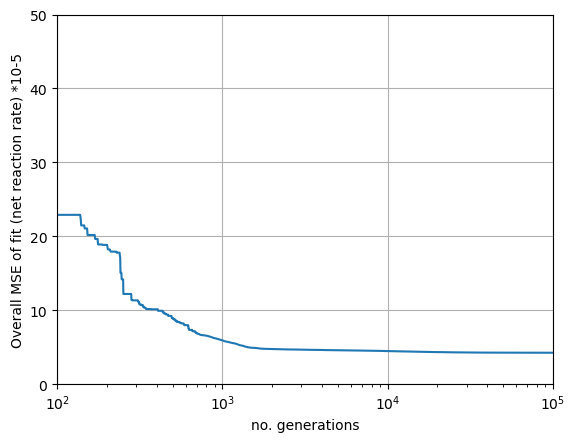

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-9.93967283972848
1.2534902407896875
0.4282876079750034
-4.205667266471909
0.48637300887965096
1.4304885359000649e-08
0.4161605150844199
-3.424931244954523
0.1566949241016199
3.253569580483987
2.272839228466246
2.378582034966647
7.013610372471255e-08
0.11383645396054454
3.017895123886635
1.4411929078853398e-08
0.5375474454417793
-11.02242385976964
1.728604064924093
1.5282883834650585
-9.083980344317967
0.9224067075336831
3.1092546214584544
0.099937817199954
2.8845454093301472
1.7957381628030988
0.671070570416752
4.410274048224545
-7.852525237248886
2.105485514976206
1.370710013651125
2.7539562673986113
-4.52564021814333
0.581722629678565
1.0061467070623407
-1.301029998569257


In [37]:
res.X

array([-9.93967284e+00,  1.25349024e+00,  4.28287608e-01, -4.20566727e+00,
        4.86373009e-01,  1.43048854e-08,  4.16160515e-01, -3.42493124e+00,
        1.56694924e-01,  3.25356958e+00,  2.27283923e+00,  2.37858203e+00,
        7.01361037e-08,  1.13836454e-01,  3.01789512e+00,  1.44119291e-08,
        5.37547445e-01, -1.10224239e+01,  1.72860406e+00,  1.52828838e+00,
       -9.08398034e+00,  9.22406708e-01,  3.10925462e+00,  9.99378172e-02,
        2.88454541e+00,  1.79573816e+00,  6.71070570e-01,  4.41027405e+00,
       -7.85252524e+00,  2.10548551e+00,  1.37071001e+00,  2.75395627e+00,
       -4.52564022e+00,  5.81722630e-01,  1.00614671e+00, -1.30103000e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -9.93967283972848
1.6: 1.2534902407896875
0.9: 0.4282876079750034
-4.3: -4.205667266471909
0.5: 0.48637300887965096
0.003: 1.4304885359000649e-08
0.4: 0.4161605150844199
-7.9: -3.424931244954523
0.7: 0.1566949241016199
7.2: 3.253569580483987
5.7: 2.272839228466246
5.7: 2.378582034966647
0.8: 7.013610372471255e-08
0.03: 0.11383645396054454
3.1: 3.017895123886635
6.000000000000001e-09: 1.4411929078853398e-08
0.1: 0.5375474454417793
-12.0: -11.02242385976964
1.9: 1.728604064924093
1.6: 1.5282883834650585
-11.6: -9.083980344317967
1.2: 0.9224067075336831
4.0: 3.1092546214584544
0.01: 0.099937817199954
4.2: 2.8845454093301472
5.4: 1.7957381628030988
2.2: 0.671070570416752
11.8: 4.410274048224545
-12.0: -7.852525237248886
3.3: 2.105485514976206
1.8: 1.370710013651125
4.2: 2.7539562673986113
-4.0: -4.52564021814333
0.5: 0.581722629678565
1.0: 1.0061467070623407
coeff fit: 0.8413797267474407
r: 0.9172675328100525


In [40]:
# Use stored solution
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = [-9.93967284e+00,  1.25349024e+00,  4.28287608e-01, -4.20566727e+00,
        4.86373009e-01,  1.43048854e-08,  4.16160515e-01, -3.42493124e+00,
        1.56694924e-01,  3.25356958e+00,  2.27283923e+00,  2.37858203e+00,
        7.01361037e-08,  1.13836454e-01,  3.01789512e+00,  1.44119291e-08,
        5.37547445e-01, -1.10224239e+01,  1.72860406e+00,  1.52828838e+00,
       -9.08398034e+00,  9.22406708e-01,  3.10925462e+00,  9.99378172e-02,
        2.88454541e+00,  1.79573816e+00,  6.71070570e-01,  4.41027405e+00,
       -7.85252524e+00,  2.10548551e+00,  1.37071001e+00,  2.75395627e+00,
       -4.52564022e+00,  5.81722630e-01,  1.00614671e+00, -1.30103000e+00]
#np.ndarray.tolist(res.X)
krseed10 = [-1.03833407e+01,  1.33626358e+00,  6.11057473e-01, -4.09204537e+00,
        4.58031583e-01,  2.19583292e-07,  3.63046858e-01, -4.41609982e+00,
        2.95297649e-01,  3.86106235e+00,  2.74690840e+00,  2.82812992e+00,
        7.52517696e-07,  1.12679035e-01,  2.97705443e+00,  5.71770860e-07,
        4.82324378e-01, -1.08747376e+01,  1.70751700e+00,  1.54209085e+00,
       -9.20455930e+00,  8.99750791e-01,  2.78022684e+00,  1.12071230e-03,
        3.16289257e+00,  3.05495261e+00,  1.04936932e+00,  6.44216860e+00,
       -9.10167143e+00,  2.42597693e+00,  1.45018035e+00,  3.08139246e+00,
       -4.36893703e+00,  5.58955219e-01,  9.90596744e-01, -1.30102985e+00]
krseed101 = [-1.06383167e+01,  1.37372350e+00,  6.25176882e-01, -4.20057446e+00,
        4.75467843e-01,  5.57270771e-07,  3.72354767e-01, -4.17441755e+00,
        2.55448343e-01,  3.87704814e+00,  2.76607412e+00,  2.86826952e+00,
        7.22697595e-07,  1.22798111e-01,  3.09524279e+00,  7.77432789e-08,
        5.32549993e-01, -1.09225349e+01,  1.71554691e+00,  1.55215513e+00,
       -8.29243966e+00,  8.43047637e-01,  2.79997976e+00,  9.01735492e-02,
        2.46911647e+00,  1.72065661e+00,  8.14140987e-01,  4.86099525e+00,
       -8.84273777e+00,  2.29801916e+00,  1.31521207e+00,  2.92399234e+00,
       -4.30399835e+00,  5.40674244e-01,  9.58088265e-01, -1.30102994e+00]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.8731620298657355
r: 0.9344313938785103
-10.320443413333333
1.3211591066666668
0.5548406543333333
-4.1660957000000005
0.4732908116666667
2.6371964946666664e-07
0.38385404666666667
-4.005149536666667
0.2358136386666667
3.6638933566666663
2.5952739166666667
2.6916604900000003
5.151171315666667e-07
0.11643786666666667
3.0300641133333333
2.2130868933333335e-07
0.5174739386666666
-10.9398988
1.7172226566666666
1.5408447866666666
-8.860326433333332
0.888401712
2.896487073333333
0.06374402623333332
2.838851483333333
2.1904491266666666
0.8448602923333334
5.237812633333333
-8.598978146666667
2.2764938666666668
1.37870081
2.9197803566666667
-4.399525199999999
0.5604506976666667
0.9849439063333335


In [42]:
meankr

[-10.320443413333333,
 1.3211591066666668,
 0.5548406543333333,
 -4.1660957000000005,
 0.4732908116666667,
 2.6371964946666664e-07,
 0.38385404666666667,
 -4.005149536666667,
 0.2358136386666667,
 3.6638933566666663,
 2.5952739166666667,
 2.6916604900000003,
 5.151171315666667e-07,
 0.11643786666666667,
 3.0300641133333333,
 2.2130868933333335e-07,
 0.5174739386666666,
 -10.9398988,
 1.7172226566666666,
 1.5408447866666666,
 -8.860326433333332,
 0.888401712,
 2.896487073333333,
 0.06374402623333332,
 2.838851483333333,
 2.1904491266666666,
 0.8448602923333334,
 5.237812633333333,
 -8.598978146666667,
 2.2764938666666668,
 1.37870081,
 2.9197803566666667,
 -4.399525199999999,
 0.5604506976666667,
 0.9849439063333335]

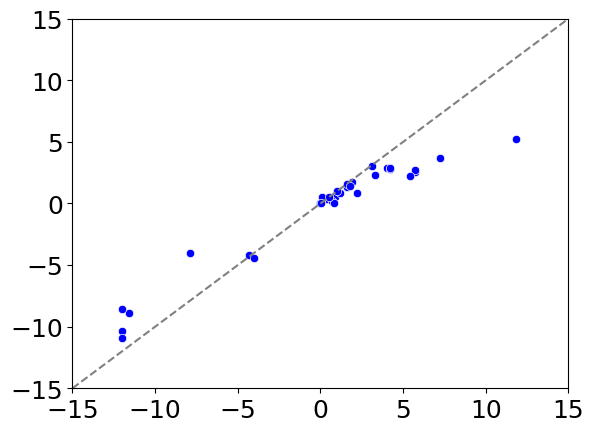

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)',fontsize=18)
#plt.ylabel('Fitted parameter values (log10)',fontsize=18)

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()
